In [184]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import tensorflow as tf
import cupy as cp
import matplotlib.pyplot as plt

In [185]:
class Listener:
    def __init__(self):
        self.__time_step = 9
        self.__tmp = cp.zeros([1,3])
        self.__arr_classification = cp.zeros([1,90])
        self.__vis_point = cp.zeros((1,3))
        self.__vis_balls = cp.zeros((self.__time_step,3))
        self.__vis_balls2 = cp.zeros((1,4))
        self.__predction_balls = cp.zeros((1,self.__time_step,3))
        self.__arr_prediction = cp.zeros([1,self.__time_step*3])
        self.__arr_pred_possible = cp.zeros((1,4))
        self.__diff = cp.zeros([1,3])
        self.__padding_done = False
        self.__cnt = 1
        self.__num = 1
        self.__max_index = 0
        self.__coor = -10*cp.ones(6)
        self.__find_possible_point = False
        self.__cal_possible_point = False
        self.__vis_possible_point = False
        self.__vis_hitting_point = cp.zeros((1,4))
        self.__hitting_point = -45
        self.__hitting_timimg = 0
        self.__possible_point = cp.zeros((1,4))
        self.__pred = cp.zeros([1,self.__time_step,3])
        self.__pred_for_offline = cp.zeros([1,self.__time_step,3])
        self.__time = 0.016667
        self.__delta_T = 0.016667
        self.__anchor = 0
        self.__rowww = 0
        self.__direction = 'top6'
        self.traj_done = False
        #self.fig, self.ax = plt.subplots(2,2, figsize=(10.24,7.2))
	#self.__name = sys.argv[1]
        self.__csv_path = '/home/lab606a/catkin_ws/src/pointcloud/offline/'
        #self.__model_path = '/home/lab606a/Documents/20200415/not_fixed/saved model/500_data/prediction_not_fixed_'+ self.__direction
        #self.__model_path = '/home/lab606a/catkin_ws/src/pointcloud/models/not_fixed/prediction_all_not_fixed'
        #self.__model_path = '/home/lab606a/Documents/model comparison/not fixed model/saved model/500_data/prediction_not_fixed_all_kind_data'
        self.__model_path = '/home/lab606a/Documents/model comparison/not fixed model/saved model/500_data/prediction_not_fixed_back6'
        self.__prediction_model = load_model(self.__model_path)
        
    def append_pred(self): ## Exhaustive
        self.__pred = cp.array(self.__model.predict(cp.asnumpy(self.__arr_prediction.reshape(1,self.__time_step,3)), verbose=1))
        while not self.__find_possible_point == True:
            self.__pred = cp.array(self.__pred)
            if ( -50 < float(cp.min(self.__pred[self.__pred.shape[0]-1,:,:])) < -40): ## find possible hitting point
                index = cp.argmin(self.__pred[self.__pred.shape[0]-1,:,:])
                row = int((index-1)/3)
                count_down = row + (self.__pred.shape[0]-1)*9
                self.__find_possible_point = True
                self.__anchor = self.__pred.shape[0]-1
                print("count down = ", int(count_down))
                #index = cp.argmin(self.__anchor[self.__anchor,:,:])
                #row = int((index-1)/3)
                self.__pred[self.__anchor, row+1:, :] = 0
                self.__pred_for_offline = self.__pred

            else: ## predict next time step
                self.__pred = cp.vstack((self.__pred, cp.zeros([1,self.__time_step,3])))
                self.__pred[self.__pred.shape[0]-1,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__pred[self.__pred.shape[0]-2,:,:].reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)
                if (self.__pred.shape[0] >= 8):
                    self.__pred = cp.zeros([1,self.__time_step,3])
                    self.__find_possible_point = True
                
    def update_prediction(self):
        self.__pred[0,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__arr_prediction.reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)
        for i in range(1, self.__pred.shape[0]):
            self.__pred[i,:,:] = cp.array(self.__model.predict(cp.asnumpy(self.__pred[i-1,:,:].reshape(1,self.__time_step,3)), verbose=1)).reshape(self.__time_step,3)

    def modify(self):
        #index = cp.argmin(self.__pred[self.__anchor,:,:])
        #row = int((index-1)/3)
        if (self.__rowww < 8):
            self.__pred[self.__anchor, self.__rowww+1:, :] = 0
        if (self.__anchor != self.__pred.shape[0]-1):
            self.__pred[self.__anchor+1:, :, :] = 0
        if (self.__anchor == 0) and (self.__rowww == 0) and ( -10 < float(cp.min(self.__pred[self.__anchor,0,:])) < 10):
            self.__pred[self.__anchor,0,:] = 0
        self.__pred_for_offline = cp.vstack((self.__pred_for_offline, self.__pred))
        #self.pub_prediction()

    def calculate_hitting_point(self, arr):
        #print("cnt = ", self.__cnt)
        arr = cp.array(arr)
        self.__cal_possible_point = False
        while not self.__cal_possible_point == True:
            print(arr[self.__anchor,:,:])
            if (-55 <= float(cp.min(arr[self.__anchor,:,:])) <= -35) and (self.__anchor >= 0):
                #print("anchor = ", self.__anchor)
                index = cp.argmin(arr[self.__anchor,:,:])
                row = int((index-1)/3)
                self.__rowww = row
                if (-55 <= float(cp.min(arr[self.__anchor,:,:])) <= self.__hitting_point): ## interpolation
                    index = cp.argmin(arr[self.__anchor,:,:])
                    row = int((index-1)/3)
                    self.__rowww = row
                    count_down = row + self.__anchor*9
                    print("count down = ", count_down)
                    if (row == 0):
                        print("case a1")
                        self.__vis_point = cp.array(self.__vis_point)
                        w1 = (self.__hitting_point-self.__vis_point[:,1]) / (arr[self.__anchor,row,1]-self.__vis_point[:,1])
                        self.__possible_point = w1*arr[self.__anchor,row,:] + (1-w1)*self.__vis_point.reshape(1,1,3)
                        self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))

                        #w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / (arr[self.__anchor,row,1]-arr[self.__anchor-1,self.__time_step-1,1])
                        #self.__possible_point = w1*arr[self.__anchor-1,self.__time_step-1,:] + (1-w1)*arr[self.__anchor,row,:]
                        #self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        #self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                        print("hitting timing and position = ", self.__possible_point)
                    else:
                        print("case a2")
                        w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / (arr[self.__anchor,row,1]-arr[self.__anchor,row-1,1])
                        self.__possible_point = w1*arr[self.__anchor,row-1,:] + (1-w1)*arr[self.__anchor,row,:]
                        self.__hitting_timimg = self.__time + (w1+count_down)*self.__delta_T
                        self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                        print("hitting timing and position = ", self.__possible_point)
                elif (self.__hitting_point < float(cp.min(arr[self.__anchor,:,:])) <= -40):
                    index = cp.argmin(arr[self.__anchor,:,:])
                    row = int((index-1)/3)
                    self.__rowww = row
                    count_down = row + self.__anchor*9
                    print("count down = ", count_down)
                    if (row == 0):
                        print("case b1")
                        if (self.__diff[:,1] > 0):
                            w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / self.__diff[:,1]
                            if w1 < 1:
                                self.__possible_point = arr[self.__anchor,row,:] - w1*self.__diff
                                self.__hitting_timimg = self.__time + (count_down+1+w1)*self.__delta_T
                                self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                                print("hitting timing and position = ", self.__possible_point)
                    else:
                        print("case b2")
                        self.__diff = arr[self.__anchor,row-1,:]-arr[self.__anchor,row,:]
                        self.__diff = self.__diff.reshape(1,3)
                        w1 = (arr[self.__anchor,row,1]-self.__hitting_point) / self.__diff[:,1]
                        if w1 < 1:
                            self.__possible_point = arr[self.__anchor,row,:] - w1*self.__diff
                            self.__hitting_timimg = self.__time + (count_down+1+w1)*self.__delta_T
                            self.__possible_point = cp.hstack((self.__hitting_timimg, self.__possible_point.reshape(3,)))
                            print("hitting timing and position = ", self.__possible_point)
                else:
                    self.__possible_point = self.__possible_point

                self.__cal_possible_point = True
                #self.pub_prediction()
                '''
                if (row < 8):
                    arr[self.__anchor, row+1:, :] = 0
                if (self.__anchor != self.__pred.shape[0]-1):
                    arr[self.__anchor+1:, :, :] = 0
                if (self.__anchor == 0) and ( -10 < float(cp.min(arr[self.__anchor,0,:])) < 10):
                    arr[self.__anchor,0,:] = 0
                '''
                #self.__pred_for_offline = cp.vstack((self.__pred_for_offline, arr))
                #self.__cnt += 1
                if (self.__arr_pred_possible.shape[0] == 1) and (int(self.__arr_pred_possible[0,2]) == 0):
                    self.__arr_pred_possible = self.__possible_point.reshape(1,4)
                else:
                    self.__arr_pred_possible = cp.vstack((self.__arr_pred_possible, self.__possible_point.reshape(1,4)))
            else:
                if ((self.__anchor-1) >= 0) and (abs(float(cp.min(arr[self.__anchor,:,:]))-self.__hitting_point) >= 22.5):
                    self.__anchor = self.__anchor -1
                    #print("case c1")
                else:
                    self.__cal_possible_point = True

    def calculate_vis_hitting_point(self):
        if (-50 <= float(cp.min(self.__vis_balls2)) <= self.__hitting_point):
            index = cp.argmin(self.__vis_balls2)
            row = int((index-1)/4)
            w1 = (self.__vis_balls2[row,2]-self.__hitting_point) / (self.__vis_balls2[row,2]-self.__vis_balls2[row-1,2])
            self.__vis_hitting_point = (1-w1)*self.__vis_balls2[row,:] + w1*self.__vis_balls2[row-1,:]
        elif (self.__hitting_point < float(cp.min(self.__vis_balls2)) < -40):
            index = cp.argmin(self.__vis_balls2)
            row = int((index-1)/4)
            w1 = (self.__vis_balls2[row,2]-self.__hitting_point) / (self.__vis_balls2[row-1,2]-self.__vis_balls2[row,2])
            self.__vis_hitting_point = self.__vis_balls2[row,:] - w1*(self.__vis_balls2[row-1,:]-self.__vis_balls2[row,:])
        #print("vis hitting point = ", self.__vis_hitting_point)


    def show_spin_direction(self, max_index):
        ## make dictionary to replace switch case
        dictionary = {0:self.top5, 1:self.top6, 2:self.left5, 3:self.left6, 4:self.right5, 5:self.right6, 6:self.back5, 7:self.back6}
        funcToCall = dictionary[max_index]
        funcToCall()

        if (self.__pred.shape[0] == 1):
            self.append_pred() ## Exhaustive
        elif (self.__pred.shape[0] > 1):
            self.update_prediction() ## update prediction result
            self.calculate_hitting_point(self.__pred) ## calculate hitting timimg and hitting point
            self.modify()

    def classification(self):
        ## call classifier
        classes = self.__classifier.predict(cp.asnumpy(self.__arr_classification.reshape(1,30,3)), verbose=1)
        ## figure out which direction is
        self.__max_index = np.argmax(classes)
        #print("number of input balls = ", self.__cnt)
        ## show result
        if (self.__cnt >= 9):
            self.show_spin_direction(self.__max_index)
        #self.__cnt += 1

    def padding(self):
        # if __tmp is empty, init array
        #print("paddinggg")
        if (self.__padding_done == False):
            self.__tmp = self.__vis_point ## pad first point
            self.__padding_done = True
            self.__vis_balls = self.__vis_point.reshape(1,3)
        else:
        # if __tmp is not empty, then filled array
            self.__tmp = cp.hstack((self.__tmp, self.__vis_point))
            self.__vis_balls = cp.vstack((self.__vis_balls, self.__vis_point))
            #if (self.__tmp.shape[1] == 15): ## when colect 5 balls
                #self.__arr_classification[:,:self.__tmp.shape[1]] = self.__tmp ## asigne to classification input array
            #print("shape of tmp = \n", self.__tmp.shape)
            if (self.__tmp.shape[1] == 27):
                #self.__vis_balls = self.__tmp.reshape(1,self.__time_step,3)
                self.__arr_prediction[:,:] = self.__tmp ## for predct next 5 steps
            if (self.__tmp.shape[1] > 27): ## when colect over 5 balls
                #self.__vis_balls = cp.vstack((self.__vis_balls, self.__tmp[:,self.__tmp.shape[1]-(self.__time_step*3):].reshape(1,self.__time_step,3))) ## visual measurement point for calculate error
                self.__arr_prediction[:,:] = self.__tmp[:,self.__tmp.shape[1]-(self.__time_step*3):] ## rolling visual measurement for predct next 5 steps
                #if (self.__tmp.shape[1] <= 90): ## when colect under 31 balls
                    #self.__arr_classification[:,:self.__tmp.shape[1]] = self.__tmp ## still asigne to classification input array

    def save_data(self):
        visurement_balls = cp.asnumpy(self.__vis_balls)
        pred_trajs = cp.asnumpy(self.__pred_for_offline.reshape(self.__pred_for_offline.shape[0]*self.__pred_for_offline.shape[1], self.__pred_for_offline.shape[2]))

        df_vis = pd.DataFrame(data=visurement_balls)
        df_pred = pd.DataFrame(data=pred_trajs)

        vis_name = self.__csv_path + 'visurement' + str(self.__num) + '.csv'
        pred_name = self.__csv_path + 'prediction' + str(self.__num) + '.csv'

        df_vis.to_csv(vis_name, header=0, index=0)
        df_pred.to_csv(pred_name, header=0, index=0)

    def predict_traj(self):
        self.__model = self.__prediction_model

        if (self.__pred.shape[0] == 1):
            self.append_pred() ## Exhaustive
        elif (self.__pred.shape[0] > 1):
            self.update_prediction() ## update prediction result
            self.calculate_hitting_point(self.__pred) ## calculate hitting timimg and hitting point
            self.modify()

    def plot_res(self):
        self.__arr_pred_possible = cp.round_(self.__arr_pred_possible, 4)
        self.__vis_hitting_point = cp.round_(self.__vis_hitting_point, 4)

        update_times = cp.linspace(1, self.__arr_pred_possible.shape[0], self.__arr_pred_possible.shape[0])
        t = self.__arr_pred_possible[:,0]
        x = self.__arr_pred_possible[:,1]
        z = self.__arr_pred_possible[:,3]
        Euclidean_vis = cp.sqrt(cp.sum(cp.power(self.__vis_hitting_point[1:],2)))
        Euclidean_pred = cp.sqrt(cp.sum(cp.power(self.__arr_pred_possible[:,1:],2), axis=1))

        plt.figure(figsize=(8,7))

        ## plot hitting timing
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[0]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(t), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(t), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Hitting timimg (sec)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and hitting timing', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_timing' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((t-self.__vis_hitting_point[0])*1000)
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Hitting timimg error (ms)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and hitting timing error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_timing_error' + '.png'
        plt.savefig(name)

        ## plot Euclidean distance
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*Euclidean_vis), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(Euclidean_pred), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Euclidean distance (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Euclidean distance', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_distance' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((Euclidean_pred-Euclidean_vis))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Euclidean distance error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Euclidean distance error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_distance_error' + '.png'
        plt.savefig(name)

        ## plot x coordinate
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[1]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(x), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(x), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('X-coordinate (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and X-coordinate', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_X-coordinate' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((x-self.__vis_hitting_point[1]))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('X-coordinate error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and X-coordinate error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_X-coordinate_error' + '.png'
        plt.savefig(name)

        ## plot z coordinate
        plt.clf()
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(cp.ones((self.__arr_pred_possible.shape[0],))*self.__vis_hitting_point[3]), color='green') #vis
        plt.plot(cp.asnumpy(update_times), cp.asnumpy(z), color='blue') #pred
        plt.scatter(cp.asnumpy(update_times), cp.asnumpy(z), color='blue')
        plt.grid(True)
        plt.xticks(fontsize=14, fontname='FreeSerif')
        plt.yticks(fontsize=14, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Z-coordinate (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Z-coordinate', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_Z-coordinate' + '.png'
        plt.savefig(name)

        plt.clf()
        err = cp.abs((z-self.__vis_hitting_point[3]))
        plt.bar(cp.asnumpy(update_times), cp.asnumpy(err), color='blue', edgecolor='black', width=0.5)
        plt.xticks(fontsize=18, fontname='FreeSerif')
        plt.yticks(fontsize=18, fontname='FreeSerif')
        plt.xlabel('Update times', fontsize=24, fontname='FreeSerif')
        plt.ylabel('Z-coordinate error (cm)', fontsize=24, fontname='FreeSerif')
        plt.title('Relationship between \n update times and Z-coordinate error', fontsize=24, fontweight='bold', fontname='FreeSerif')
        name = '/home/lab606a/catkin_ws/src/pointcloud/fig/' + str(self.__num) + '_Z-coordinate_error' + '.png'
        plt.savefig(name)
        
    def return_vis_point(self):
        return self.__vis_hitting_point
    
    def return_pred_res(self):
        return self.__arr_pred_possible
    
    def reset_arr_pred(self):
        self.__arr_pred_possible = cp.zeros((1,4))

    def assigne(self, visss):
        #a = data.data
        self.__vis_point = cp.array(visss).reshape(1,3)
        #print(self.__vis_point)

        if (-50 < self.__vis_point[:,1] < -30):
            tmp = cp.hstack((self.__time, self.__vis_point.reshape(3,)))
            if self.__vis_possible_point == False:
                self.__vis_balls2 = tmp.reshape(1,4)
                self.__vis_possible_point = True
            else:
                self.__vis_balls2 = cp.vstack((self.__vis_balls2, tmp.reshape(1,4)))


        if self.traj_done == False:
            print("\nTime = ", self.__time) ## show current time
            print("visual measurement = ", self.__vis_point) ## show visual measurement coordinate
            self.padding() ## colect 5 balls
            '''
            if ((self.__tmp.shape[1] >= 15) and (self.__tmp.shape[1] <= 90)): ## while colect balls over 5 balls and under 30 balls
                self.classification() ## doing classification and prediction
            if (self.__tmp.shape[1] > 90): ## while colect balls over 30 balls, stop doing classification
                self.show_spin_direction(self.__max_index) ## skip classification doing prediction
            '''
            if (self.__tmp.shape[1] >= 27):
                self.predict_traj()
            #self.for_ttbot()
            self.__time += self.__delta_T
            self.__cnt += 1
            
        else:
            #print("aaaaa")
            if (self.__padding_done == True):
                self.calculate_vis_hitting_point()
                #print("pred hitting point = \n", self.__arr_pred_possible)
                #if (self.__pred_for_offline.shape[0] != 1):
                    #self.plot_error()
                    #self.plot_res()
                    #self.save_data()
                self.__num += 1

            self.__padding_done = False
            self.__arr_classification = cp.zeros([1,90])
            self.__coor = -10*cp.ones(6)
            self.__vis_balls = cp.zeros((self.__time_step,3))
            self.__cnt = 1
            self.__pred = cp.zeros([1,self.__time_step,3])
            self.__vis_balls2 = cp.zeros((1,4))
            #self.__arr_pred_possible = cp.zeros((1,4))
            self.__find_possible_point = False
            self.__vis_possible_point = False
            self.__pred_for_offline = cp.zeros([1,self.__time_step,3])
            self.__time = 0.016667 ## reset time
            self.traj_done = False

In [186]:
# set GPU memory
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

np.set_printoptions(suppress=True)

In [187]:
obj = Listener()

In [188]:
name = 'back6'

In [189]:
dataset_path = './datasets/split by random for distributed/prediction/' + name + '_test.csv'
print(dataset_path)
dataset = pd.read_csv(dataset_path, header=None)
dataset = dataset.fillna(0)
dataset = np.array(dataset)

./datasets/split by random for distributed/prediction/back6_test.csv


In [190]:

arr_for_vis = np.array([0,0,0,0])
arr_for_pred_3rd = np.array([0,0,0,0])
arr_for_pred_end = np.array([0,0,0,0])

n = 21

arr_for_err_t = np.zeros((1,n))
arr_for_err_x = np.zeros((1,n))
arr_for_err_z = np.zeros((1,n))


for i in range(0,250):
    trajectory = dataset[i,:]
    trajectory = trajectory.reshape(1,trajectory.shape[0])
    trajectory = sequence.pad_sequences(trajectory, maxlen=trajectory.shape[1]+27, padding='post', dtype='float32')
    trajectory = trajectory.reshape(trajectory.shape[1],)
    for j in range(0, trajectory.shape[0], 3):
        obj.assigne(trajectory[j:j+3].reshape(1,3))
    obj.traj_done = True
    obj.assigne(np.array([0,0,0]))
    vis_arr = obj.return_vis_point()
    pred_arr = obj.return_pred_res()
    #print("")
    #print("vis from obj = \n", vis_arr)
    #print("pred from obj = \n", pred_arr)
    #arr_for_vis = np.vstack((arr_for_vis, vis_arr))
    #while pred_arr.shape[0] < n:
        #pred_arr = np.vstack(())
    
    if pred_arr.shape[0] >= n:
        #arr_for_vis = np.vstack((arr_for_vis, vis_arr))
        #arr_for_pred_3rd = np.vstack((arr_for_pred_3rd, pred_arr[2,:]))
        #arr_for_pred_end = np.vstack((arr_for_pred_end, pred_arr[(pred_arr.shape[0]-10),:]))
        err = vis_arr - pred_arr
        print(err.shape)
        err_t = err[:n,0]
        err_x = err[:n,1]
        err_z = err[:n,3]
        
        arr_for_err_t = np.vstack((arr_for_err_t, err_t))
        arr_for_err_x = np.vstack((arr_for_err_x, err_x))
        arr_for_err_z = np.vstack((arr_for_err_z, err_z))
    #else:
        #print("\n\n aaaaa")
        #print(pred_arr)
    
    obj.reset_arr_pred()



Time =  0.016667
visual measurement =  [[ 57.0958 306.614   41.6497]]

Time =  0.033334
visual measurement =  [[ 56.9839 292.238   42.0291]]

Time =  0.050001000000000004
visual measurement =  [[ 56.5252 281.369   41.4565]]

Time =  0.066668
visual measurement =  [[ 56.2716 265.692   41.7762]]

Time =  0.083335
visual measurement =  [[ 55.7962 257.151   40.5517]]

Time =  0.10000200000000001
visual measurement =  [[ 55.5641 242.932   40.1921]]

Time =  0.11666900000000001
visual measurement =  [[ 55.2579 231.706   39.4578]]

Time =  0.133336
visual measurement =  [[ 54.8276 218.827   38.7355]]

Time =  0.150003
visual measurement =  [[ 54.373  207.614   37.6482]]
1/1 [==============================] - 0s 2ms/step
count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 53.7183 196.866   35.9988]]
1/1 [==============================] - 0s 3ms/step
[[ 46.55585861   6.19946098  11.17268944]
 [ 45.98542404  -2.44404984  13.22996521]
 [ 45.54388046 -11.05501938  14.9377327 ]


1/1 [==============================] - 0s 2ms/step
[[ 47.51289749  -3.84003258  12.72877121]
 [ 47.27647781 -12.62136078  14.27058983]
 [ 46.97084808 -20.65839005  15.51616859]
 [ 46.65444183 -28.91123581  16.58674622]
 [ 46.20131683 -36.64030838  17.54734802]
 [ 45.37350082 -43.95614243  18.22324181]
 [  0.05355835   0.22687721   0.04043388]
 [ -0.16034698   0.11663055   0.0665493 ]
 [ -0.25048828   0.11363983   0.01845455]]
count down =  14
case b2
hitting timing and position =  [  0.58572313  45.25538415 -45.          18.31968151]

Time =  0.35000699999999985
visual measurement =  [[49.7456 79.0716 12.8617]]
1/1 [==============================] - 0s 1ms/step
[[ 46.37969971 -11.18404007  12.85046959]
 [ 46.09409332 -19.45252609  14.27394199]
 [ 45.81071472 -28.04519272  15.50330353]
 [ 45.22291946 -35.85222626  16.36131859]
 [ 44.48596954 -44.09252548  16.95682526]
 [  0.07337189   0.29489517  -0.01685429]
 [  0.02745819   0.11839294  -0.07559395]
 [  0.08161163   0.0245266   -0.1035

1/1 [==============================] - 0s 3ms/step
[[ 45.30690384 -18.39876938  17.74421501]
 [ 44.83248901 -26.28707504  18.95002747]
 [ 44.76348495 -34.90163422  20.43976212]
 [ 44.12981796 -42.46861649  21.45979309]
 [ 43.51558304 -49.73801804  21.93572807]
 [ -0.26029968  -0.1125679   -0.14359951]
 [ -0.06365204   0.05757141  -0.00024986]
 [  0.01737595   0.12618637  -0.05800343]
 [ -0.04793167   0.31515884  -0.18043327]]
count down =  4
case a2
hitting timing and position =  [  0.59420814  43.91592633 -45.          21.6255253 ]

Time =  0.5333439999999997
visual measurement =  [[ 45.5418 -18.679   17.9477]]
1/1 [==============================] - 0s 3ms/step
[[ 45.45824432 -26.21293259  19.45033646]
 [ 44.81352997 -34.3870163   20.67622566]
 [ 43.68751144 -42.82683945  21.81193733]
 [ -0.12312317  -0.87500572   0.33288383]
 [  0.39359665  -0.39053154   0.09511185]
 [ -0.07470703  -0.19981575  -0.03550339]
 [  0.27518463  -0.15760612   0.0834341 ]
 [  0.29621124  -0.07269859   0.055

1/1 [==============================] - 0s 1ms/step
[[-0.072258   -0.09207726 -0.00398922]
 [-0.09115601 -0.09695435 -0.01436996]
 [-0.08744812 -0.08795166 -0.00985241]
 [-0.08360672 -0.09469414 -0.00177002]
 [-0.0890007  -0.08929062 -0.00350475]
 [-0.08895874 -0.0830307  -0.00491905]
 [-0.08876801 -0.07958221 -0.00628185]
 [-0.08834839 -0.07807159 -0.00740623]
 [-0.08769608 -0.07781219 -0.00833321]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

[[ 74.79460144   6.64580727  17.94992256]
 [ 74.686203    -1.05413246  18.85703468]
 [ 74.77419281  -8.72932053  19.66194534]
 [ 74.79804993 -16.60234451  20.19717407]
 [ 74.37563324 -24.04473114  20.48489761]
 [ 73.8102951  -31.38790512  20.55490112]
 [ 73.54971313 -38.39532089  20.50790405]
 [ 72.72425842 -45.97914505  20.04755783]
 [  0.45211792   0.16911697  -0.04981136]]
count down =  25
case a2
hitting timing and position =  [  0.63549787  72.83083261 -45.          20.10699298]

Time =  0.23333799999999993
visual measurement =  [[ 77.5852 174.266   26.7553]]
1/1 [==============================] - 0s 2ms/step
[[ 75.48950958  -0.0335083   19.35974884]
 [ 75.16582489  -7.46831894  20.02599335]
 [ 75.0247879  -14.91823196  20.48718643]
 [ 75.01753235 -22.44402695  20.65557289]
 [ 75.31192017 -29.72370911  20.53614998]
 [ 74.5055542  -37.09236526  20.25576401]
 [ 74.89614868 -45.26078415  20.40651131]
 [ -0.09860229  -0.23431587   0.15319824]
 [  0.23245239   0.04563522   0.20395947]]

1/1 [==============================] - 0s 2ms/step
[[ 75.49732971  -8.83111954  17.91871643]
 [ 75.48345184 -16.80329514  18.40968704]
 [ 75.42636108 -24.74208832  18.58172798]
 [ 74.97290039 -32.23763275  18.36326599]
 [ 74.70442963 -39.48347855  18.07511711]
 [ 74.00526428 -46.38212204  17.45881271]
 [  0.04509735   0.03391075   0.05510521]
 [  0.4427681    0.05501366   0.10746193]
 [  0.19324493   0.32468605  -0.02719593]]
count down =  14
case a2
hitting timing and position =  [  0.63668518  74.14533991 -45.          17.58228741]

Time =  0.4166749999999998
visual measurement =  [[76.7752  62.5906   3.51703]]
1/1 [==============================] - 0s 1ms/step
[[ 75.53277588 -17.34439087  18.29316521]
 [ 75.2583313  -24.84527588  18.32020378]
 [ 75.52857971 -32.63507843  18.33646584]
 [ 75.25497437 -39.75057602  18.1206398 ]
 [ 74.7508316  -46.96288681  17.45607758]
 [ -0.17560577   0.00715256   0.00983715]
 [  0.12481689  -0.03040314  -0.04004478]
 [  0.03146362   0.09453583  -0.11

1/1 [==============================] - 0s 2ms/step
[[ 75.13745117 -18.14839554  24.61057663]
 [ 74.58746338 -24.95483017  24.79512596]
 [ 74.7257843  -33.0148735   25.15201569]
 [ 74.56839752 -40.73263931  25.31823349]
 [ 74.04434967 -47.65476608  25.1067276 ]
 [ -0.38925171   0.03820229  -0.00375366]
 [  0.38661957  -0.13961601   0.22613049]
 [  0.44801331  -0.15185547   0.20354652]
 [  0.28981018   0.18904877   0.07176399]]
count down =  4
case a2
hitting timing and position =  [  0.63973811  74.2453319  -45.          25.1878441 ]

Time =  0.5833449999999997
visual measurement =  [[ 75.2352 -17.7122  24.2327]]
1/1 [==============================] - 0s 7ms/step
[[ 75.21417999 -25.01858139  24.93671799]
 [ 74.65532684 -32.41226578  25.05309868]
 [ 74.81195831 -40.28717422  25.49363899]
 [ 74.20214844 -47.23070145  25.50648499]
 [  0.05446243   0.08150482   0.08935356]
 [  0.05680084   0.38773727   0.16327953]
 [  0.23705292   0.36805344   0.11762619]
 [  0.18202972   0.35775375   0.063

1/1 [==============================] - 0s 4ms/step
[[-0.06584167 -0.09106064 -0.0021944 ]
 [-0.08691025 -0.09708214 -0.01325417]
 [-0.08307266 -0.08800316 -0.00867748]
 [-0.079216   -0.09477234 -0.00060272]
 [-0.08460999 -0.08939743 -0.00234032]
 [-0.08455658 -0.08313751 -0.00375557]
 [-0.08437347 -0.07970047 -0.00512123]
 [-0.08395004 -0.07818985 -0.00624466]
 [-0.08329773 -0.07793236 -0.00717163]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06470871 -0.08456421 -0.003088  ]
 [-0.08538818 -0.09142494 -0.01355171]
 [-0.08158875 -0.08248901 -0.00896835]
 [-0.07775116 -0.08931541 -0.00088882]
 [-0.08312225 -0.08398438 -0.0026207 ]
 [-0.08306122 -0.07778358 -0.00403214]
 [-0.08287048 -0.07436371 -0.00539875]
 [-0.08242798 -0.07289124 -0.00652122]
 [-0.08177185 -0.072649   -0.00744915]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.


Time =  0.2666719999999999
visual measurement =  [[ 55.6303 103.597   11.7531]]
1/1 [==============================] - 0s 4ms/step
[[ 46.86968231   8.40786552  14.25576019]
 [ 46.45513535  -0.48791504  15.93259716]
 [ 45.59184647  -8.97319412  16.99482918]
 [ 44.63700867 -17.39477921  17.84743118]
 [ 43.55657578 -25.59251785  18.6321888 ]
 [ 42.8054924  -33.53410721  19.35531807]
 [ 41.87245178 -41.37938309  19.87749481]
 [ 23.58003998 -28.5133934   11.25159359]
 [  1.26140594  -0.35149574   0.43262863]]
count down =  15
case b2
hitting timing and position =  [  0.54103587  41.44185091 -45.          20.11848085]

Time =  0.2833389999999999
visual measurement =  [[54.7898  92.4179   9.00585]]
1/1 [==============================] - 0s 2ms/step
[[ 45.95412827  -0.92127037  15.12292385]
 [ 45.63393402  -9.21858597  16.24275208]
 [ 44.55196381 -17.96891785  17.0039444 ]
 [ 43.3622818  -26.65061569  17.77519989]
 [ 42.41762543 -34.63277054  18.27322388]
 [ 41.5198555  -41.59735489  18.87401

1/1 [==============================] - 0s 2ms/step
[[ 45.78802872  -9.38037491  16.66388893]
 [ 45.04726791 -17.69488144  16.86408806]
 [ 44.53391647 -26.09852982  17.15679932]
 [ 44.03144073 -34.51958084  17.28391266]
 [ 42.66433334 -43.04575729  17.45497894]
 [  0.91740036  -2.62932205   0.14834404]
 [  0.24067307  -1.32136154  -0.18365288]
 [ -0.33705139  -0.82331085  -0.26409531]
 [ -0.07624054  -0.99953079  -0.1755476 ]]
count down =  4
case b2
hitting timing and position =  [  0.53716416  42.35098542 -45.          17.4941882 ]

Time =  0.46667599999999976
visual measurement =  [[45.7377  -9.73108 17.5237 ]]
1/1 [==============================] - 0s 2ms/step
[[ 43.70849609 -18.64925766  18.12459564]
 [ 42.90983963 -26.01980972  18.42641068]
 [ 42.71986389 -35.41368484  18.89871025]
 [ 41.04452515 -43.6207695   18.99364471]
 [  6.07186127  -9.52833176   3.00784063]
 [  0.97907257  -1.21006775   0.25538445]
 [ -0.04387665  -0.75455666   0.0040226 ]
 [ -0.19508362  -0.67617035  -0.03

1/1 [==============================] - 0s 3ms/step
[[-0.0704689  -0.0897541  -0.00368309]
 [-0.08930969 -0.09492683 -0.01390171]
 [-0.08556366 -0.08594894 -0.0093689 ]
 [-0.08169174 -0.09270477 -0.00128841]
 [-0.08707047 -0.08732605 -0.0030241 ]
 [-0.08699799 -0.08107376 -0.00444221]
 [-0.08682632 -0.07762909 -0.00580597]
 [-0.08639526 -0.07612801 -0.0069294 ]
 [-0.08575439 -0.07587433 -0.00785542]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

count down =  30
case a2
hitting timing and position =  [  0.66951838  82.1575756  -45.          19.2442431 ]

Time =  0.18333699999999997
visual measurement =  [[ 78.2464 226.019   42.7615]]
1/1 [==============================] - 0s 2ms/step
[[ 83.58753204 -33.48410416  18.27745628]
 [ 83.70878601 -40.90828323  18.87863541]
 [ 84.41765594 -48.936306    19.29606056]
 [  0.04077911   0.11988068  -0.0213356 ]
 [  0.15480804  -0.06371307   0.04766655]
 [  0.36742401  -0.19866371   0.00219917]
 [  0.29186249  -0.10626411  -0.00236702]
 [  0.25614929  -0.10554504   0.01128006]
 [  0.1775589   -0.09477615  -0.00336266]]
count down =  29
case a2
hitting timing and position =  [  0.67485218  84.07008232 -45.          19.09138835]

Time =  0.20000399999999996
visual measurement =  [[ 78.5249 216.173   41.4452]]
1/1 [==============================] - 0s 6ms/step
[[ 82.96026611 -39.76804733  17.83329391]
 [ 83.43856812 -47.56438065  17.89720726]
 [ -0.04512024  -0.18590164  -0.07641506]
 [  0.070

1/1 [==============================] - 0s 3ms/step
[[ 87.74098206 -44.66180801  20.70210266]
 [  0.3184967   -0.04317474  -0.02131462]
 [  0.37337494  -0.18142319   0.00480461]
 [  0.37893295  -0.17629242   0.09228134]
 [  0.26608276  -0.15721512   0.0941391 ]
 [  0.26084518  -0.13463211   0.09010887]
 [  0.20740891  -0.11724091   0.08557701]
 [  0.19882202  -0.10820389   0.09451294]
 [  0.22581482  -0.09443665   0.11165428]]
count down =  18
case b1
hitting timing and position =  [  0.6679194   87.50649643 -45.          20.76051344]

Time =  0.36667399999999983
visual measurement =  [[ 82.2394 111.514   23.4937]]
1/1 [==============================] - 0s 2ms/step
[[ 86.24748993 -48.10018539  18.79006577]
 [  0.24347687  -0.00954628  -0.01609802]
 [  0.33707428  -0.10384369   0.00860405]
 [  0.3483696   -0.09498596   0.04538345]
 [  0.27466583  -0.10314178   0.06021309]
 [  0.30945587  -0.10096931   0.06931305]
 [  0.27658844  -0.083395     0.07094669]
 [  0.2722168   -0.07685852   0.0

[[ 88.03227234 -48.47112656  17.97338867]
 [  0.23149109   0.00525093  -0.01941204]
 [  0.36568451  -0.08516884   0.00674152]
 [  0.37301636  -0.07811356   0.03601742]
 [  0.2904129   -0.09147263   0.05317688]
 [  0.32844162  -0.09679031   0.06453705]
 [  0.29730225  -0.08084869   0.06810951]
 [  0.29675293  -0.07581711   0.07720566]
 [  0.31738663  -0.06344223   0.09125328]]
count down =  9
case a1
hitting timing and position =  [  0.68258519  87.90491883 -45.          17.35674624]

Time =  0.5333439999999997
visual measurement =  [[85.2586  20.1172   7.65545]]
1/1 [==============================] - 0s 1ms/step
[[0.13739014 0.05172348 0.07094765]
 [0.18170929 0.08481026 0.06097317]
 [0.19254303 0.11064148 0.05347252]
 [0.21826172 0.08351898 0.06850815]
 [0.17852783 0.06628799 0.05987167]
 [0.16326141 0.06916428 0.05527306]
 [0.15999603 0.07685471 0.05343628]
 [0.16122055 0.08571625 0.05293083]
 [0.1648407  0.09502983 0.05325794]]
[[ 85.4732666   12.05637741   9.15939808]
 [ 85.9632263

1/1 [==============================] - 0s 2ms/step
[[-0.11460114 -0.09924507 -0.02329636]
 [-0.11265182 -0.0911293  -0.02742004]
 [-0.10845947 -0.08052063 -0.02361488]
 [-0.10667419 -0.09214783 -0.01152897]
 [-0.11265564 -0.08643341 -0.01093197]
 [-0.11141968 -0.07752609 -0.01101303]
 [-0.10940552 -0.07089615 -0.01166534]
 [-0.10703278 -0.06622696 -0.01237297]
 [-0.1045723  -0.06295586 -0.01300144]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.05976868 -0.06666183 -0.00255775]
 [-0.0564003  -0.07224464  0.00113773]
 [-0.06843185 -0.06208992 -0.0015974 ]
 [-0.07086182 -0.06818199  0.00445652]
 [-0.07739258 -0.06365585  0.00222874]
 [-0.0777092  -0.05923462  0.0005331 ]
 [-0.07753754 -0.0576973  -0.00104618]
 [-0.07698059 -0.0578804  -0.00235558]
 [-0.07615662 -0.05901337 -0.00344467]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.07991791 -0.

 [ 55.90211487 -44.21116257  22.62244034]]
count down =  26
case b2
hitting timing and position =  [  0.6351423   55.8452472  -45.          22.68581683]

Time =  0.20000399999999996
visual measurement =  [[ 68.9312 192.5     35.7186]]
1/1 [==============================] - 0s 2ms/step
[[ 58.21008301  10.12551498  15.12268066]
 [ 57.76442719   2.28873444  17.0185051 ]
 [ 57.28658676  -5.3315506   18.73514938]
 [ 56.93979263 -12.94992447  20.36021996]
 [ 56.41280365 -20.34745407  21.66838455]
 [ 56.27635956 -27.617836    22.67210007]
 [ 55.60725784 -35.27116776  23.55296326]
 [ 54.93595505 -43.11332321  24.24429703]
 [ 52.80977631 -47.80865097  23.24500275]]
count down =  26
case a2
hitting timing and position =  [  0.64331587  54.08161382 -45.          23.84276056]

Time =  0.21667099999999995
visual measurement =  [[ 68.5812 180.244   34.2564]]
1/1 [==============================] - 0s 5ms/step
[[ 57.94297791   0.18260193  16.81106186]
 [ 57.68730164  -7.54388046  18.45794106]
 [ 57.32

visual measurement =  [[62.7047 89.4292 12.337 ]]
1/1 [==============================] - 0s 3ms/step
[[ 57.35874939   2.63999367  17.50566483]
 [ 57.2205658   -4.82707596  19.18418312]
 [ 56.46301651 -12.46787643  20.42605209]
 [ 55.82876587 -20.25702667  21.46771049]
 [ 55.27007675 -26.98655319  22.16853142]
 [ 54.70475769 -34.57558823  22.82607079]
 [ 54.43138504 -42.3531456   23.42283058]
 [ 51.06438446 -46.97941208  22.16929245]
 [  0.26777649   0.05125046  -0.15991783]]
count down =  16
case a2
hitting timing and position =  [  0.64047721  52.50500221 -45.          22.70563607]

Time =  0.3833409999999998
visual measurement =  [[62.2913  79.4292   9.41342]]
1/1 [==============================] - 0s 4ms/step
[[ 57.27654648  -5.7301178   19.31805611]
 [ 56.66139221 -13.29804993  20.13830376]
 [ 56.49377441 -21.02202225  21.35704613]
 [ 55.78208923 -28.48160934  22.1846199 ]
 [ 55.03676605 -35.62233353  22.50584793]
 [ 54.86561203 -42.70745468  23.53525352]
 [  0.5382843   -0.6477012

1/1 [==============================] - 0s 2ms/step
[[ 57.45666885  -5.38476181  18.64215279]
 [ 56.85671616 -13.0430336   19.26525116]
 [ 56.52099991 -20.88487625  20.08243752]
 [ 55.99546051 -28.45411301  20.6322155 ]
 [ 55.50336456 -35.70337296  20.88882065]
 [ 55.11421967 -42.83286667  21.54793549]
 [ -0.27900314  -0.0474205   -0.08455372]
 [  0.18785095  -0.12538147   0.01676369]
 [ -0.02577972   0.08279228  -0.0667429 ]]
count down =  5
case b2
hitting timing and position =  [  0.63841222  54.99593232 -45.          21.74828488]

Time =  0.5500109999999997
visual measurement =  [[57.1752  -5.09824 18.3714 ]]
1/1 [==============================] - 0s 3ms/step
[[ 56.89745331 -12.95550919  19.24342537]
 [ 56.02638245 -20.59039688  19.76185417]
 [ 55.74715424 -28.32342148  20.24803162]
 [ 55.11829376 -35.75099564  20.50731659]
 [ 54.25063705 -43.13959885  20.70206261]
 [ -0.12754059   0.08996201  -0.00518799]
 [  0.10949707  -0.14127541   0.07011795]
 [ -0.02952576  -0.07572746  -0.024

1/1 [==============================] - 0s 6ms/step
[[-0.06217575 -0.0896759  -0.00030231]
 [-0.08276367 -0.09562683 -0.01142883]
 [-0.0791626  -0.08670807 -0.00688744]
 [-0.07536316 -0.09351349  0.00118256]
 [-0.0807724  -0.08815384 -0.00055695]
 [-0.08072662 -0.08190918 -0.00197029]
 [-0.08054352 -0.07847214 -0.00333691]
 [-0.08011627 -0.07696533 -0.00445938]
 [-0.07948685 -0.07672119 -0.00538635]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06438446 -0.08971596 -0.00151539]
 [-0.08609009 -0.09609604 -0.01289082]
 [-0.08215332 -0.08704376 -0.00826454]
 [-0.07827759 -0.0938549  -0.00018692]
 [-0.08365631 -0.08851242 -0.00192547]
 [-0.08359528 -0.08227921 -0.00333977]
 [-0.08340454 -0.07884407 -0.00470543]
 [-0.08298492 -0.07735443 -0.00582981]
 [-0.08232117 -0.07709885 -0.00675392]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06264496 -0.


Time =  0.23333799999999993
visual measurement =  [[ 83.0785 125.701   25.2369]]
1/1 [==============================] - 0s 1ms/step
[[ 0.02983856 -0.01330948  0.04736423]
 [ 0.06934738  0.02977943  0.05067062]
 [ 0.09615326  0.07355499  0.04689217]
 [ 0.13286972  0.05279922  0.06469536]
 [ 0.09545517  0.03862762  0.05669785]
 [ 0.08208847  0.04427719  0.05250168]
 [ 0.08058548  0.05433273  0.05099392]
 [ 0.08324432  0.06524277  0.050704  ]
 [ 0.08810806  0.07643509  0.05119514]]
[[ 88.3875351   23.26318932   1.52779388]
 [ 89.29792023  14.74373436   4.62295771]
 [ 89.91143036   5.94393158   6.91107321]
 [ 90.53302002  -2.90266037   9.01944733]
 [ 90.96179962 -11.65374374  10.94241905]
 [ 91.13627625 -20.30714035  12.73095894]
 [ 91.53410339 -28.68584442  14.37964725]
 [ 92.18158722 -36.87450027  15.72799492]
 [ 92.31990051 -44.93704605  16.71982193]]
count down =  17
case b2
hitting timing and position =  [  0.53347414  92.32098049 -45.          16.72756631]

Time =  0.250004999999999

1/1 [==============================] - 0s 3ms/step
[[ 89.28205109   4.12930298   7.8447876 ]
 [ 89.41015625  -4.32857895  10.56719017]
 [ 90.45865631 -13.49930954  12.83530998]
 [ 90.71031952 -21.8960495   14.78183556]
 [ 91.41442871 -30.17515182  16.76452637]
 [ 91.51513672 -38.42486954  18.19560051]
 [ 90.44763947 -45.95527267  18.83891296]
 [  0.10198212  -0.56122971   0.00378513]
 [  0.76079559  -0.34583473  -0.0210762 ]]
count down =  6
case a2
hitting timing and position =  [  0.5187913   90.58305731 -45.          18.75730527]

Time =  0.4333419999999998
visual measurement =  [[90.2997   4.65028  8.1397 ]]
1/1 [==============================] - 0s 2ms/step
[[ 90.78041077  -3.90234756  10.33614922]
 [ 91.68237305 -12.89270401  12.79263115]
 [ 92.75801086 -21.40714645  14.61745834]
 [ 92.66369629 -29.48302078  16.03479958]
 [ 92.60483551 -37.83390427  17.04741096]
 [ 92.61340332 -45.08208847  17.86553955]
 [  0.73254395  -0.10200882   0.06822205]
 [  0.84906387  -0.06148338   0.128

1/1 [==============================] - 0s 3ms/step
[[-0.06296921 -0.08974838 -0.00009823]
 [-0.08411026 -0.09582901 -0.01135349]
 [-0.08043289 -0.0868454  -0.00681496]
 [-0.07659912 -0.09363365  0.00124741]
 [-0.08198547 -0.08826447 -0.00049591]
 [-0.08192444 -0.08201981 -0.00190926]
 [-0.08175278 -0.07858658 -0.00327587]
 [-0.08132553 -0.07708549 -0.0043993 ]
 [-0.08066559 -0.07682419 -0.00532532]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.06507111 -0.09077454 -0.00154686]
 [-0.08669281 -0.09683037 -0.01283455]
 [-0.0828476  -0.087677   -0.00826836]
 [-0.07899475 -0.09443855 -0.00020313]
 [-0.08440399 -0.08905792 -0.0019455 ]
 [-0.0843277  -0.08280945 -0.00336266]
 [-0.08415222 -0.07935715 -0.00472927]
 [-0.08372116 -0.07785797 -0.00585461]
 [-0.08306122 -0.07759857 -0.00677872]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.0636673  -0.

visual measurement =  [[ 97.4447 204.418   35.0822]]

Time =  0.150003
visual measurement =  [[ 96.0136 194.705   33.3032]]
1/1 [==============================] - 0s 4ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 94.3828 184.485   31.6076]]
1/1 [==============================] - 0s 1ms/step
[[ 67.0389328    5.92181396  16.82185173]
 [ 65.72470093  -2.0566349   18.21171188]
 [ 64.3427887   -9.28417587  19.19466209]
 [ 62.90236664 -16.87714767  20.12704468]
 [ 60.9184494  -23.9939537   20.7483654 ]
 [ 59.97850418 -30.93083572  21.25584793]
 [ 59.2488327  -37.9707756   21.51034164]
 [ 57.20410919 -46.08760452  21.18861771]
 [  0.61368942  -0.36523628   0.23013496]]
count down =  25
case a2
hitting timing and position =  [  0.58557827  57.47808941 -45.          21.23172671]

Time =  0.18333699999999997
visual measurement =  [[ 92.8301 171.454   30.5817]]
1/1 [==============================] - 0s 2ms/step
[[ 66.0919342   -2.46082687  17.68848038]
 [ 64.66845

1/1 [==============================] - 0s 4ms/step
[[ 66.38227844  -8.03242111  18.49020386]
 [ 65.07618713 -16.14876556  18.89207649]
 [ 64.09870148 -24.04040909  19.31487274]
 [ 62.28977203 -31.38975906  19.29990196]
 [ 61.10480499 -38.5469017   19.2972374 ]
 [ 59.52065277 -45.23583603  19.10807419]
 [  0.07022095  -0.11133575   0.0500946 ]
 [  0.3588028   -0.11450386   0.1459446 ]
 [  0.16706085  -0.12235641   0.07901001]]
count down =  14
case a2
hitting timing and position =  [  0.58393264  59.57650624 -45.          19.11474364]

Time =  0.36667399999999983
visual measurement =  [[77.2122   62.5323    0.937395]]
1/1 [==============================] - 0s 2ms/step
[[ 65.40092468 -17.17739868  18.31685829]
 [ 64.14527893 -24.64387894  18.53547668]
 [ 63.36124039 -32.50638962  18.9335041 ]
 [ 62.13079071 -39.70976639  19.18608856]
 [ 61.04670715 -47.19511032  19.11343575]
 [  0.08951569  -0.26553917  -0.02983284]
 [  0.09888458  -0.15358734   0.00267696]
 [  0.09432983   0.02289963  -

1/1 [==============================] - 0s 1ms/step
[[ 64.75708008 -24.47598648  19.30637169]
 [ 63.50774765 -32.27801895  19.4587326 ]
 [ 62.58130646 -39.76163101  19.76331139]
 [ 61.21179199 -46.81062698  19.65374756]
 [  0.3154068   -0.08416367   0.0769577 ]
 [  0.06719589   0.18590355   0.08699703]
 [  0.20131302   0.23091125   0.10609341]
 [  0.14212799   0.19706726   0.10324383]
 [ -0.0295639   -0.01737976   0.05575085]]
count down =  3
case a2
hitting timing and position =  [  0.58762614  61.56356973 -45.          19.68189046]

Time =  0.5500109999999997
visual measurement =  [[ 64.9549 -24.7401  19.0079]]
1/1 [==============================] - 0s 2ms/step
[[ 63.71427536 -31.97848129  19.23437881]
 [ 62.66891861 -39.4162178   19.54678726]
 [ 61.40400696 -46.99866104  19.70387459]
 [  0.23602295  -0.05058289   0.02987576]
 [  0.2334404   -0.1829319    0.08331013]
 [  0.28985214  -0.22323227   0.09559822]
 [  0.25566101  -0.13092422   0.09839058]
 [  0.24541092  -0.04629898   0.068

1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 7ms/step
[[ 65.50970459  18.86352158   6.92404079]
 [ 65.46932983  10.43441963   9.00742817]
 [ 65.81890106   1.44256592  10.7614584 ]
 [ 66.1016922   -7.61291122  12.40172005]
 [ 66.31451416 -16.8800354   13.75623035]
 [ 66.76905823 -25.71940231  14.86323452]
 [ 66.99964905 -33.72289658  15.71423244]
 [ 67.13078308 -42.08806229  16.16986847]
 [ 58.69709778 -43.06676865  13.85153389]]
count down =  17
case b2

Time =  0.2666719999999999
visual measurement =  [[ 62.2135 112.356   18.4252]]
1/1 [==============================] - 0s 3ms/step
[[ 65.08680725  10.36467743   9.71906853]
 [ 65.362854     1.78313637  11.50561905]
 [ 65.5304718   -7.05637741  13.00749111]
 [ 66.17375183 -16.24992752  14.44708061]
 [ 65.9817276  -24.91989136  15.45624161]
 [ 65.84901428 -33.34908295  16.29872894]
 [ 66.36013794 -41.85459518  17.37174797]
 [ 39.09969711 -28.0188179    9.80765629]
 [  0.87084198   0.39375687   0.06315231]]
count down =  15
case b2
hitting t

1/1 [==============================] - 0s 6ms/step
[[ 64.10417175   2.27217102  13.53646946]
 [ 64.26383972  -6.04983139  15.17172813]
 [ 64.13700867 -14.34053421  16.60091209]
 [ 64.48647308 -23.185009    18.02760696]
 [ 64.80143738 -32.31908798  19.35240173]
 [ 64.699646   -40.38454056  20.19440651]
 [ 65.22916412 -47.60853195  20.89623642]
 [  0.22373962   0.35840416  -0.04640102]
 [ -0.39369583  -0.0290966    0.03277302]]
count down =  6
case a2
hitting timing and position =  [  0.53936234  65.03795889 -45.          20.64281063]

Time =  0.45000899999999977
visual measurement =  [[64.2225   2.07388 13.041  ]]
1/1 [==============================] - 0s 3ms/step
[[ 63.78556824  -6.02404785  14.90178967]
 [ 64.2371521  -14.9131546   16.7129097 ]
 [ 64.61039734 -23.50059128  18.09714127]
 [ 64.47745514 -32.27172089  19.35003281]
 [ 63.90968323 -40.07130814  20.37645721]
 [ 64.15792847 -48.01054001  21.29547501]
 [ -0.21834946   0.21257401  -0.1045866 ]
 [  0.00263214   0.1846962   -0.04

1/1 [==============================] - 0s 1ms/step
[[-0.06235504 -0.08974457 -0.00019836]
 [-0.08317184 -0.09575653 -0.01138496]
 [-0.0795517  -0.08680534 -0.00684738]
 [-0.07572937 -0.09359741  0.00121784]
 [-0.08114243 -0.08824158 -0.00052071]
 [-0.08107758 -0.08200073 -0.00193691]
 [-0.08091736 -0.07855988 -0.00329971]
 [-0.08049011 -0.07705879 -0.004426  ]
 [-0.07984161 -0.0768013  -0.00534916]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.06415558 -0.08963394 -0.00139904]
 [-0.08600235 -0.09597969 -0.01279259]
 [-0.08209991 -0.08691025 -0.00818634]
 [-0.07823944 -0.09370041 -0.00011253]
 [-0.08361435 -0.0883522  -0.00185204]
 [-0.08354187 -0.08211517 -0.00326729]
 [-0.08337021 -0.07868576 -0.004632  ]
 [-0.08293152 -0.07718658 -0.00575542]
 [-0.08228302 -0.07692909 -0.00667858]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06231308 -0.

1/1 [==============================] - 0s 2ms/step
[[ 0.05971527  0.00763512  0.02912331]
 [ 0.07680893  0.01942635  0.01464748]
 [ 0.07552338  0.03111458  0.00060463]
 [ 0.10134125  0.00917625  0.01475143]
 [ 0.069767   -0.0031662   0.00769806]
 [ 0.0589447   0.00171661  0.0042944 ]
 [ 0.05794144  0.0100708   0.00328636]
 [ 0.06051636  0.0187912   0.00346947]
 [ 0.06483841  0.02738571  0.00433731]]
[[ 64.82672882  16.24065781  17.856287  ]
 [ 63.57090759   8.63231087  18.73645592]
 [ 62.32995605   0.96237564  19.52749443]
 [ 61.02758026  -7.02199936  20.31712532]
 [ 59.70448303 -15.14163589  21.0063076 ]
 [ 58.36388016 -22.58494186  21.18497467]
 [ 57.13778687 -29.64606094  21.04410744]
 [ 55.97639465 -36.79093933  20.90296936]
 [ 54.84542084 -43.88055801  20.87330818]]
count down =  26
case b2
hitting timing and position =  [  0.6193107   54.66684148 -45.          20.86862472]

Time =  0.18333699999999997
visual measurement =  [[ 94.1904 183.892   28.6113]]
1/1 [=====================


Time =  0.33333999999999986
visual measurement =  [[77.7189  90.7766   6.12702]]
1/1 [==============================] - 0s 2ms/step
[[ 63.44038391   7.90986252  18.02429962]
 [ 62.21964645  -0.23284531  18.93777847]
 [ 60.94428635  -7.76588821  19.51353264]
 [ 59.78712463 -15.36948013  20.00724602]
 [ 58.15246582 -22.78399277  20.26848602]
 [ 56.98371506 -29.80855942  20.16127014]
 [ 55.69785309 -36.95068741  19.98490715]
 [ 54.53869247 -44.15664291  19.89540482]
 [  4.48189926  -7.08012009   1.64450359]]
count down =  16
case b2
hitting timing and position =  [  0.61862964  54.40302881 -45.          19.88492981]

Time =  0.35000699999999985
visual measurement =  [[75.9335  81.6603   2.56189]]
1/1 [==============================] - 0s 3ms/step
[[ 61.90024567   0.37852097  18.22358322]
 [ 60.74440765  -7.27332306  18.77390289]
 [ 59.07598114 -14.43889999  18.82809448]
 [ 57.93501663 -21.79426193  18.88569641]
 [ 57.44514847 -28.8623848   18.88347435]
 [ 55.47955322 -36.8952446   18.633

1/1 [==============================] - 0s 4ms/step
[[ 62.02547073   1.17464638  16.59682083]
 [ 61.10559082  -6.21750259  17.09985352]
 [ 59.39519501 -13.48018265  17.25455856]
 [ 57.67755127 -21.15684891  17.19813156]
 [ 56.43935776 -27.68055344  16.78113937]
 [ 55.09514618 -35.16915894  16.49552536]
 [ 54.22167206 -42.33836746  16.29997063]
 [ 49.43366241 -46.89986801  14.5197897 ]
 [  0.38381577  -0.11556435   0.08084774]]
count down =  7
case a2
hitting timing and position =  [  0.62362082  51.42787161 -45.          15.26123624]

Time =  0.5166769999999997
visual measurement =  [[61.981     0.917932 16.4162  ]]
1/1 [==============================] - 0s 2ms/step
[[ 60.66725159  -6.44488144  16.85329819]
 [ 59.55307388 -14.1955452   16.822752  ]
 [ 58.27145767 -21.53775406  16.74946404]
 [ 57.17261505 -28.90282822  16.55311966]
 [ 55.48003006 -36.25039673  15.97461319]
 [ 54.55926514 -42.88766861  15.8836689 ]
 [  8.11531448  -9.25147629   1.51475716]
 [  2.30137634  -1.45608521   0.

1/1 [==============================] - 0s 1ms/step
[[-0.06363297 -0.08766937  0.00014114]
 [-0.08183289 -0.09355164 -0.01016426]
 [-0.07825851 -0.08489609 -0.00559616]
 [-0.07447052 -0.09177971  0.00248241]
 [-0.07986069 -0.08646011  0.00075912]
 [-0.07978821 -0.08024406 -0.0006485 ]
 [-0.0796051  -0.07682991 -0.0020113 ]
 [-0.07918549 -0.07534981 -0.00313377]
 [-0.07852173 -0.07510948 -0.00406075]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06276703 -0.08945465 -0.00028038]
 [-0.08368301 -0.09550285 -0.01149464]
 [-0.0799675  -0.08654785 -0.0069313 ]
 [-0.07615662 -0.09334946  0.00113297]
 [-0.08155441 -0.08799362 -0.00060272]
 [-0.08149338 -0.08175659 -0.00201797]
 [-0.08132172 -0.07831955 -0.00338459]
 [-0.08088684 -0.07682037 -0.00450802]
 [-0.08024216 -0.07657433 -0.00543404]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06440353 -0.

1/1 [==============================] - 0s 3ms/step
[[106.0619812  -41.05915451  16.38770866]
 [105.71853638 -48.89431381  17.14492798]
 [  0.54039383  -0.0839138    0.11260128]
 [  0.06246948  -0.03507233  -0.08939075]
 [  0.46339798  -0.11325073   0.01181412]
 [  0.51921082  -0.15922546   0.03138924]
 [  0.31079483  -0.08897781   0.01857281]
 [  0.17073822  -0.15039825   0.04978466]
 [  0.20353699  -0.14291      0.09877205]]
count down =  19
case a2
hitting timing and position =  [  0.52496101 105.88923896 -45.          16.76856682]

Time =  0.21667099999999995
visual measurement =  [[107.211 125.986  28.779]]
1/1 [==============================] - 0s 4ms/step
[[104.88995361 -49.67230606  18.33490181]
 [  0.45062637   0.20420837   0.07507133]
 [  0.60591125  -0.05518341   0.04684639]
 [  0.75176239  -0.05454063   0.13219452]
 [  0.4336853   -0.02739716   0.11897564]
 [  0.43067551  -0.11100769   0.13729858]
 [  0.36085129  -0.10019493   0.1391964 ]
 [  0.35930634  -0.09371948   0.1482

1/1 [==============================] - 0s 2ms/step
[[-0.16808319 -0.17070961 -0.0388813 ]
 [-0.13693237 -0.15611649 -0.0270319 ]
 [-0.13705444 -0.13514328 -0.02600098]
 [-0.13806152 -0.14429855 -0.01441383]
 [-0.14644623 -0.13790131 -0.01416588]
 [-0.14654922 -0.12850571 -0.01444435]
 [-0.14528656 -0.12143326 -0.01521873]
 [-0.1433754  -0.11634827 -0.01603127]
 [-0.14122009 -0.11270714 -0.01675034]]
[[107.19242859  14.05702019   3.59985638]
 [106.03372192   4.39929199   4.4734354 ]
 [105.36650085  -2.50536728   6.82318687]
 [106.87120056 -10.7381134    9.57466888]
 [106.19245148 -19.00741196  11.51268387]
 [105.72159576 -27.2809639   12.71496582]
 [106.05749512 -35.78628922  13.66582775]
 [105.55264282 -43.35203934  15.51834106]
 [  0.58189011   0.26349258  -0.54871559]]
count down =  7
case b2
hitting timing and position =  [  0.52030738 105.44267663 -45.          15.92185281]

Time =  0.4000079999999998
visual measurement =  [[105.69      13.76       0.499468]]
1/1 [=================

1/1 [==============================] - 0s 8ms/step
[[-0.05782318 -0.08400345  0.00329304]
 [-0.07470703 -0.09090233 -0.00611305]
 [-0.07229614 -0.08285522 -0.00187016]
 [-0.06880951 -0.08992386  0.00612926]
 [-0.07424927 -0.0847435   0.00439644]
 [-0.07418823 -0.07863617  0.00297737]
 [-0.07400513 -0.07529449  0.00161076]
 [-0.07356262 -0.07387924  0.00048161]
 [-0.07289886 -0.07368851 -0.00044823]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.05747986 -0.08714104  0.00132084]
 [-0.07719803 -0.09336853 -0.00931644]
 [-0.07407761 -0.08448029 -0.00489712]
 [-0.07040405 -0.09129715  0.0031395 ]
 [-0.07583618 -0.0859623   0.00139618]
 [-0.07578278 -0.07975769 -0.00002289]
 [-0.07562256 -0.07635307 -0.00138855]
 [-0.07518768 -0.07487488 -0.00251198]
 [-0.07452393 -0.074646   -0.00344086]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06253815 -0.

1/1 [==============================] - 0s 12ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(21, 4)

Time =  0.016667
visual measurement =  [[108.212  269.323   39.7262]]

Time =  0.033334
visual measurement =  [[108.345  

1/1 [==============================] - 0s 2ms/step
[[109.74472046 -19.38279343  15.47713375]
 [110.6111145  -26.70849991  16.97073174]
 [110.5749054  -35.69945145  18.32893753]
 [109.82782745 -43.62416458  19.08388519]
 [  3.93927765  -0.34799004  -0.41451168]
 [  1.33714294  -1.63611984   0.57939148]
 [  0.0656662   -0.65310669   0.06664658]
 [ -0.43869019  -0.16924286  -0.0775013 ]
 [ -0.48794556  -0.08855247  -0.13985157]]
count down =  12
case b2
hitting timing and position =  [  0.51957061 109.6981248  -45.          19.21495413]

Time =  0.31667299999999987
visual measurement =  [[110.216    62.456     7.81183]]
1/1 [==============================] - 0s 1ms/step
[[109.94195557 -25.34676743  17.1938591 ]
 [110.26197815 -33.66679764  18.50727844]
 [110.27555847 -42.06626511  19.43049431]
 [109.72691345 -49.17305374  20.03048897]
 [ -0.49906921  -0.1740799   -0.20096588]
 [  0.24830627  -0.01861191  -0.10276222]
 [ -0.06635284  -0.00921249  -0.05869007]
 [  0.02942657  -0.03224945  -

visual measurement =  [[111.313  -25.7672  16.6581]]
1/1 [==============================] - 0s 2ms/step
[[110.76789093 -32.99940109  18.01585007]
 [111.08123016 -41.54994583  18.90998268]
 [110.66819    -48.76478195  19.30195236]
 [ -0.65774536   0.21717453  -0.25579834]
 [  0.01125336  -0.10746956  -0.0524292 ]
 [  0.32701111  -0.18873215   0.01648998]
 [  0.24207687  -0.13005066   0.02286434]
 [  0.07428741  -0.12698936   0.03046989]
 [ -0.13722992  -0.15073776   0.01994324]]
count down =  2
case a2
hitting timing and position =  [  0.52537403 110.88371896 -45.          19.09741821]

Time =  0.5000099999999997
visual measurement =  [[111.373  -33.3126  17.5726]]
1/1 [==============================] - 0s 7ms/step
[[111.61807251 -41.81061935  19.23586273]
 [110.84789276 -49.04876328  19.56987381]
 [  0.17707443  -0.1062088    0.08728886]
 [  0.03650665  -0.09756088  -0.02507782]
 [  0.48699188  -0.12730408   0.08052063]
 [  0.55384064  -0.22984314   0.07798386]
 [  0.28533173  -0.12691

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 63.76515579 -32.80426407  17.59718513]
 [ 63.32434464 -40.7198143   18.90319061]
 [ 62.50440598 -48.72490311  19.99796104]
 [  0.08959961   0.09572601   0.01751804]
 [  0.18847656  -0.05335617   0.06779861]
 [  0.38740921  -0.29642105   0.12234306]
 [  0.38793182  -0.29093742   0.16222382]
 [  0.36725235  -0.16331482   0.13899899]
 [  0.30595398  -0.07043266   0.0882988 ]]
count down =  20
case a2
hitting timing and position =  [  0.55776644  62.88593729 -45.          19.48854586]

Time =  0.23333799999999993
visual measurement =  [[ 79.163  138.646   27.6774]]
1/1 [==============================] - 0s 6ms/step
[[ 62.64675522 -39.75192642  19.54290771]
 [ 62.18519211 -47.93893051  20.45318985]
 [ -0.10617065  -0.05588531  -0.00547028]
 [  0.05673218  -0.11009598   0.02477551]
 [  0.05425262  -0.2175045    0.01425934]
 [  0.09167862  -0.26608086   0.04051876]
 [  0.1175499   -0.22339058   0.05208969]
 [  0.11303711  -0.16327667   0.0

1/1 [==============================] - 0s 2ms/step
[[ 60.79966736 -48.91320419  19.23641968]
 [  0.20370483  -0.07089615   0.0642252 ]
 [  0.19332123  -0.01868057   0.03211784]
 [  0.26219177  -0.09279251   0.03688812]
 [  0.24881744  -0.06689835   0.03117561]
 [  0.29775238  -0.06439209   0.04542065]
 [  0.30470657  -0.0441227    0.05526543]
 [  0.31777191  -0.03663063   0.0711937 ]
 [  0.34610748  -0.02809525   0.09380054]]
count down =  9
case a1
hitting timing and position =  [  0.56588822  61.19375587 -45.          18.41261171]

Time =  0.4166749999999998
visual measurement =  [[67.917   25.5612   4.24932]]
1/1 [==============================] - 0s 1ms/step
[[0.11502838 0.02135086 0.03828144]
 [0.12771606 0.05889511 0.01797771]
 [0.12121582 0.06283569 0.00421333]
 [0.14437866 0.03941727 0.01813507]
 [0.11289978 0.02777481 0.0112114 ]
 [0.10281372 0.03385544 0.00802231]
 [0.10271454 0.04357719 0.00725746]
 [0.1062851  0.05370712 0.00769806]
 [0.11161804 0.06370544 0.0088377 ]]
[[ 6

1/1 [==============================] - 0s 2ms/step
[[-0.09926605 -0.01592636 -0.01396084]
 [-0.1180191  -0.04558563 -0.03308678]
 [-0.12265778 -0.06071472 -0.02473068]
 [-0.11568451 -0.07572937 -0.01166058]
 [-0.11659241 -0.07117844 -0.01044083]
 [-0.11297607 -0.06356812 -0.01047516]
 [-0.10985947 -0.05815125 -0.01121902]
 [-0.10693741 -0.05459595 -0.01202297]
 [-0.10418701 -0.05234718 -0.01272774]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06593323 -0.08776855 -0.00378513]
 [-0.06230545 -0.09389305 -0.00324535]
 [-0.07475281 -0.07891846 -0.00729275]
 [-0.0783577  -0.08382416 -0.00175381]
 [-0.08546829 -0.07879639 -0.00425148]
 [-0.08599091 -0.07419586 -0.00605392]
 [-0.08589172 -0.07263565 -0.0076828 ]
 [-0.08534622 -0.07286453 -0.00902653]
 [-0.08452225 -0.07406235 -0.01013756]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06948471 -0.

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(24, 4)

Time =  0.016667
visual measurement =  [[ 40.9345 322.96    42.8828]]

Time =  0.033334
visual measurement =  [[ 40.9605 3

hitting timing and position =  [  0.60512125  38.17203968 -45.          20.34479195]

Time =  0.3000059999999999
visual measurement =  [[ 39.6763 124.461   23.4886]]
1/1 [==============================] - 0s 4ms/step
[[ 39.42544556 -44.79670334  21.73764992]
 [  0.23995209   0.06570816   0.07582283]
 [  0.30549622   0.02908516   0.10857201]
 [  0.23117065  -0.09266281   0.12750816]
 [  0.19202423   0.00418472   0.05733681]
 [  0.1759491   -0.01427078   0.04976749]
 [  0.16002655   0.02043533   0.03823471]
 [  0.16999054   0.03658295   0.04273891]
 [  0.19814301   0.03789711   0.05838299]]
count down =  18
case b1
hitting timing and position =  [  0.62031397  38.441279   -45.          21.15127993]

Time =  0.31667299999999987
visual measurement =  [[ 39.5222 113.948   21.0122]]
1/1 [==============================] - 0s 2ms/step
[[ 0.00190735 -0.01742935  0.03108406]
 [ 0.05764008  0.019701    0.03742695]
 [ 0.04102325  0.03190613  0.01614571]
 [ 0.06332779  0.01055336  0.02929115]
 [ 0.

1/1 [==============================] - 0s 7ms/step
[[-0.02788162 -0.03272247  0.02361584]
 [ 0.02618408 -0.01070023  0.02869892]
 [ 0.01328278  0.00740814  0.00747299]
 [ 0.03582764 -0.01347923  0.02032566]
 [ 0.00561523 -0.02652359  0.01320648]
 [-0.006073   -0.02412796  0.00933456]
 [-0.00915527 -0.01877594  0.00761223]
 [-0.00899124 -0.01319885  0.00703621]
 [-0.00718689 -0.00778198  0.00714874]]
[[ 38.86919403  19.6505146   11.19058704]
 [ 38.81779099  11.48586273  12.97297096]
 [ 38.72772217   3.37143707  14.65260315]
 [ 38.73149872  -4.97006989  16.19081879]
 [ 38.58404922 -13.09217834  17.36460686]
 [ 38.5446434  -20.88850403  18.20929337]
 [ 38.70552063 -28.81945419  19.00032806]
 [ 38.7201767  -36.81474686  19.68746758]
 [ 38.51612473 -44.25255966  20.00083733]]
count down =  8
case b2
hitting timing and position =  [  0.6183539   38.49561914 -45.          20.03232846]

Time =  0.48334299999999975
visual measurement =  [[38.554  19.5418 11.3938]]
1/1 [=========================

1/1 [==============================] - 0s 2ms/step
[[-0.07646942 -0.09632492 -0.0076046 ]
 [-0.07263565 -0.09942245 -0.00907707]
 [-0.08392334 -0.08360481 -0.01271248]
 [-0.08768463 -0.08837509 -0.00714874]
 [-0.09494781 -0.08312988 -0.00965691]
 [-0.09555817 -0.07834244 -0.01145554]
 [-0.09552765 -0.07662582 -0.01308727]
 [-0.09503174 -0.07674408 -0.01442432]
 [-0.0942421  -0.07785416 -0.01553249]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06344604 -0.07027054 -0.00091362]
 [-0.07017136 -0.07860184 -0.00657177]
 [-0.07137299 -0.07331467 -0.00344658]
 [-0.06874847 -0.08111     0.00434685]
 [-0.07430267 -0.07641792  0.00259399]
 [-0.0742569  -0.07077408  0.0011692 ]
 [-0.07403946 -0.06783867 -0.00021553]
 [-0.07357025 -0.06674004 -0.00135994]
 [-0.07286072 -0.06681633 -0.00231171]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06283569 -0.


Time =  0.150003
visual measurement =  [[100.683 182.722  28.21 ]]
1/1 [==============================] - 0s 2ms/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 99.6895 171.59    26.0092]]
1/1 [==============================] - 0s 3ms/step
[[ 84.18107605  -6.84130859  18.14501953]
 [ 83.25360107 -14.25450897  18.50872803]
 [ 82.61420441 -22.39009476  18.66441727]
 [ 81.75485992 -30.59453201  18.80453682]
 [ 81.34339905 -37.49630356  18.47276497]
 [ 80.61554718 -45.35200119  18.36954117]
 [  0.18144989  -0.15290451  -0.00095558]
 [  0.81298828  -0.33278656   0.29782867]
 [  0.36513519   0.28635216   0.05352116]]
count down =  23
case a2
hitting timing and position =  [  0.55075782  80.64816105 -45.          18.37416646]

Time =  0.18333699999999997
visual measurement =  [[ 98.8189 159.483   24.1378]]
1/1 [==============================] - 0s 1ms/step
[[ 83.12983704 -18.04062271  17.61238289]
 [ 82.14167023 -25.92133713  17.99398422]
 [ 81.74852753 -33.736148

count down =  13
case a2
hitting timing and position =  [  0.5584134   81.36561801 -45.          15.12671477]

Time =  0.35000699999999985
visual measurement =  [[90.4463  59.1125   6.30067]]
1/1 [==============================] - 0s 2ms/step
[[ 83.22103882 -23.99894333  19.03516769]
 [ 82.41023254 -32.09004974  19.35338211]
 [ 82.18315887 -40.11474991  19.26160049]
 [ 80.47013092 -47.24600601  18.74234772]
 [  0.02706909  -0.01503372  -0.03017616]
 [  0.0847168    0.03194046   0.01505184]
 [ -0.02922821   0.10494232   0.05356407]
 [  0.10559845   0.09552002   0.07792664]
 [  0.09476471   0.01961327   0.04990768]]
count down =  12
case a2
hitting timing and position =  [  0.55526031  81.00965313 -45.          18.90588761]

Time =  0.36667399999999983
visual measurement =  [[89.624   50.5452   9.97094]]
1/1 [==============================] - 0s 5ms/step
[[ 82.79946899 -30.5655098   26.99798775]
 [ 81.82637787 -39.08446884  27.47119522]
 [ 81.06051636 -46.22684097  27.54850197]
 [ -1.070


Time =  0.5333439999999997
visual measurement =  [[ 82.6116 -30.0977  27.1637]]
1/1 [==============================] - 0s 2ms/step
[[ 82.13087463 -37.09409714  28.01299286]
 [ 81.6285553  -44.9876976   27.64599228]
 [ -1.28316498   0.02476883  -0.65612698]
 [  0.31444168  -0.22872925  -0.10123253]
 [  0.24116516  -0.05918312  -0.10249615]
 [ -0.06671906  -0.19259262  -0.20072079]
 [ -0.15288162  -0.13670921  -0.23681831]
 [ -0.26863098  -0.1408596   -0.25004768]
 [ -0.22819519  -0.11098671  -0.23194504]]
count down =  1
case b2
hitting timing and position =  [  0.56670398  81.62777242 -45.          27.6454203 ]

Time =  0.5500109999999997
visual measurement =  [[ 81.9844 -38.0341  27.6739]]
1/1 [==============================] - 0s 2ms/step
[[ 82.09388733 -46.06779861  28.50492096]
 [  0.44054413   0.73959351  -0.04325104]
 [  0.90826416  -0.10076523   0.02847195]
 [  0.55956268   0.06839752   0.16311455]
 [  0.58634186  -0.01706696   0.17451668]
 [  0.47096252   0.03331757   0.145160

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 75.91270447 -49.78948593  18.29947662]
 [  0.13037109  -0.02739716   0.0205965 ]
 [  0.1989212   -0.07390594   0.047472  ]
 [  0.25408173  -0.03310776   0.04729939]
 [  0.27372742  -0.07184982   0.06863308]
 [  0.33868408  -0.08213043   0.08564568]
 [  0.32743073  -0.06432724   0.09391212]
 [  0.3325119   -0.06334496   0.10738277]
 [  0.34958267  -0.05327988   0.12549782]]
count down =  18
case a1
hitting timing and position =  [  0.58284381  75.93929261 -44.99999237  18.269055  ]

Time =  0.2833389999999999
visual measurement =  [[76.774  99.6068 14.4216]]
1/1 [==============================] - 0s 1ms/step
[[-0.32102585  0.1936779   0.00777245]
 [-0.27736664  0.2675724   0.00253773]
 [-0.28707886  0.25357056  0.00785255]
 [-0.28762817  0.22710991  0.02098751]
 [-0.30133438  0.22582626  0.0200882 ]
 [-0.30582809  0.23402786  0.01861   ]
 [-0.30805206  0.24263191  0.01689816]
 [-0.3086586   0.25031471  0.01545143]
 [-0.30814362  0.25

count down =  8
case a2
hitting timing and position =  [  0.5773526   79.75045299 -45.          19.47771017]

Time =  0.45000899999999977
visual measurement =  [[78.3527 10.6842 13.4395]]
1/1 [==============================] - 0s 5ms/step
[[ 78.56748962   2.85723114  15.24472046]
 [ 78.67292023  -4.73794174  16.49878693]
 [ 78.7233429  -12.43143845  17.72227097]
 [ 79.23561096 -20.12129593  18.85918427]
 [ 79.07925415 -27.60290146  19.594347  ]
 [ 78.95775604 -35.23304367  20.22250366]
 [ 79.55580902 -42.24901199  20.74604416]
 [ 67.07843781 -41.23305893  17.15497971]
 [  0.6525116    0.13544083   0.12240791]]
count down =  6
case b2
hitting timing and position =  [  0.57321319  79.79030788 -45.          20.95132639]

Time =  0.46667599999999976
visual measurement =  [[78.5462   3.22239 14.8259 ]]
1/1 [==============================] - 0s 8ms/step
[[ 78.59675598  -4.09263039  16.67580223]
 [ 78.72599792 -11.83480453  17.61364746]
 [ 78.90916443 -19.55412674  18.47803116]
 [ 79.02960205

1/1 [==============================] - 0s 2ms/step
[[-0.0680809  -0.08367538 -0.00030327]
 [-0.08030701 -0.0892868  -0.00829983]
 [-0.07688522 -0.08162308 -0.00371647]
 [-0.07316971 -0.08883667  0.00437355]
 [-0.07849884 -0.08366203  0.00267696]
 [-0.07839966 -0.07754707  0.00127792]
 [-0.07820511 -0.07419777 -0.00008202]
 [-0.07776642 -0.07276917 -0.00120544]
 [-0.07709885 -0.07256699 -0.00213909]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06332779 -0.0871315   0.0003252 ]
 [-0.08158112 -0.09302521 -0.00994873]
 [-0.07804108 -0.08440399 -0.0053997 ]
 [-0.07424545 -0.09129143  0.0026741 ]
 [-0.07961273 -0.08596802  0.00095272]
 [-0.07952881 -0.07975769 -0.00045586]
 [-0.07935333 -0.07633972 -0.00181866]
 [-0.07892227 -0.0748558  -0.00294209]
 [-0.07826996 -0.07461929 -0.00386906]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06276703 -0.

1/1 [==============================] - 0s 2ms/step
[[ 65.81790161   5.0994606   14.48110294]
 [ 66.21873474  -2.71430588  15.80034447]
 [ 66.17087555 -10.62974167  16.90349388]
 [ 66.41609192 -18.91477585  17.97661018]
 [ 66.21192932 -26.87002945  18.70935249]
 [ 66.10964966 -34.36743546  19.24223709]
 [ 66.2746582  -42.19259262  19.92230797]
 [ 39.1096344  -28.15530777  10.93150425]
 [  1.77854919  -0.38282013   0.5214653 ]]
count down =  24
case b2
hitting timing and position =  [  0.58932457  66.33385781 -45.          20.16629489]

Time =  0.18333699999999997
visual measurement =  [[ 62.8432 181.567   31.9459]]
1/1 [==============================] - 0s 1ms/step
[[ 66.24673462  -3.03087616  15.54266739]
 [ 66.48535156 -10.87437057  16.72319031]
 [ 66.68574524 -18.8643074   17.75070381]
 [ 66.83636475 -26.97694397  18.78124237]
 [ 66.68902588 -34.67942047  19.32353973]
 [ 66.94012451 -42.40943527  20.31034851]
 [ 37.31147003 -27.89628601  10.59949207]
 [  2.99687958  -1.47746277   0.8

1/1 [==============================] - 0s 2ms/step
[[ 66.0909729  -12.73539352  15.72892952]
 [ 66.11611938 -20.85857391  16.51998711]
 [ 66.64257812 -29.28817368  17.44944382]
 [ 66.2636261  -36.71852493  17.93899536]
 [ 66.09672546 -44.4548912   18.28613663]
 [  0.01155853   0.01656342   0.07970238]
 [  0.01078033  -0.13027191  -0.06049252]
 [ -0.09636688  -0.13895035  -0.1364975 ]
 [ -0.0222168   -0.10062218  -0.09623337]]
count down =  13
case b2
hitting timing and position =  [  0.58451937  66.08496555 -45.          18.3105964 ]

Time =  0.36667399999999983
visual measurement =  [[64.8283  64.5342   4.35461]]
1/1 [==============================] - 0s 2ms/step
[[ 66.35022736 -21.95706177  16.73487282]
 [ 66.37991333 -30.10184097  17.52562141]
 [ 66.74078369 -38.24222946  18.23175049]
 [ 66.29951477 -45.9817009   18.33096313]
 [ -0.09799576   0.12867355   0.00798798]
 [ -0.05731201   0.21160889  -0.00619316]
 [  0.08929443   0.0467186    0.04199791]
 [  0.0774765    0.02858734   0.0

1/1 [==============================] - 0s 5ms/step
[[ 66.83480835 -32.6469841   17.57417297]
 [ 67.37441254 -40.94656754  18.31401253]
 [ 67.53237915 -49.30184555  18.55102921]
 [  0.14112091   0.1951313   -0.0591116 ]
 [  0.24437332  -0.02302933   0.07328033]
 [  0.35437393  -0.1545639    0.08412457]
 [  0.33640289  -0.18301964   0.11188507]
 [  0.30752563  -0.12744904   0.10422611]
 [  0.2842598   -0.10776711   0.07210922]]
count down =  2
case a2
hitting timing and position =  [  0.57525927  67.45104757 -45.          18.42899746]

Time =  0.5500109999999997
visual measurement =  [[ 66.4695 -32.3758  17.523 ]]
1/1 [==============================] - 0s 2ms/step
[[ 66.60834503 -40.57741928  17.86922646]
 [ 66.91051483 -48.70898819  18.04766846]
 [ -0.18484116   0.11792946  -0.11765289]
 [ -0.01400757  -0.04660416   0.03958416]
 [  0.00040436  -0.12242126   0.01182175]
 [  0.10323334  -0.189785     0.035326  ]
 [  0.17395782  -0.21848869   0.06322479]
 [  0.15705872  -0.1882534    0.067

1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.

hitting timing and position =  [  0.58494531  90.58078998 -45.          16.80995785]

Time =  0.2666719999999999
visual measurement =  [[ 67.5366 125.003   18.6022]]
1/1 [==============================] - 0s 4ms/step
[[ 92.91321564 -47.51321793  16.12433815]
 [  0.23607254   0.1252327   -0.02531433]
 [  0.43787384  -0.06441116   0.01675892]
 [  0.39205933  -0.13088608   0.02227211]
 [  0.26199722  -0.07568359   0.03254223]
 [  0.31058884  -0.09744644   0.04896069]
 [  0.29852295  -0.09876823   0.05956554]
 [  0.30825806  -0.09234238   0.07178688]
 [  0.34635162  -0.08598328   0.08900833]]
count down =  18
case a1
hitting timing and position =  [  0.58310219  92.5435277  -44.99999237  16.16043577]

Time =  0.2833389999999999
visual measurement =  [[ 69.3343 113.402   16.199 ]]
1/1 [==============================] - 0s 5ms/step
[[-2.25514984 -1.02488518 -0.35446548]
 [-2.22584915 -0.59155464 -0.37712288]
 [-2.30141068 -0.47893143 -0.39190197]
 [-2.20955658 -0.46504974 -0.35727119]
 [-2.2

count down =  8
case a2
hitting timing and position =  [  0.56927812  90.44860345 -45.          20.29997691]

Time =  0.45000899999999977
visual measurement =  [[82.2872 18.4533 12.0511]]
1/1 [==============================] - 0s 3ms/step
[[ 83.43069458  10.23880005  14.27332592]
 [ 84.42805481   2.28651428  15.76900005]
 [ 85.77750397  -5.71515656  17.10343933]
 [ 86.96327209 -14.17040634  18.34763718]
 [ 87.19314575 -21.85762405  19.34334564]
 [ 88.89842224 -30.31064987  20.26106644]
 [ 90.30703735 -36.41877365  20.51130104]
 [ 90.53347015 -46.9319725   20.20235825]
 [ -0.56612396   0.6646862    0.275527  ]]
count down =  7
case a2
hitting timing and position =  [  0.56974083  90.49185942 -45.          20.25913155]

Time =  0.46667599999999976
visual measurement =  [[83.476    9.77986 13.8876 ]]
1/1 [==============================] - 0s 6ms/step
[[ 84.48782349   1.54669952  15.65220642]
 [ 85.40645599  -6.42183304  17.02310181]
 [ 86.57489777 -14.57675552  18.17261696]
 [ 87.56652832

1/1 [==============================] - 0s 2ms/step
[[-0.0624733  -0.08202744  0.00169563]
 [-0.07675934 -0.08837509 -0.00695419]
 [-0.07379913 -0.08072281 -0.00249767]
 [-0.07016754 -0.08791733  0.00555611]
 [-0.07554626 -0.08274841  0.00384903]
 [-0.07545853 -0.07662964  0.00244522]
 [-0.07527924 -0.07328796  0.00108337]
 [-0.07483673 -0.0718708  -0.00004578]
 [-0.07417297 -0.07167244 -0.0009737 ]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06229782 -0.08663559  0.00066185]
 [-0.08089447 -0.09263229 -0.00970554]
 [-0.07740402 -0.08400917 -0.00517273]
 [-0.07363129 -0.09089851  0.00289822]
 [-0.07899475 -0.0855751   0.00117493]
 [-0.07891846 -0.07936478 -0.00023651]
 [-0.0787468  -0.0759449  -0.00160122]
 [-0.07831573 -0.07446671 -0.00272369]
 [-0.07766342 -0.07422256 -0.00364971]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06302643 -0.

1/1 [==============================] - 0s 7ms/step
[[ 24.82087326 -16.71778488  16.00096512]
 [ 24.37281036 -24.04269028  16.63446045]
 [ 23.99477386 -33.32444382  17.72625351]
 [ 23.10800171 -41.63100052  18.33732605]
 [ 15.54711533 -33.74886703  12.61351585]
 [  0.47273636  -0.22825813  -0.25558853]
 [ -0.01781464  -0.38722992  -0.20721531]
 [ -0.16301346  -0.24703598  -0.33226395]
 [ -0.51673126  -0.2473526   -0.41596508]]
count down =  21
case b2
hitting timing and position =  [  0.54010385  22.74834186 -45.          18.58516678]

Time =  0.18333699999999997
visual measurement =  [[ 41.0538 161.493   27.5511]]
1/1 [==============================] - 0s 2ms/step
[[ 25.21948051 -23.86411285  17.25173569]
 [ 24.41567421 -31.73493576  17.7591629 ]
 [ 23.58208084 -39.98121262  17.85307693]
 [ 23.09381866 -48.24412155  18.47903061]
 [  0.03952408  -0.24199677   0.20013332]
 [  0.2744751   -0.44264603   0.13070869]
 [  0.36746216  -0.42208099   0.09635353]
 [  0.41166687  -0.30362701   0.0

1/1 [==============================] - 0s 1ms/step
[[ 24.66587257 -29.10551834  19.1009407 ]
 [ 23.72373581 -36.42866135  19.14310074]
 [ 23.1281395  -44.51482773  19.79692078]
 [ -0.14205933  -0.25047684   0.10939026]
 [  0.1521225    0.06772995  -0.02042675]
 [  0.11304474  -0.02590179  -0.04709053]
 [  0.14373779  -0.04630852   0.04469967]
 [  0.17648315   0.08961868   0.0116539 ]
 [  0.09324265   0.11685562  -0.02761364]]
count down =  11
case b2
hitting timing and position =  [  0.55101102  23.09240355 -45.          19.83615016]

Time =  0.36667399999999983
visual measurement =  [[29.5593  49.21     4.76862]]
1/1 [==============================] - 0s 2ms/step
[[ 23.09231377 -34.94531631  18.98488235]
 [ 21.94351578 -40.32502365  18.89335251]
 [ 18.5187912  -43.95386887  17.26903534]
 [ -0.4930954    1.14807892  -0.49695969]
 [ -0.24458694  -0.00697708   0.04076004]
 [ -0.22507095  -0.41413116   0.01257515]
 [ -0.26622009  -0.36915207   0.07144737]
 [ -0.22811127  -0.12885094   0.0

1/1 [==============================] - 0s 2ms/step
[[ 20.97209549 -44.0992012   20.33289909]
 [  0.2312851   -0.28429794  -0.06060028]
 [  0.00223923  -0.29380608   0.13982105]
 [  0.199646    -0.29885101   0.05513859]
 [ -0.03678894  -0.37034607   0.07108498]
 [ -0.1271286   -0.2551384   -0.05202484]
 [ -0.17326355  -0.17016602  -0.07894135]
 [ -0.18164062  -0.10452271  -0.11301422]
 [ -0.19667053  -0.08883095  -0.11867714]]
count down =  0
case b1
hitting timing and position =  [  0.55171721  20.985995   -45.          20.46108634]

Time =  0.5500109999999997
visual measurement =  [[ 20.635  -44.2586  19.8725]]
1/1 [==============================] - 0s 2ms/step
[[0.06396103 0.09952164 0.04846001]
 [0.30424118 0.05895615 0.08596897]
 [0.27748108 0.08483124 0.04777908]
 [0.28577423 0.05698204 0.05511475]
 [0.24911499 0.03578377 0.0450325 ]
 [0.22981644 0.02816582 0.0384903 ]
 [0.21868896 0.0234108  0.0342083 ]
 [0.21120071 0.01928329 0.03124905]
 [0.20581436 0.01545334 0.0291357 ]]

Tim

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

count down =  20
case b2
hitting timing and position =  [  0.60485535  77.70001372 -45.          19.76439287]

Time =  0.2666719999999999
visual measurement =  [[ 76.0577 137.948   27.1483]]
1/1 [==============================] - 0s 4ms/step
[[ 78.12004089 -35.55554199  18.80707932]
 [ 78.26026154 -43.57056046  19.38067818]
 [ -0.18966293   0.14391899  -0.09437084]
 [  0.14942169  -0.15230942   0.08587456]
 [  0.01638031  -0.03290558   0.031147  ]
 [  0.04320526  -0.10382843   0.06755352]
 [  0.09925842  -0.13287163   0.06296349]
 [  0.039505    -0.1247139    0.05648708]
 [  0.05562592  -0.11953735   0.06670952]]
count down =  19
case b2
hitting timing and position =  [  0.60298448  78.2852692  -45.          19.48297674]

Time =  0.2833389999999999
visual measurement =  [[ 76.0653 126.666   25.1974]]
1/1 [==============================] - 0s 5ms/step
[[ 78.04516602 -44.00756454  18.03957367]
 [  0.19386292   0.02902222  -0.08643627]
 [  0.31806183  -0.08869362   0.00826073]
 [  0.31545

1/1 [==============================] - 0s 4ms/step
[[ 77.11695099 -44.77782822  18.38980865]
 [  0.1893692    0.02918243  -0.05973053]
 [  0.30652618  -0.09111023   0.02483177]
 [  0.31872559  -0.12862396   0.05709171]
 [  0.29280853  -0.11540985   0.06603813]
 [  0.29856873  -0.09453964   0.06307983]
 [  0.2628746   -0.08714294   0.06249046]
 [  0.2493248   -0.08303452   0.07012844]
 [  0.26275253  -0.07466316   0.08536911]]
count down =  9
case b1
hitting timing and position =  [  0.60047332  77.12567249 -45.          18.40619543]

Time =  0.45000899999999977
visual measurement =  [[76.4168  28.8603   4.68067]]
1/1 [==============================] - 0s 2ms/step
[[0.05767441 0.0356369  0.04068184]
 [0.07686234 0.07215118 0.0235796 ]
 [0.10096741 0.10320091 0.01877022]
 [0.13113403 0.08130646 0.0348835 ]
 [0.0946579  0.0677166  0.02719307]
 [0.08250427 0.07348251 0.02367783]
 [0.08216095 0.08346939 0.0229187 ]
 [0.0859375  0.09423637 0.02339458]
 [0.09182739 0.10522079 0.0246048 ]]
[[ 

1/1 [==============================] - 0s 1ms/step
[[0.10187531 0.05495644 0.05550385]
 [0.12331009 0.08400536 0.04415226]
 [0.13909149 0.10988617 0.03884506]
 [0.16474152 0.08488846 0.05427933]
 [0.12731171 0.06973457 0.04652214]
 [0.1137352  0.07400131 0.0426302 ]
 [0.11177826 0.08269882 0.04137516]
 [0.1140976  0.09231949 0.04137135]
 [0.11863708 0.10220528 0.04212952]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11096954 -0.10014153 -0.02546692]
 [-0.1186676  -0.10797119 -0.03198338]
 [-0.11328125 -0.09690857 -0.0281229 ]
 [-0.1114502  -0.10879898 -0.01601791]
 [-0.11734009 -0.10313606 -0.01538849]
 [-0.11601639 -0.09418869 -0.01543999]
 [-0.11390686 -0.08746719 -0.01606846]
 [-0.11147308 -0.08270454 -0.01675797]
 [-0.10894012 -0.07935905 -0.01738262]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06374359 -0.08204079 -0.00479794]
 [-0.

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(26, 4)

Time =  0.016667
visual measurement =  [[ 65.4866 322.521   42.4298]]

Time =  0.033334
visual measurement =  [[ 65.6525 3

hitting timing and position =  [  0.63609761  64.5524119  -45.          18.67160641]

Time =  0.3000059999999999
visual measurement =  [[ 65.198  127.627   18.9053]]
1/1 [==============================] - 0s 2ms/step
[[ 65.56900024 -36.76050949  20.56678009]
 [ 65.64727783 -44.41918564  20.74142838]
 [ -0.07772064   0.0978508   -0.03359985]
 [  0.12577057  -0.02180672   0.09172821]
 [  0.04833984  -0.02764511   0.09649467]
 [  0.10852814  -0.10316467   0.11385918]
 [  0.13896179  -0.10881805   0.11737537]
 [  0.09284973  -0.09078979   0.10988617]
 [  0.11725616  -0.08374786   0.11897564]]
count down =  19
case b2
hitting timing and position =  [  0.63460998  65.6532142  -45.          20.75467325]

Time =  0.31667299999999987
visual measurement =  [[ 64.9468 118.982   15.8078]]
1/1 [==============================] - 0s 3ms/step
[[ 64.70307922 -42.30909348  20.55896378]
 [ 54.92060471 -41.61193466  17.70027351]
 [ -0.75206757   0.4391861   -0.14050102]
 [  0.6344223   -0.59514618   0.324

1/1 [==============================] - 0s 2ms/step
[[ 65.73007965 -41.26827621  22.6258049 ]
 [ 65.1889801  -48.62070847  22.54323959]
 [  0.07891464   0.02573013   0.04323959]
 [  0.22691345  -0.09591866   0.12277031]
 [  0.18984222  -0.15351677   0.11711407]
 [  0.22873688  -0.14397812   0.13559341]
 [  0.22866821  -0.0854454    0.14006233]
 [  0.21657562  -0.02850723   0.13573933]
 [  0.26845551   0.00192833   0.14983177]]
count down =  10
case a2
hitting timing and position =  [  0.64155367  65.45544481 -45.          22.58389892]

Time =  0.48334299999999975
visual measurement =  [[66.1765 27.6812 15.6761]]
1/1 [==============================] - 0s 2ms/step
[[ 65.70326233 -47.28928757  24.18094063]
 [  0.23791885   0.03845596   0.11613274]
 [  0.35538483  -0.10971069   0.10881042]
 [  0.21440887  -0.01793671   0.09483242]
 [  0.29816055  -0.06481743   0.10556221]
 [  0.28991318  -0.04090691   0.09576035]
 [  0.23168945  -0.0145874    0.07958126]
 [  0.19843292  -0.00165176   0.0784

[[ 65.61537933 -46.99731064  23.46618271]
 [  0.14041901   0.11239815  -0.06244659]
 [  0.3740387   -0.37483215   0.1713562 ]
 [  0.19038391  -0.18479156   0.15192795]
 [  0.25626373  -0.19053268   0.15646744]
 [  0.29513931  -0.20302963   0.16750431]
 [  0.26050186  -0.18719864   0.1610651 ]
 [  0.24373245  -0.17954636   0.16635704]
 [  0.24943161  -0.17194366   0.1803627 ]]
count down =  0
case a1
hitting timing and position =  [  0.64414201  66.07172857 -45.          23.79145913]

Time =  0.6500129999999996
visual measurement =  [[ 66.8287 -48.8285  24.6395]]
1/1 [==============================] - 0s 2ms/step
[[-0.08931732 -0.09903336 -0.05241776]
 [ 0.03961563 -0.03919983 -0.05465412]
 [ 0.01559067 -0.03889084 -0.05990982]
 [ 0.03605652 -0.07462311 -0.04393196]
 [ 0.00814819 -0.09406281 -0.04801655]
 [-0.00286102 -0.09482765 -0.05069733]
 [-0.00702667 -0.09066391 -0.05246449]
 [-0.00840378 -0.0850811  -0.05365753]
 [-0.00835419 -0.07912445 -0.05442905]]

Time =  0.6666799999999996


[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(29, 4)

Time =  0.016667
visual measurement =  [[100.152  288.436   40.4396]]

Time =  0.033334
visual measurement =  [[100.352 274.63   39.899]]

Time =  0.050001000000000004
visual measurement =  [[100.21   263.986   38.9762]]

Time =  0.066668
visual measurement =  [[100.172  251.528   38.0161]]

Time =  0.083335
visual measurement =  [[100.443  240.782   36.9007]]

Time =  0.10000200000000001
visual measurement =  [[100.331  228.43    36.0124]]

Time =  0.11666900000000001
visual measurement =  [[100.463  216.785   34.4884]]

Time =  0.133336
visual measurement =  [[100.377 205.714  32.825]]

Time =  0.150003
visual measurement =  [[10

1/1 [==============================] - 0s 3ms/step
[[ 98.60645294   6.28557968  17.86619568]
 [ 98.41799164  -1.0989418   18.70106506]
 [ 97.98973846  -9.34587479  19.44717407]
 [ 98.06202698 -16.90667725  20.0036087 ]
 [ 97.5253067  -24.02761459  20.2796936 ]
 [ 97.17163849 -32.1277504   20.38299561]
 [ 97.30078125 -39.50187302  20.21558762]
 [ 96.75808716 -46.82902145  19.97336578]
 [ -0.02936554  -0.32349396   0.36685181]]
count down =  16
case a2
hitting timing and position =  [  0.58750546  96.89355584 -45.          20.03382981]

Time =  0.33333999999999986
visual measurement =  [[99.2464  80.7343   3.61746]]
1/1 [==============================] - 0s 2ms/step
[[ 97.42710114  -2.41672897  17.64980507]
 [ 97.02481079  -9.75430679  17.97634697]
 [ 96.42730713 -17.66004181  18.37041092]
 [ 95.95905304 -24.87751389  18.61804962]
 [ 95.93548584 -32.74604416  18.66114235]
 [ 95.7694397  -39.95197678  18.1282711 ]
 [ 94.10577393 -47.09058762  17.38046455]
 [ -0.05317688   0.2200737    0.0

1/1 [==============================] - 0s 3ms/step
[[ 98.21987915 -11.25595474  16.32490158]
 [ 98.06667328 -18.70226669  16.92978668]
 [ 98.31210327 -26.51668167  17.01835251]
 [ 97.52814484 -33.872715    16.74573517]
 [ 97.43301392 -41.40284348  16.18290901]
 [ 96.76959229 -48.21980667  15.38300133]
 [  0.02843475  -0.1010952   -0.01464176]
 [  0.29441071  -0.20820236   0.04594803]
 [ -0.3943634   -0.01258087  -0.22936058]]
count down =  5
case a2
hitting timing and position =  [  0.5912172   97.0829414  -45.          15.76081591]

Time =  0.5166769999999997
visual measurement =  [[ 97.9834 -11.6502  16.933 ]]
1/1 [==============================] - 0s 3ms/step
[[ 97.81059265 -18.89003372  16.66900063]
 [ 97.43516541 -26.64670181  16.76947784]
 [ 97.70201111 -34.24728394  16.62661552]
 [ 97.31046295 -41.8222847   16.19889069]
 [ 96.75167847 -49.2118187   15.43375969]
 [ -0.44461823  -0.2190361   -0.07078934]
 [  0.07355118  -0.12155914  -0.09736919]
 [  0.03543091  -0.04966164  -0.181

1/1 [==============================] - 0s 1ms/step
[[-0.06375122 -0.08831406 -0.00156975]
 [-0.08552551 -0.09441376 -0.01270199]
 [-0.08192062 -0.08520126 -0.00824261]
 [-0.07810974 -0.09191322 -0.00020123]
 [-0.08352661 -0.08653259 -0.00195694]
 [-0.08345413 -0.08028412 -0.00338554]
 [-0.08328247 -0.07684517 -0.00475311]
 [-0.0828476  -0.07535172 -0.00588036]
 [-0.08219147 -0.07510757 -0.00681019]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

count down =  24
case b2
hitting timing and position =  [  0.62158891  61.11752053 -45.          22.60554532]

Time =  0.21667099999999995
visual measurement =  [[ 62.5071 174.149   26.3114]]
1/1 [==============================] - 0s 4ms/step
[[ 62.01313019  -2.9296875   19.97117996]
 [ 61.81636047 -10.80234909  20.55189133]
 [ 61.92556    -18.75733566  20.97179222]
 [ 62.10926437 -26.59179688  21.33419991]
 [ 62.13990784 -34.21831894  21.29170418]
 [ 62.35865021 -42.33176804  21.86482239]
 [ 28.25489235 -21.66799164   9.03987122]
 [  1.75423431  -0.73144531   0.55078888]
 [  0.64952087   0.15523148   0.0696516 ]]
count down =  23
case b2
hitting timing and position =  [  0.6221602   62.43058699 -45.          22.05330109]

Time =  0.23333799999999993
visual measurement =  [[ 62.4903 164.334   23.968 ]]
1/1 [==============================] - 0s 1ms/step
[[ 62.65262222 -11.80015564  19.85377502]
 [ 62.42134857 -19.35689163  20.3337307 ]
 [ 62.59659576 -27.29317093  20.67386818]
 [ 62.875

1/1 [==============================] - 0s 3ms/step
[[ 62.82421494  -6.9769249   22.53372574]
 [ 62.60520554 -14.94073105  23.24004936]
 [ 62.88149643 -22.61741257  24.00841331]
 [ 62.92465973 -30.2041893   24.24969673]
 [ 62.70093536 -37.31365585  23.77293587]
 [ 63.19082642 -45.08543777  24.12315941]
 [  0.33470154  -0.11196518  -0.23348904]
 [  0.34409332   0.32282639  -0.00807571]
 [  0.40782928   0.05922699  -0.11499214]]
count down =  14
case a2
hitting timing and position =  [  0.61686223  63.18544088 -45.          24.11930929]

Time =  0.4000079999999998
visual measurement =  [[62.9007  67.4199   7.94847]]
1/1 [==============================] - 0s 3ms/step
[[ 63.43455505 -14.1004982   23.0240097 ]
 [ 63.33121872 -21.38586044  23.58878517]
 [ 63.26440048 -28.9327507   23.83580017]
 [ 63.38635635 -36.62192154  23.85700607]
 [ 63.04634857 -43.64953995  23.63613129]
 [  0.34400177  -0.03717804  -0.08166218]
 [  0.3205719   -0.01600266   0.02506256]
 [  0.02737427   0.07269287  -0.15

count down =  5
case a2
hitting timing and position =  [  0.63951215  63.16539388 -45.          20.13114391]

Time =  0.5666779999999997
visual measurement =  [[ 63.1463 -11.8089  20.9453]]
1/1 [==============================] - 0s 1ms/step
[[ 63.75989532 -18.90131378  20.84946632]
 [ 63.43870163 -26.35696793  20.64594078]
 [ 63.77701187 -33.82870102  20.52230263]
 [ 63.4665184  -40.73407364  20.02555084]
 [ 63.41508484 -47.84926987  19.14276123]
 [  0.1537323   -0.13603973  -0.03290558]
 [  0.24422455   0.01784134   0.00922775]
 [  0.3088913   -0.04415321  -0.01232529]
 [  0.17442322   0.04426193  -0.02160454]]
count down =  4
case a2
hitting timing and position =  [  0.64002028  63.43568133 -45.          19.49627303]

Time =  0.5833449999999997
visual measurement =  [[ 63.1316 -19.3796  20.9672]]
1/1 [==============================] - 0s 2ms/step
[[ 63.16965103 -26.18889236  20.85719109]
 [ 63.80293655 -33.87744141  20.63120842]
 [ 63.98131561 -41.19646835  20.13424301]
 [ 63.5320358

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06397247 -0.08946991 -0.0012598 ]
 [-0.08602524 -0.09587479 -0.01273346]
 [-0.08211517 -0.0867939  -0.00812435]
 [-0.07823944 -0.09359169 -0.00005627]
 [-0.08361816 -0.08824539 -0.00179195]
 [-0.08355713 -0.08201218 -0.00321102]
 [-0.08337402 -0.07857132 -0.00457382]
 [-0.08293915 -0.07708359 -0.0056982 ]
 [-0.08229828 -0.07682419 -0.00662613]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06494904 -0.085886   -0.00195312]
 [-0.08687592 -0.09266663 -0.01294518]
 [-0.0830307  -0.08353043 -0.00838089]
 [-0.07914734 -0.09031296 -0.00031471]
 [-0.08451843 -0.08496475 -0.00205898]
 [-0.08444214 -0.07874298 -0.0034771 ]
 [-0.08424377 -0.0753212  -0.00484467]
 [-0.08380127 -0.07383347 -0.00597   ]
 [-0.08314133 -0.07360077 -0.00689888]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

1/1 [==============================] - 0s 4ms/step
[[ 94.29867554 -30.65585709  18.38212967]
 [ 94.04248047 -37.99472427  18.74749947]
 [ 93.70689392 -45.15143204  18.92053986]
 [ -0.01728821  -0.02086067   0.0343256 ]
 [  0.38254929  -0.15473366   0.01567554]
 [  0.43102646  -0.05615997   0.03253841]
 [  0.33675385  -0.04672432   0.04004383]
 [  0.31573105  -0.06266022   0.0315876 ]
 [  0.14912033  -0.06920052   0.01064396]]
count down =  20
case a2
hitting timing and position =  [  0.58369766  93.71399475 -45.          18.91687842]

Time =  0.2666719999999999
visual measurement =  [[ 99.9835 123.52    22.8276]]
1/1 [==============================] - 0s 4ms/step
[[ 94.46497345 -38.6562767   18.11565781]
 [ 94.55263519 -46.03591537  17.93467331]
 [ -0.29848862  -0.08713531  -0.01950359]
 [ -0.11956024  -0.07030678  -0.09514427]
 [  0.19521332   0.00076294  -0.01180363]
 [  0.2485733   -0.20456314  -0.00162601]
 [  0.22285461  -0.1562767   -0.02976227]
 [  0.05564117  -0.17183685  -0.02

1/1 [==============================] - 0s 2ms/step
[[ 0.0116272  -0.03047371  0.04033184]
 [ 0.04078674  0.01662636  0.04190445]
 [ 0.07224655  0.06469345  0.0375948 ]
 [ 0.11362457  0.04586029  0.05603886]
 [ 0.07731628  0.03194237  0.04812813]
 [ 0.06464386  0.03768539  0.04405975]
 [ 0.06369781  0.04769135  0.04270077]
 [ 0.06671524  0.05846405  0.04253387]
 [ 0.07182312  0.06951141  0.04313183]]
[[ 96.90609741  19.58672523   7.88037968]
 [ 96.45755005  11.2543602    9.93564034]
 [ 96.27416229   3.16839981  11.58135986]
 [ 96.23240662  -4.90470123  13.23267746]
 [ 95.93249512 -12.89141464  14.57170582]
 [ 95.41436768 -20.69898605  15.56949329]
 [ 94.85630035 -28.45820236  16.36845016]
 [ 94.50799561 -36.19033432  17.02234268]
 [ 94.40864563 -43.91482162  17.45783234]]
count down =  8
case b2
hitting timing and position =  [  0.58568647  94.3946884  -45.          17.51901231]

Time =  0.45000899999999977
visual measurement =  [[97.04    19.2163   7.77405]]
1/1 [======================

1/1 [==============================] - 0s 5ms/step
[[-0.07017136 -0.07487488  0.00120544]
 [-0.08087921 -0.0828228  -0.00538445]
 [-0.08227158 -0.07728958 -0.0024662 ]
 [-0.07956696 -0.08506012  0.00528908]
 [-0.0850563  -0.08041573  0.00351524]
 [-0.08496475 -0.07481384  0.00208378]
 [-0.08471298 -0.07190704  0.0007    ]
 [-0.084198   -0.07084274 -0.00044823]
 [-0.08346176 -0.07094193 -0.00140285]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.06074524 -0.08320999  0.00287533]
 [-0.07638168 -0.08984375 -0.00618553]
 [-0.07368469 -0.08193588 -0.00184917]
 [-0.07013702 -0.08905411  0.00618267]
 [-0.07553101 -0.08386993  0.00445843]
 [-0.07545853 -0.0777626   0.00304604]
 [-0.07526398 -0.07442474  0.00168228]
 [-0.07482147 -0.07299423  0.00055218]
 [-0.07415771 -0.07280922 -0.00037575]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06118393 -0.

1/1 [==============================] - 0s 5ms/step
count down =  21

Time =  0.16666999999999998
visual measurement =  [[108.507  159.737   30.3425]]
1/1 [==============================] - 0s 2ms/step
[[109.2268219  -26.72472763  17.41701508]
 [109.83732605 -34.92198181  18.5997467 ]
 [108.45463562 -43.90569687  19.52947998]
 [  9.32969666  -3.24830627   1.13959885]
 [ -0.3546524   -0.57473755  -0.02805233]
 [ -0.10565186  -0.10120773   0.03644085]
 [ -0.0846138    0.15250397   0.08954716]
 [  0.58740997  -0.09460449   0.17187881]
 [  1.13874817  -0.38581848   0.26869392]]
count down =  20
case b2
hitting timing and position =  [  0.5187072  108.28621059 -45.          19.64273046]

Time =  0.18333699999999997
visual measurement =  [[108.568  147.18    29.1074]]
1/1 [==============================] - 0s 3ms/step
[[109.58056641 -37.64697647  17.24420166]
 [109.46092224 -45.64094162  18.03931808]
 [  0.16078186  -0.19235039  -0.08018303]
 [ -0.11361694  -0.0511322   -0.1443882 ]
 [  0.226

1/1 [==============================] - 0s 3ms/step
[[109.87200928 -45.21383286  17.71367264]
 [  0.12730408   0.30036354  -0.04171658]
 [  0.34803772  -0.06735802  -0.00032711]
 [  0.60481262  -0.06678391   0.11827087]
 [  0.3532486    0.01140213   0.11664104]
 [  0.37591171  -0.08486557   0.13580704]
 [  0.29824448  -0.09876251   0.14048386]
 [  0.30963135  -0.10255432   0.15754414]
 [  0.39796448  -0.11395264   0.18198395]]
count down =  9
case a1
hitting timing and position =  [  0.51663578 109.86988999 -44.99999619  17.68606083]

Time =  0.36667399999999983
visual measurement =  [[109.091    31.2309    3.71682]]
1/1 [==============================] - 0s 2ms/step
[[-0.10182953 -0.19186783 -0.02304459]
 [-0.22716522 -0.07922554 -0.01711941]
 [-0.20832062 -0.02585602 -0.03062248]
 [-0.14346313 -0.03763962 -0.00787544]
 [-0.17567444 -0.0487442  -0.01593685]
 [-0.18413544 -0.03910637 -0.01967716]
 [-0.18053436 -0.02538109 -0.02036476]
 [-0.1734848  -0.01114273 -0.0198288 ]
 [-0.16456985

1/1 [==============================] - 0s 5ms/step
[[-0.03102875 -0.08994293 -0.0018158 ]
 [-0.00565338 -0.07661819  0.00652313]
 [-0.01317978 -0.05706787  0.00412369]
 [-0.01567841 -0.06651497  0.01444244]
 [-0.02471542 -0.06083679  0.01407719]
 [-0.02536011 -0.05216789  0.01343822]
 [-0.02450562 -0.04571724  0.01243114]
 [-0.0229187  -0.04112816  0.01147366]
 [-0.02101135 -0.03789139  0.01065159]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.02271271 -0.08198929 -0.01166534]
 [-0.02401733 -0.09786415 -0.00731087]
 [-0.03961563 -0.08355713 -0.01275063]
 [-0.04358673 -0.08877563 -0.00729847]
 [-0.05072021 -0.08439636 -0.00978279]
 [-0.05118561 -0.08047867 -0.01155758]
 [-0.05102539 -0.07949448 -0.01317692]
 [-0.05042267 -0.08017349 -0.01451302]
 [-0.0495491  -0.08171463 -0.01562119]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 10ms/step
[[-0.05699539 -0

1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

[[ 93.83803558 -40.39896774  19.55936813]
 [ 94.2308197  -48.31151962  19.52899361]
 [ -0.164711    -0.04269028  -0.05074883]
 [ -0.02831268  -0.13125801  -0.01383972]
 [  0.16366577  -0.1123085    0.00299358]
 [  0.17667389  -0.20119667  -0.00185394]
 [  0.1438446   -0.1614151   -0.01721573]
 [  0.02546692  -0.19098282  -0.00860405]
 [  0.03330994  -0.18120575   0.00924683]]
count down =  19
case a2
hitting timing and position =  [  0.59032039  94.06643376 -45.          19.54170579]

Time =  0.2833389999999999
visual measurement =  [[ 89.624 118.321  17.082]]
1/1 [==============================] - 0s 10ms/step
[[ 94.68075562 -46.84963608  19.59374046]
 [  0.17538071   0.1198616   -0.01469994]
 [  0.40873718  -0.15054321   0.01828575]
 [  0.39928436  -0.12008858   0.06864738]
 [  0.28547668  -0.09375763   0.07190418]
 [  0.30718994  -0.10115433   0.07865906]
 [  0.26440048  -0.09329414   0.0788784 ]
 [  0.25674438  -0.08190918   0.0864439 ]
 [  0.28649902  -0.06988907   0.10131454]]
co

1/1 [==============================] - 0s 3ms/step
[[-0.008255   -0.04693604  0.03223038]
 [ 0.00773621  0.01017189  0.0323782 ]
 [ 0.04403305  0.05992699  0.02944851]
 [ 0.08721161  0.04211426  0.048419  ]
 [ 0.05160141  0.0287571   0.04074097]
 [ 0.03965759  0.03495789  0.03695107]
 [ 0.03948975  0.04533005  0.03587437]
 [ 0.04315186  0.05642319  0.03596497]
 [ 0.04885483  0.06776237  0.03679276]]
[[ 92.6466217   17.059618    11.86060429]
 [ 92.64595795   9.56248474  13.40254307]
 [ 93.26567078   1.25547791  14.5979538 ]
 [ 93.44744873  -6.29291916  15.5361824 ]
 [ 93.63500977 -13.74036026  16.30022049]
 [ 93.63491058 -21.32461929  16.84334946]
 [ 93.44124603 -28.95456696  17.21495247]
 [ 93.51582336 -36.2780838   17.34317207]
 [ 94.19889832 -43.9770546   17.28960419]]
count down =  8
case b2
hitting timing and position =  [  0.60222651  94.28965699 -45.          17.28248674]

Time =  0.46667599999999976
visual measurement =  [[92.8183 17.4023 11.5623]]
1/1 [=========================

1/1 [==============================] - 0s 8ms/step
[[-0.06987    -0.07409286  0.00103188]
 [-0.08029175 -0.08199692 -0.00543404]
 [-0.08161926 -0.07654953 -0.00249672]
 [-0.07891083 -0.08433914  0.00526428]
 [-0.08440781 -0.07970428  0.00349617]
 [-0.08429718 -0.07410812  0.00206566]
 [-0.08404541 -0.07121086  0.00068283]
 [-0.08354187 -0.07014847 -0.00046539]
 [-0.08278656 -0.07024384 -0.00142097]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06144714 -0.08315277  0.00277233]
 [-0.07688141 -0.08970642 -0.00624847]
 [-0.07413483 -0.08183479 -0.00188923]
 [-0.0705719  -0.088974    0.00614166]
 [-0.07596588 -0.08379364  0.00441933]
 [-0.07589722 -0.07767487  0.00301361]
 [-0.07569885 -0.07433701  0.00164604]
 [-0.07525635 -0.07291031  0.00051975]
 [-0.07460785 -0.07272339 -0.00041389]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 9ms/step
[[-0.06122971 -0.

1/1 [==============================] - 0s 2ms/step
[[ 44.51507568 -34.2602272   16.18811417]
 [ 43.76686478 -43.30616379  17.39332771]
 [ -0.31086349   0.00857925  -0.15315914]
 [ -0.00874329   0.17228127  -0.17211914]
 [  0.0092926    0.0463028   -0.19628048]
 [  0.21253204  -0.08712769  -0.05851555]
 [  0.21145248  -0.12498093  -0.04844761]
 [  0.14688873  -0.11883163  -0.05830574]
 [  0.08126068  -0.1186142   -0.06609154]]
count down =  19
case b2
hitting timing and position =  [  0.50313087  43.62676356 -45.          17.6190019 ]

Time =  0.18333699999999997
visual measurement =  [[ 60.543  151.117   25.1844]]
1/1 [==============================] - 0s 2ms/step
[[ 44.11657715 -37.93397141  16.97761726]
 [ 43.94652939 -46.60424423  17.73150253]
 [ -0.13265228  -0.07653427  -0.0983963 ]
 [  0.00972748   0.01060295  -0.09318352]
 [  0.12090302  -0.15000916  -0.06768703]
 [  0.19125748  -0.22123528  -0.00129986]
 [  0.20243835  -0.21089554   0.0105629 ]
 [  0.15981293  -0.16444016   0.0

hitting timing and position =  [  0.50320921  46.18030632 -45.          21.60663798]

Time =  0.35000699999999985
visual measurement =  [[52.4732  42.0587   7.87278]]
1/1 [==============================] - 0s 2ms/step
[[ 45.98233795 -45.60509872  25.30470276]
 [ -0.04291534  -0.02474213   0.10647583]
 [  0.26554871   0.12062836   0.03107643]
 [  0.33977509  -0.14713669   0.12056541]
 [  0.35170364  -0.14811134   0.08812046]
 [  0.30582428  -0.14274979   0.07014847]
 [  0.28126907  -0.10601807   0.05595016]
 [  0.29033661  -0.10031509   0.06386471]
 [  0.31539536  -0.1049366    0.08240604]]
count down =  9
case a1
hitting timing and position =  [  0.51656196  46.02714109 -45.          25.18437904]

Time =  0.36667399999999983
visual measurement =  [[51.7149 32.3188 10.8247]]
1/1 [==============================] - 0s 3ms/step
[[-0.00479507 -0.01878357  0.01972866]
 [ 0.05381012  0.02130508  0.00535393]
 [ 0.04427338  0.02900696 -0.01391888]
 [ 0.07255554  0.00966072 -0.00011158]
 [ 0.045

 [ 0.0513382   0.03775024 -0.00740051]]

Time =  0.5333439999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.19393921 -0.1264801  -0.03399754]
 [-0.17722702 -0.14649773 -0.0352726 ]
 [-0.16416168 -0.13164139 -0.0309124 ]
 [-0.16183472 -0.1442337  -0.01875877]
 [-0.1680069  -0.13944626 -0.01844406]
 [-0.16701508 -0.13126373 -0.01877117]
 [-0.16522217 -0.12524223 -0.01960468]
 [-0.16308212 -0.12112045 -0.02045631]
 [-0.16082764 -0.11835861 -0.02120304]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.13848877 -0.11962509 -0.00995255]
 [-0.11450577 -0.1221199  -0.00835228]
 [-0.12019348 -0.10105133 -0.01121807]
 [-0.1238327  -0.10518074 -0.00555229]
 [-0.13105011 -0.09971619 -0.00805283]
 [-0.1315155  -0.0948391  -0.00982189]
 [-0.13135147 -0.09310532 -0.01142883]
 [-0.13076019 -0.09322739 -0.01275253]
 [-0.12989807 -0.09435081 -0.01385498]]

Time =  0.5666779999999997


[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

1/1 [==============================] - 0s 2ms/step
[[105.11598969 -18.10172272  19.95592499]
 [104.46245575 -25.18902969  21.1833744 ]
 [103.91630554 -32.61411285  22.30229187]
 [102.74543762 -39.94205856  23.19044495]
 [101.43195343 -46.38167191  23.45817947]
 [ -0.34728241  -0.00998306   0.0472002 ]
 [  0.01721191   0.13593674   0.02044201]
 [  0.21511078   0.33624649   0.08615017]
 [  0.1126442    0.44673538   0.02710533]]
count down =  22
case a2
hitting timing and position =  [  0.62025504 101.71377225 -45.          23.40073483]

Time =  0.2666719999999999
visual measurement =  [[128.23   136.818   25.7388]]
1/1 [==============================] - 0s 2ms/step
[[106.73044586 -25.22780228  21.03535461]
 [105.57002258 -32.63277817  21.97613716]
 [104.35571289 -40.1161232   22.89718628]
 [103.23996735 -46.79816818  23.30937767]
 [ -0.37574005  -0.24674225  -0.10361862]
 [  0.09073257   0.30561447  -0.14501667]
 [  0.21750259   0.12630463   0.0090332 ]
 [ -0.05557251   0.0086441   -0.06

1/1 [==============================] - 0s 3ms/step
[[104.43623352 -23.13451004  21.0235157 ]
 [103.06389618 -30.20461273  21.67752838]
 [101.47924042 -37.48922348  22.31900978]
 [100.04541016 -44.13000107  22.58002853]
 [ -0.55381012  -0.34366226  -0.09867191]
 [  0.34046936   0.15824318  -0.12598133]
 [  0.20322418   0.16315269   0.00719643]
 [  0.01676559   0.0329895   -0.02336502]
 [  0.2374115   -0.04158401  -0.02725887]]
count down =  12
case b2
hitting timing and position =  [  0.63552952  99.85756607 -45.          22.61422423]

Time =  0.4333419999999998
visual measurement =  [[114.862    45.4856    4.08564]]
1/1 [==============================] - 0s 2ms/step
[[103.7716217  -29.97605896  21.11538696]
 [103.10327148 -36.98457718  21.41699219]
 [101.29788208 -43.4201622   21.5431118 ]
 [  0.25906372  -0.39585114   0.04572773]
 [  0.41545105  -0.40610504  -0.02798557]
 [  0.73445129   0.01445389   0.14944839]
 [  0.61933517  -0.06985474   0.15824032]
 [  0.62426376  -0.06487274   0

[[103.91416931 -29.97705841  15.25167656]
 [102.78334045 -37.13325882  14.81820297]
 [101.68851471 -43.24970627  14.43793297]
 [ -0.29922485  -0.37461472   0.01048088]
 [ -0.12097168  -0.26662827  -0.31459522]
 [  0.42092514   0.15277481  -0.08808613]
 [  0.45043945  -0.04388618  -0.01883698]
 [  0.51351929  -0.16770172  -0.01865482]
 [  0.36550903  -0.19776917  -0.0078907 ]]
count down =  2
case b2
hitting timing and position =  [  0.63811546 101.37521738 -45.          14.32911421]

Time =  0.6000119999999997
visual measurement =  [[102.801  -29.2527  14.7195]]
1/1 [==============================] - 0s 2ms/step
[[101.80659485 -36.93244553  15.66184139]
 [100.64233398 -43.71603012  15.13401127]
 [ -0.15929794   0.12959671   0.04070377]
 [ -0.06236267  -0.04157829  -0.1752615 ]
 [  0.34607315   0.10588074   0.00470352]
 [  0.37828827  -0.12633133   0.03760719]
 [  0.36717224  -0.08249283  -0.00151253]
 [  0.17234039  -0.10911179   0.00293541]
 [  0.08455658  -0.12611771   0.01346207]]
c

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

hitting timing and position =  [  0.61854206  61.37989218 -45.          18.94449514]

Time =  0.2666719999999999
visual measurement =  [[ 43.1796 151.873   23.1988]]
1/1 [==============================] - 0s 5ms/step
[[ 60.85423279 -20.14915085  20.48460579]
 [ 61.3307724  -27.97661972  20.75705338]
 [ 62.42789459 -36.19206619  20.87465096]
 [ 62.60204697 -43.22651291  20.69156456]
 [ -0.3794632    0.08454895  -0.13852024]
 [  0.16359711  -0.09137917   0.07667351]
 [  0.13339996  -0.03453064   0.01019669]
 [  0.11246109   0.07042694   0.01420975]
 [  0.27449036  -0.13550186   0.0384264 ]]
count down =  21
case b2
hitting timing and position =  [  0.63754799  62.64595333 -45.          20.6454058 ]

Time =  0.2833389999999999
visual measurement =  [[ 44.4464 141.478   20.9363]]
1/1 [==============================] - 0s 4ms/step
[[ 62.31869507 -28.84497833  19.41241455]
 [ 62.93585587 -36.46965027  19.11183548]
 [ 62.94664764 -43.52447128  18.71369553]
 [ -0.45575714   0.39335632  -0.1689

1/1 [==============================] - 0s 2ms/step
[[ 62.77060699 -29.0068779   20.06643486]
 [ 63.4288559  -36.65057373  19.85084534]
 [ 63.59351349 -43.80340958  19.5080719 ]
 [ -0.36655426   0.36463165  -0.12849331]
 [  0.12713623  -0.04283905   0.08446789]
 [  0.30657578  -0.18017387   0.08561134]
 [  0.15949249  -0.07120514   0.03722382]
 [  0.17625809  -0.07731628   0.0232811 ]
 [  0.13692093  -0.11045837  -0.00804901]]
count down =  11
case b2
hitting timing and position =  [  0.6361342   63.62105889 -45.          19.45072969]

Time =  0.45000899999999977
visual measurement =  [[54.9189 45.6583 10.3227]]
1/1 [==============================] - 0s 1ms/step
[[ 63.51599121 -36.22005081  20.31036758]
 [ 64.58049774 -44.05306625  20.37036324]
 [ -0.16669464   0.21199036  -0.05831909]
 [  0.05020905   0.03703499   0.09055233]
 [  0.02323151   0.00215912   0.10599422]
 [  0.07326126  -0.06040192   0.11070061]
 [  0.11352158  -0.09634781   0.11431122]
 [  0.07053375  -0.09432602   0.1042

[[ 63.52111053 -35.1877861   19.36073685]
 [ 64.28605652 -43.20855331  19.28325462]
 [  0.69191742  -0.09883118   0.08493805]
 [  0.05684662  -0.27392387   0.15244389]
 [ -0.06749725  -0.09066391   0.08151627]
 [  0.07221603  -0.10990524   0.12777138]
 [  0.10150909  -0.13458061   0.11822701]
 [  0.06446457  -0.12385178   0.10140514]
 [  0.06171417  -0.12460327   0.10144234]]
count down =  1
case b2
hitting timing and position =  [  0.63706859  64.456908   -45.          19.26594889]

Time =  0.6166789999999996
visual measurement =  [[ 63.1453 -35.0118  19.4775]]
1/1 [==============================] - 0s 8ms/step
[[ 64.68478394 -43.14530563  19.57315445]
 [  0.02420807   0.2063427    0.00161648]
 [  0.27230072  -0.09754753   0.11445904]
 [  0.19814301  -0.04314995   0.09209919]
 [  0.30049896  -0.05818558   0.09901237]
 [  0.3150177   -0.04265213   0.0895853 ]
 [  0.28624725  -0.04209137   0.08243179]
 [  0.26768494  -0.03892136   0.08322811]
 [  0.27531433  -0.03600311   0.09375   ]]
c

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 8ms/step
[[-0.11306763 -0.

visual measurement =  [[96.589  97.4695 16.069 ]]
1/1 [==============================] - 0s 2ms/step
[[ 89.02996063   4.4078331   10.87501812]
 [ 88.33220673  -3.32240486  12.21239662]
 [ 87.58634949 -11.43359756  13.64616966]
 [ 87.33733368 -19.78623199  15.02510643]
 [ 86.74765778 -27.85965347  15.90376663]
 [ 85.81309509 -34.65192032  16.3672924 ]
 [ 85.14937592 -42.20042038  17.32151604]
 [  2.75524521  -0.57836151  -0.1587162 ]
 [  0.64011002   0.06786728   0.10618401]]
count down =  15
case b2
hitting timing and position =  [  0.57285944  84.90321646 -45.          17.67541748]

Time =  0.31667299999999987
visual measurement =  [[96.006  86.031  13.8546]]
1/1 [==============================] - 0s 9ms/step
[[ 89.88793945  -5.86766434  12.59999847]
 [ 88.32669067 -13.79841232  13.71740627]
 [ 87.31376648 -22.04341507  14.82503796]
 [ 86.22568512 -30.15090561  15.90664387]
 [ 85.89517212 -37.19127274  16.90447235]
 [ 85.17590332 -44.86403275  17.56849289]
 [ -0.22898865  -0.07606506 

1/1 [==============================] - 0s 1ms/step
[[ 89.34848785 -15.27475357  12.0576973 ]
 [ 88.69134521 -23.75548172  12.94423866]
 [ 88.53557587 -32.29856491  14.01710606]
 [ 87.81906128 -40.83736801  14.82780457]
 [ 86.93291473 -47.92734909  14.94915009]
 [ -0.88863373  -0.10741234   0.01084518]
 [ -0.31944275   0.1505661    0.02752018]
 [  0.02133179   0.1974144    0.04991341]
 [ -0.02157211   0.18784714  -0.01978874]]
count down =  4
case a2
hitting timing and position =  [  0.55689256  87.29879163 -45.          14.8990483 ]

Time =  0.5000099999999997
visual measurement =  [[ 89.405  -14.8018  11.7944]]
1/1 [==============================] - 0s 2ms/step
[[ 88.68292236 -22.95474243  13.03166008]
 [ 88.37953186 -31.20059967  13.88642883]
 [ 88.37955475 -40.25347519  14.63545227]
 [ 86.99967194 -47.81626511  14.79468346]
 [ -0.40294266  -0.11038399   0.03024483]
 [ -0.22896957  -0.11000824  -0.06751251]
 [  0.04103851  -0.18453598   0.06914806]
 [  0.19313431  -0.10259628  -0.024

[[-0.06454849 -0.08795929 -0.0014677 ]
 [-0.08662415 -0.09430885 -0.0126667 ]
 [-0.08293915 -0.08506584 -0.0081768 ]
 [-0.07910156 -0.09178543 -0.00012779]
 [-0.08448792 -0.08641434 -0.0018816 ]
 [-0.08443451 -0.08016968 -0.00330067]
 [-0.08423996 -0.07673645 -0.0046711 ]
 [-0.0838089  -0.0752449  -0.00580025]
 [-0.08314514 -0.07499313 -0.00672531]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

[[-0.02337646 -0.01854706 -0.00106621]
 [ 0.00397491  0.03561401 -0.01355553]
 [ 0.02343369  0.05678177 -0.01759911]
 [ 0.05213165  0.037117   -0.00154591]
 [ 0.02047729  0.02830124 -0.00815773]
 [ 0.01142883  0.03781891 -0.01104736]
 [ 0.01299667  0.05095482 -0.01146889]
 [ 0.01834488  0.06440353 -0.01069546]
 [ 0.02552795  0.07760429 -0.00921249]]
[[ 74.8316803   12.23900986  17.73996735]
 [ 74.88571167   4.30413055  18.66383743]
 [ 74.664711    -3.56704712  19.43229485]
 [ 74.51773834 -11.52806473  19.8753643 ]
 [ 74.09668732 -19.29940414  20.11305237]
 [ 74.08065796 -26.50781631  20.06669044]
 [ 73.69198608 -33.91932297  20.02051544]
 [ 73.62287903 -41.61906052  19.68340302]
 [ 73.72910309 -48.85066605  19.44343185]]
count down =  26
case a2
hitting timing and position =  [  0.6422208   73.67254118 -45.          19.57121106]

Time =  0.21667099999999995
visual measurement =  [[ 77.0972 181.703   26.779 ]]
1/1 [==============================] - 0s 2ms/step
[[ 74.6206131    3.9261283

1/1 [==============================] - 0s 3ms/step
[[ 74.53341675   8.15201569  19.09229279]
 [ 73.93891907   0.73360443  19.67519379]
 [ 74.0686264   -6.65812302  20.46822357]
 [ 74.22931671 -14.25155258  20.90119743]
 [ 73.78632355 -21.90660477  20.90578651]
 [ 73.72113037 -28.85271454  20.47911072]
 [ 73.3677063  -35.84045029  20.21017838]
 [ 73.28094482 -43.24325943  19.97207451]
 [ 59.78489685 -40.27961349  15.0640173 ]]
count down =  16
case b2
hitting timing and position =  [  0.6539682   73.26035569 -45.          19.91557073]

Time =  0.3833409999999998
visual measurement =  [[75.4273  79.889    1.11959]]
1/1 [==============================] - 0s 8ms/step
[[ 72.92324066  -1.32133484  17.55383682]
 [ 72.82822418  -8.92641068  17.898983  ]
 [ 72.61804199 -16.38093185  18.10707855]
 [ 72.63809204 -23.79335785  18.10998726]
 [ 72.52113342 -31.72095108  17.77528763]
 [ 71.97883606 -38.70894241  17.30276108]
 [ 70.30735016 -45.87319565  16.44220734]
 [  0.28767395   0.09410286   0.06

1/1 [==============================] - 0s 1ms/step
[[ 73.11688232  -1.40375137  15.95416069]
 [ 73.17185974  -9.00922775  16.20255852]
 [ 72.97846985 -16.57634354  16.29021835]
 [ 72.87388611 -24.10442734  16.18840218]
 [ 72.43454742 -32.04677963  15.6514616 ]
 [ 72.23780823 -39.13182449  15.06009293]
 [ 70.73461151 -45.13425827  13.86936188]
 [  0.42388153  -0.083992     0.06224251]
 [ -0.34582138   0.14627075  -0.0034523 ]]
count down =  6
case a2
hitting timing and position =  [  0.6337188   70.76823397 -45.          13.89599532]

Time =  0.5500109999999997
visual measurement =  [[73.3841  -1.39956 16.2161 ]]
1/1 [==============================] - 0s 2ms/step
[[ 72.87510681  -8.78483963  16.69677353]
 [ 72.85475922 -16.80722046  16.89422226]
 [ 72.63421631 -24.62683105  16.79024506]
 [ 72.0885849  -31.9971199   16.21449661]
 [ 71.76628113 -39.1303978   15.60697651]
 [ 71.13531494 -45.82502365  14.66781044]
 [  0.1557312   -0.01143837   0.06450081]
 [  0.4406929    0.03721809   0.049

1/1 [==============================] - 0s 2ms/step
[[-0.06324005 -0.0870285   0.00057888]
 [-0.08161163 -0.0929184  -0.00977325]
 [-0.07804108 -0.08426094 -0.00521469]
 [-0.07423401 -0.09115219  0.00285912]
 [-0.07962036 -0.08583069  0.00113297]
 [-0.07953644 -0.07961655 -0.00027466]
 [-0.07935715 -0.07619476 -0.00164032]
 [-0.07892609 -0.07471466 -0.00276279]
 [-0.07827377 -0.07448006 -0.00368977]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06266403 -0.08934402  0.00000572]
 [-0.08376312 -0.09538078 -0.01127815]
 [-0.08005905 -0.08640671 -0.00672436]
 [-0.07622528 -0.09319878  0.00134087]
 [-0.08161163 -0.08784103 -0.0004034 ]
 [-0.08155823 -0.0816021  -0.00181866]
 [-0.08138275 -0.07816696 -0.00318336]
 [-0.08095551 -0.07666588 -0.0043087 ]
 [-0.08029938 -0.07640839 -0.00523567]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06466675 -0.

count down =  21
case b2
hitting timing and position =  [  0.58782708  75.21491247 -45.          17.63703979]

Time =  0.23333799999999993
visual measurement =  [[ 96.167  144.88    27.3351]]
1/1 [==============================] - 0s 3ms/step
[[ 78.86212158 -28.27223587  17.27213287]
 [ 77.75947571 -35.81391525  17.60362053]
 [ 76.58919525 -43.26276779  18.02672577]
 [ -0.35031891   0.21861076  -0.03413677]
 [  0.13865662  -0.07770157   0.03303623]
 [  0.33503723  -0.01169395   0.08892441]
 [  0.3024826   -0.0223465    0.11514759]
 [  0.24086761  -0.0223465    0.08402252]
 [  0.04769897   0.01243591   0.04705429]]
count down =  20
case b2
hitting timing and position =  [  0.5872321   76.31626074 -45.          18.12540299]

Time =  0.2500049999999999
visual measurement =  [[ 95.0859 134.155   25.2466]]
1/1 [==============================] - 0s 3ms/step
[[ 76.92620087 -35.71967697  16.96162796]
 [ 76.13066864 -43.50078964  17.09846115]
 [ -0.2938385    0.0510788   -0.13376904]
 [  0.1440


Time =  0.4166749999999998
visual measurement =  [[85.4158 36.7996  3.7639]]
1/1 [==============================] - 0s 2ms/step
[[ 77.18405914 -40.96445084  18.81903267]
 [ 76.75915527 -48.85549545  19.06978035]
 [  0.01392746  -0.29375076   0.00007153]
 [  0.01686478  -0.24339676   0.02021027]
 [  0.09220123  -0.24047852   0.01243591]
 [  0.13668823  -0.28404617   0.02207565]
 [  0.17520142  -0.24549484   0.03566456]
 [  0.11241913  -0.19002533   0.04530334]
 [  0.1418457   -0.1448822    0.06307888]]
count down =  10
case a2
hitting timing and position =  [  0.59148835  76.96675959 -45.          18.94726722]

Time =  0.4333419999999998
visual measurement =  [[84.4919 28.2052  6.6987]]
1/1 [==============================] - 0s 2ms/step
[[ 77.07701111 -48.622509    19.8704567 ]
 [  0.14006042  -0.10074615   0.02811623]
 [  0.14302063  -0.02861786   0.03189564]
 [  0.29946136  -0.0801754    0.0862236 ]
 [  0.27832031  -0.10300827   0.1004715 ]
 [  0.3055954   -0.09385681   0.1086998 ]
 

1/1 [==============================] - 0s 3ms/step
[[-0.12850189 -0.11952209 -0.02886295]
 [-0.1277771  -0.11983109 -0.03409481]
 [-0.12103271 -0.10847473 -0.02976608]
 [-0.11902237 -0.12041473 -0.01750755]
 [-0.12496185 -0.11482048 -0.01684189]
 [-0.12367249 -0.10590363 -0.01687431]
 [-0.12158585 -0.09921265 -0.01748562]
 [-0.11917114 -0.09449387 -0.01817226]
 [-0.11668015 -0.09117126 -0.01878929]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.04929733 -0.07564926 -0.0032053 ]
 [-0.04692841 -0.08231163 -0.00145817]
 [-0.06002045 -0.06799316 -0.00570774]
 [-0.06378937 -0.07309914 -0.00022316]
 [-0.07085419 -0.06825066 -0.00271988]
 [-0.07135773 -0.06385803 -0.0045166 ]
 [-0.07123566 -0.06246948 -0.00614548]
 [-0.07068634 -0.06282616 -0.00748634]
 [-0.06985092 -0.06412506 -0.00859737]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.07183075 -0.

1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(25, 4)

Time =  0.016667
visual measurement =  [[126.568  287.475   40.8977]]

Time =  0.033334
visual measurement =  [[126.208  275.21    40.3514]]

Time =  0.050001000000000004
visual measurement =  [[125.638  263.603   39.5776]]

Time =  0.066668
visual measurement =  [[125.187  251.366   39.0442]]

Time =  0.083335
visual measurement =  [[124.649  238.74    38.2573]]

Time =  0.10000200000000001
visual measurement =  [[124.268  227.768   37.3229]]

Time =  0.11666900000000001
visual measurement =  [[123.597  216.448   35.9388]]

Time =  0.133336
visual measurement =  [[123.257  204.708

1/1 [==============================] - 0s 1ms/step
[[110.44381714   7.09295654  18.1432991 ]
 [110.25515747  -0.39623833  19.56761551]
 [109.51837158  -7.89810562  20.58586311]
 [108.61464691 -15.30774689  21.37102509]
 [107.71566772 -22.57129669  22.01785088]
 [108.19324493 -30.25161362  22.66407967]
 [107.44273376 -38.37716293  23.32555771]
 [106.83292389 -44.71470261  23.00020981]
 [100.43685913 -48.60454941  21.21183395]]
count down =  17
case a2
hitting timing and position =  [  0.61545657 106.36381014 -45.          22.86904295]

Time =  0.33333999999999986
visual measurement =  [[116.255    82.5372    6.64055]]
1/1 [==============================] - 0s 4ms/step
[[108.82839966   0.44959831  19.77232742]
 [108.18279266  -7.03892899  20.96636391]
 [107.1062851  -14.52231979  21.87796402]
 [107.01672363 -21.64826965  22.6848526 ]
 [106.74208069 -28.7868576   23.23756981]
 [105.73233795 -36.21932602  23.62647438]
 [104.49856567 -42.47450638  23.40792847]
 [103.6161499  -48.49901962  2


Time =  0.5000099999999997
visual measurement =  [[110.724   -1.1713  16.4159]]
1/1 [==============================] - 0s 2ms/step
[[109.01594543  -8.99985886  16.82645607]
 [108.68793488 -16.34119034  17.83456421]
 [108.48754883 -24.50062943  18.39540291]
 [106.85732269 -31.36408615  18.60678482]
 [106.18484497 -38.97125626  18.46868134]
 [105.52342224 -45.71489334  17.82208061]
 [  0.67272186  -0.38916016   0.07215214]
 [  0.65346527  -0.25493622   0.24599934]
 [  0.66093063  -0.16403008   0.15283966]]
count down =  5
case a2
hitting timing and position =  [  0.58511187 105.5935397  -45.          17.89062679]

Time =  0.5166769999999997
visual measurement =  [[110.173    -8.80285  17.3465 ]]
1/1 [==============================] - 0s 3ms/step
[[109.0330658  -16.38639832  17.69842339]
 [108.39808655 -23.49146652  18.21481323]
 [108.98834991 -31.50524521  18.8643837 ]
 [107.56174469 -38.44118881  18.96858788]
 [106.90341949 -45.53123093  18.67757034]
 [  0.09015656  -0.2010498    0.076

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06510162 -0.09102249 -0.00152779]
 [-0.08672333 -0.0970459  -0.01280308]
 [-0.082901   -0.08787537 -0.00824547]
 [-0.07904816 -0.09461403 -0.0001812 ]
 [-0.08446121 -0.08923531 -0.00192642]
 [-0.08438873 -0.08298683 -0.00334549]
 [-0.08421326 -0.07954407 -0.00471401]
 [-0.08378983 -0.07803345 -0.00583649]
 [-0.0831337  -0.07777405 -0.00676155]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.06416702 -0.08833694 -0.00187874]
 [-0.08602142 -0.09456253 -0.01299763]
 [-0.08241272 -0.08533096 -0.00853348]
 [-0.07859421 -0.09204865 -0.00049019]
 [-0.08399582 -0.08666611 -0.00224686]
 [-0.0839386  -0.08042336 -0.00366974]
 [-0.08375931 -0.07698822 -0.00504112]
 [-0.08332825 -0.07548904 -0.00616741]
 [-0.08266449 -0.07524109 -0.00709629]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [=

1/1 [==============================] - 0s 10ms/step
[[ 66.65776062 -22.94083786  17.58219337]
 [ 65.65429688 -30.63531113  18.67205429]
 [ 65.09198761 -38.77502823  19.8168354 ]
 [ 62.97255707 -44.77045822  19.96938896]
 [  0.1922226    0.07375145   0.14688683]
 [  0.07369614   0.04441643   0.06649399]
 [  0.13895416  -0.14300919   0.09143066]
 [  0.11798096  -0.21632767   0.0274477 ]
 [ -0.11184692  -0.17962646  -0.08324432]]
count down =  21
case b2
hitting timing and position =  [  0.58398311  62.89141229 -45.          19.97522965]

Time =  0.23333799999999993
visual measurement =  [[ 89.1993 139.803   30.0906]]
1/1 [==============================] - 0s 4ms/step
[[ 65.45727539 -29.7108078   19.74407959]
 [ 64.443573   -36.75654221  21.15460968]
 [ 62.95055389 -43.70685959  21.98690414]
 [  0.0578537    0.12434387   0.14185905]
 [  0.08498764   0.02245522   0.02714634]
 [  0.12741089  -0.27866173   0.0520668 ]
 [  0.0515213   -0.21372986   0.0378046 ]
 [ -0.04100418  -0.08695221  -0.

1/1 [==============================] - 0s 2ms/step
[[ 64.34592438 -35.46987152  22.08662033]
 [ 63.25061798 -43.34780502  23.22049141]
 [  1.6993866   -0.92631531   0.55169773]
 [  0.45045471  -0.58757401   0.18433189]
 [  0.14097595  -0.29696846   0.04136848]
 [  0.1776886   -0.28675842   0.04788876]
 [  0.13571167  -0.27269745   0.02107811]
 [ -0.00666046  -0.18212509  -0.02790546]
 [ -0.03591919  -0.13054657  -0.03608131]]
count down =  10
case b2
hitting timing and position =  [  0.58684048  63.02090549 -45.          23.45829186]

Time =  0.4166749999999998
visual measurement =  [[73.6411  34.181    4.80359]]
1/1 [==============================] - 0s 2ms/step
[[ 64.13420105 -40.51310349  31.74336052]
 [ 63.05111694 -46.4840889   31.59737778]
 [ -0.09133911  -1.19921494  -0.76629734]
 [  0.78749847  -1.64301872  -0.51474953]
 [  0.64981079  -0.99658012  -0.77217674]
 [  0.60839081  -1.4309082   -0.71997833]
 [  0.21609116  -1.57649994  -0.82389259]
 [ -0.05370331  -1.37198639  -0.92

1/1 [==============================] - 0s 2ms/step
[[0.17402649 0.16739273 0.05525017]
 [0.23443222 0.12739182 0.04992008]
 [0.24145126 0.14056206 0.03523827]
 [0.26210785 0.11800003 0.04605484]
 [0.22809219 0.10612869 0.03730774]
 [0.21633911 0.11171532 0.03297329]
 [0.21465302 0.12063217 0.03139782]
 [0.21675491 0.12982941 0.03120041]
 [0.22073746 0.13882446 0.03181458]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.13646698 -0.11429024 -0.01517105]
 [-0.12559509 -0.12105942 -0.02150631]
 [-0.11557388 -0.1089325  -0.01752472]
 [-0.11364365 -0.12169647 -0.00561237]
 [-0.1198616  -0.11673355 -0.00528336]
 [-0.11891174 -0.10839653 -0.00555706]
 [-0.11715317 -0.1022377  -0.00633526]
 [-0.11503601 -0.09798241 -0.00713158]
 [-0.11279297 -0.09508514 -0.00782681]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06007385 -0.08219147 -0.00507927]
 [-0.

1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(25, 4)

Time =  0.016667
visual measurement =  [[ 76.5501 276.716   39.5112]]

Time =  0.033334
visual measurement =  [[ 76.6588 2

1/1 [==============================] - 0s 1ms/step
[[ 74.95768738   4.67164612  18.36423874]
 [ 74.95835876  -2.81104851  19.21177292]
 [ 75.26165771 -10.34475708  20.05339622]
 [ 75.3034668  -18.16048431  20.60718918]
 [ 75.05003357 -25.65953064  20.84552956]
 [ 74.68269348 -32.92904282  20.89569855]
 [ 74.45191956 -40.0028038   20.82178879]
 [ 74.14768982 -47.16381454  20.60469818]
 [  0.14051819   0.06562805  -0.13609505]]
count down =  16
case a2
hitting timing and position =  [  0.5717142   74.23961773 -45.          20.6702956 ]

Time =  0.31667299999999987
visual measurement =  [[75.5563  77.9612   2.31886]]
1/1 [==============================] - 0s 3ms/step
[[ 74.65141296  -2.04915237  19.97877121]
 [ 74.64261627  -9.55099869  20.64821243]
 [ 74.59483337 -16.94071579  21.06506348]
 [ 74.71438599 -24.34079361  21.21595955]
 [ 74.89460754 -31.88473892  21.08580399]
 [ 74.260849   -38.67487717  20.81800461]
 [ 73.19076538 -46.19665146  20.36895752]
 [  0.32849121  -0.04998779   0.1

1/1 [==============================] - 0s 2ms/step
[[ 74.21592712 -15.89308548  23.84931946]
 [ 74.09886932 -23.11470413  24.3693428 ]
 [ 74.68458557 -31.84486008  25.03723907]
 [ 74.41819763 -39.44093704  25.16568375]
 [ 74.58287811 -47.22835922  25.19603729]
 [  0.42728424  -0.13002014  -0.08799744]
 [  0.69262314  -0.519207     0.20776176]
 [  0.3576889   -0.43202209   0.07808399]
 [  0.45437622  -0.45100403   0.10675335]]
count down =  4
case a2
hitting timing and position =  [  0.55478024  74.53575504 -45.          25.18735167]

Time =  0.5000099999999997
visual measurement =  [[ 74.7254 -12.8354  22.6005]]
1/1 [==============================] - 0s 2ms/step
[[ 74.92493439 -21.79748917  24.35220337]
 [ 73.97290039 -28.96584702  24.33041954]
 [ 74.29505157 -37.36623764  24.79318619]
 [ 73.80632782 -44.00941086  24.872715  ]
 [ -0.30002213  -0.07434845   0.06524277]
 [  0.05185699   0.33037567   0.09098148]
 [  0.3719902    0.25589371   0.02276707]
 [  0.24182892   0.45478058  -0.124

1/1 [==============================] - 0s 1ms/step
[[-0.06760406 -0.0838356  -0.00374508]
 [-0.08691406 -0.09065628 -0.01363564]
 [-0.08300781 -0.08181953 -0.00899124]
 [-0.07910919 -0.08868027 -0.00087929]
 [-0.08447266 -0.08337402 -0.00259781]
 [-0.08437347 -0.07717133 -0.00400352]
 [-0.08417511 -0.07377625 -0.00536156]
 [-0.08374023 -0.0723114  -0.00648594]
 [-0.08306885 -0.07207108 -0.00741386]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 4ms/step
[[0.06126785 0.1264267  0.08016968]
 [0.08813477 0.17659378 0.04580498]
 [0.0804863  0.18796921 0.03595829]
 [0.09281921 0.15446281 0.04725742]
 [0.05524445 0.13505554 0.038908  ]
 [0.03913498 0.13466263 0.03387356]
 [0.03288651 0.13904572 0.03108311]
 [0.03085327 0.14469337 0.02959633]
 [0.03115082 0.15070152 0.02896309]]
[[ 72.69809723  12.47992134  16.57497787]
 [ 72.82771301   4.68618393  17.69771576]
 [ 72.74316406  -3.15858078  18.588871  ]
 [ 72.73478699 -11.32335281  19.35788155]
 [ 72.60106659 -19.31124115  19.93536568]
 [ 72.60009766 -26.66367722  20.17251778]
 [ 72.08303833 -33.69836044  20.34363365]
 [ 72.15860748 -41.86065292  20.34269524]
 [ 61.66704941 -40.99546432  16.61441803]]
count down =  25
case b2
hitting timing and position =  [  0.63975639  72.18767258 -45.          20.34233431]

Time =  0.21667099999999995
visual measurement =  [[ 72.8234 184.117   29.5863]]
1/1 [==============================] - 0s 2ms/step
[[

1/1 [==============================] - 0s 4ms/step
[[ 73.66590881   6.85387802  17.90223312]
 [ 73.76353455  -0.9525795   18.77877235]
 [ 74.00359344  -8.70996475  19.60967827]
 [ 74.19046021 -16.63529587  20.17939758]
 [ 73.98443604 -24.13083267  20.4833374 ]
 [ 73.58629608 -31.56417465  20.55660248]
 [ 73.37432861 -38.55267715  20.47128296]
 [ 72.54847717 -46.10136032  19.95733261]
 [  0.52479553   0.11351013  -0.01528454]]
count down =  16
case a2
hitting timing and position =  [  0.63577773  72.66896971 -45.          20.03231847]

Time =  0.3833409999999998
visual measurement =  [[73.4161  81.9066   2.30643]]
1/1 [==============================] - 0s 2ms/step
[[ 73.73791504   0.09033012  19.38420868]
 [ 73.83390045  -7.6970787   20.15899467]
 [ 73.91629791 -15.14003372  20.61078644]
 [ 74.22592163 -22.72937393  20.87595367]
 [ 74.80754089 -30.42674637  20.93952751]
 [ 73.96634674 -37.70690536  20.76091385]
 [ 74.21806335 -45.40060043  20.87994003]
 [ -0.05954361  -0.38551331   0.35

[[ 73.8730011    0.37065887  22.84261703]
 [ 73.51515198  -7.20926285  22.90751266]
 [ 73.74555969 -13.87814331  23.2632885 ]
 [ 73.97984314 -21.16987991  23.85297966]
 [ 74.40826416 -29.51242447  24.16711044]
 [ 74.35287476 -37.60541916  23.14626122]
 [ 74.10676575 -43.00213242  22.65473938]
 [ 28.61631393 -18.60679626   8.35081863]
 [  3.67690277  -1.65283966   0.95000362]]
count down =  6
case b2
hitting timing and position =  [  0.65618314  74.01565599 -45.          22.4727776 ]

Time =  0.5500109999999997
visual measurement =  [[73.7812    0.598031 22.5004  ]]
1/1 [==============================] - 0s 8ms/step
[[ 73.20407867  -7.81987762  23.10954666]
 [ 72.99981689 -15.07327652  23.50258827]
 [ 73.00488281 -22.78841019  23.86911774]
 [ 73.131073   -29.92975235  23.85087013]
 [ 73.49055481 -36.9283638   23.45503616]
 [ 73.79040527 -44.88300705  23.69669151]
 [ -0.36219406   0.09153557  -0.261693  ]
 [ -0.05396652  -0.03785706   0.00081825]
 [  0.17870712  -0.22649384   0.03338909]

 [-0.07584763 -0.07097816 -0.0027132 ]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06133652 -0.08646584  0.00063515]
 [-0.0798645  -0.09256744 -0.00971127]
 [-0.07645416 -0.08397675 -0.00518227]
 [-0.07269669 -0.09086609  0.00288963]
 [-0.07808685 -0.08554459  0.00116253]
 [-0.07801056 -0.07933426 -0.00024796]
 [-0.07783508 -0.07591629 -0.00161171]
 [-0.07740021 -0.07444    -0.00273228]
 [-0.07675171 -0.07419586 -0.0036602 ]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.0625     -0.09009171 -0.00028324]
 [-0.08326721 -0.09616852 -0.01140594]
 [-0.07968903 -0.0872345  -0.00688744]
 [-0.07588577 -0.09401703  0.00117493]
 [-0.08126831 -0.08865356 -0.00056076]
 [-0.08122253 -0.08240891 -0.00197887]
 [-0.08104706 -0.07896805 -0.00334167]
 [-0.08063126 -0.07746696 -0.0044651 ]
 [-0.07998657 -0.07721329 -0.00539207]]

Time =  0.7666819999999995


1/1 [==============================] - 0s 5ms/step
[[ 49.13343048 -31.13920593  15.74151802]
 [ 49.15711212 -39.24139786  16.97362518]
 [ 48.79375458 -47.18349075  17.78016663]
 [  0.13581848   0.06544876   0.02151012]
 [  0.1073761    0.11382294  -0.07491875]
 [  0.26900864  -0.0292778   -0.04438305]
 [  0.31025696  -0.10853577   0.02390862]
 [  0.31933594  -0.00888062   0.02595901]
 [  0.24446487   0.03848267  -0.00641441]]
count down =  20
case a2
hitting timing and position =  [  0.5545932   48.89365115 -45.          17.55842712]

Time =  0.23333799999999993
visual measurement =  [[ 49.8337 142.669   29.3229]]
1/1 [==============================] - 0s 2ms/step
[[ 48.84682846 -39.8755455   18.01085281]
 [ 49.02774048 -48.23038864  18.83175278]
 [ -0.0198555   -0.11214447  -0.07789707]
 [  0.03790283  -0.11045837  -0.0136261 ]
 [  0.04980469  -0.18790054  -0.0267477 ]
 [  0.12191772  -0.18930817   0.01353359]
 [  0.15692902  -0.12783432   0.02761078]
 [  0.16313934  -0.06717873   0.0

1/1 [==============================] - 0s 3ms/step
[[ 49.01008606 -47.94442368  14.81190491]
 [  0.39440155  -0.12868881   0.00907516]
 [  0.44908142  -0.39011955   0.12259007]
 [  0.28804779  -0.25182343   0.06142998]
 [  0.26371002  -0.13163376   0.02784348]
 [  0.33837891  -0.14722824   0.04534054]
 [  0.3638916   -0.11629486   0.05972862]
 [  0.39961243  -0.0980835    0.08166504]
 [  0.45291901  -0.09052658   0.11112118]]
count down =  9
case a1
hitting timing and position =  [  0.56610283  49.02282054 -45.          14.39655249]

Time =  0.4166749999999998
visual measurement =  [[49.1278  28.0692   3.06925]]
1/1 [==============================] - 0s 3ms/step
[[ 0.05702209 -0.03400803  0.03293991]
 [ 0.06519699  0.00806808  0.03305244]
 [ 0.05863953  0.02254868  0.01762867]
 [ 0.07809067 -0.00099945  0.03093338]
 [ 0.04634857 -0.01424408  0.024086  ]
 [ 0.03473282 -0.01075363  0.02053452]
 [ 0.03259277 -0.00375748  0.01919842]
 [ 0.0340271   0.00366974  0.0190258 ]
 [ 0.03722763  0.

1/1 [==============================] - 0s 3ms/step
[[-0.14524078 -0.09518051 -0.01563072]
 [-0.12093735 -0.10447311 -0.01755524]
 [-0.1139679  -0.09080887 -0.01605988]
 [-0.1124115  -0.10251045 -0.0049057 ]
 [-0.1187706  -0.09717178 -0.00500774]
 [-0.11798859 -0.08873558 -0.0055542 ]
 [-0.11634064 -0.08257294 -0.00650978]
 [-0.1142807  -0.07835388 -0.00742531]
 [-0.11206055 -0.07553101 -0.00820541]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06684113 -0.08983994 -0.00472546]
 [-0.06383514 -0.09537125 -0.00510025]
 [-0.07595444 -0.07975006 -0.00910091]
 [-0.07965851 -0.08449173 -0.00358868]
 [-0.08686829 -0.07933426 -0.00611019]
 [-0.08744431 -0.07464218 -0.00792122]
 [-0.08735657 -0.07299805 -0.009552  ]
 [-0.08683014 -0.07317734 -0.01089573]
 [-0.08601379 -0.07433319 -0.01200581]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06741714 -0.


Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 8ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(24, 4)

Time =  0.016667
visual measurement =  [[110.22   295.341  

hitting timing and position =  [  0.60105833  96.38210734 -45.          16.06319743]

Time =  0.31667299999999987
visual measurement =  [[102.361    99.6127    4.45891]]
1/1 [==============================] - 0s 5ms/step
[[ 99.37541962  14.30661392  17.01446152]
 [ 99.64929199   6.85032272  17.96689987]
 [ 99.79255676  -1.35319138  18.88421631]
 [ 99.84016418  -9.06074905  19.53794861]
 [100.09458923 -16.60097885  19.91786957]
 [ 99.43611908 -24.08421707  19.84431839]
 [ 98.75637817 -31.70641708  19.56744385]
 [ 98.74568939 -39.167202    19.13903427]
 [ 98.52402496 -46.4942131   18.53112602]]
count down =  17
case a2
hitting timing and position =  [  0.60341094  98.56922947 -45.          18.65509806]

Time =  0.33333999999999986
visual measurement =  [[101.426   86.4385   2.3424]]
1/1 [==============================] - 0s 2ms/step
[[ 98.15661621   5.42218018  17.73094177]
 [ 97.82817078  -1.78783417  18.19506454]
 [ 97.10315704  -9.80188751  18.71140862]
 [ 97.05472565 -17.05898666  19

 [ -1.52226257   0.97316551   0.00826454]]
count down =  6
case b2
hitting timing and position =  [  0.60493739  94.88508865 -45.          24.29405617]

Time =  0.5000099999999997
visual measurement =  [[97.3945   2.37496 23.3601 ]]
1/1 [==============================] - 0s 4ms/step
[[ 96.27076721  -3.06253815  24.07590103]
 [ 96.02622986 -10.98529434  25.11032867]
 [ 95.83499908 -19.99636841  26.02230644]
 [ 96.0271759  -27.91594315  26.72891235]
 [ 96.44781494 -34.70849228  26.32789421]
 [ 96.54077148 -43.10195541  26.72185516]
 [  8.67224884  -2.9675827    1.93315792]
 [  1.45187378  -0.26068878   0.80701256]
 [  0.66150665   0.4956665    0.48801041]]
count down =  5
case b2
hitting timing and position =  [  0.60378097  96.56179209 -45.          26.810943  ]

Time =  0.5166769999999997
visual measurement =  [[97.4828  -2.31495 22.7311 ]]
1/1 [==============================] - 0s 7ms/step
[[ 96.96260071 -10.34100723  23.44012642]
 [ 96.24307251 -18.00802994  24.11532593]
 [ 95.956359

1/1 [==============================] - 0s 3ms/step
[[-0.06169128 -0.08678436  0.0005455 ]
 [-0.08021545 -0.09291458 -0.00972748]
 [-0.07683182 -0.08430862 -0.00522518]
 [-0.0730896  -0.09119987  0.00284576]
 [-0.07845306 -0.08586884  0.00112057]
 [-0.07837677 -0.07965088 -0.00028801]
 [-0.07820892 -0.0762291  -0.00165272]
 [-0.07777405 -0.07475281 -0.00277328]
 [-0.07712555 -0.07451248 -0.00370121]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.06308746 -0.09057617 -0.00047588]
 [-0.083992   -0.09677124 -0.01159286]
 [-0.08042908 -0.0878067  -0.00708961]
 [-0.07659912 -0.09459305  0.00097752]
 [-0.08198547 -0.08922386 -0.00076294]
 [-0.08192444 -0.08297729 -0.0021801 ]
 [-0.08174896 -0.07953262 -0.00354385]
 [-0.08132172 -0.07803726 -0.00466728]
 [-0.08067322 -0.07777596 -0.00559139]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06533813 -0.

hitting timing and position =  [  0.52399638  67.29638659 -45.          17.68863992]

Time =  0.21667099999999995
visual measurement =  [[ 64.3604 127.347   21.7886]]
1/1 [==============================] - 0s 4ms/step
[[ 66.52046204 -47.80700302  19.95404625]
 [  0.02616882   0.10701561   0.04632568]
 [  0.16963959  -0.06706619   0.08473873]
 [  0.207901    -0.07554626   0.07843781]
 [  0.24134064  -0.06725502   0.08095169]
 [  0.29283524  -0.06673431   0.09277248]
 [  0.29100418  -0.0607357    0.09841061]
 [  0.29212952  -0.05732727   0.10890388]
 [  0.3100853   -0.05079651   0.12640381]]
count down =  18
case a1
hitting timing and position =  [  0.5330769   66.48584502 -45.          19.98344667]

Time =  0.23333799999999993
visual measurement =  [[ 64.5369 116.315   19.4314]]
1/1 [==============================] - 0s 4ms/step
[[0.07780838 0.05603409 0.0627861 ]
 [0.06777191 0.05537796 0.06166649]
 [0.04478455 0.08050919 0.04429436]
 [0.06686783 0.05615616 0.05774975]
 [0.03173447 0.0

hitting timing and position =  [  0.51866946  67.95875903 -45.          24.09599393]

Time =  0.4000079999999998
visual measurement =  [[66.1057 16.1052 13.1858]]
1/1 [==============================] - 0s 3ms/step
[[ 64.95326996   7.63813019  14.95666504]
 [ 65.39812469  -1.05630875  16.84686089]
 [ 66.01393127  -9.60778427  18.63299942]
 [ 66.29140472 -18.12240219  20.09354782]
 [ 65.89524841 -26.66168976  21.07158279]
 [ 66.1200943  -35.01459122  21.99814034]
 [ 66.28845215 -43.48981857  23.36775589]
 [ 23.42837906 -16.7577095    8.17759609]
 [  2.65638733  -0.78651428   1.02870941]]
count down =  6
case b2
hitting timing and position =  [  0.51964685  66.31845145 -45.          23.61180456]

Time =  0.4166749999999998
visual measurement =  [[66.2047   7.34605 15.3859 ]]
1/1 [==============================] - 0s 5ms/step
[[ 66.2549057   -0.67171097  16.92299652]
 [ 66.25471497  -9.00813675  18.23236847]
 [ 66.59764862 -17.42233658  19.42594719]
 [ 66.38398743 -25.80983353  20.67824936


Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06215668 -0.08976746 -0.00018692]
 [-0.082901   -0.09581184 -0.01133633]
 [-0.079319   -0.08688354 -0.00680637]
 [-0.07551575 -0.09368134  0.0012579 ]
 [-0.08091354 -0.08831978 -0.00048065]
 [-0.08085632 -0.0820713  -0.0018959 ]
 [-0.08069611 -0.07863426 -0.00325871]
 [-0.08026886 -0.07713318 -0.00438309]
 [-0.07961273 -0.07688141 -0.00530815]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06557846 -0.09090996 -0.0021162 ]
 [-0.08677673 -0.09693336 -0.01325893]
 [-0.08290863 -0.08784103 -0.00866795]
 [-0.07904053 -0.09461212 -0.00059223]
 [-0.08444214 -0.08923721 -0.00233459]
 [-0.08438492 -0.08299065 -0.0037508 ]
 [-0.08420944 -0.07954407 -0.00511932]
 [-0.08377838 -0.07804108 -0.00624371]
 [-0.08313751 -0.07778168 -0.00716591]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [


Time =  0.083335
visual measurement =  [[ 70.7759 256.395   39.8151]]

Time =  0.10000200000000001
visual measurement =  [[ 70.0735 244.887   38.7626]]

Time =  0.11666900000000001
visual measurement =  [[ 69.4085 232.795   37.7418]]

Time =  0.133336
visual measurement =  [[ 68.5495 221.257   36.3378]]

Time =  0.150003
visual measurement =  [[ 67.968  208.282   35.1958]]
1/1 [==============================] - 0s 9ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 66.9849 196.833   33.74  ]]
1/1 [==============================] - 0s 2ms/step
[[ 53.92824554   9.6492691   15.39234543]
 [ 53.37734222   1.56304169  16.77724457]
 [ 52.58818054  -6.46481323  17.92902565]
 [ 52.26148987 -14.73042297  19.19587326]
 [ 51.76202011 -22.26211929  20.16638184]
 [ 51.10121918 -30.00300217  20.85139656]
 [ 50.42584991 -37.83006668  21.44419098]
 [ 49.83785248 -45.44596481  21.91060448]
 [  0.06635284  -0.04935265  -0.33634281]]
count down =  25
case a2
hitting timing and

[[ 53.70260239  -1.60322571  16.371315  ]
 [ 53.26411438  -9.41617966  17.41095161]
 [ 52.57222748 -17.73986435  18.36499405]
 [ 51.97969437 -26.00828934  19.3219223 ]
 [ 51.30315018 -34.06257629  19.88513374]
 [ 51.04795837 -41.65456009  20.92486763]
 [ 30.63303947 -29.72802353  12.35794926]
 [  1.3244133   -0.66996384   0.46129227]
 [  0.69282532  -0.16612244   0.23751163]]
count down =  14
case b2
hitting timing and position =  [  0.59068938  50.93550702 -45.          21.38303078]

Time =  0.35000699999999985
visual measurement =  [[58.8225  79.5257   7.22458]]
1/1 [==============================] - 0s 2ms/step
[[ 53.25871277  -9.28238297  17.26067352]
 [ 52.80699921 -16.95803833  18.24046326]
 [ 52.35321808 -25.16703033  19.06993484]
 [ 51.92590714 -33.71474075  19.71636963]
 [ 50.97479248 -40.91456985  20.14284706]
 [ 50.51172638 -48.14574051  20.25113869]
 [ -0.17461395  -0.38646698  -0.19432735]
 [ -0.31536484   0.02113533  -0.20988464]
 [ -0.41395569   0.33564186  -0.34557629]]

1/1 [==============================] - 0s 3ms/step
[[ 54.10655975 -16.53902817  18.07110023]
 [ 53.14211273 -24.55348587  18.18032837]
 [ 52.53395462 -32.87459946  18.41553307]
 [ 51.82601547 -40.42799759  18.23882675]
 [ 51.3359642  -48.36042404  18.06975365]
 [ -0.46186447  -0.03541565  -0.13778877]
 [ -0.17056274   0.05511475   0.00683784]
 [ -0.0267601   -0.20671082   0.04355812]
 [ -0.301651    -0.08104324  -0.01262283]]
count down =  4
case a2
hitting timing and position =  [  0.59040566  51.54356525 -45.          18.1413783 ]

Time =  0.5333439999999997
visual measurement =  [[ 53.9046 -16.6973  17.7943]]
1/1 [==============================] - 0s 1ms/step
[[ 53.70442963 -25.0408783   18.41989708]
 [ 53.70831299 -33.12200928  18.87521172]
 [ 53.24371719 -41.01455307  18.78905296]
 [ 52.34557343 -48.71973801  18.72517776]
 [  0.15050507   0.0684433   -0.15445518]
 [  0.11138916  -0.00897217  -0.05750751]
 [  0.09275055   0.08745575  -0.04128456]
 [  0.1867218    0.04214096  -0.007

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

hitting timing and position =  [  0.61949575  68.30727471 -45.          21.2210099 ]

Time =  0.23333799999999993
visual measurement =  [[ 66.8927 168.204   34.0065]]
1/1 [==============================] - 0s 2ms/step
[[ 68.66353607 -15.24515533  15.47290134]
 [ 68.69685364 -23.4431839   16.80704117]
 [ 69.02095032 -31.5696373   18.13330269]
 [ 68.89055634 -39.27728653  19.17597198]
 [ 68.53134155 -46.61091232  19.79889679]
 [ -0.21981812   0.17103195   0.04210949]
 [  0.11751175  -0.03036118   0.03541756]
 [  0.12763596  -0.15330505   0.01026154]
 [ -0.03000641  -0.05029678  -0.08287239]]
count down =  22
case a2
hitting timing and position =  [  0.60367309  68.61024707 -45.          19.66206444]

Time =  0.2500049999999999
visual measurement =  [[ 66.8057 157.233   32.3094]]
1/1 [==============================] - 0s 3ms/step
[[ 68.52655029 -23.89957809  16.70348358]
 [ 68.59008026 -32.16084671  18.2138443 ]
 [ 68.69371033 -40.00550461  19.46092796]
 [ 67.97010803 -47.30834579  20.220

1/1 [==============================] - 0s 1ms/step
[[ 66.92546844 -20.78167725  18.90588379]
 [ 66.85321808 -28.15258408  20.06885147]
 [ 67.24150848 -36.1245842   21.37746239]
 [ 66.67341614 -43.54886246  22.0630455 ]
 [ -0.48137665   0.35076904  -0.15296078]
 [ -0.22262955  -0.11058998  -0.03051758]
 [ -0.11071777  -0.13850403  -0.07354069]
 [ -0.09582138  -0.14798737  -0.08659077]
 [  0.15803146  -0.22563362  -0.07938194]]
count down =  12
case b2
hitting timing and position =  [  0.61993671  66.56237772 -45.          22.19704848]

Time =  0.4166749999999998
visual measurement =  [[66.942   53.574    6.74757]]
1/1 [==============================] - 0s 3ms/step
[[ 66.97457886 -29.53914261  19.32885361]
 [ 67.20459747 -36.93119431  20.58158684]
 [ 67.11960602 -44.16424179  21.49740601]
 [ -0.0971756    0.23908615  -0.00021458]
 [  0.13661194  -0.04119873   0.03212547]
 [  0.14483261  -0.13619614   0.03866386]
 [  0.17259216  -0.08368301   0.07189369]
 [  0.20350266  -0.06129456   0.05

1/1 [==============================] - 0s 2ms/step
[[ 66.36967468 -31.4472847   16.74005699]
 [ 66.52058411 -39.20893478  17.45010948]
 [ 66.35095215 -46.94442368  17.94986534]
 [  0.01356125   0.16622353  -0.06522751]
 [  0.19267273  -0.06609917   0.06207848]
 [  0.2458992   -0.16943169   0.07372952]
 [  0.26394272  -0.15338516   0.10579395]
 [  0.29051971  -0.13406563   0.09955406]
 [  0.24375153  -0.11797333   0.06245804]]
count down =  2
case a2
hitting timing and position =  [  0.60420148  66.39359152 -45.          17.82424469]

Time =  0.5833449999999997
visual measurement =  [[ 66.2283 -30.8382  16.8076]]
1/1 [==============================] - 0s 1ms/step
[[ 66.27465057 -39.01375961  17.47483444]
 [ 66.73545837 -47.0201149   17.80516243]
 [ -0.1526413    0.03274918  -0.05847073]
 [  0.06210327  -0.06982613   0.06034088]
 [  0.0501442   -0.14710236   0.05439758]
 [  0.11732101  -0.20376205   0.06289005]
 [  0.15800476  -0.2136116    0.07659721]
 [  0.12651825  -0.18259048   0.077


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 3ms/step
[[0.15407181 0.11511612 0.10973835]
 [0.10837555 0.06570816 0.08866119]
 [0.09923553 0.0758667  0.08630753]
 [0.09698486 0.06176949 0.09619999]
 [0.08963776 0.06393814 0.09551716]
 [0.08971786 0.06933212 0.09451866]
 [0.09076691 0.07287788 0.09319019]
 [0.09230042 0.07491302 0.09194946]
 [0.09404755 0.07590675 0.09088612]]
[[ 45.61624527  11.59752083  13.84421539]
 [ 45.21648407   3.26105499  15.40448475]
 [ 44.39430237  -4.9911232   16.53288841]
 [ 43.634552   -13.54745102  17.47262764]
 [ 42.6916008  -21.75250244  18.17764473]
 [ 41.8418045  -29.57462311  18.75155449]
 [ 40.76686859 -36.97771072  19.12122726]
 [ 39.6470871  -44.43571091  19.30270767]
 [ -1.12465668  -2.00883865   0.14154243]]
count down =  16
case b2
hitting timing and position =  [  0.55127206  39.56236191 -45.          19.31643889]

Time =  0.2833389999999999
visual measurement =  [[53.7669  93.7635   9.70546]]
1/1 [==============================] - 0s 3ms/step
[[ 

1/1 [==============================] - 0s 4ms/step
[[ 43.52880859  -2.04624557  24.05615997]
 [ 43.5904007  -11.77334213  26.63640594]
 [ 43.68389511 -19.35129166  28.04007721]
 [ 43.55298615 -26.53570938  29.50333786]
 [ 43.3902626  -33.59414291  29.57655716]
 [ 42.19114304 -41.20557785  29.80892181]
 [ 13.69459534 -16.73199844  11.83246803]
 [ -0.30170822  -0.46511269   0.84538555]
 [  1.92049408  -2.65565491   2.63806057]]
count down =  5
case b2
hitting timing and position =  [  0.55831977  41.59336274 -45.          29.92475931]

Time =  0.46667599999999976
visual measurement =  [[44.0258  -2.30921 25.8237 ]]
1/1 [==============================] - 0s 3ms/step
[[ 41.31023026  -8.79805374  24.76341629]
 [ 41.07139969 -18.22258377  26.66509628]
 [ 40.10809326 -21.23196793  26.94547272]
 [ 39.71141815 -31.09219742  27.80356979]
 [ 39.13207626 -36.42810822  26.84793091]
 [ 36.81985474 -40.18751144  26.62291527]
 [ -0.18518066   0.06767654   0.69331837]
 [ -0.70570374   0.00858498   0.39

1/1 [==============================] - 0s 4ms/step
[[-0.06343079 -0.09004211 -0.00056648]
 [-0.08407974 -0.09592438 -0.01176167]
 [-0.08035278 -0.08697128 -0.00719643]
 [-0.07653809 -0.09377289  0.00087166]
 [-0.08192825 -0.08842087 -0.00086403]
 [-0.08186722 -0.08217621 -0.00227928]
 [-0.0816803  -0.07874298 -0.00364494]
 [-0.08125305 -0.07723999 -0.00477028]
 [-0.08060074 -0.07699585 -0.0056963 ]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06624603 -0.09139252 -0.00087833]
 [-0.08756256 -0.09718323 -0.01221752]
 [-0.0836792  -0.08805084 -0.00764561]
 [-0.07978821 -0.09480286  0.00042439]
 [-0.0851593  -0.08942413 -0.00131702]
 [-0.08509064 -0.08316803 -0.00273705]
 [-0.08490753 -0.07972717 -0.00410271]
 [-0.08446884 -0.07821655 -0.00522518]
 [-0.0838089  -0.0779686  -0.00615311]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.07160187 -0.

1/1 [==============================] - 0s 1ms/step
[[ 74.52908325 -44.73524094  18.58273315]
 [  0.19669342   0.03392982  -0.06309319]
 [  0.24995804  -0.09990883   0.0085268 ]
 [  0.28644562  -0.09044838   0.03990936]
 [  0.30292511  -0.09141731   0.05459404]
 [  0.32237244  -0.07517624   0.05356407]
 [  0.28372955  -0.0611496    0.05259228]
 [  0.26967239  -0.05685806   0.06093311]
 [  0.28174591  -0.04734802   0.07691383]]
count down =  27
case b1
hitting timing and position =  [  0.65058166  74.51255136 -45.          18.5965676 ]

Time =  0.20000399999999996
visual measurement =  [[ 89.4913 204.01    33.7158]]
1/1 [==============================] - 0s 3ms/step
[[0.06624222 0.03189087 0.04153061]
 [0.0938797  0.06027222 0.02490044]
 [0.11548615 0.0855217  0.0196209 ]
 [0.14535904 0.06377029 0.03561878]
 [0.110672   0.05103874 0.02830315]
 [0.09934998 0.05721092 0.0249567 ]
 [0.09925079 0.06742477 0.02423954]
 [0.10311127 0.07827377 0.02473354]
 [0.1089325  0.08920288 0.02593517]]
[[

1/1 [==============================] - 0s 5ms/step
[[ 72.82420349 -47.60894394  21.37339401]
 [  0.08374023   0.04911613   0.02212906]
 [  0.18524933  -0.02082443   0.0528965 ]
 [  0.24519348  -0.01124191   0.09482574]
 [  0.30317688  -0.0594368    0.11545467]
 [  0.32359695  -0.0446434    0.11665821]
 [  0.27820587  -0.02702332   0.11083031]
 [  0.25595856  -0.02283096   0.11597729]
 [  0.2534256   -0.01060867   0.12823105]]
count down =  18
case a1
hitting timing and position =  [  0.66640283  72.99701661 -45.          21.27597006]

Time =  0.36667399999999983
visual measurement =  [[82.5247 99.3669 12.5291]]
1/1 [==============================] - 0s 3ms/step
[[0.09660339 0.03665161 0.04501438]
 [0.11882019 0.0657177  0.03046036]
 [0.12823868 0.08164597 0.02310371]
 [0.15367889 0.05737305 0.03826332]
 [0.11921692 0.04408264 0.03104877]
 [0.1075058  0.04958344 0.0275774 ]
 [0.10665894 0.05918503 0.02661133]
 [0.10978699 0.06945801 0.02686501]
 [0.11492157 0.07977295 0.02784538]]
[[ 76

1/1 [==============================] - 0s 4ms/step
[[ 76.49833679  10.02435303  15.73455429]
 [ 75.74020386   1.77257538  17.019804  ]
 [ 75.09370422  -6.14967728  18.03660011]
 [ 74.69393921 -14.1557579   19.05433655]
 [ 73.91530609 -21.69261551  19.89018059]
 [ 73.15246582 -29.4084816   20.42184639]
 [ 72.9954071  -36.21770096  20.95404053]
 [ 72.23532867 -44.80189896  20.98215103]
 [  0.09587479  -0.25754738   0.12493324]]
count down =  7
case b2
hitting timing and position =  [  0.65039763  72.21778803 -45.          20.98279975]

Time =  0.5333439999999997
visual measurement =  [[76.7824  9.2342 15.8275]]
1/1 [==============================] - 0s 2ms/step
[[ 76.42120361   0.888134    17.64727211]
 [ 75.54925537  -6.9600029   18.77382088]
 [ 75.22975159 -14.61201477  19.74742889]
 [ 74.60590363 -22.22121811  20.64163017]
 [ 73.73579407 -30.06367111  21.3065567 ]
 [ 72.88667297 -37.25896835  21.59502029]
 [ 72.32151794 -45.18879318  22.05169296]
 [  0.32186127  -0.06921768   0.076993


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06731033 -0.08351517 -0.00032616]
 [-0.07955551 -0.08921432 -0.00832653]
 [-0.07632446 -0.08155441 -0.00378513]
 [-0.07265472 -0.08875847  0.00429726]
 [-0.07801819 -0.08358192  0.00259876]
 [-0.07791901 -0.07745934  0.00119877]
 [-0.0777359  -0.07411194 -0.00015926]
 [-0.07730103 -0.07268906 -0.00128174]
 [-0.07663727 -0.07248688 -0.00221634]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06225967 -0.08681297  0.00045586]
 [-0.08063889 -0.0928421  -0.00984287]
 [-0.07715607 -0.08423233 -0.00530529]
 [-0.07337189 -0.0911293   0.00276947]
 [-0.07875824 -0.08580399  0.00104332]
 [-0.07868195 -0.07959366 -0.00036335]
 [-0.07850647 -0.07618332 -0.00172424]
 [-0.07807922 -0.07470322 -0.00285149]
 [-0.07741547 -0.07445908 -0.00377655]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 2ms/step
[[ 89.69715881 -45.03588486  17.9215641 ]
 [  0.16296387   0.06326294  -0.04254913]
 [  0.355896    -0.12325668   0.03456688]
 [  0.39061356  -0.09220314   0.07876492]
 [  0.31451416  -0.07887268   0.09423447]
 [  0.29548264  -0.0688324    0.09618187]
 [  0.23818588  -0.06192017   0.09852219]
 [  0.222435    -0.05322456   0.10925484]
 [  0.24626923  -0.04406357   0.12745476]]
count down =  18
case a1
hitting timing and position =  [  0.53334065  89.69898499 -45.          17.92175064]

Time =  0.23333799999999993
visual measurement =  [[ 98.1492 122.707   16.2946]]
1/1 [==============================] - 0s 7ms/step
[[0.04418564 0.01390839 0.0647707 ]
 [0.08197021 0.05137634 0.06625938]
 [0.10974503 0.09540558 0.06320667]
 [0.14529419 0.0736618  0.08089066]
 [0.10802078 0.05872917 0.07312965]
 [0.09445953 0.06352997 0.06905174]
 [0.09264374 0.0728054  0.06759071]
 [0.09496307 0.08299255 0.06732559]
 [0.0994606  0.09350014 0.0678215 ]]
[[

count down =  8
case b2
hitting timing and position =  [  0.53918122  90.22795492 -45.          15.50885745]

Time =  0.4000079999999998
visual measurement =  [[93.6599  24.4093   9.91586]]
1/1 [==============================] - 0s 3ms/step
[[ 93.00646973  15.33920097  11.40538692]
 [ 92.55671692   7.14118195  12.55962944]
 [ 92.54676819  -1.88023567  13.36220169]
 [ 92.26957703 -10.50456619  14.0379467 ]
 [ 91.82063293 -19.08261108  14.5045414 ]
 [ 91.8640976  -27.41261673  14.95554352]
 [ 91.60394287 -34.15340042  14.98059654]
 [ 91.13806152 -43.49318314  14.80084896]
 [  3.5328064   -0.92368698   0.02918148]]
count down =  7
case b2
hitting timing and position =  [  0.53603294  91.0628994  -45.          14.77184971]

Time =  0.4166749999999998
visual measurement =  [[93.2584 15.6552 11.4087]]
1/1 [==============================] - 0s 1ms/step
[[ 91.45027924   6.38777542  12.0680809 ]
 [ 92.1856308   -1.84147263  13.14514732]
 [ 91.8729248  -10.63511276  13.83703899]
 [ 92.03827667 -

1/1 [==============================] - 0s 2ms/step
[[-0.0610199  -0.0827179   0.00342274]
 [-0.07651901 -0.08928108 -0.00561523]
 [-0.07385254 -0.08132935 -0.00130272]
 [-0.0702858  -0.08844185  0.00671864]
 [-0.07567596 -0.08325195  0.00499058]
 [-0.07559967 -0.07713699  0.00358009]
 [-0.07540894 -0.07379913  0.00221348]
 [-0.07496262 -0.07237244  0.00108528]
 [-0.07429504 -0.07218552  0.00015545]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06014252 -0.08565331  0.00178719]
 [-0.07924271 -0.09178543 -0.00877762]
 [-0.07587433 -0.08312798 -0.00428009]
 [-0.07213211 -0.08999252  0.00377941]
 [-0.07751465 -0.08467484  0.0020504 ]
 [-0.07744598 -0.07846451  0.00063705]
 [-0.07726669 -0.07505035 -0.00072765]
 [-0.07683563 -0.07356644 -0.00185108]
 [-0.0761795  -0.07332611 -0.00277901]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06282043 -0.


Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(22, 4)

Time =  0.016667
visual measurement =  [[ 75.1647 291.907   41.65  ]]

Time =  0.033334
visual measurement =  [[ 75.3138 278.79    41.4393]]

Time =  0.050001000000000004
visual measurement =  [[ 75.4544 266.364   40.992 ]]

Time =  0.066668
visual measurement =  [[ 75.3467 254.532   40.3343]]

Time =  0.083335
visual measurement =  [[ 75.4673 242.191   39.432 ]]

Time =  0.10000200000000001
visual measurement =  [[ 75.5811 230.441   38.5835]]

Time =  0.11666900000000001
visual measurement =  [[ 75.4652 219.265   37.33

1/1 [==============================] - 0s 6ms/step
[[ 74.59172058   5.15960503  14.76609898]
 [ 74.52500153  -2.78141022  15.98220253]
 [ 74.28107452 -10.19894409  17.07879066]
 [ 74.37826538 -17.67367935  18.07485199]
 [ 73.86009216 -25.63032913  18.9579525 ]
 [ 73.55065155 -33.675354    19.55034256]
 [ 73.3300705  -39.5246315   19.50968933]
 [ 70.20106506 -46.1145134   18.43706131]
 [  0.06547165  -0.40182877   0.25078964]]
count down =  16
case a2
hitting timing and position =  [  0.58616381  70.73025793 -45.          18.61846946]

Time =  0.33333999999999986
visual measurement =  [[75.1934  82.8424   9.73286]]
1/1 [==============================] - 0s 1ms/step
[[ 74.43693542  -1.60509872  16.4420433 ]
 [ 74.28030396  -9.30011368  17.18405533]
 [ 74.14459229 -16.92732239  18.07682991]
 [ 73.92675781 -24.69357681  19.04524612]
 [ 73.71089172 -32.14588547  19.70877075]
 [ 73.1917572  -38.21299362  19.79050827]
 [ 72.11785889 -45.545681    19.32432556]
 [ -0.3719101    0.07444      0.3

1/1 [==============================] - 0s 2ms/step
[[ 74.83713531 -10.47703171  20.32243156]
 [ 74.9376297  -17.66771317  21.25286865]
 [ 74.84207153 -25.69638824  21.985569  ]
 [ 74.51184845 -33.51714325  22.32336807]
 [ 74.24812317 -40.682621    22.39675522]
 [ 72.93296814 -47.08958054  22.14850616]
 [ -1.05975342   0.5408287   -0.22020054]
 [  0.340271    -0.06605721   0.20976067]
 [ -0.05453491   0.07972145   0.12798691]]
count down =  5
case a2
hitting timing and position =  [  0.58878081  73.36189583 -45.          22.22947068]

Time =  0.5166769999999997
visual measurement =  [[ 75.0748 -10.7846  20.471 ]]
1/1 [==============================] - 0s 1ms/step
[[ 74.90396118 -18.09606552  21.47423553]
 [ 74.65550995 -25.88483047  22.10050392]
 [ 74.91636658 -33.55621719  22.54051208]
 [ 74.82458496 -41.1731987   22.94038963]
 [ 74.65139771 -48.56274033  22.86132622]
 [ -0.18237305  -0.04406357  -0.06242847]
 [  0.14288712   0.0229454    0.00537682]
 [  0.20932388  -0.07095718   0.025


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06522369 -0.09059906 -0.0019722 ]
 [-0.08666229 -0.09669876 -0.01316833]
 [-0.08280182 -0.08759499 -0.00858307]
 [-0.07894135 -0.09436607 -0.00051308]
 [-0.08433533 -0.08898735 -0.00225353]
 [-0.08426666 -0.08274651 -0.00366974]
 [-0.08410645 -0.07930374 -0.00503635]
 [-0.08366776 -0.07780075 -0.00616074]
 [-0.08301544 -0.07753754 -0.00708675]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06322479 -0.08542633 -0.00168896]
 [-0.08567047 -0.09249115 -0.01293659]
 [-0.08186722 -0.08342361 -0.0083828 ]
 [-0.07798767 -0.09022903 -0.00032425]
 [-0.08335876 -0.08489609 -0.00207329]
 [-0.08326721 -0.07869339 -0.00349426]
 [-0.08308029 -0.07527733 -0.00486279]
 [-0.08264542 -0.07379913 -0.00598812]
 [-0.08197784 -0.07356262 -0.00691605]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 4ms/step
[[ 42.97147751 -49.30790329  18.21393776]
 [  0.39501953  -0.06956863   0.02231121]
 [  0.40487671  -0.23853302   0.09745789]
 [  0.2309494   -0.22140121   0.06528473]
 [  0.21129608  -0.11668015   0.01289368]
 [  0.23786545  -0.12494087   0.01906872]
 [  0.24024963  -0.09075737   0.02391815]
 [  0.25782776  -0.06525421   0.03786278]
 [  0.29571915  -0.05314445   0.06112671]]
count down =  18
case a1
hitting timing and position =  [  0.53294009  43.14611539 -45.          18.23263334]

Time =  0.23333799999999993
visual measurement =  [[ 49.7326 117.27    16.3603]]
1/1 [==============================] - 0s 7ms/step
[[0.61506653 0.83377838 0.31952286]
 [0.38309097 0.63335419 0.32807159]
 [0.34064102 0.6965847  0.27610207]
 [0.33149338 0.67398643 0.27289963]
 [0.30346298 0.66830635 0.26104355]
 [0.28825378 0.67303085 0.25304604]
 [0.27744293 0.67868805 0.24720764]
 [0.26976013 0.68387222 0.24301815]
 [0.26450729 0.68833923 0.24007225]]
[[

case b2

Time =  0.4000079999999998
visual measurement =  [[45.7206 18.2865 16.0718]]
1/1 [==============================] - 0s 3ms/step
[[ 44.79927063  10.91215897  17.77070045]
 [ 45.39040375  -0.09951019  19.45085907]
 [ 46.85281754  -8.30689621  20.92264557]
 [ 46.06906128 -15.21507645  21.08955765]
 [ 44.47232056 -22.6695137   21.03803444]
 [ 44.27671051 -31.42963028  21.93284416]
 [ 44.68281174 -39.36319351  23.80874252]
 [  1.7953186   -0.12354469   1.03770065]
 [  1.63395309  -0.10511971   1.11632252]]

Time =  0.4166749999999998
visual measurement =  [[45.5074   9.25144 17.7286 ]]
1/1 [==============================] - 0s 2ms/step
[[ 45.1313591    0.75995255  19.17812538]
 [ 44.82169724  -8.20019531  19.89076996]
 [ 43.82723236 -15.60316849  20.32191086]
 [ 43.86828613 -24.61020279  21.30657005]
 [ 43.81644821 -33.26856613  21.6455574 ]
 [ 42.37085724 -39.96747971  21.90169907]
 [  0.23907471  -0.02334213   0.20583153]
 [ -0.1943779   -0.1102066    0.58927345]
 [  0.8584671   

1/1 [==============================] - 0s 2ms/step
[[-0.06484222 -0.08797455 -0.00077629]
 [-0.08312225 -0.09399796 -0.01108932]
 [-0.07940674 -0.08535385 -0.00647259]
 [-0.07559967 -0.09227371  0.00161648]
 [-0.08097839 -0.08696365 -0.000103  ]
 [-0.0809021  -0.08076477 -0.00151062]
 [-0.08072662 -0.07734299 -0.00287056]
 [-0.08028412 -0.07586861 -0.0039959 ]
 [-0.07964325 -0.07562828 -0.00491905]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06311798 -0.08906937 -0.00085831]
 [-0.0843277  -0.09544373 -0.01215935]
 [-0.08050156 -0.08651733 -0.00755024]
 [-0.0766449  -0.09335136  0.00052071]
 [-0.08202362 -0.08802414 -0.00121403]
 [-0.08196259 -0.08180237 -0.00263214]
 [-0.08178711 -0.07837105 -0.00399303]
 [-0.08135223 -0.07688141 -0.00511742]
 [-0.08070374 -0.07663155 -0.00604248]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06515503 -0.


Time =  0.083335
visual measurement =  [[ 62.3935 264.925   38.9101]]

Time =  0.10000200000000001
visual measurement =  [[ 62.889 250.678  38.026]]

Time =  0.11666900000000001
visual measurement =  [[ 62.7953 241.712   36.3622]]

Time =  0.133336
visual measurement =  [[ 62.979  230.88    34.9537]]

Time =  0.150003
visual measurement =  [[ 63.1932 218.443   33.5882]]
1/1 [==============================] - 0s 2ms/step
count down =  28

Time =  0.16666999999999998
visual measurement =  [[ 63.3672 207.657   31.6428]]
1/1 [==============================] - 0s 5ms/step
[[ 64.27774811 -48.15258408  21.13148117]
 [  0.02669525   0.08593941   0.05647469]
 [  0.20175934  -0.05569458   0.09704304]
 [  0.20030975  -0.03944778   0.09040546]
 [  0.25429535  -0.06020355   0.09591961]
 [  0.28640747  -0.05167389   0.10137558]
 [  0.26785278  -0.03878403   0.10049343]
 [  0.25762177  -0.0330925    0.10687542]
 [  0.26454926  -0.02416611   0.12063026]]
count down =  27
case a1
hitting timing and po

count down =  18
case a1
hitting timing and position =  [  0.63325656  67.25059905 -45.          21.09276836]

Time =  0.33333999999999986
visual measurement =  [[ 65.4574  101.102     7.24513]]
1/1 [==============================] - 0s 2ms/step
[[0.10062408 0.03547096 0.04132271]
 [0.11208344 0.06668091 0.02187538]
 [0.11369705 0.07516861 0.01224041]
 [0.13714981 0.04987335 0.02674103]
 [0.10317993 0.03640938 0.01952553]
 [0.09171677 0.04152679 0.01611614]
 [0.09093475 0.05068779 0.01521778]
 [0.09406281 0.06050491 0.01554108]
 [0.09914017 0.07036972 0.01658249]]
[[ 66.90394592  15.7387352   18.48519516]
 [ 67.22155762   7.83098221  19.58995438]
 [ 67.34895325  -0.1526413   20.34211922]
 [ 67.23766327  -8.25104141  20.91428185]
 [ 67.01511383 -16.4372139   21.48105049]
 [ 67.18920135 -24.12561417  21.7586937 ]
 [ 67.3360672  -31.73754883  21.79974747]
 [ 67.41846466 -39.43140793  21.57041931]
 [ 67.38026428 -47.43766403  21.56136894]]
count down =  17
case a2
hitting timing and positi

1/1 [==============================] - 0s 2ms/step
[[ 66.05839539   7.92507362  20.77171326]
 [ 65.33809662  -0.02079582  21.17482376]
 [ 65.94831085  -7.57671738  21.96525192]
 [ 66.32545471 -15.20466995  22.57796097]
 [ 65.71995544 -22.70029449  22.69085693]
 [ 65.71191406 -30.1948204   22.33605957]
 [ 65.98307037 -37.53402328  21.95943832]
 [ 66.68965912 -44.72198105  21.81695938]
 [ 19.99542046 -15.73318481   5.05888462]]
count down =  7
case b2
hitting timing and position =  [  0.63399065  66.71698886 -45.          21.81144852]

Time =  0.5166769999999997
visual measurement =  [[66.7595   7.74921 20.7341 ]]
1/1 [==============================] - 0s 4ms/step
[[ 66.46632385   0.08876801  21.34730148]
 [ 66.73218536  -8.06365204  22.40286255]
 [ 67.08465576 -15.93990326  23.07348824]
 [ 67.36618042 -23.63043594  23.57172585]
 [ 67.70097351 -31.50967789  23.76420212]
 [ 67.30635071 -38.67229843  23.3530426 ]
 [ 66.80577087 -45.65551376  23.22967529]
 [  0.25022125   0.05158234   0.072

[[-0.07679749 -0.07673264 -0.00309086]
 [-0.08480835 -0.08388901 -0.00868893]
 [-0.08576965 -0.07873917 -0.00548077]
 [-0.08309174 -0.08665276  0.00235558]
 [-0.0885849  -0.0820179   0.00062466]
 [-0.08850861 -0.0764122  -0.00078678]
 [-0.08826065 -0.07349777 -0.00216007]
 [-0.08775711 -0.0724144  -0.00330353]
 [-0.0870285  -0.07249451 -0.00425434]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[-0.06930542 -0.08450317 -0.00111675]
 [-0.08062744 -0.08975601 -0.00884628]
 [-0.07730865 -0.08210754 -0.00428009]
 [-0.07364273 -0.08930969  0.00381088]
 [-0.07897949 -0.0841217   0.0021162 ]
 [-0.07889938 -0.07798767  0.00072098]
 [-0.07871246 -0.07464027 -0.00063992]
 [-0.07828522 -0.07320023 -0.00176525]
 [-0.07763672 -0.07299805 -0.00269318]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 7ms/step
[[-0.06248474 -0.08698845  0.00028229]
 [-0.08077621 -0.09299278 -0.

1/1 [==============================] - 0s 3ms/step
[[ 88.53928375 -45.79804611  19.85547256]
 [  0.13779449   0.13618469  -0.05242538]
 [  0.37797546  -0.16706467  -0.00607681]
 [  0.31557465  -0.10917091   0.03553295]
 [  0.29691696  -0.11539078   0.05336952]
 [  0.32486725  -0.1024704    0.0541048 ]
 [  0.27507019  -0.09256744   0.04869461]
 [  0.25365448  -0.08260345   0.05156326]
 [  0.26546478  -0.06806946   0.06230164]]
count down =  27
case a1
hitting timing and position =  [  0.64996053  88.51001732 -45.          19.89416867]

Time =  0.20000399999999996
visual measurement =  [[ 80.0918 196.838   30.3983]]
1/1 [==============================] - 0s 2ms/step
[[ 0.04011536 -0.00193787  0.05508804]
 [ 0.07885742  0.03950691  0.04942226]
 [ 0.10732269  0.08031845  0.04468346]
 [ 0.1444931   0.05945587  0.0620842 ]
 [ 0.10783768  0.0448761   0.05409241]
 [ 0.0949707   0.04989815  0.0500679 ]
 [ 0.09378433  0.05924225  0.04876614]
 [ 0.09659195  0.0694313   0.04867935]
 [ 0.10152054  

1/1 [==============================] - 0s 4ms/step
[[ 0.03496552 -0.0027771   0.05349541]
 [ 0.06570053  0.03901672  0.04628468]
 [ 0.09754944  0.08224487  0.04210663]
 [ 0.13650513  0.06269455  0.05986977]
 [ 0.10048294  0.04876328  0.05203629]
 [ 0.08818817  0.05430603  0.04818726]
 [ 0.08755493  0.06406212  0.0470705 ]
 [ 0.0908432   0.0745697   0.0471468 ]
 [ 0.09616852  0.08531952  0.04796791]]
[[ 87.96040344  17.39817047  16.78357697]
 [ 88.23856354   9.50687027  17.82233429]
 [ 88.58602142   1.65777206  18.8683567 ]
 [ 88.80450439  -6.12131882  19.62492561]
 [ 89.1233902  -13.80063248  20.12067604]
 [ 89.06169891 -21.32690811  20.19816017]
 [ 89.29631042 -29.0075798   20.05780029]
 [ 89.75947571 -36.70962143  19.86719894]
 [ 90.16085815 -43.86194992  19.53883743]]
count down =  17
case b2
hitting timing and position =  [  0.65266499  90.22472453 -45.          19.48658985]

Time =  0.36667399999999983
visual measurement =  [[84.4389 93.0466  5.6647]]
1/1 [========================

1/1 [==============================] - 0s 3ms/step
[[ 88.36145782   8.66544724  18.9301796 ]
 [ 88.09947205   1.4744072   20.03401756]
 [ 88.45555115  -6.478405    21.11794662]
 [ 88.61531067 -14.15377808  21.65720367]
 [ 88.1505127  -21.00696945  21.70312119]
 [ 88.56832123 -28.27872086  21.73601913]
 [ 88.80862427 -36.30605698  21.8792572 ]
 [ 89.62187195 -44.46957016  21.59692001]
 [ 88.92312622 -48.6477623   20.61270142]]
count down =  8
case a2
hitting timing and position =  [  0.66456409  89.53316478 -45.          21.4719715 ]

Time =  0.5333439999999997
visual measurement =  [[87.5278   8.80791 18.5683 ]]
1/1 [==============================] - 0s 4ms/step
[[ 88.04307556   0.99745941  19.53122711]
 [ 87.95941162  -5.87490082  20.33612442]
 [ 88.42412567 -13.56553268  20.92235947]
 [ 88.86657715 -21.30801773  21.23484802]
 [ 89.39547729 -28.65475845  21.21770477]
 [ 88.8455658  -36.09863663  21.0172348 ]
 [ 89.19861603 -43.15615463  20.91515732]
 [ 81.2869873  -43.74821091  17.688

 [-0.08371353 -0.07066917 -0.00301933]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06105042 -0.08298874  0.00184059]
 [-0.07680511 -0.08983803 -0.00724792]
 [-0.07387543 -0.08218002 -0.00279903]
 [-0.07028961 -0.08940125  0.00526047]
 [-0.07567596 -0.0842514   0.00355339]
 [-0.07560349 -0.0781517   0.0021553 ]
 [-0.07541656 -0.07481766  0.00079346]
 [-0.07498169 -0.0734024  -0.00033379]
 [-0.0743103  -0.07320404 -0.00126076]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06100845 -0.08628464  0.00087833]
 [-0.07971191 -0.09243774 -0.00949669]
 [-0.0763092  -0.08382797 -0.00498295]
 [-0.07254791 -0.0907135   0.00308323]
 [-0.07794189 -0.085392    0.00136089]
 [-0.07787323 -0.07918167 -0.00005054]
 [-0.07769394 -0.07576752 -0.00141335]
 [-0.07725525 -0.07428169 -0.00253868]
 [-0.07661057 -0.07404709 -0.00346375]]

Time =  0.7500149999999995


visual measurement =  [[ 96.8269 133.852   18.5466]]
1/1 [==============================] - 0s 2ms/step
[[ 82.07167816 -35.71705246  18.2166481 ]
 [ 81.44959259 -43.62795639  18.23618889]
 [  0.16567612  -0.12560654  -0.05922699]
 [  0.24251556  -0.2526474    0.04710007]
 [  0.0795784    0.0128746    0.02979469]
 [  0.10290527  -0.09806442   0.06203842]
 [  0.18920135  -0.08712769   0.05847263]
 [  0.14192963  -0.08828735   0.0703001 ]
 [  0.17285156  -0.09060287   0.09238338]]
count down =  19
case b2
hitting timing and position =  [  0.55290167  81.34169992 -45.          18.23957798]

Time =  0.23333799999999993
visual measurement =  [[ 96.0776 123.037   15.6461]]
1/1 [==============================] - 0s 3ms/step
[[ 82.08378601 -44.7681694   17.66528702]
 [  0.07344818   0.03274536  -0.08745289]
 [  0.27124786  -0.10725212   0.00290775]
 [  0.3123703   -0.05333138   0.04271889]
 [  0.3287735   -0.10515594   0.06936264]
 [  0.30726242  -0.08514786   0.06200409]
 [  0.23434448  -0.073

1/1 [==============================] - 0s 3ms/step
[[0.12136459 0.03471756 0.07335949]
 [0.13745117 0.06852341 0.07616806]
 [0.15854263 0.10466003 0.07412815]
 [0.18180466 0.07641602 0.08973694]
 [0.14024734 0.0582695  0.08130455]
 [0.12339783 0.0603447  0.07657051]
 [0.11890793 0.06742859 0.07448006]
 [0.11914062 0.07582092 0.07368565]
 [0.12195587 0.08473969 0.07372952]]
[[ 87.60407257  18.6760807   11.24471378]
 [ 86.54750061  10.26112747  12.35217667]
 [ 86.05717468   1.36534882  13.03048134]
 [ 85.53940582  -6.90924835  13.54776859]
 [ 84.61567688 -15.26291275  13.77091312]
 [ 83.83308411 -23.39606476  13.8750658 ]
 [ 83.05021667 -30.63167572  13.88755131]
 [ 82.90892792 -38.26763535  13.61393833]
 [ 82.80993652 -46.63108444  13.3678093 ]]
count down =  8
case a2
hitting timing and position =  [  0.53659449  82.82924235 -45.          13.41581069]

Time =  0.4166749999999998
visual measurement =  [[86.9966 19.0704 10.4385]]
1/1 [==============================] - 0s 2ms/step
[[ 86.5

1/1 [==============================] - 0s 3ms/step
[[-0.07357788 -0.07490158  0.0003891 ]
 [-0.08110046 -0.08314514 -0.00535583]
 [-0.08226013 -0.07775879 -0.00235081]
 [-0.07944489 -0.08552933  0.00543785]
 [-0.08490753 -0.08086967  0.00367832]
 [-0.08480072 -0.07524872  0.00225163]
 [-0.08453751 -0.07232666  0.00086975]
 [-0.08403778 -0.07125854 -0.00027847]
 [-0.08329391 -0.0713501  -0.0012331 ]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06309509 -0.08201981  0.00189304]
 [-0.07689285 -0.08821869 -0.00666142]
 [-0.07398224 -0.08055878 -0.00222492]
 [-0.07035828 -0.08774948  0.00583076]
 [-0.07571411 -0.08257484  0.00412178]
 [-0.07563019 -0.07646179  0.00271988]
 [-0.07543945 -0.07312393  0.00135517]
 [-0.07499695 -0.07169533  0.00022888]
 [-0.07434464 -0.07150841 -0.00069904]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06253052 -0.

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(23, 4)

Time =  0.016667
visual measurement =  [[ 52.469  287.422   41.0381]]

Time =  0.033334
visual measurement =  [[ 52.6712 275.419   40.7046]]

Time =  0.050001000000000004
visual measurement =  [[ 52.9138 262.698   40.361 ]]

Time =  0.066668
visual measurement =  [[ 53.1922 249.404   40.0124]]

Time =  0.083335
visual measurement =  [[ 53.0653 240.224   38.8387]]

Time =  0.10000200000000001
visual measurement =  [[ 53.035  229.181   37.6713]]

Time =  0.11666900000000001
visual measurement =  [[ 53.3276 216.549   36.9725]]

Time =  0.133336
visua

1/1 [==============================] - 0s 2ms/step
[[ 54.17502975  -2.90757751  15.72294807]
 [ 54.49699402 -10.89596939  17.05065536]
 [ 54.39450455 -19.02648544  18.29828262]
 [ 54.27638626 -27.16165543  19.34596062]
 [ 53.98988342 -35.16767502  19.97289658]
 [ 53.89063263 -42.00892258  20.76622009]
 [ 53.66778183 -49.31979752  20.3852253 ]
 [  0.11681366  -0.0942421   -0.08263397]
 [ -0.03952789   0.00030327  -0.1389389 ]]
count down =  15
case a2
hitting timing and position =  [  0.57652608  53.79945832 -45.          20.61034478]

Time =  0.33333999999999986
visual measurement =  [[54.7521 76.983  11.6676]]
1/1 [==============================] - 0s 2ms/step
[[ 54.31253815 -10.8477211   18.20610428]
 [ 54.46463776 -18.49120712  19.57459068]
 [ 54.58982849 -26.69934845  20.68141556]
 [ 54.59806061 -34.78918839  21.50516701]
 [ 54.13754654 -41.80463791  22.15611076]
 [ 54.63999176 -49.64009476  22.58032608]
 [ -0.04827118  -0.08495712  -0.16814423]
 [ -0.15984344   0.09237099  -0.1326

1/1 [==============================] - 0s 3ms/step
[[ 54.05234146 -19.29097366  18.70668983]
 [ 53.85009766 -26.52910233  19.2819519 ]
 [ 53.93168259 -35.19417953  20.14149284]
 [ 53.25170898 -42.88769913  20.55832863]
 [ 48.7589035  -44.53725815  18.43304062]
 [  0.24071884  -0.56703949   0.03539848]
 [  0.27481842  -0.2627449    0.08722687]
 [  0.08516693   0.06524086  -0.07015991]
 [ -0.47842407   0.14648056  -0.25248432]]
count down =  4
case b2
hitting timing and position =  [  0.5880205   47.49856113 -45.          17.83684509]

Time =  0.5166769999999997
visual measurement =  [[ 53.9794 -18.4809  18.3076]]
1/1 [==============================] - 0s 3ms/step
[[ 54.61933136 -26.9786644   19.45524979]
 [ 54.17721558 -34.7102623   19.72502518]
 [ 53.61859131 -43.21389389  20.1897831 ]
 [  0.8605957   -0.82685661   0.33593845]
 [  0.36294556  -0.27263641   0.12285709]
 [  0.21669769  -0.22167206   0.12771702]
 [  0.36138916  -0.13088989   0.17566776]
 [  0.38202286  -0.09462738   0.153

1/1 [==============================] - 0s 3ms/step
[[-0.06877899 -0.0896759  -0.00298214]
 [-0.08834457 -0.09494019 -0.01335621]
 [-0.0847168  -0.08582878 -0.00886345]
 [-0.08089447 -0.0925293  -0.00079155]
 [-0.08630371 -0.0871315  -0.00253296]
 [-0.08625793 -0.08086014 -0.00395012]
 [-0.08607483 -0.07740784 -0.00531578]
 [-0.08566666 -0.07591057 -0.00644016]
 [-0.0850029  -0.07564545 -0.00736618]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 1ms/step
[[ 74.15563965   4.34968567  17.28707504]
 [ 74.17095947  -3.13765335  18.4244175 ]
 [ 74.21868134 -10.60505676  19.44110489]
 [ 74.17219543 -18.46630478  20.25841522]
 [ 73.65432739 -25.71936798  20.64598846]
 [ 73.13748169 -32.82395172  20.9109993 ]
 [ 72.78985596 -40.0815239   21.10319901]
 [ 72.74524689 -47.23879623  20.99301147]
 [ -0.09981537   0.0756321   -0.28746891]]
count down =  25
case a2
hitting timing and position =  [  0.63855944  72.75920061 -45.          21.02747816]

Time =  0.23333799999999993
visual measurement =  [[ 76.5229 169.872   29.289 ]]
1/1 [==============================] - 0s 3ms/step
[[ 74.39202881  -5.37611771  17.90277863]
 [ 74.18294525 -12.94000626  18.63220215]
 [ 74.23944092 -20.76935196  19.32531357]
 [ 73.83717346 -28.42733002  19.85383415]
 [ 73.74092865 -35.53790665  20.13217163]
 [ 73.97711182 -43.2634697   20.95571518]
 [ 13.06263733  -8.0139122    2.88564634]
 [  2.37375259  -1.06901932   0.6

1/1 [==============================] - 0s 4ms/step
[[ 75.18530273  -2.84885216  18.53451538]
 [ 75.09965515 -10.40097427  19.25937271]
 [ 75.16954803 -17.93408966  19.85482216]
 [ 74.95042419 -25.4824791   20.34246635]
 [ 74.67448425 -33.0698967   20.51844025]
 [ 74.45137024 -40.06360245  20.72099686]
 [ 75.32847595 -47.87020493  20.65270615]
 [ -0.40470123   0.28568268  -0.25081062]
 [ -0.90032196   0.65273666  -0.14849281]]
count down =  15
case a2
hitting timing and position =  [  0.63947385  75.00599596 -45.          20.67781417]

Time =  0.4000079999999998
visual measurement =  [[76.0409  70.6969   2.06383]]
1/1 [==============================] - 0s 2ms/step
[[ 75.68264771  -9.58986282  19.96425056]
 [ 75.66646576 -17.4537468   20.62848282]
 [ 75.71770477 -25.31046677  20.9974575 ]
 [ 75.33201599 -32.63881683  20.92214775]
 [ 75.27639008 -39.89937973  20.75892448]
 [ 74.5684433  -46.67911911  20.24015045]
 [  0.05709839   0.00267982   0.01778984]
 [  0.51628113  -0.01590347   0.17

count down =  5
case a2
hitting timing and position =  [  0.63936387  76.1343906  -45.          14.18103953]

Time =  0.5666779999999997
visual measurement =  [[ 76.5613 -10.2242  15.7701]]
1/1 [==============================] - 0s 3ms/step
[[ 76.8400116  -18.064785    15.88969898]
 [ 76.71360779 -25.50190353  15.67320251]
 [ 76.95195007 -33.09944153  15.31684589]
 [ 76.81365204 -40.1383934   14.76603889]
 [ 76.50324249 -47.43818283  13.6639576 ]
 [ -0.2474823    0.1017189    0.04049969]
 [  0.11817932  -0.01619339  -0.08170986]
 [  0.02339172   0.04125977  -0.15428162]
 [ -0.03220749  -0.08175278  -0.10205173]]
count down =  4
case a2
hitting timing and position =  [  0.6389129   76.60692154 -45.          14.03206078]

Time =  0.5833449999999997
visual measurement =  [[ 76.6473 -17.7051  15.8085]]
1/1 [==============================] - 0s 2ms/step
[[ 76.99799347 -25.19577408  15.81973076]
 [ 77.05969238 -32.70113754  15.70000935]
 [ 77.30725861 -40.12009811  15.03579712]
 [ 76.6991500


Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.0646286  -0.09038162 -0.00142956]
 [-0.08653259 -0.09648132 -0.01286793]
 [-0.0826416  -0.08731461 -0.00828743]
 [-0.07878876 -0.09408188 -0.00022697]
 [-0.08417511 -0.08871078 -0.00197315]
 [-0.0841217  -0.08245277 -0.00339222]
 [-0.08394623 -0.07901382 -0.00475883]
 [-0.08351898 -0.07750702 -0.00588322]
 [-0.08286285 -0.07725525 -0.00680923]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06545258 -0.08748627 -0.00169945]
 [-0.08740997 -0.09395409 -0.01280117]
 [-0.08362579 -0.08474731 -0.00827217]
 [-0.07975769 -0.09148407 -0.00021362]
 [-0.08513641 -0.08612251 -0.00196266]
 [-0.08504868 -0.07987976 -0.0033865 ]
 [-0.08486938 -0.07645798 -0.00475121]
 [-0.08443451 -0.07496643 -0.00587654]
 [-0.0837822  -0.07471657 -0.00680351]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 4ms/step
[[ 50.53233719 -25.50860596  19.13029099]
 [ 50.05038452 -33.28700638  20.18928146]
 [ 49.74814606 -41.48249435  21.21710968]
 [ 48.56127167 -49.07334518  21.65032578]
 [ -0.22122955  -0.01409531  -0.10642052]
 [ -0.11799622   0.03169441   0.01336861]
 [  0.05316162  -0.05926895   0.06582355]
 [  0.0619545    0.03719711   0.01074409]
 [  0.0517807   -0.21228409  -0.00374985]]
count down =  21
case a2
hitting timing and position =  [  0.60895572  49.19816326 -45.          21.41785662]

Time =  0.2666719999999999
visual measurement =  [[ 64.3007 134.767   27.0323]]
1/1 [==============================] - 0s 3ms/step
[[ 50.50500488 -32.72675705  21.98808479]
 [ 49.97981262 -40.95978165  23.10046005]
 [ 49.1594696  -48.98348618  23.77674866]
 [ -0.0379982    0.08979034   0.02790833]
 [  0.21175003   0.00306511   0.08401012]
 [  0.21421051  -0.28389359   0.09516716]
 [  0.15503693  -0.27185059   0.10771561]
 [  0.09349823  -0.03686905   0.02

1/1 [==============================] - 0s 2ms/step
[[ 50.94878387 -44.47915268  22.23765564]
 [  0.27689362   0.04583359   0.11839008]
 [  0.3232193    0.02383804   0.09197235]
 [  0.26900482  -0.04817581   0.08738804]
 [  0.25234222  -0.01438141   0.04747486]
 [  0.2373085   -0.00497246   0.03364563]
 [  0.20607376   0.0180397    0.02176952]
 [  0.19652557   0.02726555   0.0242691 ]
 [  0.20948029   0.03050423   0.03752041]]
count down =  9
case b1
hitting timing and position =  [  0.60117054  50.93516981 -45.          22.30429089]

Time =  0.45000899999999977
visual measurement =  [[56.0333  27.303    6.88918]]
1/1 [==============================] - 0s 4ms/step
[[0.06420135 0.00642776 0.03286743]
 [0.08264923 0.03503036 0.0182209 ]
 [0.07561874 0.04437828 0.00186348]
 [0.0980835  0.02140808 0.01502991]
 [0.06639481 0.00866508 0.00778961]
 [0.05525208 0.01290894 0.00421429]
 [0.05376816 0.02061081 0.00303364]
 [0.05587006 0.02870941 0.00306416]
 [0.05973053 0.03669548 0.0038023 ]]
[[ 

1/1 [==============================] - 0s 4ms/step
[[-0.1472702  -0.08789825 -0.01884651]
 [-0.12477875 -0.10860634 -0.02231312]
 [-0.11772919 -0.09328461 -0.02109337]
 [-0.11653137 -0.10482407 -0.01007271]
 [-0.12307739 -0.09952545 -0.01024055]
 [-0.12240982 -0.09115982 -0.01082039]
 [-0.12084961 -0.08507156 -0.01179504]
 [-0.11884308 -0.08093643 -0.01272678]
 [-0.11667633 -0.07816315 -0.01352215]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.08182144 -0.09696579 -0.00704098]
 [-0.07374191 -0.10348892 -0.00649738]
 [-0.08520508 -0.08805466 -0.01023579]
 [-0.08863068 -0.09289551 -0.00460243]
 [-0.09571838 -0.08779144 -0.0070858 ]
 [-0.09622192 -0.08311462 -0.00887489]
 [-0.09611893 -0.08148956 -0.010499  ]
 [-0.09559631 -0.08166504 -0.01183987]
 [-0.09476089 -0.08283234 -0.01294994]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.07105637 -0.

Time =  0.033334
visual measurement =  [[ 53.8385 300.239   41.6027]]

Time =  0.050001000000000004
visual measurement =  [[ 52.9871 287.482   41.2783]]

Time =  0.066668
visual measurement =  [[ 52.1225 276.605   40.7656]]

Time =  0.083335
visual measurement =  [[ 51.4028 263.618   40.2202]]

Time =  0.10000200000000001
visual measurement =  [[ 50.4274 252.381   39.5172]]

Time =  0.11666900000000001
visual measurement =  [[ 49.5401 240.5     38.358 ]]

Time =  0.133336
visual measurement =  [[ 48.1224 231.216   36.8755]]

Time =  0.150003
visual measurement =  [[ 47.3977 219.124   35.8515]]
1/1 [==============================] - 0s 3ms/step
count down =  27

Time =  0.16666999999999998
visual measurement =  [[ 46.7673 206.592   34.6684]]
1/1 [==============================] - 0s 2ms/step
[[-0.06478882 -0.01757431  0.00349712]
 [ 0.00817871 -0.02320862  0.03874779]
 [-0.01104736  0.00262642  0.01439571]
 [ 0.00717926 -0.02014542  0.02759933]
 [-0.02335358 -0.03529549  0.02116394]
 [-

1/1 [==============================] - 0s 7ms/step
[[-0.07808685  0.04538727  0.01043892]
 [ 0.02731323 -0.0018158   0.06434345]
 [ 0.01449203  0.04419899  0.03698635]
 [ 0.02714539  0.02148056  0.04819679]
 [-0.0079155   0.00326538  0.04043579]
 [-0.0254364  -0.00103188  0.03533649]
 [-0.03444672 -0.00248528  0.03213882]
 [-0.03986359 -0.00354385  0.03004456]
 [-0.04329681 -0.00455093  0.02866077]]
[[ 31.93138885  17.98688316  11.14633465]
 [ 31.4036293   10.06498718  12.56007004]
 [ 30.59000206   1.71816635  13.63045692]
 [ 29.90735435  -6.70507431  14.53431702]
 [ 29.40200424 -14.8910141   15.20951176]
 [ 29.14168549 -22.92911148  15.74188995]
 [ 28.22869492 -31.08768082  16.12467003]
 [ 27.65977478 -38.6975975   16.25381851]
 [ 25.8057766  -41.46061325  14.21284008]]
count down =  17
case b2

Time =  0.33333999999999986
visual measurement =  [[ 37.7227 102.296   12.0801]]
1/1 [==============================] - 0s 6ms/step
[[ 31.79025269  12.31043911  13.71722412]
 [ 31.27378464   4

1/1 [==============================] - 0s 3ms/step
[[ 32.40599442  11.6259079   16.31607437]
 [ 31.66343307   3.51180077  17.17122841]
 [ 31.16019058  -5.06925583  18.00180435]
 [ 31.33390045 -13.64714813  18.92238998]
 [ 31.01765442 -21.68780899  19.67847443]
 [ 30.36911964 -29.92914963  20.08899307]
 [ 29.52419853 -37.70199966  19.9701004 ]
 [ 29.0485611  -45.32414627  19.99555588]
 [ -0.38723755  -0.19909477  -0.18373585]]
count down =  7
case a2
hitting timing and position =  [  0.6007208   29.06878848 -45.          19.99447334]

Time =  0.5000099999999997
visual measurement =  [[32.4611 11.2063 16.0662]]
1/1 [==============================] - 0s 3ms/step
[[ 32.63871765   2.15396881  18.01084518]
 [ 31.94560242  -4.95469666  18.53455353]
 [ 31.67817307 -13.74562454  19.41248131]
 [ 31.23145676 -21.38743973  20.02649117]
 [ 30.56516075 -29.50958633  20.63936615]
 [ 30.38771439 -36.99968338  20.71062279]
 [ 29.3868103  -45.09171677  20.8776741 ]
 [  0.0842247   -0.54431152  -0.027159

[[-0.05916977 -0.0893631  -0.00547218]
 [-0.05561829 -0.09677315 -0.00860691]
 [-0.06415939 -0.07962799 -0.01158237]
 [-0.06764221 -0.08441162 -0.00587654]
 [-0.07494736 -0.07913589 -0.00836849]
 [-0.07559204 -0.07424545 -0.01015472]
 [-0.07556152 -0.07243347 -0.01177406]
 [-0.07507324 -0.0724678  -0.0131073 ]
 [-0.07426453 -0.07351875 -0.01420975]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.10192108 -0.08580399 -0.00739861]
 [-0.09334946 -0.08983612 -0.00841141]
 [-0.09026337 -0.08373642 -0.00389671]
 [-0.08651733 -0.09141922  0.00429916]
 [-0.09165192 -0.08654976  0.00270271]
 [-0.09141541 -0.08070374  0.00135708]
 [-0.09114075 -0.07758331  0.00001812]
 [-0.09064484 -0.07633972 -0.00110245]
 [-0.08994293 -0.07629204 -0.00203514]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.07766724 -0.08723068 -0.00298882]
 [-0.0876236  -0.09207535 -0.

1/1 [==============================] - 0s 2ms/step
[[ 44.18455124   3.24628067  18.96763039]
 [ 43.79207611  -4.74528503  19.71022987]
 [ 43.96082306 -13.29814148  20.41768837]
 [ 43.73376465 -20.79392624  20.90678978]
 [ 43.90208817 -29.44272232  21.53354073]
 [ 44.25295639 -36.94327927  21.6566925 ]
 [ 43.89563751 -44.03680801  21.34249496]
 [ -0.02107239   0.16960716  -0.04859161]
 [ -0.14004517   0.51550674  -0.04246521]]
count down =  24
case b2
hitting timing and position =  [  0.58560812  43.84711911 -45.          21.29983178]

Time =  0.18333699999999997
visual measurement =  [[ 43.7996 177.498   27.3183]]
1/1 [==============================] - 0s 2ms/step
[[ 43.20017242  -2.27624893  19.28678894]
 [ 43.34072495 -10.53272629  19.85917664]
 [ 43.19265747 -18.83218002  20.36523247]
 [ 43.07826996 -26.76418304  20.81476021]
 [ 43.01808929 -34.85731506  20.80456161]
 [ 43.1046524  -42.15369034  20.8479805 ]
 [ 31.4342308  -35.07168198  13.96472168]
 [  0.38355255  -0.4043045    0.0

1/1 [==============================] - 0s 2ms/step
[[ 45.30381012 -12.77028275  19.5446167 ]
 [ 45.1205864  -20.6608696   20.13364029]
 [ 45.47745132 -29.20401382  20.68013763]
 [ 45.24559784 -36.5284462   20.59322357]
 [ 44.95988464 -44.23669052  20.43028831]
 [  0.25335312   0.14825439  -0.08595085]
 [  0.16213226   0.0378952   -0.05173588]
 [  0.1084137   -0.07744598  -0.0512886 ]
 [  0.24664307  -0.15135765   0.0626955 ]]
count down =  13
case b2
hitting timing and position =  [  0.58499545  44.93159187 -45.          20.41415364]

Time =  0.36667399999999983
visual measurement =  [[44.7179  62.8884   5.17406]]
1/1 [==============================] - 0s 1ms/step
[[ 44.97822952 -20.6591301   19.24637604]
 [ 44.6330452  -28.61681747  19.56373787]
 [ 45.24752045 -37.00592422  19.72122383]
 [ 45.00281906 -44.18355942  19.54162788]
 [  0.23064423   0.13846588  -0.05705738]
 [  0.07220078   0.13172913  -0.0481739 ]
 [  0.29802704   0.08790779   0.01541233]
 [  0.24704742   0.24242783   0.0

1/1 [==============================] - 0s 4ms/step
[[ 45.8899765  -32.38943863  18.94381523]
 [ 45.7509613  -39.80920792  18.51315689]
 [ 45.3603096  -47.78680038  18.32040405]
 [ -0.1754303    0.5025692   -0.22759724]
 [ -0.00517654   0.25164795  -0.0569706 ]
 [  0.15577698   0.01395798  -0.00513649]
 [  0.16975784  -0.00156403   0.01840401]
 [  0.17784882   0.06135941   0.00943279]
 [  0.09179688   0.04282761  -0.01737595]]
count down =  2
case a2
hitting timing and position =  [  0.57250026  45.49677537 -45.          18.38773811]

Time =  0.5500109999999997
visual measurement =  [[ 45.614  -31.6794  17.9619]]
1/1 [==============================] - 0s 2ms/step
[[ 45.76055527 -40.0959816   17.83275414]
 [ 45.90338516 -47.78010178  17.62143517]
 [ -0.24906158   0.12480545  -0.21101475]
 [ -0.04302979  -0.01099205  -0.07360649]
 [  0.08550262  -0.11083603  -0.04291439]
 [  0.1821022   -0.19001389   0.03687286]
 [  0.2205658   -0.1968708    0.06592751]
 [  0.1987648   -0.16532135   0.068

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 3ms/step
[[ 94.10448456  13.44509888  10.24686146]
 [ 93.02838898   4.40257263  11.78975105]
 [ 92.87545776  -4.11582565  13.16866112]
 [ 92.51555634 -12.30281448  14.47850227]
 [ 91.72531891 -19.92678452  15.4169693 ]
 [ 91.26525879 -27.90517044  16.14844322]
 [ 91.00952148 -35.39296341  16.75564194]
 [ 89.5880661  -43.76079941  17.32154655]
 [  0.19436646   0.69135666  -0.20860672]]
count down =  16
case b2
hitting timing and position =  [  0.53581223  89.37756146 -45.          17.40535189]

Time =  0.2666719999999999
visual measurement =  [[98.4708 98.2724 15.2423]]
1/1 [==============================] - 0s 6ms/step
[[ 93.47199249   4.09202576  11.55369759]
 [ 92.05874634  -4.19838142  12.62867928]
 [ 91.71938324 -12.89371872  13.72321701]
 [ 91.41410065 -20.97607803  14.83517361]
 [ 90.89478302 -28.99795151  15.55406857]
 [ 89.98570251 -36.80079269  15.79056168]
 [ 88.66065216 -44.69071579  16.28211594]
 [  0.23138428   0.1086731    0.23913

1/1 [==============================] - 0s 2ms/step
[[ 94.59812927  -4.36666298  13.23925591]
 [ 93.1314621  -12.5755806   14.47181988]
 [ 92.69777679 -20.83981323  15.5756855 ]
 [ 91.9718399  -29.25265884  16.68517685]
 [ 92.13031769 -36.25652695  17.57067871]
 [ 90.70054626 -44.58938217  18.15558243]
 [  0.65727234  -0.15948677  -0.06431675]
 [  0.37602615  -0.10326385   0.05468178]
 [  0.24040222  -0.03313828  -0.07387543]]
count down =  5
case b2
hitting timing and position =  [  0.5341653   90.63009147 -45.          18.18440471]

Time =  0.45000899999999977
visual measurement =  [[93.9176  -4.70224 13.9265 ]]
1/1 [==============================] - 0s 3ms/step
[[ 93.13182831 -12.22807693  14.94393539]
 [ 93.05857086 -20.63545609  16.06401825]
 [ 93.1978302  -29.17729187  17.23786163]
 [ 91.95832825 -36.33103561  17.92733955]
 [ 91.57288361 -44.37734604  18.54257965]
 [ -0.24299622  -0.01780319   0.004076  ]
 [  0.26235962   0.05474091   0.05781174]
 [  0.14880371   0.04331207   0.03


Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06505585 -0.09073257 -0.00152493]
 [-0.08667374 -0.09679031 -0.0128212 ]
 [-0.08283997 -0.08763885 -0.00825596]
 [-0.07897568 -0.0943985  -0.00019073]
 [-0.08438492 -0.08902359 -0.00193596]
 [-0.08430481 -0.08276367 -0.00335312]
 [-0.08413315 -0.079319   -0.00471783]
 [-0.08371353 -0.07781982 -0.0058403 ]
 [-0.08306122 -0.07756233 -0.00676918]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06362152 -0.08774567 -0.00147247]
 [-0.08583832 -0.09415436 -0.01276588]
 [-0.08216858 -0.08496094 -0.00828075]
 [-0.07831573 -0.09169388 -0.00023746]
 [-0.08371735 -0.08633423 -0.00199223]
 [-0.08364868 -0.08010101 -0.00341797]
 [-0.08346939 -0.07666779 -0.00478935]
 [-0.08302307 -0.07518005 -0.0059166 ]
 [-0.08237457 -0.07493401 -0.00684357]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

count down =  25

Time =  0.16666999999999998
visual measurement =  [[ 85.4379 181.629   34.2009]]
1/1 [==============================] - 0s 3ms/step
[[ 77.66427612  -0.04012871  13.00201988]
 [ 77.29586792  -8.02997971  14.54735565]
 [ 76.99731445 -15.72305679  15.83396053]
 [ 76.79942322 -23.35428238  16.92712402]
 [ 76.29888916 -31.06042099  17.61025238]
 [ 75.39672852 -37.98726273  18.05443954]
 [ 74.60848999 -45.04452896  18.19831276]
 [  0.39520264   0.16286087  -0.04754639]
 [ -0.04402924   0.59343529  -0.22004032]]
count down =  24
case a2
hitting timing and position =  [  0.56678316  74.61346351 -45.          18.19740497]

Time =  0.18333699999999997
visual measurement =  [[ 85.0327 170.329   32.5349]]
1/1 [==============================] - 0s 2ms/step
[[ 77.30393982  -7.38063431  15.1036377 ]
 [ 76.97424316 -15.68212509  16.46954727]
 [ 76.9430542  -23.8366127   17.54119873]
 [ 76.3339386  -31.53838348  18.32580948]
 [ 75.57406616 -38.76882553  19.1686821 ]
 [ 74.73405457 -45

1/1 [==============================] - 0s 1ms/step
[[ 77.27506256 -20.28194046  15.86482048]
 [ 77.34337616 -27.32418442  16.95450211]
 [ 77.70198059 -35.55585861  17.98591995]
 [ 76.65480042 -43.15300369  18.39034271]
 [ 33.6545639  -21.00533676   7.61950159]
 [  1.2360611   -0.98612595   0.36459923]
 [ -0.00025177  -0.27781296   0.04454327]
 [ -0.07948303  -0.08338165  -0.05051231]
 [ -0.0602951   -0.11675262  -0.12682533]]
count down =  12
case b2
hitting timing and position =  [  0.57073003  76.40021295 -45.          18.48866482]

Time =  0.36667399999999983
visual measurement =  [[80.627   55.5522   5.67823]]
1/1 [==============================] - 0s 2ms/step
[[ 77.96574402 -27.73914719  18.96841812]
 [ 77.75837708 -35.21076965  19.72676277]
 [ 76.85670471 -43.3659935   20.43300629]
 [  2.19567108  -0.92737198   0.46433735]
 [  0.3228302   -0.40228462   0.12021542]
 [  0.17261505  -0.1293087    0.09830093]
 [  0.37957764  -0.12706947   0.18550301]
 [  0.59118271  -0.20265579   0.2

1/1 [==============================] - 0s 2ms/step
[[ 75.5428009  -32.99816132  25.24396706]
 [ 75.03048706 -41.23690414  26.66280746]
 [ 74.90794373 -48.98189163  27.5232563 ]
 [  0.49282074   0.00706863  -0.05862808]
 [  0.08013916   0.47931099  -0.2662735 ]
 [  0.66606522  -0.37754822  -0.12968636]
 [  0.57973099  -0.42707253  -0.13439846]
 [  0.40083313  -0.37901306  -0.19965839]
 [  0.16586304  -0.26681137  -0.30729198]]
count down =  2
case a2
hitting timing and position =  [  0.57524692  74.97094632 -45.          27.08087805]

Time =  0.5500109999999997
visual measurement =  [[ 75.9606 -33.7415  24.2372]]
1/1 [==============================] - 0s 5ms/step
[[ 76.10879517 -40.86193466  26.83218002]
 [ 73.04382324 -46.21136093  25.98259735]
 [ -0.87590027   0.34379578  -0.67680645]
 [  0.64945221  -0.40375137  -0.14909077]
 [  0.70480728  -0.36699677  -0.14551163]
 [  0.32943726  -0.36504745  -0.27351856]
 [ -0.04454803  -0.23084641  -0.39152241]
 [ -0.23906708  -0.10964584  -0.429

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

count down =  25
case b2
hitting timing and position =  [  0.6676751   65.03049588 -45.          18.27737493]

Time =  0.2500049999999999
visual measurement =  [[ 74.3765 171.583   33.3437]]
1/1 [==============================] - 0s 6ms/step
[[ 72.676651    -4.24302483  16.69621658]
 [ 72.7871933  -11.94334793  17.77799225]
 [ 72.61056519 -19.78602219  18.82214165]
 [ 72.29415894 -27.5165596   19.87882614]
 [ 71.81687927 -34.88048935  20.5985527 ]
 [ 71.37043762 -41.30029678  21.05311394]
 [ 72.85677338 -49.31353378  21.45230103]
 [ -0.68772888   0.3554306   -0.11042404]
 [ -0.24158478   0.07187843  -0.08437729]]
count down =  24
case a2
hitting timing and position =  [  0.65898486  72.0566773  -45.          21.2374182 ]

Time =  0.2666719999999999
visual measurement =  [[ 74.2747 160.61    31.5988]]
1/1 [==============================] - 0s 2ms/step
[[ 72.61975098 -12.1524086   17.49579048]
 [ 72.4753418  -19.51809311  18.85112381]
 [ 72.55000305 -27.24019623  19.77238083]
 [ 72.10827

1/1 [==============================] - 0s 3ms/step
[[ 70.57695007  -9.57153702  17.81089783]
 [ 70.47497559 -17.9817543   18.99309731]
 [ 70.5908432  -26.07412338  19.79281616]
 [ 69.75328827 -33.24451065  20.15427589]
 [ 69.24848938 -40.61288071  20.67946243]
 [ 68.22544861 -47.12852097  20.41978073]
 [ -0.08123398   0.09358215   0.03960609]
 [  0.33777618   0.23917389   0.07075977]
 [  0.3012085    0.26843262   0.14439774]]
count down =  14
case a2
hitting timing and position =  [  0.65545775  68.55965425 -45.          20.50461321]

Time =  0.4333419999999998
visual measurement =  [[72.8024  61.8112   4.40501]]
1/1 [==============================] - 0s 2ms/step
[[ 71.01168823 -18.3849144   18.21721268]
 [ 70.95033264 -26.11629868  18.89440727]
 [ 71.22638702 -33.86966324  19.56641388]
 [ 70.87509155 -41.19254684  20.05694199]
 [ 70.58128357 -48.7137413   20.00644112]
 [ -0.06931305  -0.06721687  -0.03341961]
 [  0.13187027  -0.10977173   0.00769234]
 [  0.11380768  -0.12406921  -0.00

[[ 70.60723877 -16.95269394  18.45344925]
 [ 70.2624054  -24.48182297  19.00602531]
 [ 70.46853638 -32.20356369  19.66075706]
 [ 70.05047607 -39.29551315  20.152668  ]
 [ 69.65013885 -46.61135483  20.17285156]
 [ -0.17357635  -0.06135941  -0.03498936]
 [  0.00976944  -0.05849838  -0.0655098 ]
 [  0.10649109  -0.10933876  -0.05650902]
 [  0.12247467  -0.02389336  -0.07704163]]
count down =  4
case a2
hitting timing and position =  [  0.653684    69.73831535 -45.          20.16840602]

Time =  0.6000119999999997
visual measurement =  [[ 70.6379 -17.0582  18.4228]]
1/1 [==============================] - 0s 2ms/step
[[ 70.53996277 -24.68160629  19.46990585]
 [ 70.19356537 -32.20654678  19.77336502]
 [ 70.45985413 -39.95863724  20.49660683]
 [ 69.66033936 -46.79970932  20.37192154]
 [ -0.04136658   0.0303669    0.01271439]
 [  0.06829453   0.17294312   0.09906864]
 [  0.29623795  -0.04298019   0.12222099]
 [  0.18164825  -0.11404419   0.08645439]
 [  0.03712463  -0.35989761   0.04950714]]
c


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06484222 -0.08600616 -0.00185871]
 [-0.08686829 -0.09284973 -0.01295376]
 [-0.08299637 -0.08375168 -0.00838852]
 [-0.07910156 -0.09054375 -0.00032234]
 [-0.08446503 -0.08520889 -0.00206947]
 [-0.08437347 -0.07898903 -0.00348663]
 [-0.08417892 -0.07556915 -0.00485802]
 [-0.08374023 -0.07409286 -0.0059824 ]
 [-0.08308411 -0.07385254 -0.00690842]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 7ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

hitting timing and position =  [  0.60137775  34.89767425 -45.          21.43808104]

Time =  0.2833389999999999
visual measurement =  [[ 45.2827 122.843   19.8947]]
1/1 [==============================] - 0s 2ms/step
[[ 35.54340744 -43.56997299  19.04760361]
 [  0.13053131  -1.10018349   0.13181877]
 [ -0.05289459   0.03380203  -0.04201221]
 [ -0.00325775  -0.18896103   0.02775955]
 [ -0.07546997  -0.09825897  -0.04982185]
 [ -0.13327789  -0.11310196  -0.07677841]
 [ -0.1771698   -0.05939674  -0.10304451]
 [ -0.18658829  -0.03231049  -0.10974979]
 [ -0.17863464  -0.02519798  -0.10516071]]
count down =  18
case b1
hitting timing and position =  [  0.60307005  35.49226023 -45.          19.13152658]

Time =  0.3000059999999999
visual measurement =  [[ 44.5028 113.611   16.9302]]
1/1 [==============================] - 0s 2ms/step
[[-0.43822861 -0.203022    0.0042696 ]
 [-0.15066528 -0.13848495  0.0003109 ]
 [-0.09542465 -0.05278206 -0.02453041]
 [-0.05884552 -0.05963326 -0.01424503]
 [-0.0

1/1 [==============================] - 0s 2ms/step
[[ 0.06957245  0.08231354  0.05484104]
 [ 0.07382965  0.12957001  0.03199673]
 [ 0.04967499  0.12890053  0.01142311]
 [ 0.05592346  0.0916214   0.02226353]
 [ 0.01916122  0.06930542  0.01441002]
 [ 0.00254059  0.06479263  0.00964737]
 [-0.00493622  0.06477356  0.00689888]
 [-0.0085144   0.06600189  0.00532532]
 [-0.00996017  0.06767654  0.00450516]]
[[ 39.60377121  13.72204971  14.80096054]
 [ 39.46976852   5.88998222  16.34309959]
 [ 39.08675385  -2.45607185  17.84955025]
 [ 39.15880966 -11.09882355  19.24308968]
 [ 38.76906586 -19.18880081  20.22540474]
 [ 38.66633606 -26.85621643  21.02979469]
 [ 37.9918251  -34.8719635   21.7114048 ]
 [ 37.31588745 -42.38792801  22.07776451]
 [ 34.4502182  -45.33475876  19.98848343]]
count down =  8
case a2
hitting timing and position =  [  0.60190536  34.77575705 -45.          20.2258249 ]

Time =  0.48334299999999975
visual measurement =  [[39.6242 13.923  14.1182]]
1/1 [=========================

1/1 [==============================] - 0s 1ms/step
[[-0.05658722 -0.06725311  0.00017452]
 [-0.06334686 -0.07579422 -0.00549316]
 [-0.06495667 -0.07051086 -0.00250912]
 [-0.06244278 -0.07826996  0.00524426]
 [-0.06803894 -0.07356644  0.00347233]
 [-0.06800079 -0.06792068  0.00203991]
 [-0.06781769 -0.06498337  0.00064945]
 [-0.06735229 -0.06388474 -0.00049782]
 [-0.06665039 -0.06396103 -0.00145435]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.07593536 -0.08695984 -0.00280952]
 [-0.08612823 -0.0920887  -0.01026154]
 [-0.08240891 -0.08408928 -0.00557804]
 [-0.07862854 -0.09120369  0.00254631]
 [-0.08394241 -0.08597946  0.00086212]
 [-0.08383942 -0.07983398 -0.00052452]
 [-0.08364105 -0.07647514 -0.00187874]
 [-0.08319473 -0.0750351  -0.00299931]
 [-0.08253479 -0.07482529 -0.00392532]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06632996 -0.

Time =  0.18333699999999997
visual measurement =  [[ 43.192  183.211   33.0148]]
1/1 [==============================] - 0s 2ms/step
[[ 53.43832779  -9.76406479  15.38823128]
 [ 54.07588959 -18.57709885  16.89838409]
 [ 54.70268631 -27.68898392  18.33429146]
 [ 54.84556198 -35.07255936  19.25507736]
 [ 55.57270813 -44.1288414   20.51371574]
 [  0.09497833  -0.33708382  -0.10781288]
 [  0.09413147   0.09415817   0.0286684 ]
 [  0.0075798   -0.01412201   0.06524658]
 [ -0.11306763   0.19188499   0.01638031]]
count down =  22
case b2
hitting timing and position =  [  0.56828126  55.64265511 -45.          20.63478901]

Time =  0.20000399999999996
visual measurement =  [[ 43.4232 173.497   31.1754]]
1/1 [==============================] - 0s 2ms/step
[[ 52.76733398 -12.06400299  16.74186707]
 [ 52.91640854 -20.57728577  17.77916908]
 [ 53.60845184 -28.92602539  18.83446693]
 [ 53.85709763 -36.57976151  19.62033463]
 [ 53.9410553  -44.58571243  20.26018143]
 [  0.18401718   0.03762054  -0.0529

1/1 [==============================] - 0s 4ms/step
[[ 54.58166504 -19.27904129  17.98869324]
 [ 54.93812561 -26.98006058  18.73690987]
 [ 55.75799942 -35.07178879  19.43668938]
 [ 55.6005249  -42.52820969  19.7763195 ]
 [ -0.23822784  -0.07646179  -0.03989983]
 [ -0.07544708  -0.15056229   0.0658989 ]
 [ -0.02762604  -0.07883835  -0.03141689]
 [  0.02220917  -0.18498993  -0.03202629]
 [  0.15034866  -0.24913406  -0.05818272]]
count down =  12
case b2
hitting timing and position =  [  0.58887008  55.54832238 -45.          19.88890629]

Time =  0.3833409999999998
visual measurement =  [[50.5298  58.0951   1.89924]]
1/1 [==============================] - 0s 2ms/step
[[ 55.6415596  -27.62127686  18.22678947]
 [ 55.95215225 -35.51396561  18.63293076]
 [ 55.91558456 -42.96332932  18.8562355 ]
 [ -0.07850647   0.1201973   -0.05762482]
 [  0.03637695   0.01369858  -0.01443386]
 [  0.13104248  -0.00677872   0.0006752 ]
 [  0.16101074   0.03640747   0.02528667]
 [  0.20461273   0.01541138   0.01

1/1 [==============================] - 0s 2ms/step
[[ 55.96131897 -35.20338821  18.66611671]
 [ 56.36942291 -43.80817795  19.54935455]
 [  1.38741302  -0.9972229    0.4379673 ]
 [ -0.07210922  -0.16388321   0.08596611]
 [ -0.03035736  -0.19591141   0.05496025]
 [  0.1864624   -0.25936508   0.15535927]
 [  0.03487396  -0.13059998   0.09051514]
 [  0.02394104  -0.12344742   0.075881  ]
 [  0.02146912  -0.13751984   0.07871151]]
count down =  1
case b2
hitting timing and position =  [  0.58565349  56.42594809 -45.          19.67168902]

Time =  0.5666779999999997
visual measurement =  [[ 55.5509 -34.3513  18.7829]]
1/1 [==============================] - 0s 4ms/step
[[ 56.58074188 -43.06503677  19.39748764]
 [  0.71006775  -0.69676971   0.27996349]
 [  0.11577606  -0.02236748   0.1479044 ]
 [  0.0895195   -0.1350441    0.10032082]
 [  0.02490997  -0.07810211   0.04916   ]
 [  0.04284668  -0.09308815   0.04254723]
 [  0.034935    -0.08795547   0.03675365]
 [  0.0419693   -0.09589577   0.043


Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 2ms/step
[[ 57.93413162  16.12305641   3.08489275]
 [ 57.48262405   7.58106232   6.39037609]
 [ 58.47982025  -1.2438736    9.80295181]
 [ 59.06071472 -10.01050568  12.39541531]
 [ 59.60452271 -19.02824402  14.95497322]
 [ 60.12910843 -27.48352432  17.40922546]
 [ 61.51589203 -35.56451797  19.72528076]
 [ 61.86138153 -43.15533066  21.10808182]
 [  0.27643967  -0.06334305   0.42969799]]
count down =  16
case b2
hitting timing and position =  [  0.5540613   61.94534012 -45.          21.44412103]

Time =  0.2833389999999999
visual measurement =  [[ 50.5634 108.576   24.2163]]
1/1 [==============================] - 0s 2ms/step
[[ 58.1832428    7.32405472   5.34852505]
 [ 58.45072174  -1.17819977   7.94615173]
 [ 59.34979248  -9.82370377  10.57115173]
 [ 59.91526413 -18.44816208  12.78120804]
 [ 60.39373398 -26.95900345  15.0477953 ]
 [ 61.15976715 -34.82793808  16.92705536]
 [ 61.56528854 -42.19757462  18.57646179]
 [ -0.8791275    0.5841732   -0.22

1/1 [==============================] - 0s 5ms/step
[[ 60.48557281  -3.02335167   8.44223309]
 [ 61.34575272 -11.80459213  11.16321468]
 [ 62.42431641 -20.48804092  13.7421236 ]
 [ 62.68584442 -28.52052689  15.77724361]
 [ 62.921978   -36.46540451  17.38536072]
 [ 63.30465698 -43.22675705  18.88842392]
 [  0.40982056  -0.00393295  -0.026968  ]
 [  0.48052216  -0.32577896   0.21817207]
 [  0.32118988  -0.05454254   0.30922508]]
count down =  5
case b2
hitting timing and position =  [  0.55438211  63.40501898 -45.          19.28261964]

Time =  0.46667599999999976
visual measurement =  [[60.6566  -2.90215  7.65857]]
1/1 [==============================] - 0s 1ms/step
[[ 61.14741516 -11.42404175  10.72312641]
 [ 61.9536705  -20.13358307  13.07003021]
 [ 62.81314468 -28.73459244  15.6316185 ]
 [ 63.19094467 -36.73933029  17.45710945]
 [ 63.94119263 -44.66675186  19.06816673]
 [  0.08546448   0.01988602   0.01339245]
 [  0.18750763  -0.04825974  -0.01477718]
 [ -0.00860596  -0.13258743   0.05

1/1 [==============================] - 0s 2ms/step
[[-0.06494904 -0.09050369 -0.0015192 ]
 [-0.08686066 -0.09656143 -0.01298332]
 [-0.08293152 -0.08740234 -0.0083952 ]
 [-0.07906342 -0.09416962 -0.00033379]
 [-0.08446884 -0.08879852 -0.00207901]
 [-0.08439636 -0.08254814 -0.00349998]
 [-0.08421326 -0.07910538 -0.00486755]
 [-0.0837822  -0.07760048 -0.00598907]
 [-0.0831337  -0.07734489 -0.00691605]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06751251 -0.08711052 -0.00237656]
 [-0.08879471 -0.09357452 -0.01322937]
 [-0.08483124 -0.08444595 -0.00864697]
 [-0.08090973 -0.09123039 -0.00057316]
 [-0.08626938 -0.08588028 -0.00231361]
 [-0.08616638 -0.07965469 -0.00373363]
 [-0.08597183 -0.07623291 -0.00510216]
 [-0.08554077 -0.07474899 -0.00622559]
 [-0.08487701 -0.07450676 -0.00715065]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

hitting timing and position =  [  0.64280532  69.28009124 -45.          19.61131316]

Time =  0.18333699999999997
visual measurement =  [[ 67.9544 215.667   39.436 ]]
1/1 [==============================] - 0s 2ms/step
[[ 68.02062988 -43.90527725  21.54297447]
 [  0.01470184   0.18258286   0.00821304]
 [  0.28336334  -0.00634003   0.09414101]
 [  0.23609161  -0.03085136   0.10586929]
 [  0.27772903  -0.02468491   0.10732841]
 [  0.27803802  -0.00271797   0.09755135]
 [  0.23807526   0.00433731   0.08870602]
 [  0.2152977    0.00939941   0.09103012]
 [  0.21953583   0.01570511   0.1031332 ]]
count down =  27
case b1
hitting timing and position =  [  0.6523146   68.124234   -45.          21.76545047]

Time =  0.20000399999999996
visual measurement =  [[ 68.0323 204.102   38.2201]]
1/1 [==============================] - 0s 2ms/step
[[ 66.89820862 -48.5316124   21.90520096]
 [  0.18077087   0.02738571   0.02950668]
 [  0.23764801  -0.15832138   0.08747005]
 [  0.21468353  -0.11590767   0.09

1/1 [==============================] - 0s 3ms/step
[[ 1.97219849 -1.98291016  0.6724453 ]
 [-0.78328705 -0.37968063 -0.25888634]
 [-0.71278381 -0.26660347 -0.22244072]
 [-0.58088684 -0.25900841 -0.17396927]
 [-0.590065   -0.25202942 -0.1742363 ]
 [-0.57077789 -0.21892166 -0.16683292]
 [-0.52719116 -0.17937469 -0.15263367]
 [-0.47903061 -0.1396904  -0.13698006]
 [-0.42934418 -0.10017967 -0.12094021]]
[[ 70.22988129  18.25427628  10.79009438]
 [ 70.14726257  10.42372131  12.82474518]
 [ 70.0955658    2.63885498  14.572155  ]
 [ 70.20750427  -5.15178299  16.25021553]
 [ 70.35745239 -12.92166519  17.76939011]
 [ 70.16525269 -20.4681778   18.84647751]
 [ 70.14612579 -28.09667587  19.69998169]
 [ 70.13905334 -35.88765717  20.5060215 ]
 [ 70.01239777 -43.22779465  21.0832634 ]]
count down =  17
case b2
hitting timing and position =  [  0.65403709  69.981818   -45.          21.22263288]

Time =  0.36667399999999983
visual measurement =  [[ 68.9202 100.206   17.5953]]
1/1 [=====================

[[-0.03042984  0.00219917  0.0098114 ]
 [-0.01144791  0.04989052 -0.01858139]
 [-0.00562286  0.05784988 -0.02528477]
 [ 0.02180481  0.03729057 -0.00952244]
 [-0.00782776  0.02846336 -0.01556492]
 [-0.01602173  0.03759193 -0.01817513]
 [-0.01444244  0.05026627 -0.01851845]
 [-0.00931549  0.06324005 -0.0177269 ]
 [-0.00247955  0.07591629 -0.01625919]]
[[ 69.8055954   11.82562637  13.43420792]
 [ 69.63467407   3.89871025  15.41288948]
 [ 69.78747559  -3.62535095  17.1458416 ]
 [ 69.91271973 -11.23417664  18.67812729]
 [ 69.89547729 -18.76911545  19.98956108]
 [ 69.91009521 -25.88745499  20.87471581]
 [ 69.68586731 -33.39912033  21.81449318]
 [ 69.31682587 -41.28959274  22.51766777]
 [ 68.8007431  -47.34426498  22.94860458]]
count down =  8
case a2
hitting timing and position =  [  0.65646618  69.00056148 -45.          22.78175326]

Time =  0.5333439999999997
visual measurement =  [[69.6317 11.386  13.4074]]
1/1 [==============================] - 0s 1ms/step
[[ 69.51800537   3.77519608  15

 [-0.09166718 -0.05570984 -0.00179863]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.05867004 -0.07913971 -0.0046463 ]
 [-0.05791855 -0.08532333 -0.00366402]
 [-0.07083893 -0.07115173 -0.0077877 ]
 [-0.07471085 -0.07625198 -0.0023098 ]
 [-0.08187103 -0.07133102 -0.00481224]
 [-0.08240891 -0.06685257 -0.00660706]
 [-0.08233261 -0.06538391 -0.00823402]
 [-0.08180237 -0.06567764 -0.00956726]
 [-0.08098221 -0.06692123 -0.01067352]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.08905029 -0.07687378 -0.00615025]
 [-0.08779144 -0.08039474 -0.00913811]
 [-0.08686829 -0.07523537 -0.00527954]
 [-0.08377457 -0.08322144  0.00269413]
 [-0.08908844 -0.0785675   0.00101662]
 [-0.08895111 -0.07291603 -0.00037003]
 [-0.08869934 -0.0699501  -0.00173378]
 [-0.0881958  -0.06882095 -0.00287247]
 [-0.08748627 -0.06886673 -0.0038166 ]]

Time =  0.7333479999999996


1/1 [==============================] - 0s 4ms/step
[[ 85.45246887  -9.95602036  17.31177521]
 [ 85.1794281  -18.09502029  17.62669373]
 [ 84.70606995 -26.05065536  17.63974953]
 [ 84.05207825 -33.69743347  17.33910561]
 [ 83.68969727 -40.70719528  16.74223709]
 [ 82.35567474 -48.07332993  15.86313438]
 [ -0.03642654   0.06685638   0.0779438 ]
 [  0.61057281  -0.41930771   0.2667141 ]
 [ -0.22006989  -0.06030846   0.05841541]]
count down =  23
case a2
hitting timing and position =  [  0.59029888  82.91226128 -45.          16.22991734]

Time =  0.21667099999999995
visual measurement =  [[ 97.7047 151.516   21.5962]]
1/1 [==============================] - 0s 3ms/step
[[ 85.13238525 -17.7297554   16.59627151]
 [ 84.34635925 -25.37291336  16.67198181]
 [ 84.00847626 -33.21043015  16.39599228]
 [ 83.17234039 -40.3824501   15.99654102]
 [ 82.08668518 -47.74630356  15.00300503]
 [ -0.11940002  -0.12766647   0.03118134]
 [  0.05905151  -0.24368668  -0.01413918]
 [ -0.08567047   0.00111008  -0.0

Time =  0.3833409999999998
visual measurement =  [[90.6191  53.7497   6.75687]]
1/1 [==============================] - 0s 5ms/step
[[ 83.42282104 -26.19263077  18.69535065]
 [ 82.69298553 -33.43929291  18.69193268]
 [ 82.46616364 -41.1059227   18.47216415]
 [ 80.8730011  -48.06669235  17.76428032]
 [ -0.17299271  -0.02939987  -0.03907776]
 [ -0.04043579  -0.09954071  -0.02938747]
 [ -0.0758667    0.09235382   0.01820755]
 [  0.18203735   0.05399132   0.04441547]
 [  0.17681122  -0.04393005   0.00345802]]
count down =  12
case a2
hitting timing and position =  [  0.59068795  81.57489753 -45.          18.07615128]

Time =  0.4000079999999998
visual measurement =  [[90.0606  45.1366   9.77474]]
1/1 [==============================] - 0s 6ms/step
[[ 84.04165649 -32.35155487  22.20261002]
 [ 83.49256134 -40.06611252  22.36032486]
 [ 82.68923187 -47.39159775  22.28652   ]
 [ -0.03434753  -0.01018143  -0.07752419]
 [  0.33354187  -0.0877533    0.03884697]
 [  0.38113403  -0.1524868    0.051879

1/1 [==============================] - 0s 4ms/step
[[ 82.49285126 -40.01810074  24.38248444]
 [ 82.5022583  -47.35237503  24.01855469]
 [ -0.03593445  -0.278862    -0.19301224]
 [  0.33921051  -0.47204781  -0.01113319]
 [  0.29108429  -0.260746    -0.03652191]
 [  0.08197021  -0.29633904  -0.09465504]
 [  0.0385437   -0.2349205   -0.12940979]
 [ -0.05725861  -0.16732979  -0.15050316]
 [ -0.05770111  -0.10581589  -0.15620708]]
count down =  1
case a2
hitting timing and position =  [  0.58869073  82.49924111 -45.          24.13528052]

Time =  0.5833449999999997
visual measurement =  [[ 82.6635 -40.5601  24.1309]]
1/1 [==============================] - 0s 2ms/step
[[ 82.42947388 -48.0154686   23.86494064]
 [  0.23379517   0.07377243   0.05681133]
 [  0.29909515  -0.07932663   0.03564453]
 [  0.35661316  -0.07249832   0.14826488]
 [  0.31200409  -0.1088829    0.14769936]
 [  0.30292892  -0.07540894   0.13864613]
 [  0.23154068  -0.04691696   0.12246609]
 [  0.19762421  -0.03386879   0.121

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 4ms/step
[[0.10293579 0.04485321 0.06144428]
 [0.13225555 0.07761002 0.05063057]
 [0.15042877 0.1038208  0.04613876]
 [0.17688751 0.07823563 0.06180859]
 [0.13924789 0.06263351 0.05399799]
 [0.12550735 0.06665039 0.05003738]
 [0.12342072 0.07519531 0.04871178]
 [0.12560654 0.0847168  0.04863071]
 [0.13002777 0.09453201 0.04931545]]
[[ 81.08650208  18.1931324   12.67413521]
 [ 80.53898621  10.22060013  14.25268173]
 [ 80.68295288   1.87402344  15.5858984 ]
 [ 80.68654633  -6.26852798  16.80836105]
 [ 80.48075104 -14.42415237  17.78325272]
 [ 80.0566864  -22.54169846  18.40702438]
 [ 79.78331757 -30.44469833  18.82903862]
 [ 79.82099152 -38.04732132  19.11914062]
 [ 79.75305176 -45.90185928  19.30043602]]
count down =  17
case a2
hitting timing and position =  [  0.56859171  79.76085261 -45.          19.27961965]

Time =  0.3000059999999999
visual measurement =  [[ 83.2508 101.235   13.4155]]
1/1 [==============================] - 0s 3ms/step
[[ 

1/1 [==============================] - 0s 2ms/step
[[ 82.91455078   1.59512901  13.35142231]
 [ 82.83113098  -6.13897324  14.16834164]
 [ 82.67636871 -14.09209824  14.88647938]
 [ 83.13975525 -21.77568436  15.61396027]
 [ 82.84622955 -29.34854889  15.97985458]
 [ 82.35347748 -36.85640335  15.73719692]
 [ 81.87290955 -44.56593704  15.53113365]
 [  0.37026978   0.19350815   0.05484104]
 [  0.73015213   0.39167786   0.22685337]]
count down =  6
case b2
hitting timing and position =  [  0.58428339  81.84585256 -45.          15.51953186]

Time =  0.48334299999999975
visual measurement =  [[82.919    1.98621 13.4248 ]]
1/1 [==============================] - 0s 2ms/step
[[ 82.72861481  -6.23062897  14.25465679]
 [ 82.85490417 -14.35680389  15.17404938]
 [ 83.45663452 -22.52921295  15.70105171]
 [ 83.06478119 -30.1454277   16.03599548]
 [ 82.4850235  -37.61539841  15.93498516]
 [ 81.96174622 -44.69202042  15.36758327]
 [  0.53538513  -0.38496208   0.00998688]
 [  0.35728836  -0.18172073   0.22

1/1 [==============================] - 0s 2ms/step
[[-0.06276703 -0.08956909  0.00003147]
 [-0.0838623  -0.09558678 -0.01124763]
 [-0.08018494 -0.08660316 -0.00670624]
 [-0.07633209 -0.09339714  0.00135803]
 [-0.08174133 -0.08802795 -0.00038338]
 [-0.08167267 -0.08179283 -0.00180054]
 [-0.08149719 -0.07835579 -0.00316715]
 [-0.08106232 -0.07685471 -0.00429058]
 [-0.08040619 -0.07659912 -0.0052166 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.0646286  -0.09038544 -0.00142002]
 [-0.08647156 -0.09649467 -0.01281929]
 [-0.08260345 -0.08734131 -0.00824261]
 [-0.07873917 -0.09409714 -0.00017929]
 [-0.08413696 -0.08872604 -0.00192738]
 [-0.08408356 -0.08246422 -0.00334358]
 [-0.08390427 -0.07902527 -0.00471306]
 [-0.08347321 -0.07751846 -0.00583458]
 [-0.08282471 -0.07726288 -0.00676346]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06487656 -0.


Time =  0.20000399999999996
visual measurement =  [[ 45.1018 175.059   30.7823]]
1/1 [==============================] - 0s 2ms/step
[[ 38.2265625   -9.99093246  14.91079712]
 [ 37.73523712 -17.98231888  15.50839806]
 [ 38.16755676 -26.64009476  16.48593903]
 [ 38.02350616 -34.65893936  17.02190018]
 [ 36.85003281 -43.07088852  17.47312355]
 [  1.47891235  -4.26453018   0.82258797]
 [  0.92072678  -1.2436142    0.16340637]
 [  0.36436844  -0.47212029  -0.01628876]
 [  0.62722397  -0.69781303   0.00846672]]
count down =  22
case b2
hitting timing and position =  [  0.58716724  36.58092028 -45.          17.57660256]

Time =  0.21667099999999995
visual measurement =  [[ 44.629  163.746   28.7299]]
1/1 [==============================] - 0s 2ms/step
[[ 37.727314   -19.46234512  15.18760681]
 [ 37.54981995 -27.10799789  15.82936668]
 [ 38.03342056 -35.68075943  16.38392448]
 [ 37.13251114 -43.48866653  16.46016884]
 [ -0.23163986  -1.11819649   0.01444435]
 [  0.18883514  -0.05138397  -0.050

1/1 [==============================] - 0s 3ms/step
[[ 40.13895416 -22.87155533  17.7391777 ]
 [ 39.71739578 -30.97494125  18.2871666 ]
 [ 39.86977386 -39.35589981  18.65825081]
 [ 39.24045944 -46.61367416  18.63923645]
 [ -0.04753876   0.252388    -0.13124847]
 [ -0.04698944   0.20827484  -0.08270645]
 [  0.18109131   0.07799149  -0.02967548]
 [  0.17282486   0.1566658   -0.03096104]
 [  0.13456726  -0.14743614  -0.00989151]]
count down =  12
case a2
hitting timing and position =  [  0.5870507   39.38037953 -45.          18.64346405]

Time =  0.4000079999999998
visual measurement =  [[41.8166  52.1952   3.92789]]
1/1 [==============================] - 0s 1ms/step
[[ 40.03226471 -29.75402451  19.01117516]
 [ 39.57939148 -37.47066879  19.40636635]
 [ 39.41449738 -45.59988022  19.80448532]
 [ -0.31789017  -0.04959488   0.00215721]
 [  0.03652191   0.05413437  -0.0112381 ]
 [  0.04660797  -0.10248566   0.02753067]
 [  0.14067078  -0.10597229   0.08808899]
 [  0.16241455   0.00872993   0.06

1/1 [==============================] - 0s 9ms/step
[[ 39.55240631 -37.3354454   20.7917366 ]
 [ 39.54457474 -45.03873825  21.2815361 ]
 [ -0.31866455   0.33842278  -0.22245693]
 [  0.00616455  -0.00606155  -0.11681175]
 [  0.09303284   0.02163696  -0.08254623]
 [  0.15629959   0.02539444  -0.00746632]
 [  0.14138031  -0.05591965   0.01309681]
 [  0.08353424  -0.067173     0.01393318]
 [  0.03608704  -0.05471039   0.00866508]]
count down =  1
case a2
hitting timing and position =  [  0.58342881  39.54461412 -45.          21.279073  ]

Time =  0.5833449999999997
visual measurement =  [[ 39.7087 -37.1924  20.7253]]
1/1 [==============================] - 0s 4ms/step
[[ 39.37781525 -44.41527176  21.0463028 ]
 [  0.05221176  -0.03795624   0.05085087]
 [  0.12563324   0.12437439   0.04057503]
 [  0.12169647  -0.03674126   0.10095882]
 [  0.10195541   0.0356636    0.0430336 ]
 [  0.08044434   0.01459503   0.03170776]
 [  0.05706787   0.0474472    0.01741982]
 [  0.06054306   0.06375122   0.018

1/1 [==============================] - 0s 7ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 77.05295563  -9.1328392   13.81967545]
 [ 77.1665802  -18.16880417  14.97088337]
 [ 77.73287964 -26.89122391  16.06270027]
 [ 77.15948486 -34.83066177  16.56098938]
 [ 76.81860352 -42.60929489  16.94826126]
 [ -0.28527832   0.22975922   0.08680534]
 [ -0.06990051   0.08899307   0.06406116]
 [ -0.14794922  -0.16959381   0.08320808]
 [  0.33308792   0.0494194    0.19911098]]
count down =  13
case b2
hitting timing and position =  [  0.52179948  76.71383617 -45.          17.0672864 ]

Time =  0.3000059999999999
visual measurement =  [[76.8764 73.7807  8.487 ]]
1/1 [==============================] - 0s 18ms/step
[[ 78.39089203 -18.91584396  14.82801437]
 [ 78.57878876 -27.81856918  16.11179733]
 [ 79.13414001 -36.46240616  16.87944221]
 [ 78.51556396 -44.45811081  17.298069  ]
 [ -0.19160461   0.12443542   0.06908512]
 [  0.296772     0.06232452   0.04458237]
 [  0.08303452  -0.07906914   0.05650711]
 [  0.00017929  -0.01242065  -0.0063

1/1 [==============================] - 0s 2ms/step
[[ 78.54334259 -29.37919617  19.33514023]
 [ 78.93753052 -37.92165756  20.74182701]
 [ 78.44168091 -45.29752731  21.7634697 ]
 [ -0.2874794    0.30915642  -0.09011555]
 [  0.31185913  -0.01292801   0.03491783]
 [  0.17072678  -0.046175     0.04356384]
 [  0.18500519   0.03786087   0.0793972 ]
 [  0.21432495   0.06013489   0.06831741]
 [  0.19130707   0.03763199   0.03415012]]
count down =  2
case a2
hitting timing and position =  [  0.50068231  78.46168245 -45.          21.72225875]

Time =  0.48334299999999975
visual measurement =  [[ 78.6846 -29.0814  18.8679]]
1/1 [==============================] - 0s 3ms/step
[[ 78.90415955 -37.67000961  20.26739502]
 [ 79.26351166 -46.11858749  21.12250519]
 [ -0.45797348   0.18891144  -0.10714054]
 [  0.0225296    0.08389664   0.08371449]
 [  0.00072861  -0.09939194   0.06927109]
 [  0.06081009  -0.19422913   0.09135437]
 [  0.0365715   -0.17902374   0.08751106]
 [ -0.02270889  -0.18339157   0.08

1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 4ms/step

Time =  0.36667399999999983
visual measurement =  [[45.3724  60.3746   7.92527]]
1/1 [==============================] - 0s 1ms/step

Time =  0.3833409999999998
visual measurement =  [[45.6048 51.4188 10.3176]]
1/1 [==============================] - 0s 4ms/step

Time =  0.4000079999999998
visual measurement =  [[45.698  42.9212 12.4736]]
1/1 [==============================] - 0s 2ms/step

Time =  0.4166749999999998
visual measurement =  [[45.6568 34.803  14.1473]]
1/1 [==============================] - 0s 7ms/step

Time =  0.4333419999999998
visual measurement =  [[45.7573 26.0429 16.0113]]
1/1 [==============================] - 0s 3ms/step

Time =  0.45000899999999977
visual measurement =  [[45.8932 17.4494 17.5774]]
1/1 [==============================] - 0s 2ms/step

Time =  0.46667599999999976
visual measurement =  [[46.0141   9.32114 18.5982 ]]
1/1 [==============================] - 0s 3ms/step

Time =  0.48334299999999975
visual m

1/1 [==============================] - 0s 1ms/step
[[ 84.97740173   2.21111679  18.81695557]
 [ 84.98300934  -4.8574791   19.35387993]
 [ 85.33683777 -12.4066124   19.99967384]
 [ 85.35123444 -20.06200409  20.22744751]
 [ 85.79530334 -27.32257462  20.10074425]
 [ 85.62090302 -34.94442368  19.83554268]
 [ 85.75068665 -42.09379196  19.49996185]
 [ 87.3506012  -49.1856041   19.06666374]
 [ -0.40634155   0.1575737   -0.12229156]]
count down =  25
case a2
hitting timing and position =  [  0.6598499   86.40632789 -45.          19.3223973 ]

Time =  0.2500049999999999
visual measurement =  [[ 79.0156 165.88    23.8029]]
1/1 [==============================] - 0s 6ms/step
[[ 83.70939636  -6.36507797  17.24414825]
 [ 83.70849609 -14.22457504  17.58411407]
 [ 83.82307434 -21.97447586  17.61883545]
 [ 83.85479736 -29.74722672  17.47893524]
 [ 84.08339691 -36.62049866  16.96520996]
 [ 84.03259277 -44.48848343  16.70326233]
 [  0.06879425  -0.23201752  -0.08563423]
 [  0.02537537  -0.17526627   0.17

1/1 [==============================] - 0s 2ms/step
[[ 84.53507233 -15.08823776  15.91493988]
 [ 84.87096405 -22.9769783   15.93233871]
 [ 85.29302979 -30.83337021  15.63885403]
 [ 85.00311279 -37.72659683  15.06275749]
 [ 84.9848938  -45.33089828  14.09455395]
 [  0.05673981  -0.13143539   0.13564968]
 [  0.15417099  -0.04268837  -0.02774429]
 [ -0.01813126   0.10359955  -0.11183929]
 [  0.01298141  -0.02157593  -0.01005554]]
count down =  13
case a2
hitting timing and position =  [  0.63407126  84.98568659 -45.          14.13668496]

Time =  0.4333419999999998
visual measurement =  [[82.6685  56.7063   7.16854]]
1/1 [==============================] - 0s 1ms/step
[[ 84.92216492 -22.71604538  17.97801208]
 [ 85.12521362 -30.6615181   18.05366135]
 [ 85.8460083  -38.3332634   17.70676613]
 [ 85.24263    -45.10935593  16.8863678 ]
 [ -0.30233383  -0.0756073   -0.0294838 ]
 [  0.02179718   0.11582565  -0.1485405 ]
 [ -0.00339508   0.24658585  -0.12981224]
 [  0.08852768   0.10588455  -0.07

hitting timing and position =  [  0.6390897   86.08817588 -45.          17.98545903]

Time =  0.6000119999999997
visual measurement =  [[ 85.1338 -24.9583  18.7238]]
1/1 [==============================] - 0s 3ms/step
[[ 85.54105377 -32.35152054  18.45576477]
 [ 85.75894928 -39.99319839  18.23589516]
 [ 85.91590881 -47.54647446  17.93669891]
 [ -0.05641174  -0.0168457   -0.08517361]
 [  0.25203705  -0.14583015   0.01737976]
 [  0.28011322  -0.07295227  -0.01781654]
 [  0.28491974  -0.01080704  -0.0076046 ]
 [  0.40846252  -0.06571579   0.02106571]
 [  0.41389084  -0.11650467   0.02136421]]
count down =  2
case a2
hitting timing and position =  [  0.63896503  85.86299225 -45.          18.03756847]

Time =  0.6166789999999996
visual measurement =  [[ 85.2878 -32.6765  18.434 ]]
1/1 [==============================] - 0s 3ms/step
[[ 85.21359253 -40.29565811  18.17066574]
 [ 85.61509705 -48.01812363  17.65387154]
 [ -0.20158768   0.01544189  -0.10072327]
 [  0.02306747  -0.1110611   -0.03242

[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

1/1 [==============================] - 0s 4ms/step
[[ 0.01306534 -0.02593231  0.03000355]
 [ 0.04343414 -0.00403786  0.02116966]
 [ 0.04099655  0.00764847  0.00646877]
 [ 0.06786346 -0.01333618  0.0208931 ]
 [ 0.03796387 -0.02489471  0.01422882]
 [ 0.0280304  -0.01969147  0.01102543]
 [ 0.02741241 -0.01118851  0.01010513]
 [ 0.03015137 -0.00242805  0.01032448]
 [ 0.03452301  0.00612068  0.01120949]]
[[ 53.65101242  20.37055016  15.64838409]
 [ 53.14476395  12.3464756   16.85671425]
 [ 53.11117935   3.73467636  18.08273125]
 [ 52.88716507  -4.71594429  19.13544273]
 [ 52.57382965 -13.20485306  20.03795433]
 [ 52.20079803 -21.37885284  20.58452415]
 [ 52.00025177 -29.39474106  20.89441299]
 [ 51.92652512 -37.38016891  21.12795258]
 [ 51.80156708 -44.98200607  21.27341652]]
count down =  17
case b2
hitting timing and position =  [  0.58338445  51.8012713  -45.          21.27376084]

Time =  0.3000059999999999
visual measurement =  [[ 54.0377  102.848     7.58225]]
1/1 [===================

 [  0.74351501   0.04197502  -0.0941534 ]]
count down =  7
case b2
hitting timing and position =  [  0.58538957  50.66400141 -45.          16.59093572]

Time =  0.46667599999999976
visual measurement =  [[52.4019 13.1485 14.9137]]
1/1 [==============================] - 0s 6ms/step
[[ 52.71320343   4.1565609   15.99019814]
 [ 52.47213745  -3.41510773  16.30238342]
 [ 52.28915024 -12.08640289  16.53834534]
 [ 52.25892639 -20.29654312  16.73481178]
 [ 51.8837204  -28.24473953  16.72500229]
 [ 51.69223404 -35.88512802  16.36737251]
 [ 51.23575974 -43.52588272  16.12247849]
 [  0.19433975   0.03190804  -0.12577629]
 [  0.07152557  -0.39409256  -0.17070389]]
count down =  6
case b2
hitting timing and position =  [  0.58656053  51.14769296 -45.          16.07523151]

Time =  0.48334299999999975
visual measurement =  [[52.3525  4.4276 15.9768]]
1/1 [==============================] - 0s 2ms/step
[[ 52.15240097  -3.1109581   16.20519066]
 [ 52.29871368 -11.47411346  16.52156639]
 [ 51.69524765 -

1/1 [==============================] - 0s 4ms/step
[[-0.06192017 -0.08697319  0.00042152]
 [-0.08054352 -0.09308243 -0.00999832]
 [-0.0770607  -0.08445168 -0.00544357]
 [-0.07331085 -0.09133148  0.00262833]
 [-0.07869339 -0.0860157   0.00090599]
 [-0.07863235 -0.079813   -0.00050259]
 [-0.07845306 -0.07639694 -0.00186729]
 [-0.07802582 -0.07491684 -0.00298882]
 [-0.07737732 -0.07468033 -0.00391579]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06246185 -0.08930588 -0.00033379]
 [-0.08336258 -0.09540939 -0.01154137]
 [-0.07966614 -0.08646011 -0.00697327]
 [-0.07585907 -0.09327316  0.00109386]
 [-0.08124161 -0.08792305 -0.00064278]
 [-0.0811882  -0.08168411 -0.00205994]
 [-0.08102417 -0.0782547  -0.00342274]
 [-0.08058929 -0.07675552 -0.00454903]
 [-0.07994461 -0.07650757 -0.00547218]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06399536 -0.

count down =  27
case a1
hitting timing and position =  [  0.63320671  40.8539954  -45.          19.69316392]

Time =  0.18333699999999997
visual measurement =  [[ 40.7693 205.53    34.3018]]
1/1 [==============================] - 0s 1ms/step
[[-0.40448761 -0.16137314 -0.04238319]
 [-0.26076508 -0.07553673 -0.01950932]
 [-0.27648163 -0.03366089 -0.04144669]
 [-0.24881744 -0.0471859  -0.02671814]
 [-0.27787399 -0.05788422 -0.03267288]
 [-0.29038239 -0.05541992 -0.03626728]
 [-0.29546356 -0.05124283 -0.03826714]
 [-0.29761887 -0.04750824 -0.03938389]
 [-0.29827499 -0.044384   -0.03993893]]
[[ 40.76693344  15.61648941  15.0433445 ]
 [ 40.89187622   7.58507156  16.28945541]
 [ 40.96036148  -0.70066643  17.4756546 ]
 [ 41.39432907  -9.24763107  18.59063911]
 [ 41.15489578 -17.45445633  19.30594063]
 [ 41.35616302 -25.48067856  19.84499359]
 [ 41.29426575 -33.50750351  20.17456818]
 [ 40.88434982 -41.12942123  20.31529999]
 [ 29.12146187 -34.94005585  14.21279335]]
count down =  25
case b2
h

count down =  16
case b2
hitting timing and position =  [  0.62319429  37.95720459 -45.          19.82621763]

Time =  0.35000699999999985
visual measurement =  [[39.4227  97.3586   9.51618]]
1/1 [==============================] - 0s 2ms/step
[[ 38.71762085   6.33189011  17.57690048]
 [ 38.29523849  -1.48469543  18.26421738]
 [ 38.42844772 -10.35496902  19.11516762]
 [ 38.41884613 -18.18956375  19.6903801 ]
 [ 38.05714417 -25.87587357  20.20228004]
 [ 38.05855179 -33.57998657  20.34983444]
 [ 37.68832779 -41.4805336   20.72208595]
 [  1.68400574  -4.53113174   1.63802147]
 [  1.08085632  -0.26548386  -0.10905933]]
count down =  15
case b2
hitting timing and position =  [  0.62410367  37.52340365 -45.          20.88791329]

Time =  0.36667399999999983
visual measurement =  [[39.1463  87.2365   6.08511]]
1/1 [==============================] - 0s 3ms/step
[[ 38.09806061  -1.26674271  19.10002518]
 [ 37.6845665   -9.21651077  19.5014534 ]
 [ 37.8525238  -17.81383133  20.4232235 ]
 [ 37.409

1/1 [==============================] - 0s 1ms/step
[[ 37.47010803  -1.77455139  17.28396416]
 [ 37.28591919  -9.65034866  17.56064224]
 [ 37.36788177 -18.29001617  18.29011536]
 [ 36.96405411 -26.27526093  18.72944641]
 [ 36.61799622 -33.97984695  18.72398376]
 [ 36.54875565 -41.30455399  19.01205444]
 [ 10.12097168 -15.12492752   5.15962982]
 [  1.00073242  -0.44581604   0.08567905]
 [  0.44875336   0.02375031  -0.08227158]]
count down =  5
case b2
hitting timing and position =  [  0.6250878   36.51382254 -45.          19.15739127]

Time =  0.5333439999999997
visual measurement =  [[37.7952  -2.09032 17.018  ]]
1/1 [==============================] - 0s 4ms/step
[[ 37.56750488 -10.71220779  17.66960144]
 [ 37.55611801 -18.26572037  18.20158768]
 [ 37.63211823 -26.7838707   18.76789474]
 [ 37.61991119 -34.39662552  18.83045769]
 [ 37.14110565 -41.98749924  18.94457054]
 [ 21.65018082 -28.41457748  10.52060604]
 [  0.69297791  -0.40621758   0.12799835]
 [  0.20595551   0.32824707  -0.220

1/1 [==============================] - 0s 1ms/step
[[-0.06657791 -0.08862686 -0.00122929]
 [-0.08462143 -0.09455872 -0.0114994 ]
 [-0.08078766 -0.08589554 -0.00684834]
 [-0.07693481 -0.09281158  0.00124741]
 [-0.08228302 -0.08750916 -0.00047302]
 [-0.0821991  -0.08129501 -0.00187683]
 [-0.08201599 -0.07788467 -0.00323868]
 [-0.08158112 -0.07640839 -0.00436115]
 [-0.0809288  -0.07616425 -0.00528717]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06520081 -0.09054184 -0.0011692 ]
 [-0.08640671 -0.09666443 -0.0125742 ]
 [-0.08251953 -0.087677   -0.00797176]
 [-0.07864761 -0.09451103  0.000103  ]
 [-0.08401489 -0.08917236 -0.00163841]
 [-0.08395386 -0.08293915 -0.00305367]
 [-0.08376312 -0.07951164 -0.00441837]
 [-0.08334351 -0.07801819 -0.00554371]
 [-0.08268738 -0.07777214 -0.00646877]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06524658 -0.

1/1 [==============================] - 0s 1ms/step
[[0.1085968  0.07001877 0.06272411]
 [0.13058472 0.09307289 0.05259514]
 [0.15005493 0.12336922 0.04807377]
 [0.1776886  0.09889984 0.06399632]
 [0.14005661 0.08353043 0.05622864]
 [0.12623596 0.08768082 0.05227566]
 [0.12413788 0.09632111 0.05095863]
 [0.12632751 0.10590363 0.05087852]
 [0.1307373  0.11578751 0.05156708]]
[[ 84.84321594  17.87459373   7.01552582]
 [ 83.87023926  10.09772873   9.14720535]
 [ 83.18655396   2.36700821  11.04971218]
 [ 82.45555115  -5.41858673  12.86956215]
 [ 81.78457642 -13.40918732  14.51586628]
 [ 81.11911774 -21.19916916  15.82577419]
 [ 80.44721222 -28.80114365  16.90950394]
 [ 79.55490112 -36.23514938  17.79444122]
 [ 78.59218597 -43.33089828  18.38798904]]
count down =  26
case b2
hitting timing and position =  [  0.6539335   78.36573074 -45.          18.52760668]

Time =  0.21667099999999995
visual measurement =  [[ 99.6233 190.95    38.5026]]
1/1 [==============================] - 0s 3ms/step
[[

1/1 [==============================] - 0s 3ms/step
[[ 81.73817444   4.29159164   8.7872715 ]
 [ 80.74449921  -3.3868103   10.89382172]
 [ 80.02064514 -11.94142532  12.87488747]
 [ 79.28932953 -19.74702072  14.54541683]
 [ 78.33312225 -27.28569794  15.83865356]
 [ 77.28594971 -35.09022903  16.93555069]
 [ 75.58999634 -42.79285812  17.78892899]
 [  0.59416962  -0.32553864   0.28046894]
 [  0.98001099  -0.62404442   0.39519215]]
count down =  15
case b2
hitting timing and position =  [  0.63812183  75.10403114 -45.          18.03345939]

Time =  0.3833409999999998
visual measurement =  [[90.5559 85.6965 18.8812]]
1/1 [==============================] - 0s 2ms/step
[[ 82.10230255  -4.79540062  10.38067341]
 [ 80.73691559 -13.01575089  12.41155052]
 [ 80.49107361 -20.95482635  14.21733856]
 [ 79.41846466 -28.53779221  15.65435505]
 [ 78.74531555 -36.19122696  16.92280769]
 [ 77.70248413 -43.82049942  17.96361732]
 [  0.44831085  -0.28025055  -0.09720612]
 [  0.41083527  -0.13602448   0.12927

1/1 [==============================] - 0s 3ms/step
[[ 82.29241943  -4.42064095  11.03182793]
 [ 81.09706879 -12.71271133  13.29570198]
 [ 80.85792542 -20.53194809  15.20193481]
 [ 79.83304596 -28.07310104  16.74591446]
 [ 79.23161316 -35.79934311  18.13703537]
 [ 78.64149475 -43.5309639   19.52622414]
 [ -0.07266235  -0.04556274  -0.1485033 ]
 [  0.06970215   0.03441048   0.08067703]
 [  0.05686569   0.07381058   0.00625229]]
count down =  5
case b2
hitting timing and position =  [  0.63651279  78.5293701  -45.          19.79017506]

Time =  0.5500109999999997
visual measurement =  [[82.1657 -3.7855 11.7076]]
1/1 [==============================] - 0s 2ms/step
[[ 80.98182678 -11.34112167  13.32800293]
 [ 80.61581421 -19.61444092  14.90112495]
 [ 80.38425446 -27.33266068  16.34872055]
 [ 79.46366882 -35.26579666  17.58420181]
 [ 78.46949005 -42.92676926  18.66750717]
 [  0.43509674  -0.08749008  -0.06301975]
 [  0.71694946  -0.19857788   0.15685749]
 [  0.62226105  -0.38829041   0.120882

1/1 [==============================] - 0s 2ms/step
[[-0.06331635 -0.08706665  0.0003891 ]
 [-0.08163834 -0.09293365 -0.00992298]
 [-0.07808685 -0.08429718 -0.00536537]
 [-0.07428741 -0.09118652  0.00270748]
 [-0.07965851 -0.08586121  0.00098228]
 [-0.07958603 -0.07965469 -0.00042534]
 [-0.07939911 -0.07623672 -0.00178909]
 [-0.07897568 -0.07475281 -0.00291252]
 [-0.07832336 -0.0745163  -0.00383759]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06266785 -0.08965874 -0.00009155]
 [-0.08372498 -0.09569168 -0.01135635]
 [-0.08005524 -0.08671188 -0.00681591]
 [-0.07622528 -0.09350586  0.00124741]
 [-0.08161163 -0.0881443  -0.00049114]
 [-0.0815506  -0.08190346 -0.00190735]
 [-0.08138657 -0.07846451 -0.00327492]
 [-0.08094788 -0.07697296 -0.00439739]
 [-0.08029938 -0.07671165 -0.00532055]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06483078 -0.

1/1 [==============================] - 0s 1ms/step
[[0.096138   0.04585648 0.04600239]
 [0.12155533 0.07509613 0.0293541 ]
 [0.13375854 0.09423447 0.02204418]
 [0.15943909 0.07027435 0.03704071]
 [0.123909   0.05667877 0.02946663]
 [0.11178589 0.06209946 0.02584743]
 [0.11089325 0.07168388 0.02486038]
 [0.11408234 0.08198929 0.02512932]
 [0.11932373 0.09242249 0.02614021]]
[[ 74.82798004  15.11176586  11.74114799]
 [ 74.44809723   7.22451782  13.53391838]
 [ 74.38899231  -0.5408802   15.06858158]
 [ 74.30280304  -8.22571182  16.57996368]
 [ 74.2243042  -16.05540848  17.90450668]
 [ 74.01165771 -23.65942764  18.70909309]
 [ 73.68006134 -31.07975006  19.30849457]
 [ 73.42484283 -38.39665604  19.79862976]
 [ 73.46159363 -45.36808395  20.42198181]]
count down =  26
case a2
hitting timing and position =  [  0.650893    73.45965323 -45.          20.38906949]

Time =  0.23333799999999993
visual measurement =  [[ 75.7598 187.645   35.6538]]
1/1 [==============================] - 0s 4ms/step
[[

1/1 [==============================] - 0s 1ms/step
[[ 75.54209137   7.54195023  13.89841843]
 [ 75.1263504   -0.24975204  15.30407906]
 [ 75.10606384  -8.02212906  16.53481674]
 [ 75.29460144 -15.79039383  17.63977051]
 [ 74.88174438 -23.22764969  18.46615219]
 [ 74.55960083 -30.52724075  18.95403481]
 [ 74.53086853 -37.13894272  19.34584045]
 [ 74.29725647 -45.43650436  19.15701294]
 [  0.58438492   0.02144623   0.30036736]]
count down =  16
case a2
hitting timing and position =  [  0.65088979  74.30954595 -45.          19.16694646]

Time =  0.4000079999999998
visual measurement =  [[75.4107 86.1444 12.4711]]
1/1 [==============================] - 0s 4ms/step
[[ 74.52084351  -0.09346581  15.33057976]
 [ 74.4563446   -7.88752365  16.5538063 ]
 [ 74.57007599 -15.42512131  17.78775978]
 [ 74.55865479 -23.0574913   18.87009811]
 [ 74.50895691 -30.72987747  19.68245697]
 [ 73.97898865 -37.5508461   20.19148636]
 [ 73.89447021 -45.29363632  20.64788055]
 [  0.2666626   -0.1954689    0.32750

 [ -0.38250732  -0.34397888  -0.23382759]]
count down =  7
case a2
hitting timing and position =  [  0.66931359  69.22305372 -45.          17.92670274]

Time =  0.5666779999999997
visual measurement =  [[73.4304   2.74848 15.0127 ]]
1/1 [==============================] - 0s 2ms/step
[[ 73.0841217   -4.88059616  17.1153717 ]
 [ 72.88284302 -12.29724121  17.8993454 ]
 [ 72.70410919 -19.41621017  18.78924942]
 [ 72.0531311  -26.82697678  19.54332161]
 [ 71.40223694 -34.09690857  19.91030693]
 [ 70.93626404 -40.36658859  20.34756088]
 [ 72.59129333 -48.62753677  20.65547943]
 [ -0.33256531   0.28925323  -0.21709633]
 [ -0.62834167   0.49224091  -0.30431557]]
count down =  6
case a2
hitting timing and position =  [  0.67399879  71.86453903 -45.          20.52026664]

Time =  0.5833449999999997
visual measurement =  [[73.23    -5.02989 16.5514 ]]
1/1 [==============================] - 0s 2ms/step
[[ 72.85681152 -12.97539902  17.80696297]
 [ 72.64733887 -19.90220261  18.8053875 ]
 [ 72.727905

1/1 [==============================] - 0s 5ms/step
[[-0.06981659 -0.08421898 -0.00078678]
 [-0.08137131 -0.08966064 -0.00859928]
 [-0.07785416 -0.08197403 -0.00398922]
 [-0.07411194 -0.08918762  0.00411034]
 [-0.079422   -0.08400726  0.00241756]
 [-0.079319   -0.0778904   0.00102425]
 [-0.07913208 -0.07453537 -0.00033665]
 [-0.07868195 -0.07311058 -0.00146103]
 [-0.07804108 -0.07290459 -0.00238991]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06378174 -0.08747101  0.00013828]
 [-0.08182526 -0.0933094  -0.0100832 ]
 [-0.07826996 -0.08468246 -0.00552559]
 [-0.07447815 -0.09157753  0.00255203]
 [-0.07984924 -0.08625412  0.00082779]
 [-0.07977295 -0.08004189 -0.00057983]
 [-0.07958984 -0.07662201 -0.00194073]
 [-0.07915497 -0.07513428 -0.00306702]
 [-0.07851028 -0.07490349 -0.00399208]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06264496 -0.

1/1 [==============================] - 0s 2ms/step
[[ 63.68402863 -31.01555252  17.79489326]
 [ 64.03161621 -38.9720192   18.36492729]
 [ 63.84449768 -46.82847214  18.60993576]
 [ -0.11509323   0.23064423  -0.10037422]
 [  0.27819061  -0.1241703    0.08843327]
 [  0.26795959  -0.11351395   0.08859539]
 [  0.29571152  -0.08541489   0.13036728]
 [  0.32448578  -0.05605316   0.12005615]
 [  0.30002975  -0.0523262    0.08538246]]
count down =  20
case a2
hitting timing and position =  [  0.587224    63.88804673 -45.          18.5529137 ]

Time =  0.2666719999999999
visual measurement =  [[ 61.298  136.669   23.7003]]
1/1 [==============================] - 0s 2ms/step
[[ 63.70468903 -36.64650345  18.4232254 ]
 [ 63.94229126 -44.41903305  18.65353394]
 [ -0.21427155   0.19676018  -0.08380222]
 [  0.05470657   0.00831604   0.10193443]
 [ -0.00917053  -0.01076889   0.0800333 ]
 [  0.0419426   -0.08660889   0.10014057]
 [  0.09038544  -0.13340759   0.10919857]
 [  0.03808594  -0.1158905    0.10

1/1 [==============================] - 0s 2ms/step
[[ 62.52471161 -46.46641159  21.84411621]
 [  0.02874756   0.13667679   0.08602428]
 [  0.18029404  -0.01040268   0.09382629]
 [  0.20968628  -0.04771423   0.0990448 ]
 [  0.24604797  -0.04621506   0.09489822]
 [  0.2688446   -0.0324707    0.09568501]
 [  0.25295258  -0.02277184   0.09391785]
 [  0.24597168  -0.01789093   0.10087585]
 [  0.25846863  -0.01146698   0.11621475]]
count down =  9
case a1
hitting timing and position =  [  0.59971519  62.51309673 -44.99999619  21.56926324]

Time =  0.45000899999999977
visual measurement =  [[61.7079  27.5101   8.72773]]
1/1 [==============================] - 0s 2ms/step
[[0.08898163 0.01448822 0.04077339]
 [0.0970192  0.04444504 0.02430344]
 [0.09719849 0.05445099 0.01296043]
 [0.12012482 0.03007126 0.02707005]
 [0.0868454  0.01688957 0.01988888]
 [0.07545471 0.02178574 0.01643372]
 [0.07441711 0.03054428 0.01543903]
 [0.07722855 0.03985023 0.01566315]
 [0.08191299 0.04914474 0.01660442]]
[[ 

[[-0.13709259 -0.10131073 -0.01596069]
 [-0.12289429 -0.10648346 -0.02078342]
 [-0.11319351 -0.09414673 -0.01752377]
 [-0.11100006 -0.10673714 -0.00584316]
 [-0.11702347 -0.10171509 -0.00562   ]
 [-0.1159935  -0.09334183 -0.00595379]
 [-0.1141777  -0.08715248 -0.00675678]
 [-0.11199188 -0.08286285 -0.0075655 ]
 [-0.10971451 -0.07991791 -0.00826263]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06711197 -0.08690262 -0.00695324]
 [-0.06485748 -0.09264374 -0.00614738]
 [-0.07746887 -0.07807922 -0.01020908]
 [-0.08123779 -0.08309364 -0.00469494]
 [-0.08837509 -0.07811356 -0.0071888 ]
 [-0.08889771 -0.07357788 -0.00898552]
 [-0.08880997 -0.07205963 -0.01060772]
 [-0.08826447 -0.07231903 -0.01194572]
 [-0.08745575 -0.07353973 -0.01304817]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.07050323 -0.07287979 -0.00214291]
 [-0.07833481 -0.08044815 -0.

 [-0.07530975 -0.07604599  0.01250648]]
(26, 4)

Time =  0.016667
visual measurement =  [[ 73.3847 299.809   42.5236]]

Time =  0.033334
visual measurement =  [[ 72.8171 287.58    42.0909]]

Time =  0.050001000000000004
visual measurement =  [[ 72.5215 273.329   41.8472]]

Time =  0.066668
visual measurement =  [[ 71.9986 261.08    41.1767]]

Time =  0.083335
visual measurement =  [[ 71.4989 250.593   40.1001]]

Time =  0.10000200000000001
visual measurement =  [[ 70.7899 239.337   39.292 ]]

Time =  0.11666900000000001
visual measurement =  [[ 70.3373 228.649   38.0582]]

Time =  0.133336
visual measurement =  [[ 69.4572 218.351   36.4562]]

Time =  0.150003
visual measurement =  [[ 69.2901 204.664   35.4983]]
1/1 [==============================] - 0s 3ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 68.9085 193.556   34.0096]]
1/1 [==============================] - 0s 2ms/step
[[ 59.8106842   11.19677353  15.89231777]
 [ 59.5316925    3.55978394  17.2228

1/1 [==============================] - 0s 1ms/step
[[ 60.6486969    1.19631195  17.44824982]
 [ 60.28639603  -6.31310272  18.54607391]
 [ 59.85624313 -14.31305313  19.40646553]
 [ 59.59535217 -22.09197617  20.16985321]
 [ 59.258461   -30.15401077  20.79524612]
 [ 58.82528305 -37.61576462  21.1467247 ]
 [ 57.69907761 -44.62155533  21.21014595]
 [  0.58950043  -0.21189499   0.02975941]
 [  0.39369965  -0.48601151   0.17602253]]
count down =  15
case b2
hitting timing and position =  [  0.60091233  57.6382413  -45.          21.21357189]

Time =  0.35000699999999985
visual measurement =  [[63.6146  79.7643   6.22897]]
1/1 [==============================] - 0s 2ms/step
[[ 60.56350708  -6.88224411  18.23692322]
 [ 60.1960907  -14.77288437  18.91143036]
 [ 60.00812149 -22.52222061  19.62641144]
 [ 60.02348328 -30.84692764  20.20633125]
 [ 59.21786118 -37.86593246  20.32913208]
 [ 58.63850784 -44.69180679  20.44137955]
 [  0.25648499  -0.08976364  -0.2645359 ]
 [  0.42525482  -0.16904068   0.0


Time =  0.5166769999999997
visual measurement =  [[60.1012  -4.75695 22.0736 ]]
1/1 [==============================] - 0s 3ms/step
[[ 59.87849045 -12.96992874  22.85370827]
 [ 59.46495819 -20.47203445  23.66094208]
 [ 59.06011581 -28.17474747  24.14335442]
 [ 58.72571564 -35.93266296  24.3638649 ]
 [ 58.00982285 -43.24016953  24.47277832]
 [  0.20054245   0.05221558  -0.0195322 ]
 [  0.11865997   0.0449028    0.01839638]
 [ -0.13483429   0.29967117  -0.1762495 ]
 [  0.2593689    0.36687851  -0.07933044]]
count down =  4
case b2
hitting timing and position =  [  0.60402583  57.83741794 -45.          24.4990074 ]

Time =  0.5333439999999997
visual measurement =  [[ 59.6941 -12.389   22.9745]]
1/1 [==============================] - 0s 5ms/step
[[ 59.21814728 -20.79716492  24.13887215]
 [ 58.54415894 -27.63835144  24.60636139]
 [ 58.54541779 -35.97547531  25.08521271]
 [ 57.94142151 -43.56663132  25.46606827]
 [  0.02176666  -0.00785446  -0.01662827]
 [  0.03932953  -0.02636337   0.106556

1/1 [==============================] - 0s 1ms/step
[[-0.06400299 -0.08269691 -0.002882  ]
 [-0.08439636 -0.08976936 -0.01306343]
 [-0.08065033 -0.08090019 -0.00845432]
 [-0.07684326 -0.08774185 -0.00035667]
 [-0.08222961 -0.08243179 -0.00208092]
 [-0.08215332 -0.07623291 -0.00348663]
 [-0.0819664  -0.07282639 -0.00485229]
 [-0.08153534 -0.07135773 -0.00597286]
 [-0.08087921 -0.07112885 -0.00690365]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 67.22286987   3.83137321  11.68667889]
 [ 66.06433868  -3.91417885  13.73131561]
 [ 64.549263   -11.40704346  15.30588436]
 [ 63.75739288 -19.58739853  16.73518562]
 [ 62.5419693  -27.12545776  17.71541023]
 [ 61.07307053 -34.9042778   18.81770897]
 [ 60.28057098 -42.66277695  19.86410141]
 [ -0.68592072   0.2618866    0.2806921 ]
 [ -0.26340103   0.65513611  -0.03522491]]
count down =  24
case b2
hitting timing and position =  [  0.63836688  60.04183303 -45.          20.17932379]

Time =  0.23333799999999993
visual measurement =  [[ 92.0171 175.835   34.838 ]]
1/1 [==============================] - 0s 5ms/step
[[ 66.47016907  -5.57118988  13.88038826]
 [ 65.24613953 -13.7855835   15.77317429]
 [ 64.37479401 -21.61480331  17.25603104]
 [ 62.98235703 -29.39263916  18.39636612]
 [ 61.42481613 -36.00531387  19.40409088]
 [ 59.96596527 -43.51865768  20.03956604]
 [  0.59618759   0.10322571   0.30489826]
 [  0.33096313   0.07630539   0.1

1/1 [==============================] - 0s 3ms/step
[[ 66.38677979 -14.68041611  16.02043152]
 [ 65.4777298  -22.5426445   17.10453987]
 [ 64.67769623 -30.65862274  18.20008087]
 [ 63.51622772 -38.21304703  19.12109375]
 [ 62.21424866 -45.39873886  19.57086563]
 [ -0.19994354  -0.07549667   0.00908661]
 [ -0.15346909  -0.03538895  -0.02373505]
 [ -0.13231659  -0.01042557  -0.02757072]
 [  0.04322052   0.01335716  -0.03153706]]
count down =  13
case a2
hitting timing and position =  [  0.61760386  62.28649635 -45.          19.54590749]

Time =  0.4166749999999998
visual measurement =  [[76.7464  61.027    6.81783]]
1/1 [==============================] - 0s 1ms/step
[[ 65.53262329 -22.68348312  17.47976685]
 [ 64.36380768 -30.35528564  18.55365181]
 [ 64.10679626 -38.57262039  19.88760757]
 [ 62.24110413 -45.3712883   20.13176918]
 [  0.11481476   0.14153671   0.06217194]
 [ -0.07933807   0.10611343   0.01152802]
 [  0.10780716   0.00441742   0.03639889]
 [  0.10136414  -0.04026794  -0.00

[[ 65.68679047 -23.55776978  18.3618679 ]
 [ 64.69074249 -31.36706924  19.6688118 ]
 [ 64.48455048 -39.70906448  21.20375443]
 [ 62.45406342 -46.35476303  21.47576904]
 [  0.03705978   0.21162415  -0.04034138]
 [ -0.11042786   0.20001984  -0.05094528]
 [  0.14711761   0.01852798   0.01165199]
 [  0.12049103  -0.01649475  -0.04382133]
 [ -0.07434082  -0.11956406  -0.14415169]]
count down =  3
case a2
hitting timing and position =  [  0.62007666  62.86798962 -45.          21.42031733]

Time =  0.5833449999999997
visual measurement =  [[ 66.3142 -24.3654  18.7531]]
1/1 [==============================] - 0s 2ms/step
[[ 65.52165985 -32.2015419   19.9302063 ]
 [ 64.8813324  -40.0724678   21.20027351]
 [ 63.72646332 -47.97275925  22.02376366]
 [  0.20487976   0.03384399   0.08512306]
 [  0.26279449  -0.08764267   0.10710812]
 [  0.4107933   -0.40527916   0.141222  ]
 [  0.34553528  -0.38698196   0.15374374]
 [  0.23851776  -0.24311447   0.09284592]
 [  0.11147308  -0.12203598   0.01329231]]
c

1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 7ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 4ms/step
[[ 95.71751404 -31.84059143  19.3552227 ]
 [ 95.2813797  -39.02538681  19.33349228]
 [ 94.48834991 -45.94804001  19.16183472]
 [  0.191185    -0.22132874   0.04647923]
 [  0.45883942  -0.28396988   0.00602245]
 [  0.46603012  -0.14191818   0.02596092]
 [  0.36991119  -0.08245468   0.02344322]
 [  0.4030838   -0.0813446    0.02492523]
 [  0.31622314  -0.09304047   0.01510906]]
count down =  20
case a2
hitting timing and position =  [  0.6022945   94.59695336 -45.          19.18534279]

Time =  0.2833389999999999
visual measurement =  [[109.716  115.62    18.1805]]
1/1 [==============================] - 0s 4ms/step
[[ 95.06584167 -37.55885696  19.33941841]
 [ 94.60916138 -44.69886398  19.00590897]
 [ -0.36264038  -0.01325607  -0.04682636]
 [  0.11771774  -0.16868973  -0.06618023]
 [  0.20274353   0.10171127  -0.00195217]
 [  0.20288467  -0.15790176   0.00871658]
 [  0.22322845  -0.11231232  -0.02123165]
 [  0.10341263  -0.13547134  -0.01


Time =  0.45000899999999977
visual measurement =  [[101.905   27.4697  11.3774]]
1/1 [==============================] - 0s 2ms/step
[[ 94.12136841 -44.56869125  21.49123192]
 [  0.21572495   0.08432579   0.00682068]
 [  0.38702393  -0.06366348  -0.02848434]
 [  0.41650391  -0.05979156   0.09038258]
 [  0.3445816   -0.06813622   0.09865665]
 [  0.31401443  -0.03933716   0.08556175]
 [  0.23949814  -0.03195953   0.07540703]
 [  0.21388626  -0.01954269   0.07890034]
 [  0.23373413  -0.00407219   0.09191895]]
count down =  9
case b1
hitting timing and position =  [  0.61768581  94.09378157 -45.          21.4710855 ]

Time =  0.46667599999999976
visual measurement =  [[101.299   19.7283  13.6955]]
1/1 [==============================] - 0s 2ms/step
[[0.05734253 0.01696205 0.05500984]
 [0.09280396 0.04970932 0.04107857]
 [0.1149559  0.09075546 0.03106689]
 [0.1545639  0.07042694 0.04792881]
 [0.1183548  0.05571175 0.03949356]
 [0.10579681 0.06087875 0.0352478 ]
 [0.10488892 0.07046127 0.0338

1/1 [==============================] - 0s 2ms/step
[[-0.12094116 -0.13188934 -0.03409004]
 [-0.12255096 -0.12210083 -0.03545094]
 [-0.12101746 -0.11037064 -0.03201389]
 [-0.11962128 -0.12142754 -0.01969242]
 [-0.12591553 -0.11548042 -0.01894474]
 [-0.12473297 -0.10635376 -0.01892757]
 [-0.12267303 -0.09949875 -0.01951599]
 [-0.12020874 -0.09461212 -0.02018929]
 [-0.11767578 -0.09115601 -0.02080441]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.04548645 -0.08279419 -0.00724792]
 [-0.04631042 -0.08908463 -0.0050869 ]
 [-0.05883789 -0.07419777 -0.00932407]
 [-0.06262207 -0.07932281 -0.00380039]
 [-0.06968307 -0.07455063 -0.00627041]
 [-0.07015991 -0.07024384 -0.0080471 ]
 [-0.07003021 -0.06893158 -0.00966072]
 [-0.06944275 -0.06934738 -0.01099396]
 [-0.06859207 -0.07068634 -0.01209831]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06866837 -0.

Time =  0.133336
visual measurement =  [[ 17.1886 233.956   38.7661]]

Time =  0.150003
visual measurement =  [[ 18.0344 221.321   37.9842]]
1/1 [==============================] - 0s 4ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 18.9444 208.302   36.8074]]
1/1 [==============================] - 0s 5ms/step
[[ 27.46361732   9.78799057   9.78757954]
 [ 27.58237648   0.63462067  12.57930565]
 [ 28.16222572  -7.36077881  14.53382492]
 [ 28.33555603 -15.30416489  15.93263435]
 [ 28.12180328 -23.79548264  17.40965652]
 [ 27.75089073 -32.99829483  18.68348122]
 [ 27.23558426 -39.93050766  19.40543365]
 [ 18.70158768 -31.51756668  13.22686672]
 [  0.25003815   0.46058655  -0.37600422]]

Time =  0.18333699999999997
visual measurement =  [[ 19.6725 196.948   35.5039]]
1/1 [==============================] - 0s 4ms/step
[[ 29.56451225   0.21382141  11.81689262]
 [ 29.34830666  -7.59118271  13.32328415]
 [ 29.90484619 -16.15407944  14.87568283]
 [ 29.71215439 -23.7

hitting timing and position =  [  0.58565027  33.97510782 -45.          16.17551784]

Time =  0.35000699999999985
visual measurement =  [[27.3496 85.0315 18.2925]]
1/1 [==============================] - 0s 7ms/step
[[ 35.06317902 -11.70351791  10.23918819]
 [ 35.35782623 -19.39393234  11.79412937]
 [ 35.7079277  -27.8626442   13.18712234]
 [ 36.83488083 -36.72037125  14.5968504 ]
 [ 36.85482025 -44.6194725   15.28519249]
 [  0.12419128  -0.06998444   0.07645607]
 [  0.11787796  -0.50766945   0.23061848]
 [ -0.04130936  -0.40815735   0.12023354]
 [ -0.28053284  -0.23241806   0.03152561]]
count down =  13
case b2
hitting timing and position =  [  0.58414791  36.8557808  -45.          15.31835235]

Time =  0.36667399999999983
visual measurement =  [[27.5441 74.6697 12.2801]]
1/1 [==============================] - 0s 4ms/step
[[ 34.23717499 -17.61926651  12.5986166 ]
 [ 34.41877747 -25.54536819  13.89393425]
 [ 35.48564148 -34.48625565  15.09404469]
 [ 35.92030334 -43.04823685  15.72750378

hitting timing and position =  [  0.5841041   34.20351695 -45.          12.4675176 ]

Time =  0.5333439999999997
visual measurement =  [[ 33.5836 -18.9531  11.0198]]
1/1 [==============================] - 0s 2ms/step
[[ 34.81760788 -28.48797226  12.90709686]
 [ 34.70701599 -36.15069962  13.29419518]
 [ 35.01947403 -44.5890007   13.78655529]
 [  0.28523636  -0.06324768   0.17598915]
 [  0.01612854   0.03040695  -0.05166054]
 [  0.22360229   0.17617226  -0.06659317]
 [  0.26564026  -0.02015686   0.0161562 ]
 [  0.29651642   0.00867844   0.0369978 ]
 [  0.19218445   0.02144051   0.01104355]]
count down =  2
case b2
hitting timing and position =  [  0.58415679  35.03469274 -45.          13.81053638]

Time =  0.5500109999999997
visual measurement =  [[ 33.7422 -26.7106  11.9472]]
1/1 [==============================] - 0s 2ms/step
[[ 34.17331314 -36.25414658  13.75283813]
 [ 34.45584869 -44.59193039  14.21824646]
 [ -0.20041656  -0.31790161  -0.11799335]
 [  0.1150589   -0.24921608   0.02398

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

 [0.09438324 0.09767914 0.03325462]]
[[ 82.23379517  23.44833183  10.38659573]
 [ 81.19245911  15.04478359  12.04770374]
 [ 80.49599457   6.3383522   13.35317326]
 [ 79.93169403  -2.07239914  14.64422512]
 [ 79.310112   -10.39442825  15.73480415]
 [ 78.48034668 -18.72953415  16.52911568]
 [ 77.69104767 -27.04417801  17.13306808]
 [ 77.12797546 -35.33008194  17.66545486]
 [ 76.60484314 -43.4096489   18.10374451]]
count down =  17
case b2
hitting timing and position =  [  0.55329167  76.50187177 -45.          18.19001577]

Time =  0.2666719999999999
visual measurement =  [[ 90.0621 110.693   15.4994]]
1/1 [==============================] - 0s 1ms/step
[[ 80.67631531  15.33424759  12.73749733]
 [ 79.09255981   6.89091682  14.11930466]
 [ 78.64753723  -1.71147156  15.30290031]
 [ 78.31861877 -10.14686203  16.53585052]
 [ 77.61459351 -18.6673317   17.54434776]
 [ 76.85890198 -26.86393356  18.22388458]
 [ 76.24108887 -33.58729935  18.55629349]
 [ 75.86795044 -42.5292778   18.83323288]
 [ 28.

hitting timing and position =  [  0.55027991  74.53583558 -45.          13.57145635]

Time =  0.45000899999999977
visual measurement =  [[80.733    5.74154 10.8928 ]]
1/1 [==============================] - 0s 2ms/step
[[ 80.20687866  -3.04989624  11.86485291]
 [ 79.47863007 -11.76430893  12.69227028]
 [ 79.75224304 -19.90550613  13.07672977]
 [ 78.1711731  -27.16456604  13.34395313]
 [ 77.22489166 -35.48706055  13.09267616]
 [ 75.57648468 -42.76388168  12.29707241]
 [  1.02845764  -0.93021774  -0.13119507]
 [  0.73918152  -0.77865219   0.42590904]
 [  0.62393951   0.20951843   0.5518837 ]]
count down =  5
case b2
hitting timing and position =  [  0.55513266  75.06994027 -45.          12.05258872]

Time =  0.46667599999999976
visual measurement =  [[79.8938  -2.66937 11.8211 ]]
1/1 [==============================] - 0s 3ms/step
[[ 78.9945755  -11.75907516  12.68045235]
 [ 78.28627014 -20.11073685  12.88808537]
 [ 77.74856567 -28.25165176  13.13770962]
 [ 76.77566528 -35.82476044  12.913

1/1 [==============================] - 0s 3ms/step
[[-0.06442261 -0.09034348 -0.00133896]
 [-0.08636093 -0.09646225 -0.01279449]
 [-0.08248901 -0.08728981 -0.00821972]
 [-0.07863617 -0.09405136 -0.00015831]
 [-0.08402252 -0.08867264 -0.00190639]
 [-0.0839653  -0.08241844 -0.00332546]
 [-0.08379745 -0.07897186 -0.00469208]
 [-0.08336639 -0.07748413 -0.00581932]
 [-0.0827179  -0.07721329 -0.00674438]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[-0.06625366 -0.08835602 -0.00176239]
 [-0.08769226 -0.09449577 -0.01276207]
 [-0.0839386  -0.08527756 -0.00825214]
 [-0.08006287 -0.09200668 -0.00019264]
 [-0.08546448 -0.08663559 -0.00193882]
 [-0.08537674 -0.08039474 -0.00336266]
 [-0.08519745 -0.0769577  -0.00473022]
 [-0.08475494 -0.07546234 -0.00585651]
 [-0.08409882 -0.07521439 -0.00678444]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

count down =  24
case a2
hitting timing and position =  [  0.57067264  53.21486482 -45.          22.00929178]

Time =  0.18333699999999997
visual measurement =  [[ 56.7714 168.816   30.3474]]
1/1 [==============================] - 0s 4ms/step
[[ 55.00139618  -8.17952728  18.61445045]
 [ 55.03253174 -16.22450638  19.64591789]
 [ 54.98049545 -24.17090988  20.52624512]
 [ 54.93353653 -32.15149307  21.13583565]
 [ 54.70159531 -39.55555344  21.59886169]
 [ 54.08932877 -46.7999382   21.79959679]
 [ -0.01172256   0.06635094  -0.07250023]
 [  0.21813583  -0.28443146   0.22340965]
 [ -0.02130127  -0.05015945   0.08411217]]
count down =  23
case a2
hitting timing and position =  [  0.57081908  54.24145237 -45.          21.74972219]

Time =  0.20000399999999996
visual measurement =  [[ 56.9623 157.592   28.3948]]
1/1 [==============================] - 0s 2ms/step
[[ 56.66399384 -15.77407837  19.12694168]
 [ 56.2833252  -23.78389359  19.77420425]
 [ 56.41226959 -31.73495102  20.44736862]
 [ 56.229

count down =  12
case b2
hitting timing and position =  [  0.57117952  58.15856723 -45.          20.24239542]

Time =  0.36667399999999983
visual measurement =  [[57.9994   56.2303    0.963702]]
1/1 [==============================] - 0s 1ms/step
[[ 59.30705261 -28.16981888  18.24183273]
 [ 59.20970154 -35.77502441  18.55253983]
 [ 58.86844635 -43.48116684  18.79682159]
 [ -0.069664     0.12823105  -0.06476498]
 [  0.07378769  -0.07477951   0.02067566]
 [  0.12600708  -0.03377533   0.0389576 ]
 [  0.17619705   0.02168846   0.07678699]
 [  0.2248497    0.01437378   0.06796265]
 [  0.14680099   0.0059433    0.03015804]]
count down =  11
case b2
hitting timing and position =  [  0.56996296  58.80118706 -45.          18.84496802]

Time =  0.3833409999999998
visual measurement =  [[58.1738  47.8471   3.39788]]
1/1 [==============================] - 0s 3ms/step
[[ 59.98991013 -34.61067581  19.04813576]
 [ 58.70849228 -40.41672897  19.14178848]
 [ 56.41741943 -46.08727646  17.89936447]
 [ -0.4

count down =  1
case b2
hitting timing and position =  [  0.56889205  60.94094917 -45.          16.13692303]

Time =  0.5500109999999997
visual measurement =  [[ 59.7724 -35.0535  15.9143]]
1/1 [==============================] - 0s 3ms/step
[[ 60.71860123 -43.70920944  16.05117989]
 [  0.0773468    0.18827057  -0.05446529]
 [  0.24563599  -0.07929611   0.04952145]
 [  0.22541428  -0.02927017   0.04026604]
 [  0.27706146  -0.02949524   0.03596592]
 [  0.28988647  -0.0280304    0.03185844]
 [  0.27159119  -0.02639198   0.03270626]
 [  0.26559448  -0.02724266   0.03916359]
 [  0.28064728  -0.02865601   0.05332756]]
count down =  0
case b1
hitting timing and position =  [  0.56943511  60.81600338 -45.          16.04624926]

Time =  0.5666779999999997
visual measurement =  [[ 59.8872 -42.911   15.8893]]
1/1 [==============================] - 0s 2ms/step
[[0.05547333 0.01167297 0.03539944]
 [0.0535202  0.02829742 0.02597237]
 [0.0644455  0.05500031 0.01649666]
 [0.08679962 0.03144073 0.03045

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

count down =  22
case b2
hitting timing and position =  [  0.63603207  62.23871479 -45.          20.65914019]

Time =  0.2666719999999999
visual measurement =  [[ 95.6882 151.41    36.9306]]
1/1 [==============================] - 0s 3ms/step
[[ 70.13813782 -23.96754837  13.7688179 ]
 [ 69.48200226 -32.33083725  15.7249279 ]
 [ 68.65789795 -39.92432022  17.5398407 ]
 [ 67.01226807 -47.52308273  18.80921555]
 [ -0.11112976   0.23639679  -0.00642204]
 [ -0.02791214   0.37460327  -0.03191948]
 [  0.04785156   0.21630096   0.09480858]
 [  0.20514679   0.09638977   0.04872322]
 [  0.14068604   0.00742722   0.00149155]]
count down =  21
case a2
hitting timing and position =  [  0.62221309  67.55868077 -45.          18.38773405]

Time =  0.2833389999999999
visual measurement =  [[ 93.5013 142.353   32.7617]]
1/1 [==============================] - 0s 2ms/step
[[ 67.04566956 -32.03143692  18.05671883]
 [ 66.15757751 -39.68532181  19.87021065]
 [ 64.50014496 -46.89458847  21.2429924 ]
 [  0.10023

1/1 [==============================] - 0s 2ms/step
[[ 64.86515808 -25.27561569  18.16034698]
 [ 63.97934723 -33.06747055  19.78749657]
 [ 62.89746094 -40.78824997  21.28124237]
 [ 60.63136673 -47.08861923  22.00636292]
 [ -0.19043732   0.1888504    0.04952335]
 [ -0.13717651   0.18432617   0.03139496]
 [ -0.11255264   0.08296394   0.04520702]
 [ -0.05112076  -0.00833511  -0.0188942 ]
 [ -0.21757507   0.01065445  -0.1487627 ]]
count down =  12
case a2
hitting timing and position =  [  0.63887123  61.3825938  -45.          21.76598007]

Time =  0.45000899999999977
visual measurement =  [[77.3973  46.7062   6.85058]]
1/1 [==============================] - 0s 2ms/step
[[ 64.81212616 -31.8407402   20.70478058]
 [ 64.19462585 -39.753582    22.68701935]
 [ 62.50702286 -46.96223068  23.55012131]
 [  0.57283783  -0.21110344   0.21897793]
 [  0.27519989  -0.09047699   0.02356911]
 [  0.4023056   -0.44893456   0.06346321]
 [  0.32264709  -0.41776657   0.05968094]
 [  0.17801666  -0.20533371  -0.0

hitting timing and position =  [  0.65693185  61.30800194 -45.          21.80117518]

Time =  0.6166789999999996
visual measurement =  [[ 65.3675 -30.4255  21.1076]]
1/1 [==============================] - 0s 4ms/step
[[ 64.22690582 -34.46637344  21.66426086]
 [ 63.85743332 -41.42054367  23.32798767]
 [ -0.12223816  -0.13926315  -0.08477688]
 [  0.20289612   0.10787201  -0.06700706]
 [  0.16508484   0.14392853  -0.05022335]
 [  0.18908691   0.09270859  -0.08106041]
 [  0.08777618   0.13990402  -0.12782669]
 [ -0.02271271   0.191082    -0.16078854]
 [ -0.03414917   0.23007202  -0.16279411]]
count down =  1
case b2
hitting timing and position =  [  0.65859185  63.66725812 -45.          24.18434253]

Time =  0.6333459999999996
visual measurement =  [[ 64.1458 -37.3929  22.2754]]
1/1 [==============================] - 0s 2ms/step
[[ 63.62165451 -43.65354538  23.66100311]
 [  0.52627182   0.13599777   0.04400158]
 [  0.52104187  -0.20239639   0.07503128]
 [  0.37501907  -0.11613846   0.07028

1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(29, 4)

Time =  0.016667
visual measurement =  [[ 74.6511 293.484   40.3767]]

Time =  0.033334
visual measurement =  [[ 74.314  2

 [ 67.00463104 -44.62646866  20.8305397 ]]
count down =  17
case b2
hitting timing and position =  [  0.60083686  66.99530359 -45.          20.83039188]

Time =  0.31667299999999987
visual measurement =  [[70.1423  94.0416   7.67905]]
1/1 [==============================] - 0s 2ms/step
[[ 68.68466187   8.80921745  17.69467926]
 [ 68.75588989   0.96430779  18.77318573]
 [ 68.7130661   -6.95830154  19.69719696]
 [ 68.73571777 -15.03608704  20.29591751]
 [ 68.47084045 -22.59070206  20.68257141]
 [ 68.02405548 -29.87459564  20.85789108]
 [ 67.47328949 -36.97281265  20.91400528]
 [ 67.13246918 -44.98296738  20.80786324]
 [  0.18917084   0.13977814   0.05655193]]
count down =  16
case b2
hitting timing and position =  [  0.60004744  67.13174446 -45.          20.80763754]

Time =  0.33333999999999986
visual measurement =  [[69.9595  85.0764   3.89785]]
1/1 [==============================] - 0s 2ms/step
[[ 69.03631592   1.61637878  19.30280113]
 [ 69.02799225  -6.05691147  20.26309013]
 [ 69.06

 [  0.20607758  -0.02502251   0.10837173]]
count down =  6
case b2
hitting timing and position =  [  0.6007335   67.2229641  -45.          12.93116246]

Time =  0.5000099999999997
visual measurement =  [[69.3414    0.203239 13.2985  ]]
1/1 [==============================] - 0s 2ms/step
[[ 68.72373962  -7.94198227  13.46284389]
 [ 69.0519104  -15.61740494  13.79973698]
 [ 69.33097839 -23.74975586  13.71619701]
 [ 68.88290405 -31.68020248  13.32788467]
 [ 68.09796143 -39.08819199  12.69566154]
 [ 67.53837585 -45.86137009  11.62746239]
 [  0.31787109  -0.21356964   0.08727264]
 [  0.2993927   -0.32267761   0.17979813]
 [  0.12160492  -0.01667786   0.06635094]]
count down =  5
case a2
hitting timing and position =  [  0.5854646   67.60954042 -45.          11.76330922]

Time =  0.5166769999999997
visual measurement =  [[69.2794  -7.48988 13.4462 ]]
1/1 [==============================] - 0s 4ms/step
[[ 69.16700745 -15.6733284   13.63629723]
 [ 69.31813049 -23.39030838  13.51747131]
 [ 69.460

 [-0.08037186 -0.07630539 -0.0052166 ]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06481171 -0.09038353 -0.0014267 ]
 [-0.08673096 -0.09646416 -0.01288795]
 [-0.08282471 -0.08730316 -0.00830269]
 [-0.0789566  -0.09407043 -0.00023746]
 [-0.08435059 -0.08869553 -0.00198746]
 [-0.08429718 -0.08245087 -0.00340652]
 [-0.08411407 -0.07899857 -0.00477409]
 [-0.08367157 -0.0775032  -0.00589752]
 [-0.08302307 -0.07724762 -0.00682449]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06828308 -0.08824539 -0.00227261]
 [-0.08924866 -0.09436798 -0.01308632]
 [-0.08534241 -0.08519363 -0.00852489]
 [-0.0814209  -0.09195328 -0.00045109]
 [-0.08677292 -0.08659363 -0.0021944 ]
 [-0.08670044 -0.08035088 -0.00361252]
 [-0.08649826 -0.07692719 -0.00498104]
 [-0.08605194 -0.07543755 -0.00610447]
 [-0.08539963 -0.07519341 -0.00703239]]

Time =  0.7500149999999995


[[ 67.15344238   9.12898827  17.53476715]
 [ 67.58750916   1.43775749  18.74519348]
 [ 67.75340271  -6.40782166  19.74342346]
 [ 68.25521851 -14.49584579  20.51675224]
 [ 68.3975296  -22.16025925  21.07796097]
 [ 67.94812012 -29.55458832  21.37684631]
 [ 67.57629395 -36.50000763  21.46751976]
 [ 67.3147583  -44.31605911  21.3413887 ]
 [  1.12445068   0.01154709   0.24384594]]
count down =  25
case b2
hitting timing and position =  [  0.63480444  67.29187271 -45.          21.33035165]

Time =  0.21667099999999995
visual measurement =  [[ 63.2562 179.287   29.373 ]]
1/1 [==============================] - 0s 1ms/step
[[ 67.63631439   1.4202919   18.72995377]
 [ 67.88825989  -6.1699295   19.74040604]
 [ 68.135849   -14.07552719  20.63471985]
 [ 68.14497375 -22.07206345  21.26991844]
 [ 68.16146851 -29.44123077  21.52231789]
 [ 68.36304474 -36.11015701  21.60023689]
 [ 68.24671173 -44.86239243  21.90253639]
 [  0.47957611  -0.02101898   0.1855526 ]
 [  0.62277985  -0.37078094   0.47786713]]

count down =  15
case a2
hitting timing and position =  [  0.61742872  67.01896801 -45.          21.44486516]

Time =  0.3833409999999998
visual measurement =  [[65.4564  77.0815   1.96205]]
1/1 [==============================] - 0s 4ms/step
[[ 66.32621765  -5.24139786  19.41984367]
 [ 66.5688324  -13.08412552  19.97247314]
 [ 66.73270416 -20.78989029  20.34645844]
 [ 67.11485291 -28.72223282  20.59807587]
 [ 67.50370789 -35.74747086  20.46266747]
 [ 67.55957794 -43.55033493  20.89058876]
 [ -0.45674133   0.50133514  -0.54841614]
 [  0.34486389  -0.12836456   0.07100582]
 [  0.11662674   0.33820724  -0.10276604]]
count down =  14
case b2
hitting timing and position =  [  0.6364425   67.56995783 -45.          20.97009066]

Time =  0.4000079999999998
visual measurement =  [[65.6733  67.8121   5.13366]]
1/1 [==============================] - 0s 2ms/step
[[ 67.24942017 -13.582798    22.4567318 ]
 [ 67.5245285  -20.34855652  23.22255325]
 [ 67.37258911 -28.19953537  23.57872391]
 [ 67.45162

1/1 [==============================] - 0s 3ms/step
[[ 65.94589233 -13.06797028  23.20981216]
 [ 65.96609497 -20.00859833  23.92641449]
 [ 65.90233612 -27.49199295  24.40707779]
 [ 65.7633667  -34.63716888  24.35280609]
 [ 65.57830811 -41.64666367  24.00599861]
 [ 65.44716644 -48.36933517  23.51787567]
 [ -0.12952805   0.34768295  -0.37317181]
 [  0.1129837    0.3569603   -0.14952087]
 [ -0.07504272   0.34906197  -0.32451534]]
count down =  5
case a2
hitting timing and position =  [  0.64169933  65.51289332 -45.          23.76251797]

Time =  0.5666779999999997
visual measurement =  [[ 65.7152 -12.0021  23.5155]]
1/1 [==============================] - 0s 2ms/step
[[ 66.16161346 -19.58443832  24.01151848]
 [ 65.57286835 -26.7802124   24.18581581]
 [ 65.72398376 -34.3926506   24.3608284 ]
 [ 65.44812775 -41.58110428  24.14350128]
 [ 65.34273529 -48.76227951  23.60518265]
 [  0.01583862   0.12348175  -0.14292812]
 [  0.20665741   0.15220261   0.04239273]
 [  0.26728058  -0.02547455   0.053

1/1 [==============================] - 0s 2ms/step
[[-0.06253052 -0.08999252 -0.00034332]
 [-0.08324051 -0.09598923 -0.01148129]
 [-0.07963943 -0.08705521 -0.00695133]
 [-0.07582855 -0.09384727  0.00111771]
 [-0.08123016 -0.08848763 -0.0006218 ]
 [-0.08117676 -0.08224106 -0.00203609]
 [-0.08100891 -0.07879829 -0.0033989 ]
 [-0.08057404 -0.07729721 -0.00452328]
 [-0.07992554 -0.07704163 -0.00545216]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06432343 -0.08986473 -0.00148964]
 [-0.08597565 -0.09613228 -0.01282978]
 [-0.08209229 -0.08707619 -0.00822067]
 [-0.07821655 -0.09387207 -0.00014687]
 [-0.08360672 -0.08852577 -0.00188828]
 [-0.08353424 -0.08228302 -0.00330353]
 [-0.08335876 -0.0788517  -0.00466728]
 [-0.08292389 -0.07735062 -0.00578785]
 [-0.08227921 -0.07709503 -0.00671577]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06284332 -0.

1/1 [==============================] - 0s 2ms/step
[[ 75.28562927 -31.58550644  16.8522644 ]
 [ 74.62063599 -39.57593918  17.3612175 ]
 [ 73.76153564 -47.70858383  17.76128769]
 [  0.0496521    0.05653      0.01964378]
 [  0.22040558  -0.02892113   0.10117722]
 [  0.42550659  -0.23438263   0.13956261]
 [  0.41173935  -0.20370102   0.14801979]
 [  0.39243317  -0.16740608   0.13764   ]
 [  0.30491638  -0.11291885   0.10324192]]
count down =  20
case a2
hitting timing and position =  [  0.57222896  74.0476597  -45.          17.62804399]

Time =  0.2500049999999999
visual measurement =  [[ 93.9155 135.311   24.5475]]
1/1 [==============================] - 0s 2ms/step
[[ 72.6240921  -37.38592148  17.52250481]
 [ 72.01226044 -45.28790665  17.64517784]
 [ -0.33405304  -0.16520691  -0.09078979]
 [ -0.04859924  -0.06092834  -0.00352192]
 [  0.01154327  -0.10872078   0.04322052]
 [  0.05194855  -0.22967529   0.05620956]
 [  0.10655594  -0.22411156   0.06265068]
 [  0.03437805  -0.18603325   0.07

1/1 [==============================] - 0s 2ms/step
[[ 75.0830307  -47.48577499  17.41794586]
 [  0.23740387  -0.11875916  -0.00405121]
 [  0.23353958  -0.04995346   0.04079342]
 [  0.33261871  -0.09071732   0.06927681]
 [  0.28781891  -0.12385178   0.07981777]
 [  0.28777313  -0.11617279   0.08141613]
 [  0.24765778  -0.09731293   0.0844574 ]
 [  0.23740387  -0.09718895   0.09567165]
 [  0.24521637  -0.08864212   0.11233521]]
count down =  9
case a1
hitting timing and position =  [  0.58283958  75.34399325 -45.00000381  17.01868453]

Time =  0.4333419999999998
visual measurement =  [[82.9669  26.0015   6.74153]]
1/1 [==============================] - 0s 2ms/step
[[0.1458168  0.06196594 0.06276321]
 [0.17045212 0.09633255 0.05105495]
 [0.18046951 0.11580086 0.04490852]
 [0.20235825 0.08787155 0.05957794]
 [0.16388702 0.07145882 0.05154991]
 [0.14945602 0.07475662 0.0474062 ]
 [0.14673615 0.0827446  0.0459156 ]
 [0.14845276 0.09180832 0.04571342]
 [0.15248108 0.10123062 0.04631233]]
[[ 8

[[-0.12669373 -0.10214806 -0.02405834]
 [-0.12535095 -0.10289955 -0.03010654]
 [-0.11944199 -0.09272766 -0.02641964]
 [-0.11713409 -0.10469055 -0.01437283]
 [-0.12284851 -0.09902382 -0.01382923]
 [-0.12146759 -0.09010696 -0.01394176]
 [-0.11936951 -0.08344841 -0.01460838]
 [-0.11693192 -0.07875443 -0.01532459]
 [-0.11444092 -0.0754776  -0.01595879]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.05516815 -0.07925797 -0.00328636]
 [-0.05328751 -0.08574677 -0.00186157]
 [-0.06590271 -0.07138443 -0.00596809]
 [-0.06955338 -0.07651901 -0.00044537]
 [-0.07659149 -0.07167053 -0.00293732]
 [-0.07707214 -0.06724167 -0.00473022]
 [-0.07695007 -0.06579781 -0.00635529]
 [-0.07639313 -0.06612206 -0.00769806]
 [-0.07553482 -0.06739426 -0.00880623]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.07234955 -0.07303238 -0.00066376]
 [-0.0810318  -0.08006668 -0.

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(25, 4)

Time =  0.016667
visual measurement =  [[  3.06473 276.24     41.8667 ]]

Time =  0.033334
visual measurement =  [[  6.10127 264.915    40.9897 ]]

Time =  0.050001000000000004
visual measurement =  [[  9.60141 251.641    40.5749 ]]

Time =  0.066668
visual measurement =  [[ 12.3276 241.435   39.5323]]

Time =  0.083335
visual measurement =  [[ 15.2159 229.397   38.2734]]

Time =  0.10000200000000001
visual measurement =  [[ 18.6742 215.972   37.4669]]

Time =  0.11666900000000001
visual measurement =  [[ 21.2518 205.193   36.3315]]

Time =  0.133336
visual measurement =  [[ 24.316

1/1 [==============================] - 0s 2ms/step
[[ 71.16529846 -11.36339188  13.58421326]
 [ 72.39798737 -19.29833603  14.21317959]
 [ 74.48036957 -27.9466629   15.16139507]
 [ 75.13606262 -34.24422073  15.17998695]
 [ 76.86849976 -41.58034134  15.30192947]
 [ -0.94375992   0.47385406  -0.0164957 ]
 [  0.19028854   0.35301208  -0.25557899]
 [  0.35286713   0.00104141  -0.28280449]
 [  0.40465164   0.09221649  -0.25063229]]
count down =  13
case b2
hitting timing and position =  [  0.55778015  77.67605786 -45.          15.35877175]

Time =  0.33333999999999986
visual measurement =  [[54.7716  67.2689   5.00376]]
1/1 [==============================] - 0s 1ms/step
[[ 73.42500305 -18.19306564  15.25278282]
 [ 75.01445007 -26.38412094  15.71704483]
 [ 76.76952362 -34.1721611   16.1740284 ]
 [ 78.46868896 -41.16563034  16.11098099]
 [ 80.62014771 -48.44462204  15.62896538]
 [ -0.84148026   0.10806656   0.09428692]
 [ -0.3184433    0.45409393  -0.11796951]
 [  0.04322052   0.18995667  -0.1

1/1 [==============================] - 0s 2ms/step
[[ 76.0783844  -27.73371887  19.67731857]
 [ 78.25970459 -35.68796921  20.32435417]
 [ 79.1315155  -43.67195511  20.03269386]
 [ 23.31795883 -13.19347763   4.9336729 ]
 [  0.42727661  -0.33897209   0.19417381]
 [ -0.98141479   0.35961914  -0.12723541]
 [ -0.11963654   0.1938858    0.07944012]
 [ -0.10623932   0.3641243    0.03457355]
 [  0.17351532   0.06791306   0.0804081 ]]
count down =  2
case b2
hitting timing and position =  [  0.55278337  79.27653129 -45.          19.9841795 ]

Time =  0.5166769999999997
visual measurement =  [[ 75.6723 -27.2768  19.9634]]
1/1 [==============================] - 0s 4ms/step
[[ 77.47264099 -34.73336029  19.97028732]
 [ 78.12340546 -41.49760056  20.13148117]
 [ 78.80656433 -48.46624374  19.53157425]
 [ -0.30212021   0.30906296  -0.10744286]
 [ -0.34748077   0.17147064   0.07989788]
 [ -0.21330643   0.12200165  -0.06746101]
 [ -0.19634247   0.1391716   -0.0508728 ]
 [ -0.16436768   0.06251526  -0.027

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

visual measurement =  [[ 51.2301 150.834   29.6292]]
1/1 [==============================] - 0s 8ms/step
[[ 51.12971497 -36.72750092  14.96434402]
 [ 51.7300148  -45.10917282  15.90898132]
 [ -0.07022095   0.03684235  -0.05762863]
 [  0.07723236   0.04163361  -0.0105114 ]
 [  0.14425659  -0.10152054   0.03171539]
 [  0.20962524  -0.14654541   0.05951881]
 [  0.22170639  -0.12430191   0.07147694]
 [  0.19374084  -0.07775497   0.06660843]
 [  0.20972443  -0.06824493   0.07415771]]
count down =  19
case a2
hitting timing and position =  [  0.55022809  51.72219579 -45.          15.89667725]

Time =  0.2500049999999999
visual measurement =  [[ 51.2973 138.817   27.905 ]]
1/1 [==============================] - 0s 3ms/step
[[ 52.49137115 -45.52451706  14.12918472]
 [  0.24445724   0.1278801   -0.01144409]
 [  0.34579086  -0.1933136    0.08090496]
 [  0.26906204  -0.09967041   0.04251766]
 [  0.26867676  -0.03048706   0.02075195]
 [  0.32611465  -0.03958893   0.0314455 ]
 [  0.34902573  -0.0253

Time =  0.4166749999999998
visual measurement =  [[51.2124  32.3409   2.02332]]
1/1 [==============================] - 0s 3ms/step
[[0.14017487 0.03806496 0.06208801]
 [0.12733459 0.04481125 0.06311989]
 [0.12023926 0.06940079 0.0470295 ]
 [0.13163757 0.04080582 0.05813789]
 [0.09197235 0.02213287 0.04934025]
 [0.07492828 0.02155113 0.04433537]
 [0.06906128 0.02536392 0.04193878]
 [0.06773376 0.03022385 0.04093933]
 [0.06880951 0.03546143 0.04079437]]
[[ 50.55019379  23.29689407  -0.32604027]
 [ 50.49970245  14.99179649   2.70943785]
 [ 50.31336212   6.30084801   4.84938622]
 [ 50.38274384  -3.0188446    7.43845987]
 [ 50.18369675 -11.56207657   9.26836681]
 [ 50.13728714 -20.33282089  10.98958588]
 [ 50.02440643 -28.77407455  12.46717072]
 [ 49.95476151 -37.15097427  13.75565338]
 [ 49.84767151 -45.36094284  14.80869865]]
count down =  8
case a2
hitting timing and position =  [  0.55074375  49.85237961 -45.          14.7624026 ]

Time =  0.4333419999999998
visual measurement =  [[51.1

[[-0.06352615 -0.08638191 -0.00469398]
 [-0.06256485 -0.09197998 -0.00492477]
 [-0.07512283 -0.07671356 -0.00904655]
 [-0.0789566  -0.08153915 -0.00358105]
 [-0.08615875 -0.07645416 -0.00610733]
 [-0.08672333 -0.07183075 -0.00791454]
 [-0.0866394  -0.07024765 -0.00954819]
 [-0.08612061 -0.07045174 -0.01088524]
 [-0.08531189 -0.07163811 -0.01199245]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.08450317 -0.08903503  0.00259972]
 [-0.1032486  -0.10340118 -0.01257896]
 [-0.10250092 -0.09482574 -0.01036072]
 [-0.09939575 -0.10181427 -0.00277042]
 [-0.10489655 -0.09690857 -0.00461769]
 [-0.10476685 -0.09123611 -0.00605011]
 [-0.10445404 -0.08837128 -0.0074234 ]
 [-0.10388565 -0.08737183 -0.00855827]
 [-0.10308838 -0.08753777 -0.00950432]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.05912781 -0.08223534  0.00184631]
 [-0.0736618  -0.08884811 -0.

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(24, 4)

Time =  0.016667
visual measurement =  [[ 12.7166 318.587   43.0128]]

Time =  0.033334
visual measurement =  [[ 13.8076 304.281   43.2522]]

Time =  0.050001000000000004
visual measurement =  [[ 15.0294 289.199   43.7144]]

Time =  0.066668
visual measurement =  [[ 15.3666 279.192   42.7474]]

Time =  0.083335
visual measurement =  [[ 15.8881 268.116   42.3005]]

Time =  0.10000200000000001
visual measurement =  [[ 17.0664 253.805   41.7811]]

Time =  0.11666900000000001
visual measurement =  [[ 17.6476 242.596   40.8955]]

Time =  0.133336
visual measurement =  [[ 18.3485 230.699

1/1 [==============================] - 0s 2ms/step
[[ 31.52110863  11.30196762  11.06816673]
 [ 31.95584488   2.41889191  13.791605  ]
 [ 32.79811859  -6.25940323  16.18494797]
 [ 33.18408585 -14.5908165   17.72171021]
 [ 33.00295258 -22.89948654  19.06521606]
 [ 33.01940155 -31.8985405   20.66302872]
 [ 32.81038284 -39.47852707  21.80906296]
 [ 29.18619537 -39.74462509  18.58005142]
 [ -0.22129059   0.57546616  -0.30856419]]

Time =  0.33333999999999986
visual measurement =  [[26.4924 95.9586 17.3353]]
1/1 [==============================] - 0s 1ms/step
[[ 33.05157852   1.49119949  12.87255478]
 [ 33.06285477  -6.66383743  14.66012192]
 [ 33.82223511 -15.38697052  16.41974258]
 [ 33.93674469 -23.15023422  17.61385918]
 [ 33.9074707  -31.63611984  18.70149994]
 [ 34.31418991 -39.61133957  19.64622498]
 [ 34.03497314 -45.04356003  19.12085915]
 [  0.07020187   0.27049065  -0.35304451]
 [ -0.01301575   1.09227943  -0.35171318]]
count down =  15
case a2
hitting timing and position =  [  0.

[[ 32.74689102  -7.64773941  14.58891201]
 [ 33.00099945 -15.20069504  15.67484093]
 [ 33.82435608 -23.49998474  17.14117813]
 [ 34.25764847 -32.38249588  18.17342377]
 [ 34.54721451 -39.8991127   18.90343285]
 [ 35.18974304 -47.29706955  19.00495529]
 [ -0.18170929  -0.28308487  -0.16978168]
 [ -0.23675537   0.24659729  -0.24325752]
 [ -0.25198746   0.44471359  -0.53236866]]
count down =  5
case a2
hitting timing and position =  [  0.58852011  34.99023759 -45.          18.97343252]

Time =  0.5166769999999997
visual measurement =  [[32.5011  -6.99218 14.4585 ]]
1/1 [==============================] - 0s 4ms/step
[[ 33.02255249 -15.4539299   15.71575356]
 [ 32.96555328 -23.19075394  16.23893929]
 [ 33.63776779 -32.83043671  17.48296738]
 [ 33.65888977 -40.35780716  17.7850666 ]
 [ 33.5629425  -47.89085007  17.81615448]
 [ -0.16243744  -0.21495819  -0.00083923]
 [  0.08158112  -0.04277039   0.13339138]
 [  0.20191956  -0.1580162    0.08359337]
 [ -0.00751495   0.06910324  -0.00865459]]
c

1/1 [==============================] - 0s 3ms/step
[[-0.06520844 -0.09113693 -0.00088882]
 [-0.08649445 -0.0969162  -0.01228428]
 [-0.08264923 -0.08784485 -0.00771332]
 [-0.07874298 -0.0946064   0.00035667]
 [-0.08412933 -0.08923912 -0.00138474]
 [-0.08405685 -0.08298492 -0.0028019 ]
 [-0.08388138 -0.07954788 -0.00417042]
 [-0.08345795 -0.07803726 -0.0052948 ]
 [-0.08280563 -0.07778549 -0.00621891]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06907654 -0.09122086 -0.00282764]
 [-0.08812332 -0.09596252 -0.01333046]
 [-0.08449554 -0.08694649 -0.00885773]
 [-0.08062363 -0.09367752 -0.00079155]
 [-0.08602142 -0.08827972 -0.00253677]
 [-0.08596802 -0.08201218 -0.00395775]
 [-0.0857811  -0.07855606 -0.00532818]
 [-0.08536148 -0.07704926 -0.00645638]
 [-0.08470917 -0.07678223 -0.00738239]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 1ms/step
[[ 45.02212906 -23.07229614  16.93202591]
 [ 45.8926506  -31.03837204  18.32444763]
 [ 47.12026978 -39.6389122   19.50722313]
 [ 47.43569565 -47.39670181  20.33960915]
 [ -0.52565002   0.01318359  -0.17575169]
 [  0.02121353  -0.10287476   0.03901768]
 [  0.08290863  -0.0295105   -0.04340744]
 [  0.14352036  -0.08878708  -0.06027412]
 [  0.18938446  -0.35678864  -0.04465485]]
count down =  21
case a2
hitting timing and position =  [  0.57182713  47.33824756 -45.          20.08245071]

Time =  0.23333799999999993
visual measurement =  [[ 21.2874 148.827   31.2606]]
1/1 [==============================] - 0s 1ms/step
[[ 44.50500488 -30.69384384  18.82870102]
 [ 45.50836182 -39.07412338  20.28730392]
 [ 46.03517151 -46.61689377  21.06260681]
 [ -0.13563538   0.02959633   0.0596962 ]
 [ -0.0750351    0.19250107  -0.05336761]
 [  0.02601624   0.00259399  -0.07861042]
 [  0.15091705  -0.09716606  -0.00334549]
 [  0.18681335  -0.00532532  -0.0

1/1 [==============================] - 0s 1ms/step
[[ 50.98976135 -40.99990463  18.30728531]
 [ 49.2895813  -45.51267624  17.84246826]
 [ -0.45243454   0.24596024  -0.17553997]
 [  0.28826904  -0.45264435   0.15253735]
 [  0.08082962  -0.3239727    0.03208923]
 [  0.12721252  -0.36553764   0.03870583]
 [  0.08959198  -0.2881813    0.03265095]
 [  0.07697678  -0.21316147   0.02497673]
 [  0.1385498   -0.18251801   0.04507446]]
count down =  10
case a2
hitting timing and position =  [  0.56857146  49.48273132 -45.          17.89527409]

Time =  0.4166749999999998
visual measurement =  [[38.5559 35.5629  2.2211]]
1/1 [==============================] - 0s 2ms/step
[[-0.38180161 -0.31433868  0.04716778]
 [-0.38921356 -0.11280632 -0.03038692]
 [-0.29351807 -0.02373314 -0.03198433]
 [-0.24082947 -0.02618027 -0.013937  ]
 [-0.2723465  -0.03194427 -0.02230358]
 [-0.27768326 -0.01947403 -0.02454662]
 [-0.27046204 -0.00392151 -0.02318859]
 [-0.25993729  0.01174545 -0.02055264]
 [-0.24780273  0.02

1/1 [==============================] - 0s 2ms/step
[[-0.01455688 -0.05933571  0.01570225]
 [ 0.00746918 -0.00408554  0.00311661]
 [ 0.00514984  0.00855637 -0.01132965]
 [ 0.03136444 -0.01097298  0.00310898]
 [ 0.00257111 -0.0207901  -0.00322914]
 [-0.00627899 -0.01406097 -0.00612259]
 [-0.00595093 -0.00427246 -0.00677872]
 [-0.00233459  0.00563049 -0.00631523]
 [ 0.00283051  0.0151825  -0.00520039]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.15135956 -0.11057854 -0.01313305]
 [-0.12772369 -0.11509323 -0.0150795 ]
 [-0.11825562 -0.10141182 -0.01246643]
 [-0.11623001 -0.11357498 -0.00094128]
 [-0.12238693 -0.10846329 -0.00086689]
 [-0.12145996 -0.10011673 -0.00130463]
 [-0.11973572 -0.09398079 -0.00218964]
 [-0.11762238 -0.08976173 -0.00305939]
 [-0.11538315 -0.08691788 -0.00380993]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06678772 -0.

 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 10ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(25, 4)

Time =  0.016667
v

count down =  17
case b2
hitting timing and position =  [  0.6043746   82.95525624 -45.          20.74003176]

Time =  0.31667299999999987
visual measurement =  [[93.6896 92.0632 10.8546]]
1/1 [==============================] - 0s 4ms/step
[[ 87.53829956   7.8062439   16.83364868]
 [ 86.78541565   0.57384109  18.24437332]
 [ 86.0283432   -7.13383484  19.31746674]
 [ 85.49275208 -14.6341362   20.0725975 ]
 [ 84.67281342 -21.83043671  20.51011086]
 [ 84.06600952 -28.84269333  20.66568565]
 [ 83.31077576 -35.78514481  20.77827644]
 [ 82.75379181 -43.46404648  20.80656433]
 [ 58.0658493  -32.08335495  13.29221153]]
count down =  16
case b2
hitting timing and position =  [  0.60334578  82.64238246 -45.          20.81222255]

Time =  0.33333999999999986
visual measurement =  [[93.1734  82.2393   7.78962]]
1/1 [==============================] - 0s 2ms/step
[[ 87.00550079   0.26702499  18.06462669]
 [ 86.52539825  -6.89319229  18.94296837]
 [ 85.96724701 -14.48488998  19.79605484]
 [ 85.485031

 [  2.28646088  -0.57711792   0.50140381]]
count down =  6
case b2
hitting timing and position =  [  0.60605148  85.40371843 -45.          22.73503078]

Time =  0.5000099999999997
visual measurement =  [[88.544     0.107217 17.8793  ]]
1/1 [==============================] - 0s 1ms/step
[[ 88.53518677  -7.80929184  20.27122307]
 [ 88.01339722 -15.24370956  20.94846916]
 [ 87.71724701 -22.62871552  21.49345398]
 [ 86.87844849 -30.33657455  22.01325226]
 [ 86.62476349 -37.09509659  22.15159798]
 [ 86.65015411 -43.85407639  22.56967926]
 [  4.61990738  -1.82359695   0.71792889]
 [  0.99989319  -0.28156662   0.18578053]
 [  0.38591003   0.13140869  -0.09992409]]
count down =  5
case b2
hitting timing and position =  [  0.60283774  86.65445886 -45.          22.64056114]

Time =  0.5166769999999997
visual measurement =  [[88.1889  -7.57405 19.1124 ]]
1/1 [==============================] - 0s 6ms/step
[[ 87.62689972 -15.52627945  20.85541153]
 [ 87.12897491 -22.54448318  21.53460503]
 [ 86.904

 [-0.08045197 -0.07729721 -0.00545788]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06518555 -0.09073257 -0.00191593]
 [-0.08642578 -0.09688187 -0.01300144]
 [-0.08263016 -0.08777428 -0.00843716]
 [-0.0788002  -0.09453201 -0.00036335]
 [-0.08418655 -0.0891571  -0.00210476]
 [-0.0841217  -0.08290672 -0.0035181 ]
 [-0.08396912 -0.07946014 -0.00488377]
 [-0.0835228  -0.07795334 -0.00600719]
 [-0.08287048 -0.07770157 -0.0069313 ]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06381226 -0.08772659 -0.00151157]
 [-0.08628082 -0.09425735 -0.01297569]
 [-0.0825119  -0.08511734 -0.00846481]
 [-0.07862854 -0.09189606 -0.00042152]
 [-0.08402252 -0.08654404 -0.00217724]
 [-0.08394623 -0.08031845 -0.00360489]
 [-0.08374786 -0.07689667 -0.00497627]
 [-0.08331299 -0.07540512 -0.00610256]
 [-0.08265686 -0.07515907 -0.00703144]]

Time =  0.7500149999999995


1/1 [==============================] - 0s 2ms/step
[[ 25.22023582  -9.92941666  18.01273918]
 [ 24.48558807 -18.50498962  18.33067131]
 [ 23.81998444 -26.73134613  18.68282318]
 [ 23.71593475 -34.38994598  18.78997421]
 [ 22.65688896 -42.43580246  18.4144783 ]
 [  0.7235527   -0.19410324  -0.35268593]
 [ -0.1029892    0.40533066  -0.30406761]
 [ -0.44995117   0.43538666  -0.39092445]
 [ -0.76661682   0.47882843  -0.46078682]]
count down =  22
case b2
hitting timing and position =  [  0.60532374  22.31937329 -45.          18.29480854]

Time =  0.23333799999999993
visual measurement =  [[ 37.3734 164.328   24.8412]]
1/1 [==============================] - 0s 3ms/step
[[ 23.72359467 -17.21329117  19.76781273]
 [ 23.14603043 -24.25290298  19.93065453]
 [ 22.34677124 -32.49306107  20.09444427]
 [ 21.46604538 -39.39461136  19.79372597]
 [ 18.72580719 -39.96592331  17.30140305]
 [  0.05283737  -0.05665779  -0.1512413 ]
 [ -0.32603455   0.08464432  -0.18839741]
 [ -0.40782547  -0.04523849  -0.1

[[ 25.75893211 -29.33795166  21.88007736]
 [ 25.4585495  -37.45959091  22.38547897]
 [ 25.44473839 -46.25127029  23.4504776 ]
 [ -0.00383759  -0.12060928   0.1773777 ]
 [  0.21508789   0.1116848    0.02766418]
 [  0.07918167   0.03755569  -0.00260162]
 [  0.11771774  -0.0534935    0.11350346]
 [  0.15048981   0.10832977   0.0640974 ]
 [  0.08462524   0.17709732   0.01475525]]
count down =  11
case a2
hitting timing and position =  [  0.58571712  25.44670405 -45.          23.29890233]

Time =  0.4166749999999998
visual measurement =  [[29.2505  49.5372   5.07754]]
1/1 [==============================] - 0s 4ms/step
[[ 23.50759506 -37.17889023  20.58497238]
 [ 23.66958427 -45.72185135  21.65750885]
 [ -0.12470245   0.33579254  -0.2104311 ]
 [  0.18854523   0.20799065  -0.0774374 ]
 [  0.2081604    0.04982758  -0.08749199]
 [  0.19288635   0.05339432   0.05301285]
 [  0.19341278   0.10203743   0.0155468 ]
 [  0.19103241   0.07210541   0.05143929]
 [  0.21897888   0.08582115   0.05719376]]


count down =  0
case b1
hitting timing and position =  [  0.60499617  25.53901475 -45.          25.02699806]

Time =  0.6000119999999997
visual measurement =  [[ 24.9264 -41.9122  24.8181]]
1/1 [==============================] - 0s 1ms/step
[[-0.41530991 -0.1672821   0.17809296]
 [ 0.11071396 -0.12215614  0.12753391]
 [ 0.15116119 -0.03630447  0.07755947]
 [ 0.18532562 -0.05028152  0.08016491]
 [ 0.14567566 -0.07131767  0.06349373]
 [ 0.12508392 -0.07980728  0.0537405 ]
 [ 0.112854   -0.08662415  0.04782295]
 [ 0.10388184 -0.09323883  0.04379559]
 [ 0.09689331 -0.09949112  0.04087353]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.15157318  0.16604233  0.02381802]
 [-0.1665802  -0.038414    0.09455299]
 [-0.12806702  0.02702332  0.0529623 ]
 [-0.14053726  0.01285172  0.0519352 ]
 [-0.16659164  0.02141762  0.04200745]
 [-0.17639542  0.04098511  0.03622532]
 [-0.18016815  0.06098557  0.03250122]
 [-0.18041992  0.079

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(26, 4)

Time =  0.016667
visual measurement =  [[ 76.3795 284.296   40.2908]]

Time =  0.033334
visual measurement =  [[ 76.2451 2

[[ 79.02017975  12.6875267   18.01367569]
 [ 79.12423706   4.93302155  19.00978279]
 [ 79.08905029  -2.86491013  19.8972683 ]
 [ 79.11491394 -10.73472977  20.40708923]
 [ 78.87262726 -18.41506577  20.67211914]
 [ 78.94963074 -25.57355118  20.62517357]
 [ 78.99246216 -33.02153397  20.61553383]
 [ 79.09973145 -40.63653183  20.43708038]
 [ 79.1000824  -47.92787552  20.1364975 ]]
count down =  17
case a2
hitting timing and position =  [  0.59003772  79.09994147 -45.          20.25719806]

Time =  0.31667299999999987
visual measurement =  [[77.9518 87.0419  4.545 ]]
1/1 [==============================] - 0s 3ms/step
[[ 79.93639374   4.47878838  18.82674599]
 [ 80.04109192  -2.89155769  19.70869637]
 [ 80.47408295 -10.48731613  20.52230644]
 [ 80.72651672 -18.31932831  20.95392609]
 [ 80.78770447 -25.61627579  21.05916595]
 [ 80.34205627 -32.74886703  21.00526428]
 [ 80.18906403 -40.02988815  20.84880257]
 [ 80.51823425 -46.77190781  20.42027473]
 [ -0.10820007   0.13489532  -0.15803337]]
co

1/1 [==============================] - 0s 2ms/step
[[ 80.68911743  -4.81738663  22.46553802]
 [ 80.5575943  -12.44186783  22.93131256]
 [ 80.85028076 -20.51491165  23.55571747]
 [ 80.58769989 -27.99762344  23.92411804]
 [ 80.54332733 -35.24174881  23.46315193]
 [ 81.44257355 -42.83240891  23.96352005]
 [ 17.63682175  -9.02801514   4.76785088]
 [  1.71932983  -0.68489838   0.70833302]
 [  0.53860092   0.17067337   0.44364834]]
count down =  5
case b2
hitting timing and position =  [  0.58810443  81.69936256 -45.          24.10640531]

Time =  0.5000099999999997
visual measurement =  [[80.1882  -4.47796 21.5963 ]]
1/1 [==============================] - 0s 2ms/step
[[ 80.69841766 -12.85586166  22.34883308]
 [ 80.98200226 -19.43090439  22.83206558]
 [ 81.05550385 -27.65456772  23.08655357]
 [ 81.36990356 -35.23435974  22.9660511 ]
 [ 81.2424469  -41.86362839  22.54785538]
 [ 80.58285522 -47.35125351  21.73295403]
 [  0.20015335   0.26485062  -0.04105377]
 [ -0.11616135   0.22836685  -0.138

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06287384 -0.09035492 -0.00034046]
 [-0.08368683 -0.09644699 -0.01145363]
 [-0.08010864 -0.08749008 -0.00694275]
 [-0.07628632 -0.0942688   0.00112152]
 [-0.08168793 -0.08891106 -0.00061703]
 [-0.08161926 -0.08265877 -0.00203228]
 [-0.08145142 -0.07921219 -0.00339985]
 [-0.08101654 -0.07772064 -0.00452042]
 [-0.08037186 -0.07746506 -0.00545025]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06498337 -0.09062576 -0.00179195]
 [-0.08647156 -0.09671974 -0.01300526]
 [-0.08263397 -0.08761597 -0.0084362 ]
 [-0.07878113 -0.09437561 -0.00036716]
 [-0.08417511 -0.08900452 -0.00210762]
 [-0.08411407 -0.08275604 -0.00352669]
 [-0.0839386  -0.07930756 -0.00489235]
 [-0.08351517 -0.07780075 -0.00601673]
 [-0.08287048 -0.07754517 -0.00694084]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [=

[[ 85.23117065 -32.55085754  17.47706604]
 [ 85.64590454 -40.60270309  17.74955368]
 [ 86.25239563 -49.16474533  18.04512215]
 [ -0.12384033   0.17131805  -0.13704681]
 [  0.28757095  -0.11665726   0.10996151]
 [  0.31526947  -0.08479691   0.04841805]
 [  0.31581116   0.00070381   0.04839897]
 [  0.30055237  -0.01620865   0.05553818]
 [  0.25307465  -0.0487442    0.0389328 ]]
count down =  20
case a2
hitting timing and position =  [  0.54145116  85.95738646 -45.          17.90135185]

Time =  0.21667099999999995
visual measurement =  [[ 80.0587 137.593   21.1615]]
1/1 [==============================] - 0s 2ms/step
[[ 84.74570465 -40.93609238  17.61529922]
 [ 85.00121307 -49.01601791  17.4506855 ]
 [ -0.0651474   -0.02043152  -0.02351379]
 [ -0.00144577  -0.09080505   0.04036045]
 [  0.112854    -0.11689377   0.01474667]
 [  0.21886444  -0.18026352   0.02789974]
 [  0.27037048  -0.18125153   0.04044724]
 [  0.19051361  -0.17949677   0.05353451]
 [  0.20810699  -0.15465164   0.07173347]]

1/1 [==============================] - 0s 2ms/step
[[ 84.6680069  -45.88359451  19.58358765]
 [  0.11472321   0.09162521  -0.03126812]
 [  0.32292557  -0.14513779   0.03950691]
 [  0.32247925  -0.09486771   0.07581711]
 [  0.28745651  -0.0975914    0.08879852]
 [  0.30689621  -0.08303452   0.09168625]
 [  0.26322174  -0.0702858    0.0902319 ]
 [  0.24912262  -0.06232071   0.09764099]
 [  0.26463699  -0.04925537   0.11256886]]
count down =  9
case a1
hitting timing and position =  [  0.54983358  84.64307745 -45.          19.46440959]

Time =  0.4000079999999998
visual measurement =  [[82.4144 28.3835 10.6432]]
1/1 [==============================] - 0s 3ms/step
[[0.08496094 0.02429962 0.05809593]
 [0.12985229 0.0658989  0.04696655]
 [0.14790344 0.09306335 0.0416975 ]
 [0.17644501 0.06812668 0.05757332]
 [0.1390152  0.05290222 0.04960823]
 [0.12559509 0.05742264 0.04558563]
 [0.12381744 0.06647873 0.04423714]
 [0.12628174 0.07647705 0.0441494 ]
 [0.13093948 0.08677483 0.04483414]]
[[ 82.3

 [-0.11386108 -0.08350372 -0.02005863]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.05831146 -0.08216095 -0.00680161]
 [-0.053936   -0.08848572 -0.00431442]
 [-0.06606293 -0.07411003 -0.0083046 ]
 [-0.06960297 -0.07933044 -0.00272179]
 [-0.07659149 -0.07454872 -0.00518036]
 [-0.07702637 -0.07019424 -0.00695896]
 [-0.07689667 -0.06882095 -0.00857925]
 [-0.07633209 -0.06919479 -0.00991154]
 [-0.07546616 -0.07050323 -0.01102161]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.070755   -0.07295609 -0.00035381]
 [-0.07958603 -0.08056259 -0.0062685 ]
 [-0.08070755 -0.07532501 -0.00320148]
 [-0.07798767 -0.0831871   0.00458717]
 [-0.08346558 -0.07855797  0.00283241]
 [-0.08336258 -0.07296371  0.00141335]
 [-0.08310699 -0.07006645  0.00003052]
 [-0.08260345 -0.06900787 -0.00111485]
 [-0.08187103 -0.06908798 -0.00206661]]

Time =  0.6166789999999996


[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

1/1 [==============================] - 0s 4ms/step
[[ 85.88614655  -3.984375    14.37806225]
 [ 85.62062073 -11.70028305  15.6267662 ]
 [ 86.0124054  -19.65350342  16.66122437]
 [ 85.85644531 -27.53079605  17.63164902]
 [ 85.46182251 -34.78911972  18.11753273]
 [ 85.58296967 -42.82864761  18.92805099]
 [ -0.8669281    0.38983536  -0.41867447]
 [  0.83724976  -0.35210037   0.12343216]
 [  0.02291107   0.46277046  -0.24475288]]
count down =  14
case b2
hitting timing and position =  [  0.5545125   85.61568964 -45.          19.14695947]

Time =  0.31667299999999987
visual measurement =  [[87.1318  75.1344   8.47918]]
1/1 [==============================] - 0s 4ms/step
[[ 86.2759552  -11.53750229  16.13716316]
 [ 85.81245422 -19.70198822  17.11865997]
 [ 86.3135376  -27.57460403  18.03274345]
 [ 85.9493103  -34.81296921  18.76867676]
 [ 85.50492859 -42.32252121  19.22657394]
 [ -0.48683167   0.40779686  -0.18833256]
 [  0.27337646   0.11169434  -0.12683487]
 [  0.34797668   0.05357742  -0.1

1/1 [==============================] - 0s 2ms/step
[[ 85.48945618 -19.14451981  16.43636322]
 [ 85.46391296 -26.534832    17.31537056]
 [ 85.62561035 -34.47976303  18.05633926]
 [ 85.26662445 -41.85271835  18.37601852]
 [ 83.30566406 -47.91615677  18.01352692]
 [ -0.10541534  -0.00237083  -0.01774311]
 [  0.1687088   -0.3319931    0.03036499]
 [ -0.05654907   0.03591919  -0.1439352 ]
 [ -0.40620041   0.01254654  -0.26924992]]
count down =  4
case a2
hitting timing and position =  [  0.55802685  84.24877052 -45.          18.18786403]

Time =  0.5000099999999997
visual measurement =  [[ 85.5761 -18.4974  16.5823]]
1/1 [==============================] - 0s 2ms/step
[[ 85.11584473 -26.62699509  17.98137665]
 [ 84.98699188 -33.70526123  18.68787956]
 [ 85.21377563 -40.68731308  19.17774963]
 [ 83.88212585 -47.95968246  18.76940727]
 [  0.40877533   0.0728569    0.04158211]
 [  0.21772766  -0.32361603   0.15313244]
 [  0.18290329  -0.13193512   0.12925434]
 [ -0.06558609  -0.08382034   0.034

[[-0.06388855 -0.08697701 -0.00149441]
 [-0.08644867 -0.09370041 -0.0128212 ]
 [-0.08270264 -0.0845108  -0.0083046 ]
 [-0.07884216 -0.09126663 -0.00025177]
 [-0.08422852 -0.08591461 -0.00200462]
 [-0.08415604 -0.07967758 -0.00342846]
 [-0.08396912 -0.07625198 -0.00479889]
 [-0.08352661 -0.07476425 -0.00592327]
 [-0.08287048 -0.07452393 -0.00684834]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

count down =  21
case a2
hitting timing and position =  [  0.55501484  74.69932294 -45.          20.31872564]

Time =  0.21667099999999995
visual measurement =  [[ 85.7717 149.56    30.9739]]
1/1 [==============================] - 0s 8ms/step
[[ 75.23914337 -32.90971756  17.8646965 ]
 [ 75.04797363 -41.14323044  19.25980377]
 [ 74.36499786 -49.0139122   20.35062981]
 [  0.2201004    0.09766388   0.019063  ]
 [  0.34104156  -0.05084229   0.1084938 ]
 [  0.48075104  -0.30991173   0.13672447]
 [  0.47246552  -0.23432541   0.16252232]
 [  0.45030212  -0.13417816   0.1559906 ]
 [  0.40461731  -0.06917572   0.12162876]]
count down =  20
case a2
hitting timing and position =  [  0.55851088  74.71330375 -45.          19.79432731]

Time =  0.23333799999999993
visual measurement =  [[ 85.3008 137.802   29.3539]]
1/1 [==============================] - 0s 3ms/step
[[ 76.05435181 -42.25512314  18.81542015]
 [ 70.9804306  -46.82827377  18.55346489]
 [ -0.17543411   0.0834198    0.04637814]
 [  0.312

count down =  9
case a1
hitting timing and position =  [  0.54984793  77.16794886 -45.00000381  18.628241  ]

Time =  0.4000079999999998
visual measurement =  [[80.683   32.0242   3.81442]]
1/1 [==============================] - 0s 4ms/step
[[0.11749268 0.05141449 0.05853844]
 [0.14512634 0.08250427 0.05116653]
 [0.15867233 0.10870171 0.045784  ]
 [0.18119049 0.08207703 0.06068707]
 [0.1424942  0.06617355 0.05267715]
 [0.12784576 0.06985664 0.04847622]
 [0.12498093 0.07815933 0.04690742]
 [0.12659454 0.08747864 0.04662895]
 [0.13052368 0.09709358 0.0471487 ]]
[[ 79.57350922  23.04505157   1.61281109]
 [ 79.61963654  14.86252022   3.67825699]
 [ 79.50831604   5.633564     6.29753399]
 [ 79.19242859  -3.68646622   8.80748653]
 [ 78.67520142 -12.72859573  10.94022655]
 [ 77.98742676 -21.48823929  12.78004551]
 [ 77.46234131 -29.99106979  14.47251987]
 [ 77.11547852 -38.36648941  15.98167038]
 [ 76.43696594 -46.47417831  17.28019714]]
count down =  8
case a2
hitting timing and position =  

 [-0.0811615  -0.07426071 -0.00903511]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.07179642 -0.07355118  0.00068569]
 [-0.08003235 -0.08144569 -0.00520515]
 [-0.0811615  -0.07600403 -0.00219345]
 [-0.07836914 -0.08376694  0.00558662]
 [-0.08382797 -0.07910919  0.00382328]
 [-0.08372498 -0.07349014  0.00239468]
 [-0.08345795 -0.07057571  0.00100899]
 [-0.08295059 -0.06950378 -0.00013924]
 [-0.0821991  -0.06959152 -0.00109482]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06163788 -0.08270454  0.00199604]
 [-0.07626343 -0.08927155 -0.00674629]
 [-0.07352066 -0.08148003 -0.00236893]
 [-0.06996536 -0.08862495  0.00566959]
 [-0.07537079 -0.08345222  0.00395203]
 [-0.07529449 -0.0773468   0.00254726]
 [-0.07509613 -0.0739975   0.00118256]
 [-0.07466507 -0.07258224  0.00005817]
 [-0.0739975  -0.0723877  -0.00087452]]

Time =  0.6333459999999996


[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(23, 4)

Time =  0.016667
visual measurement =  [[ 75.2172 333.735   43.4889]]

Time =  0.033334
visual measurement =  [[ 75.9387 319.861   43.7972]]

Time =  0.050001000000000004
vi

 [  0.1644249   -0.10983658   0.0716877 ]]
count down =  21
case b2
hitting timing and position =  [  0.65408667  90.51981326 -45.          20.22472608]

Time =  0.3000059999999999
visual measurement =  [[ 84.3982 137.052   24.8795]]
1/1 [==============================] - 0s 4ms/step
[[ 90.95900726 -29.59715652  19.07358551]
 [ 91.140625   -36.83333206  19.36412239]
 [ 90.9680481  -43.79447556  19.3971138 ]
 [ -0.0989151   -0.01268768   0.0445385 ]
 [  0.29677582  -0.13503265   0.05054379]
 [  0.36283112   0.02692032   0.07200336]
 [  0.24627686  -0.01741219   0.07434368]
 [  0.24633789  -0.06626701   0.06117439]
 [  0.06968689  -0.08589554   0.03486347]]
count down =  20
case b2
hitting timing and position =  [  0.65289938  90.93816139 -45.          19.40282722]

Time =  0.31667299999999987
visual measurement =  [[ 84.7471 127.336   22.5249]]
1/1 [==============================] - 0s 1ms/step
[[ 90.45600891 -37.13965988  18.9716835 ]
 [ 91.00049591 -44.61976242  18.95938873]
 [ -0.467

Time =  0.46667599999999976
visual measurement =  [[87.5826  41.7539   5.56169]]
1/1 [==============================] - 0s 2ms/step
[[ 89.27101135 -36.61082077  19.86724663]
 [ 89.66242218 -43.97979355  19.9399147 ]
 [ -0.49904633  -0.0174675   -0.12955856]
 [ -0.09276581  -0.04428101  -0.04315376]
 [  0.04837036   0.10508728   0.01517296]
 [  0.07727814  -0.06663895   0.01497364]
 [  0.10717392  -0.04841232  -0.00449753]
 [  0.00844574  -0.07853317   0.00229454]
 [ -0.00032806  -0.08556747   0.01730728]]
count down =  10
case b2
hitting timing and position =  [  0.65232048  89.71661153 -45.          19.94997532]

Time =  0.48334299999999975
visual measurement =  [[87.7884  33.6053   8.35687]]
1/1 [==============================] - 0s 2ms/step
[[ 90.56782532 -42.72348404  20.86742592]
 [  0.17266846   0.00528336  -0.10546303]
 [  0.31873703  -0.12177658  -0.06358242]
 [  0.27218246  -0.11634827   0.01426125]
 [  0.23309326  -0.09887695   0.02686691]
 [  0.24022675  -0.07671356   0.0195

1/1 [==============================] - 0s 1ms/step
[[ 90.38101959 -42.75153732  22.73465729]
 [  0.5031662   -0.05704117   0.00747204]
 [  0.33249664  -0.11272812  -0.03003311]
 [  0.32762146  -0.125597     0.06130409]
 [  0.19563293  -0.07838058   0.04106903]
 [  0.19068909  -0.07301712   0.02731228]
 [  0.16203308  -0.06835938   0.02224255]
 [  0.17683029  -0.06206894   0.03388691]
 [  0.23782349  -0.05489349   0.0574131 ]]
count down =  0
case b1
hitting timing and position =  [  0.65631282  89.97888334 -45.          22.90044462]

Time =  0.6500129999999996
visual measurement =  [[ 89.6587 -42.3368  23.3121]]
1/1 [==============================] - 0s 3ms/step
[[-0.00758743 -0.05776215  0.02358246]
 [-0.05732346  0.00197983 -0.01178551]
 [-0.01422119  0.05113983 -0.01771736]
 [ 0.03558731  0.03618622  0.0016861 ]
 [ 0.00205994  0.02396011 -0.00596237]
 [-0.00685883  0.03182602 -0.00893307]
 [-0.00364304  0.0438652  -0.00884247]
 [ 0.00318909  0.05659485 -0.00757599]
 [ 0.01179504  0.

1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(29, 4)

Time =  0.016667
visual measurement =  [[ 96.3559 270.006   39.2144]]

Time =  0.033334
visual measurement =  [[ 96.6582 257.199   38.2405]]

Time =  0.050001000000000004
visual measurement =  [[ 96.9439 245.035   37.3192]]

Time =  0.066668
visual measurement =  [[ 97.456  233.531   35.9709]]

Time =  0.083335
visual measurement =  [[ 97.5902 220.553   34.8703]]

Time =  0.10000200000000001
visual measurement =  [[ 98.0038 209.263   33.4069]]

Time =  0.11666900000000001
visual measurement =  [[ 98.2769 196.737   31.9824]]

Time =  0.133336
visual measurement =  [[ 98.384 188.345 

1/1 [==============================] - 0s 1ms/step
[[100.88748169 -13.09733963  16.97507858]
 [100.8908844  -20.66911697  17.47449684]
 [101.50758362 -28.96048355  17.883358  ]
 [100.6470108  -36.18645096  17.92514801]
 [100.98959351 -44.43520737  17.91845322]
 [ 19.13968468  -7.92799377   2.51726103]
 [  0.99621964  -0.68202591   0.27407932]
 [  0.27020264  -0.13628769   0.04650784]
 [  0.60047531  -0.4122982    0.04495716]]
count down =  13
case b2
hitting timing and position =  [  0.55115219 101.01305016 -45.          17.91799482]

Time =  0.33333999999999986
visual measurement =  [[100.843    62.4336    4.35399]]
1/1 [==============================] - 0s 2ms/step
[[101.78413391 -19.25699234  20.37033081]
 [101.63449097 -26.84118652  20.71138382]
 [102.35584259 -34.63540268  20.92616653]
 [102.53045654 -42.155056    20.84567261]
 [101.84628296 -48.93775558  20.22556305]
 [ -0.26696396  -0.19366837  -0.16415787]
 [  0.38001251  -0.07538605  -0.04292107]
 [  0.11212158   0.08958435  -

1/1 [==============================] - 0s 2ms/step
[[102.71687317 -29.91476059  20.78103256]
 [102.62414551 -37.57825851  20.9866066 ]
 [102.43508911 -44.97652054  21.02402115]
 [ -0.01786423  -0.06728745  -0.06888485]
 [  0.29701614  -0.06888962   0.0354948 ]
 [  0.16349792   0.16007614   0.06277275]
 [  0.09051132   0.08406258   0.08120632]
 [  0.12464142   0.05061531   0.09828377]
 [ -0.06653976  -0.00079727   0.0880394 ]]
count down =  2
case b2
hitting timing and position =  [  0.5500639  102.43448911 -45.          21.02413989]

Time =  0.5166769999999997
visual measurement =  [[102.267  -29.7518  20.7882]]
1/1 [==============================] - 0s 2ms/step
[[103.16210938 -37.41683578  20.65844345]
 [103.12836456 -45.33328629  20.69081116]
 [ -0.55040741  -0.03535461  -0.15295506]
 [ -0.04960632  -0.14810562  -0.01730156]
 [ -0.0502739    0.10931396   0.04295349]
 [ -0.13089752  -0.04124451   0.00170231]
 [ -0.17694855   0.02034569  -0.03171062]
 [ -0.14838791  -0.10811234   0.013

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [=

1/1 [==============================] - 0s 2ms/step
[[ 91.07647705   1.91576576  16.82241631]
 [ 89.84490967  -5.31568527  17.76313019]
 [ 87.79139709 -12.56776047  18.36523628]
 [ 86.39237976 -19.59152603  18.91813087]
 [ 84.8121109  -26.96550369  19.35931015]
 [ 83.19425964 -34.32588196  19.68302345]
 [ 81.84333801 -40.78007889  19.75566292]
 [ 81.55939484 -47.07804489  19.43414688]
 [  0.01576996   0.54567719  -0.1401968 ]]
count down =  25
case a2
hitting timing and position =  [  0.63884536  81.65308329 -45.          19.54023268]

Time =  0.23333799999999993
visual measurement =  [[120.996  160.554   28.6612]]
1/1 [==============================] - 0s 4ms/step
[[ 88.91708374  -6.45357132  18.46874237]
 [ 87.47620392 -13.88807297  19.04996872]
 [ 86.24702454 -21.06007004  19.35904121]
 [ 84.40910339 -28.33808517  19.71536255]
 [ 82.95249939 -35.67422104  19.9144001 ]
 [ 82.02680969 -42.21970749  20.2526226 ]
 [ 61.13845062 -36.92463303  14.44665813]
 [  2.52192307  -0.87842941   0.5

1/1 [==============================] - 0s 2ms/step
[[ 93.63965607  -6.48163223  18.55461693]
 [ 92.64385986 -13.91869736  19.29591942]
 [ 91.73075104 -20.96306992  19.66548157]
 [ 90.49299622 -28.1103096   20.0317421 ]
 [ 89.01321411 -35.71641541  20.10361671]
 [ 88.11149597 -41.9328804   20.15474129]
 [ 87.46829224 -49.75768661  19.7515564 ]
 [  1.00221252  -0.13290787   0.03745842]
 [  0.20040131   0.04788971  -0.02417564]]
count down =  15
case a2
hitting timing and position =  [  0.64347997  87.85937691 -45.          19.99670334]

Time =  0.4000079999999998
visual measurement =  [[105.931    64.8238    1.89575]]
1/1 [==============================] - 0s 1ms/step
[[ 93.539505   -13.70511246  18.86565971]
 [ 92.7338562  -20.4491272   19.55459023]
 [ 92.05114746 -28.07857895  19.91337204]
 [ 90.59790039 -35.0573082   19.94865417]
 [ 89.62882996 -41.73109818  19.82487488]
 [ 88.38409424 -48.27301407  19.2936058 ]
 [ -0.22855377   0.22926903  -0.12064552]
 [  0.19831848  -0.06357193   0

 [ -0.13861084   0.11949539   0.00632095]]
count down =  5
case b2
hitting timing and position =  [  0.65011436  90.46780514 -45.          23.2637897 ]

Time =  0.5666779999999997
visual measurement =  [[95.5145  -9.96039 21.0206 ]]
1/1 [==============================] - 0s 3ms/step
[[ 93.87147522 -17.27740097  22.24258804]
 [ 92.75753784 -24.07823563  22.55667877]
 [ 92.18917847 -31.34194183  22.95659256]
 [ 90.94103241 -38.26682663  23.31984138]
 [ 89.12947845 -44.85671616  22.99726486]
 [ -0.1505127    0.03786087  -0.09887314]
 [ -0.20276642   0.06327438  -0.04340553]
 [ -0.1386795    0.13836479   0.05560589]
 [  0.08003616   0.02616501   0.10997486]]
count down =  4
case b2
hitting timing and position =  [  0.65037539  89.09008987 -45.          22.99025109]

Time =  0.5833449999999997
visual measurement =  [[ 94.6192 -16.9902  21.6801]]
1/1 [==============================] - 0s 2ms/step
[[ 93.80131531 -23.94950485  22.54986382]
 [ 92.86487579 -31.48342133  22.94153023]
 [ 91.941680


Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.0652504  -0.09090042 -0.00174809]
 [-0.08671951 -0.09700012 -0.01294994]
 [-0.08288574 -0.08786774 -0.00838566]
 [-0.07904053 -0.09462166 -0.00031853]
 [-0.08442688 -0.08925247 -0.00205898]
 [-0.08436584 -0.08300018 -0.003479  ]
 [-0.08418655 -0.0795517  -0.00484276]
 [-0.08377075 -0.07804871 -0.00596714]
 [-0.08310699 -0.07778931 -0.00689411]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06386566 -0.0880127  -0.00156116]
 [-0.08612823 -0.09442139 -0.01296902]
 [-0.08240509 -0.08527374 -0.00847244]
 [-0.07854462 -0.09204102 -0.00042534]
 [-0.08391571 -0.086689   -0.00218391]
 [-0.0838356  -0.08046722 -0.00361061]
 [-0.0836525  -0.07703781 -0.00498295]
 [-0.08320618 -0.07554245 -0.0061121 ]
 [-0.08255005 -0.07530212 -0.00703907]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 2ms/step
[[ 51.32315826 -44.08303452  19.36262512]
 [  0.03569412   0.14428139  -0.00421429]
 [  0.21990204  -0.04911804   0.07337952]
 [  0.18268967  -0.03516006   0.06084633]
 [  0.2211113   -0.03103638   0.04248238]
 [  0.2156601   -0.01849937   0.03107357]
 [  0.19255829  -0.00435829   0.02442741]
 [  0.18336487   0.00193405   0.02761078]
 [  0.19512177   0.003685     0.04009151]]
count down =  18
case b1
hitting timing and position =  [  0.56864432  51.27152282 -45.          19.41371421]

Time =  0.2666719999999999
visual measurement =  [[ 53.31   117.381   14.4527]]
1/1 [==============================] - 0s 2ms/step
[[-0.02724457 -0.02152061  0.02191639]
 [ 0.02061462  0.00211334  0.01065636]
 [ 0.02987671  0.02617645 -0.00413036]
 [ 0.0562973   0.00660706  0.00922966]
 [ 0.02388763 -0.0052681   0.00149727]
 [ 0.01274109 -0.00020027 -0.0022049 ]
 [ 0.0116806   0.00816536 -0.00330448]
 [ 0.01427841  0.01684952 -0.0031395 ]
 [ 0.01863861  0

1/1 [==============================] - 0s 2ms/step
[[ 0.03241348 -0.02446175  0.02687168]
 [ 0.05954742  0.00899124  0.01638699]
 [ 0.05422592  0.01569366  0.00173569]
 [ 0.08044434 -0.00570679  0.01620579]
 [ 0.05133057 -0.01662636  0.00977325]
 [ 0.04210663 -0.01073074  0.00678158]
 [ 0.04211426 -0.00154877  0.00603676]
 [ 0.04543686  0.00786781  0.00642014]
 [ 0.05032349  0.01702881  0.00745678]]
[[ 53.55646515  16.63816071  16.38466835]
 [ 53.38418579   9.13005447  17.72366905]
 [ 53.39878845   0.77104568  18.96576881]
 [ 53.29278564  -7.74015427  20.09575462]
 [ 52.9278717  -16.27521896  21.02125168]
 [ 52.94088745 -24.28925705  21.61764717]
 [ 52.92905426 -32.24398041  22.03251076]
 [ 52.99773407 -39.9191246   22.19934464]
 [ 53.36135101 -47.53574753  22.54933548]]
count down =  8
case a2
hitting timing and position =  [  0.57222682  53.24029464 -45.          22.43281554]

Time =  0.45000899999999977
visual measurement =  [[53.0564 16.1388 16.1486]]
1/1 [=========================

1/1 [==============================] - 0s 2ms/step
[[-0.06805801 -0.07199478 -0.00254726]
 [-0.07541656 -0.0796814  -0.00800323]
 [-0.07663727 -0.07448578 -0.00487328]
 [-0.07402802 -0.08233452  0.00292301]
 [-0.07957458 -0.0776825   0.00117397]
 [-0.07951355 -0.07206535 -0.00024605]
 [-0.0792923  -0.06914902 -0.00162601]
 [-0.07880783 -0.06807518 -0.00277328]
 [-0.07807541 -0.06815338 -0.00372505]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.07164383 -0.08605766 -0.001647  ]
 [-0.0825882  -0.09128952 -0.00937557]
 [-0.07910156 -0.08353806 -0.00475883]
 [-0.07537842 -0.09071732  0.0033474 ]
 [-0.08072662 -0.0855217   0.00165749]
 [-0.08062744 -0.07940483  0.00026512]
 [-0.08044434 -0.07604599 -0.00109291]
 [-0.0799942  -0.07460785 -0.00221443]
 [-0.07935715 -0.07440948 -0.00314331]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06420898 -0.


Time =  0.11666900000000001
visual measurement =  [[ 39.8113 244.14    41.3109]]

Time =  0.133336
visual measurement =  [[ 39.448  232.471   40.1675]]

Time =  0.150003
visual measurement =  [[ 38.892  221.216   39.1131]]
1/1 [==============================] - 0s 6ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 38.8601 209.591   37.8505]]
1/1 [==============================] - 0s 2ms/step
[[ 33.26323318  17.88685608  11.74857235]
 [ 33.04568481   9.75410843  13.74092484]
 [ 32.77985001   1.60585785  15.5538311 ]
 [ 32.6815834   -6.75694656  17.24226379]
 [ 32.37624359 -14.74263382  18.55052567]
 [ 32.3216629  -22.44585037  19.67570877]
 [ 32.22134781 -30.62225723  20.95247841]
 [ 31.9788208  -38.67142868  21.9840374 ]
 [ 31.99959946 -45.85206985  22.36506844]]
count down =  26
case a2
hitting timing and position =  [  0.60198974  31.99713382 -45.          22.3198545 ]

Time =  0.18333699999999997
visual measurement =  [[ 38.1347 199.214   36.5235]]
1/1 

[[ 29.70258141  10.38490677  14.18622017]
 [ 29.37845612   2.69991493  16.25170135]
 [ 28.85834694  -5.64057541  18.14864349]
 [ 28.76171112 -14.33678436  19.81053543]
 [ 28.4271965  -22.44252777  21.29614449]
 [ 27.9864006  -30.23717499  22.5972805 ]
 [ 27.07389832 -37.80074692  23.33544922]
 [ 26.34257889 -45.09867477  23.65304375]
 [ -0.06667328  -9.75740051   4.62354898]]
count down =  16
case a2
hitting timing and position =  [  0.60023735  26.35246701 -45.          23.64874957]

Time =  0.35000699999999985
visual measurement =  [[32.663  94.4112 14.2093]]
1/1 [==============================] - 0s 2ms/step
[[ 28.98541641   2.90646362  16.16971207]
 [ 28.4597187   -4.89170456  17.8035717 ]
 [ 28.01281929 -13.12945938  19.28978348]
 [ 27.70226479 -21.07505035  20.57777977]
 [ 26.95192337 -28.9364357   21.80510521]
 [ 26.4939003  -36.73662949  22.58447647]
 [ 25.94512939 -44.31547165  23.13308716]
 [  9.98122025 -24.48167419  11.14118099]
 [  1.18833542  -1.2823925    0.53893089]]
co

1/1 [==============================] - 0s 4ms/step
[[ 26.93857193  -2.45943069  21.50363922]
 [ 26.21092987 -10.65382385  22.48878098]
 [ 25.73396683 -19.19647217  23.62340164]
 [ 25.15961838 -27.4561882   25.12998199]
 [ 23.79925156 -34.76017761  25.51296234]
 [ 23.84130096 -42.17258072  25.86704063]
 [ 22.72344208 -46.30721664  25.00267029]
 [  0.83348083   0.20494461  -0.27434063]
 [  0.50575256   0.28122139   0.2901907 ]]
count down =  6
case a2
hitting timing and position =  [  0.62194848  23.07686709 -45.          25.27595174]

Time =  0.5333439999999997
visual measurement =  [[26.3647  -2.70501 21.129  ]]
1/1 [==============================] - 0s 4ms/step
[[ 25.81606293 -11.41606903  22.70450783]
 [ 25.45596504 -18.55112839  23.36691284]
 [ 24.37075615 -26.04575729  23.96266174]
 [ 23.67846298 -33.26568985  24.20537186]
 [ 23.56362724 -39.92743301  24.47141647]
 [ 22.35451126 -43.33465195  23.41008377]
 [ -0.24829102   0.25619125  -0.19696999]
 [ -0.23522949   0.73451233  -0.173

1/1 [==============================] - 0s 2ms/step
[[-0.06777954 -0.09052277 -0.00283241]
 [-0.08740234 -0.09613228 -0.01344585]
 [-0.08363342 -0.08717918 -0.00885773]
 [-0.07978058 -0.09395027 -0.00076199]
 [-0.08520126 -0.08858109 -0.00249004]
 [-0.08514404 -0.08232689 -0.00390148]
 [-0.08496094 -0.07888031 -0.00526047]
 [-0.08454132 -0.07738113 -0.00638771]
 [-0.08389282 -0.07712936 -0.00731277]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06806946 -0.08805847 -0.00239182]
 [-0.08606339 -0.09324265 -0.01247597]
 [-0.08236313 -0.08443832 -0.00796127]
 [-0.07843399 -0.0912571   0.00012016]
 [-0.08377838 -0.08590698 -0.00161839]
 [-0.08369446 -0.0796833  -0.0030365 ]
 [-0.08351135 -0.07624817 -0.00440502]
 [-0.08306503 -0.07476807 -0.0055294 ]
 [-0.08241653 -0.07452965 -0.00646019]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

visual measurement =  [[ 96.5799 140.226   26.7107]]
1/1 [==============================] - 0s 3ms/step
[[ 98.01455688 -31.40755081  17.0871048 ]
 [ 98.08154297 -39.29838181  17.31604385]
 [ 98.37136078 -46.90696335  17.56967735]
 [ -0.22821808   0.10868835  -0.07266998]
 [  0.21458435  -0.09367752  -0.03689289]
 [  0.38843536  -0.10224915  -0.02746391]
 [  0.33166504  -0.06146622  -0.01615906]
 [  0.34450912  -0.10512161  -0.00594997]
 [  0.22364807  -0.13781357  -0.01911354]]
count down =  20
case a2
hitting timing and position =  [  0.5708553   98.29872281 -45.          17.50610837]

Time =  0.2500049999999999
visual measurement =  [[ 96.9688 132.476   23.853 ]]
1/1 [==============================] - 0s 2ms/step
[[ 99.06427765 -37.56522751  17.31744957]
 [ 99.40336609 -45.02973557  17.22940445]
 [ -0.13842773  -0.1428566    0.00149536]
 [ -0.10125732  -0.12211609  -0.09594536]
 [  0.18384552  -0.00545502   0.00070572]
 [  0.18670273  -0.17969894  -0.00399113]
 [  0.15827179  -0.1283

1/1 [==============================] - 0s 2ms/step
[[ 97.46302032 -47.90911484  17.26896286]
 [  0.28047943   0.07082367   0.00131989]
 [  0.4530983   -0.0577774    0.0178833 ]
 [  0.50155258  -0.07277679   0.06075096]
 [  0.3319931   -0.06137466   0.07151508]
 [  0.33574677  -0.08963966   0.0828352 ]
 [  0.28072357  -0.08288193   0.08559799]
 [  0.27325821  -0.07669449   0.09403801]
 [  0.30137634  -0.06889725   0.10756397]]
count down =  9
case a1
hitting timing and position =  [  0.58273944  97.48653787 -45.00000381  16.77746268]

Time =  0.4333419999999998
visual measurement =  [[98.4561 23.4737  6.1275]]
1/1 [==============================] - 0s 4ms/step
[[-0.24082947  0.14468765 -0.03403473]
 [-0.25083542  0.13668823 -0.02002621]
 [-0.24288177  0.14611053 -0.01854134]
 [-0.24307251  0.13072395 -0.00654316]
 [-0.25382233  0.13710785 -0.00680161]
 [-0.25539398  0.14984894 -0.0073719 ]
 [-0.25487518  0.16135025 -0.00821495]
 [-0.25318909  0.17100525 -0.00892162]
 [-0.25083923  0.178

[[-0.09020233 -0.04466248  0.00974464]
 [-0.0637207  -0.04150391  0.00257587]
 [-0.06257629 -0.032341    0.00724697]
 [-0.06103516 -0.04511642  0.01932144]
 [-0.06665802 -0.0411644   0.01983833]
 [-0.06572342 -0.03425598  0.01949596]
 [-0.0642395  -0.02948761  0.01859856]
 [-0.06246948 -0.02648163  0.01769066]
 [-0.06061172 -0.02468109  0.01690769]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.05496216 -0.06692886 -0.00453091]
 [-0.05282593 -0.07474518 -0.00039577]
 [-0.0672493  -0.06389046 -0.0041008 ]
 [-0.07033539 -0.06958008  0.00173569]
 [-0.07708359 -0.06504059 -0.00055599]
 [-0.07748413 -0.06074524 -0.00226498]
 [-0.07734299 -0.05934334 -0.00384808]
 [-0.07679749 -0.05965805 -0.00515842]
 [-0.07596588 -0.06089401 -0.00624847]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 8ms/step
[[-0.07484055 -0.0724926  -0.00097847]
 [-0.08188629 -0.07836533 -0.

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(25, 4)

Time =  0.016667
visual measurement =  [[ 46.3114 319.67    41.9504]]

Time =  0.033334
visual measurement =  [[ 46.4199 306.042   41.5795]]

Time =  0.050001000000000004
visual measurement =  [[ 46.7725 293.174   40.9555]]

Time =  0.066668
visual measurement =  [[ 46.7652 282.29    39.6375]]

Time =  0.083335
visual measurement =  [[ 47.219  267.936   38.7912]]

Time =  0.10000200000000001
visual measurement =  [[ 47.2071 258.      37.5945]]

Time =  0.11666900000000001
visual measurement =  [[ 47.925  243.792   36.8286]]

Time =  0.133336
visua


Time =  0.31667299999999987
visual measurement =  [[ 51.8726 105.151   12.1123]]
1/1 [==============================] - 0s 4ms/step
[[ 54.61605072   9.48939514  13.55811882]
 [ 54.88246155   1.50469971  14.88225079]
 [ 55.31035614  -7.39941788  15.99018669]
 [ 55.49058151 -16.20325851  16.87450409]
 [ 54.93217468 -24.43407059  17.33727074]
 [ 55.02197647 -32.23163986  17.71318626]
 [ 54.81750488 -40.4310112   18.34718704]
 [ 27.24754333 -22.3005867    7.92240572]
 [  0.92852783   0.66191483   0.17295837]]
count down =  15
case b2
hitting timing and position =  [  0.59263246  54.70356586 -45.          18.7004754 ]

Time =  0.33333999999999986
visual measurement =  [[52.1044 94.2098  9.374 ]]
1/1 [==============================] - 0s 2ms/step
[[ 54.43096924   1.03732491  15.20334721]
 [ 54.59992981  -7.39218521  16.10647202]
 [ 54.70246124 -16.17242432  16.83308792]
 [ 54.86763382 -25.05236435  17.64345551]
 [ 54.9731102  -33.45945358  18.03634262]
 [ 55.08747864 -40.95030594  18.814188

Time =  0.5000099999999997
visual measurement =  [[55.2057   1.08518 15.6331 ]]
1/1 [==============================] - 0s 3ms/step
[[ 55.17128754  -7.18990707  16.3855114 ]
 [ 55.29660416 -15.32077408  17.18416786]
 [ 55.62958145 -23.95250702  17.97100258]
 [ 55.75643921 -32.69717789  18.43346786]
 [ 55.47669983 -40.38122177  18.80667877]
 [ 55.99983597 -48.3341713   18.98510551]
 [ -0.37395096  -0.03853416  -0.26047897]
 [ -0.49485016   0.37150764  -0.26043701]
 [ -0.61411667   0.51580429  -0.35987663]]
count down =  5
case a2
hitting timing and position =  [  0.59033242  55.7805179  -45.          18.91030241]

Time =  0.5166769999999997
visual measurement =  [[55.4412  -7.43882 16.911  ]]
1/1 [==============================] - 0s 2ms/step
[[ 55.730896   -15.62221146  17.67770004]
 [ 55.92858887 -23.99485397  18.32277298]
 [ 56.49723816 -32.69415665  19.02932739]
 [ 56.5115242  -40.39213943  19.29588127]
 [ 56.44538879 -48.29310989  19.31613159]
 [ -0.10505295   0.01330757  -0.0261592


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06362915 -0.08892441 -0.00124931]
 [-0.08600998 -0.09560013 -0.01282692]
 [-0.08204651 -0.08652878 -0.00819683]
 [-0.07814026 -0.09335327 -0.00012112]
 [-0.08351135 -0.0880127  -0.00186348]
 [-0.08342743 -0.08179092 -0.00328064]
 [-0.08324432 -0.0783577  -0.0046463 ]
 [-0.08281708 -0.07686615 -0.00576878]
 [-0.08215332 -0.07662582 -0.00669479]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 11ms/step
[[-0.06694031 -0.08763504 -0.00263023]
 [-0.08781433 -0.09368896 -0.01331139]
 [-0.08405304 -0.08454895 -0.00877953]
 [-0.08021164 -0.09128952 -0.00070953]
 [-0.08560562 -0.08591843 -0.00245667]
 [-0.08553314 -0.07966995 -0.00387287]
 [-0.08535767 -0.0762291  -0.00523949]
 [-0.08492279 -0.07473755 -0.00636387]
 [-0.08427429 -0.07448196 -0.00729179]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 

1/1 [==============================] - 0s 2ms/step
[[ 73.0134201  -22.17760086  18.92653847]
 [ 72.68087006 -29.89656448  18.62644577]
 [ 72.73060608 -37.32371902  18.37447166]
 [ 72.4165802  -44.21487045  17.81190491]
 [ -0.06563568  -0.04647255   0.05682182]
 [  0.0771637    0.27025223  -0.05804443]
 [  0.18380737   0.41717148  -0.09236622]
 [  0.14048004   0.30806541  -0.07581902]
 [  0.14318085   0.04413986  -0.08444691]]
count down =  21
case b2
hitting timing and position =  [  0.58524392  72.38080229 -45.          17.74780999]

Time =  0.23333799999999993
visual measurement =  [[ 75.0385 131.743   17.5064]]
1/1 [==============================] - 0s 2ms/step
[[ 73.40771484 -31.13343811  18.90297508]
 [ 73.49356079 -38.23310471  18.63344002]
 [ 73.26528931 -45.2159996   18.01899719]
 [ -0.12883759   0.10728073  -0.06412125]
 [  0.14194107  -0.05781555  -0.0075264 ]
 [  0.2280426   -0.00640106  -0.00707722]
 [  0.24774933   0.05820847  -0.00537205]
 [  0.38886261   0.01732635   0.0

1/1 [==============================] - 0s 2ms/step
[[ 73.79899597 -34.25873184  23.80543137]
 [ 73.83216095 -41.9433403   23.75619888]
 [ 73.81923676 -49.50618362  23.35066223]
 [  0.2431488    0.19495201   0.07332134]
 [  0.3837738    0.01890564   0.19831467]
 [  0.42434692  -0.17293549   0.16504478]
 [  0.29644012  -0.12567902   0.14011478]
 [  0.20925903  -0.07454872   0.10392189]
 [  0.14100647  -0.03314972   0.06013107]]
count down =  11
case a2
hitting timing and position =  [  0.59327573  73.8269374  -45.          23.59229392]

Time =  0.4166749999999998
visual measurement =  [[74.0865 33.6489 15.2571]]
1/1 [==============================] - 0s 3ms/step
[[ 73.58135986 -40.93462753  24.23336792]
 [ 73.89286804 -48.57886887  24.02701378]
 [ -0.15929794  -0.0135479   -0.12866879]
 [  0.30912781  -0.27380371   0.10294819]
 [  0.22922134  -0.17510986   0.06918907]
 [  0.15439606  -0.19400597   0.06099319]
 [  0.14174652  -0.17225266   0.05707455]
 [  0.09464264  -0.13341331   0.05284

hitting timing and position =  [  0.58963836  74.23792645 -45.          25.06591891]

Time =  0.5833449999999997
visual measurement =  [[ 73.5536 -39.6341  24.0084]]
1/1 [==============================] - 0s 3ms/step
[[ 73.99627686 -46.83161545  24.26322746]
 [  0.29623413   0.19236565   0.05712891]
 [  0.37304306  -0.0760231    0.0474205 ]
 [  0.24621582   0.06694794   0.09003925]
 [  0.40781403  -0.01885986   0.13527298]
 [  0.41468048  -0.00011826   0.12855434]
 [  0.33457184   0.02576065   0.10933018]
 [  0.28816223   0.03798294   0.10765457]
 [  0.27056885   0.05472946   0.116395  ]]
count down =  0
case a1
hitting timing and position =  [  0.5957706   73.88362404 -45.          24.19837924]

Time =  0.6000119999999997
visual measurement =  [[ 73.3524 -46.3291  24.0991]]
1/1 [==============================] - 0s 3ms/step
[[-0.05903244 -0.04219055 -0.00760269]
 [-0.01757431 -0.00032806 -0.0253582 ]
 [-0.00286865  0.01512909 -0.03183174]
 [ 0.0328331  -0.00050735 -0.01475143]
 [ 0.00

1/1 [==============================] - 0s 5ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

visual measurement =  [[73.0299 99.2708 20.1317]]
1/1 [==============================] - 0s 6ms/step
[[ 75.60746765   4.80143356   9.64006805]
 [ 75.31347656  -3.66964531  12.03382492]
 [ 75.39028931 -11.38095474  14.24240208]
 [ 76.10909271 -19.54418564  15.98657227]
 [ 75.73944092 -27.32781982  17.27724838]
 [ 75.89229584 -35.94404221  18.62253952]
 [ 77.01540375 -43.29449081  20.30685806]
 [ 27.10864258 -16.43346786   6.90503168]
 [  0.70987701   0.200737     0.46699047]]
count down =  15
case b2
hitting timing and position =  [  0.57054521  77.27599612 -45.          20.69766696]

Time =  0.31667299999999987
visual measurement =  [[73.4127 88.4028 17.7059]]
1/1 [==============================] - 0s 2ms/step
[[ 76.24791718  -4.11427689  11.67068386]
 [ 76.48654175 -12.19540787  13.5771265 ]
 [ 76.90955353 -20.73685837  15.38071823]
 [ 76.604599   -28.74281693  16.71409416]
 [ 76.49613953 -36.16679764  17.74632072]
 [ 76.75790405 -43.82882309  18.98138428]
 [ -0.14680862   0.40137291 

1/1 [==============================] - 0s 1ms/step
[[ 76.4460907  -11.93883133  15.23304272]
 [ 76.69094849 -19.18470383  17.82134819]
 [ 76.58883667 -27.29063797  19.54663277]
 [ 76.89944458 -35.60435486  21.24717331]
 [ 76.49124908 -42.05286026  22.75264168]
 [ 75.31996918 -47.75741196  22.95514297]
 [ -0.08068085   0.41083908  -0.10047913]
 [ -0.10919571  -0.08530617  -0.12513733]
 [ -0.22600555   0.05416107  -0.15143585]]
count down =  5
case a2
hitting timing and position =  [  0.57473434  75.88613132 -45.          22.85725982]

Time =  0.5000099999999997
visual measurement =  [[ 76.7439 -11.2054  15.63  ]]
1/1 [==============================] - 0s 2ms/step
[[ 76.74227142 -19.82022476  17.89148712]
 [ 77.20160675 -27.6758461   19.83745956]
 [ 77.54603577 -35.37755585  21.53810883]
 [ 77.46543884 -42.69176102  22.84503555]
 [ 77.1725235  -49.47233963  23.41148186]
 [ -0.034935    -0.04586411  -0.02890778]
 [  0.0572052   -0.29429054   0.00438309]
 [ -0.02841568  -0.1881485   -0.038

1/1 [==============================] - 0s 2ms/step
[[-0.06609344 -0.08561516 -0.00267982]
 [-0.08692932 -0.0924015  -0.01338959]
 [-0.08302307 -0.08345795 -0.00879097]
 [-0.07911301 -0.09030151 -0.00070953]
 [-0.0844574  -0.08498764 -0.00244427]
 [-0.0843544  -0.07878685 -0.00385857]
 [-0.08416748 -0.07538986 -0.00522423]
 [-0.08371735 -0.07390594 -0.00635242]
 [-0.08306885 -0.07368088 -0.00727844]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

count down =  20
case a2
hitting timing and position =  [  0.53551513  49.57466004 -45.          21.39114057]

Time =  0.21667099999999995
visual measurement =  [[ 73.7997 132.741   20.6037]]
1/1 [==============================] - 0s 2ms/step
[[ 51.04178619 -42.25365829  18.96119881]
 [ 42.71211624 -41.79980087  16.56227112]
 [ -0.8801384    0.48942757  -0.25334454]
 [  0.46730042  -0.59106064   0.20081234]
 [  0.02416229  -0.29192543   0.02004814]
 [  0.069664    -0.32518005   0.05630398]
 [  0.07231903  -0.20193672   0.05586243]
 [  0.08013916  -0.10092163   0.05644226]
 [  0.13458252  -0.06962585   0.0791893 ]]
count down =  18
case b1
hitting timing and position =  [  0.53902238  51.20835481 -45.          19.53581855]

Time =  0.23333799999999993
visual measurement =  [[ 72.4677 121.24    18.2934]]
1/1 [==============================] - 0s 1ms/step
[[ 0.08440399 -0.0144062   0.03911018]
 [ 0.08826065  0.01484299  0.03478336]
 [ 0.08195114  0.02815628  0.02014923]
 [ 0.10153198  0.0

 [ 0.03968048  0.00899124  0.01494122]]
[[ 59.44922638  22.86290741  10.48516369]
 [ 58.52810669  14.22467232  12.21922207]
 [ 57.25587082   5.55795288  13.76935577]
 [ 56.10839844  -2.98773384  15.20059395]
 [ 55.02495575 -11.53264999  16.35496521]
 [ 53.95277786 -19.93980789  17.16367722]
 [ 52.95137405 -28.23534775  17.73390961]
 [ 52.02896881 -36.50217819  18.19318771]
 [ 50.96711731 -44.2517662   18.46248055]]
count down =  8
case b2
hitting timing and position =  [  0.53495322  50.86459403 -45.          18.48848115]

Time =  0.4000079999999998
visual measurement =  [[59.2919 22.8521 10.2213]]
1/1 [==============================] - 0s 4ms/step
[[ 58.26797104  14.40686417  12.27390766]
 [ 57.64352417   5.9370842   13.8256979 ]
 [ 56.41672897  -2.94176865  15.19333458]
 [ 55.38098145 -11.27286148  16.30705643]
 [ 53.88128662 -19.11098099  16.95016861]
 [ 52.828228   -27.6627388   17.56294441]
 [ 52.5797081  -35.23966599  18.24728775]
 [ 51.3291626  -43.68929672  18.49399567]
 [ -0.1

[[-0.07896423 -0.08635902  0.004282  ]
 [-0.09371567 -0.10176468 -0.00980377]
 [-0.09352112 -0.09358215 -0.00763798]
 [-0.09060669 -0.10065079 -0.00005722]
 [-0.09618759 -0.09575272 -0.00191116]
 [-0.09609604 -0.09010315 -0.00335026]
 [-0.09580612 -0.08723831 -0.00472736]
 [-0.09525299 -0.08625412 -0.00587177]
 [-0.09448242 -0.0864296  -0.00681877]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.05549622 -0.07792282  0.00362206]
 [-0.06999588 -0.08482933 -0.00500679]
 [-0.06789398 -0.0772171  -0.00079536]
 [-0.06455994 -0.08437157  0.00719643]
 [-0.07000732 -0.07919693  0.00546646]
 [-0.06996155 -0.07310486  0.00405502]
 [-0.06978989 -0.06977081  0.00269127]
 [-0.06935883 -0.06836319  0.00156116]
 [-0.0687027  -0.06818008  0.00062847]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06182098 -0.08692551  0.00051689]
 [-0.08049393 -0.09303284 -0.

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(22, 4)

Time =  0.016667
visual measurement =  [[ 69.9053 318.408   42.1744]]

Time =  0.033334
visual measurement =  [[ 69.4111 3

1/1 [==============================] - 0s 1ms/step
[[ 0.06247711 -0.01931     0.0340271 ]
 [ 0.07278061  0.01011276  0.02960205]
 [ 0.0668869   0.02771759  0.01348114]
 [ 0.08560944  0.00365829  0.02606773]
 [ 0.05171967 -0.01072884  0.01847458]
 [ 0.03870392 -0.00809097  0.01445389]
 [ 0.03564072 -0.0018158   0.01282883]
 [ 0.03640747  0.00499153  0.01244545]
 [ 0.03909683  0.01178741  0.01280594]]
[[ 52.88418579  20.61655426   9.2747879 ]
 [ 52.30682755  12.23005104  11.21318245]
 [ 51.7407608    3.63054657  12.93467808]
 [ 51.24476624  -4.98916245  14.49329948]
 [ 50.62067795 -13.55751038  15.70139122]
 [ 49.98737717 -21.81280136  16.52422905]
 [ 49.55685425 -29.97106552  17.20806313]
 [ 49.21851349 -38.13726425  17.84571648]
 [ 48.72290802 -45.85699081  18.22120285]]
count down =  17
case a2
hitting timing and position =  [  0.58519526  48.77792672 -45.          18.17951894]

Time =  0.31667299999999987
visual measurement =  [[ 57.7323 108.833   17.3433]]
1/1 [=====================

1/1 [==============================] - 0s 4ms/step
[[ 52.56655502  12.55417919   9.77947617]
 [ 52.11503983   4.42439079  11.47775078]
 [ 51.44852066  -4.06802177  12.88663769]
 [ 51.11941528 -12.67339706  14.03800011]
 [ 50.37677002 -20.76648331  14.84659386]
 [ 49.74616241 -28.9151268   15.63227844]
 [ 49.3115387  -36.73550034  16.35675621]
 [ 48.8267746  -44.78241348  16.71331024]
 [ -0.13446808   0.21962547   0.01112938]]
count down =  7
case b2
hitting timing and position =  [  0.60046267  48.8136667  -45.          16.72295137]

Time =  0.48334299999999975
visual measurement =  [[52.1781  13.0291   9.58746]]
1/1 [==============================] - 0s 4ms/step
[[ 51.42420959   4.50500488  12.06866646]
 [ 51.22065353  -3.32412148  13.52299309]
 [ 50.09702682 -11.62929916  14.70990467]
 [ 49.50313568 -20.09782028  15.82426453]
 [ 48.43523788 -28.10061264  16.58029175]
 [ 47.64129639 -35.70296097  17.27180862]
 [ 47.32964325 -43.41329575  18.00741005]
 [  9.95640945 -12.81729889   3.97

1/1 [==============================] - 0s 2ms/step
[[-0.08618164 -0.08793068  0.00212383]
 [-0.10152435 -0.10343742 -0.01235294]
 [-0.10085297 -0.09509659 -0.01015186]
 [-0.0977478  -0.1021347  -0.00254917]
 [-0.1032486  -0.09723282 -0.00438881]
 [-0.10312653 -0.09157181 -0.00582123]
 [-0.10282516 -0.08870697 -0.00719452]
 [-0.1022644  -0.08772469 -0.0083313 ]
 [-0.10147095 -0.0879097  -0.0092783 ]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.05686188 -0.08042908  0.00266075]
 [-0.07137299 -0.08722687 -0.00602722]
 [-0.06903076 -0.0795517  -0.00173759]
 [-0.06560516 -0.08670235  0.00628376]
 [-0.07104492 -0.08152771  0.00455952]
 [-0.07100677 -0.07542038  0.0031538 ]
 [-0.0708313  -0.07208633  0.00178909]
 [-0.07040024 -0.0706749   0.00066185]
 [-0.0697403  -0.07048416 -0.00026989]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06187439 -0.

visual measurement =  [[ 96.973  273.04    42.1731]]

Time =  0.11666900000000001
visual measurement =  [[ 96.278  260.037   41.6197]]

Time =  0.133336
visual measurement =  [[ 95.747  249.969   40.7045]]

Time =  0.150003
visual measurement =  [[ 95.3587 238.187   39.5135]]
1/1 [==============================] - 0s 2ms/step
count down =  30

Time =  0.16666999999999998
visual measurement =  [[ 94.6962 225.875   38.8175]]
1/1 [==============================] - 0s 2ms/step
[[ 80.11220551 -35.87456894  19.06534386]
 [ 79.65318298 -43.14649582  19.20741653]
 [ -0.05462265  -0.07789993  -0.0242157 ]
 [  0.13835144  -0.21286011   0.07284927]
 [  0.04589081   0.00551414   0.05198669]
 [  0.05847168  -0.10354614   0.06632233]
 [  0.12538147  -0.10889053   0.05882168]
 [  0.02754974  -0.08903503   0.05396557]
 [  0.01646042  -0.06996155   0.06194115]]
count down =  28
case b2
hitting timing and position =  [  0.65426117  79.53618508 -45.          19.24362871]

Time =  0.18333699999999997
visu

hitting timing and position =  [  0.6339995   79.64702385 -45.          19.0365234 ]

Time =  0.33333999999999986
visual measurement =  [[ 89.2012 120.695   19.6002]]
1/1 [==============================] - 0s 2ms/step
[[ 80.86211395 -44.50643539  18.50717926]
 [  0.24500275   0.00206757  -0.06120777]
 [  0.29948425  -0.13970184  -0.00014591]
 [  0.31762695  -0.12300873   0.04315758]
 [  0.31202698  -0.12961197   0.06221008]
 [  0.31549454  -0.1076355    0.05791759]
 [  0.26052094  -0.0938015    0.05381966]
 [  0.2377243   -0.08711433   0.05951118]
 [  0.24607086  -0.07497406   0.07308102]]
count down =  18
case b1
hitting timing and position =  [  0.65123286  80.78355536 -45.          18.51394354]

Time =  0.35000699999999985
visual measurement =  [[ 88.8444 110.484   16.8379]]
1/1 [==============================] - 0s 2ms/step
[[ 79.23064423 -47.38711166  19.75714684]
 [  0.14729309  -0.00287437  -0.00459862]
 [  0.23150253  -0.10056686   0.03454018]
 [  0.28694916  -0.06334496   0.07

1/1 [==============================] - 0s 2ms/step
[[0.0431633  0.01370621 0.04929352]
 [0.06545258 0.05252075 0.03517818]
 [0.09791565 0.09080505 0.03235435]
 [0.13227081 0.06985855 0.04949474]
 [0.09585571 0.05607986 0.04183674]
 [0.08374023 0.06188774 0.03828621]
 [0.08352661 0.07199097 0.0374918 ]
 [0.08734894 0.08288002 0.03790569]
 [0.09325409 0.09400558 0.03904247]]
[[ 84.68362427  20.72312164  12.54152966]
 [ 84.02098083  12.62413025  14.18926811]
 [ 83.90842438   4.23110199  15.57068062]
 [ 83.61968231  -3.75317001  16.79824829]
 [ 83.32555389 -11.69112015  17.83292961]
 [ 82.79509735 -19.65903473  18.53583908]
 [ 82.30108643 -27.59623337  18.99333382]
 [ 82.02069092 -35.36359787  19.34553719]
 [ 81.79233551 -42.76827621  19.57876205]]
count down =  8
case b2
hitting timing and position =  [  0.65503633  81.72351062 -45.          19.64905457]

Time =  0.5166769999999997
visual measurement =  [[84.5195 21.1264 12.1371]]
1/1 [==============================] - 0s 3ms/step
[[ 84.5

1/1 [==============================] - 0s 4ms/step
[[-0.11823273 -0.10073471 -0.02712345]
 [-0.1213913  -0.10217094 -0.03281212]
 [-0.11701202 -0.09152412 -0.02914619]
 [-0.11499023 -0.10302925 -0.01706409]
 [-0.12071228 -0.09712601 -0.01644421]
 [-0.11928558 -0.08805275 -0.01650238]
 [-0.11711121 -0.08127213 -0.01713371]
 [-0.11460114 -0.07647705 -0.01782799]
 [-0.11203003 -0.07311249 -0.01845169]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06991959 -0.08777618 -0.00747395]
 [-0.06390381 -0.09361458 -0.00490665]
 [-0.07545471 -0.07927322 -0.0086937 ]
 [-0.07879639 -0.08452988 -0.00305462]
 [-0.08571625 -0.07973099 -0.00549698]
 [-0.08614349 -0.07532883 -0.00726891]
 [-0.08597946 -0.07391357 -0.00888443]
 [-0.08541107 -0.07426262 -0.01022053]
 [-0.08454895 -0.07553482 -0.01132774]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.07926178 -0.

1/1 [==============================] - 0s 4ms/step
[[ 42.5270195   -6.00198746  13.11388016]
 [ 43.68033981 -13.72727585  14.90139198]
 [ 44.81973648 -21.8561058   16.44783783]
 [ 45.92716599 -30.32645798  17.61008072]
 [ 46.93593979 -38.2105217   18.8052063 ]
 [ 48.30053711 -45.70923996  19.7819252 ]
 [  0.10273743   0.24103928  -0.19002438]
 [  0.0613327    0.3307972   -0.09420109]
 [ -0.20610046   0.64638138  -0.42365646]]
count down =  23
case a2
hitting timing and position =  [  0.56825439  48.17147146 -45.          19.68954567]

Time =  0.20000399999999996
visual measurement =  [[ 18.5931 172.376   34.5617]]
1/1 [==============================] - 0s 3ms/step
[[ 45.48955154 -15.89792252  15.06036186]
 [ 46.53532028 -23.65961075  16.37215805]
 [ 47.63596344 -32.58869934  17.60427284]
 [ 48.62510681 -40.77264023  18.54445076]
 [ 41.74380112 -38.94112778  15.28649044]
 [  0.23200989  -0.16131973   0.05483818]
 [  0.11024857   0.06210327  -0.07085514]
 [  0.05670166   0.21088791  -0.2

hitting timing and position =  [  0.57216091  47.82977837 -45.          18.82762812]

Time =  0.36667399999999983
visual measurement =  [[32.6771 65.3732 10.9643]]
1/1 [==============================] - 0s 2ms/step
[[ 44.93806458 -25.23775101  16.89216232]
 [ 45.63861084 -32.79700089  18.06408119]
 [ 46.58488846 -39.96932602  18.92572975]
 [ 43.22732544 -42.51047134  17.30532074]
 [  0.39245605   0.83011246  -0.20640373]
 [ -0.11192322   0.26512146  -0.21748924]
 [  0.02159882   0.1552887   -0.17367268]
 [ -0.1655426    0.33057785  -0.21127129]
 [ -0.36924362   0.24448013  -0.26646423]]
count down =  12
case b2
hitting timing and position =  [  0.59967345  39.93796246 -45.          15.71782607]

Time =  0.3833409999999998
visual measurement =  [[33.4916  59.1147   5.94105]]
1/1 [==============================] - 0s 11ms/step
[[ 44.70136261 -28.35520554  18.3982811 ]
 [ 45.70863342 -36.79029846  19.71835136]
 [ 46.28728867 -43.90932846  20.31408691]
 [ -0.21815491   0.06229019   0.01163

hitting timing and position =  [  0.57019573  48.26738343 -45.          18.04498208]

Time =  0.5500109999999997
visual measurement =  [[ 46.1804 -34.3258  16.7852]]
1/1 [==============================] - 0s 8ms/step
[[ 48.0178566  -43.19752121  17.7349968 ]
 [  0.10365295   0.17216682  -0.05384636]
 [  0.19927979  -0.17023849   0.08118248]
 [  0.14221573  -0.09651566   0.04467773]
 [  0.1914444   -0.05307388   0.02150726]
 [  0.23070526  -0.06054688   0.02602482]
 [  0.24627304  -0.05707932   0.03309155]
 [  0.2690506   -0.05458069   0.04726791]
 [  0.31122589  -0.05919266   0.07004738]]
count down =  0
case b1
hitting timing and position =  [  0.57026024  48.39045987 -45.          17.97559333]

Time =  0.5666779999999997
visual measurement =  [[ 46.9053 -42.0039  17.3016]]
1/1 [==============================] - 0s 2ms/step
[[0.0500679  0.01031494 0.05676174]
 [0.05492401 0.02330399 0.04961586]
 [0.04606628 0.04464722 0.03203011]
 [0.06565857 0.02042389 0.04457855]
 [0.03042603 0.0048

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

Time =  0.2833389999999999
visual measurement =  [[102.137  112.557   14.9343]]
1/1 [==============================] - 0s 4ms/step
[[ 94.15752411 -46.55007553  18.89535332]
 [  0.07981873   0.14102936  -0.03013039]
 [  0.37530518  -0.09778976  -0.00155544]
 [  0.38453674  -0.06305695   0.04967117]
 [  0.33054733  -0.07256699   0.06667709]
 [  0.34226227  -0.07303429   0.07002068]
 [  0.28554916  -0.06891251   0.06740952]
 [  0.26673508  -0.06056976   0.07193279]
 [  0.2852478   -0.04968643   0.08349895]]
count down =  18
case a1
hitting timing and position =  [  0.59984963  94.23526252 -45.00000763  18.85676358]

Time =  0.3000059999999999
visual measurement =  [[101.525  103.474   11.7297]]
1/1 [==============================] - 0s 3ms/step
[[ 0.02244568 -0.01216888  0.04916382]
 [ 0.05961609  0.02848434  0.04523277]
 [ 0.08838654  0.07310486  0.03932762]
 [ 0.12878418  0.05355072  0.05718613]
 [ 0.09274673  0.03940201  0.04918098]
 [ 0.0802536   0.04490089  0.04512405]
 [ 0.07937622 

count down =  8
case b2
hitting timing and position =  [  0.60194022  94.44532001 -45.          18.56941395]

Time =  0.46667599999999976
visual measurement =  [[97.4386 16.2217 14.4664]]
1/1 [==============================] - 0s 4ms/step
[[ 97.77186584   8.18947792  16.19264984]
 [ 97.20585632   0.79949951  17.06016922]
 [ 96.64002991  -7.19347     17.77775192]
 [ 96.40817261 -14.66545486  18.26297951]
 [ 95.91638184 -21.98723984  18.63881302]
 [ 95.27890015 -30.17033768  18.91595078]
 [ 94.83876801 -37.08493423  18.81614876]
 [ 94.22472382 -44.52375412  18.35016823]
 [  0.17873383  -0.51937675   0.38434029]]
count down =  7
case b2
hitting timing and position =  [  0.60107905  94.18541166 -45.          18.32033536]

Time =  0.48334299999999975
visual measurement =  [[97.0684   8.45629 15.6803 ]]
1/1 [==============================] - 0s 8ms/step
[[ 97.07633209   0.57200241  16.85602951]
 [ 96.5252533   -6.76120377  17.33860016]
 [ 95.56636047 -14.63435745  17.75620461]
 [ 95.48265076

1/1 [==============================] - 0s 2ms/step
[[-0.06198883 -0.08363724  0.00244141]
 [-0.07757187 -0.09013557 -0.00663185]
 [-0.07476044 -0.08230209 -0.0022459 ]
 [-0.07118225 -0.08945656  0.00579357]
 [-0.07658005 -0.08427811  0.00407219]
 [-0.07651138 -0.07815933  0.00266647]
 [-0.07632065 -0.07482529  0.00130272]
 [-0.07588196 -0.0734005   0.00017738]
 [-0.0752182  -0.07320023 -0.00075722]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.0614624  -0.0862236   0.0010643 ]
 [-0.08037949 -0.09231567 -0.00941277]
 [-0.07692337 -0.08366966 -0.00488281]
 [-0.07314301 -0.0905571   0.00318146]
 [-0.07852173 -0.08523941  0.00145435]
 [-0.07844162 -0.07902908  0.00004673]
 [-0.07826996 -0.07560349 -0.00131989]
 [-0.0778389  -0.07412338 -0.00244141]
 [-0.07718277 -0.0738945  -0.00336838]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06311035 -0.

 [ -0.74377441   0.37887955  -0.11535931]]
count down =  24
case a2
hitting timing and position =  [  0.56958199  71.42558367 -45.          19.92823636]

Time =  0.18333699999999997
visual measurement =  [[ 71.7676 168.832   29.3886]]
1/1 [==============================] - 0s 5ms/step
[[ 73.43945312  -7.32821655  17.68636703]
 [ 73.57391357 -15.47273636  18.66549301]
 [ 73.87075043 -23.83656311  19.41032791]
 [ 73.38519287 -31.31424332  19.74117088]
 [ 73.38850403 -38.87604141  20.21979141]
 [ 72.69337463 -45.54894638  20.19056702]
 [  0.10153961   0.11633301   0.15644169]
 [  0.61643219  -0.00857544   0.19545269]
 [  0.4074173    0.1396904    0.17092705]]
count down =  23
case a2
hitting timing and position =  [  0.56804911  72.75055944 -45.          20.19297116]

Time =  0.20000399999999996
visual measurement =  [[ 71.7492 158.621   29.3632]]
1/1 [==============================] - 0s 2ms/step
[[ 73.87252808 -15.7681694   17.58133316]
 [ 73.75018311 -23.51847839  18.3111248 ]
 [ 74.09

case a2
hitting timing and position =  [  0.5778099   73.60080598 -45.          19.4082852 ]

Time =  0.36667399999999983
visual measurement =  [[73.6076  56.0884   2.63191]]
1/1 [==============================] - 0s 3ms/step
[[ 74.62063599 -25.15920258  20.51797104]
 [ 74.60761261 -33.19481277  21.19692612]
 [ 74.95713806 -40.98533249  21.85164261]
 [ 74.59480286 -48.23806381  21.95778275]
 [  0.02578735   0.16008377  -0.10345078]
 [  0.0522728    0.35016632   0.02635288]
 [  0.12650299   0.23589706   0.05620575]
 [  0.11538696   0.2327919    0.02620983]
 [  0.09656525  -0.01319504   0.00036621]]
count down =  12
case a2
hitting timing and position =  [  0.57411917  74.7565715  -45.          21.91039528]

Time =  0.3833409999999998
visual measurement =  [[73.8002  46.9719   5.21925]]
1/1 [==============================] - 0s 3ms/step
[[ 75.07284546 -33.82161331  20.51661301]
 [ 75.28683472 -41.43136215  20.96357727]
 [ 75.64727783 -49.67702866  21.19088173]
 [  0.15962982   0.19008255

hitting timing and position =  [  0.57199346  75.44485155 -45.          23.57290099]

Time =  0.5500109999999997
visual measurement =  [[ 75.0775 -32.0829  23.0687]]
1/1 [==============================] - 0s 2ms/step
[[ 75.54008484 -40.10459518  23.74357986]
 [ 76.1200943  -48.04079819  24.00152969]
 [ -0.07692719  -0.01842499  -0.07603455]
 [  0.21549225  -0.19376373   0.12948036]
 [  0.16042709  -0.18525887   0.0909481 ]
 [  0.12232208  -0.21331024   0.0889349 ]
 [  0.11224747  -0.18912888   0.08758926]
 [  0.07467651  -0.15966797   0.08516121]
 [  0.14250183  -0.13927841   0.10435295]]
count down =  1
case a2
hitting timing and position =  [  0.57306405  75.8978606  -45.          23.90269485]

Time =  0.5666779999999997
visual measurement =  [[ 75.3321 -39.7534  23.4424]]
1/1 [==============================] - 0s 3ms/step
[[ 75.89766693 -47.58254623  23.67656136]
 [  0.17487335   0.12395477   0.09243011]
 [  0.30174255  -0.09217834   0.09817886]
 [  0.30809021  -0.07782936   0.15799

1/1 [==============================] - 0s 8ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

count down =  21
case b2
hitting timing and position =  [  0.62089105  74.47809482 -45.          18.24516306]

Time =  0.2666719999999999
visual measurement =  [[ 75.2663 135.169   18.7079]]
1/1 [==============================] - 0s 1ms/step
[[ 75.41218567 -28.67501831  19.71559143]
 [ 75.90193176 -35.56676865  19.70420647]
 [ 75.39789581 -41.44649887  18.97552681]
 [ 69.15914154 -43.55340195  16.4323616 ]
 [  0.72636414   0.10579681   0.09048367]
 [  0.36442566  -0.57248497   0.03419495]
 [  0.13116455   0.22530365  -0.14556313]
 [ -0.60328674   0.4779892   -0.29883385]
 [ -0.84186554   0.43231583  -0.42273331]]
count down =  21
case b2
hitting timing and position =  [  0.64478955  64.87561759 -45.          14.6862263 ]

Time =  0.2833389999999999
visual measurement =  [[ 75.4865 125.261   15.8376]]
1/1 [==============================] - 0s 2ms/step
[[ 76.29636383 -35.78553391  19.21721268]
 [ 74.71029663 -41.15468979  18.95573044]
 [ 69.88407135 -45.46731949  16.67824554]
 [ -0.68259

1/1 [==============================] - 0s 2ms/step
[[ 77.57203674 -32.71649551  22.3801918 ]
 [ 77.9005127  -40.33425522  22.47918701]
 [ 78.09833527 -47.69877243  22.15952301]
 [  0.33139801  -0.00644684   0.07738113]
 [  0.4438324   -0.08003616   0.1282692 ]
 [  0.39790344  -0.12322998   0.1028204 ]
 [  0.3312645   -0.08663177   0.1015358 ]
 [  0.34835434  -0.07876205   0.09981728]
 [  0.30143738  -0.06700516   0.07096767]]
count down =  11
case a2
hitting timing and position =  [  0.62278672  78.02584197 -45.          22.27666584]

Time =  0.45000899999999977
visual measurement =  [[76.5988 35.9095 14.2976]]
1/1 [==============================] - 0s 2ms/step
[[ 77.66113281 -39.90309525  22.35220718]
 [ 78.29797363 -47.39669418  22.11732483]
 [ -0.25804901   0.03262711  -0.14677048]
 [  0.20773315  -0.18956375   0.05558205]
 [  0.22108459  -0.11136818   0.05020714]
 [  0.19330597  -0.17583847   0.03884697]
 [  0.20316315  -0.16903877   0.0299921 ]
 [  0.13580704  -0.14526176   0.0225

1/1 [==============================] - 0s 2ms/step
[[ 78.13228607 -40.52467728  22.01895714]
 [ 78.70743561 -48.20705795  21.83551025]
 [ -0.15599823   0.02563858  -0.12511635]
 [  0.19255829  -0.22470856   0.06790733]
 [  0.18302917  -0.15898323   0.04705811]
 [  0.16448212  -0.20382309   0.03941536]
 [  0.1836853   -0.19490814   0.03747082]
 [  0.12522125  -0.16901398   0.03258133]
 [  0.14322662  -0.13809204   0.03797531]]
count down =  1
case a2
hitting timing and position =  [  0.62363674  78.46733583 -45.          21.91209131]

Time =  0.6166789999999996
visual measurement =  [[ 77.9246 -39.7898  21.6504]]
1/1 [==============================] - 0s 1ms/step
[[ 78.28855133 -47.43142319  21.44045258]
 [  0.11862946   0.07338333  -0.0054884 ]
 [  0.22433853  -0.08626938   0.03834534]
 [  0.24390411  -0.0525322    0.08415985]
 [  0.27993393  -0.08177948   0.10349083]
 [  0.31994247  -0.06710243   0.10708141]
 [  0.28019333  -0.04983139   0.10127258]
 [  0.26221848  -0.04316521   0.105

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

 [  0.23152161   0.00413132   0.09916306]]
count down =  18
case b1
hitting timing and position =  [  0.60034338  66.18915266 -45.          20.29883996]

Time =  0.3000059999999999
visual measurement =  [[ 69.1824 106.665   14.7777]]
1/1 [==============================] - 0s 2ms/step
[[0.07981873 0.04670906 0.0381031 ]
 [0.09162903 0.064291   0.01892471]
 [0.09972382 0.07842636 0.00962448]
 [0.12581635 0.05535889 0.02437782]
 [0.09229279 0.04259491 0.01716137]
 [0.08118057 0.04813004 0.01381588]
 [0.08069229 0.05752563 0.01300621]
 [0.0840683  0.06746292 0.01340961]
 [0.08930206 0.07740402 0.01452065]]
[[ 67.22784424  17.03925705  14.37643051]
 [ 67.03141785   9.14650917  15.87165642]
 [ 66.9463501    1.33782196  17.12128448]
 [ 66.75386047  -6.39618301  18.32736015]
 [ 66.57414246 -14.24953079  19.4160347 ]
 [ 66.27842712 -21.8983345   20.07320786]
 [ 66.0096283  -29.47757339  20.48722839]
 [ 65.728302   -36.83189774  20.85163689]
 [ 65.57183838 -44.08854294  21.16518784]]
count down 

 [0.0942955  0.06518936 0.02590752]]
[[ 67.87513733  13.4880619   17.34873962]
 [ 67.89168549   5.60339165  18.46208572]
 [ 67.8757019   -2.03359985  19.23154259]
 [ 67.60527802  -9.90665054  19.80281258]
 [ 67.595047   -17.9139061   20.32976532]
 [ 67.59301758 -25.09153366  20.27592087]
 [ 67.04293823 -32.21138382  19.93371201]
 [ 66.62691498 -39.58965683  19.48628998]
 [ 66.64259338 -47.23427963  19.40004349]]
count down =  8
case a2
hitting timing and position =  [  0.60488323  66.63801109 -45.          19.42525059]

Time =  0.48334299999999975
visual measurement =  [[67.9103 12.5192 17.4679]]
1/1 [==============================] - 0s 4ms/step
[[ 67.81623077   4.89408493  18.24887276]
 [ 67.50884247  -2.67710876  18.95414162]
 [ 67.75471497 -10.08966446  19.65044403]
 [ 67.66820526 -17.92288589  20.01159859]
 [ 67.17849731 -25.41508865  19.92408371]
 [ 66.96749115 -32.48364639  19.61232758]
 [ 66.84729004 -39.57678604  19.19728851]
 [ 65.94436646 -46.33475876  18.53253365]
 [  0.270

 [-0.08569336 -0.06867981 -0.00339699]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06989288 -0.08450127 -0.00093269]
 [-0.08129883 -0.08996582 -0.00874519]
 [-0.07783508 -0.08230209 -0.00413704]
 [-0.07411194 -0.08950996  0.00396442]
 [-0.07943344 -0.08433533  0.00227261]
 [-0.07933807 -0.07820511  0.00087833]
 [-0.07915497 -0.07485199 -0.00047874]
 [-0.07870865 -0.07342529 -0.00160408]
 [-0.07805252 -0.07322884 -0.00253296]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06389618 -0.08766174 -0.00002766]
 [-0.08185577 -0.09350777 -0.01022339]
 [-0.07830811 -0.08488846 -0.00566006]
 [-0.07450867 -0.09178543  0.00241661]
 [-0.07987213 -0.08646393  0.00069714]
 [-0.07980728 -0.08024979 -0.00070953]
 [-0.07963181 -0.07682037 -0.00207138]
 [-0.07920074 -0.07534599 -0.00319481]
 [-0.07855225 -0.07510757 -0.00411987]]

Time =  0.7166809999999996


1/1 [==============================] - 0s 2ms/step
[[ 3.13503265 -3.83854294  1.27159882]
 [-1.23026657 -0.70256805 -0.39697838]
 [-1.2346344  -0.50662994 -0.36412048]
 [-1.06732941 -0.49596405 -0.30565453]
 [-1.06181335 -0.48167801 -0.30353546]
 [-1.03256989 -0.44333267 -0.29211807]
 [-0.97306824 -0.39732361 -0.27144527]
 [-0.9069519  -0.35128784 -0.2484436 ]
 [-0.83873749 -0.30539513 -0.22487354]]
[[ 68.41731262  19.26823616   7.11725903]
 [ 67.45066071  11.54340172   9.5310688 ]
 [ 66.57030487   3.77023697  11.92471886]
 [ 65.67107391  -3.8729763   14.23139191]
 [ 65.00476837 -11.68952942  16.32933044]
 [ 64.03268433 -19.23177338  17.94615555]
 [ 63.03481674 -26.62063217  19.30817795]
 [ 62.09374237 -34.19427872  20.68025589]
 [ 61.22103119 -41.6497612   21.94618988]]
count down =  26
case b2
hitting timing and position =  [  0.64083558  60.82886464 -45.          22.51505731]

Time =  0.20000399999999996
visual measurement =  [[ 87.5236 194.175   40.2496]]
1/1 [=====================

Time =  0.35000699999999985
visual measurement =  [[77.5872 98.9948 23.6114]]
1/1 [==============================] - 0s 2ms/step
[[ 68.21366882   4.80635643   8.0335083 ]
 [ 67.77880096  -3.49960327  10.4864006 ]
 [ 66.64374542 -11.40527725  12.85636139]
 [ 65.94281006 -19.48958206  14.94254303]
 [ 65.03687286 -27.04915237  16.74344444]
 [ 63.79301453 -35.064991    18.3317585 ]
 [ 63.29058838 -42.05823135  20.09411812]
 [ 12.65199661  -9.49191284   3.9784584 ]
 [  1.76850891  -0.93800354   0.76509666]]
count down =  15
case b2
hitting timing and position =  [  0.62369012  63.07923836 -45.          20.83547034]

Time =  0.36667399999999983
visual measurement =  [[76.7519 89.5314 20.9553]]
1/1 [==============================] - 0s 2ms/step
[[ 66.95185089  -3.02218437  10.45331097]
 [ 66.09626007 -11.23322296  12.77847862]
 [ 65.39897156 -19.57696152  14.95569038]
 [ 64.10018921 -27.30804825  16.75525284]
 [ 63.10392761 -34.90971756  18.29169464]
 [ 62.76496506 -42.20622635  20.17225456]


1/1 [==============================] - 0s 6ms/step
[[ 67.39522552  -3.24030495  11.22077942]
 [ 66.58766174 -11.53329849  13.60675621]
 [ 65.92304993 -19.7966423   15.78278637]
 [ 64.71018982 -27.45837784  17.59259224]
 [ 63.84098816 -35.00529099  19.19008636]
 [ 63.54815292 -42.38470078  21.09537125]
 [  3.02985382  -2.19574356   1.22383308]
 [  0.68667603  -0.26517868   0.20615005]
 [ -0.26721954  -0.10763359  -0.23206997]]
count down =  5
case b2
hitting timing and position =  [  0.62258587  63.44437067 -45.          21.77061361]

Time =  0.5333439999999997
visual measurement =  [[67.5496  -2.97255 11.1031 ]]
1/1 [==============================] - 0s 3ms/step
[[ 66.74684906 -11.09796143  13.00380898]
 [ 66.0389328  -18.91050339  15.52414894]
 [ 65.44714355 -27.21712112  17.67059135]
 [ 64.09160614 -35.04135513  19.27724838]
 [ 63.07991791 -43.08623886  20.85091782]
 [  0.11532974  -0.00643539   0.09505844]
 [  0.12333298  -0.02612114  -0.05498409]
 [ -0.10040665  -0.11634445  -0.001

1/1 [==============================] - 0s 1ms/step
[[-0.06229019 -0.0896492  -0.00008202]
 [-0.08312988 -0.09566116 -0.01127911]
 [-0.07949829 -0.08670425 -0.00674057]
 [-0.07569122 -0.09349823  0.00132561]
 [-0.08109283 -0.08814049 -0.00041389]
 [-0.08103561 -0.08189392 -0.00183105]
 [-0.08086014 -0.07845879 -0.00319767]
 [-0.08043289 -0.07696152 -0.0043211 ]
 [-0.07978821 -0.07670212 -0.00524426]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06513977 -0.09052658 -0.00190353]
 [-0.08665085 -0.09661102 -0.01317787]
 [-0.08275223 -0.0874939  -0.00858307]
 [-0.07889557 -0.09426498 -0.00051117]
 [-0.08429718 -0.08890152 -0.00225449]
 [-0.08422089 -0.08265114 -0.00367165]
 [-0.08405304 -0.07920837 -0.00503731]
 [-0.08362198 -0.07769966 -0.00616455]
 [-0.08296967 -0.07744598 -0.00708771]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06797028 -0.

case a2
hitting timing and position =  [  0.62601248  88.78640361 -45.          17.32645734]

Time =  0.20000399999999996
visual measurement =  [[126.163  178.524   34.7857]]
1/1 [==============================] - 0s 2ms/step
[[ 96.24786377   1.86851501  11.04468536]
 [ 95.24169922  -5.7712822   12.76329994]
 [ 93.19036865 -13.96423721  14.22835732]
 [ 92.61454773 -21.35032272  15.35666847]
 [ 91.50616455 -28.20797729  16.2166748 ]
 [ 89.35847473 -35.75103378  16.97455978]
 [ 88.94140625 -43.00040817  17.883255  ]
 [ 13.80516624  -5.38531113   1.19439316]
 [  0.67105484  -0.6774292    0.03402042]]
count down =  24
case b2
hitting timing and position =  [  0.62127625  88.82636643 -45.          18.13390002]

Time =  0.21667099999999995
visual measurement =  [[124.255  167.376   33.1274]]
1/1 [==============================] - 0s 2ms/step
[[ 94.06194305  -5.75999832  12.22791195]
 [ 93.10386658 -12.91556931  13.14094734]
 [ 91.66348267 -21.36606979  14.32631874]
 [ 90.55464172 -28.5217742

1/1 [==============================] - 0s 6ms/step
[[ 91.36953735  -7.44710159  12.0362854 ]
 [ 89.90790558 -14.69734192  13.2046423 ]
 [ 88.85214996 -23.07676697  14.48554802]
 [ 87.19136047 -30.12122345  15.22033501]
 [ 85.60424042 -37.20460129  16.09939957]
 [ 83.85371399 -44.19884109  16.58263779]
 [ -0.19342041  -0.29468918   0.02687645]
 [ -0.35440445   0.01796913   0.18458748]
 [ -0.22504425  -0.07323647   0.09318638]]
count down =  14
case b2
hitting timing and position =  [  0.61858813  83.65319901 -45.          16.63799056]

Time =  0.3833409999999998
visual measurement =  [[105.699   69.2772  10.4935]]
1/1 [==============================] - 0s 3ms/step
[[ 89.90310669 -13.80540848  11.75128937]
 [ 89.7013092  -20.95417404  13.33148861]
 [ 87.99002838 -29.58858871  14.26850891]
 [ 86.06147766 -37.41277695  15.27662659]
 [ 83.823349   -44.20760727  15.83416557]
 [  0.44943619  -0.38238144  -0.10525703]
 [ -0.25676727  -0.07251549   0.01266766]
 [ -0.14277649   0.02571106   0.12

1/1 [==============================] - 0s 2ms/step
[[ 88.02612305 -11.98127365  15.13165665]
 [ 86.99054718 -18.91598511  16.54103661]
 [ 86.31147766 -27.08121109  17.5452652 ]
 [ 84.22922516 -34.31645203  18.05259895]
 [ 82.34396362 -40.77174759  18.4332428 ]
 [ 80.42847443 -47.76337051  18.3664856 ]
 [  0.48568726   0.00699234   0.12911224]
 [  0.70084381  -0.51077461   0.21434307]
 [ -0.23577118  -0.15087128  -0.03012085]]
count down =  5
case a2
hitting timing and position =  [  0.62326647  81.18555278 -45.          18.39287073]

Time =  0.5500109999999997
visual measurement =  [[ 88.5204 -12.0627  15.3173]]
1/1 [==============================] - 0s 2ms/step
[[ 86.39053345 -19.62245941  16.62412262]
 [ 85.42653656 -26.51021194  17.31159782]
 [ 83.72415161 -34.2124176   17.86117744]
 [ 82.20645905 -41.48350906  18.35685349]
 [ 80.66376495 -47.73441696  18.29973984]
 [ -0.17569733  -0.2296524    0.12364006]
 [ -0.08425903  -0.09384918  -0.00758743]
 [ -0.08603668   0.31849289  -0.134

1/1 [==============================] - 0s 2ms/step
[[-0.06270218 -0.08963013 -0.00000668]
 [-0.08381271 -0.0956459  -0.0112915 ]
 [-0.0801239  -0.08666992 -0.00675011]
 [-0.07630157 -0.09345245  0.00131416]
 [-0.0816803  -0.0880909  -0.00042915]
 [-0.08163834 -0.08184433 -0.00184536]
 [-0.08146667 -0.0784111  -0.00321102]
 [-0.08102417 -0.07690811 -0.00433445]
 [-0.0803833  -0.07665443 -0.00526237]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06476593 -0.0904789  -0.00151825]
 [-0.08655548 -0.09656525 -0.01289082]
 [-0.08268738 -0.08742142 -0.00831318]
 [-0.07882309 -0.09418106 -0.00024986]
 [-0.08421707 -0.08880997 -0.00199413]
 [-0.08414841 -0.08255768 -0.00341225]
 [-0.08398438 -0.07911491 -0.00477982]
 [-0.08355331 -0.07761383 -0.0059042 ]
 [-0.082901   -0.07735443 -0.00682831]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06409454 -0.

hitting timing and position =  [  0.57012873  97.75224069 -45.          20.43020474]

Time =  0.23333799999999993
visual measurement =  [[ 90.6643 135.492   25.0856]]
1/1 [==============================] - 0s 2ms/step
[[ 98.06254578 -36.38758087  20.2524662 ]
 [ 98.47031403 -44.04124832  20.70437622]
 [ -0.50714111   0.08699799  -0.09660244]
 [  0.04347229  -0.27286911   0.0292654 ]
 [ -0.0246582    0.05688095   0.04381943]
 [ -0.16346741  -0.03085136   0.02454758]
 [ -0.14505768  -0.02293777   0.00500011]
 [ -0.11738586  -0.1048584    0.03797913]
 [ -0.03116989  -0.16459656   0.0812788 ]]
count down =  19
case b2
hitting timing and position =  [  0.56876582  98.52139392 -45.          20.76098562]

Time =  0.2500049999999999
visual measurement =  [[ 91.1353 124.734   22.895 ]]
1/1 [==============================] - 0s 3ms/step
[[ 98.68067932 -46.16714859  21.98635674]
 [  0.26270294   0.18716621   0.03873539]
 [  0.42876053  -0.13836288   0.00521946]
 [  0.51522827  -0.15747452   0.140

1/1 [==============================] - 0s 2ms/step
[[-0.02771759 -0.08297729  0.03806114]
 [-0.03439713 -0.01199341  0.03303146]
 [-0.00616455  0.03915405  0.02375317]
 [ 0.04547119  0.02310562  0.04346085]
 [ 0.01091766  0.00960541  0.03527641]
 [ 0.00001907  0.01612473  0.03133297]
 [ 0.00087357  0.02683449  0.03029823]
 [ 0.00536346  0.03826523  0.03048134]
 [ 0.01179504  0.04997253  0.03144073]]
[[ 97.08392334  19.6586647   10.34065247]
 [ 97.7585144   11.8724165   12.5588932 ]
 [ 98.53334045   3.58182907  14.21709633]
 [ 99.07678223  -4.53250504  15.8304348 ]
 [ 99.60133362 -12.82762527  17.1517868 ]
 [100.01187897 -21.15182114  18.13583374]
 [100.38960266 -29.20615005  18.87923241]
 [100.86956024 -36.85180283  19.35938072]
 [101.35053253 -44.98815536  19.62856293]]
count down =  8
case b2
hitting timing and position =  [  0.56670226 101.35123272 -45.          19.62895479]

Time =  0.4333419999999998
visual measurement =  [[97.5822 19.3855 10.4593]]
1/1 [==========================


Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06708527 -0.0740242   0.00187492]
 [-0.07992554 -0.08206558 -0.00526428]
 [-0.08154297 -0.07655334 -0.0024128 ]
 [-0.07889938 -0.08433533  0.0053215 ]
 [-0.08442688 -0.07970428  0.00354099]
 [-0.08434296 -0.07411766  0.00210571]
 [-0.084095   -0.07122993  0.00072289]
 [-0.08356476 -0.07017517 -0.00042725]
 [-0.08283997 -0.07027435 -0.00138187]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06085205 -0.08393478  0.0029583 ]
 [-0.07727051 -0.09046745 -0.00632763]
 [-0.07455444 -0.08249283 -0.00199509]
 [-0.07102203 -0.08961105  0.00602341]
 [-0.07643127 -0.08442688  0.00429344]
 [-0.07636261 -0.07830048  0.00288296]
 [-0.07616425 -0.07496262  0.00151539]
 [-0.07573318 -0.07353973  0.00038815]
 [-0.07506943 -0.07334518 -0.00054359]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

visual measurement =  [[ 19.1445 325.954   43.779 ]]

Time =  0.033334
visual measurement =  [[ 19.4867 314.406   44.081 ]]

Time =  0.050001000000000004
visual measurement =  [[ 20.2858 298.806   44.5179]]

Time =  0.066668
visual measurement =  [[ 20.4796 286.845   44.5214]]

Time =  0.083335
visual measurement =  [[ 21.0521 274.126   44.4791]]

Time =  0.10000200000000001
visual measurement =  [[ 21.2004 263.255   44.0075]]

Time =  0.11666900000000001
visual measurement =  [[ 21.4836 251.564   43.5352]]

Time =  0.133336
visual measurement =  [[ 22.2537 238.112   43.2528]]

Time =  0.150003
visual measurement =  [[ 22.6088 226.425   42.3624]]
1/1 [==============================] - 0s 3ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 22.6099 216.244   41.3478]]
1/1 [==============================] - 0s 1ms/step
[[ 28.27291107  17.04807472   2.91749907]
 [ 29.37812042   8.38872147   5.28136539]
 [ 30.06368065  -0.52120972   8.68983746]
 [ 30.40575218  -9

1/1 [==============================] - 0s 2ms/step
[[ 27.99594879  11.35667706   8.42338848]
 [ 28.35259819   2.73074341  11.00865364]
 [ 28.39730072  -5.58445358  12.8290081 ]
 [ 28.65572929 -14.25790405  14.39645767]
 [ 28.52096558 -22.19444656  15.79626083]
 [ 28.55765724 -30.34970093  17.12294388]
 [ 28.40185356 -38.14302444  18.01645088]
 [ 27.95032501 -45.78129959  18.70987701]
 [ -3.07214355  -0.13599014  -0.41294575]]
count down =  16
case a2
hitting timing and position =  [  0.60171682  27.99651071 -45.          18.63894823]

Time =  0.35000699999999985
visual measurement =  [[26.1952 96.4838 21.2658]]
1/1 [==============================] - 0s 2ms/step
[[ 27.61944771  -0.1067009   11.34654427]
 [ 27.90604019  -7.39543915  12.99197197]
 [ 28.11166382 -15.8522377   14.39390564]
 [ 28.34029007 -23.75249481  15.73886204]
 [ 27.90667534 -31.73464584  16.76663589]
 [ 28.07929802 -39.49036026  17.47546768]
 [ 27.16054535 -46.78347397  17.64530945]
 [ -1.09269714   1.28952026  -0.2438


Time =  0.5166769999999997
visual measurement =  [[29.3403   3.64752 11.2515 ]]
1/1 [==============================] - 0s 3ms/step
[[ 30.41897774  -5.5247345   14.14639282]
 [ 30.10385132 -12.33655167  15.01951599]
 [ 30.72319984 -20.86878586  16.86277771]
 [ 30.95419693 -29.32462311  18.38549232]
 [ 30.87600708 -37.08478928  19.20132065]
 [ 30.49899292 -44.29284286  19.81575584]
 [ -1.81902313  -1.12237167  -0.21506882]
 [ -0.43996811   0.32581711  -0.37355709]
 [ -0.77364349   0.47582626  -0.49342251]]
count down =  5
case b2
hitting timing and position =  [  0.61831414  30.46200537 -45.          19.87603595]

Time =  0.5333439999999997
visual measurement =  [[29.4747 -4.1288 13.6598]]
1/1 [==============================] - 0s 2ms/step
[[ 28.52479172 -12.27727127  14.99655724]
 [ 28.52330399 -19.82448959  16.24341583]
 [ 29.09761047 -28.42948532  17.8682766 ]
 [ 29.04306793 -36.06859207  18.76032448]
 [ 28.83975029 -44.11829758  19.53781319]
 [ -0.25489044  -1.29892731   0.29312992]

1/1 [==============================] - 0s 3ms/step
[[-0.06646729 -0.09061813 -0.00181389]
 [-0.08690262 -0.09627151 -0.01274967]
 [-0.08310699 -0.0872345  -0.00817299]
 [-0.07925034 -0.09399414 -0.00009155]
 [-0.08463287 -0.08861923 -0.00182629]
 [-0.08456802 -0.08236122 -0.00324154]
 [-0.08439255 -0.07891464 -0.00460625]
 [-0.08395386 -0.07741547 -0.00573063]
 [-0.08331299 -0.07715607 -0.00665283]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06715012 -0.08917236 -0.00251579]
 [-0.08641815 -0.09448433 -0.01302719]
 [-0.08280945 -0.08554268 -0.00855255]
 [-0.07896042 -0.09230804 -0.00048637]
 [-0.08434296 -0.08693695 -0.00222969]
 [-0.08427811 -0.08069229 -0.00365162]
 [-0.08410263 -0.07725906 -0.0050211 ]
 [-0.08366776 -0.0757637  -0.00614834]
 [-0.08301544 -0.07551193 -0.00707722]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 4ms/step
[[ 78.83233643  -4.81074142  14.59300232]
 [ 78.9678421  -12.73484421  15.90312767]
 [ 79.2848587  -20.84231949  17.0512619 ]
 [ 79.50973511 -28.97467804  18.12966347]
 [ 79.60578918 -35.96187973  18.83544159]
 [ 79.4204483  -43.59025955  19.61165237]
 [ -0.52934265   0.40791321  -0.17614937]
 [  0.32975388  -0.13333321   0.07872963]
 [  0.12430954   0.39298058  -0.11141682]]
count down =  23
case b2
hitting timing and position =  [  0.6197591   79.38619692 -45.          19.75509774]

Time =  0.23333799999999993
visual measurement =  [[ 76.0862 166.47    31.1354]]
1/1 [==============================] - 0s 4ms/step
[[ 79.55290222 -12.69100189  16.19404221]
 [ 79.42436218 -20.72565842  17.32211685]
 [ 79.89698029 -28.58902359  18.30902481]
 [ 79.73957825 -35.85551834  19.03532791]
 [ 79.45869446 -43.21379471  19.46218681]
 [ -0.28804779   0.17740631   0.03240108]
 [  0.2431488    0.01115799  -0.05993366]
 [  0.1975975   -0.10024261  -0.0

1/1 [==============================] - 0s 3ms/step
[[ 78.20804596 -22.94067383  16.58106804]
 [ 78.13015747 -31.05313492  17.75523186]
 [ 78.59736633 -39.03417587  18.59922791]
 [ 77.99693298 -45.83929062  18.81465721]
 [  0.18914032   0.04217529   0.09282303]
 [  0.06431961   0.12915039  -0.00866508]
 [  0.08093643   0.02715111   0.05925655]
 [  0.09408569   0.04345894   0.0272789 ]
 [  0.09466934  -0.05620575  -0.01886463]]
count down =  12
case a2
hitting timing and position =  [  0.60206758  78.07098582 -45.          18.78808781]

Time =  0.4166749999999998
visual measurement =  [[77.2756  53.0566   3.75579]]
1/1 [==============================] - 0s 1ms/step
[[ 78.21725464 -31.0937767   17.00512123]
 [ 78.39331055 -38.81806564  17.66685104]
 [ 78.49612427 -46.46060562  18.07549858]
 [  0.13387299   0.0839119    0.01191044]
 [  0.26392365  -0.02340698   0.0828867 ]
 [  0.31607056  -0.132061     0.06580639]
 [  0.30833817  -0.10684013   0.08240795]
 [  0.34062576  -0.13174629   0.08

[[ 77.4413147  -31.66249466  18.8492527 ]
 [ 77.66046143 -39.50109482  19.89811325]
 [ 77.55335999 -47.18923569  20.63838005]
 [  0.2351799    0.10088348   0.05365562]
 [  0.32385254  -0.02865601   0.10321617]
 [  0.38518143  -0.21621323   0.0924139 ]
 [  0.36567307  -0.17379379   0.11502075]
 [  0.38536072  -0.16480064   0.11533737]
 [  0.3082428   -0.14029312   0.07573795]]
count down =  2
case a2
hitting timing and position =  [  0.60475801  77.58385764 -45.          20.42758546]

Time =  0.5833449999999997
visual measurement =  [[ 77.2515 -31.579   18.8727]]
1/1 [==============================] - 0s 2ms/step
[[ 77.2563324  -39.26781082  19.72923088]
 [ 77.62774658 -47.47631454  20.24276352]
 [ -0.18192291  -0.07234383  -0.10056877]
 [  0.00178528  -0.10728645   0.03450966]
 [  0.04254913  -0.20337296   0.03427601]
 [  0.06951141  -0.27147102   0.03953648]
 [  0.0704689   -0.25430298   0.04279995]
 [  0.00722885  -0.22877121   0.04678917]
 [  0.06677246  -0.2090168    0.0672121 ]]
c

1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 1ms/step
[[ 78.4641571    5.85544777  15.25986099]
 [ 78.20935059  -2.16726494  16.07252502]
 [ 77.91017914 -10.23506165  16.76712036]
 [ 78.01057434 -18.75429153  17.4945755 ]
 [ 77.5042038  -26.95525742  17.97635269]
 [ 77.01561737 -34.12280655  18.13347435]
 [ 76.72712708 -42.45771408  18.33873749]
 [  1.08467865   0.52599716  -0.24485397]
 [ -0.25469971   1.32699203  -0.23476028]]
count down =  15
case b2
hitting timing and position =  [  0.53842771  76.63913272 -45.          18.40134617]

Time =  0.2833389999999999
visual measurement =  [[80.4     88.8672   6.70968]]
1/1 [==============================] - 0s 3ms/step
[[ 78.65938568  -0.12507248  17.30581284]
 [ 77.95977783  -7.82263947  18.03889847]
 [ 78.00508118 -16.23927689  18.64928818]
 [ 77.58662415 -23.94989395  19.16945457]
 [ 77.31455994 -32.27459335  19.4935627 ]
 [ 76.7183075  -39.57897568  19.51502037]
 [ 76.33359528 -46.52639389  19.49748421]
 [  0.57298279  -0.31233597   0.17

1/1 [==============================] - 0s 3ms/step
[[ 76.65962982 -10.82395172  17.37780571]
 [ 75.7966156  -18.74075699  17.98122978]
 [ 75.99764252 -26.91649628  18.65104294]
 [ 75.51488495 -34.52941513  19.08891487]
 [ 75.08486938 -43.14661026  19.52612114]
 [  0.74517822   0.34659958  -0.02310181]
 [  0.83278656  -0.24562645   0.00603485]
 [  0.46277618  -0.27464676  -0.09477329]
 [  0.64842987  -0.38553619  -0.02427387]]
count down =  4
case b2
hitting timing and position =  [  0.53692874  74.99238147 -45.          19.62015564]

Time =  0.46667599999999976
visual measurement =  [[ 76.4475 -10.5036  17.4   ]]
1/1 [==============================] - 0s 2ms/step
[[ 76.12046814 -19.14019394  18.30041504]
 [ 75.72633362 -27.07660675  18.82154655]
 [ 75.59661865 -35.55305099  19.3376236 ]
 [ 74.33380127 -43.30772018  19.47364616]
 [  0.57359695   0.05853271  -0.1350956 ]
 [ -0.00917053   0.05198669   0.16057205]
 [  0.03518677   0.07120323   0.10427284]
 [ -0.11345673   0.13580513   0.04

1/1 [==============================] - 0s 2ms/step
[[-0.06581879 -0.08767509 -0.00192928]
 [-0.08756638 -0.09409332 -0.01309586]
 [-0.08370209 -0.08497238 -0.0085535 ]
 [-0.07981873 -0.09175873 -0.00049305]
 [-0.08516693 -0.08641052 -0.00224495]
 [-0.08508301 -0.08018875 -0.00366592]
 [-0.08487701 -0.07676697 -0.00503445]
 [-0.08444977 -0.07527924 -0.00616074]
 [-0.08378601 -0.075037   -0.00708961]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 7ms/step
[[-0.11306763 -0.

hitting timing and position =  [  0.6332234   41.8388508  -45.          20.87577658]

Time =  0.18333699999999997
visual measurement =  [[ 14.9824 201.37    31.1474]]
1/1 [==============================] - 0s 2ms/step
[[0.73321533 0.62636948 0.28891277]
 [0.63175583 0.58755302 0.24383354]
 [0.60361862 0.56613541 0.2399807 ]
 [0.59830475 0.53893661 0.24897003]
 [0.58855438 0.53360367 0.24752617]
 [0.58631897 0.53503799 0.24583435]
 [0.58525085 0.53659821 0.24396038]
 [0.58496094 0.53766632 0.24230194]
 [0.58517456 0.53824234 0.24092674]]
[[ 37.4993515   14.59945107  16.04115677]
 [ 38.17696381   6.31465912  17.25800896]
 [ 39.17896271  -1.90468788  18.22976685]
 [ 40.31972885 -10.49985886  19.15312576]
 [ 40.71871185 -18.57433701  19.73887825]
 [ 41.48802948 -26.77329636  20.18073463]
 [ 42.37133789 -34.86684036  20.3755722 ]
 [ 42.82840347 -42.37162399  20.39975739]
 [  4.10120773  -6.8636322    3.00550556]]
count down =  25
case b2
hitting timing and position =  [  0.62251623  42.9884

count down =  17
case a2
hitting timing and position =  [  0.61669431  46.10656227 -45.          21.95682989]

Time =  0.35000699999999985
visual measurement =  [[31.1016  97.2029   4.89358]]
1/1 [==============================] - 0s 2ms/step
[[ 39.53293228  11.90816879  17.93457031]
 [ 40.25042343   3.9516716   18.63647461]
 [ 41.41705322  -3.92422676  19.57793808]
 [ 42.90379715 -12.06688309  20.32420158]
 [ 43.65455246 -19.87095261  20.74535942]
 [ 44.33911896 -27.82302475  20.91310501]
 [ 44.80186081 -35.89435196  20.75011444]
 [ 45.80381775 -42.88595963  20.2242794 ]
 [ 34.75310135 -37.51403427  14.18623734]]
count down =  16
case b2
hitting timing and position =  [  0.63838557  46.10677774 -45.          20.06528357]

Time =  0.36667399999999983
visual measurement =  [[32.5539  87.6879   1.09779]]
1/1 [==============================] - 0s 3ms/step
[[ 40.25717163   5.39385796  19.20940018]
 [ 40.68876648  -2.2455101   19.84781456]
 [ 41.83776855 -10.56700134  20.71800232]
 [ 42.991

1/1 [==============================] - 0s 2ms/step
[[ 47.01173782   2.85737228  17.85051346]
 [ 48.33953476  -5.75664139  18.68276215]
 [ 50.15713501 -14.03066635  19.34081268]
 [ 51.81452942 -21.98730087  19.58294487]
 [ 53.12508392 -30.02067566  19.60026169]
 [ 54.26743698 -37.65017319  19.34067726]
 [ 55.6794548  -44.6362648   18.77985764]
 [ -0.33190155   0.12343979  -0.6046505 ]
 [  0.6954155   -0.83301163  -0.13658905]]
count down =  6
case b2
hitting timing and position =  [  0.63421378  55.75297239 -45.          18.75065821]

Time =  0.5333439999999997
visual measurement =  [[46.9477   2.05051 18.7549 ]]
1/1 [==============================] - 0s 2ms/step
[[ 48.44575119  -6.01832199  19.26132584]
 [ 50.07000732 -14.60015869  19.85864067]
 [ 51.68545151 -22.59143829  20.33143616]
 [ 52.97360229 -30.52236557  20.28805161]
 [ 54.18736267 -38.12453079  19.92137527]
 [ 54.69490814 -44.75660324  19.06106758]
 [ -0.12665558   0.14183807  -0.2875061 ]
 [  0.11145401  -0.32433319   0.146


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06157684 -0.08700371  0.00032616]
 [-0.08002853 -0.09304047 -0.01005173]
 [-0.07658386 -0.08443451 -0.00550842]
 [-0.07285309 -0.09133148  0.00256538]
 [-0.07825089 -0.0860157   0.00083923]
 [-0.07819748 -0.07979965 -0.00056648]
 [-0.07802582 -0.07638168 -0.00193024]
 [-0.07760239 -0.07490921 -0.00305367]
 [-0.07695007 -0.07466316 -0.00397873]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06209564 -0.08948135 -0.0003233 ]
 [-0.08276367 -0.09546661 -0.01147556]
 [-0.07913589 -0.08654594 -0.00692368]
 [-0.07532501 -0.09335709  0.00114059]
 [-0.08074188 -0.08800125 -0.00059319]
 [-0.08068085 -0.08175659 -0.0020113 ]
 [-0.08050919 -0.07831573 -0.00337505]
 [-0.08009338 -0.07682419 -0.00449848]
 [-0.07943726 -0.07656479 -0.00542355]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [


Time =  0.21667099999999995
visual measurement =  [[ 80.2686 132.205   25.1944]]
1/1 [==============================] - 0s 4ms/step
[[ 87.48606873 -47.69854355  17.44445801]
 [  0.30181503  -0.03458786  -0.00100422]
 [  0.40282822  -0.10564041   0.03734875]
 [  0.4232254   -0.11510849   0.06744194]
 [  0.29930115  -0.11939621   0.07874298]
 [  0.30894852  -0.12342072   0.08682346]
 [  0.26868439  -0.10783768   0.09060287]
 [  0.26686478  -0.10414124   0.10134792]
 [  0.28957748  -0.09420586   0.1173439 ]]
count down =  18
case a1
hitting timing and position =  [  0.533094    87.37780709 -45.          17.56070673]

Time =  0.23333799999999993
visual measurement =  [[ 80.6762 121.419   23.0925]]
1/1 [==============================] - 0s 3ms/step
[[0.07385635 0.0126152  0.05259991]
 [0.12163925 0.06251144 0.04913807]
 [0.14216614 0.09457779 0.04513359]
 [0.16954803 0.06862259 0.06103134]
 [0.13021851 0.05242157 0.05269623]
 [0.11549377 0.05633545 0.04831409]
 [0.11283875 0.06500435 0.046

visual measurement =  [[85.6781  18.1546   4.11687]]
1/1 [==============================] - 0s 2ms/step
[[ 86.23724365   9.7087059    6.39219189]
 [ 86.72722626   0.14629745   8.18941879]
 [ 87.14812469  -8.69359589   9.6067934 ]
 [ 88.2751236  -17.28996658  10.99299622]
 [ 88.61142731 -25.79301071  12.4554081 ]
 [ 88.17933655 -34.46277237  13.26901054]
 [ 88.20259094 -41.63217545  13.66649246]
 [  0.65084839   0.81757355  -0.4623003 ]
 [  4.1355896   -1.68553734   0.0128336 ]]
count down =  6
case b2
hitting timing and position =  [  0.52450632  88.21351469 -45.          13.85320945]

Time =  0.4166749999999998
visual measurement =  [[86.1121   9.04292  7.0541 ]]
1/1 [==============================] - 0s 1ms/step
[[ 86.534729    -0.09860611   9.38929462]
 [ 86.7467804   -9.07461166  11.31852722]
 [ 87.35353088 -18.02576828  12.78322411]
 [ 87.40491486 -26.83397293  14.0955267 ]
 [ 87.98794556 -34.89909363  15.11551476]
 [ 88.33755493 -43.24187851  16.19647408]
 [  0.19381714  -0.22822

1/1 [==============================] - 0s 1ms/step
[[-0.06562805 -0.08308029  0.0005827 ]
 [-0.0789032  -0.08895111 -0.00774574]
 [-0.07566833 -0.08130264 -0.00321293]
 [-0.07199097 -0.08851242  0.00486183]
 [-0.07732391 -0.08333969  0.00316143]
 [-0.07723999 -0.07722855  0.00176239]
 [-0.0770607  -0.07387543  0.00039864]
 [-0.07661438 -0.07244682 -0.00072575]
 [-0.07595825 -0.07224274 -0.00165749]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06258392 -0.08668518  0.00071526]
 [-0.08115768 -0.09261703 -0.00966835]
 [-0.07763672 -0.08397675 -0.00512695]
 [-0.07383728 -0.09086609  0.00294304]
 [-0.079216   -0.0855484   0.0012188 ]
 [-0.07914734 -0.07933426 -0.00019073]
 [-0.0789566  -0.07591248 -0.00155449]
 [-0.07852554 -0.07444    -0.00267696]
 [-0.07788086 -0.07419968 -0.00360298]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.06295395 -0.


Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(22, 4)

Time =  0.016667
visual measurement =  [[ 73.4878 324.589   42.6009]]

Time =  0.033334
visual measurement =  [[ 73.9725 311.118   42.9376]]

Time =  0.050001000000000004
visual measurement =  [[ 74.4319 298.364   42.9922]]

Time =  0.066668
visual measurement =  [[ 74.8675 286.311   42.5242]]

Time =  0.083335
visual measurement =  [[ 75.2718 273.541   42.0355]]

Time =  0.10000200000000001
visual measurement =  [[ 75.8306 254.097   43.0282]]

Time =  0.11666900000000001
visual measurement =  [[ 76.0082 248.636   41.34

1/1 [==============================] - 0s 3ms/step
[[ 83.79518127 -44.81373215  23.02457809]
 [  0.34760284  -0.00006866   0.04940128]
 [  0.36978531  -0.14702988   0.02820873]
 [  0.41247559  -0.18532372   0.1465044 ]
 [  0.27730942  -0.15120888   0.12724209]
 [  0.25928879  -0.11257172   0.11495972]
 [  0.20619583  -0.08784866   0.10543919]
 [  0.19741058  -0.07542419   0.11350918]
 [  0.21958542  -0.05692673   0.13069916]]
count down =  18
case b1
hitting timing and position =  [  0.61711386  83.80360879 -45.          23.06372172]

Time =  0.31667299999999987
visual measurement =  [[ 79.9592 114.55    25.2192]]
1/1 [==============================] - 0s 2ms/step
[[0.08427429 0.03355217 0.05179691]
 [0.12615967 0.07432556 0.04101562]
 [0.1428566  0.1024971  0.03526878]
 [0.17039108 0.07735062 0.0509243 ]
 [0.13226318 0.06193161 0.04279327]
 [0.11846161 0.06637001 0.03867626]
 [0.11652374 0.07539177 0.0372858 ]
 [0.11890411 0.08539963 0.03717613]
 [0.12355042 0.09574509 0.03785515]]
[[

1/1 [==============================] - 0s 2ms/step
[[ 82.63244629   8.82897758   6.01987171]
 [ 82.88057709   0.96620941   8.52716732]
 [ 83.14558411  -7.48264694  10.83115196]
 [ 83.2555542  -15.72304153  12.76608753]
 [ 83.13986969 -23.49583817  14.6222887 ]
 [ 82.85712433 -31.44448471  16.22860718]
 [ 83.42033386 -39.27932358  17.47480965]
 [ 84.2585144  -46.47542953  18.69539833]
 [ -0.18505478  -0.17469025  -0.27425957]]
count down =  7
case a2
hitting timing and position =  [  0.60342926  84.08666086 -45.          18.44513901]

Time =  0.5000099999999997
visual measurement =  [[82.8458   9.66871  6.17234]]
1/1 [==============================] - 0s 2ms/step
[[ 82.18431091   0.944767     8.90448666]
 [ 82.2975769   -6.7156105   11.21643925]
 [ 82.55776978 -15.05708694  13.13197327]
 [ 82.71769714 -22.82817459  14.56606483]
 [ 82.85578156 -30.98058319  16.00668335]
 [ 82.42041016 -38.53863907  17.09386826]
 [ 81.59980011 -44.94550705  17.50694656]
 [  0.19952011  -0.42393875  -0.155

[[-0.07102585 -0.07345009  0.00063419]
 [-0.08006287 -0.08113861 -0.00544167]
 [-0.08119965 -0.07574654 -0.00241852]
 [-0.07842255 -0.08355522  0.0053606 ]
 [-0.08387756 -0.07890892  0.00359917]
 [-0.08377457 -0.07329941  0.00217056]
 [-0.08354187 -0.07038879  0.00078678]
 [-0.08300781 -0.06932068 -0.0003624 ]
 [-0.08227539 -0.06941223 -0.00131416]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06192017 -0.08281517  0.00190163]
 [-0.0766716  -0.08935165 -0.00688171]
 [-0.07385254 -0.08159256 -0.00248528]
 [-0.07028961 -0.08875656  0.00555897]
 [-0.07568359 -0.08358383  0.00384521]
 [-0.0756073  -0.07746506  0.0024395 ]
 [-0.07542419 -0.07413101  0.00107384]
 [-0.0749855  -0.07270813 -0.00005054]
 [-0.07431793 -0.07251549 -0.00098133]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06199265 -0.08643341  0.0009346 ]
 [-0.08069611 -0.09243011 -0.

[[ 90.04819489  -4.91928482  16.35812759]
 [ 89.46636963 -12.60743713  16.6508255 ]
 [ 89.11439514 -20.49453354  16.75987244]
 [ 88.60947418 -28.71300507  16.76088715]
 [ 88.13633728 -36.25999069  16.18411255]
 [ 87.89147186 -43.01483536  15.69651508]
 [ 67.76221466 -38.8116188   11.70030785]
 [  1.61525345  -0.3758316    0.36613464]
 [  1.06703949   0.1972847    0.29245758]]
count down =  23
case b2
hitting timing and position =  [  0.57157622  87.81950897 -45.          15.55321627]

Time =  0.18333699999999997
visual measurement =  [[ 99.992  158.966   21.8698]]
1/1 [==============================] - 0s 2ms/step
[[ 89.96298218 -14.72169113  15.16487598]
 [ 89.39369965 -22.4296875   15.21026611]
 [ 89.08114624 -30.31803131  15.07504559]
 [ 87.91127777 -37.15209579  14.65390205]
 [ 87.33294678 -45.12123489  13.96884251]
 [  0.1137085   -0.26823807   0.14259148]
 [  0.30966949  -0.28078079   0.01387787]
 [ -0.05719376  -0.0681076   -0.09693623]
 [ -0.06535339  -0.21866608  -0.01501846]]

1/1 [==============================] - 0s 2ms/step
[[ 91.50296783 -20.47388458  16.58923721]
 [ 90.88539124 -27.57518005  16.38227272]
 [ 90.81881714 -35.34947586  15.9816618 ]
 [ 90.4208374  -42.86791611  15.20085335]
 [ 87.9364624  -48.67718887  14.28667641]
 [ -0.21759033  -0.32134247  -0.08057213]
 [  0.04007721  -0.30262375  -0.06685543]
 [ -0.0545311    0.03304291  -0.21689034]
 [ -0.41921234  -0.08335495  -0.31475258]]
count down =  13
case a2
hitting timing and position =  [  0.57722798  89.50903723 -45.          14.8653377 ]

Time =  0.36667399999999983
visual measurement =  [[95.1215  52.5829   9.28776]]
1/1 [==============================] - 0s 2ms/step
[[ 90.94696808 -28.45238876  16.6126461 ]
 [ 90.61257172 -35.30410004  16.39178085]
 [ 88.93531036 -41.76710892  15.46868134]
 [ 75.25634003 -41.17686081  12.67076492]
 [  0.0292778   -0.11144638   0.06684685]
 [  0.11710358  -0.58538437   0.10814381]
 [ -0.0369873    0.18210793  -0.04447556]
 [ -1.32189941   0.33800888  -0.2

1/1 [==============================] - 0s 1ms/step
[[ 92.86373901 -36.11754227  15.63193798]
 [ 92.66478729 -44.11248398  15.20926285]
 [  0.0483551    0.2478447   -0.07742882]
 [  0.3253479   -0.28927803   0.03392887]
 [  0.18885803   0.04603767  -0.04217911]
 [  0.08300781  -0.02688599   0.03337765]
 [  0.18984222  -0.03957367   0.02435398]
 [  0.25166702  -0.07378769   0.04914761]
 [  0.31333923  -0.11379051   0.08183956]]
count down =  1
case b2
hitting timing and position =  [  0.5685282   92.64270172 -45.          15.16234181]

Time =  0.5500109999999997
visual measurement =  [[ 92.0453 -35.8765  15.4132]]
1/1 [==============================] - 0s 1ms/step
[[ 92.04514313 -43.86350632  15.56355572]
 [  0.51039886  -0.02031136  -0.06258392]
 [  0.33172607   0.02482033  -0.04752636]
 [  0.34969711  -0.02334213  -0.01507854]
 [  0.26797867   0.00807571   0.00685406]
 [  0.23884583  -0.01190186   0.00526714]
 [  0.17309189  -0.02370644   0.00467491]
 [  0.15245056  -0.02482986   0.010

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 74.24875641 -16.26425552  11.75555611]
 [ 73.96839905 -24.43893051  13.70040512]
 [ 73.63995361 -32.36140823  15.58360863]
 [ 72.70243835 -39.83983994  16.9835968 ]
 [ 71.98067474 -47.38759995  17.9766922 ]
 [  0.06076813   0.08364868   0.17570686]
 [  0.33101654   0.0483532    0.10301876]
 [  0.33753586  -0.04358101   0.09110737]
 [  0.20912933  -0.2631855    0.01348114]]
count down =  22
case a2
hitting timing and position =  [  0.62195131  72.20899185 -45.          17.66254409]

Time =  0.2666719999999999
visual measurement =  [[ 87.378  153.182   36.1977]]
1/1 [==============================] - 0s 4ms/step
[[ 72.92765808 -24.03715897  13.62031364]
 [ 72.57820129 -32.20835495  15.35247612]
 [ 72.24102783 -39.82387161  17.0028038 ]
 [ 71.0446167  -47.58123398  18.12828636]
 [ -0.02393341   0.22540092   0.00242138]
 [  0.11984634   0.24800491  -0.01831341]
 [  0.09650803   0.13681793   0.08593941]
 [  0.23918915   0.03968048   0.03

1/1 [==============================] - 0s 2ms/step
[[ 72.472229   -25.02048111  13.40597439]
 [ 71.98366547 -32.97343826  15.04387569]
 [ 71.58472443 -39.95502853  16.50933456]
 [ 70.38088989 -47.9962883   17.37037659]
 [  0.14223099   0.26338577   0.00551033]
 [  0.06932449   0.15579605  -0.01408672]
 [ -0.00410461   0.13323021   0.05002785]
 [  0.19182205   0.02278519   0.00528336]
 [  0.03639221  -0.04603958  -0.05960274]]
count down =  12
case a2
hitting timing and position =  [  0.62288936  70.82945584 -45.          17.04954002]

Time =  0.4333419999999998
visual measurement =  [[79.2081 51.8434 11.6137]]
1/1 [==============================] - 0s 4ms/step
[[ 72.31083679 -34.87910461  15.73453331]
 [ 69.73280334 -40.5500145   17.30424309]
 [ 24.44754791 -16.50064468   5.50800228]
 [ -0.82387543   0.40632248  -0.11725712]
 [  0.48137283  -1.20550156   0.11719227]
 [  0.1619339   -0.48156738   0.15530586]
 [ -0.40133667   0.00317383  -0.02549458]
 [ -0.09632874  -0.1546402    0.01581

count down =  2
case a2
hitting timing and position =  [  0.62241434  70.45133272 -45.          22.04084376]

Time =  0.6000119999999997
visual measurement =  [[ 71.6754 -32.4592  19.0777]]
1/1 [==============================] - 0s 4ms/step
[[ 70.66053772 -39.80566025  20.45853996]
 [ 70.23656464 -47.84538651  21.8761425 ]
 [  0.02177048  -0.06872177   0.0316906 ]
 [  0.13282013  -0.13663101   0.01934052]
 [  0.11110306  -0.23561096   0.02633095]
 [  0.09556198  -0.26038361   0.04217243]
 [  0.06629944  -0.18537521   0.04350948]
 [  0.03960419  -0.12150574   0.04705429]
 [  0.1144104   -0.08774948   0.07165146]]
count down =  1
case a2
hitting timing and position =  [  0.62257772  70.38661543 -45.          21.3744305 ]

Time =  0.6166789999999996
visual measurement =  [[ 70.9315 -40.2616  21.0946]]
1/1 [==============================] - 0s 2ms/step
[[ 70.36695099 -47.85303879  21.96967697]
 [  0.17578888  -0.08543396   0.11648178]
 [  0.11034775   0.02466774   0.02770233]
 [  0.2994957

1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 71.66062164  11.82603264  11.16324329]
 [ 71.26019287   3.52227402  12.96587753]
 [ 71.12635803  -4.48736382  14.46574783]
 [ 71.17314911 -12.59316635  15.82947159]
 [ 70.83612061 -20.6127739   16.95483017]
 [ 70.8094101  -28.8539238   17.94315529]
 [ 70.44715118 -36.18809891  18.69140053]
 [ 70.51438904 -44.11190414  19.24603081]
 [  8.02732086  -5.10057449   2.13134146]]
count down =  16
case b2
hitting timing and position =  [  0.56854603  70.52192502 -45.          19.30819347]

Time =  0.3000059999999999
visual measurement =  [[73.2973 95.3069 15.6805]]
1/1 [==============================] - 0s 4ms/step
[[ 71.04640198   3.7357254   13.26212502]
 [ 70.56693268  -4.32183456  14.74652767]
 [ 70.09378815 -11.91002274  16.07313156]
 [ 70.27007294 -20.20144272  17.31879425]
 [ 69.99626923 -28.22997284  18.25763702]
 [ 69.32417297 -35.49537277  18.98438835]
 [ 69.73661804 -43.50505447  19.82624054]
 [ 14.61750221 -10.65882492   3.94410

1/1 [==============================] - 0s 2ms/step
[[ 69.3276062   -4.92726517  13.00010014]
 [ 69.02000427 -13.2073822   14.4316349 ]
 [ 69.0045929  -21.47857285  15.65944386]
 [ 68.58486176 -29.43628693  16.57045364]
 [ 67.94914246 -36.54943848  17.30966568]
 [ 67.66663361 -44.40126419  18.00909424]
 [  0.4420929   -0.0512867    0.23487186]
 [  0.63639069  -0.15316963   0.24292183]
 [  0.03701782   0.09762383   0.105093  ]]
count down =  5
case b2
hitting timing and position =  [  0.56794893  67.64509108 -45.          18.0624287 ]

Time =  0.48334299999999975
visual measurement =  [[69.5912  -5.15273 13.284  ]]
1/1 [==============================] - 0s 4ms/step
[[ 69.12763977 -13.15493774  14.45128441]
 [ 68.8742218  -21.01797104  15.55811119]
 [ 68.80581665 -29.20872116  16.60290527]
 [ 68.19185638 -36.660923    17.36732864]
 [ 67.52778625 -44.01558304  17.80781364]
 [ -0.47854996   0.14321518  -0.04559898]
 [ -0.05718231  -0.02415848  -0.1011467 ]
 [ -0.01857758  -0.12047195  -0.10

1/1 [==============================] - 0s 1ms/step
[[-0.06482697 -0.09048843 -0.0015564 ]
 [-0.08668518 -0.09654999 -0.01299477]
 [-0.08278656 -0.08740044 -0.00840855]
 [-0.07891846 -0.09415436 -0.00034904]
 [-0.08432388 -0.08879089 -0.00209522]
 [-0.0842514  -0.08253479 -0.00351334]
 [-0.08408356 -0.07908821 -0.00487995]
 [-0.08365631 -0.07758904 -0.00600529]
 [-0.083004   -0.07732773 -0.0069313 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06639099 -0.08683205 -0.00212669]
 [-0.08791351 -0.0933876  -0.01307011]
 [-0.08400345 -0.08426857 -0.00850296]
 [-0.08010101 -0.09104347 -0.00043106]
 [-0.08546448 -0.08569336 -0.00217628]
 [-0.08537292 -0.07948303 -0.00359344]
 [-0.08518219 -0.07605171 -0.00496101]
 [-0.08473969 -0.0745697  -0.0060873 ]
 [-0.08408356 -0.07432938 -0.00701618]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.

hitting timing and position =  [  0.60090277  78.80740219 -45.          19.95906855]

Time =  0.20000399999999996
visual measurement =  [[109.178  163.579   27.7764]]
1/1 [==============================] - 0s 4ms/step
[[ 84.20014954  -9.5419693   19.5140152 ]
 [ 82.91708374 -17.09808731  19.99122047]
 [ 82.02278137 -24.83079147  20.43112564]
 [ 80.36922455 -32.29969406  20.66696167]
 [ 79.72006226 -39.35692215  20.91598129]
 [ 78.4985733  -46.44338608  20.78127098]
 [  0.25206757   0.03903198   0.12144852]
 [  0.68027496  -0.23820496   0.21804428]
 [  0.29517746   0.00485802   0.02423859]]
count down =  23
case a2
hitting timing and position =  [  0.58673977  78.74736878 -45.          20.80870906]

Time =  0.21667099999999995
visual measurement =  [[107.686  152.107   25.8626]]
1/1 [==============================] - 0s 1ms/step
[[ 82.54837036 -17.70347977  19.96292114]
 [ 81.18911743 -25.13469315  20.52056885]
 [ 80.49537659 -32.82100296  20.94969177]
 [ 79.32563782 -39.85155869  21.45

1/1 [==============================] - 0s 2ms/step
[[ 79.5856781  -26.71051407  20.88137436]
 [ 78.34706879 -33.99677658  21.44534683]
 [ 77.49880981 -41.70177841  21.74510193]
 [ 75.61177063 -48.84782791  21.50831032]
 [  0.0724678    0.23755836  -0.02284622]
 [  0.0216217    0.01428986   0.02032566]
 [  0.20525742  -0.08055115   0.15823746]
 [  0.34708405   0.00259781   0.14823341]
 [  0.36878967  -0.07077789   0.108881  ]]
count down =  12
case a2
hitting timing and position =  [  0.59231943  76.6278568  -45.          21.63581201]

Time =  0.4000079999999998
visual measurement =  [[91.5579  44.5471   7.77736]]
1/1 [==============================] - 0s 2ms/step
[[ 79.20920563 -35.20477676  23.00811768]
 [ 77.12928009 -41.58871078  23.3014431 ]
 [ 75.32232666 -49.33606339  22.89032173]
 [ -0.44136047   0.06810379  -0.33768082]
 [ -0.16326904  -0.06612968  -0.00307846]
 [ -0.22781372  -0.12097931  -0.13471317]
 [ -0.43682098   0.10274506  -0.17544556]
 [ -0.48155212   0.20407677  -0.17

1/1 [==============================] - 0s 4ms/step
[[ 78.13349915 -41.95302963  24.7259407 ]
 [ 77.07682037 -49.89638901  24.69967079]
 [  0.03993225  -0.26216507  -0.07419109]
 [  0.1293335   -0.31517029  -0.00042534]
 [  0.09815216  -0.2880497   -0.00822544]
 [ -0.04312515  -0.24106598  -0.02560902]
 [ -0.03139877  -0.15608978  -0.01791286]
 [ -0.03870773  -0.0977726   -0.00810051]
 [  0.04872513  -0.04858017   0.01770878]]
count down =  1
case a2
hitting timing and position =  [  0.59361875  77.72817078 -45.          24.7158639 ]

Time =  0.5833449999999997
visual measurement =  [[ 78.2608 -41.8945  24.4551]]
1/1 [==============================] - 0s 1ms/step
[[ 77.39394379 -49.52682114  24.20004272]
 [  0.19781494  -0.07010269   0.10858536]
 [  0.1177063    0.00694466   0.02511692]
 [  0.27508545  -0.01922989   0.14477348]
 [  0.29400635  -0.10182571   0.1610384 ]
 [  0.27696991  -0.07140732   0.15475273]
 [  0.20450211  -0.04165649   0.14043999]
 [  0.16855621  -0.03291893   0.142

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 8ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 3ms/step
[[ 39.52440643 -43.17724228  20.71687126]
 [  0.18040466  -0.01731873   0.02679729]
 [  0.27810669  -0.10440826   0.11488533]
 [  0.22764587  -0.15716934   0.1280489 ]
 [  0.18682098  -0.08213234   0.06436634]
 [  0.15807343  -0.08836365   0.04911995]
 [  0.13170624  -0.05163574   0.03385735]
 [  0.13304138  -0.03488159   0.03514481]
 [  0.15362167  -0.03172302   0.0473938 ]]
count down =  18
case b1
hitting timing and position =  [  0.60385019  39.5492576  -45.          20.89547967]

Time =  0.3000059999999999
visual measurement =  [[ 40.8309 118.701   21.8104]]
1/1 [==============================] - 0s 2ms/step
[[-0.08134079 -0.05907822  0.01136684]
 [ 0.01109314 -0.03043747  0.01012135]
 [ 0.00251007 -0.01170731 -0.0117569 ]
 [ 0.02890015 -0.02986336  0.00103188]
 [-0.0001297  -0.04122162 -0.00631046]
 [-0.01086044 -0.03759766 -0.01017094]
 [-0.01320648 -0.03135872 -0.01178265]
 [-0.01244354 -0.02508926 -0.01221752]
 [-0.01015472 -0

1/1 [==============================] - 0s 2ms/step
[[ 37.26556778  11.48401642  13.24853325]
 [ 37.08915329   3.24123001  15.15881538]
 [ 36.63205338  -5.26082611  16.96141815]
 [ 36.45046616 -14.00824738  18.60429001]
 [ 36.07079697 -22.10073471  19.95663071]
 [ 35.91227722 -30.43906021  21.24012756]
 [ 35.66801834 -38.87942886  22.31902885]
 [ 35.06334305 -46.74806595  22.86397552]
 [ -0.27197266   0.19727325  -0.44809723]]
count down =  7
case a2
hitting timing and position =  [  0.58704768  35.19767537 -45.          22.74291228]

Time =  0.48334299999999975
visual measurement =  [[37.041  11.2737 12.642 ]]
1/1 [==============================] - 0s 1ms/step
[[ 36.99505997   2.85022545  14.5920248 ]
 [ 36.47859955  -5.3440361   16.21230316]
 [ 36.12978363 -14.07736588  17.62651443]
 [ 35.70079803 -22.18933487  18.82128906]
 [ 35.07609558 -30.41262817  19.88434029]
 [ 34.93561935 -38.50996017  20.6627121 ]
 [ 34.21445465 -45.66022873  21.03972054]
 [ -0.07198715  -0.19887161  -0.03731

1/1 [==============================] - 0s 3ms/step
[[-0.06548309 -0.08871841 -0.00099373]
 [-0.08366776 -0.09464264 -0.0113039 ]
 [-0.07996368 -0.08597946 -0.00668907]
 [-0.07616425 -0.09288025  0.00139999]
 [-0.08154678 -0.08757019 -0.00031757]
 [-0.08147049 -0.08135796 -0.00172329]
 [-0.08130646 -0.0779438  -0.00308323]
 [-0.08086395 -0.07646561 -0.00420761]
 [-0.08021927 -0.07622528 -0.00513458]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06446075 -0.09059715 -0.00101376]
 [-0.08539963 -0.09659576 -0.01236057]
 [-0.08158112 -0.08764648 -0.00777149]
 [-0.0777359  -0.0944767   0.0002985 ]
 [-0.08312225 -0.08912849 -0.00144005]
 [-0.08304977 -0.082901   -0.0028553 ]
 [-0.0828743  -0.07946396 -0.00422287]
 [-0.08245087 -0.0779686  -0.00534821]
 [-0.08179474 -0.07772446 -0.00627327]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06623077 -0.

visual measurement =  [[ 74.7251 210.114   38.4777]]
1/1 [==============================] - 0s 1ms/step
[[ 75.39170837 -41.99179459  19.2739296 ]
 [ 75.55402374 -49.63388443  19.05300903]
 [  0.06130219  -0.1590538   -0.05088997]
 [  0.06993866  -0.26738739   0.07324791]
 [  0.1175499   -0.1896553    0.02481461]
 [  0.15665054  -0.18167114   0.02071762]
 [  0.22423553  -0.17585373   0.03842831]
 [  0.17881775  -0.1241951    0.04298592]
 [  0.20531464  -0.08048058   0.05533409]]
count down =  28
case a2
hitting timing and position =  [  0.67678626  75.45560163 -45.          19.1869672 ]

Time =  0.21667099999999995
visual measurement =  [[ 74.8376 198.961   37.2735]]
1/1 [==============================] - 0s 3ms/step
[[ 0.01586914 -0.00649643  0.02262974]
 [ 0.03604126  0.03806305  0.00310707]
 [ 0.07014465  0.07213211 -0.00029659]
 [ 0.10253906  0.05265999  0.0161562 ]
 [ 0.06716156  0.04054451  0.00862312]
 [ 0.05633545  0.04759598  0.00546455]
 [ 0.05734634  0.05865097  0.00512791]
 

1/1 [==============================] - 0s 2ms/step
[[0.10466766 0.04389572 0.04735184]
 [0.12895203 0.07622147 0.03110409]
 [0.13816833 0.09318542 0.02343369]
 [0.16238403 0.06812477 0.03817558]
 [0.12647629 0.05408096 0.03052902]
 [0.11401367 0.05912971 0.02682209]
 [0.1128006  0.06843948 0.02574158]
 [0.11572647 0.07853508 0.02592373]
 [0.12075806 0.08876801 0.02686214]]
[[ 74.40246582  14.45963478  11.77359009]
 [ 74.08596802   6.47679329  13.5466795 ]
 [ 74.09185028  -1.33404922  15.04790783]
 [ 74.04727173  -9.09061432  16.49554825]
 [ 73.89595032 -16.93628311  17.73563194]
 [ 73.79338837 -24.59107208  18.53133774]
 [ 73.45362854 -32.02527237  19.16230011]
 [ 73.33986664 -39.42572403  19.60058212]
 [ 73.42216492 -46.43115616  20.26267052]]
count down =  17
case a2
hitting timing and position =  [  0.65341794  73.40535201 -45.          20.12741093]

Time =  0.3833409999999998
visual measurement =  [[74.7504 95.1766 15.3698]]
1/1 [==============================] - 0s 6ms/step
[[ 74.


Time =  0.5333439999999997
visual measurement =  [[74.0676 16.1543 11.7182]]
1/1 [==============================] - 0s 1ms/step
[[ 74.26347351   8.82149124  13.35580921]
 [ 73.84326172   0.20133972  14.72845554]
 [ 73.75964355  -7.35879898  15.891078  ]
 [ 73.91631317 -14.55894089  16.97258949]
 [ 73.43517303 -22.22347641  17.87923431]
 [ 73.67248535 -30.24671936  18.46067047]
 [ 73.1121521  -36.84458542  18.76963997]
 [ 73.17874146 -43.84223557  18.66557312]
 [ -4.06532669   1.98675919  -1.50184441]]
count down =  7
case b2
hitting timing and position =  [  0.66943756  73.18975869 -45.          18.64835521]

Time =  0.5500109999999997
visual measurement =  [[73.9613   8.43859 13.5245 ]]
1/1 [==============================] - 0s 2ms/step
[[ 73.82389832   0.74168396  15.04137516]
 [ 73.71044922  -6.94583511  16.23496628]
 [ 73.61682129 -14.46224594  17.48601151]
 [ 73.56506348 -21.93769455  18.47571754]
 [ 73.40557861 -28.86662674  19.00756645]
 [ 73.05178833 -36.62372971  19.66987801]

1/1 [==============================] - 0s 4ms/step
[[-0.07327271 -0.07429886 -0.00113773]
 [-0.08106995 -0.08166122 -0.00682449]
 [-0.08204651 -0.07645416 -0.00367737]
 [-0.07930374 -0.0843277   0.0041399 ]
 [-0.08478546 -0.07970047  0.00239468]
 [-0.08467102 -0.07408905  0.00098038]
 [-0.08443069 -0.07118225 -0.00039673]
 [-0.08392334 -0.07011032 -0.00154495]
 [-0.08319092 -0.07019615 -0.00249672]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06279373 -0.08234787  0.00146008]
 [-0.07685852 -0.0887146  -0.00714111]
 [-0.07395172 -0.08101273 -0.00270176]
 [-0.07037354 -0.08818817  0.00535202]
 [-0.07575226 -0.08301926  0.00364494]
 [-0.07566833 -0.07690048  0.00224113]
 [-0.07548523 -0.07356453  0.00087738]
 [-0.07504654 -0.07214355 -0.00024986]
 [-0.07439041 -0.07195091 -0.00118256]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06227493 -0.

hitting timing and position =  [  0.57224869  50.5922759  -45.          20.59697489]

Time =  0.21667099999999995
visual measurement =  [[ 93.568  147.37    26.1006]]
1/1 [==============================] - 0s 1ms/step
[[ 55.59539413 -26.7010994   18.91597557]
 [ 54.24097824 -34.34273148  19.70523834]
 [ 53.01305771 -42.44851303  20.42658806]
 [ 50.78519058 -49.99593735  20.56955528]
 [ -0.30212402  -0.18800354  -0.13104439]
 [ -0.24714279  -0.0641346   -0.00472355]
 [  0.02878571  -0.21613503   0.110569  ]
 [  0.06840897  -0.20804977   0.0821085 ]
 [ -0.01257706  -0.43241882   0.03644943]]
count down =  21
case a2
hitting timing and position =  [  0.57771054  52.25990356 -45.          20.47491965]

Time =  0.23333799999999993
visual measurement =  [[ 91.2657 136.25    24.1093]]
1/1 [==============================] - 0s 4ms/step
[[ 53.81986237 -32.18029022  19.72779846]
 [ 52.1812706  -39.58083725  20.33948517]
 [ 50.6014595  -47.15724564  20.88269043]
 [  0.02937698  -0.15727234   0.03

hitting timing and position =  [  0.57002678  52.90865387 -45.          21.09567321]

Time =  0.4000079999999998
visual measurement =  [[71.5439  35.4273   5.80246]]
1/1 [==============================] - 0s 2ms/step
[[ 56.032341   -45.98516464  18.20696449]
 [  0.19224548   0.00673676   0.02500343]
 [  0.26928711  -0.02877045   0.0609026 ]
 [  0.28716278  -0.06997108   0.0603714 ]
 [  0.28165054  -0.05264664   0.04446411]
 [  0.2849884   -0.04624176   0.04043579]
 [  0.26249313  -0.02671814   0.03871918]
 [  0.25468826  -0.01956177   0.04582787]
 [  0.26639938  -0.01451874   0.06113243]]
count down =  9
case a1
hitting timing and position =  [  0.56647631  56.22004493 -45.          18.05685874]

Time =  0.4166749999999998
visual measurement =  [[69.8763  26.8247   8.14555]]
1/1 [==============================] - 0s 2ms/step
[[0.10834122 0.00678062 0.03794098]
 [0.1118927  0.03637314 0.02607441]
 [0.10758209 0.04602432 0.01269627]
 [0.12827301 0.02138519 0.02618885]
 [0.09521866 0.0079

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.13484955 -0.09285736 -0.01827145]
 [-0.12179184 -0.1044426  -0.02241516]
 [-0.1146965  -0.09170532 -0.02031231]
 [-0.11298752 -0.10374451 -0.00891399]
 [-0.11917877 -0.09844208 -0.00884628]
 [-0.11823273 -0.08992386 -0.0092783 ]
 [-0.11649323 -0.0836525  -0.01015472]
 [-0.11433411 -0.07932663 -0.01101494]
 [-0.11204147 -0.07637405 -0.01175594]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.07107544 -0.09070587 -0.00588226]
 [-0.06713867 -0.09679031 -0.00550556]
 [-0.07938385 -0.08180618 -0.00944805]
 [-0.08300781 -0.08673096 -0.00388813]
 [-0.09012604 -0.08168411 -0.00638485]
 [-0.09066772 -0.07706451 -0.00818253]
 [-0.09057236 -0.07548141 -0.00981236]
 [-0.0900383  -0.07569504 -0.01115417]
 [-0.08921814 -0.07688141 -0.0122633 ]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [============================

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(24, 4)

Time =  0.016667
visual measurement =  [[ 41.874 326.224  43.496]]

Time =  0.033334
visual measurement =  [[ 42.775  310.

hitting timing and position =  [  0.5705308   53.21903773 -45.          15.52000772]

Time =  0.31667299999999987
visual measurement =  [[ 49.152  104.907   28.8464]]
1/1 [==============================] - 0s 2ms/step
[[ 52.08454895   3.23950195   1.96651268]
 [ 52.38167953  -5.24304581   3.32285261]
 [ 52.23668671 -13.25361252   5.28974438]
 [ 52.25897598 -21.74419022   7.35665512]
 [ 51.94888306 -29.26176834   9.48091221]
 [ 52.49314499 -37.60223007  11.39289093]
 [ 53.90156555 -46.22367477  13.89218998]
 [  0.62095642  -0.30134201  -0.09757996]
 [ -0.83189011   0.43582535  -0.25048923]]
count down =  15
case a2
hitting timing and position =  [  0.56904361  53.70166301 -45.          13.53745486]

Time =  0.33333999999999986
visual measurement =  [[49.5493 93.6423 26.8424]]
1/1 [==============================] - 0s 1ms/step
[[ 52.90203857  -6.7650528    4.51787186]
 [ 52.77711105 -14.56256866   7.22553539]
 [ 52.53607559 -22.84936905   9.47141647]
 [ 52.51396942 -31.27735519  11.51614

count down =  5
case b2

Time =  0.5000099999999997
visual measurement =  [[51.3183  -6.92606  4.01223]]
1/1 [==============================] - 0s 1ms/step
[[ 52.26929092 -15.96134186   7.51556396]
 [ 51.97199249 -23.56566238   9.72672081]
 [ 51.9391098  -31.97297287  12.13449478]
 [ 51.71674347 -40.28796768  13.95535183]
 [ 51.39865875 -47.48707962  15.22073936]
 [  0.72681427  -0.02451706   0.16825485]
 [  1.07643509  -0.36201477   0.3411274 ]
 [  0.62262726  -0.34732056   0.19157696]
 [  0.09622192  -0.49695969   0.06395531]]
count down =  4
case a2
hitting timing and position =  [  0.57243595  51.50854759 -45.          14.78358551]

Time =  0.5166769999999997
visual measurement =  [[ 51.3932  -15.4357    7.06436]]
1/1 [==============================] - 0s 3ms/step
[[ 52.3743782  -23.29139328   9.33740807]
 [ 52.54769516 -31.58071518  11.35332489]
 [ 52.39665604 -40.19835281  12.86867714]
 [ 51.6107254  -47.72317123  13.74983311]
 [  0.06708145   0.07339478   0.12299156]
 [  0.25178

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.07128143 -0.09033203 -0.00355721]
 [-0.09057617 -0.09547615 -0.01380444]
 [-0.08680725 -0.08634567 -0.00927544]
 [-0.08294678 -0.09305191 -0.00119019]
 [-0.08835602 -0.0876503  -0.00292778]
 [-0.08829498 -0.08138657 -0.00434113]
 [-0.08811569 -0.07793427 -0.00570869]
 [-0.08768082 -0.07641792 -0.00682926]
 [-0.08703232 -0.07616425 -0.00775719]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

count down =  24
case a2
hitting timing and position =  [  0.60453101  95.53228362 -45.          20.29833724]

Time =  0.21667099999999995
visual measurement =  [[106.124  162.638   29.2358]]
1/1 [==============================] - 0s 3ms/step
[[ 98.67893982 -10.95081329  18.23500443]
 [ 98.75460815 -18.32847214  19.46982002]
 [ 98.78134155 -25.98720551  20.12506866]
 [ 97.95206451 -33.40933609  20.60160255]
 [ 97.32811737 -40.56493759  20.66159439]
 [ 96.46042633 -47.44464493  20.41616058]
 [ -0.0465126    0.07441711  -0.03921318]
 [  0.56529617  -0.31817245   0.18048859]
 [ -0.0370636   -0.08117294  -0.03060246]]
count down =  23
case a2
hitting timing and position =  [  0.60593448  96.76875289 -45.          20.50337338]

Time =  0.23333799999999993
visual measurement =  [[105.509  153.354   26.7167]]
1/1 [==============================] - 0s 2ms/step
[[ 97.73938751 -17.51309967  19.57794952]
 [ 97.35688019 -25.1672821   20.23306847]
 [ 97.53567505 -32.89997101  20.7357254 ]
 [ 96.848

1/1 [==============================] - 0s 2ms/step
[[ 96.47797394 -16.59483719  19.31315231]
 [ 96.05125427 -24.12489319  19.93302727]
 [ 96.05828857 -31.88378525  20.40647888]
 [ 95.18029785 -38.87450027  20.75402451]
 [ 94.20805359 -45.99730301  20.59434128]
 [ -0.13119507  -0.05429077  -0.02693653]
 [  0.18190765  -0.04924011  -0.02505112]
 [  0.15596771   0.13998032  -0.00717068]
 [  0.16518402   0.05007935   0.02664852]]
count down =  13
case a2
hitting timing and position =  [  0.60234564  94.34418289 -45.          20.61669941]

Time =  0.4000079999999998
visual measurement =  [[100.79     54.7785    2.55537]]
1/1 [==============================] - 0s 5ms/step
[[ 96.39649963 -23.65553665  19.8735981 ]
 [ 95.53991699 -31.26787949  20.37403107]
 [ 95.2226181  -38.80994034  20.80430984]
 [ 93.91733551 -45.40975571  20.66721344]
 [ -0.31681061  -0.02056885  -0.02658463]
 [  0.09761047   0.2276783   -0.07819271]
 [  0.0769577    0.24526596  -0.00332355]
 [  0.07152176   0.12502289  -0

1/1 [==============================] - 0s 2ms/step
[[ 96.47041321 -23.12395096  21.55394936]
 [ 95.55118561 -30.50637054  22.1913662 ]
 [ 95.32891846 -37.97159958  22.73060036]
 [ 93.71420288 -44.32255173  22.67975616]
 [ -0.496521     0.02740669  -0.09301376]
 [  0.05639267   0.23851013  -0.05794525]
 [  0.08030701   0.21069527   0.07200813]
 [  0.16990662   0.09527206   0.09003544]
 [  0.23645401   0.02827072   0.06673908]]
count down =  3
case b2
hitting timing and position =  [  0.61845685  93.54196315 -45.          22.67433268]

Time =  0.5666779999999997
visual measurement =  [[ 96.3081 -23.2364  21.4173]]
1/1 [==============================] - 0s 2ms/step
[[ 96.19937134 -30.7234993   22.11511612]
 [ 95.9037323  -38.23865128  22.7412014 ]
 [ 95.00061035 -44.95223618  22.89488792]
 [  0.23006058  -0.14345932   0.01548481]
 [  0.4606514   -0.10128784   0.00642776]
 [  0.34505081   0.01002502   0.06751347]
 [  0.27859497   0.06839752   0.07491398]
 [  0.34024811   0.07098007   0.084

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 52.71213531 -26.8801918   21.80124283]
 [ 52.06147003 -34.15946579  22.47171783]
 [ 51.56803131 -42.10280991  23.07946396]
 [ 50.16180801 -49.33860397  23.31540298]
 [  0.19868469   0.26094818  -0.26329231]
 [  0.08434296   0.11277962   0.02902412]
 [  0.17269897   0.11088181   0.07919979]
 [  0.17886734   0.18583679   0.04467297]
 [  0.0413475    0.00432396  -0.01515865]]
count down =  21
case a2
hitting timing and position =  [  0.61000558  51.00498375 -45.          23.17393323]

Time =  0.2666719999999999
visual measurement =  [[ 72.9026 131.819   22.2057]]
1/1 [==============================] - 0s 7ms/step
[[ 53.51642609 -35.20867538  19.79681969]
 [ 50.53530121 -40.14702225  19.93808937]
 [ 33.72058105 -32.17515182  12.81711674]
 [ -0.98566055   1.14957047  -0.55812168]
 [  0.09581757  -1.28280067   0.20844841]
 [ -0.7400856    0.00759888  -0.23627472]
 [ -0.84667206   0.36662102  -0.31769943]
 [ -0.55822754   0.13716507  -0.22

1/1 [==============================] - 0s 3ms/step
[[ 50.97192383 -41.50370407  22.76478958]
 [ 49.45198441 -48.64028549  23.22916794]
 [  0.10020828  -0.05041885   0.07977676]
 [  0.31675339  -0.25120544   0.06845856]
 [  0.15639877  -0.24421692  -0.0104599 ]
 [  0.1278038   -0.24534416   0.01976585]
 [  0.0811615   -0.08512878  -0.00954437]
 [  0.05477142   0.0508976   -0.03064537]
 [  0.10081863   0.11203766  -0.01610661]]
count down =  10
case a2
hitting timing and position =  [  0.60851364  50.22728747 -45.          22.99229405]

Time =  0.45000899999999977
visual measurement =  [[59.5007 27.1856 11.3434]]
1/1 [==============================] - 0s 5ms/step
[[ 50.85644531 -49.84265518  23.9682579 ]
 [  0.27630615  -0.09701157   0.12498188]
 [  0.32112122  -0.09124374   0.05702209]
 [  0.21419525  -0.14731026   0.0667963 ]
 [  0.21072006  -0.07156754   0.02623367]
 [  0.2372818   -0.06568527   0.03354549]
 [  0.2305069   -0.02648544   0.032938  ]
 [  0.24269104  -0.00409698   0.0452

1/1 [==============================] - 0s 2ms/step
[[ 0.02158356 -0.04210663  0.01320839]
 [ 0.08039856  0.00979805  0.00787544]
 [ 0.07144547  0.01318741 -0.00871181]
 [ 0.10092926 -0.00519562  0.00617218]
 [ 0.07589722 -0.01369095  0.00045967]
 [ 0.0687294  -0.00668144 -0.00214005]
 [ 0.06956482  0.00299072 -0.00272751]
 [ 0.07319641  0.01253891 -0.00228882]
 [ 0.07806396  0.02158356 -0.00126076]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.14405823 -0.04789162 -0.03011227]
 [-0.13343811 -0.06993103 -0.04441833]
 [-0.13874054 -0.08366776 -0.03759384]
 [-0.13230896 -0.09697533 -0.02535248]
 [-0.13356018 -0.09150314 -0.02458286]
 [-0.13011932 -0.08342552 -0.02481461]
 [-0.12707901 -0.07782364 -0.02564049]
 [-0.12418365 -0.07419205 -0.02647591]
 [-0.12145996 -0.07195473 -0.02719975]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.05588531 -0.


Time =  0.050001000000000004
visual measurement =  [[ 74.8334 318.255   44.0362]]

Time =  0.066668
visual measurement =  [[ 75.2659 303.779   44.0039]]

Time =  0.083335
visual measurement =  [[ 75.4388 292.778   43.8251]]

Time =  0.10000200000000001
visual measurement =  [[ 75.834  279.611   43.8088]]

Time =  0.11666900000000001
visual measurement =  [[ 75.9616 267.177   43.2997]]

Time =  0.133336
visual measurement =  [[ 76.1069 257.705   42.6658]]

Time =  0.150003
visual measurement =  [[ 76.4568 246.38    41.7296]]
1/1 [==============================] - 0s 1ms/step
count down =  30

Time =  0.16666999999999998
visual measurement =  [[ 76.5726 236.651   40.6478]]
1/1 [==============================] - 0s 3ms/step
[[ 79.11825562 -23.19633484  19.39456558]
 [ 78.96847534 -30.66128159  19.55745125]
 [ 79.35740662 -38.30398178  19.95186996]
 [ 79.05774689 -45.15197372  19.82526398]
 [ -0.1979332    0.01438713  -0.00844193]
 [  0.01902008   0.28516197   0.00808525]
 [  0.15216064  

1/1 [==============================] - 0s 3ms/step
[[ 82.60222626 -28.08333969  20.17836952]
 [ 82.57092285 -34.96166229  20.33534622]
 [ 82.10055542 -42.97008896  20.66206741]
 [  2.37012863  -0.93423462   0.49237251]
 [  0.28233337  -0.38092041   0.19102001]
 [  0.3561554   -0.17333221   0.20974731]
 [  0.28672791  -0.11377335   0.22774982]
 [  0.52793884  -0.27994919   0.25314331]
 [  0.51847839  -0.40982819   0.2555418 ]]
count down =  20
case b2
hitting timing and position =  [  0.67090462  81.9813305  -45.          20.74488205]

Time =  0.33333999999999986
visual measurement =  [[ 78.784  129.921   24.2076]]
1/1 [==============================] - 0s 4ms/step
[[ 80.98138428 -32.901577    18.80074501]
 [ 81.06812286 -40.34064865  19.20875359]
 [ 81.17750549 -47.87137222  19.46189499]
 [  0.19680786   0.04297829   0.04550362]
 [  0.25576782  -0.07540894   0.09488106]
 [  0.3916626   -0.16340828   0.0514183 ]
 [  0.35246658  -0.09573364   0.05744457]
 [  0.36959076  -0.10484505   0.0

hitting timing and position =  [  0.68485565  82.70367183 -45.          20.03029682]

Time =  0.5000099999999997
visual measurement =  [[81.588   38.2107   6.65704]]
1/1 [==============================] - 0s 3ms/step
[[ 82.90034485 -37.90652084  21.69649887]
 [ 83.51670837 -44.92692184  21.65542793]
 [ -0.11960602  -0.05453491  -0.12120628]
 [  0.09558868  -0.2316761    0.06564522]
 [  0.10842896  -0.07637024   0.03522301]
 [  0.05767822  -0.15790939   0.00825691]
 [  0.08097839  -0.1415329   -0.01051712]
 [  0.00152588  -0.11786079  -0.0193243 ]
 [  0.01320648  -0.08998299  -0.01373482]]
count down =  10
case b2
hitting timing and position =  [  0.68352049  83.52312435 -45.          21.65500041]

Time =  0.5166769999999997
visual measurement =  [[81.8674  30.1779   9.43997]]
1/1 [==============================] - 0s 1ms/step
[[ 83.51500702 -43.35931015  21.98141098]
 [  0.22845459   0.11015701  -0.10254478]
 [  0.39866257  -0.11655426  -0.02899742]
 [  0.30979156  -0.07840347   0.0391

1/1 [==============================] - 0s 4ms/step
[[ 84.56319427 -44.51391983  22.47577667]
 [  0.24593735   0.13956451  -0.06391907]
 [  0.43141937  -0.16282654   0.00026894]
 [  0.33586884  -0.1030426    0.06991005]
 [  0.29416275  -0.09841156   0.07098103]
 [  0.3102417   -0.06797028   0.06112003]
 [  0.25585938  -0.04617882   0.04809856]
 [  0.23542786  -0.0332756    0.04990768]
 [  0.24786377  -0.01424026   0.06141472]]
count down =  0
case b1
hitting timing and position =  [  0.68452257  84.60945037 -45.          22.47750916]

Time =  0.6833469999999996
visual measurement =  [[ 84.0531 -44.3574  23.3224]]
1/1 [==============================] - 0s 3ms/step
[[0.08026123 0.04446411 0.04906654]
 [0.11346436 0.07577133 0.02935791]
 [0.13497162 0.10448074 0.02272892]
 [0.16722107 0.0821991  0.03883553]
 [0.13129425 0.06832314 0.0309639 ]
 [0.11927032 0.07399178 0.02724075]
 [0.11882019 0.08396149 0.02628326]
 [0.12244034 0.09474945 0.026577  ]
 [0.12812805 0.10575485 0.02762699]]

Tim

1/1 [==============================] - 0s 3ms/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 88.4666 181.194   34.0664]]
1/1 [==============================] - 0s 3ms/step
[[ 96.76522827  -3.10055161  13.3181076 ]
 [ 96.40635681 -11.30733109  14.76788616]
 [ 96.79386139 -19.03110886  15.91987991]
 [ 96.44933319 -27.22620773  17.02492523]
 [ 96.72625732 -34.86627579  18.22432709]
 [ 97.00034332 -42.11491013  19.22658539]
 [ 90.33328247 -47.3057518   17.56770706]
 [ -0.00937653   0.51195145  -0.04187584]
 [ -0.28499603   0.54836655  -0.22827339]]
count down =  24
case a2
hitting timing and position =  [  0.57408142  93.29476512 -45.          18.3045744 ]

Time =  0.18333699999999997
visual measurement =  [[ 89.1705 170.116   32.5493]]
1/1 [==============================] - 0s 3ms/step
[[ 97.29134369  -9.03194809  14.83504486]
 [ 97.8812027  -16.96991348  16.13884354]
 [ 98.21035767 -25.00114822  17.23617172]
 [ 97.91915894 -32.72276688  17.95875931]
 [ 98.029

hitting timing and position =  [  0.56873144  99.74760479 -45.          19.13428099]

Time =  0.35000699999999985
visual measurement =  [[94.9003  66.4239   9.54471]]
1/1 [==============================] - 0s 2ms/step
[[ 98.50540161 -19.68518829  16.78559875]
 [ 98.95437622 -27.32075882  18.04609489]
 [ 99.66359711 -35.63380814  19.24274063]
 [ 99.03665161 -42.98783493  19.86223221]
 [  0.86997223   0.32517242  -0.29738235]
 [  1.29966736  -0.58665657   0.43019295]
 [  0.39216995  -0.36576653   0.22072601]
 [ -0.14476395  -0.06933022   0.07579517]
 [ -0.11934662   0.02894592   0.04569435]]
count down =  12
case b2
hitting timing and position =  [  0.57123833  98.86511051 -45.          20.03173381]

Time =  0.36667399999999983
visual measurement =  [[95.5524  56.5117   6.51789]]
1/1 [==============================] - 0s 1ms/step
[[ 99.97824097 -27.00286102  18.64176941]
 [100.25943756 -34.12709045  19.3857708 ]
 [ 99.85456848 -42.92247391  20.0756321 ]
 [  7.10188293  -2.41248894   1.00

1/1 [==============================] - 0s 3ms/step
[[100.30937958 -34.93858719  19.26137161]
 [ 98.8914566  -39.88663864  19.80597305]
 [ 91.22846985 -44.43294144  17.74069977]
 [ -0.61558533   0.1924057   -0.29129028]
 [  0.1493454   -1.1470108    0.1421442 ]
 [ -0.94608307   0.04721069  -0.31643486]
 [ -1.56830978   0.47607231  -0.49489784]
 [ -1.46411514   0.31407356  -0.46421146]
 [ -1.17729187   0.1905632   -0.38398266]]
count down =  2
case b2
hitting timing and position =  [  0.58542387  90.27266852 -45.          17.48309904]

Time =  0.5500109999999997
visual measurement =  [[100.825  -34.1053  19.7225]]
1/1 [==============================] - 0s 2ms/step
[[101.64633179 -41.85750961  20.54062843]
 [101.69233704 -49.32551193  20.91906738]
 [  0.12124252  -0.05473137   0.04754543]
 [  0.0886116   -0.21038437  -0.01411152]
 [  0.36910629  -0.2149086    0.02561474]
 [  0.33801651  -0.2695961    0.02602863]
 [  0.19504547  -0.19021988   0.0010376 ]
 [  0.04534912  -0.23432159   0.012

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

count down =  22
case b2
hitting timing and position =  [  0.6176289   89.86269956 -45.          19.23935454]

Time =  0.2500049999999999
visual measurement =  [[ 82.3783 141.513   21.3162]]
1/1 [==============================] - 0s 2ms/step
[[ 89.82048035 -24.07058716  18.67542839]
 [ 89.9565506  -31.89488602  18.82044792]
 [ 90.74487305 -39.80412674  18.54934311]
 [ 89.96672058 -46.36610031  17.80346489]
 [ -0.20369339  -0.10968399  -0.03986263]
 [  0.17871094  -0.01382065  -0.07554054]
 [ -0.00922775   0.11195374  -0.05274391]
 [  0.07431793   0.02950668  -0.01648998]
 [  0.06102753  -0.04590988  -0.03994751]]
count down =  21
case a2
hitting timing and position =  [  0.60348181  90.12871976 -45.          17.95874507]

Time =  0.2666719999999999
visual measurement =  [[ 82.8094 132.176   18.6216]]
1/1 [==============================] - 0s 1ms/step
[[ 89.12949371 -31.03622818  19.5747261 ]
 [ 89.37277985 -38.52534103  19.45922279]
 [ 89.27906036 -45.41337204  18.96720123]
 [  0.11030

1/1 [==============================] - 0s 2ms/step
[[ 88.36912537 -31.37181473  19.24070358]
 [ 88.56910706 -38.88476181  19.11029243]
 [ 88.45401001 -45.85624313  18.64531517]
 [  0.10074615  -0.12556839  -0.00971031]
 [  0.34497833  -0.14380455  -0.00077629]
 [  0.30381012  -0.01163292  -0.03063011]
 [  0.25669861   0.02180672  -0.02847195]
 [  0.38541412  -0.03264999  -0.00283146]
 [  0.37205505  -0.08163071   0.00038052]]
count down =  11
case a2
hitting timing and position =  [  0.60205905  88.46814632 -45.          18.70242406]

Time =  0.4333419999999998
visual measurement =  [[86.519  39.0246 11.1033]]
1/1 [==============================] - 0s 1ms/step
[[ 88.56233215 -38.38592148  19.91056252]
 [ 89.21518707 -45.93000412  19.48752594]
 [ -0.33010483  -0.03503418  -0.12393761]
 [  0.09472656  -0.13312721  -0.05156708]
 [  0.19350433   0.01151657  -0.01068497]
 [  0.21099091  -0.1782589   -0.01502132]
 [  0.23919678  -0.15747452  -0.03734684]
 [  0.1284256   -0.16872787  -0.03472

1/1 [==============================] - 0s 3ms/step
[[ 87.82194519 -37.73971939  19.4838047 ]
 [ 88.37875366 -45.28623581  19.0764389 ]
 [ -0.44687271  -0.01806259  -0.13497925]
 [  0.04175186  -0.08572578  -0.061759  ]
 [  0.1517334    0.05587387  -0.00436115]
 [  0.19167328  -0.1535759   -0.0036068 ]
 [  0.2427597   -0.13422012  -0.0235424 ]
 [  0.14513779  -0.15054131  -0.01714134]
 [  0.123703    -0.14996338  -0.00782871]]
count down =  1
case a2
hitting timing and position =  [  0.60064417  88.35763418 -45.          19.0918901 ]

Time =  0.6000119999999997
visual measurement =  [[ 87.94   -37.6625  19.8729]]
1/1 [==============================] - 0s 1ms/step
[[ 88.29530334 -45.33348465  19.62237167]
 [  0.14225769   0.11768913  -0.05821991]
 [  0.3800087   -0.16150284  -0.01289558]
 [  0.31941986  -0.10274506   0.03041077]
 [  0.31110382  -0.11468124   0.05101395]
 [  0.33302307  -0.09846115   0.04973221]
 [  0.27807999  -0.08913422   0.04349136]
 [  0.25400162  -0.07995605   0.046

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 75.98509216  -9.26971054  14.52905464]
 [ 75.95425415 -18.1358223   15.7408247 ]
 [ 76.57523346 -26.65814972  16.88898468]
 [ 76.23503876 -34.78102493  17.54676056]
 [ 75.63156891 -42.42995834  18.01635742]
 [ -0.722229     0.7427845   -0.07648754]
 [  0.09757233   0.06016922   0.00614166]
 [ -0.15932465  -0.07356071  -0.02221775]
 [  0.36510849   0.03450775   0.10752487]]
count down =  13
case b2
hitting timing and position =  [  0.52227711  75.42880304 -45.          18.17414197]

Time =  0.3000059999999999
visual measurement =  [[75.6679 74.3462  7.7596]]
1/1 [==============================] - 0s 2ms/step
[[ 76.7109375  -17.96660995  15.75347233]
 [ 76.7303772  -26.7268486   17.06767273]
 [ 77.10385132 -35.13794327  17.93136597]
 [ 76.19909668 -43.13039017  18.40007401]
 [ -0.60343933   0.17588425  -0.02739716]
 [ -0.18336487   0.17812347  -0.02663708]
 [ -0.12826538   0.01443672   0.03133011]
 [ -0.0025444    0.05406952   0.02748

1/1 [==============================] - 0s 1ms/step
[[ 76.66945648 -28.55352402  16.2205677 ]
 [ 77.15534973 -37.14497757  16.73546791]
 [ 76.67779541 -45.19924545  16.96416283]
 [ -0.69102478   0.30800056  -0.31687927]
 [  0.19847488  -0.2142868    0.00726318]
 [  0.11739349  -0.02036285  -0.01204967]
 [  0.18467331   0.00728226   0.0286684 ]
 [  0.22662354  -0.03701019   0.02783012]
 [  0.17176819  -0.07273865   0.00322533]]
count down =  2
case a2
hitting timing and position =  [  0.50042231  76.68960909 -45.          16.9585054 ]

Time =  0.48334299999999975
visual measurement =  [[ 77.4719 -28.4316  15.8462]]
1/1 [==============================] - 0s 1ms/step
[[ 77.73911285 -37.06546402  16.60661316]
 [ 78.34786224 -45.71567154  16.71627235]
 [ -0.32360077   0.08438873  -0.10656452]
 [  0.0174408    0.06111526   0.04423523]
 [  0.05238724  -0.10738182   0.0674057 ]
 [  0.14220047  -0.20600128   0.08019829]
 [  0.15910339  -0.21292877   0.08203793]
 [  0.09095764  -0.22320557   0.08


Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

[[ 86.85960388 -21.19154739  17.86480331]
 [ 85.77432251 -29.21060562  18.60325623]
 [ 85.42311859 -37.39369583  19.29400253]
 [ 83.94447327 -44.51316452  19.37016296]
 [ -0.42855835   0.04347801   0.04575443]
 [  0.00127029   0.17329788   0.02198887]
 [  0.03126526   0.14937592   0.07618618]
 [  0.10685349   0.04883575   0.07784367]
 [  0.13409042  -0.03869247   0.05470467]]
count down =  21
case b2
hitting timing and position =  [  0.5678177   83.84336221 -45.          19.37537088]

Time =  0.21667099999999995
visual measurement =  [[ 98.993  147.312   25.4928]]
1/1 [==============================] - 0s 2ms/step
[[ 86.00158691 -30.01794052  18.4121666 ]
 [ 85.69287109 -37.75296402  19.00701714]
 [ 84.80273438 -45.21105576  19.43366051]
 [ -0.04172516  -0.08051109   0.02407932]
 [  0.36086273  -0.18199921   0.08415413]
 [  0.38405991  -0.09739685   0.1032877 ]
 [  0.33506012  -0.02213287   0.10981083]
 [  0.35630035  -0.03006744   0.10104465]
 [  0.27280426  -0.04090118   0.07752419]]

1/1 [==============================] - 0s 2ms/step
[[ 83.35019684 -45.3528862   21.03390884]
 [  0.17151642   0.01971054  -0.02086067]
 [  0.26177216  -0.11724091   0.01659393]
 [  0.32579803  -0.10172462   0.09536839]
 [  0.27541351  -0.10840607   0.10522366]
 [  0.27178192  -0.08014488   0.10158062]
 [  0.21864319  -0.06123924   0.09681129]
 [  0.20212936  -0.05227661   0.10468292]
 [  0.215271    -0.03663826   0.12060547]]
count down =  9
case a1
hitting timing and position =  [  0.56660588  83.37947912 -44.99999619  20.97130285]

Time =  0.4166749999999998
visual measurement =  [[89.3651  27.1922   9.34398]]
1/1 [==============================] - 0s 2ms/step
[[0.13615036 0.06401825 0.06615162]
 [0.17276382 0.09747314 0.04863834]
 [0.18627167 0.12150574 0.04141521]
 [0.21343994 0.09538269 0.05666351]
 [0.17521286 0.07919693 0.04836273]
 [0.16124344 0.08294678 0.04415226]
 [0.15910339 0.09137726 0.04270935]
 [0.16127777 0.1008625  0.04257107]
 [0.1657486  0.11074448 0.04323292]]
[[ 8

[[-0.13002396 -0.12023926 -0.03198338]
 [-0.1319809  -0.1188221  -0.03737926]
 [-0.12687683 -0.10791397 -0.03323174]
 [-0.12472916 -0.11951065 -0.02093792]
 [-0.13047791 -0.11367416 -0.02021599]
 [-0.12903595 -0.10460854 -0.02021503]
 [-0.1268425  -0.09782982 -0.02080536]
 [-0.12431335 -0.09302521 -0.02147388]
 [-0.12174225 -0.08965111 -0.02207851]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.0519104  -0.07937622 -0.00506783]
 [-0.0501442  -0.08576965 -0.00318813]
 [-0.06256866 -0.07125092 -0.00727558]
 [-0.06624222 -0.07640839 -0.0017395 ]
 [-0.07326508 -0.07159805 -0.00421715]
 [-0.07373428 -0.06721687 -0.00600052]
 [-0.07361603 -0.06583214 -0.00762558]
 [-0.07305145 -0.06619072 -0.00896263]
 [-0.07220459 -0.06749344 -0.01006794]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.07036591 -0.07276917 -0.00037575]
 [-0.07949829 -0.08017731 -0.


Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(24, 4)

Time =  0.016667
visual measurement =  [[ 43.6793 288.084  

1/1 [==============================] - 0s 2ms/step
[[ 33.97533798  -4.18886566  12.53939438]
 [ 33.31308746 -12.9282074   13.7860651 ]
 [ 33.45976639 -21.2141304   15.15171814]
 [ 32.84692001 -29.92088318  16.05790329]
 [ 32.33030701 -37.60975266  16.60516739]
 [ 31.94625092 -45.77980423  17.21543503]
 [  0.48402023   0.39378738  -0.03422832]
 [  0.08197021   0.60622025   0.26409435]
 [  0.05509949   0.66038513  -0.01972389]]
count down =  14
case a2
hitting timing and position =  [  0.53493481  31.98290779 -45.          17.15718701]

Time =  0.31667299999999987
visual measurement =  [[36.0812  82.0772   9.11541]]
1/1 [==============================] - 0s 10ms/step
[[ 33.55648422 -12.78329849  13.46003437]
 [ 32.70729065 -21.13992691  14.0581646 ]
 [ 32.53101349 -30.28041458  15.1195879 ]
 [ 32.05708313 -38.26929855  15.6056366 ]
 [ 31.09511375 -46.49822617  15.71645927]
 [  0.01236725   0.33457565  -0.0917263 ]
 [ -0.05269623   0.31550789   0.07025242]
 [ -0.08172607   0.24949074  -0.

1/1 [==============================] - 0s 2ms/step
[[ 31.4646225  -19.43579483  18.89424896]
 [ 30.90003967 -26.8480072   19.71562004]
 [ 31.01963997 -35.55465317  20.7085228 ]
 [ 30.14606476 -42.99813461  21.29697418]
 [ -0.01575089   0.09893036   0.02413654]
 [  0.14453125  -0.02108002  -0.09503365]
 [  0.30438232  -0.04951096  -0.0925684 ]
 [  0.29476929  -0.05057144  -0.09689713]
 [  0.1927948   -0.32819748  -0.09605503]]
count down =  3
case b2
hitting timing and position =  [  0.55449346  29.91112362 -45.          21.45523352]

Time =  0.5000099999999997
visual measurement =  [[ 31.8819 -18.7962  18.5551]]
1/1 [==============================] - 0s 2ms/step
[[ 31.7100563  -27.57857895  19.46946526]
 [ 31.14301682 -35.4340477   19.90538597]
 [ 30.8647995  -43.92301559  20.97232628]
 [ -0.29999542  -0.09663391   0.03996754]
 [  0.01756287   0.05154419  -0.09324551]
 [ -0.0072937    0.03500366  -0.13877106]
 [  0.08417511  -0.00903511  -0.0520649 ]
 [  0.13152313   0.04774857  -0.062

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [=

1/1 [==============================] - 0s 2ms/step
[[ 75.61003113 -27.9882164   18.7896862 ]
 [ 76.09643555 -34.77464676  18.88495827]
 [ 75.39437866 -41.54679489  18.25858498]
 [ 61.53650284 -38.50789261  13.99889946]
 [  0.6499939   -0.03003693   0.12057209]
 [  0.0940094   -0.54309845  -0.01950741]
 [  0.06879425   0.22278214  -0.12206554]
 [ -0.9038887    0.54474258  -0.30047226]
 [ -1.04299164   0.43535614  -0.39515781]]
count down =  20
case b2
hitting timing and position =  [  0.57517672  75.03639086 -45.          17.93918921]

Time =  0.23333799999999993
visual measurement =  [[ 74.6215 125.691   19.7976]]
1/1 [==============================] - 0s 2ms/step
[[ 74.03079224 -38.49900436  19.12676239]
 [ 74.38119507 -46.36153793  19.00868607]
 [ -0.1439743   -0.01913071  -0.09015179]
 [  0.05354309  -0.08546829   0.07052422]
 [  0.05124664  -0.10534286   0.07257557]
 [  0.11585999  -0.18177605   0.079216  ]
 [  0.16047668  -0.19098282   0.0875721 ]
 [  0.10238647  -0.17541504   0.0

1/1 [==============================] - 0s 3ms/step
[[0.08454895 0.01652145 0.04125786]
 [0.11741638 0.05665207 0.02398205]
 [0.12825775 0.07253647 0.01687241]
 [0.15454483 0.04852295 0.03213501]
 [0.11997223 0.03548622 0.02479362]
 [0.10853577 0.04140282 0.02135754]
 [0.10810852 0.05143929 0.02049923]
 [0.11169052 0.06215096 0.02087021]
 [0.11724091 0.07293701 0.02197361]]
[[ 75.37583923  20.21588516  13.06596184]
 [ 75.05366516  11.79680347  14.82494736]
 [ 75.07911682   3.26704407  16.29788971]
 [ 74.98928833  -5.34209824  17.70188904]
 [ 74.79151917 -14.07326889  18.88170624]
 [ 74.49916077 -22.63634109  19.73207092]
 [ 74.29736328 -31.01817703  20.43728065]
 [ 74.34640503 -39.41770554  21.14478874]
 [ 74.14770508 -47.73527145  21.66061783]]
count down =  8
case a2
hitting timing and position =  [  0.53882502  74.21304851 -45.          21.49098496]

Time =  0.4166749999999998
visual measurement =  [[75.4082 22.641  11.4271]]
1/1 [==============================] - 0s 3ms/step
[[ 75.6

[[-0.11959457 -0.0901165  -0.01903439]
 [-0.11739349 -0.09189224 -0.02521706]
 [-0.1111145  -0.08115387 -0.02171612]
 [-0.10894012 -0.09313202 -0.00982475]
 [-0.11470413 -0.08754349 -0.00936604]
 [-0.11339569 -0.07872009 -0.00953484]
 [-0.11134338 -0.07216263 -0.01023388]
 [-0.1089592  -0.06754684 -0.01097202]
 [-0.10652161 -0.0643425  -0.01162148]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06281662 -0.08302689 -0.0055275 ]
 [-0.05833054 -0.08963394 -0.00354385]
 [-0.07077026 -0.07538986 -0.00757122]
 [-0.0743103  -0.08054543 -0.00201035]
 [-0.08132935 -0.07568932 -0.00448322]
 [-0.08179855 -0.07125854 -0.00626945]
 [-0.08166504 -0.06982803 -0.00789642]
 [-0.08111572 -0.07015038 -0.00923347]
 [-0.08026123 -0.07141685 -0.01033974]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.08314514 -0.07357216 -0.00412941]
 [-0.08360291 -0.0775795  -0.


Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(24, 4)

Time =  0.016667
visual measurement =  [[ 74.7484 307.227  

1/1 [==============================] - 0s 2ms/step
[[ 66.06233215 -45.30270004  17.05503464]
 [  0.2618866   -0.11896896  -0.18464088]
 [  0.16695404  -0.30376053   0.04655552]
 [  0.17516708  -0.2002182    0.07294655]
 [  0.22356415  -0.16396332   0.0894804 ]
 [  0.33446503  -0.2238636    0.12327003]
 [  0.35308838  -0.21900558   0.14199638]
 [  0.39215088  -0.22504234   0.16862774]
 [  0.44625854  -0.23127747   0.19941711]]
count down =  18
case a1
hitting timing and position =  [  0.61664711  66.0771462  -45.          17.06187676]

Time =  0.31667299999999987
visual measurement =  [[ 73.5407 103.344   18.0222]]
1/1 [==============================] - 0s 2ms/step
[[ 0.06772614  0.09065247  0.04472828]
 [ 0.08773804  0.15105438  0.01082802]
 [ 0.07460785  0.15909576  0.0012188 ]
 [ 0.08769226  0.12656975  0.01296806]
 [ 0.05040741  0.10826302  0.00477028]
 [ 0.03482056  0.10891151 -0.00005627]
 [ 0.02935791  0.11427689 -0.00257015]
 [ 0.02817535  0.12084198 -0.00377655]
 [ 0.02929306  

[[-0.68838501 -0.25914383 -0.12124062]
 [-0.42664337 -0.0925312  -0.08746052]
 [-0.41129303 -0.06209946 -0.07976818]
 [-0.39570618 -0.09399414 -0.0592289 ]
 [-0.42266083 -0.108181   -0.05946732]
 [-0.43386078 -0.10596848 -0.05976295]
 [-0.43927765 -0.10040092 -0.06024456]
 [-0.44192505 -0.09434509 -0.06075001]
 [-0.44299698 -0.08853149 -0.06118011]]
[[ 73.30369568  11.78872871  11.69285679]
 [ 72.98849487   3.56708336  13.55169106]
 [ 73.02585602  -4.23638916  15.08664513]
 [ 73.11657715 -11.97869492  16.49684143]
 [ 72.87489319 -19.79158401  17.66493988]
 [ 73.03379059 -27.83683395  18.64905167]
 [ 72.7348938  -35.0004158   19.42900276]
 [ 72.99768829 -42.74163437  20.03233337]
 [ 40.94153976 -26.97719955  11.14146614]]
count down =  7
case b2
hitting timing and position =  [  0.60487431  73.07435401 -45.          20.20834457]

Time =  0.48334299999999975
visual measurement =  [[73.4072 11.7103 11.7185]]
1/1 [==============================] - 0s 3ms/step
[[ 73.35412598   3.46412277  1

1/1 [==============================] - 0s 1ms/step
[[-0.07342529 -0.07504654 -0.00098419]
 [-0.08172989 -0.08244324 -0.00686646]
 [-0.08275604 -0.07714081 -0.00374031]
 [-0.08002472 -0.08499146  0.00407124]
 [-0.08550644 -0.08034897  0.0023241 ]
 [-0.08541107 -0.07474136  0.00091267]
 [-0.0851593  -0.07183075 -0.00046539]
 [-0.08464432 -0.07076263 -0.00161171]
 [-0.08391571 -0.07085037 -0.00255966]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 9ms/step
[[-0.06344986 -0.08548355  0.00188351]
 [-0.07902145 -0.09187508 -0.00723267]
 [-0.07640076 -0.08403015 -0.00286293]
 [-0.0729599  -0.09115601  0.00517178]
 [-0.07841492 -0.08596039  0.0034523 ]
 [-0.07836914 -0.07983398  0.00204945]
 [-0.07819366 -0.07647705  0.00068665]
 [-0.07777405 -0.07504654 -0.00044155]
 [-0.07711411 -0.07484627 -0.00136948]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06130219 -0.

visual measurement =  [[ 90.3865 246.65    39.9128]]

Time =  0.10000200000000001
visual measurement =  [[ 89.0614 236.997   38.858 ]]

Time =  0.11666900000000001
visual measurement =  [[ 88.1186 224.618   37.9835]]

Time =  0.133336
visual measurement =  [[ 86.8275 213.836   36.5311]]

Time =  0.150003
visual measurement =  [[ 85.5937 203.489   35.1609]]
1/1 [==============================] - 0s 3ms/step
count down =  26

Time =  0.16666999999999998
visual measurement =  [[ 84.3861 192.679   33.6352]]
1/1 [==============================] - 0s 10ms/step
[[ 64.18787384  10.19725037  14.79071331]
 [ 63.34230804   2.16999054  16.12076187]
 [ 62.16762924  -5.31444168  17.21631241]
 [ 61.18260193 -12.85842133  18.35332298]
 [ 60.54278564 -20.4639473   19.43509483]
 [ 60.25422668 -27.88840103  20.11206245]
 [ 58.99124146 -35.1373024   20.55091667]
 [ 58.21964264 -42.29379654  20.94313622]
 [ 52.71984863 -46.27915573  18.68799782]]
count down =  26
case a2
hitting timing and position =  [  0

[[ 63.47506332   1.57183075  16.70522118]
 [ 62.68797684  -6.11027145  18.13678169]
 [ 61.67984772 -13.64649963  19.22449112]
 [ 60.63179779 -21.2836647   20.13499451]
 [ 59.81700134 -28.17660141  20.78705406]
 [ 58.85032654 -35.99863815  21.38491821]
 [ 58.9683075  -43.37566757  22.23081779]
 [  2.05794525  -3.60622215   1.36713839]
 [  0.90895844  -0.22324753   0.18743324]]
count down =  15
case b2
hitting timing and position =  [  0.60368187  58.99428547 -45.          22.41707463]

Time =  0.35000699999999985
visual measurement =  [[71.8797  78.1649   8.67291]]
1/1 [==============================] - 0s 14ms/step
[[ 62.31771851  -5.14702225  18.16269493]
 [ 61.20170593 -12.75397491  18.78456879]
 [ 60.47750854 -20.49649429  19.61306572]
 [ 59.44803238 -27.75936508  20.27015305]
 [ 58.03203583 -35.29119873  20.53795624]
 [ 57.63581085 -42.27040482  21.37583351]
 [ 33.57787323 -28.10264969  11.97306728]
 [  1.817276    -0.66047668   0.61630535]
 [  0.93395615  -0.37128067   0.18818378]

1/1 [==============================] - 0s 6ms/step
[[ 61.15953064 -13.26674271  14.99827862]
 [ 60.28979492 -21.0481987   15.35756207]
 [ 59.66055298 -29.15615463  15.71927261]
 [ 58.27539825 -36.39916611  15.81563377]
 [ 57.12711716 -43.92515182  15.749897  ]
 [ -0.26491547   0.03423882   0.03571701]
 [ -0.11474991  -0.18168259  -0.0610466 ]
 [ -0.12321091  -0.1724987   -0.11576653]
 [ -0.00072861  -0.12327003  -0.09688091]]
count down =  4
case b2
hitting timing and position =  [  0.60239235  56.96312165 -45.          15.74050859]

Time =  0.5333439999999997
visual measurement =  [[ 60.8584 -13.6722  15.1237]]
1/1 [==============================] - 0s 2ms/step
[[ 59.75717926 -21.00136185  15.23590851]
 [ 59.10198975 -28.50384903  15.53712273]
 [ 58.59634399 -36.63614273  15.76072121]
 [ 57.18663406 -44.05262375  15.54897785]
 [ -0.27416229   0.03714561  -0.06603527]
 [ -0.24876785  -0.03302383  -0.10266209]
 [ -0.09156418   0.02010727  -0.07038498]
 [ -0.06762314  -0.11256218  -0.077


Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [


Time =  0.2500049999999999
visual measurement =  [[ 36.88  119.529  24.127]]
1/1 [==============================] - 0s 2ms/step
[[ 31.19380569  14.78881073   4.92178011]
 [ 30.43580627   6.56816864   7.64726686]
 [ 30.3334713   -3.16326141  10.65320015]
 [ 29.93444061 -12.04611969  12.79908752]
 [ 29.04845047 -20.3106041   14.50084686]
 [ 28.22958755 -29.20653915  16.17163849]
 [ 28.0799675  -37.63028336  18.02649879]
 [ 27.35147858 -44.7011528   18.78014755]
 [ -1.54117584  -1.41123962   0.18700027]]
count down =  16
case b2
hitting timing and position =  [  0.53404842  27.32068931 -45.          18.81200019]

Time =  0.2666719999999999
visual measurement =  [[ 36.268  108.248   22.0263]]
1/1 [==============================] - 0s 2ms/step
[[ 30.35043526   6.24728012   7.55521393]
 [ 29.32546997  -2.72483826   9.80630493]
 [ 29.07598305 -11.29690933  11.60197544]
 [ 28.36379242 -19.23344421  13.18020344]
 [ 27.66095352 -27.84022141  14.86153603]
 [ 27.37080956 -35.97580338  16.19205284

1/1 [==============================] - 0s 2ms/step
[[ 30.35109329  -2.46465683  12.67033195]
 [ 30.04550743 -11.48254013  14.40070534]
 [ 29.83905411 -19.61989975  16.06007576]
 [ 29.31340599 -28.49556351  17.62109375]
 [ 29.22475624 -37.23896408  19.09506035]
 [ 28.63261604 -44.97942734  20.05528069]
 [  0.64872742   0.31292343  -0.03633118]
 [  0.36112976   0.53640175   0.09694576]
 [  0.29473877   0.8285656   -0.24560356]]
count down =  5
case b2
hitting timing and position =  [  0.5333883   28.63104225 -45.          20.05783277]

Time =  0.45000899999999977
visual measurement =  [[31.0262  -3.14803 12.034  ]]
1/1 [==============================] - 0s 2ms/step
[[ 30.151577   -11.89575577  13.59565735]
 [ 29.54802322 -20.3900795   14.87749386]
 [ 29.02454758 -29.05073166  16.35255623]
 [ 29.05833626 -37.87379074  17.72158051]
 [ 28.18777847 -45.90209579  18.20955276]
 [  0.2816925    0.22870636  -0.31485367]
 [  0.39402771   0.24484062   0.06633663]
 [  0.23466492  -0.02887535   0.01

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06658554 -0.0904007  -0.0020628 ]
 [-0.08700562 -0.09602356 -0.01293755]
 [-0.08323288 -0.08698654 -0.00836849]
 [-0.07936096 -0.09373474 -0.0002861 ]
 [-0.08476257 -0.08835602 -0.00202656]
 [-0.08470917 -0.08209991 -0.0034399 ]
 [-0.08452988 -0.07865524 -0.00480366]
 [-0.08409882 -0.07714462 -0.00592899]
 [-0.08344269 -0.07689285 -0.0068531 ]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06983185 -0.09084702 -0.00256252]
 [-0.08830261 -0.09556198 -0.01290512]
 [-0.08468628 -0.08658981 -0.0084362 ]
 [-0.08078003 -0.09332275 -0.00036621]
 [-0.08615112 -0.08794403 -0.00210953]
 [-0.08609772 -0.08168793 -0.00353336]
 [-0.08590698 -0.07823753 -0.00490379]
 [-0.08547974 -0.07674408 -0.00602913]
 [-0.08481979 -0.07648849 -0.00695705]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [============================

count down =  28

Time =  0.16666999999999998
visual measurement =  [[ 66.3169 218.092   33.6302]]
1/1 [==============================] - 0s 2ms/step
[[ 75.51790619 -44.71232224  19.07613945]
 [  7.6648674   -4.00684738   1.95783806]
 [  0.34486389   0.0121479    0.26047134]
 [  0.6819458   -0.54476929   0.24546432]
 [  0.19093323  -0.24346161   0.10658836]
 [  0.17900085  -0.26887894   0.10672283]
 [  0.18362045  -0.27170181   0.10484695]
 [  0.21666336  -0.27795029   0.11932468]
 [  0.28451157  -0.28749466   0.14616299]]
count down =  27
case b1
hitting timing and position =  [  0.63396544  75.49589903 -45.          19.11182647]

Time =  0.18333699999999997
visual measurement =  [[ 66.6493 206.409   32.1008]]
1/1 [==============================] - 0s 2ms/step
[[ 74.49421692 -49.39593124  20.13005638]
 [ -0.00475311   0.0913887    0.01069355]
 [  0.15576172  -0.06081581   0.05839157]
 [  0.20671082  -0.02796936   0.07025719]
 [  0.2673912   -0.06414413   0.09275627]
 [  0.33733368  -0

1/1 [==============================] - 0s 6ms/step
[[ 76.88041687 -49.03260422  20.25600815]
 [  0.01380539   0.09019661   0.01427174]
 [  0.1738472   -0.07540512   0.05949211]
 [  0.21720886  -0.04203796   0.07732582]
 [  0.26451111  -0.07622528   0.09900284]
 [  0.32879639  -0.0776329    0.11251354]
 [  0.30941772  -0.06513214   0.11450291]
 [  0.30406189  -0.06266785   0.12305641]
 [  0.31419373  -0.05117416   0.13744164]]
count down =  18
case a1
hitting timing and position =  [  0.64959049  76.72247886 -45.          20.00372301]

Time =  0.35000699999999985
visual measurement =  [[ 71.1228  100.031     7.25007]]
1/1 [==============================] - 0s 1ms/step
[[0.10542297 0.03443527 0.04933739]
 [0.13584137 0.07059097 0.03407478]
 [0.14535522 0.08687782 0.02713108]
 [0.17009735 0.06106949 0.04219055]
 [0.13384628 0.04651451 0.03454208]
 [0.1211853  0.05130959 0.03081036]
 [0.11984253 0.0604744  0.0296936 ]
 [0.12266922 0.07049179 0.02983093]
 [0.12760925 0.08070183 0.03072548]]

[[0.0956459  0.02624512 0.05046082]
 [0.12571716 0.0617218  0.03828716]
 [0.13761139 0.08081436 0.03219318]
 [0.16270447 0.05521011 0.04746151]
 [0.12612915 0.04050064 0.03981972]
 [0.11322021 0.04516792 0.03604794]
 [0.11168671 0.05421638 0.03488255]
 [0.11434174 0.06414604 0.03495884]
 [0.11914825 0.07427979 0.03579521]]
[[ 75.08448029  14.03123951  18.87480927]
 [ 75.02267456   5.81186295  19.32062531]
 [ 75.3691864   -2.04601097  19.95015526]
 [ 75.59603119  -9.68274307  20.37403297]
 [ 75.76202393 -17.45894623  20.78663635]
 [ 75.98254395 -25.07906723  20.71543312]
 [ 76.55400848 -32.93729019  20.43442154]
 [ 76.72883606 -40.60139084  20.00665665]
 [ 77.2177887  -47.53834152  19.49797058]]
count down =  8
case a2
hitting timing and position =  [  0.63944472  77.03887308 -45.          19.68410697]

Time =  0.5166769999999997
visual measurement =  [[74.535  13.4173 18.5231]]
1/1 [==============================] - 0s 4ms/step
[[ 75.17388916   5.26651764  19.02150154]
 [ 75.45372772  


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06192017 -0.08259392 -0.00729942]
 [-0.05653381 -0.08909035 -0.00487041]
 [-0.06918335 -0.07505608 -0.0089016 ]
 [-0.07283401 -0.08024979 -0.00334072]
 [-0.07986832 -0.07542419 -0.00580502]
 [-0.08034897 -0.07102013 -0.00758743]
 [-0.08024597 -0.06960678 -0.00921059]
 [-0.07968903 -0.06995583 -0.01054192]
 [-0.07885742 -0.07123566 -0.0116539 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.08392334 -0.07448769 -0.00460434]
 [-0.08403015 -0.07841492 -0.00805855]
 [-0.08343124 -0.07332993 -0.00428963]
 [-0.0803833  -0.08133698  0.00365734]
 [-0.08572769 -0.07670212  0.00197411]
 [-0.08559418 -0.071064    0.00058174]
 [-0.08533478 -0.0681076  -0.00078297]
 [-0.08483124 -0.06700134 -0.00192356]
 [-0.08411026 -0.06705093 -0.0028677 ]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [


Time =  0.18333699999999997
visual measurement =  [[105.014  181.151   29.5938]]
1/1 [==============================] - 0s 2ms/step
[[107.44802856   5.31138992  18.36228943]
 [107.67216492  -2.58711243  19.35307693]
 [107.30136108  -9.99549484  20.2278862 ]
 [106.81310272 -17.09306717  21.04533195]
 [106.77841949 -24.16004944  21.5249424 ]
 [107.60328674 -32.11717606  21.59915161]
 [107.43040466 -40.44161606  21.87690353]
 [107.67134857 -46.57458115  21.77541733]
 [ 24.09535027  -9.24224472   3.5400176 ]]
count down =  25
case a2
hitting timing and position =  [  0.6042911  107.60948849 -45.          21.80147296]

Time =  0.20000399999999996
visual measurement =  [[105.424  169.463   27.9275]]
1/1 [==============================] - 0s 5ms/step
[[107.85514832  -2.59656525  19.57726669]
 [107.2177124  -10.22381973  20.25120163]
 [107.0059967  -17.92744446  20.98760986]
 [107.45050049 -25.00056839  21.58642197]
 [107.43331909 -32.45192337  21.69034767]
 [107.26457214 -39.25859451  21.172

1/1 [==============================] - 0s 1ms/step
[[107.59764862  -8.99295425  21.1914978 ]
 [107.47515106 -16.66566849  21.64588165]
 [107.22958374 -23.84141159  22.10734558]
 [106.57989502 -31.09366226  22.39295578]
 [106.97001648 -38.0953331   22.11778831]
 [106.41674042 -45.24990463  21.83084869]
 [ -0.00813675  -0.03769684  -0.16359138]
 [  0.53659821  -0.05231094   0.21804428]
 [  0.12249756  -0.04221344  -0.07753086]]
count down =  14
case a2
hitting timing and position =  [  0.60059417 106.436066   -45.          21.84087131]

Time =  0.3833409999999998
visual measurement =  [[108.211    61.4836    3.93445]]
1/1 [==============================] - 0s 4ms/step
[[108.08480835 -16.90657806  21.03433228]
 [108.1245575  -24.2661171   21.31297684]
 [108.27526093 -31.92068863  21.56136703]
 [107.68719482 -38.65238571  21.51153946]
 [107.59204865 -45.82342911  21.22594643]
 [ -0.0802536   -0.11540604  -0.12655449]
 [  0.27879715  -0.01478195  -0.05834866]
 [  0.01383209   0.11494064  -0

1/1 [==============================] - 0s 1ms/step
[[109.17185974 -24.55926132  17.14082336]
 [109.34230804 -32.08127975  17.15851212]
 [109.54124451 -40.10160446  16.94622421]
 [109.46400452 -46.97928238  16.56291962]
 [ -0.62850571  -0.27556992  -0.10977745]
 [  0.3372879    0.00103569  -0.20220852]
 [  0.14532471   0.13691711  -0.16017628]
 [  0.17305756  -0.01239395  -0.17402935]
 [  0.05291748  -0.05357742  -0.22187042]]
count down =  3
case a2
hitting timing and position =  [  0.60480849 109.48623291 -45.          16.67322836]

Time =  0.5666779999999997
visual measurement =  [[109.521  -24.9016  16.904 ]]
1/1 [==============================] - 0s 1ms/step
[[109.45530701 -32.35850143  17.45505714]
 [109.73620605 -40.16582108  17.18651581]
 [109.85017395 -47.22372818  16.59617424]
 [ -0.42293549   0.06192017  -0.07899284]
 [  0.20776367  -0.20523071  -0.0396595 ]
 [  0.36403656  -0.11243439   0.01558113]
 [  0.25613403  -0.16539764   0.03042889]
 [  0.20145416  -0.22058868   0.042

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

 [ -0.05071259  -0.06919861   0.01206875]]
count down =  19
case b2
hitting timing and position =  [  0.60117253  51.26032225 -45.          18.85250156]

Time =  0.2833389999999999
visual measurement =  [[ 52.0609 128.401   27.6793]]
1/1 [==============================] - 0s 1ms/step
[[ 51.56951904 -44.35937881  15.94469547]
 [  0.30973816   0.07382584  -0.00056171]
 [  0.35726547  -0.19087601   0.10950184]
 [  0.28092957  -0.13657379   0.07654858]
 [  0.27440643  -0.07520485   0.04713154]
 [  0.29905319  -0.08146286   0.04597282]
 [  0.29533768  -0.06802368   0.04814339]
 [  0.30350494  -0.06245804   0.05837917]
 [  0.33190155  -0.06299591   0.07704163]]
count down =  18
case b1
hitting timing and position =  [  0.60119348  51.5873637  -45.          16.03062388]

Time =  0.3000059999999999
visual measurement =  [[ 52.3015 117.028   25.8   ]]
1/1 [==============================] - 0s 2ms/step
[[ 0.06921387 -0.01203537  0.02891254]
 [ 0.07266235  0.0223732   0.02072906]
 [ 0.0681076   0

count down =  9
case a1
hitting timing and position =  [  0.61559878  51.82734439 -45.00000191  19.14657475]

Time =  0.46667599999999976
visual measurement =  [[52.4681  21.5735   6.19792]]
1/1 [==============================] - 0s 4ms/step
[[0.06869507 0.047966   0.05407906]
 [0.03903961 0.00513458 0.04871178]
 [0.04996872 0.02109146 0.05030441]
 [0.04759216 0.00450516 0.06102085]
 [0.03900909 0.00600052 0.06069756]
 [0.03846741 0.01185989 0.06004047]
 [0.03918839 0.01628876 0.05898857]
 [0.04053879 0.01931381 0.0579567 ]
 [0.04217148 0.02132034 0.05705166]]
[[ 52.58657455  12.89589787   8.84294891]
 [ 52.52412415   4.54005051  11.29203415]
 [ 52.27115631  -3.54656982  13.16642189]
 [ 52.30230331 -11.75889206  14.70182037]
 [ 52.16145325 -19.55981064  16.02645683]
 [ 52.33151245 -27.40519333  17.45862389]
 [ 52.13959885 -35.5378685   18.88925552]
 [ 52.80984879 -42.97777939  20.04594231]
 [ -0.88697052  -0.76805305  -0.05326748]]
count down =  7
case b2
hitting timing and position = 

1/1 [==============================] - 0s 6ms/step
[[-0.06337357 -0.08696365 -0.00455284]
 [-0.06167603 -0.09246445 -0.00469589]
 [-0.07429504 -0.07714081 -0.00880814]
 [-0.07810974 -0.08192444 -0.00332165]
 [-0.08532715 -0.0768013  -0.00584221]
 [-0.08589935 -0.07213974 -0.00765133]
 [-0.08583832 -0.07053375 -0.00928116]
 [-0.08530426 -0.07073021 -0.01062202]
 [-0.08449554 -0.07190704 -0.01173019]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06890869 -0.07237053 -0.00215054]
 [-0.07670593 -0.07990646 -0.00774002]
 [-0.07795715 -0.07464218 -0.00463963]
 [-0.07533264 -0.08246613  0.00315094]
 [-0.0808754  -0.07779503  0.00139427]
 [-0.08081818 -0.07216835 -0.00003052]
 [-0.08059692 -0.0692482  -0.00141239]
 [-0.08010101 -0.06816101 -0.00256157]
 [-0.07937622 -0.06824493 -0.00351334]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.07272339 -0.

1/1 [==============================] - 0s 2ms/step
[[ 0.03787231 -0.01040459  0.03877068]
 [ 0.0642395   0.00961876  0.03756523]
 [ 0.05195618  0.02603149  0.01784897]
 [ 0.07189941  0.0028019   0.03029633]
 [ 0.0392952  -0.01148605  0.02274227]
 [ 0.02662659 -0.00937653  0.01869202]
 [ 0.02336884 -0.00382233  0.01697159]
 [ 0.02375031  0.00220108  0.01647758]
 [ 0.0259552   0.0082016   0.01671505]]
[[ 44.74220276  17.99629593  11.75455666]
 [ 44.63988495  10.18067169  13.43472672]
 [ 44.46638489   2.05509186  15.02649307]
 [ 44.1273613   -6.08971786  16.29275513]
 [ 43.83977509 -14.08888626  17.29722595]
 [ 43.89491653 -21.77580643  18.0650444 ]
 [ 43.77072525 -29.70515823  18.74528885]
 [ 43.36176682 -37.52466965  19.14614677]
 [ 43.31750107 -45.11613083  19.34792709]]
count down =  26
case a2
hitting timing and position =  [  0.60026696  43.31817823 -45.          19.34484035]

Time =  0.18333699999999997
visual measurement =  [[ 45.8703 197.243   35.5743]]
1/1 [=====================

1/1 [==============================] - 0s 3ms/step
[[ 45.61686707  10.24586105  13.84695053]
 [ 45.43626022   2.35456467  15.27683544]
 [ 45.21917343  -5.63898087  16.4126091 ]
 [ 45.33498001 -13.92530441  17.44067764]
 [ 45.15446091 -21.70912933  18.3199234 ]
 [ 45.20774078 -29.28181076  19.13162231]
 [ 44.60652924 -36.98186111  19.5591774 ]
 [ 44.06633377 -43.85554886  19.60702324]
 [  2.39173889  -6.01398087   1.29382801]]
count down =  16
case b2
hitting timing and position =  [  0.61945401  43.97639263 -45.          19.61498945]

Time =  0.35000699999999985
visual measurement =  [[45.9973 90.9323 12.6212]]
1/1 [==============================] - 0s 1ms/step
[[ 46.04542923   1.62233543  15.37216377]
 [ 46.17254639  -6.24607468  16.77658463]
 [ 45.8839798  -14.49695969  17.91835022]
 [ 45.76948929 -22.52355194  18.87000656]
 [ 45.42302322 -30.63235092  19.54795074]
 [ 45.23965454 -38.45328903  19.98951912]
 [ 44.63266754 -45.25027084  20.24913406]
 [ -0.77473831  -0.21914482  -0.2771

1/1 [==============================] - 0s 1ms/step
[[ 46.77456284  -7.07909012  16.1179409 ]
 [ 46.99249268 -15.24424744  16.93541145]
 [ 47.18068695 -23.50898361  17.82223892]
 [ 47.32369995 -31.9069252   18.39214897]
 [ 47.1582756  -39.20947647  18.82031631]
 [ 47.06709671 -47.11906052  19.06105423]
 [  0.1281395    0.13352585  -0.14893341]
 [  0.09039307  -0.20224571  -0.00635147]
 [ -0.11011505   0.02207184  -0.18917942]]
count down =  5
case a2
hitting timing and position =  [  0.60447726  47.09152449 -45.          18.99655802]

Time =  0.5333439999999997
visual measurement =  [[47.109   -7.55434 16.0928 ]]
1/1 [==============================] - 0s 1ms/step
[[ 47.24678802 -15.36956024  17.04543114]
 [ 47.22655106 -23.31866837  17.93807411]
 [ 47.77058792 -31.63804245  18.87262535]
 [ 47.65818024 -38.98153305  19.43877411]
 [ 47.36182022 -46.43858719  19.55027008]
 [ -0.14662933   0.23332405  -0.08662891]
 [ -0.00510788   0.07830048   0.00492668]
 [  0.18007278  -0.18811035   0.016

1/1 [==============================] - 0s 2ms/step
[[-0.06269836 -0.08872414 -0.00072479]
 [-0.08396912 -0.09516144 -0.01201153]
 [-0.08014297 -0.08622551 -0.00740242]
 [-0.07631302 -0.09306335  0.00066757]
 [-0.08168411 -0.08773041 -0.00106812]
 [-0.08161545 -0.08150482 -0.00248241]
 [-0.08143997 -0.07807922 -0.00384808]
 [-0.08101273 -0.07659531 -0.00497055]
 [-0.08036041 -0.07634163 -0.00589657]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06404877 -0.08925438 -0.00120544]
 [-0.08625412 -0.09586334 -0.01276207]
 [-0.0822525  -0.08680725 -0.00812531]
 [-0.07835388 -0.09362411 -0.0000515 ]
 [-0.08372116 -0.0882988  -0.001791  ]
 [-0.08363342 -0.0820694  -0.00320625]
 [-0.08344269 -0.07863617 -0.00457191]
 [-0.08301544 -0.07715034 -0.00569725]
 [-0.08236313 -0.07690048 -0.00662136]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06999588 -0.

1/1 [==============================] - 0s 1ms/step
[[ 81.23586273 -30.04768372  18.23733139]
 [ 80.67749023 -37.52567673  18.76022148]
 [ 79.54251862 -44.60013962  19.06427002]
 [  0.07566071  -0.05865288   0.0804348 ]
 [  0.3276062   -0.17667198   0.07145309]
 [  0.41955566  -0.18186569   0.09630013]
 [  0.36238098  -0.12181091   0.09427929]
 [  0.37986755  -0.1190834    0.07987213]
 [  0.28525543  -0.10829735   0.05299187]]
count down =  20
case b2
hitting timing and position =  [  0.56762005  79.47836814 -45.          19.08145535]

Time =  0.23333799999999993
visual measurement =  [[ 96.7273 131.816   24.4216]]
1/1 [==============================] - 0s 2ms/step
[[ 79.1936264  -37.00070572  16.98163986]
 [ 78.71099854 -44.675457    16.99502563]
 [ -0.42109299  -0.11584091  -0.09925652]
 [ -0.06713104  -0.03077888  -0.03796959]
 [  0.05770874  -0.01865196   0.03150177]
 [  0.11711502  -0.18400192   0.05075073]
 [  0.17303848  -0.17521286   0.0474205 ]
 [  0.05336761  -0.14762115   0.0


Time =  0.4000079999999998
visual measurement =  [[87.34    33.7106   4.03719]]
1/1 [==============================] - 0s 3ms/step
[[ 79.01219177 -45.89551926  19.73498344]
 [  0.26454926  -0.10410309  -0.01605415]
 [  0.25727844  -0.07985497   0.02585983]
 [  0.35255814  -0.1309166    0.09443092]
 [  0.29278564  -0.1419487    0.1024847 ]
 [  0.27574158  -0.11474609   0.0968008 ]
 [  0.22101593  -0.09617996   0.09227943]
 [  0.19993591  -0.09065628   0.09917355]
 [  0.20412445  -0.07747269   0.11326218]]
count down =  9
case a1
hitting timing and position =  [  0.56649051  79.10587438 -45.          19.55839305]

Time =  0.4166749999999998
visual measurement =  [[86.3772  25.7095   7.01171]]
1/1 [==============================] - 0s 1ms/step
[[0.10785675 0.07372284 0.06114769]
 [0.13227844 0.09638405 0.04750729]
 [0.15400314 0.12707901 0.04268932]
 [0.18307495 0.1033287  0.05870247]
 [0.14581299 0.08826447 0.05091476]
 [0.13249588 0.09271812 0.04707146]
 [0.13089752 0.10161209 0.045914

1/1 [==============================] - 0s 4ms/step
[[-0.13449478 -0.12498283 -0.02990437]
 [-0.13290787 -0.12351608 -0.03537464]
 [-0.1265564  -0.11235809 -0.03103542]
 [-0.12451553 -0.12418938 -0.01874542]
 [-0.1304245  -0.1185112  -0.01806545]
 [-0.1291008  -0.10955429 -0.0180912 ]
 [-0.12700272 -0.10285568 -0.0187006 ]
 [-0.12456512 -0.09812164 -0.01938534]
 [-0.12206268 -0.09479904 -0.02000237]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.04597473 -0.07458496 -0.00267887]
 [-0.04558945 -0.08123398 -0.00128365]
 [-0.05878067 -0.06682396 -0.00556374]
 [-0.06260681 -0.07190704 -0.00010014]
 [-0.06972504 -0.06705475 -0.00260353]
 [-0.07021713 -0.06264877 -0.00440407]
 [-0.07011414 -0.06126404 -0.00603199]
 [-0.06956482 -0.06161499 -0.00737   ]
 [-0.06873322 -0.06290627 -0.00848103]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.07167816 -0.

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(24, 4)

Time =  0.016667
visual measurement =  [[ 40.945  332.623   43.1501]]

Time =  0.033334
visual measurement =  [[ 41.5064 3


Time =  0.3000059999999999
visual measurement =  [[ 48.6277 131.96    27.2493]]
1/1 [==============================] - 0s 2ms/step
[[ 56.38886261 -39.78741837  20.83641815]
 [ 56.71078491 -47.81133652  21.49373245]
 [  0.00565338  -0.0492363   -0.0244751 ]
 [  0.08502579  -0.20235825   0.06882095]
 [  0.06919098  -0.17467117   0.01833153]
 [  0.0663147   -0.17666626   0.01902485]
 [  0.07804871  -0.15155792   0.01780319]
 [  0.05741119  -0.09400558   0.00942612]
 [  0.09625626  -0.07826614   0.0242157 ]]
count down =  19
case a2
hitting timing and position =  [  0.62251861  56.59799314 -45.          21.26342954]

Time =  0.31667299999999987
visual measurement =  [[ 48.8695 121.616   24.6189]]
1/1 [==============================] - 0s 3ms/step
[[ 55.80360413 -47.32194138  20.68953514]
 [  0.32439804   0.06413651   0.08712292]
 [  0.33794403  -0.08486176   0.10088062]
 [  0.24440765  -0.11124039   0.06808662]
 [  0.2440033   -0.05975914   0.04419899]
 [  0.28848267  -0.06369591   0.0515

1/1 [==============================] - 0s 3ms/step
[[ 56.63445282 -48.2611351   23.40668869]
 [  0.14677429   0.019701     0.05155373]
 [  0.28297424  -0.12420273   0.0851965 ]
 [  0.23395538  -0.17867661   0.08719063]
 [  0.24684906  -0.12157822   0.06374073]
 [  0.31194305  -0.13001251   0.08240223]
 [  0.32397461  -0.11148834   0.08952999]
 [  0.34457397  -0.10348129   0.10616875]
 [  0.38204193  -0.09830856   0.13097286]]
count down =  9
case a1
hitting timing and position =  [  0.63267377  56.47779253 -44.99999619  22.65149862]

Time =  0.48334299999999975
visual measurement =  [[53.1128  24.0304   7.96613]]
1/1 [==============================] - 0s 1ms/step
[[ 0.05400467  0.01139641  0.02514648]
 [ 0.07815933  0.04646301  0.00568962]
 [ 0.07342529  0.04935265 -0.00922203]
 [ 0.09904099  0.02772522  0.00474548]
 [ 0.06964111  0.01737595 -0.00196457]
 [ 0.0608139   0.02413368 -0.00493813]
 [ 0.06147766  0.03420258 -0.00551701]
 [ 0.06552124  0.04449463 -0.00492668]
 [ 0.07115555  0

[[ 0.06175995  0.03025246  0.02635384]
 [ 0.08897781  0.06052399  0.00595093]
 [ 0.08285904  0.06139946 -0.00989723]
 [ 0.10873413  0.03984833  0.00382233]
 [ 0.07971954  0.02976608 -0.00297165]
 [ 0.07110977  0.03673172 -0.00596237]
 [ 0.07189941  0.04693985 -0.00654221]
 [ 0.07604218  0.05732346 -0.00593853]
 [ 0.08173752  0.06742096 -0.00466156]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.15434265 -0.10160828 -0.01457787]
 [-0.12963104 -0.10564804 -0.01683044]
 [-0.11886978 -0.09315491 -0.01375771]
 [-0.11677933 -0.10587311 -0.00218391]
 [-0.12301636 -0.10096359 -0.00208855]
 [-0.12216187 -0.09270668 -0.00252151]
 [-0.1205101  -0.08662033 -0.00339127]
 [-0.11847687 -0.08242798 -0.00424576]
 [-0.11631012 -0.07958794 -0.00497341]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.05744934 -0.08271599 -0.00526524]
 [-0.05765533 -0.0872879  -0.

(28, 4)

Time =  0.016667
visual measurement =  [[  5.16371 258.438    42.5748 ]]

Time =  0.033334
visual measurement =  [[  6.34228 249.718    41.4237 ]]

Time =  0.050001000000000004
visual measurement =  [[  8.62804 236.689    40.669  ]]

Time =  0.066668
visual measurement =  [[ 10.9999 224.461   39.9372]]

Time =  0.083335
visual measurement =  [[ 12.9988 212.791   38.6057]]

Time =  0.10000200000000001
visual measurement =  [[ 15.0957 201.804   37.3215]]

Time =  0.11666900000000001
visual measurement =  [[ 17.0185 190.268   35.9168]]

Time =  0.133336
visual measurement =  [[ 19.3276 178.611   34.3369]]

Time =  0.150003
visual measurement =  [[ 21.1772 168.346   32.2643]]
1/1 [==============================] - 0s 2ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 23.3366 157.      30.2956]]
1/1 [==============================] - 0s 2ms/step
[[ 52.93819427 -21.20830917  18.92227554]
 [ 54.06295395 -29.49744797  19.9536953 ]
 [ 55.52996063 -37.682460


Time =  0.33333999999999986
visual measurement =  [[42.9471  51.7805   3.01792]]
1/1 [==============================] - 0s 2ms/step
[[ 57.08189392 -32.64823914  19.21769142]
 [ 58.27430725 -40.35078049  20.20750237]
 [ 59.42134857 -48.15836716  20.41454315]
 [  0.0785408    0.24728966   0.04585648]
 [  0.07268906  -0.05752945   0.10962105]
 [  0.21179199  -0.12099075   0.06126213]
 [  0.17639923  -0.18001556   0.09330463]
 [  0.12602997  -0.08550262   0.06639385]
 [  0.0827713   -0.0422821    0.0304184 ]]
count down =  11
case a2
hitting timing and position =  [  0.52341922  58.95734122 -45.          20.33078989]

Time =  0.35000699999999985
visual measurement =  [[44.1668   45.6157    0.967388]]
1/1 [==============================] - 0s 2ms/step
[[ 58.57720566 -38.10578537  20.32078934]
 [ 60.45762634 -45.92048264  20.97830772]
 [ -0.27626801   0.23403168  -0.04120255]
 [ -0.05156708   0.00577545   0.0843935 ]
 [  0.06843567  -0.02616882   0.08417797]
 [  0.09721756  -0.08374023   0.

1/1 [==============================] - 0s 2ms/step
[[0.05363464 0.01042747 0.04325771]
 [0.05037689 0.0283699  0.03255367]
 [0.05765533 0.05170059 0.0225935 ]
 [0.08013916 0.02784348 0.0366869 ]
 [0.04425812 0.0134182  0.02905464]
 [0.03108978 0.0173378  0.02521801]
 [0.02893829 0.02527618 0.02393818]
 [0.03092575 0.03392029 0.02392387]
 [0.03499222 0.04266739 0.02466202]]

Time =  0.5333439999999997
visual measurement =  [[ 60.7727 -48.5807  14.0078]]
1/1 [==============================] - 0s 2ms/step
[[ 0.04609299 -0.04512024 -0.01688385]
 [ 0.16956329  0.00053024 -0.00548172]
 [ 0.13408279 -0.00120926 -0.01323223]
 [ 0.1501236  -0.04091835  0.00204754]
 [ 0.12016296 -0.06480598 -0.00222969]
 [ 0.10650635 -0.07052994 -0.00542068]
 [ 0.09941483 -0.07127762 -0.00788593]
 [ 0.09513855 -0.07042694 -0.00985432]
 [ 0.09239197 -0.06896782 -0.01142406]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.10100555 -0.01421928 


Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [


Time =  0.2666719999999999
visual measurement =  [[102.734  116.708   19.8665]]
1/1 [==============================] - 0s 1ms/step
[[-0.0656662  -0.1330719   0.02575684]
 [-0.09621429 -0.04924393  0.01739216]
 [-0.05789185  0.00862885  0.01256371]
 [-0.00479126 -0.00546646  0.03342438]
 [-0.03872299 -0.01774979  0.02589989]
 [-0.04875183 -0.01010323  0.02250385]
 [-0.04680634  0.00163651  0.02197933]
 [-0.04126358  0.01396179  0.02260208]
 [-0.03384399  0.0265007   0.02394485]]
[[ 97.87181091  21.64486885   9.13495255]
 [ 97.53310394  12.99250603  11.21596813]
 [ 97.40676117   4.58479309  12.7342577 ]
 [ 97.09042358  -3.58317184  14.28288269]
 [ 96.71195984 -11.578022    15.50769043]
 [ 96.12477112 -19.5382576   16.34789276]
 [ 95.65435791 -27.51470566  16.96012115]
 [ 95.49235535 -35.43569946  17.44772911]
 [ 95.31900024 -43.23305893  17.77992439]]
count down =  17
case b2
hitting timing and position =  [  0.57045487  95.27971666 -45.          17.85520237]

Time =  0.2833389999999999

[[ 98.42633057  14.07321453  11.24921989]
 [ 97.82206726   5.8071537   12.99163914]
 [ 97.65283203  -2.4235611   14.29949188]
 [ 97.57930756 -10.56348419  15.52100086]
 [ 97.14085388 -18.47082901  16.39266396]
 [ 96.95851135 -26.29185104  17.07390594]
 [ 96.33963013 -33.35226822  17.57303047]
 [ 95.98788452 -41.56918716  18.02978134]
 [ 16.3515358   -6.09326553   2.22596693]]
count down =  7
case b2
hitting timing and position =  [  0.57363698  95.84102006 -45.          18.22048868]

Time =  0.45000899999999977
visual measurement =  [[98.7353 13.9763 11.0588]]
1/1 [==============================] - 0s 4ms/step
[[ 98.91067505   5.34458733  12.89368534]
 [ 97.91748047  -2.22768974  14.14719105]
 [ 97.40518188 -10.58092499  15.15829182]
 [ 97.23797607 -18.63164139  16.16374779]
 [ 96.55253601 -26.55591583  16.92248535]
 [ 95.909729   -34.10602951  17.42910385]
 [ 95.85688019 -41.6553154   17.80447006]
 [ 65.2276001  -32.50480652  11.33935738]
 [  0.74430084   0.5932579    0.0700779 ]]
cou

1/1 [==============================] - 0s 4ms/step
[[-0.06484222 -0.08289528  0.0008812 ]
 [-0.07855225 -0.08885193 -0.00756741]
 [-0.07537842 -0.08117867 -0.00304985]
 [-0.07170868 -0.08839226  0.00501728]
 [-0.07706451 -0.08321571  0.00331402]
 [-0.07697296 -0.07710266  0.00191307]
 [-0.07679367 -0.07375336  0.00055122]
 [-0.07634735 -0.07233047 -0.00057602]
 [-0.07569122 -0.0721283  -0.00150681]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06236267 -0.08667374  0.00076008]
 [-0.08104706 -0.09266853 -0.00963211]
 [-0.07756805 -0.08403206 -0.0051012 ]
 [-0.07377243 -0.09091568  0.00296879]
 [-0.07915497 -0.08559418  0.00124264]
 [-0.07907104 -0.07937622 -0.00016499]
 [-0.07888794 -0.07595825 -0.00152969]
 [-0.07846069 -0.07447815 -0.00265408]
 [-0.07781219 -0.07424545 -0.00358105]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06315613 -0.

1/1 [==============================] - 0s 3ms/step
[[ 86.52939606 -19.0919838   14.87892342]
 [ 86.80754089 -26.99655533  16.31543922]
 [ 87.00465393 -35.34757996  17.73327827]
 [ 86.72090912 -43.64035416  18.66411972]
 [ 84.61187744 -49.37802505  18.74334335]
 [  0.17655945  -0.00907516  -0.00905418]
 [  0.33146667  -0.3908577    0.1615181 ]
 [  0.10147858  -0.08955956   0.03350449]
 [ -0.31903076  -0.11391449  -0.13829899]]
count down =  22
case a2
hitting timing and position =  [  0.54606145  86.22113557 -45.          18.68289321]

Time =  0.18333699999999997
visual measurement =  [[ 85.0984 161.2     30.1683]]
1/1 [==============================] - 0s 2ms/step
[[ 86.48234558 -23.82185745  16.98588181]
 [ 86.38614655 -31.95353317  18.31665993]
 [ 87.07124329 -40.52267075  19.52113914]
 [ 86.13643646 -47.44335556  19.97212219]
 [ -0.02229309   0.07602119  -0.00246906]
 [  0.20042038  -0.00282669   0.01232052]
 [  0.15477753  -0.07318878   0.12780476]
 [  0.18679047  -0.04932213   0.0

1/1 [==============================] - 0s 2ms/step
[[ 90.15248871 -30.91080093  18.36878204]
 [ 90.42889404 -38.74928665  19.18175697]
 [ 90.74472046 -46.40511703  19.92999649]
 [ -0.06175232   0.09620857  -0.03237438]
 [  0.38644409  -0.10261154   0.08060837]
 [  0.40768433  -0.09915543   0.07444763]
 [  0.31721878  -0.01543045   0.0861702 ]
 [  0.34350967  -0.04869652   0.09229374]
 [  0.23763275  -0.07427979   0.06952953]]
count down =  11
case a2
hitting timing and position =  [  0.53640299  90.68675508 -45.          19.79266794]

Time =  0.36667399999999983
visual measurement =  [[88.0678  44.3202   2.88233]]
1/1 [==============================] - 0s 3ms/step
[[ 90.59741211 -39.13776779  19.05598259]
 [ 91.24142456 -47.12359238  19.3630352 ]
 [ -0.15640259  -0.08288383  -0.05838585]
 [  0.02057648  -0.12983704  -0.01646137]
 [  0.17969513  -0.13155746   0.01586533]
 [  0.17004776  -0.22950935   0.01390839]
 [  0.13370132  -0.19572258  -0.00017262]
 [  0.01482773  -0.21292877   0.0

1/1 [==============================] - 0s 2ms/step
[[ 91.22881317 -48.4080162   16.9251442 ]
 [  0.34485626  -0.013134     0.01674271]
 [  0.44721222  -0.07971954   0.03726292]
 [  0.46882629  -0.09747314   0.06426239]
 [  0.31671143  -0.10119629   0.07581043]
 [  0.32775116  -0.11720657   0.08694267]
 [  0.28700256  -0.10269165   0.09195423]
 [  0.28837585  -0.09881592   0.10270309]
 [  0.31470108  -0.08950806   0.11796951]]
count down =  0
case a1
hitting timing and position =  [  0.54254599  91.14576975 -45.          16.77646941]

Time =  0.5500109999999997
visual measurement =  [[ 91.202  -48.65    17.0191]]
1/1 [==============================] - 0s 3ms/step
[[ 0.07909012 -0.08778     0.04616547]
 [ 0.20496368 -0.00225067  0.02848434]
 [ 0.19134903  0.02064896  0.02218437]
 [ 0.22083282  0.00499344  0.03657532]
 [ 0.19219971 -0.00331116  0.03000355]
 [ 0.18180847  0.00382233  0.02606773]
 [ 0.17915344  0.0135994   0.0238781 ]
 [ 0.17948914  0.0233593   0.02267265]
 [ 0.18135834  0.

[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

[[ 69.38952637  11.09729576   2.62706089]
 [ 68.72825623   2.64816666   1.79101038]
 [ 68.81814575  -4.527565     4.09404802]
 [ 69.14646912 -13.15287399   7.11253452]
 [ 69.23828125 -22.79711914   9.80398941]
 [ 68.51636505 -30.08132553  11.36821365]
 [ 68.15241241 -37.04974747  12.12993813]
 [ 67.54069519 -46.91205978  14.38184357]
 [ -1.57178879  -0.10814667  -0.09412575]]
count down =  16
case a2
hitting timing and position =  [  0.51990832  67.65929211 -45.          13.94525449]

Time =  0.2666719999999999
visual measurement =  [[ 71.9666 103.17    28.6357]]
1/1 [==============================] - 0s 2ms/step
[[ 69.69068909   2.06483841   4.66180944]
 [ 69.61798096  -6.43719864   6.84882498]
 [ 69.18139648 -14.59751129   9.07309151]
 [ 69.10388184 -23.27383041  10.97089672]
 [ 68.69206238 -31.40073395  12.97661018]
 [ 68.10810852 -39.21344376  14.47879982]
 [ 68.08423615 -47.11901474  15.93542767]
 [  0.37216949  -0.26599884  -0.06491184]
 [ -0.24712372   0.03684044   0.08184147]]


1/1 [==============================] - 0s 4ms/step
[[ 68.60340881  -9.09592819   5.85277319]
 [ 67.93937683 -16.56748581   7.92236376]
 [ 67.36148071 -25.28889847   9.245574  ]
 [ 66.50930786 -32.80163956  10.31339931]
 [ 65.43257141 -40.17608261  11.34014511]
 [ 50.67138672 -35.44736099   9.5637455 ]
 [  0.44596481   0.02598953   0.28074074]
 [  0.49519348  -0.21293259   0.38135529]
 [  0.51874542   0.07196999   0.21947384]]
count down =  4
case b2
hitting timing and position =  [  0.52757955  64.72823515 -45.          12.0117805 ]

Time =  0.45000899999999977
visual measurement =  [[68.7368  -8.41235  5.95625]]
1/1 [==============================] - 0s 1ms/step
[[ 68.91392517 -17.11944199   8.40101147]
 [ 68.90816498 -24.48822021  10.04057217]
 [ 68.96451569 -33.23337936  11.6047554 ]
 [ 68.59338379 -41.65322495  12.66084099]
 [ 64.14851379 -45.78827286  12.60103035]
 [  0.59731674  -0.27215195   0.08576775]
 [  0.90978622  -0.67717361   0.29944897]
 [  0.31506729  -0.12699127   0.01

[[-0.06450653 -0.09009933 -0.00121689]
 [-0.08652496 -0.09630013 -0.01269817]
 [-0.08263397 -0.08716202 -0.00810719]
 [-0.07875824 -0.09393501 -0.00004005]
 [-0.08415222 -0.08857727 -0.00178719]
 [-0.08407974 -0.0823288  -0.00320625]
 [-0.08390808 -0.07889175 -0.00457191]
 [-0.08347321 -0.07739258 -0.0056982 ]
 [-0.08282471 -0.07713509 -0.00662136]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06651306 -0.08679962 -0.00210571]
 [-0.08827591 -0.09340858 -0.0130682 ]
 [-0.0843544  -0.08423233 -0.00849724]
 [-0.08045959 -0.09100533 -0.0004282 ]
 [-0.0858078  -0.08565521 -0.00217152]
 [-0.08573151 -0.07942581 -0.00359154]
 [-0.0855217  -0.07600403 -0.00495815]
 [-0.08509827 -0.0745163  -0.00608349]
 [-0.08443451 -0.07426834 -0.00700951]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

1/1 [==============================] - 0s 3ms/step
[[ 55.16756439 -47.02828598  20.86972809]
 [  0.17547607   0.06530762   0.06864166]
 [  0.27681732   0.00844574   0.06698227]
 [  0.23612976  -0.00727463   0.06257439]
 [  0.2689743   -0.00561523   0.05130959]
 [  0.27433777   0.0112896    0.04584885]
 [  0.25028992   0.03427124   0.04045486]
 [  0.23962784   0.04592896   0.04494858]
 [  0.24872589   0.05491638   0.05836868]]
count down =  27
case a1
hitting timing and position =  [  0.63320959  55.40370087 -45.          20.96670745]

Time =  0.18333699999999997
visual measurement =  [[ 82.6206 189.15    31.2697]]
1/1 [==============================] - 0s 2ms/step
[[ 0.088974   -0.00127029  0.03344917]
 [ 0.09953308  0.03688049  0.02257633]
 [ 0.09093857  0.04348564  0.00824356]
 [ 0.11371231  0.01996231  0.02226162]
 [ 0.08287048  0.00746536  0.01561069]
 [ 0.07226562  0.01208878  0.01232719]
 [ 0.07112885  0.0202446   0.01128387]
 [ 0.07351685  0.02879715  0.01138783]
 [ 0.07759857  

1/1 [==============================] - 0s 3ms/step
[[ 0.07408905 -0.00164413  0.0320673 ]
 [ 0.08499146  0.02759171  0.0193367 ]
 [ 0.07868576  0.0365448   0.00517464]
 [ 0.10254669  0.01358032  0.01925468]
 [ 0.07124329  0.00104713  0.01243687]
 [ 0.06040955  0.00573921  0.00907516]
 [ 0.0592308   0.01395416  0.00801754]
 [ 0.06163788  0.02256393  0.00812435]
 [ 0.06578064  0.03104591  0.00892258]]
[[ 61.27767944  13.23742294  16.775774  ]
 [ 60.64510345   5.46575546  18.0030365 ]
 [ 59.63546753  -2.02422333  18.91163826]
 [ 58.76173401  -9.64362717  19.79163361]
 [ 58.10161591 -17.39225388  20.59775925]
 [ 57.41131592 -24.47809982  20.86277771]
 [ 56.18710327 -31.48006058  20.88872147]
 [ 54.93566895 -38.50564194  20.86942673]
 [ 54.22264862 -45.08939743  20.8293972 ]]
count down =  17
case a2
hitting timing and position =  [  0.61690531  54.23233036 -45.          20.82994074]

Time =  0.35000699999999985
visual measurement =  [[69.9908  87.9348   7.36302]]
1/1 [=====================

1/1 [==============================] - 0s 2ms/step
[[ 58.40800095   7.32613754  17.96753502]
 [ 57.60569     -0.6777401   18.99343109]
 [ 56.60834885  -7.86532211  19.66475296]
 [ 55.646492   -15.21073532  20.17316818]
 [ 54.09091949 -22.4703331   20.32918549]
 [ 52.93659973 -29.19012833  20.09064484]
 [ 51.65115356 -36.43648911  19.91975594]
 [ 50.89220047 -43.44264603  19.79970932]
 [ 36.71290588 -37.93819046  14.26680946]]
count down =  7
case b2
hitting timing and position =  [  0.6370508   50.72349762 -45.          19.77302492]

Time =  0.5166769999999997
visual measurement =  [[58.5539   6.97533 17.8788 ]]
1/1 [==============================] - 0s 3ms/step
[[ 57.09142303  -0.0134716   19.01240158]
 [ 56.24290848  -7.55677795  19.61941528]
 [ 54.75003433 -14.67662048  19.72847366]
 [ 53.6790123  -21.96912766  19.79398727]
 [ 53.24710846 -28.78364182  19.79215813]
 [ 51.63233948 -36.62276077  19.53533554]
 [ 51.20009613 -42.9198494   19.30589485]
 [ 28.29745483 -30.38407135  10.417

1/1 [==============================] - 0s 2ms/step
[[-0.12162781 -0.09540558 -0.00193787]
 [-0.0884285  -0.09902573  0.00735474]
 [-0.0931778  -0.09187698  0.00810623]
 [-0.09302902 -0.09946823  0.01530552]
 [-0.09873962 -0.09527588  0.01349068]
 [-0.0986557  -0.09060478  0.01198483]
 [-0.09833527 -0.08867645  0.01049423]
 [-0.09771729 -0.08850098  0.00923729]
 [-0.09688187 -0.08934021  0.00817871]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11135101 -0.08680725 -0.0108099 ]
 [-0.09959412 -0.08841705 -0.0107832 ]
 [-0.09609604 -0.08301926 -0.00614738]
 [-0.09235764 -0.09102249  0.00204945]
 [-0.09745789 -0.08629227  0.0004549 ]
 [-0.09721756 -0.08052444 -0.00089073]
 [-0.09694672 -0.07746124 -0.00223255]
 [-0.09643555 -0.07625771 -0.00335598]
 [-0.09571075 -0.07623291 -0.00428867]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 6ms/step
[[-0.07636261 -0.


Time =  0.18333699999999997
visual measurement =  [[ 43.8076 204.73    33.1319]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00737762 -0.00988197  0.02373314]
 [ 0.05083847  0.01980591  0.03299522]
 [ 0.03321838  0.03543663  0.0112133 ]
 [ 0.05184937  0.01231003  0.02350521]
 [ 0.02063751 -0.00165367  0.01634026]
 [ 0.00834274  0.0001297   0.01241398]
 [ 0.004879    0.00511932  0.01063442]
 [ 0.00479889  0.01047516  0.01000404]
 [ 0.00643539  0.01574707  0.01007652]]
[[ 40.21141052  16.36639023  16.67842102]
 [ 40.18549728   8.92468071  17.61589813]
 [ 39.99119568   0.52249146  18.73916817]
 [ 40.19580078  -7.77339554  19.64953995]
 [ 39.55176926 -15.82040787  20.13014984]
 [ 39.50619507 -23.70592117  20.55869865]
 [ 39.49791336 -31.81898499  20.92024994]
 [ 39.03633118 -39.53840256  20.86434174]
 [ 37.73600769 -45.75013351  19.8485508 ]]
count down =  26
case a2
hitting timing and position =  [  0.61869172  37.89303578 -45.          19.97121851]

Time =  0.200003999999999

count down =  17
case a2
hitting timing and position =  [  0.61750299  37.62322478 -45.          21.12561224]

Time =  0.35000699999999985
visual measurement =  [[41.23    98.9061   9.07194]]
1/1 [==============================] - 0s 2ms/step
[[ 39.7177124    8.44155312  18.03417015]
 [ 39.04195023   0.21073341  18.78450394]
 [ 39.02466583  -8.77461624  19.52222824]
 [ 38.83512878 -16.46797562  19.82662201]
 [ 38.14857483 -24.15592194  20.11888123]
 [ 37.83110046 -32.23573685  20.34458542]
 [ 37.57001114 -40.16884995  20.94863892]
 [ 10.41287994 -14.50839996   5.76190567]
 [  1.50037384  -0.66852379  -0.16552353]]
count down =  15
case b2
hitting timing and position =  [  0.62682896  37.41101155 -45.          21.31649868]

Time =  0.36667399999999983
visual measurement =  [[40.843   89.3271   5.71736]]
1/1 [==============================] - 0s 4ms/step
[[ 38.82997894   1.18704224  18.41993713]
 [ 38.34490967  -6.69086838  18.9028511 ]
 [ 38.35152435 -15.51877213  19.6119194 ]
 [ 37.899

1/1 [==============================] - 0s 1ms/step
[[ 38.83316422   3.20895195  21.92815971]
 [ 38.8431778   -3.3570385   22.82258415]
 [ 38.5582962  -12.2183876   23.9873333 ]
 [ 38.95306396 -20.50876236  25.12347794]
 [ 38.50056458 -27.7978096   25.88407516]
 [ 38.30980682 -34.69924545  25.68631554]
 [ 38.14424515 -42.97117233  25.73535919]
 [ 11.05550003 -17.51353836   9.68603992]
 [  1.18444061  -0.34213638   0.3428154 ]]
count down =  6
case b2
hitting timing and position =  [  0.63743386  38.10363839 -45.          25.74738796]

Time =  0.5333439999999997
visual measurement =  [[38.7572   4.08607 21.6906 ]]
1/1 [==============================] - 0s 4ms/step
[[ 37.5179863   -3.37996674  22.35527229]
 [ 37.24042511 -11.56369019  23.22057343]
 [ 37.29653168 -19.8037529   24.04606628]
 [ 37.14008331 -27.55062103  24.80576134]
 [ 36.4448967  -35.37351608  24.76961517]
 [ 36.48921585 -43.07355881  24.83304405]
 [ 30.67396545 -41.02032089  20.13079834]
 [  0.21524048  -0.56331825  -0.018


Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06197357 -0.0884552   0.00005817]
 [-0.08045959 -0.09430313 -0.01034164]
 [-0.07714844 -0.08563614 -0.00582409]
 [-0.07347107 -0.09250259  0.002244  ]
 [-0.07889938 -0.08716965  0.00052071]
 [-0.07886887 -0.08094788 -0.00088692]
 [-0.07870102 -0.07751846 -0.00224876]
 [-0.07827377 -0.07602692 -0.00337219]
 [-0.07762909 -0.07579041 -0.00429726]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06277466 -0.08977699 -0.00065613]
 [-0.0834198  -0.09576416 -0.01184273]
 [-0.07971954 -0.08685303 -0.00727463]
 [-0.07590485 -0.09367752  0.00079536]
 [-0.08130646 -0.08832932 -0.00094223]
 [-0.08124542 -0.08208466 -0.00235558]
 [-0.08107758 -0.07865906 -0.00372314]
 [-0.08064651 -0.07715988 -0.00484562]
 [-0.08001709 -0.0769043  -0.00576973]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

case b2
hitting timing and position =  [  0.60089579  59.04561588 -45.          19.96962884]

Time =  0.20000399999999996
visual measurement =  [[ 83.3112 184.269   28.8253]]
1/1 [==============================] - 0s 1ms/step
[[ 64.84555817  -2.15345001  16.90232277]
 [ 64.08937073  -9.75346756  17.58041382]
 [ 63.37590408 -17.73995209  18.20109177]
 [ 62.49822617 -25.80046463  18.90937805]
 [ 61.56325531 -33.26967621  19.12299156]
 [ 60.99946976 -40.65662003  19.67149734]
 [ 56.71593475 -44.93191147  17.92917633]
 [  0.52190018   0.21953392   0.09106445]
 [  0.30271912   0.26148605   0.05306625]]
count down =  24
case b2
hitting timing and position =  [  0.61694444  56.64771493 -45.          17.90142803]

Time =  0.21667099999999995
visual measurement =  [[ 82.0306 175.094   26.0941]]
1/1 [==============================] - 0s 3ms/step
[[ 63.75305939  -4.84630585  18.89743042]
 [ 62.87483978 -12.50273132  19.18035126]
 [ 62.1408577  -20.25588608  19.46157837]
 [ 61.38729095 -28.0667533

visual measurement =  [[72.7601  79.5582   1.12167]]
1/1 [==============================] - 0s 1ms/step
[[ 64.28298187  -2.52936172  18.83966827]
 [ 63.58259964 -10.14863205  19.28916168]
 [ 62.7780838  -17.70212173  19.47224236]
 [ 62.28292847 -25.26983261  19.66904259]
 [ 61.32872772 -33.22563553  19.52252769]
 [ 60.60897064 -40.3860817   19.46109581]
 [ 61.00994492 -48.62589645  19.41751289]
 [ -0.17531586   0.47281265  -0.20168114]
 [ -0.50239944   0.5512085   -0.122715  ]]
count down =  15
case a2
hitting timing and position =  [  0.62401324  60.83349784 -45.          19.43669138]

Time =  0.3833409999999998
visual measurement =  [[71.9239     70.1917      0.00010291]]
1/1 [==============================] - 0s 4ms/step
[[ 63.87181091 -11.88417816  18.70458984]
 [ 63.04020691 -18.80142212  19.26047325]
 [ 62.01567841 -26.76923752  19.56446838]
 [ 60.99243164 -34.38631058  19.4548645 ]
 [ 60.05916214 -41.27218246  19.28898621]
 [ 59.52021408 -48.43188095  19.10578728]
 [ -0.24962616

1/1 [==============================] - 0s 2ms/step
[[ 64.18392944 -10.2867775   19.21172142]
 [ 63.48510361 -18.06006622  19.7897892 ]
 [ 62.69802856 -26.03290176  20.12949371]
 [ 61.53248215 -33.37240982  20.01984787]
 [ 60.75550461 -40.60110092  19.91095352]
 [ 59.2641983  -47.24343491  19.38051605]
 [ -0.19987106  -0.012146    -0.08146095]
 [  0.24920273  -0.16533089   0.16865826]
 [  0.02882004  -0.04380035   0.11053658]]
count down =  5
case a2
hitting timing and position =  [  0.62230825  59.767884   -45.          19.55967024]

Time =  0.5500109999999997
visual measurement =  [[ 64.1077 -10.5446  19.2422]]
1/1 [==============================] - 0s 2ms/step
[[ 63.28072357 -17.92450333  19.69718361]
 [ 62.34069824 -25.54196548  19.85165977]
 [ 61.94902802 -33.33202362  20.0887928 ]
 [ 61.09284973 -40.66618729  20.0789299 ]
 [ 60.19694138 -48.02214432  19.75330734]
 [  0.08388519  -0.10603905  -0.00608253]
 [  0.16077042  -0.0147934    0.0688324 ]
 [  0.14599609  -0.00871658   0.034

1/1 [==============================] - 0s 2ms/step
[[-0.06252289 -0.08952332 -0.00029659]
 [-0.08341217 -0.09557343 -0.01150322]
 [-0.0797348  -0.08663177 -0.00695038]
 [-0.07591248 -0.09343338  0.00111866]
 [-0.08130264 -0.08808136 -0.00061893]
 [-0.08124924 -0.0818367  -0.00203133]
 [-0.08106995 -0.07840729 -0.00340271]
 [-0.08065033 -0.07690811 -0.00452232]
 [-0.08000183 -0.07665825 -0.0054493 ]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06384277 -0.08926392 -0.00129223]
 [-0.08596802 -0.09575462 -0.01278114]
 [-0.08203125 -0.08668518 -0.00816154]
 [-0.07816315 -0.09349823 -0.0000906 ]
 [-0.08351898 -0.08815002 -0.00183296]
 [-0.08346558 -0.08192253 -0.00324726]
 [-0.08327484 -0.0784874  -0.00461292]
 [-0.0828476  -0.07699585 -0.0057373 ]
 [-0.08219147 -0.07674789 -0.00666142]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06399536 -0.


Time =  0.45000899999999977
visual measurement =  [[27.3383 33.0808 11.7567]]
1/1 [==============================] - 0s 1ms/step

Time =  0.46667599999999976
visual measurement =  [[27.8083 24.0958 13.5952]]
1/1 [==============================] - 0s 3ms/step

Time =  0.48334299999999975
visual measurement =  [[27.057  20.7817 12.2703]]
1/1 [==============================] - 0s 2ms/step

Time =  0.5000099999999997
visual measurement =  [[28.4562   7.42458 15.9302 ]]
1/1 [==============================] - 0s 3ms/step

Time =  0.5166769999999997
visual measurement =  [[29.0361 -1.4674 17.033 ]]
1/1 [==============================] - 0s 2ms/step

Time =  0.5333439999999997
visual measurement =  [[29.1766  -9.49109 17.6013 ]]
1/1 [==============================] - 0s 2ms/step

Time =  0.5500109999999997
visual measurement =  [[ 29.8177 -18.2562  18.3655]]
1/1 [==============================] - 0s 2ms/step

Time =  0.5666779999999997
visual measurement =  [[ 29.9062 -26.0567  18.4787]]
1/1 

[[ 82.62914276  11.59215355  15.99458885]
 [ 82.76233673   3.72361755  17.69205093]
 [ 82.73457336  -3.90801239  19.00563049]
 [ 82.82020569 -11.19306564  20.01125717]
 [ 82.56640625 -18.1258049   20.89624214]
 [ 82.5796051  -25.36743546  21.60979271]
 [ 82.81694031 -33.21134567  22.45387268]
 [ 82.68590546 -40.41980362  22.68403625]
 [ 81.54185486 -46.25166702  22.37500191]]
count down =  26
case a2
hitting timing and position =  [  0.68692416  81.78739737 -45.          22.44132858]

Time =  0.2666719999999999
visual measurement =  [[ 79.5694 173.435   32.6594]]
1/1 [==============================] - 0s 2ms/step
[[ 82.74845123   3.53722     17.311409  ]
 [ 82.89189911  -3.8063488   18.64089584]
 [ 83.15872192 -11.36679459  19.83307648]
 [ 83.34863281 -18.76627731  20.68488312]
 [ 82.66029358 -25.96482086  21.10417366]
 [ 82.52359772 -33.18638992  21.48428726]
 [ 82.10858154 -39.64417648  21.59642792]
 [ 80.53611755 -46.18201828  20.9082756 ]
 [  0.2845459   -0.08882713  -0.03675175]]


1/1 [==============================] - 0s 2ms/step
[[ 78.3217926   -9.19870758  17.49048042]
 [ 78.3601532  -17.41540909  18.42907906]
 [ 78.48609924 -25.59869766  18.9632988 ]
 [ 77.88290405 -32.90159988  19.13850021]
 [ 77.70518494 -40.20648575  19.42460632]
 [ 76.72117615 -46.88368607  18.9792099 ]
 [ -0.01661682   0.02659798   0.11230946]
 [  0.44280243   0.15963554   0.0812645 ]
 [  0.41281509   0.32036209   0.14196014]]
count down =  14
case a2
hitting timing and position =  [  0.67138188  76.99877208 -45.          19.10485942]

Time =  0.45000899999999977
visual measurement =  [[79.4926  64.7219   2.49233]]
1/1 [==============================] - 0s 3ms/step
[[ 79.0348053  -15.44526291  20.04159737]
 [ 79.08295441 -22.92512131  20.68817902]
 [ 79.23937988 -30.71392441  21.04897308]
 [ 79.0700531  -37.80069351  21.43900681]
 [ 78.64867401 -44.76406479  21.38070869]
 [ -0.10082626  -0.26419449  -0.00992584]
 [  0.24447632  -0.20534897  -0.01505375]
 [  0.20404053  -0.14528275  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 77.68533325 -22.81404877  18.64902115]
 [ 77.34614563 -30.03821945  18.47517776]
 [ 77.44320679 -37.35717392  18.49538231]
 [ 76.92697144 -43.87868881  18.08119202]
 [ -0.40461349  -0.02667427  -0.0497961 ]
 [ -0.15587997   0.28921509  -0.1292944 ]
 [  0.1061554    0.29698372  -0.08357143]
 [  0.09657288   0.15528679  -0.08354568]
 [  0.11826324  -0.03461647  -0.10188103]]
count down =  3
case b2
hitting timing and position =  [  0.68621273  76.83820978 -45.          18.00997602]

Time =  0.6333459999999996
visual measurement =  [[ 77.5298 -26.5487  20.9398]]
1/1 [==============================] - 0s 1ms/step
[[ 76.5851593  -31.3903389   19.83231735]
 [ 76.89783478 -39.57594681  20.21983528]
 [ 76.50376892 -46.0093956   19.8192234 ]
 [  0.07950211   0.01247597   0.00940895]
 [  0.3008194   -0.04785919  -0.02788162]
 [  0.16874695  -0.01867294  -0.02851295]
 [  0.25637817   0.05199432   0.0010252 ]
 [  0.46135712   0.02388763   0.038

[[-0.06489563 -0.08716202 -0.00166702]
 [-0.08701324 -0.09374237 -0.01283264]
 [-0.08321381 -0.08454704 -0.0083046 ]
 [-0.07935333 -0.09130096 -0.00024605]
 [-0.08473969 -0.08594513 -0.00199699]
 [-0.08464813 -0.07971191 -0.00341702]
 [-0.08447266 -0.07627869 -0.00478554]
 [-0.08403015 -0.07479477 -0.00590897]
 [-0.08336639 -0.07454681 -0.00683975]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

 [  0.44020844   0.00371933  -0.09428215]]
count down =  15
case b2
hitting timing and position =  [  0.5550829   49.2142909  -45.          18.27143363]

Time =  0.3000059999999999
visual measurement =  [[50.0436 97.2237 20.9023]]
1/1 [==============================] - 0s 1ms/step
[[ 50.35862732  -0.97669983   8.54415226]
 [ 50.61521912  -9.41888809  10.81175518]
 [ 50.89806747 -18.3793335   12.9669857 ]
 [ 50.81626129 -27.00484848  14.82144451]
 [ 50.96871948 -35.1840744   16.40319633]
 [ 50.78222656 -42.79358292  17.97336197]
 [ -0.15649033   0.23727798   0.05113411]
 [  0.05102539  -0.28539276   0.10434341]
 [  0.25973892   0.16234589   0.21661282]]
count down =  14
case b2
hitting timing and position =  [  0.55484368  50.72815196 -45.          18.42863977]

Time =  0.31667299999999987
visual measurement =  [[50.0342 86.6734 18.2497]]
1/1 [==============================] - 0s 2ms/step
[[ 50.61270905 -10.39040756  11.01329136]
 [ 50.80322266 -18.87143326  13.04510117]
 [ 50.81731415 

1/1 [==============================] - 0s 3ms/step
[[ 51.03269958 -21.37957764  15.12857819]
 [ 51.24059677 -29.98189163  16.92178154]
 [ 51.39522552 -39.08405685  18.58595276]
 [ 50.81926727 -47.16759872  19.67497253]
 [  0.05003357   0.23587418  -0.09086227]
 [  0.02011108   0.00262833  -0.0268259 ]
 [  0.18304443  -0.20452881   0.09744644]
 [  0.06945801  -0.24559402   0.07406425]
 [ -0.13161087  -0.3950882    0.00832939]]
count down =  3
case a2
hitting timing and position =  [  0.53781325  50.97371026 -45.          19.38295229]

Time =  0.5000099999999997
visual measurement =  [[ 51.2268 -21.2465  14.8156]]
1/1 [==============================] - 0s 2ms/step
[[ 51.75578308 -30.44544601  16.99763107]
 [ 51.87644958 -38.58329391  18.53253365]
 [ 51.88569641 -47.03978348  19.82514954]
 [  0.10684204   0.03619003   0.01232719]
 [  0.21228027  -0.02127838  -0.00889587]
 [  0.23422241  -0.16201019   0.00991821]
 [  0.21884918  -0.21914673   0.0736351 ]
 [  0.22180939  -0.10133743   0.058

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 1ms/step
[[ 88.96670532 -10.27151108  18.42707062]
 [ 89.29216003 -18.53668594  18.9425087 ]
 [ 89.48933411 -26.34074783  19.0514183 ]
 [ 89.98348236 -34.10126114  18.86804199]
 [ 90.28739929 -40.94237137  18.29458618]
 [ 89.842659   -48.35094833  17.60330582]
 [ -0.16719818   0.10996628   0.05010223]
 [  0.39424896  -0.28092957   0.1221199 ]
 [ -0.5099144   -0.07666397  -0.13137627]]
count down =  23
case a2
hitting timing and position =  [  0.60755059  90.04381797 -45.          17.9159765 ]

Time =  0.23333799999999993
visual measurement =  [[ 81.6138 153.469   22.7613]]
1/1 [==============================] - 0s 1ms/step
[[ 89.87654114 -17.72647476  18.60508728]
 [ 89.9899826  -25.70806503  18.93542671]
 [ 90.80951691 -33.4654007   18.96961975]
 [ 90.88954163 -40.36481094  18.61872482]
 [ 90.60888672 -47.6363945   17.73356438]
 [ -0.19509888  -0.15242386   0.01297188]
 [ -0.03248596  -0.03647614  -0.03339767]
 [ -0.04564667   0.07426834  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 90.19187164 -29.83977127  18.22169876]
 [ 90.50878143 -37.39089584  18.09373093]
 [ 90.67830658 -44.94233322  17.77706528]
 [  0.09641266  -0.19916153  -0.06620121]
 [  0.32013702  -0.17169952   0.04380703]
 [  0.18196106   0.08270454   0.01094818]
 [  0.11083221   0.10804749   0.00889206]
 [  0.23118591   0.03471565   0.02818584]
 [  0.19551086  -0.03036118   0.02751732]]
count down =  11
case b2
hitting timing and position =  [  0.60013928  90.67960116 -45.          17.77464705]

Time =  0.4166749999999998
visual measurement =  [[86.6709  45.307    8.81482]]
1/1 [==============================] - 0s 2ms/step
[[ 89.80997467 -36.64461899  17.28931808]
 [ 90.25187683 -44.48157883  16.94901466]
 [ -0.21490479   0.01454926  -0.06685448]
 [  0.11614227  -0.13915634   0.00263977]
 [  0.08759689   0.03854752   0.01278305]
 [  0.02827454  -0.08878708   0.01191711]
 [  0.11183167  -0.09009552  -0.00068092]
 [  0.06978607  -0.13069725   0.01

1/1 [==============================] - 0s 2ms/step
[[ 90.90107727 -44.55205917  16.83793449]
 [  0.10160065   0.08760452  -0.10642242]
 [  0.36308289  -0.1356926   -0.02537251]
 [  0.29784393  -0.09833145  -0.00548267]
 [  0.26921844  -0.08807755   0.01889515]
 [  0.27826691  -0.08751678   0.02151012]
 [  0.22522736  -0.08936882   0.02270508]
 [  0.20928574  -0.0845108    0.03059769]
 [  0.23377228  -0.0791111    0.04548454]]
count down =  0
case b1
hitting timing and position =  [  0.60096467  90.92093453 -45.          16.81578069]

Time =  0.6000119999999997
visual measurement =  [[ 90.4841 -44.1135  16.1762]]
1/1 [==============================] - 0s 2ms/step
[[ 0.02883911 -0.02088165  0.05388832]
 [ 0.05487823  0.02622032  0.05536366]
 [ 0.08755112  0.07226562  0.0533905 ]
 [ 0.12531281  0.05171585  0.07152557]
 [ 0.08805466  0.03712463  0.06368446]
 [ 0.07470322  0.04218483  0.05963707]
 [ 0.07324219  0.0515976   0.0582552 ]
 [ 0.07583237  0.0618515   0.05806637]
 [ 0.08058929  0.

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 3ms/step
[[ 62.70156479 -22.4442482   20.29038239]
 [ 63.2261467  -30.28516769  20.54310989]
 [ 63.97329712 -38.47147751  20.72306824]
 [ 63.84514618 -45.52649307  20.56278992]
 [ -0.19241333   0.1524601   -0.1270237 ]
 [  0.24996567   0.04479408   0.11259842]
 [  0.14554596   0.11339569   0.01012039]
 [  0.12749863   0.10987473  -0.00550938]
 [  0.13132858  -0.12220383  -0.02344036]]
count down =  21
case a2
hitting timing and position =  [  0.6345898   63.85470967 -45.          20.57475097]

Time =  0.3000059999999999
visual measurement =  [[ 49.5943 136.8     22.2699]]
1/1 [==============================] - 0s 3ms/step
[[ 64.33200836 -31.51713943  19.4144249 ]
 [ 65.14024353 -39.39289474  19.5012207 ]
 [ 65.17794037 -46.88470078  19.2412262 ]
 [ -0.08079529   0.32431602  -0.10558796]
 [  0.19105148  -0.09382057   0.09040642]
 [  0.25093079  -0.209198     0.07793045]
 [  0.14569855  -0.14947128   0.05855179]
 [  0.13706207  -0.11954117   0.03

1/1 [==============================] - 0s 3ms/step
[[ 66.92333984 -29.62400436  19.04829407]
 [ 67.84228516 -37.19104385  18.95728683]
 [ 67.84442139 -44.21551132  18.48780823]
 [ -0.27095795   0.38057518  -0.08438873]
 [  0.10515594  -0.06304932   0.07720184]
 [  0.21227646  -0.18192482   0.07238293]
 [  0.07559204  -0.07985115   0.03437138]
 [  0.08785629  -0.08274841   0.02134609]
 [  0.03783417  -0.09985733  -0.00934124]]
count down =  11
case b2
hitting timing and position =  [  0.65187436  67.84465996 -45.          18.43537711]

Time =  0.46667599999999976
visual measurement =  [[59.3591  43.2316   8.57589]]
1/1 [==============================] - 0s 3ms/step
[[ 67.13140869 -36.9476738   20.06786156]
 [ 68.17563629 -44.63492966  20.08133316]
 [ -0.16893387   0.12587547  -0.06339073]
 [  0.04922104  -0.00669098   0.08994293]
 [  0.02846527  -0.03318787   0.10270405]
 [  0.09610748  -0.09788513   0.1027689 ]
 [  0.12967682  -0.12198639   0.10349846]
 [  0.07631683  -0.11437988   0.0


Time =  0.6333459999999996
visual measurement =  [[ 68.0655 -36.0193  19.3551]]
1/1 [==============================] - 0s 3ms/step
[[ 69.69616699 -43.5471611   19.29594612]
 [ -0.01164246   0.21712875  -0.050354  ]
 [  0.27816772  -0.1117115    0.07338428]
 [  0.1669693   -0.0369091    0.05401516]
 [  0.26741409  -0.04080963   0.06675911]
 [  0.30387115  -0.02143478   0.06300926]
 [  0.28406525  -0.02031708   0.05997086]
 [  0.27304077  -0.01538467   0.06400204]
 [  0.28855133  -0.00944519   0.0771904 ]]
count down =  0
case b1
hitting timing and position =  [  0.65322148  69.94519156 -45.          19.25885313]

Time =  0.6500129999999996
visual measurement =  [[ 68.9653 -43.7576  19.2892]]
1/1 [==============================] - 0s 2ms/step
[[0.0549469  0.03858566 0.04068375]
 [0.06439209 0.06218338 0.02433586]
 [0.08370209 0.08628082 0.01819611]
 [0.11119843 0.06400871 0.0335331 ]
 [0.07598877 0.05069733 0.02610207]
 [0.06415176 0.05603027 0.02267647]
 [0.06354141 0.06536484 0.021886

1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(29, 4)

Time =  0.016667
visual measurement =  [[ 23.1555 330.752   43.8794]]

Time =  0.033334
visual measurement =  [[ 23.8256 317.556   44.3831]]

Time =  0.050001000000000004
visual measurement =  [[ 24.159  308.078   44.4176]]

Time =  0.066668
visual measurement =  [[ 25.0882 294.8     43.5146]]

Time =  0.083335
visual measurement =  [[ 26.2121 280.443   44.4327]]

Time =  0.10000200000000001
visual measurement =  [[ 26.6458 269.784   42.8892]]

Time =  0.11666900000000001
visual measurement =  [[ 27.282  260.623   43.1602]]

Time =  0.133336
visual measurement =  [[ 28.3412 246.968

1/1 [==============================] - 0s 5ms/step
[[ 45.91832352 -28.06290817  19.51483917]
 [ 46.38957214 -35.98006058  20.0546627 ]
 [ 46.47446823 -44.83715439  20.43844223]
 [  7.10092163  -8.39949036   2.89540339]
 [  1.13408279  -0.05866623   0.2115345 ]
 [ -0.20544434  -0.151577    -0.01573753]
 [  0.47883224  -0.4944191    0.22627354]
 [  0.50296783  -0.30370331   0.20564079]
 [  0.35118866  -0.34338379   0.16370583]]
count down =  20
case b2
hitting timing and position =  [  0.65031944  46.47602912 -45.          20.44549836]

Time =  0.31667299999999987
visual measurement =  [[ 36.1165 130.737   24.9633]]
1/1 [==============================] - 0s 3ms/step
[[ 46.8297348  -35.44600296  20.08777237]
 [ 45.88900375 -41.38282394  20.34138298]
 [ 41.92908478 -44.76553726  18.11017799]
 [ -0.99972534   1.30574417  -0.4530201 ]
 [ -0.26422882  -0.34644508   0.06000519]
 [ -0.41226959  -0.01841927  -0.17759705]
 [ -0.5140419    0.10430908  -0.19449425]
 [ -0.47322845   0.1101532   -0.1

1/1 [==============================] - 0s 1ms/step
[[ 49.79565048 -41.71725082  19.21767044]
 [ 50.12293243 -49.33213425  18.89300346]
 [ -0.07520294  -0.06506348  -0.14286423]
 [  0.02684021  -0.23670578   0.03076649]
 [  0.02921295  -0.1698494   -0.01056862]
 [  0.09513092  -0.16788864   0.03537846]
 [  0.13172913  -0.13597488   0.05610752]
 [  0.11655426  -0.08155823   0.05426788]
 [  0.13825989  -0.0578804    0.06643963]]
count down =  10
case a2
hitting timing and position =  [  0.65949492  49.93674057 -45.          19.07770766]

Time =  0.5000099999999997
visual measurement =  [[43.689  30.585  12.6513]]
1/1 [==============================] - 0s 2ms/step
[[ 49.64829254 -46.95794296  20.69140053]
 [  0.25597382   0.12844849   0.06317806]
 [  0.33299637  -0.11977768   0.12080002]
 [  0.20796967  -0.07862854   0.10303974]
 [  0.23395538  -0.01500893   0.07591152]
 [  0.27961731  -0.01719284   0.08414841]
 [  0.28952789   0.00386047   0.08871078]
 [  0.30985641   0.01667404   0.10214

1/1 [==============================] - 0s 4ms/step
[[ 49.89783478 -45.34033585  21.13337326]
 [  0.10231781   0.17027664   0.04028416]
 [  0.22035217  -0.11028481   0.12746239]
 [  0.13250732  -0.0492363    0.12357807]
 [  0.19773102  -0.01863098   0.10954666]
 [  0.24088287  -0.03252029   0.11648464]
 [  0.24385071  -0.02041626   0.11766148]
 [  0.25842667  -0.01350021   0.12821007]
 [  0.29301453  -0.01335907   0.14800644]]
count down =  0
case a1
hitting timing and position =  [  0.66589659  49.89410578 -45.          21.14238977]

Time =  0.6666799999999996
visual measurement =  [[ 50.2689 -44.9207  20.9837]]
1/1 [==============================] - 0s 2ms/step
[[ 0.02123642 -0.00687027  0.02330875]
 [ 0.03699493  0.02058411  0.01130772]
 [ 0.03081131  0.03134537 -0.0046978 ]
 [ 0.0545845   0.00903893  0.00882339]
 [ 0.02338409 -0.00339508  0.00174141]
 [ 0.01255417  0.00105286 -0.00173473]
 [ 0.01126862  0.00888634 -0.00284767]
 [ 0.01351929  0.01707458 -0.00277805]
 [ 0.01745605  0.

Time =  0.066668
visual measurement =  [[ 25.668  285.081   41.9476]]

Time =  0.083335
visual measurement =  [[ 27.0448 270.207   41.5845]]

Time =  0.10000200000000001
visual measurement =  [[ 27.7182 259.953   40.6099]]

Time =  0.11666900000000001
visual measurement =  [[ 28.824  247.736   39.6194]]

Time =  0.133336
visual measurement =  [[ 29.5206 237.219   38.2486]]

Time =  0.150003
visual measurement =  [[ 30.6163 224.997   36.8989]]
1/1 [==============================] - 0s 4ms/step
count down =  27

Time =  0.16666999999999998
visual measurement =  [[ 31.3374 214.342   35.4319]]
1/1 [==============================] - 0s 5ms/step
[[ 49.67025375 -48.79804611  18.97585297]
 [  0.25766754   0.08746719  -0.00920391]
 [  0.36455917  -0.2170372    0.0917511 ]
 [  0.19455719  -0.13054276   0.04372883]
 [  0.22177124  -0.05910492   0.01534271]
 [  0.28137207  -0.06832123   0.0287447 ]
 [  0.29508972  -0.04515648   0.03665352]
 [  0.315979    -0.02868271   0.05163574]
 [  0.35539246  

1/1 [==============================] - 0s 2ms/step
[[ 52.86893463 -48.98734665  19.10931015]
 [  0.26812363   0.09841537   0.00352669]
 [  0.34799194  -0.20885658   0.08918381]
 [  0.19072723  -0.11229515   0.03611183]
 [  0.22103882  -0.05536652   0.01498032]
 [  0.28742981  -0.06279373   0.02972412]
 [  0.30232239  -0.042799     0.03795528]
 [  0.32099915  -0.02913284   0.05241394]
 [  0.35739136  -0.02104378   0.07501602]]
count down =  18
case a1
hitting timing and position =  [  0.63294222  52.56011674 -44.99999237  19.01484031]

Time =  0.33333999999999986
visual measurement =  [[ 41.1153 105.343   12.3402]]
1/1 [==============================] - 0s 2ms/step
[[ 0.0400238  -0.00920296  0.03221703]
 [ 0.04288101  0.01786232  0.0228796 ]
 [ 0.04085159  0.03079987  0.00924873]
 [ 0.0621109   0.0064621   0.0227356 ]
 [ 0.02893448 -0.00737572  0.0154686 ]
 [ 0.01699066 -0.00370789  0.01183128]
 [ 0.01512146  0.00370789  0.01060486]
 [ 0.01703644  0.01167488  0.01059151]
 [ 0.02080154  

1/1 [==============================] - 0s 2ms/step
[[ 50.16884232  14.007411    16.94696999]
 [ 50.43266678   6.20682907  17.99849129]
 [ 51.48792648  -2.28584862  19.14739227]
 [ 52.94715118 -10.46982956  20.1127758 ]
 [ 53.07342529 -18.18441391  20.60823441]
 [ 53.69735718 -26.0294075   21.04224205]
 [ 54.61440659 -34.37329483  21.43330383]
 [ 55.84712219 -41.32314682  21.62365532]
 [  9.09558105  -6.30473709   2.91889858]]
count down =  7
case b2
hitting timing and position =  [  0.62549676  56.49929641 -45.          21.7243617 ]

Time =  0.5000099999999997
visual measurement =  [[50.0181 14.2346 16.9049]]
1/1 [==============================] - 0s 3ms/step
[[ 51.28526688   5.9329071   17.94460297]
 [ 51.45916748  -2.09917068  18.72677612]
 [ 52.48490143 -10.54541397  19.54062462]
 [ 53.2510376  -18.32017899  20.15605736]
 [ 53.83327103 -26.05371857  20.71116638]
 [ 54.63619232 -34.05620193  20.89984131]
 [ 55.88156509 -41.85762405  21.21525574]
 [ 13.7627964  -11.94307709   4.394524

1/1 [==============================] - 0s 2ms/step
[[-0.07381439 -0.09184647 -0.00815201]
 [-0.06811523 -0.09679794 -0.00715828]
 [-0.08038712 -0.08168793 -0.01114273]
 [-0.08420944 -0.08658981 -0.00560665]
 [-0.0913887  -0.0815239  -0.0080986 ]
 [-0.09192657 -0.07692719 -0.0098896 ]
 [-0.09184647 -0.07537079 -0.0115099 ]
 [-0.09131622 -0.07561111 -0.01285076]
 [-0.09049988 -0.07681465 -0.01395512]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06892776 -0.07208061 -0.00270462]
 [-0.07634735 -0.07950211 -0.00815201]
 [-0.07756042 -0.07433701 -0.00501728]
 [-0.07493591 -0.08219528  0.00278473]
 [-0.08046722 -0.07754135  0.00103664]
 [-0.08041382 -0.07191849 -0.00038528]
 [-0.08018494 -0.06900024 -0.0017662 ]
 [-0.07969666 -0.06792831 -0.00291252]
 [-0.07897949 -0.06800461 -0.00386429]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.07103729 -0.

1/1 [==============================] - 0s 5ms/step
[[ 26.90203476 -48.00282669  22.36576653]
 [  0.41967773  -0.03643036   0.00958824]
 [  0.20288086  -0.07617378   0.09313202]
 [  0.30763245  -0.21564865   0.07150745]
 [  0.18116379  -0.1424675    0.05544186]
 [  0.15839386  -0.12607193   0.01255417]
 [  0.16046143  -0.05356598   0.00609207]
 [  0.19260406  -0.01031113   0.00465012]
 [  0.22383881  -0.00310516   0.02131748]]
count down =  27
case a1
hitting timing and position =  [  0.63316379  26.96121319 -44.99998474  22.53574923]

Time =  0.18333699999999997
visual measurement =  [[ 32.046  214.462   36.7291]]
1/1 [==============================] - 0s 1ms/step
[[0.22100449 0.1625824  0.08046532]
 [0.17362976 0.05781364 0.07211971]
 [0.17182922 0.07496262 0.06830788]
 [0.16678619 0.05919647 0.07773876]
 [0.15771103 0.06009674 0.07690811]
 [0.15692902 0.06512833 0.07595158]
 [0.15747833 0.06880569 0.07465744]
 [0.15867615 0.07118988 0.07340527]
 [0.16019058 0.07265091 0.07230091]]
[[

1/1 [==============================] - 0s 2ms/step
[[ 28.74090576  14.50160789  11.02940845]
 [ 28.96541595   5.89394188  13.18989277]
 [ 29.01394463  -2.61338043  14.65571594]
 [ 29.21327782 -11.22261429  15.94060802]
 [ 29.0928669  -19.65966415  17.00549316]
 [ 28.61259079 -28.43899918  17.87109184]
 [ 28.03881454 -36.38980865  18.32797813]
 [ 27.98034286 -43.77702713  18.42977142]
 [ -0.86120224   0.56093597  -0.21149254]]
count down =  16
case b2
hitting timing and position =  [  0.61943826  27.97066273 -45.          18.44662356]

Time =  0.35000699999999985
visual measurement =  [[ 29.9312 101.324   16.0542]]
1/1 [==============================] - 0s 1ms/step
[[ 28.68347931   6.71637726  14.19969368]
 [ 28.36550903  -1.52093506  16.18331146]
 [ 28.17435837  -9.88933945  17.58676147]
 [ 27.97658539 -18.23337936  18.82146263]
 [ 27.4762516  -26.71034622  20.1221981 ]
 [ 27.52799988 -34.88192749  21.04575348]
 [ 26.47748184 -42.2196312   21.58557892]
 [ -1.7584877   -3.57605743   1.8

1/1 [==============================] - 0s 2ms/step
[[ 26.50225067   4.65825081  11.27513504]
 [ 26.15623665  -4.16750908  13.03149414]
 [ 26.32638168 -12.78845215  14.28706932]
 [ 25.75847435 -20.62202072  15.04636383]
 [ 25.10918045 -29.32945633  15.88594341]
 [ 24.92599487 -37.28883743  16.33049011]
 [ 24.62639046 -43.49767685  16.32376099]
 [  0.36237335   0.84474564  -0.17566204]
 [ -0.08385849   1.01324844  -0.03874302]]
count down =  6
case b2
hitting timing and position =  [  0.62071183  24.55389661 -45.          16.32213277]

Time =  0.5166769999999997
visual measurement =  [[27.1843   5.01367 10.7462 ]]
1/1 [==============================] - 0s 2ms/step
[[ 26.78924751  -4.96269226  12.79856014]
 [ 25.92301941 -12.78646469  13.44951153]
 [ 26.11689568 -20.95525742  14.57438564]
 [ 25.29449463 -29.58111191  15.21079731]
 [ 25.19480133 -37.19623947  15.51262665]
 [ 24.77166367 -44.88350296  15.57577133]
 [  0.67804718   0.28735733  -0.09257126]
 [ -0.00562286   0.90858459   0.033

1/1 [==============================] - 0s 1ms/step
[[-0.06641006 -0.08853149 -0.00124264]
 [-0.08425522 -0.09442711 -0.01138687]
 [-0.08052826 -0.08576202 -0.00676346]
 [-0.07670593 -0.09266472  0.00133228]
 [-0.08206177 -0.08735657 -0.00038624]
 [-0.08200073 -0.08114243 -0.00178909]
 [-0.08181763 -0.07772827 -0.00315285]
 [-0.08138275 -0.07624817 -0.00427437]
 [-0.08072662 -0.07601738 -0.00519848]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06723785 -0.08946609 -0.00236607]
 [-0.08632278 -0.09530258 -0.01270962]
 [-0.08260345 -0.08640862 -0.00810051]
 [-0.0787735  -0.09321404  0.00000381]
 [-0.08418274 -0.08786011 -0.00171661]
 [-0.0841217  -0.08161163 -0.00312328]
 [-0.08395386 -0.07817841 -0.00448132]
 [-0.08353043 -0.07668686 -0.00560379]
 [-0.08288193 -0.07643509 -0.00652885]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06690216 -0.

1/1 [==============================] - 0s 2ms/step
[[ 92.06216431 -31.18233109  18.37272453]
 [ 92.46517944 -39.10313797  18.55298996]
 [ 92.80942535 -46.86234665  18.61989975]
 [ -0.04340363  -0.01669693  -0.06475067]
 [  0.37210846  -0.13811111   0.08843994]
 [  0.23947144   0.02576447   0.03292656]
 [  0.19264984   0.09302139   0.03951931]
 [  0.28486252   0.02865601   0.06050205]
 [  0.24869537  -0.03429604   0.05433941]]
count down =  20
case a2
hitting timing and position =  [  0.53734437  92.72680028 -45.          18.60384022]

Time =  0.21667099999999995
visual measurement =  [[ 83.4068 133.625   17.9738]]
1/1 [==============================] - 0s 1ms/step
[[ 93.65050507 -44.17805099  18.36449051]
 [  5.79633331  -1.50588417   1.15577793]
 [  0.45968246   0.01524734   0.22354031]
 [  0.80023193  -0.51673889   0.19746971]
 [  0.23379135  -0.0195446    0.09929085]
 [  0.24671173  -0.10360718   0.12166023]
 [  0.3678627   -0.20868683   0.14571953]
 [  0.45045471  -0.21506882   0.1

visual measurement =  [[87.0187 36.6801 11.9437]]
1/1 [==============================] - 0s 2ms/step
[[ 90.50180054 -46.33576584  21.98045158]
 [  0.14635468   0.14571571   0.02015877]
 [  0.41173553  -0.18161011   0.04646873]
 [  0.38772964  -0.10905647   0.12605095]
 [  0.29811096  -0.10423851   0.12249756]
 [  0.31171417  -0.08788109   0.12209702]
 [  0.26235199  -0.07145119   0.11679268]
 [  0.25226593  -0.05790901   0.12347794]
 [  0.27625275  -0.04021072   0.13858509]]
count down =  9
case a1
hitting timing and position =  [  0.54974282  90.44575574 -45.          21.81895534]

Time =  0.4000079999999998
visual measurement =  [[86.9759 28.8589 14.6201]]
1/1 [==============================] - 0s 3ms/step
[[0.06537247 0.00632095 0.05589867]
 [0.10315704 0.04921532 0.03423309]
 [0.12460327 0.08391571 0.02516842]
 [0.16162491 0.06329346 0.04155159]
 [0.12546158 0.04926682 0.03317451]
 [0.11347198 0.05495834 0.02919006]
 [0.11318588 0.0649147  0.02810097]
 [0.11686707 0.07565498 0.0282

1/1 [==============================] - 0s 3ms/step
[[-0.12148285 -0.12678528 -0.02581882]
 [-0.12047195 -0.11857224 -0.03002167]
 [-0.11533737 -0.10583496 -0.02612305]
 [-0.11399841 -0.1176281  -0.01395798]
 [-0.1204071  -0.11219978 -0.01333523]
 [-0.11937714 -0.10347748 -0.0133791 ]
 [-0.11743927 -0.09696198 -0.01399517]
 [-0.11511993 -0.09234238 -0.01468182]
 [-0.11272049 -0.08910751 -0.01530361]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.05042648 -0.08127403 -0.00918007]
 [-0.04978943 -0.08750153 -0.00684357]
 [-0.06343079 -0.07310486 -0.01132965]
 [-0.06747437 -0.07815933 -0.00588703]
 [-0.07463074 -0.07333755 -0.00838089]
 [-0.07516479 -0.0690136  -0.01016808]
 [-0.07506561 -0.06769562 -0.01178741]
 [-0.0745163  -0.06811333 -0.01311874]
 [-0.07369232 -0.0694561  -0.0142231 ]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.07135391 -0.


Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 2ms/step
[[ 58.72953796 -22.24007034  19.7980938 ]
 [ 57.38148117 -29.75943375  20.78341103]
 [ 56.84077072 -37.72484207  22.11760902]
 [ 55.77674866 -44.85297775  22.79214668]
 [  0.0191803   -0.07073784  -0.05437374]
 [ -0.18599319   0.16409302  -0.06398964]
 [  0.14265442   0.06700897   0.0083952 ]
 [  0.05358124   0.1017437   -0.03586483]
 [ -0.04418182  -0.05023193  -0.10132504]]
count down =  21
case b2
hitting timing and position =  [  0.65035677  55.75480254 -45.          22.80605944]

Time =  0.3000059999999999
visual measurement =  [[ 83.1641 138.759   28.7374]]
1/1 [==============================] - 0s 2ms/step
[[ 57.68515015 -29.44441605  21.80145073]
 [ 56.68291473 -37.3947258   23.22501755]
 [ 55.19952393 -44.64437485  23.98579407]
 [ -0.04183578  -0.00388718   0.0297699 ]
 [  0.08914566   0.04136467  -0.00585461]
 [  0.08990479  -0.12039948   0.01783371]
 [  0.04614258  -0.038414     0.01825333]
 [ -0.02658081   0.12637329  -0.05

1/1 [==============================] - 0s 2ms/step
[[ 57.30210876 -35.24834061  15.45110226]
 [ 54.38109589 -40.7937355   15.73153114]
 [ 34.00275803 -30.52182007   9.09841824]
 [ -0.87037277   0.98688126  -0.15015125]
 [ -0.16493988  -1.19648361   0.08257675]
 [ -0.91337585   0.07455826  -0.19145489]
 [ -1.04492188   0.51608276  -0.25377846]
 [ -0.65480042   0.18977356  -0.18001556]
 [ -0.54343033   0.04657173  -0.14663315]]
count down =  10
case b2
hitting timing and position =  [  0.64598817  52.16546418 -45.          15.94424062]

Time =  0.46667599999999976
visual measurement =  [[66.7083   41.6663   -0.610016]]
1/1 [==============================] - 0s 2ms/step
[[ 53.97183228 -41.52523422  21.86780548]
 [ 52.71242905 -49.81370163  22.60956192]
 [ -0.12320709  -0.2446022    0.00049782]
 [ -0.0797348   -0.27672195  -0.02412701]
 [ -0.11138916  -0.29526901  -0.07621288]
 [ -0.06843185  -0.30804062  -0.03438854]
 [ -0.01514435  -0.23313904  -0.02474403]
 [ -0.01153564  -0.14616394  -

count down =  1
case a2
hitting timing and position =  [  0.63889188  53.87141356 -45.          19.71711461]

Time =  0.6333459999999996
visual measurement =  [[ 52.9181 -38.3076  16.1358]]
1/1 [==============================] - 0s 2ms/step
[[ 52.40149689 -45.30024338  17.12683487]
 [  0.56761169  -0.04700851   0.05339146]
 [  0.37498093  -0.17730522   0.0858469 ]
 [  0.28211212  -0.09774017   0.05517387]
 [  0.28096008  -0.02417755   0.02378559]
 [  0.31991577  -0.03361511   0.02573967]
 [  0.31420898  -0.0119648    0.02586555]
 [  0.32197571   0.00051117   0.03520966]
 [  0.35105133   0.00556183   0.053545  ]]
count down =  0
case a1
hitting timing and position =  [  0.64929737  52.42367822 -45.          17.08428276]

Time =  0.6500129999999996
visual measurement =  [[ 51.5566 -45.6975  16.1934]]
1/1 [==============================] - 0s 3ms/step
[[0.14660263 0.03672028 0.06063843]
 [0.14006424 0.03561783 0.05995178]
 [0.13172913 0.05344009 0.04386711]
 [0.14615631 0.02560616 0.05561

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(29, 4)

Time =  0.016667
visual measurement =  [[ 73.6783 307.078   41.6854]]

Time =  0.033334
visual measurement =  [[ 72.572  293.009   41.7599]]

Time =  0.050001000000000004
visual measurement =  [[ 71.5202 279.764   41.0666]]

Time =  0.066668
visual measurement =  [[ 70.5205 268.348   40.462 ]]

Time =  0.083335
visual measurement =  [[ 69.0882 256.118   39.8791]]

Time =  0.10000200000000001
visual measurement =  [[ 68.2119 242.241   39.2573]]

Time =  0.11666900000000001
visual measurement =  [[ 67.1574 229.056   38.4667]]

Time =  0.133336
visual measurement =  [[ 65.6711 219.572

1/1 [==============================] - 0s 2ms/step
[[ 41.27985382  -3.07326508  10.27825928]
 [ 40.04707336 -12.03706741  11.83200836]
 [ 39.31106949 -20.39156723  13.28170967]
 [ 38.20618439 -29.0668602   14.56570148]
 [ 36.87376404 -37.31344986  15.64341545]
 [ 35.4192276  -44.56480789  16.39173889]
 [  0.37381744  -0.68931389   0.35070038]
 [  0.42691803  -0.41680145   0.37744999]
 [  0.35116577  -0.48744011   0.29478455]]
count down =  14
case b2
hitting timing and position =  [  0.56767827  35.33193322 -45.          16.43664971]

Time =  0.33333999999999986
visual measurement =  [[51.7074 84.9833 13.6735]]
1/1 [==============================] - 0s 2ms/step
[[ 40.4474144   -8.85468674  12.01227379]
 [ 39.25393295 -16.99345779  13.4631834 ]
 [ 38.30522537 -25.48487854  14.70297909]
 [ 37.25897217 -34.2475853   15.86894417]
 [ 36.04388046 -42.07499313  16.87923813]
 [ 32.39701843 -44.36635208  15.69709969]
 [ -0.38241959  -0.27156448  -0.13861465]
 [ -0.11279297   0.24860382  -0.0641

1/1 [==============================] - 0s 2ms/step
[[ 38.31228256 -16.00834274  14.83716965]
 [ 37.19223022 -24.4404068   15.83040714]
 [ 36.34270477 -33.40255737  17.16596603]
 [ 35.04524994 -41.47407913  17.96850586]
 [ 33.72092438 -49.13256454  18.34251595]
 [ -0.37607193  -0.09029579  -0.25028706]
 [ -0.30974579   0.06432343  -0.08114624]
 [ -0.20969009   0.20664978  -0.16993713]
 [ -0.06876373   0.3290081   -0.18653393]]
count down =  4
case a2
hitting timing and position =  [  0.57567161  34.43553837 -45.          18.14069787]

Time =  0.5166769999999997
visual measurement =  [[ 38.8277 -16.3073  14.9987]]
1/1 [==============================] - 0s 1ms/step
[[ 38.29269409 -24.96688461  16.33386993]
 [ 37.14270401 -32.85589981  17.25117493]
 [ 36.32861328 -41.0200386   18.10968781]
 [ 34.83972931 -48.89268112  18.52239799]
 [ -0.08526611   0.149683    -0.16680908]
 [ -0.34008789   0.07360458  -0.25661469]
 [ -0.10579681  -0.02684402  -0.18836308]
 [  0.01838303   0.11462021  -0.168

1/1 [==============================] - 0s 1ms/step
[[-0.06896973 -0.09109879 -0.00278091]
 [-0.08799744 -0.09587288 -0.01327896]
 [-0.08438492 -0.08686256 -0.00881195]
 [-0.080513   -0.09358406 -0.00074196]
 [-0.08591461 -0.08819008 -0.00249195]
 [-0.08584595 -0.08192825 -0.00391293]
 [-0.08567047 -0.07847786 -0.00528336]
 [-0.08524323 -0.07696915 -0.0064106 ]
 [-0.08460236 -0.07670975 -0.00733757]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 3ms/step
[[ 92.28494263   6.996418    16.32162094]
 [ 92.12762451  -0.64577866  17.87229156]
 [ 92.11445618  -8.55119705  19.1115036 ]
 [ 92.31462097 -16.16780472  20.05623245]
 [ 91.97418213 -23.62750244  20.69420624]
 [ 91.50843811 -31.44144058  21.13435936]
 [ 91.25831604 -38.35084915  21.27986526]
 [ 91.06522369 -45.28214645  20.92852592]
 [  0.0526886    0.12781906   0.08436108]]
count down =  25
case a2
hitting timing and position =  [  0.63402445  91.07308374 -45.          20.9428276 ]

Time =  0.23333799999999993
visual measurement =  [[ 94.1168 176.365   30.6153]]
1/1 [==============================] - 0s 7ms/step
[[ 92.45397949  -0.07945061  17.97325325]
 [ 92.66503143  -7.3523674   18.89903259]
 [ 92.42544556 -15.40732193  19.72283745]
 [ 92.43055725 -22.93389511  20.39525223]
 [ 92.48544312 -30.83628464  20.90895081]
 [ 91.89762878 -37.5922966   20.88471413]
 [ 91.28465271 -44.51401901  20.87878036]
 [  0.57190704   0.1888237    0.1

1/1 [==============================] - 0s 3ms/step
[[ 94.69400024  -1.17741966  16.79157257]
 [ 94.37121582  -8.88589859  17.68626022]
 [ 93.96315002 -16.6756897   18.43779373]
 [ 94.03536987 -24.1137085   19.09890556]
 [ 94.16877747 -32.04171371  19.64852142]
 [ 94.00701141 -38.65337753  19.79465675]
 [ 92.10775757 -46.17166519  19.35536766]
 [  0.28604126   0.56651497   0.0414114 ]
 [  0.33602524   0.26305389  -0.03009892]]
count down =  15
case a2
hitting timing and position =  [  0.63594342  92.40374114 -45.          19.42382736]

Time =  0.4000079999999998
visual measurement =  [[94.5589  75.6853   5.84805]]
1/1 [==============================] - 0s 3ms/step
[[ 94.26635742  -8.46057129  17.52856445]
 [ 94.19411469 -16.15855408  18.53115654]
 [ 94.38848877 -23.86791229  19.11960793]
 [ 93.94422913 -31.56050491  19.62688446]
 [ 93.66581726 -38.50304794  19.78322601]
 [ 93.12511444 -45.49406052  19.76258659]
 [  0.23603439  -0.07857132   0.08121204]
 [  0.41802216  -0.24836349   0.12


Time =  0.5666779999999997
visual measurement =  [[94.6607  -7.24421 18.5048 ]]
1/1 [==============================] - 0s 1ms/step
[[ 94.46827698 -15.26017761  19.40233421]
 [ 94.4230423  -23.02643204  19.98093796]
 [ 94.47518921 -30.82547379  20.30707359]
 [ 94.0397644  -37.80746841  20.52101898]
 [ 93.55805969 -45.24222183  20.41959   ]
 [ -0.16666412  -0.10269165  -0.05184746]
 [  0.24674988  -0.06496811  -0.01625633]
 [  0.10100937   0.00235367  -0.05496311]
 [  0.03845215  -0.09906387  -0.02354717]]
count down =  4
case a2
hitting timing and position =  [  0.63388901  93.57375347 -45.          20.42289452]

Time =  0.5833449999999997
visual measurement =  [[ 94.7749 -15.4982  19.7391]]
1/1 [==============================] - 0s 1ms/step
[[ 94.92618561 -22.8071022   20.3102169 ]
 [ 94.62632751 -30.49390793  20.72687531]
 [ 94.93547058 -38.28319168  20.96486282]
 [ 93.6784668  -44.86520004  20.59610367]
 [ -0.45733261  -0.05659103  -0.06132698]
 [  0.19503784   0.09925461  -0.048887

1/1 [==============================] - 0s 2ms/step
[[-0.06520081 -0.09089661 -0.00162792]
 [-0.08675766 -0.09696198 -0.01288223]
 [-0.08293152 -0.08781433 -0.00831795]
 [-0.07906342 -0.09457016 -0.00025177]
 [-0.08447266 -0.08919144 -0.00199509]
 [-0.08440399 -0.08294296 -0.00341606]
 [-0.08421326 -0.07949066 -0.00477982]
 [-0.08380508 -0.07799911 -0.00590515]
 [-0.08314896 -0.0777359  -0.00682735]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06373215 -0.08800125 -0.00153637]
 [-0.08589554 -0.09435463 -0.01285362]
 [-0.08222198 -0.085186   -0.00837231]
 [-0.07838058 -0.09193802 -0.00032711]
 [-0.08375549 -0.08656693 -0.00208378]
 [-0.08369446 -0.08033371 -0.00350952]
 [-0.08351135 -0.0769043  -0.00488091]
 [-0.08307648 -0.07541275 -0.00600815]
 [-0.08242035 -0.07516289 -0.00693607]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 1ms/step
[[ 0.00719452 -0.04653549  0.03357029]
 [ 0.03569412  0.00634766  0.03750229]
 [ 0.06323242  0.05342484  0.03047943]
 [ 0.10630798  0.03404427  0.04883957]
 [ 0.06930161  0.01923561  0.04037666]
 [ 0.05612183  0.02440262  0.03593445]
 [ 0.05480957  0.03395271  0.0343008 ]
 [ 0.05749512  0.04438019  0.03391361]
 [ 0.06233215  0.05518341  0.0343399 ]]
[[101.91651917  18.84915924   6.09642696]
 [101.07012939  11.08532333   7.92267418]
 [100.92049408   2.97205544  10.07044411]
 [100.84929657  -4.99536896  12.11405373]
 [100.42210388 -13.19579697  13.81067181]
 [ 99.9288559  -21.52355576  15.35138893]
 [ 99.25787354 -29.56453705  16.66465759]
 [ 99.07804871 -37.29249191  17.57833099]
 [ 98.97843933 -45.73412704  18.17762756]]
count down =  17
case a2
hitting timing and position =  [  0.53479345  98.98710186 -45.          18.12550972]

Time =  0.2666719999999999
visual measurement =  [[104.935  104.086   21.1668]]
1/1 [======================

 [  0.24059296   1.29698944  -0.11329079]]
count down =  7
case b2
hitting timing and position =  [  0.55210903 100.52595277 -45.          19.28309794]

Time =  0.4333419999999998
visual measurement =  [[103.195    11.2055    7.01462]]
1/1 [==============================] - 0s 2ms/step
[[102.44314575   2.53128052  10.19426155]
 [102.45717621  -5.4338913   11.69502258]
 [101.70310974 -13.69448471  13.14154339]
 [102.30457306 -21.49619293  14.42225647]
 [102.2612915  -29.29262161  15.52222252]
 [101.26953125 -36.85207748  16.15149307]
 [100.67242432 -44.35144424  16.92983818]
 [  0.85394287   0.12581444   0.02523136]
 [  1.38297272  -0.29446793   0.26708984]]
count down =  6
case b2
hitting timing and position =  [  0.55145239 100.62078567 -45.          16.99715056]

Time =  0.45000899999999977
visual measurement =  [[103.084     3.12549   9.07952]]
1/1 [==============================] - 0s 3ms/step
[[102.20333099  -5.43567276  11.37726212]
 [102.10790253 -13.46428299  13.02581692]
 [101

1/1 [==============================] - 0s 2ms/step
[[-0.05987549 -0.08566666  0.00157738]
 [-0.07926941 -0.0918541  -0.00903034]
 [-0.07589722 -0.08315659 -0.00452995]
 [-0.07213211 -0.09001923  0.00352478]
 [-0.07752228 -0.08470535  0.00179291]
 [-0.07745361 -0.07849503  0.00037956]
 [-0.07727432 -0.07508087 -0.00098228]
 [-0.07683563 -0.07360649 -0.00210762]
 [-0.07618713 -0.07336617 -0.00303364]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06285858 -0.08940697  0.00006676]
 [-0.08414459 -0.09555435 -0.01124382]
 [-0.08045197 -0.08655548 -0.00669956]
 [-0.07659912 -0.09334946  0.00136185]
 [-0.08198547 -0.08799171 -0.00037956]
 [-0.08192444 -0.08174896 -0.00179291]
 [-0.08174896 -0.07831192 -0.00316048]
 [-0.08131409 -0.07681465 -0.00428295]
 [-0.08066559 -0.07656097 -0.00520897]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06501389 -0.

1/1 [==============================] - 0s 2ms/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[ 48.8289 185.996   35.2391]]
1/1 [==============================] - 0s 1ms/step
[[ 45.20359421  -1.72314453  13.21339607]
 [ 45.12233734 -10.30240631  14.98446846]
 [ 45.0244751  -18.49279404  16.46101189]
 [ 44.73947144 -26.59488297  17.70277214]
 [ 44.63726044 -34.3311882   18.73026848]
 [ 44.2773819  -42.09964371  19.98329163]
 [  0.08974838  -0.69382095   0.43024254]
 [  0.18854523   0.01472092   0.10803223]
 [ -0.06673431   0.37485886  -0.00088501]]
count down =  23
case b2
hitting timing and position =  [  0.57290063  44.14302109 -45.          20.45110837]

Time =  0.18333699999999997
visual measurement =  [[ 48.6548 174.385   33.959 ]]
1/1 [==============================] - 0s 12ms/step
[[ 44.92850494 -11.81698227  14.52554131]
 [ 44.6769371  -20.21624374  15.80095291]
 [ 44.67666245 -28.85208511  17.12927055]
 [ 44.39718628 -36.68498611  18.08833313]
 [ 43.96

hitting timing and position =  [  0.55458872  45.89581632 -45.          18.30773269]

Time =  0.35000699999999985
visual measurement =  [[47.3688  67.13     9.86468]]
1/1 [==============================] - 0s 2ms/step
[[ 46.98454285 -22.32389832  15.09419346]
 [ 46.91933823 -30.64940262  16.48951149]
 [ 46.82608414 -39.18783951  17.54393387]
 [ 46.1869545  -47.26778793  18.30248451]
 [ -0.20582581   0.16158485  -0.12390518]
 [ -0.06111908   0.22688866  -0.13251972]
 [  0.14189148   0.16368866  -0.0569458 ]
 [  0.2078743    0.11294174  -0.05039978]
 [  0.23057938  -0.18327713  -0.02874088]]
count down =  12
case a2
hitting timing and position =  [  0.5546889   46.36633813 -45.          18.08958315]

Time =  0.36667399999999983
visual measurement =  [[47.1811  57.2556   6.64589]]
1/1 [==============================] - 0s 2ms/step
[[ 47.02064514 -31.0494194   15.08221722]
 [ 47.13451385 -39.02981186  16.07814789]
 [ 47.03190613 -47.02286911  16.6816349 ]
 [  0.21938324  -0.00588226   0.03

1/1 [==============================] - 0s 1ms/step
[[ 46.56580734 -39.5051384   17.5991993 ]
 [ 46.74451447 -47.81100082  18.22661018]
 [ -0.13557434  -0.08138084  -0.11200142]
 [  0.0253067   -0.10607147  -0.02023029]
 [  0.0528717   -0.16549683  -0.03339386]
 [  0.12847137  -0.17065048   0.01190472]
 [  0.16704178  -0.12727356   0.02861404]
 [  0.16773224  -0.07677078   0.03189087]
 [  0.2024765   -0.06555367   0.05007553]]
count down =  1
case a2
hitting timing and position =  [  0.55565171  46.68403359 -45.          18.01427191]

Time =  0.5500109999999997
visual measurement =  [[ 46.4805 -38.9677  17.2412]]
1/1 [==============================] - 0s 9ms/step
[[ 46.63783264 -47.61011887  18.15316772]
 [  0.40605164  -0.02075768   0.0622263 ]
 [  0.43751526  -0.17342377   0.11424255]
 [  0.31500244  -0.20051765   0.08093929]
 [  0.28823853  -0.10317421   0.03437901]
 [  0.31921005  -0.11044502   0.03821945]
 [  0.31972504  -0.0861702    0.04166985]
 [  0.33209991  -0.06956673   0.053

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

visual measurement =  [[ 98.8469 108.149   15.0597]]
1/1 [==============================] - 0s 3ms/step
[[ 93.43195343  13.41173553  12.48513699]
 [ 92.60298157   5.47267723  13.84026909]
 [ 92.5271225   -3.24307251  14.94467068]
 [ 92.45295715 -11.65826797  15.96581268]
 [ 92.10540771 -19.92033768  16.7513752 ]
 [ 91.64916992 -28.34223557  17.32510376]
 [ 91.23715973 -35.29564285  17.48258591]
 [ 90.23433685 -44.0057106   17.42420959]
 [  1.98595047  -0.45816422   0.33689117]]
count down =  16
case b2
hitting timing and position =  [  0.53524661  90.11986057 -45.          17.4175457 ]

Time =  0.2666719999999999
visual measurement =  [[98.3793 98.1706 12.139 ]]
1/1 [==============================] - 0s 5ms/step
[[ 92.94228363   5.24331856  14.00891972]
 [ 92.25570679  -2.27153015  14.99623489]
 [ 91.87662506 -10.88763428  15.93656254]
 [ 92.36413574 -19.2753334   16.94086838]
 [ 91.73298645 -27.44353867  17.52960205]
 [ 90.73551178 -34.76040268  17.63957596]
 [ 89.79438782 -43.0697135

1/1 [==============================] - 0s 2ms/step
[[ 94.25991821  -1.36737251  13.37531281]
 [ 92.79588318  -9.31494904  14.09167862]
 [ 92.6364212  -17.70487595  14.56718445]
 [ 92.15318298 -25.50687027  14.89532661]
 [ 91.99787903 -33.57375336  14.96701622]
 [ 92.10803223 -40.86452866  15.02542305]
 [ 72.21928406 -37.76396561  11.34727287]
 [  2.09432602  -0.37980461   0.17639256]
 [  2.30512238  -0.50227356   0.51111889]]
count down =  5
case b2
hitting timing and position =  [  0.54279785  92.17051329 -45.          15.05855255]

Time =  0.45000899999999977
visual measurement =  [[93.3755   -0.855426 12.9296  ]]
1/1 [==============================] - 0s 3ms/step
[[ 93.29681396  -9.36497498  13.84965038]
 [ 92.59332275 -17.02474594  14.74665928]
 [ 92.75789642 -25.36246872  15.31498814]
 [ 91.30109406 -32.82557297  15.5703373 ]
 [ 90.77333832 -40.37994003  15.58775139]
 [ 90.37949371 -47.76679611  15.29038429]
 [ -0.04548264   0.18098068  -0.00053501]
 [ -0.06685638  -0.11964989   0


Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.06302643 -0.08959579 -0.00003338]
 [-0.08415222 -0.09563446 -0.01130867]
 [-0.08046341 -0.08665276 -0.00676155]
 [-0.07661438 -0.09343719  0.0012989 ]
 [-0.08200836 -0.08808517 -0.00043869]
 [-0.08195114 -0.08184242 -0.00185585]
 [-0.08176422 -0.07840347 -0.0032196 ]
 [-0.0813446  -0.07689667 -0.00434589]
 [-0.08069992 -0.0766449  -0.00527096]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06484985 -0.09056091 -0.00138664]
 [-0.08664703 -0.09663391 -0.0127697 ]
 [-0.08277893 -0.08747292 -0.00819397]
 [-0.07891846 -0.09422684 -0.0001297 ]
 [-0.08431244 -0.08885193 -0.00187874]
 [-0.0842514  -0.08259773 -0.00329781]
 [-0.0840683  -0.07915688 -0.00466156]
 [-0.08363724 -0.07765579 -0.0057888 ]
 [-0.08299255 -0.07739639 -0.00671387]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 4ms/step
count down =  27

Time =  0.16666999999999998
visual measurement =  [[ 56.959  212.658   35.0619]]
1/1 [==============================] - 0s 3ms/step
[[0.06868362 0.02835083 0.04186821]
 [0.07816315 0.04578781 0.02490711]
 [0.08366394 0.06083107 0.01441765]
 [0.10926819 0.03782272 0.02897358]
 [0.07581329 0.02482605 0.02173615]
 [0.06443787 0.029953   0.01829147]
 [0.06358337 0.03889084 0.01736259]
 [0.06656265 0.04836273 0.0176506 ]
 [0.07142639 0.05784035 0.01864433]]
[[ 62.06230927  20.29858017  12.98555279]
 [ 62.23947144  12.1423254   14.59503746]
 [ 62.33479691   3.83215332  15.9601841 ]
 [ 62.38043213  -4.32520676  17.20623589]
 [ 62.48207474 -12.55289078  18.33110046]
 [ 62.45704651 -20.71715164  19.16428947]
 [ 62.51925659 -28.75585556  19.74810791]
 [ 62.59355545 -36.56275558  20.15691757]
 [ 62.4764328  -43.86405563  20.36722755]]
count down =  26
case b2
hitting timing and position =  [  0.61927207  62.45821073 -45.        

1/1 [==============================] - 0s 3ms/step
[[-0.01728821  0.01179504  0.00240326]
 [-0.04353333 -0.04616547  0.00066662]
 [-0.0138092  -0.02237701  0.0038662 ]
 [-0.01646805 -0.04154968  0.0142498 ]
 [-0.02616882 -0.04103851  0.01364422]
 [-0.02729034 -0.03520966  0.01297951]
 [-0.02693939 -0.03042984  0.01199722]
 [-0.02583313 -0.0268898   0.01105404]
 [-0.02436829 -0.02428436  0.0102396 ]]
[[ 63.21934509  14.3318119   14.72045708]
 [ 63.47458649   6.29907608  16.11940765]
 [ 63.76028442  -1.82744026  17.1440239 ]
 [ 63.81668091 -10.35116196  18.23113823]
 [ 63.98352814 -18.86148834  19.26714706]
 [ 64.2744751  -26.96880722  19.93483543]
 [ 64.44578552 -33.90600204  20.23623276]
 [ 64.55458832 -42.31953049  20.55815697]
 [  0.16979599  -0.02737617  -0.16557503]]
count down =  16
case b2
hitting timing and position =  [  0.62198895  64.58925185 -45.          20.66071893]

Time =  0.35000699999999985
visual measurement =  [[60.9219 94.3473 10.97  ]]
1/1 [========================


Time =  0.5000099999999997
visual measurement =  [[64.1875 16.826  14.7233]]
1/1 [==============================] - 0s 5ms/step
[[ 64.0890274    8.31642532  16.62734795]
 [ 64.41104889   0.18986702  17.87590599]
 [ 64.81515503  -7.96454239  18.91860199]
 [ 65.68032837 -16.4563179   20.03004456]
 [ 65.53672791 -24.12377548  20.7872982 ]
 [ 65.45471191 -31.48382187  21.30344391]
 [ 65.84285736 -37.84608078  21.41918564]
 [ 64.42385101 -46.83309555  20.71178055]
 [  0.16442108   0.44527626   0.00069237]]
count down =  7
case a2
hitting timing and position =  [  0.62007859  64.71328797 -45.          20.85607108]

Time =  0.5166769999999997
visual measurement =  [[64.5896   8.04259 16.4608 ]]
1/1 [==============================] - 0s 3ms/step
[[ 64.34567261   0.25637245  17.06238747]
 [ 64.65789795  -7.51041794  18.06583595]
 [ 64.99319458 -15.4485817   18.95529938]
 [ 65.07818604 -23.43637848  19.62882614]
 [ 65.02056885 -31.1988945   19.85092354]
 [ 65.07704926 -38.39835739  19.9552269 ]

1/1 [==============================] - 0s 2ms/step
[[-0.07460785 -0.07465744 -0.00280952]
 [-0.08230591 -0.08173943 -0.00830936]
 [-0.08330154 -0.07662392 -0.00510883]
 [-0.08060455 -0.08452988  0.00271511]
 [-0.08609009 -0.07989883  0.00097656]
 [-0.08600616 -0.07429504 -0.00043869]
 [-0.08577347 -0.07138062 -0.00181198]
 [-0.08526611 -0.07031059 -0.00295925]
 [-0.08452988 -0.07038879 -0.00390625]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06993103 -0.08473778 -0.00115013]
 [-0.08148956 -0.09019852 -0.00898361]
 [-0.07806396 -0.08253479 -0.00437927]
 [-0.07434464 -0.08974457  0.00371838]
 [-0.0796814  -0.08457375  0.0020237 ]
 [-0.07958221 -0.07844162  0.00063133]
 [-0.07940674 -0.07509613 -0.00072765]
 [-0.07896042 -0.07366371 -0.00185108]
 [-0.07830048 -0.07346916 -0.00277996]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06345367 -0.

1/1 [==============================] - 0s 1ms/step
[[ 97.65940094 -46.47267532  23.97874832]
 [  0.32119751   0.18857384   0.07497978]
 [  0.41876221  -0.11962891  -0.03769684]
 [  0.52543259  -0.14533043   0.15859795]
 [  0.29408264  -0.09276199   0.12532997]
 [  0.26290131  -0.08068085   0.11155319]
 [  0.19501495  -0.05900764   0.10085106]
 [  0.18933105  -0.03709412   0.10818577]
 [  0.22956848  -0.01364899   0.12590981]]
count down =  27
case a1
hitting timing and position =  [  0.6499181   97.5835477  -45.00001526  24.07224014]

Time =  0.20000399999999996
visual measurement =  [[ 85.2717 201.173   39.2923]]
1/1 [==============================] - 0s 3ms/step
[[ 0.00512695 -0.03777695  0.03369808]
 [ 0.03881454  0.01953316  0.02832985]
 [ 0.06129456  0.0612011   0.01930332]
 [ 0.10194397  0.04030609  0.0368309 ]
 [ 0.06470108  0.02519035  0.02818775]
 [ 0.05174637  0.03036118  0.0237999 ]
 [ 0.05079651  0.04008865  0.02231693]
 [ 0.0539093   0.05077553  0.02212334]
 [ 0.05921555  

Time =  0.35000699999999985
visual measurement =  [[ 92.488  103.386   22.3677]]
1/1 [==============================] - 0s 2ms/step
[[ 99.72502136   8.00043488   8.17534256]
 [100.08925629  -0.02602959  10.76141357]
 [100.45120239  -8.46738815  12.75212288]
 [101.16876221 -16.88485336  14.38479424]
 [101.37864685 -24.39533615  15.96918011]
 [101.46097565 -32.50078201  17.56188965]
 [102.09605408 -40.77676773  18.98389435]
 [ 85.98849487 -39.77038193  15.49956512]
 [  0.57551575   0.69733429  -0.14316463]]
count down =  15
case b2
hitting timing and position =  [  0.62518416 102.42013435 -45.          19.70954279]

Time =  0.36667399999999983
visual measurement =  [[93.1155 93.3376 20.14  ]]
1/1 [==============================] - 0s 2ms/step
[[100.05041504   0.15860939  10.23540115]
 [100.4864502   -8.49721909  12.45669937]
 [100.82032776 -16.47743607  13.99791718]
 [101.44683075 -24.18120193  15.24765396]
 [102.16964722 -32.69398117  16.60212708]
 [102.26293182 -40.48523331  17.3887901

1/1 [==============================] - 0s 2ms/step
[[ 99.72979736   0.38812828  10.73544502]
 [100.14157104  -8.33145523  13.21420288]
 [100.55168152 -16.29469681  14.92920971]
 [101.06545258 -23.96826553  16.29998779]
 [101.76811981 -32.43501282  17.83992386]
 [101.87023926 -40.32923508  18.78533554]
 [102.83585358 -47.44843674  19.6219368 ]
 [  0.08120728  -0.44540596  -0.16667652]
 [ -0.3883667    0.44334221  -0.36448574]]
count down =  6
case a2
hitting timing and position =  [  0.62241112 102.50375938 -45.          19.33421279]

Time =  0.5333439999999997
visual measurement =  [[99.7093   1.49901 10.5918 ]]
1/1 [==============================] - 0s 2ms/step
[[ 99.82391357  -6.9626503   12.59006882]
 [100.05833435 -15.10256958  14.57269478]
 [100.97319794 -23.69776535  16.35054016]
 [101.333992   -31.5698204   17.83997917]
 [101.78224945 -39.44816208  19.42127991]
 [101.89471436 -46.42969894  20.25139427]
 [  0.11497879  -0.15771484   0.01007271]
 [  0.26079559   0.05579948  -0.076

 [-0.07439041 -0.07362556 -0.00088406]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06098938 -0.08600044  0.00123596]
 [-0.08013153 -0.09210205 -0.00930023]
 [-0.07669067 -0.0834465  -0.00477982]
 [-0.07291412 -0.09033012  0.00328636]
 [-0.07830048 -0.08500671  0.00155163]
 [-0.07822037 -0.07879639  0.00014305]
 [-0.07802582 -0.07538033 -0.0012207 ]
 [-0.0776062  -0.07389832 -0.00234699]
 [-0.0769577  -0.0736618  -0.0032692 ]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06303024 -0.08978271 -0.0001421 ]
 [-0.08425903 -0.0959568  -0.01139641]
 [-0.08058929 -0.08696175 -0.00686359]
 [-0.07674408 -0.09374619  0.00119972]
 [-0.08214569 -0.08838081 -0.00053787]
 [-0.08207703 -0.08214569 -0.00195599]
 [-0.08189392 -0.07870483 -0.00332069]
 [-0.08146667 -0.07720375 -0.00444603]
 [-0.08083344 -0.07695198 -0.00537109]]

Time =  0.7500149999999995


hitting timing and position =  [  0.53639678  91.40628939 -45.          18.79204314]

Time =  0.21667099999999995
visual measurement =  [[ 82.7953 132.739   25.0162]]
1/1 [==============================] - 0s 1ms/step
[[ 91.34046173 -43.29291916  18.82696152]
 [  0.26539993  -0.00302124  -0.1091032 ]
 [  0.33208466  -0.08128929  -0.03916836]
 [  0.33213425  -0.1324749    0.02159882]
 [  0.23936462  -0.06469345   0.03142548]
 [  0.24766922  -0.06249428   0.03577518]
 [  0.22297668  -0.0676651    0.04255104]
 [  0.23148346  -0.06148148   0.05792522]
 [  0.2849617   -0.05821228   0.08164787]]
count down =  18
case b1
hitting timing and position =  [  0.5368776   91.45109851 -45.          18.92613573]

Time =  0.23333799999999993
visual measurement =  [[ 83.3069 121.995   22.891 ]]
1/1 [==============================] - 0s 2ms/step
[[ 0.0148735  -0.0317688   0.04212093]
 [ 0.03287506  0.02426147  0.02935314]
 [ 0.06321335  0.06862259  0.02438641]
 [ 0.10419846  0.05018616  0.04259205]
 [ 0

hitting timing and position =  [  0.52359953  91.28663281 -45.          17.01061505]

Time =  0.4000079999999998
visual measurement =  [[88.5082  21.3079   4.28058]]
1/1 [==============================] - 0s 3ms/step
[[ 90.09342194  12.67873383   6.68719196]
 [ 90.14304352   3.65479088   8.92690182]
 [ 90.73806     -4.97542191  10.76856709]
 [ 91.40621948 -13.65825653  12.40583515]
 [ 91.58702087 -22.24504471  13.99560261]
 [ 91.88352966 -30.68279648  15.51501369]
 [ 91.95111847 -38.56824875  16.25875854]
 [ 90.96996307 -45.73614883  16.75118065]
 [  0.829216     0.3352356   -0.07617855]]
count down =  7
case a2
hitting timing and position =  [  0.51838871  91.07072849 -45.          16.70060852]

Time =  0.4166749999999998
visual measurement =  [[89.0762  12.036    6.91796]]
1/1 [==============================] - 0s 2ms/step
[[ 89.33875275   2.34826279   9.16361332]
 [ 89.93806458  -5.77228165  11.01888561]
 [ 90.66333008 -14.27780914  12.58789253]
 [ 91.22808838 -22.68044662  13.98498

1/1 [==============================] - 0s 4ms/step
[[-0.06147766 -0.08311081  0.00214195]
 [-0.07650757 -0.08970261 -0.00673103]
 [-0.07374573 -0.08190727 -0.0023489 ]
 [-0.0701828  -0.08906174  0.00569153]
 [-0.07557678 -0.0838871   0.00397205]
 [-0.07550812 -0.07777786  0.00256634]
 [-0.07531738 -0.07443619  0.00120354]
 [-0.07488632 -0.07301712  0.00007629]
 [-0.07421875 -0.07282257 -0.00085449]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06186676 -0.08628464  0.00108528]
 [-0.08068466 -0.09228516 -0.0093832 ]
 [-0.07719421 -0.08363724 -0.00485039]
 [-0.07341003 -0.09052658  0.0032177 ]
 [-0.07878113 -0.08520317  0.00148964]
 [-0.07870483 -0.07899475  0.00008011]
 [-0.0785141  -0.07557678 -0.00128651]
 [-0.07808685 -0.07409668 -0.00240898]
 [-0.07744598 -0.07385635 -0.00333309]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06295013 -0.

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(22, 4)

Time =  0.016667
visual measurement =  [[ 70.4777 299.781   41.512 ]]

Time =  0.033334
visual measurement =  [[ 69.7224 287.467   41.118 ]]

Time =  0.050001000000000004
visual measurement =  [[ 69.2666 273.118   40.9201]]

Time =  0.066668
visual measurement =  [[ 68.5917 259.529   40.5033]]

Time =  0.083335
visual measurement =  [[ 68.1573 250.231   39.2451]]

Time =  0.10000200000000001
visual measurement =  [[ 67.5473 236.707   38.4132]]

Time =  0.11666900000000001
visual measurement =  [[ 66.9594 224.947   37.4365]]

Time =  0.133336
visual measurement =  [[ 66.41   212.738

1/1 [==============================] - 0s 1ms/step
[[ 54.09061432   0.37148285  14.57236099]
 [ 54.03184128  -7.6942482   16.0705452 ]
 [ 53.48905182 -15.86405563  17.19638062]
 [ 53.08419418 -24.01873779  18.20023727]
 [ 52.23630905 -32.37963486  18.79098511]
 [ 51.76304245 -39.76052475  19.3031826 ]
 [ 50.98056412 -46.60670853  19.53756905]
 [  0.14955521   0.15139961  -0.27766323]
 [  0.01635742  -0.01496124  -0.22100067]]
count down =  15
case a2
hitting timing and position =  [  0.57058952  51.1642014  -45.          19.48256166]

Time =  0.33333999999999986
visual measurement =  [[58.9495 82.4257 10.5712]]
1/1 [==============================] - 0s 1ms/step
[[ 53.89019012  -8.97534561  16.04901886]
 [ 53.23912048 -16.31248856  17.04724121]
 [ 53.12255859 -25.06827545  18.34902763]
 [ 52.3807106  -33.00296402  19.10058403]
 [ 51.92667389 -40.85085678  20.00326538]
 [ 50.98726654 -48.06954575  20.25622177]
 [ -0.08021545   0.10180855  -0.18269348]
 [ -0.09771729   0.09441376  -0.1169

1/1 [==============================] - 0s 5ms/step
[[ 54.20088959 -14.93107605  20.26649475]
 [ 53.73655701 -23.14916992  21.5625515 ]
 [ 53.41389084 -31.12208176  22.7083168 ]
 [ 52.86220551 -38.74372482  23.73759079]
 [ 52.29295349 -46.42554855  24.42337227]
 [ -0.18525696   0.0875473   -0.09965324]
 [ -0.12266159   0.07555199   0.01736259]
 [  0.10220337  -0.08852005   0.0458889 ]
 [  0.07631683   0.17686081  -0.08986759]]
count down =  4
case a2
hitting timing and position =  [  0.56977097  52.398592   -45.          24.2961089 ]

Time =  0.5166769999999997
visual measurement =  [[ 54.3122 -15.168   20.5248]]
1/1 [==============================] - 0s 5ms/step
[[ 53.44274902 -22.7045784   21.64464188]
 [ 53.20463943 -30.61907578  22.9053154 ]
 [ 53.19484329 -39.39696884  24.13703346]
 [ 52.0989151  -46.8524971   24.70697784]
 [ -0.06164551   0.15310097  -0.1300869 ]
 [ -0.01917267   0.12569427   0.06258106]
 [  0.16772842  -0.03763962   0.12489128]
 [  0.10662842   0.03879356   0.059

1/1 [==============================] - 0s 2ms/step
[[-0.06285858 -0.08483696 -0.00212479]
 [-0.08364868 -0.09140396 -0.01275444]
 [-0.08001709 -0.08246613 -0.00822258]
 [-0.07622528 -0.08927536 -0.00015736]
 [-0.08162308 -0.08392715 -0.0018959 ]
 [-0.08155823 -0.07771683 -0.0033102 ]
 [-0.08137131 -0.07429123 -0.00467587]
 [-0.08094025 -0.07281303 -0.00580406]
 [-0.08029938 -0.07257271 -0.00672913]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

[[ 82.49591064 -18.22690201  15.27591991]
 [ 81.84970856 -25.89270401  16.19183731]
 [ 81.47112274 -34.02333069  17.06100655]
 [ 80.53742218 -41.66982651  17.55314636]
 [ 79.0496521  -48.51472092  17.50777054]
 [ -0.11619568  -0.02288437   0.00396729]
 [  0.15406799  -0.27211952   0.03361416]
 [ -0.02722549   0.0161705   -0.09098721]
 [ -0.23483276  -0.00864792  -0.19300461]]
count down =  22
case a2
hitting timing and position =  [  0.59190318  79.81359327 -45.          17.53107015]

Time =  0.23333799999999993
visual measurement =  [[ 99.891  150.057   28.4145]]
1/1 [==============================] - 0s 6ms/step
[[ 81.26235199 -25.70601273  18.19892502]
 [ 80.35482025 -33.03107071  19.08856583]
 [ 80.19255066 -40.53597641  19.91023827]
 [ 78.69812775 -48.09717941  19.85190964]
 [  0.41238403   0.13899231   0.04066467]
 [  0.23696899  -0.18572617   0.11240864]
 [  0.31212997  -0.18360901   0.14244843]
 [  0.27781677  -0.1628418    0.08685398]
 [  0.05435944  -0.20735168  -0.01159   ]]

1/1 [==============================] - 0s 2ms/step
[[ 81.71331787 -30.85717392  18.37984467]
 [ 81.20484924 -38.3799324   18.94813538]
 [ 80.17675781 -45.48257065  19.30121613]
 [  0.12968445  -0.07445526   0.08137131]
 [  0.34899902  -0.17776489   0.06624508]
 [  0.46001816  -0.2517395    0.07982063]
 [  0.38605499  -0.16277313   0.07189178]
 [  0.40242004  -0.14923859   0.06255913]
 [  0.32262421  -0.13289261   0.037673  ]]
count down =  11
case a2
hitting timing and position =  [  0.5844774   80.24660886 -45.          19.27722695]

Time =  0.4166749999999998
visual measurement =  [[88.9592   40.8762    0.828714]]
1/1 [==============================] - 0s 3ms/step
[[ 80.11000061 -38.74937057  17.52675247]
 [ 79.71252441 -46.73612595  17.75721931]
 [ -0.19509888  -0.24794006  -0.08663082]
 [ -0.05982971  -0.11359024  -0.03669167]
 [  0.06214142  -0.14103127   0.01542282]
 [  0.1160202   -0.25518036   0.02974129]
 [  0.14803314  -0.2300415    0.03651905]
 [  0.05760193  -0.19950485   0

1/1 [==============================] - 0s 2ms/step
[[ 79.65710449 -46.35976791  18.66397095]
 [  0.26121902  -0.11711121  -0.02825451]
 [  0.25958252  -0.07338715   0.01865578]
 [  0.35126114  -0.11307907   0.07540226]
 [  0.29982758  -0.1380558    0.08901596]
 [  0.28736115  -0.11715698   0.08538055]
 [  0.23287582  -0.09854126   0.08243275]
 [  0.21350861  -0.09477997   0.0897522 ]
 [  0.2179718   -0.08271027   0.1036129 ]]
count down =  0
case a1
hitting timing and position =  [  0.59715638  79.74693343 -45.          18.5861046 ]

Time =  0.6000119999999997
visual measurement =  [[ 79.3901 -46.2488  19.0401]]
1/1 [==============================] - 0s 3ms/step
[[0.14141846 0.06928062 0.06682873]
 [0.17074585 0.09666824 0.05682278]
 [0.1830864  0.12040329 0.05099201]
 [0.2071228  0.09333038 0.06611252]
 [0.1685791  0.076931   0.05806732]
 [0.15400696 0.08029938 0.05385303]
 [0.15118027 0.08836174 0.05228519]
 [0.152771   0.09749985 0.05199909]
 [0.15667343 0.10699654 0.05250931]]

Tim

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(26, 4)

Time =  0.016667
visual measurement =  [[ 81.9575 270.699   40.2121]]

Time =  0.033334
visual measurement =  [[ 82.3833 2

1/1 [==============================] - 0s 4ms/step
[[ 90.68532562   4.96609879  15.33568954]
 [ 90.99949646  -2.15156937  16.70311356]
 [ 90.81039429 -10.11193466  17.84313202]
 [ 91.24925995 -17.64475632  18.77850914]
 [ 91.1023941  -24.83070755  19.47390747]
 [ 91.08734131 -32.26218033  20.08005333]
 [ 91.05230713 -39.55422592  20.40080452]
 [ 92.25798035 -46.41682053  20.24975586]
 [ -0.05162811   0.22169876  -0.02013588]]
count down =  16
case a2
hitting timing and position =  [  0.57011899  92.00906246 -45.          20.28094069]

Time =  0.31667299999999987
visual measurement =  [[88.9966  80.9619   9.87067]]
1/1 [==============================] - 0s 2ms/step
[[ 91.52093506  -2.68651962  16.80711937]
 [ 91.58817291 -10.25129318  17.87820244]
 [ 91.79380798 -17.79526901  18.61856461]
 [ 92.20387268 -25.46121979  19.29862595]
 [ 92.26631165 -33.41704559  19.96351242]
 [ 92.24807739 -39.82320786  20.38899612]
 [ 94.53096008 -47.89966202  20.38918877]
 [ -0.2208252    0.3977356   -0.1

1/1 [==============================] - 0s 4ms/step
[[ 92.33647156  -9.94114304  16.06425858]
 [ 92.95825958 -17.58084869  17.09395218]
 [ 93.41529846 -25.42818832  17.69781876]
 [ 93.21289062 -32.57503128  17.88156509]
 [ 93.3782196  -39.75365829  18.14247131]
 [ 93.01499939 -46.56761551  17.75510406]
 [ -0.34851074  -0.02576065   0.07886696]
 [  0.3344841    0.02474976   0.00806332]
 [ -0.1158371    0.25304413  -0.06587982]]
count down =  5
case a2
hitting timing and position =  [  0.5705124   93.09856165 -45.          17.84422158]

Time =  0.5000099999999997
visual measurement =  [[92.162   -9.44146 15.5294 ]]
1/1 [==============================] - 0s 6ms/step
[[ 92.6962738  -16.95963669  16.64841843]
 [ 92.72748566 -24.31781387  17.21484375]
 [ 93.20475006 -32.12881851  17.62201309]
 [ 93.00614929 -39.09363174  17.9360466 ]
 [ 92.65665436 -46.11706924  17.69815826]
 [ -0.2778244    0.09171677   0.08920479]
 [  0.07995605   0.05227089   0.00286007]
 [  0.15071487   0.06733704  -0.022

1/1 [==============================] - 0s 2ms/step
[[-0.06498718 -0.09072304 -0.0014658 ]
 [-0.08667755 -0.09677505 -0.01279259]
 [-0.08283997 -0.0876236  -0.00822544]
 [-0.07896423 -0.09437561 -0.00016022]
 [-0.08436584 -0.0890007  -0.00190735]
 [-0.08430099 -0.08274269 -0.0033226 ]
 [-0.08412933 -0.07930183 -0.00469112]
 [-0.08370209 -0.07779884 -0.00581646]
 [-0.08304596 -0.07753754 -0.00674057]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06358337 -0.08770752 -0.00146675]
 [-0.08579254 -0.09410858 -0.01272678]
 [-0.08213043 -0.08489609 -0.00824547]
 [-0.07829666 -0.09163284 -0.00019932]
 [-0.08369446 -0.08625793 -0.00195694]
 [-0.08363342 -0.08002853 -0.00338078]
 [-0.08344269 -0.0765934  -0.00475121]
 [-0.08301163 -0.07510376 -0.00587749]
 [-0.08235931 -0.0748539  -0.00680542]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 3ms/step
[[-0.53918457 -0.29813004  0.0463562 ]
 [-0.27950287 -0.24384308  0.05433559]
 [-0.21166992 -0.12853622  0.03120995]
 [-0.18056488 -0.13820457  0.04074001]
 [-0.22312546 -0.15483856  0.02765656]
 [-0.24143219 -0.15543747  0.02071285]
 [-0.24790192 -0.15289307  0.01749897]
 [-0.25016785 -0.14977646  0.0159874 ]
 [-0.25010681 -0.14620209  0.0154705 ]]
[[ 35.66360474  25.19900322   8.96635914]
 [ 35.19557953  16.60243034  10.08108044]
 [ 34.64537048   8.08046341  11.19450092]
 [ 34.24824524  -0.55360031  12.21591759]
 [ 33.76438141  -9.27403641  12.96043777]
 [ 33.22505951 -17.74159622  13.36364746]
 [ 32.81207275 -26.07116318  13.59853745]
 [ 32.55177689 -34.48469925  13.80583763]
 [ 32.35761261 -42.57658005  13.87610054]]
count down =  17
case b2
hitting timing and position =  [  0.52166856  32.29946277 -45.          13.89714343]

Time =  0.23333799999999993
visual measurement =  [[ 41.2332 112.039   13.5286]]
1/1 [=====================

1/1 [==============================] - 0s 1ms/step
[[ 35.63076019   3.99138641  14.816679  ]
 [ 34.88710785  -3.98078156  15.93856049]
 [ 34.32355499 -12.96733093  17.01219368]
 [ 33.53717041 -21.27086258  17.85162926]
 [ 32.70244598 -29.88307571  18.68037033]
 [ 32.52366257 -37.81321335  19.25038338]
 [ 31.5457325  -45.61223984  19.51762772]
 [  0.56012344   0.12362289  -0.07423592]
 [  0.94467545  -0.35960388   0.24490356]]
count down =  6
case a2
hitting timing and position =  [  0.50131839  31.62250205 -45.          19.49664848]

Time =  0.4166749999999998
visual measurement =  [[35.065    4.49424 14.212  ]]
1/1 [==============================] - 0s 11ms/step
[[ 34.63655472  -4.89765549  15.8298912 ]
 [ 34.15782166 -12.74197006  16.41093063]
 [ 33.87960052 -21.71541595  17.58984566]
 [ 33.11657333 -30.30935669  18.3875618 ]
 [ 32.66005707 -37.92025375  18.79807663]
 [ 31.54782104 -46.06933975  18.9969368 ]
 [ -0.03541565  -0.0436554   -0.12725258]
 [ -0.09578323  -0.23696899  -0.00

1/1 [==============================] - 0s 3ms/step
[[-0.06523895 -0.09091377 -0.00128937]
 [-0.08589935 -0.09680748 -0.01255417]
 [-0.08208084 -0.08786774 -0.00796127]
 [-0.07822418 -0.09469223  0.00011253]
 [-0.08361816 -0.08934402 -0.00162315]
 [-0.08353424 -0.08311462 -0.00304127]
 [-0.08336639 -0.0796814  -0.00440407]
 [-0.08293152 -0.07818413 -0.0055294 ]
 [-0.08228683 -0.07793808 -0.00645256]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06603241 -0.09030914 -0.00169563]
 [-0.08665466 -0.09601402 -0.01266479]
 [-0.08286285 -0.0869751  -0.00808716]
 [-0.07897949 -0.09372711 -0.00000668]
 [-0.08437347 -0.08835602 -0.00174236]
 [-0.08430862 -0.08210373 -0.00315666]
 [-0.08413315 -0.07865906 -0.00452042]
 [-0.08369446 -0.07714844 -0.00564384]
 [-0.08304596 -0.07689857 -0.00657082]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 965us/step
[[-0.06832886 -


Time =  0.016667
visual measurement =  [[ 83.9555 300.724   40.721 ]]

Time =  0.033334
visual measurement =  [[ 84.8722 286.073   40.1824]]

Time =  0.050001000000000004
visual measurement =  [[ 85.49   272.264   39.4242]]

Time =  0.066668
visual measurement =  [[ 86.2763 257.982   38.917 ]]

Time =  0.083335
visual measurement =  [[ 86.8304 245.74    37.5128]]

Time =  0.10000200000000001
visual measurement =  [[ 87.6876 230.854   37.0252]]

Time =  0.11666900000000001
visual measurement =  [[ 87.9604 219.975   35.0683]]

Time =  0.133336
visual measurement =  [[ 88.5261 206.684   34.0299]]

Time =  0.150003
visual measurement =  [[ 89.1915 192.425   32.8016]]
1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 89.6966 180.734   31.0632]]
1/1 [==============================] - 0s 1ms/step
[[ 97.16656494 -17.28175735  13.00975513]
 [ 97.76291656 -26.23260498  14.10828781]
 [ 97.71125793 -33.80913162  14.95401764]



Time =  0.33333999999999986
visual measurement =  [[93.0082  64.6184   8.42213]]
1/1 [==============================] - 0s 1ms/step
[[ 94.48323822 -30.11325073  14.60343361]
 [ 94.54802704 -38.78823471  15.55357742]
 [ 93.91932678 -46.11288071  16.16810226]
 [  0.38491821  -0.23707581  -0.06865883]
 [  0.44113922  -0.22517586   0.08479786]
 [  0.29682541  -0.28462601   0.06500912]
 [  0.05632019   0.0310936    0.00766373]
 [ -0.01409912   0.07578468   0.00610638]
 [ -0.03167343   0.03036118   0.00100422]]
count down =  11
case a2
hitting timing and position =  [  0.51920932  94.01484927 -45.          16.07473354]

Time =  0.35000699999999985
visual measurement =  [[93.2448  54.2416   5.24619]]
1/1 [==============================] - 0s 2ms/step
[[ 95.43612671 -38.66010666  15.22826576]
 [ 95.69252777 -47.10725021  15.70527458]
 [ -0.00906372  -0.17699623  -0.0427494 ]
 [  0.00907516   0.11233139  -0.06805038]
 [  0.14544296  -0.0769043    0.0000391 ]
 [  0.24044418  -0.20666695   0.032

hitting timing and position =  [  0.52355415  95.12562512 -45.          18.88511899]

Time =  0.5166769999999997
visual measurement =  [[ 94.9755 -40.4063  18.4269]]
1/1 [==============================] - 0s 8ms/step
[[ 94.37619019 -48.36788559  18.90869904]
 [  0.26702881   0.10219955   0.06268883]
 [  0.47793579  -0.07147217   0.08966255]
 [  0.64591217  -0.09488678   0.17025757]
 [  0.40497971  -0.05651093   0.16081142]
 [  0.37738419  -0.07740784   0.17074013]
 [  0.31771469  -0.05828094   0.17474556]
 [  0.308815    -0.04374313   0.18665504]
 [  0.33766174  -0.03029251   0.2051239 ]]
count down =  0
case a1
hitting timing and position =  [  0.52629358  94.62970923 -45.          18.70489026]

Time =  0.5333439999999997
visual measurement =  [[ 95.2496 -49.2881  19.9565]]
1/1 [==============================] - 0s 4ms/step
[[0.07022095 0.00267982 0.06035042]
 [0.13208771 0.05519485 0.05955505]
 [0.14796448 0.08954239 0.05173683]
 [0.17964172 0.06387711 0.06787395]
 [0.13967133 0.0468

1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 60.45168304 -48.95629501  19.70848465]
 [  0.05509567   0.04771996   0.03313255]
 [  0.17716217  -0.06404114   0.05978012]
 [  0.20279694  -0.10390091   0.04372692]
 [  0.22649384  -0.09024429   0.03932762]
 [  0.28717804  -0.09617996   0.05450058]
 [  0.29735565  -0.08588409   0.06280804]
 [  0.30782318  -0.08233261   0.07582283]
 [  0.33238602  -0.0773201    0.09554195]]
count down =  18
case a1
hitting timing and position =  [  0.56628666  60.41636223 -45.          19.73846214]

Time =  0.2666719999999999
visual measurement =  [[ 58.9214 109.304   18.4166]]
1/1 [==============================] - 0s 1ms/step
[[0.10005951 0.01538467 0.04079437]
 [0.10585785 0.0452919  0.02584076]
 [0.10257721 0.0537796  0.0130806 ]
 [0.12425995 0.02909851 0.02678108]
 [0.09116364 0.01570129 0.0195713 ]
 [0.07960892 0.0201416  0.01603508]
 [0.07823944 0.02839661 0.01492977]
 [0.08067322 0.03721237 0.01504803]
 [0.08499908 0.04600525 0.0158844 ]]
[[ 

visual measurement =  [[58.9966 15.5457 12.8827]]
1/1 [==============================] - 0s 5ms/step
[[ 59.10860443   7.45694351  15.16382408]
 [ 59.24071503  -0.49292755  16.94708252]
 [ 59.34624863  -8.4870491   18.55950928]
 [ 59.55632401 -16.73147202  20.07516479]
 [ 59.22637939 -24.49316025  21.19016457]
 [ 58.84801483 -32.30000687  22.01965332]
 [ 58.63048172 -39.97796249  22.78837585]
 [ 58.60132599 -46.9932518   23.32375717]
 [ -0.03078461   0.48590851  -0.26595497]]
count down =  7
case a2
hitting timing and position =  [  0.55474659  58.60961    -45.          23.17163946]

Time =  0.45000899999999977
visual measurement =  [[58.8993   7.38924 15.0486 ]]
1/1 [==============================] - 0s 1ms/step
[[ 58.50574112  -0.73005295  17.20155144]
 [ 58.72822571  -8.50544357  19.01346016]
 [ 58.72225189 -16.60289383  20.65167427]
 [ 58.35581207 -24.38735962  22.01657867]
 [ 58.27915573 -32.17995071  23.10749245]
 [ 58.0912323  -39.2808342   23.81282043]
 [ 56.91110229 -45.7952384

1/1 [==============================] - 0s 5ms/step
[[-0.07060242 -0.08532906 -0.00149345]
 [-0.08194733 -0.09074402 -0.00928688]
 [-0.07847595 -0.08304024 -0.00467491]
 [-0.07477951 -0.09024811  0.00342655]
 [-0.08010864 -0.08507156  0.00173664]
 [-0.0800209  -0.07894707  0.00034237]
 [-0.07982635 -0.07559395 -0.00101471]
 [-0.07939911 -0.07416534 -0.00214005]
 [-0.07874298 -0.07395935 -0.00306511]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06339645 -0.08759689 -0.0000391 ]
 [-0.08149719 -0.09345818 -0.01030731]
 [-0.07795715 -0.08483887 -0.00573826]
 [-0.0741806  -0.09173203  0.00234032]
 [-0.07956314 -0.08641434  0.00061893]
 [-0.07949829 -0.08019447 -0.00078678]
 [-0.07932281 -0.07678223 -0.00215244]
 [-0.07889557 -0.07530212 -0.00327301]
 [-0.07824707 -0.07505608 -0.00420189]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06233215 -0.


Time =  0.133336
visual measurement =  [[103.598  193.722   29.1922]]

Time =  0.150003
visual measurement =  [[102.9    182.067   27.5138]]
1/1 [==============================] - 0s 1ms/step
count down =  24

Time =  0.16666999999999998
visual measurement =  [[102.596  170.284   25.0936]]
1/1 [==============================] - 0s 4ms/step
[[ 94.77561951 -12.31749344  15.85336876]
 [ 94.07568359 -19.75245285  16.43323708]
 [ 94.15830231 -28.26528549  16.66151428]
 [ 93.08010864 -35.31954575  16.63225937]
 [ 92.94667053 -42.93155289  16.4727211 ]
 [ 74.3664856  -39.66201401  13.4214859 ]
 [  0.96703339   0.05358315   0.13607407]
 [  0.87909698  -0.38879013   0.17310143]
 [  0.90563583  -0.21247864  -0.02547264]]
count down =  22
case b2
hitting timing and position =  [  0.55454     92.91041076 -45.          16.429369  ]

Time =  0.18333699999999997
visual measurement =  [[101.907  159.056   23.0303]]
1/1 [==============================] - 0s 1ms/step
[[ 92.82839966 -21.21644974  15.930

count down =  13
case a2
hitting timing and position =  [  0.56098452  90.50191252 -45.          15.72579598]

Time =  0.35000699999999985
visual measurement =  [[96.8919  56.6953   5.31382]]
1/1 [==============================] - 0s 4ms/step
[[ 92.99567413 -26.90559769  16.61751556]
 [ 92.54845428 -34.59701157  16.50058746]
 [ 91.33664703 -43.20013046  16.39316559]
 [  3.26239014  -1.38925934   0.22097874]
 [  0.20756531  -0.36969757   0.04296494]
 [  0.29589081   0.06258392   0.02159691]
 [  0.16365814   0.20517349   0.0628109 ]
 [  0.52243423   0.05208397   0.11707592]
 [  0.61410141  -0.09684372   0.14569473]]
count down =  11
case b2
hitting timing and position =  [  0.55349792  91.08312328 -45.          16.37069172]

Time =  0.36667399999999983
visual measurement =  [[96.375   47.543    7.19804]]
1/1 [==============================] - 0s 3ms/step
[[ 91.88171387 -36.40156937  15.57468033]
 [ 91.17114258 -44.23102951  15.34037781]
 [ -0.16808319  -0.1210289   -0.09175587]
 [ -0.246

1/1 [==============================] - 0s 2ms/step
[[ 90.58770752 -45.20563889  14.61396408]
 [  0.29509735   0.04141808   0.00984573]
 [  0.40369415  -0.1018219    0.02537155]
 [  0.42582703  -0.08825684   0.05364609]
 [  0.33624268  -0.10612488   0.07529354]
 [  0.2855072   -0.10586166   0.07011795]
 [  0.19218445  -0.09747696   0.0683918 ]
 [  0.15958023  -0.09280396   0.07447815]
 [  0.16693115  -0.08566666   0.086689  ]]
count down =  0
case a1
hitting timing and position =  [  0.54960391  90.59887679 -45.          14.60920454]

Time =  0.5500109999999997
visual measurement =  [[ 90.3927 -45.4233  14.3005]]
1/1 [==============================] - 0s 2ms/step
[[0.07521439 0.00191307 0.06436539]
 [0.1053772  0.04278183 0.07149696]
 [0.13237762 0.08694458 0.06933403]
 [0.16504288 0.062603   0.08664417]
 [0.12519836 0.04559517 0.07832241]
 [0.10949326 0.0486412  0.07366943]
 [0.10594177 0.05645943 0.07167244]
 [0.10679245 0.06539536 0.07091331]
 [0.11003876 0.07482147 0.07097149]]

Tim

[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

count down =  17
case a2
hitting timing and position =  [  0.53390208  76.39574154 -45.          17.65886048]

Time =  0.2666719999999999
visual measurement =  [[ 74.9946 102.989   10.3595]]
1/1 [==============================] - 0s 2ms/step
[[ 75.26017761  11.37594986  15.17193127]
 [ 75.71909332   3.41414642  16.13989639]
 [ 75.68748474  -4.88284683  16.92809296]
 [ 75.79266357 -13.3813324   17.64515686]
 [ 75.38085938 -21.61198044  18.09819603]
 [ 75.15505219 -29.54393005  18.26896667]
 [ 75.27037048 -36.56506729  18.23587799]
 [ 74.74458313 -44.37778091  17.79622459]
 [  0.80945206   0.41047478  -0.08344555]]
count down =  16
case b2
hitting timing and position =  [  0.55133839  74.70270844 -45.          17.76120978]

Time =  0.2833389999999999
visual measurement =  [[75.1634  92.2615   7.46812]]
1/1 [==============================] - 0s 4ms/step
[[ 75.83704376   3.38559723  16.18157959]
 [ 76.04342651  -4.71017075  16.9344635 ]
 [ 76.15905762 -12.79083252  17.64654541]
 [ 76.46779

1/1 [==============================] - 0s 2ms/step
[[ 76.35131836  -9.31697464  14.7002182 ]
 [ 76.16880798 -17.15655899  15.37329388]
 [ 76.62954712 -25.8048172   15.8087244 ]
 [ 76.42162323 -32.99679947  16.07883644]
 [ 76.58366394 -40.99445724  16.28270721]
 [ 52.64924622 -31.84391403  10.77814388]
 [  1.11555099  -0.40802765   0.27850437]
 [  0.7429657   -0.27835655   0.15313244]
 [  1.2902832   -0.24385452   0.13867569]]
count down =  4
case b2
hitting timing and position =  [  0.54169149  76.66482033 -45.          16.38481375]

Time =  0.46667599999999976
visual measurement =  [[76.1647  -9.16004 15.2551 ]]
1/1 [==============================] - 0s 3ms/step
[[ 75.75953674 -18.32762909  15.70755768]
 [ 75.98887634 -26.01657486  16.39242172]
 [ 76.54131317 -34.41399002  16.80135918]
 [ 75.88006592 -42.38454056  16.47838593]
 [ 67.29580688 -43.83950424  14.6423521 ]
 [  0.15689468  -0.214674     0.01489449]
 [  0.45458984  -0.4812851    0.17459774]
 [  0.19709015  -0.04262161  -0.01

1/1 [==============================] - 0s 2ms/step
[[-0.06474686 -0.09038925 -0.00150204]
 [-0.08661652 -0.09648705 -0.01292419]
 [-0.08272552 -0.08733177 -0.00833797]
 [-0.07885742 -0.09409332 -0.00027657]
 [-0.0842514  -0.08872223 -0.0020256 ]
 [-0.08419037 -0.08247185 -0.00344372]
 [-0.08402252 -0.07902908 -0.00481129]
 [-0.08359528 -0.07752037 -0.00593567]
 [-0.08293915 -0.07726669 -0.00685978]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06491852 -0.08675575 -0.00166416]
 [-0.08715057 -0.09345627 -0.01281738]
 [-0.08335114 -0.08426666 -0.00827694]
 [-0.07946777 -0.09101868 -0.00021553]
 [-0.08484268 -0.08566284 -0.00196362]
 [-0.0847702  -0.07943726 -0.00338554]
 [-0.08457184 -0.07600403 -0.00475407]
 [-0.08414078 -0.07452011 -0.00588036]
 [-0.08348846 -0.07427788 -0.00680447]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 67.35492706   6.23138809  15.81589317]
 [ 67.52789307  -1.4709549   17.24607849]
 [ 67.68637848  -9.17912674  18.43455315]
 [ 68.01154327 -17.33348465  19.51059341]
 [ 67.79211426 -25.0751915   20.29628563]
 [ 67.3583374  -32.63663101  20.86943817]
 [ 67.41999054 -39.97299576  21.30129242]
 [ 68.51604462 -48.2492485   21.76516533]
 [ -0.21038818   0.12265015  -0.24693012]]
count down =  25
case a2
hitting timing and position =  [  0.60655545  68.08573489 -45.          21.58304929]

Time =  0.20000399999999996
visual measurement =  [[ 65.1303 177.918   31.1263]]
1/1 [==============================] - 0s 2ms/step
[[ 68.54541016  -1.52523422  16.61895943]
 [ 68.78417206  -9.20138931  17.63998604]
 [ 68.99534607 -16.91228485  18.50652122]
 [ 69.25131989 -24.85624313  19.42766571]
 [ 69.19082642 -32.64547348  19.97080231]
 [ 68.94625092 -39.65206528  20.248106  ]
 [ 68.54828644 -46.62904739  19.96622086]
 [ -0.42644501   0.48050308  -0.2

1/1 [==============================] - 0s 4ms/step
[[ 70.95640564 -11.27812195  17.40025711]
 [ 70.72137451 -18.93196106  18.15063095]
 [ 71.23616028 -26.77014542  18.83820724]
 [ 71.58366394 -34.46535873  19.25873947]
 [ 71.11274719 -41.98331833  19.61109352]
 [ 27.27863312 -18.35437012   6.95095158]
 [  2.85427475  -1.55419922   0.68479443]
 [  1.03518677  -0.32953262   0.18377113]
 [  1.17175293  -0.45685959   0.17018986]]
count down =  13
case b2
hitting timing and position =  [  0.60669986  70.92378556 -45.          19.75248029]

Time =  0.3833409999999998
visual measurement =  [[68.5018  63.8308   1.87363]]
1/1 [==============================] - 0s 2ms/step
[[ 70.70405579 -19.2672081   18.43533516]
 [ 71.00614166 -26.94644547  18.89167786]
 [ 71.54855347 -35.05119705  19.34397316]
 [ 71.44994354 -42.46706009  19.33584213]
 [ 71.06456757 -49.03680038  18.83495331]
 [ -0.05638504  -0.0760231   -0.00951576]
 [  0.21559906  -0.00400162   0.06605721]
 [  0.06996918   0.21413803  -0.05

visual measurement =  [[ 70.8186 -19.5207  16.6607]]
1/1 [==============================] - 0s 2ms/step
[[ 71.56710052 -27.6690712   17.21466255]
 [ 72.06634521 -34.991642    17.17016602]
 [ 71.56178284 -43.50474167  16.72818565]
 [  8.58626556  -5.29870987   1.07465744]
 [  0.5969429   -0.75547981   0.19968033]
 [ -0.33104706  -0.10657501  -0.09248447]
 [  0.07352448  -0.0279541    0.03663063]
 [  0.4076004   -0.10121918   0.10105419]
 [  0.5115242   -0.27442169   0.12120056]]
count down =  2
case b2
hitting timing and position =  [  0.60293943  71.47316046 -45.          16.65055531]

Time =  0.5666779999999997
visual measurement =  [[ 71.0015 -27.4811  16.6363]]
1/1 [==============================] - 0s 2ms/step
[[ 71.45596313 -35.47625351  16.64776993]
 [ 69.62728119 -40.55738449  16.3747654 ]
 [ 63.79803467 -43.7820549   13.96403122]
 [ -0.71842575   0.48151016  -0.16555595]
 [ -0.48804474  -0.3948822    0.02654171]
 [ -1.00114441   0.46040726  -0.25277042]
 [ -1.00467682   0.54582

[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

1/1 [==============================] - 0s 1ms/step
[[ 75.74079895  -3.06911659  19.61711121]
 [ 75.65485382 -10.58971786  19.94570732]
 [ 75.57775116 -18.10531235  20.33443832]
 [ 75.37212372 -25.32559586  20.47227478]
 [ 75.01339722 -33.03017426  20.05090523]
 [ 74.78100586 -39.88348007  19.59365845]
 [ 73.40126038 -46.1620369   18.78351021]
 [  0.09913635   0.20120239  -0.23421383]
 [ -0.31726837   0.29943466   0.0140152 ]]
count down =  24
case a2
hitting timing and position =  [  0.65309773  73.65662402 -45.          18.93345265]

Time =  0.2666719999999999
visual measurement =  [[ 78.0464 156.466   23.1497]]
1/1 [==============================] - 0s 1ms/step
[[ 75.23915863  -9.34269714  19.68236351]
 [ 75.20120239 -17.20218658  19.9285202 ]
 [ 75.31253052 -24.97826004  20.01916313]
 [ 74.86441803 -32.10647964  19.5685997 ]
 [ 74.80070496 -39.19417953  19.06171036]
 [ 74.14268494 -45.77720261  18.23493195]
 [  0.12252045  -0.08475876   0.01120186]
 [  0.54766464  -0.04056358   0.11

1/1 [==============================] - 0s 3ms/step
[[ 76.46984863 -12.731987    17.62785149]
 [ 76.33563232 -19.70663834  17.85663223]
 [ 75.96005249 -27.71969986  17.68995285]
 [ 75.88946533 -34.95679855  17.1194973 ]
 [ 75.74346924 -41.6348381   16.49295425]
 [ 70.73240662 -44.53850937  15.14243889]
 [  0.29291534  -0.05804825   0.06885338]
 [  0.15245438  -0.06237411  -0.15603256]
 [  0.44322205   0.30752373  -0.28073311]]
count down =  14
case b2
hitting timing and position =  [  0.66932894  69.93598091 -45.          14.92779676]

Time =  0.4333419999999998
visual measurement =  [[77.4665  60.7277   5.82854]]
1/1 [==============================] - 0s 3ms/step
[[ 76.16687012 -19.16865921  16.73361206]
 [ 75.78923798 -26.68146896  16.50255203]
 [ 75.78603363 -34.22029495  16.20373535]
 [ 75.58110809 -41.25886154  15.66467476]
 [ 75.18136597 -48.61719894  14.63158417]
 [ -0.25093079   0.00976562   0.0135994 ]
 [  0.12462616  -0.02698898  -0.06479263]
 [  0.05725861   0.0543251   -0.14

1/1 [==============================] - 0s 2ms/step
[[ 76.88906097 -25.90401077  15.91461849]
 [ 76.97340393 -33.34514236  15.66619015]
 [ 77.22439575 -40.60728073  14.91849709]
 [ 76.76459503 -47.9969902   13.94905663]
 [ -0.22311783   0.04115295   0.00268745]
 [ -0.00839233   0.06608582  -0.1414938 ]
 [ -0.06745911   0.19982529  -0.10938454]
 [  0.17329407   0.12365723  -0.07276249]
 [  0.29066467  -0.10506439  -0.08645153]]
count down =  3
case a2
hitting timing and position =  [  0.65677251  76.95107303 -45.          14.34222547]

Time =  0.6166789999999996
visual measurement =  [[ 76.6621 -26.599   15.5312]]
1/1 [==============================] - 0s 3ms/step
[[ 76.70659637 -33.63486862  15.46804428]
 [ 76.76566315 -41.23844528  15.15210915]
 [ 76.60220337 -48.77277756  14.44879341]
 [ -0.19726562   0.13070869  -0.06818581]
 [ -0.03072357  -0.08688354   0.01622391]
 [  0.07216644  -0.02528763   0.00372219]
 [  0.19128418   0.00535583   0.03722   ]
 [  0.30883026  -0.03181076   0.065

[[-0.06565475 -0.08751869 -0.00171852]
 [-0.08760071 -0.09397507 -0.0128088 ]
 [-0.08378983 -0.0847702  -0.00827885]
 [-0.07992172 -0.09150314 -0.00021553]
 [-0.08529663 -0.08613586 -0.00196457]
 [-0.08523178 -0.07990074 -0.00338554]
 [-0.0850296  -0.07646942 -0.00475407]
 [-0.0845871  -0.07497406 -0.00587749]
 [-0.0839386  -0.07473373 -0.00680542]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

1/1 [==============================] - 0s 1ms/step
[[ 70.54590607   5.21190643  13.11858559]
 [ 70.00141907  -2.69522858  14.73454475]
 [ 69.48335266 -10.16802597  16.16676521]
 [ 69.53808594 -18.28203201  17.49168968]
 [ 69.25984955 -26.19955063  18.50312233]
 [ 68.27508545 -33.61031723  19.22466469]
 [ 67.95066071 -41.40134048  19.91759872]
 [ 70.44416046 -50.17299271  21.14422989]
 [ -0.5983429    0.54268646  -0.20145798]]
count down =  16
case a2
hitting timing and position =  [  0.55984019  68.97364433 -45.          20.42083663]

Time =  0.3000059999999999
visual measurement =  [[73.2098 86.0571 13.5406]]
1/1 [==============================] - 0s 3ms/step
[[ 70.17140961  -2.50456238  14.29913521]
 [ 70.01667023 -10.61319351  15.60136986]
 [ 69.71452332 -18.73836899  16.79326057]
 [ 69.45484161 -26.52523422  17.97755051]
 [ 68.88777161 -34.16637802  18.77355766]
 [ 68.32479095 -41.14229965  19.42636108]
 [ 70.22457886 -49.79404831  20.16398239]
 [ -0.26049805   0.47489548  -0.06436

1/1 [==============================] - 0s 2ms/step
[[ 69.71138     -8.81435776  21.96154785]
 [ 69.37062073 -16.33755875  22.98552704]
 [ 69.46296692 -23.77147293  24.44513321]
 [ 68.53676605 -31.3454628   25.40274429]
 [ 68.20104218 -38.56962204  25.8370285 ]
 [ 67.78469849 -45.65007401  26.65464401]
 [  0.316185     0.17544556  -0.12144375]
 [  0.61502075  -0.00444794   0.42557907]
 [  0.83417511  -0.10622787   0.46368504]]
count down =  5
case a2
hitting timing and position =  [  0.55154124  67.82292404 -45.          26.57957669]

Time =  0.48334299999999975
visual measurement =  [[69.7147  -8.47086 21.1267 ]]
1/1 [==============================] - 0s 2ms/step
[[ 69.38815308 -15.85517502  22.3751812 ]
 [ 68.72090912 -23.46826553  23.56764221]
 [ 68.45833588 -31.40779877  24.59890556]
 [ 68.11645508 -38.8768425   25.45242882]
 [ 67.49949646 -46.3045311   26.01863861]
 [  0.02633667  -0.11157608  -0.0888443 ]
 [  0.09851837   0.0434761    0.05682182]
 [  0.42336273  -0.1036377    0.16

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.06560135 -0.09100342 -0.00211525]
 [-0.08675385 -0.09703445 -0.01323414]
 [-0.082901   -0.0879364  -0.00864983]
 [-0.07904816 -0.0947113  -0.00057793]
 [-0.08444214 -0.08934021 -0.00231743]
 [-0.08437729 -0.08308411 -0.00373363]
 [-0.08421326 -0.07964897 -0.0050993 ]
 [-0.08377838 -0.07813644 -0.00622368]
 [-0.0831337  -0.07787704 -0.0071497 ]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06880188 -0.08317566 -0.00406742]
 [-0.08755112 -0.08997726 -0.01366806]
 [-0.0835762  -0.08117676 -0.00898838]
 [-0.07966614 -0.08805466 -0.00086689]
 [-0.08499908 -0.08275223 -0.00257492]
 [-0.08490753 -0.07656288 -0.00397778]
 [-0.08470154 -0.07316971 -0.00533676]
 [-0.08425903 -0.07170105 -0.00646019]
 [-0.08359528 -0.07147408 -0.00738525]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [=

1/1 [==============================] - 0s 4ms/step
[[ 90.50554657 -23.98563766  17.80342293]
 [ 90.37147522 -31.57173538  18.84674072]
 [ 91.06684875 -39.69975662  19.84523964]
 [ 90.22670746 -46.20888901  20.10739899]
 [ -0.26628876   0.10411453  -0.00819111]
 [  0.13345337   0.08825684   0.00334358]
 [  0.11164856   0.09104538   0.10176849]
 [  0.16975784   0.05840874   0.06879044]
 [  0.17662048  -0.01851273   0.02448368]]
count down =  21
case a2
hitting timing and position =  [  0.55310643  90.38274017 -45.          20.05871023]

Time =  0.21667099999999995
visual measurement =  [[ 87.3514 138.847   28.4886]]
1/1 [==============================] - 0s 2ms/step
[[ 91.58234406 -31.77278519  18.10338974]
 [ 91.90022278 -39.48257065  18.7697258 ]
 [ 92.55226135 -47.22101974  19.36590767]
 [ -0.02314377   0.09775925  -0.03960037]
 [  0.35485077  -0.10107803   0.0523634 ]
 [  0.46428299  -0.13645935   0.03559113]
 [  0.35786057  -0.04761696   0.04617882]
 [  0.3805275   -0.08647919   0.0

1/1 [==============================] - 0s 1ms/step
[[ 92.18618011 -36.37568283  19.32743645]
 [ 92.39402771 -43.85543442  19.72364998]
 [ -0.38756561   0.12198639  -0.10951424]
 [  0.13784027  -0.29073143  -0.00202274]
 [  0.09715652   0.02379227   0.00708389]
 [  0.00537109  -0.10410118   0.02127457]
 [  0.06865692  -0.11811447   0.00961494]
 [  0.02130508  -0.14213181   0.02373791]
 [  0.02137756  -0.16193008   0.04524326]]
count down =  10
case b2
hitting timing and position =  [  0.56922842  92.42583294 -45.          19.78427931]

Time =  0.4000079999999998
visual measurement =  [[90.6421  33.3225   2.13715]]
1/1 [==============================] - 0s 2ms/step
[[ 92.32990265 -44.6593895   22.14113998]
 [  0.28715134   0.05050278  -0.00079346]
 [  0.38059998  -0.12447739  -0.02191448]
 [  0.44223022  -0.15731812   0.11782837]
 [  0.29499817  -0.11053848   0.10960579]
 [  0.28004456  -0.08452225   0.10214138]
 [  0.22834015  -0.06860733   0.09767342]
 [  0.22450256  -0.0529213    0.10

1/1 [==============================] - 0s 2ms/step
[[-0.01672363 -0.03557205  0.03313255]
 [ 0.01239777  0.01026154  0.03246117]
 [ 0.04579544  0.05802536  0.02848816]
 [ 0.08776093  0.04014206  0.04704475]
 [ 0.05244446  0.02721024  0.03940392]
 [ 0.04069519  0.03383446  0.0356245 ]
 [ 0.04059219  0.04461861  0.03454018]
 [ 0.04436493  0.05609131  0.03463173]
 [ 0.05014038  0.06776619  0.03546429]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.09090042 -0.10159302 -0.02436638]
 [-0.09412003 -0.09964371 -0.02628803]
 [-0.09292603 -0.08640289 -0.02308846]
 [-0.09247971 -0.09725571 -0.01107311]
 [-0.09924316 -0.09131622 -0.01044941]
 [-0.09836578 -0.08224678 -0.01049519]
 [-0.0965004  -0.0754528  -0.01111698]
 [-0.09420395 -0.07063293 -0.01181602]
 [-0.0917778  -0.06721878 -0.01244736]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.05228424 -0.

 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995


count down =  17
case a2
hitting timing and position =  [  0.57131558  62.82070706 -45.          18.93401648]

Time =  0.3000059999999999
visual measurement =  [[ 61.1731 104.539   14.3729]]
1/1 [==============================] - 0s 2ms/step
[[ 62.64188385  10.96990013  13.6025486 ]
 [ 63.1006546    2.7366333   15.1425333 ]
 [ 63.20901489  -5.51121902  16.45971489]
 [ 63.34488678 -14.0769043   17.7067852 ]
 [ 63.10336304 -22.23956299  18.66375732]
 [ 62.96813583 -30.37292862  19.3235054 ]
 [ 63.22708893 -37.45980453  19.80882645]
 [ 63.07252121 -45.18349838  19.86055756]
 [ -0.09382629   0.05907822  -0.0098629 ]]
count down =  16
case a2
hitting timing and position =  [  0.56707397  63.07619341 -45.          19.85932854]

Time =  0.31667299999999987
visual measurement =  [[61.4559 93.4279 11.8392]]
1/1 [==============================] - 0s 1ms/step
[[ 62.86656952   1.20765114  14.85764599]
 [ 62.96098328  -6.72307205  16.17614746]
 [ 62.89908218 -14.8757515   17.24681282]
 [ 62.9180221

1/1 [==============================] - 0s 2ms/step
[[ 61.87954712  -6.34262085  15.00532341]
 [ 62.07608032 -14.28499222  15.8473177 ]
 [ 62.24621582 -22.4078598   16.65211296]
 [ 62.21080017 -30.6749382   17.35923958]
 [ 61.85978699 -38.21168137  17.59170151]
 [ 61.09152603 -45.9403038   17.57641983]
 [  0.63623047   0.03656006  -0.00185013]
 [  0.65871048  -0.54109573   0.2133007 ]
 [  0.37564087  -0.40226555   0.05410099]]
count down =  5
case a2
hitting timing and position =  [  0.56870579  61.1849966  -45.          17.57827908]

Time =  0.5000099999999997
visual measurement =  [[62.2359  -6.25498 15.1455 ]]
1/1 [==============================] - 0s 1ms/step
[[ 62.59888077 -14.11429214  15.94817734]
 [ 62.51548004 -22.43898392  16.48458099]
 [ 62.80526352 -30.80653763  17.1206131 ]
 [ 62.50036621 -38.28482437  17.35369301]
 [ 62.15137863 -46.00345993  17.28495598]
 [ -0.36605835   0.19631004   0.00100994]
 [ -0.10447693   0.03355026  -0.02171326]
 [ -0.01203156  -0.01557159  -0.058

1/1 [==============================] - 0s 2ms/step
[[-0.06458282 -0.09018517 -0.00133133]
 [-0.08651733 -0.09638214 -0.01279831]
 [-0.08261108 -0.08725929 -0.00820351]
 [-0.07874298 -0.09404373 -0.00013542]
 [-0.08412933 -0.08868027 -0.00187874]
 [-0.0840683  -0.08243561 -0.00329781]
 [-0.08389282 -0.07900047 -0.00466156]
 [-0.08345032 -0.07749557 -0.00578594]
 [-0.08280945 -0.07723808 -0.00671387]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06635666 -0.08634186 -0.00227737]
 [-0.08805466 -0.09303665 -0.01320744]
 [-0.08411407 -0.08390808 -0.00862312]
 [-0.08020782 -0.09069061 -0.00055027]
 [-0.08557129 -0.08534622 -0.00229263]
 [-0.08547592 -0.07912827 -0.0037117 ]
 [-0.08528519 -0.07570839 -0.00508022]
 [-0.0848465  -0.07422638 -0.00620461]
 [-0.08418274 -0.07398415 -0.00713348]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 5ms/step
[[ 63.93002319 -21.43009567  18.33364677]
 [ 62.90126801 -28.27261734  18.67346191]
 [ 62.33119965 -36.2761879   19.26309586]
 [ 60.33661652 -43.98112106  19.39871025]
 [  4.37716675  -3.68089676   1.09628296]
 [  0.50754547  -0.78090668   0.17149448]
 [ -0.24000549  -0.18141174  -0.10379601]
 [ -0.23517227  -0.21730423  -0.08374786]
 [  0.00856781  -0.18531418  -0.06295204]]
count down =  21
case b2
hitting timing and position =  [  0.585549    60.07285839 -45.          19.41664352]

Time =  0.23333799999999993
visual measurement =  [[ 88.1331 139.064   24.6479]]
1/1 [==============================] - 0s 2ms/step
[[ 63.86009216 -28.05329514  20.42427826]
 [ 62.59373474 -35.21405411  20.60458755]
 [ 60.92809296 -43.07654953  20.98505783]
 [  1.89476013  -1.22075272   0.58775997]
 [  0.56196594  -0.46828461   0.1794281 ]
 [  0.27742767  -0.14481735   0.14297581]
 [  0.50140381  -0.00849342   0.2174015 ]
 [  0.57067871   0.02801514   0.2

1/1 [==============================] - 0s 4ms/step
[[ 64.96266174 -35.82574844  20.60496902]
 [ 63.00585938 -42.73760605  21.35213661]
 [ 11.26088905  -8.48813629   3.50656509]
 [ -0.45462036  -0.09000015  -0.1059761 ]
 [  0.36745834  -0.85079956   0.18799973]
 [  0.40751266  -0.54935455   0.23805523]
 [ -0.0167923   -0.09717178   0.04824066]
 [  0.22039795  -0.2312355    0.09896278]
 [  0.15734863  -0.18383217   0.08970165]]
count down =  10
case b2
hitting timing and position =  [  0.58880045  62.36535749 -45.          21.59670002]

Time =  0.4166749999999998
visual measurement =  [[74.3266  34.7889   8.02241]]
1/1 [==============================] - 0s 3ms/step
[[ 64.09648132 -41.16428757  22.57429695]
 [ 62.23075104 -47.84110641  22.64206696]
 [  0.06249237  -0.03671074   0.04040146]
 [  0.28469849  -0.1395092    0.09939003]
 [  0.18286896  -0.15040207   0.05937099]
 [  0.16740417  -0.13174438   0.06075764]
 [  0.1244278   -0.01179504   0.04462433]
 [  0.09287262   0.08512115   0.03

1/1 [==============================] - 0s 3ms/step
[[ 64.54457855 -46.93545151  24.98649216]
 [  0.29420471  -0.00287437   0.12278938]
 [  0.31597519   0.03220749   0.03371716]
 [  0.27945709   0.03940582   0.06447601]
 [  0.36625671  -0.02070999   0.08038139]
 [  0.33709717   0.00235558   0.06724548]
 [  0.26758575   0.03249359   0.04891872]
 [  0.23260498   0.04473495   0.04932594]
 [  0.22237396   0.05775452   0.05989838]]
count down =  0
case a1
hitting timing and position =  [  0.59556269  64.6947988  -45.          24.9813154 ]

Time =  0.6000119999999997
visual measurement =  [[ 64.3282 -46.731   25.4904]]
1/1 [==============================] - 0s 4ms/step
[[ 0.05155945  0.01593781  0.01211262]
 [ 0.08842087  0.03753662 -0.00601768]
 [ 0.09031677  0.04281998 -0.01836777]
 [ 0.11948776  0.02282333 -0.00357246]
 [ 0.09045029  0.01391983 -0.01019859]
 [ 0.08242035  0.02247238 -0.01301765]
 [ 0.08402252  0.0342598  -0.01341152]
 [ 0.08898926  0.04613876 -0.01263237]
 [ 0.09551239  0.

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(26, 4)

Time =  0.016667
visual measurement =  [[129.932  330.447   

count down =  21
case b2
hitting timing and position =  [  0.6567202   64.73608079 -45.          17.93533345]

Time =  0.3000059999999999
visual measurement =  [[ 97.0227 136.329   26.4812]]
1/1 [==============================] - 0s 2ms/step
[[ 68.18713379 -28.18207932  17.2869606 ]
 [ 65.95780945 -35.36972427  17.22739983]
 [ 63.90526581 -42.27817917  17.41583061]
 [ -0.54616547   0.13342285  -0.13363075]
 [ -0.11083984  -0.19937897   0.00227928]
 [  0.01321793  -0.23804855   0.03097343]
 [ -0.03960419  -0.20864487   0.04538441]
 [ -0.1343689   -0.17718124   0.00258064]
 [ -0.33084488  -0.10840988  -0.04861546]]
count down =  20
case b2
hitting timing and position =  [  0.65657953  63.09659641 -45.          17.49006933]

Time =  0.31667299999999987
visual measurement =  [[ 95.2327 125.961   24.3224]]
1/1 [==============================] - 0s 1ms/step
[[ 65.37110901 -33.50467682  18.54917526]
 [ 64.33802795 -40.92794418  19.36900902]
 [ 63.18272781 -48.8735466   19.63879395]
 [  0.2340

1/1 [==============================] - 0s 3ms/step
[[ 66.72909546 -32.72023392  18.91786957]
 [ 65.56481934 -39.51400375  19.49172211]
 [ 64.21305084 -46.99705124  19.48526192]
 [  0.25533295  -0.20604324   0.12708187]
 [  0.19392395  -0.18870354   0.16551971]
 [  0.22805786  -0.44441795   0.13864231]
 [  0.14123154  -0.42154312   0.10330486]
 [  0.09025574  -0.31511307   0.07948112]
 [  0.03500366  -0.2345314    0.05271149]]
count down =  11
case a2
hitting timing and position =  [  0.65446103  64.5738064  -45.          19.48698599]

Time =  0.48334299999999975
visual measurement =  [[79.3544  39.0783   3.53013]]
1/1 [==============================] - 0s 2ms/step
[[ 66.68328857 -36.30482864  17.40171051]
 [ 64.44264221 -42.53156662  17.80445099]
 [ 13.02187347  -9.39679337   3.03052807]
 [ -0.16481781  -0.73351669   0.1894083 ]
 [  0.20096207  -1.14995575   0.12986851]
 [  0.40144348  -0.88098526   0.24485493]
 [ -0.05187225  -0.50517464   0.09477329]
 [  0.01086426  -0.5097065    0.0

1/1 [==============================] - 0s 2ms/step
[[ 65.81484985 -43.02197647  21.01144409]
 [  0.81469727   0.25477219   0.09000969]
 [  0.62378693  -0.07058144  -0.01495361]
 [  0.38336945   0.23086929  -0.01734734]
 [  0.65912628   0.11707687   0.05572891]
 [  0.6103096    0.08105087   0.02318954]
 [  0.46025085   0.09992218  -0.02052498]
 [  0.3447876    0.11539841  -0.04712105]
 [  0.27160263   0.12257767  -0.0587492 ]]
count down =  0
case b1
hitting timing and position =  [  0.65356878  65.4893963  -45.          21.21545724]

Time =  0.6500129999999996
visual measurement =  [[ 66.5188 -43.0721  20.8141]]
1/1 [==============================] - 0s 2ms/step
[[0.16048431 0.10903168 0.05472469]
 [0.18781662 0.11691284 0.03346729]
 [0.19553375 0.13082504 0.02275753]
 [0.21731567 0.10546112 0.0358448 ]
 [0.18084335 0.09082031 0.02754784]
 [0.16796875 0.09494019 0.02357483]
 [0.16627121 0.10316277 0.02237606]
 [0.1687355  0.11214638 0.0225029 ]
 [0.17326736 0.12129211 0.02340698]]

Tim

[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(29, 4)

Time =  0.016667
visual measurement =  [[ 42.1615 325.133   41.7372]]

Time =  0.033334
visual measurement =  [[ 43.5491 309.817   41.8335]]

Time =  0.050001000000000004
visual measurement =  [[ 44.7548 296.915   41.1671]]

Time =  0.066668
visual measurement =  [[ 45.913  284.567   40.7979]]

Time =  0.083335
visual measurement =  [[ 46.743  272.846   39.6975]]

Time =  0.10000200000000001
visual measurement =  [[ 47.8564 260.389   39.1075]]

Time =  0.11666900000000001
visual measurement =  [[ 48.9647 247.382   38.2845]]

Time =  0.133336
visual measurement =  [[ 50.2403 230.588   37.8893]]

Time =  0.150003
visual measurement =

1/1 [==============================] - 0s 3ms/step
[[-0.05339813 -0.05279922  0.01340389]
 [-0.03429031 -0.00017166 -0.00545216]
 [ 0.00397491  0.03889847 -0.00845623]
 [ 0.04193115  0.02248001  0.00912666]
 [ 0.00830078  0.01187325  0.00197983]
 [-0.00102234  0.02017975 -0.00077724]
 [ 0.00128937  0.03224945 -0.00073814]
 [ 0.00733948  0.04477501  0.00045967]
 [ 0.01521301  0.05733681  0.00231838]]
[[ 69.84727478  21.61219978  14.69178391]
 [ 70.31547546  13.39468861  15.93291473]
 [ 71.25532532   4.89624977  17.08120346]
 [ 71.8519516   -3.30786896  18.05225372]
 [ 72.50231934 -11.60303116  18.95986748]
 [ 72.93196869 -19.73019791  19.5324192 ]
 [ 73.42294312 -27.6815834   19.79417992]
 [ 74.03288269 -35.56617355  19.8914032 ]
 [ 74.57294464 -43.13783646  19.85861778]]
count down =  17
case b2
hitting timing and position =  [  0.62077806  74.70576668 -45.          19.85055459]

Time =  0.33333999999999986
visual measurement =  [[ 61.8124 102.873   10.7114]]
1/1 [=====================

1/1 [==============================] - 0s 3ms/step
[[ 69.59449768  12.02259731  13.64220238]
 [ 70.70213318   4.4297905   14.66547871]
 [ 71.33055878  -4.00806427  15.54549313]
 [ 71.99757385 -12.41607285  16.40984726]
 [ 72.21803284 -20.56917953  17.01691818]
 [ 72.87846375 -28.8335762   17.35349083]
 [ 73.32384491 -35.32745743  17.36614609]
 [ 72.97523499 -43.25516891  16.91107941]
 [ -0.52802277   1.71184158  -0.35303307]]
count down =  7
case b2
hitting timing and position =  [  0.62034728  72.8985085  -45.          16.81092257]

Time =  0.5000099999999997
visual measurement =  [[69.1478 12.4327 13.1094]]
1/1 [==============================] - 0s 1ms/step
[[ 69.83638      3.90604782  14.65112972]
 [ 70.41519928  -3.97672272  15.31269741]
 [ 70.8747406  -12.01758194  16.01837158]
 [ 71.95950317 -20.20568466  16.78876114]
 [ 72.43252563 -28.30464554  17.11431313]
 [ 72.69086456 -35.24643326  17.09737015]
 [ 72.97955322 -42.68989182  17.08872223]
 [ -0.48677063   1.29946136  -0.282417

[[-0.07195282 -0.07340431 -0.00065899]
 [-0.07963181 -0.08132172 -0.00631714]
 [-0.08074951 -0.07609558 -0.00324631]
 [-0.07800293 -0.08394051  0.00455189]
 [-0.08347321 -0.07930756  0.00279903]
 [-0.08338165 -0.07369232  0.00137615]
 [-0.08313751 -0.07078934 -0.00000763]
 [-0.08262634 -0.06971359 -0.00115395]
 [-0.08189392 -0.06979752 -0.00210476]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06208801 -0.08246994  0.00203419]
 [-0.07658386 -0.08899307 -0.00670052]
 [-0.07382965 -0.08125114 -0.00231743]
 [-0.07026672 -0.08840942  0.00572681]
 [-0.07566071 -0.08322906  0.00401211]
 [-0.07558823 -0.07711983  0.00260735]
 [-0.07539749 -0.07377625  0.00124359]
 [-0.0749588  -0.07235718  0.00011635]
 [-0.07430267 -0.07217026 -0.00081444]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06181335 -0.08641624  0.00102711]
 [-0.08043671 -0.0923996  -0.

1/1 [==============================] - 0s 3ms/step
[[ 93.04139709   1.61572647  17.47978973]
 [ 92.99777222  -5.69221878  18.24187469]
 [ 92.2923584  -13.80067062  18.94339561]
 [ 92.0608139  -21.57252502  19.58760643]
 [ 91.92154694 -29.74168015  20.11318588]
 [ 91.25938416 -36.82379532  20.08285141]
 [ 90.89512634 -43.58714676  20.17792892]
 [ -0.00101471  -0.32107735   0.31297207]
 [  1.68795013  -0.68608093   0.53041363]]
count down =  24
case b2
hitting timing and position =  [  0.58682671  90.81903347 -45.          20.19779046]

Time =  0.18333699999999997
visual measurement =  [[ 99.8382 171.473   27.8761]]
1/1 [==============================] - 0s 2ms/step
[[ 92.31018066  -3.83296585  18.61572075]
 [ 91.96367645 -11.21887589  19.08275795]
 [ 91.69972992 -19.12757874  19.50432587]
 [ 91.20018768 -26.75836563  19.79408264]
 [ 91.00933075 -34.74425125  19.77120209]
 [ 90.48565674 -41.31562424  19.39336777]
 [ 91.07086945 -47.87910843  19.11368942]
 [ -0.19215775   0.35826302  -0.1

1/1 [==============================] - 0s 3ms/step
[[ 92.22514343  -9.01468277  18.77106667]
 [ 91.66195679 -16.83446121  19.11664009]
 [ 91.66662598 -24.19347763  19.26380539]
 [ 90.98731232 -31.58864975  19.20161247]
 [ 90.70700836 -38.55731583  18.67785835]
 [ 89.62458038 -45.72939682  17.98715782]
 [  0.26346588  -0.07024384   0.00610542]
 [  0.40998077  -0.28414345   0.23614883]
 [  0.26247406  -0.12935638   0.01471329]]
count down =  14
case a2
hitting timing and position =  [  0.58504003  89.73466273 -45.          18.0574017 ]

Time =  0.36667399999999983
visual measurement =  [[96.0193  62.8476   5.16986]]
1/1 [==============================] - 0s 2ms/step
[[ 91.88257599 -15.90771103  19.63735199]
 [ 91.24746704 -23.49353409  19.67922592]
 [ 91.1645813  -31.10947037  19.60411453]
 [ 90.439888   -37.91670609  19.41150093]
 [ 89.6245575  -45.28603745  18.78962708]
 [ -0.11549377  -0.11891174  -0.02909946]
 [  0.02474976  -0.04207993  -0.03562355]
 [ -0.11579132   0.05664253  -0.0

1/1 [==============================] - 0s 2ms/step
[[ 93.12520599 -23.39388657  22.10581589]
 [ 92.76303101 -31.16748047  22.5220108 ]
 [ 92.72727966 -38.1533699   22.37316895]
 [ 91.09835052 -44.62442398  21.76527023]
 [ -0.30260468   0.064991    -0.04933929]
 [  0.04507446   0.13657761  -0.07391262]
 [  0.10523605   0.05025101   0.01664352]
 [  0.26802444  -0.08425903   0.0917654 ]
 [  0.29779053  -0.13776016   0.0840826 ]]
count down =  3
case b2
hitting timing and position =  [  0.60097934  91.00380847 -45.          21.72998816]

Time =  0.5500109999999997
visual measurement =  [[ 92.6165 -23.5823  21.9982]]
1/1 [==============================] - 0s 2ms/step
[[ 92.57806396 -30.93896103  22.02962494]
 [ 92.29705048 -38.31946945  22.00485992]
 [ 91.79310608 -45.25178146  21.71597672]
 [  0.22390747  -0.21693802   0.01697922]
 [  0.46361542  -0.14766693   0.03654671]
 [  0.41636276  -0.03083801   0.04301357]
 [  0.27177429   0.05405617   0.01888084]
 [  0.34235001   0.04943657   0.032

1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 94.84339142   1.70435333   7.72352362]
 [ 95.60665894  -6.77394104  10.25431252]
 [ 96.53487396 -15.46170425  12.12424278]
 [ 96.9967041  -23.67591095  13.64668465]
 [ 97.82553101 -31.7751503   15.10773087]
 [ 97.79162598 -40.02022171  16.14664078]
 [ 97.83853149 -48.25195694  16.99252701]
 [ -0.58641815  -0.03998947  -0.15524483]
 [ -0.52287292   0.08507156  -0.20993328]]
count down =  15
case a2
hitting timing and position =  [  0.50659432  97.82000141 -45.          16.65835863]

Time =  0.2666719999999999
visual measurement =  [[88.3556 90.7911 18.8895]]
1/1 [==============================] - 0s 2ms/step
[[ 94.75523376  -5.79352188   9.84876156]
 [ 95.92651367 -14.86848068  12.01837063]
 [ 96.40648651 -23.30228043  13.49965763]
 [ 96.77729034 -31.75396347  14.80957127]
 [ 96.9723587  -40.11526108  15.94021606]
 [ 97.48194885 -47.71360397  16.81801605]
 [ -0.34580994   0.00498962   0.00954437]
 [ -0.02658081   0.28715515  -0.09725

1/1 [==============================] - 0s 3ms/step
[[ 94.93564606 -14.11951828  13.2623415 ]
 [ 96.19532776 -23.24670792  15.05170059]
 [ 97.01649475 -31.1981163   16.7566185 ]
 [ 97.06993866 -39.25680923  17.94810486]
 [ 98.23557281 -47.52685165  19.16217613]
 [ -0.25967407   0.34104538   0.01269722]
 [  0.2715683    0.14424896   0.03097725]
 [  0.71099854  -0.12263107   0.10280132]
 [  0.44587708  -0.27870369   0.06683254]]
count down =  4
case a2
hitting timing and position =  [  0.50510248  97.87942173 -45.          18.79122543]

Time =  0.45000899999999977
visual measurement =  [[ 95.4094 -15.3724  14.2933]]
1/1 [==============================] - 0s 6ms/step
[[ 96.03282166 -23.01417923  14.72541428]
 [ 97.38101196 -31.85776901  16.63513756]
 [ 98.37770081 -40.19490433  18.00329399]
 [ 99.04882812 -48.38672256  18.97081375]
 [ -0.21186066   0.22163391   0.00252438]
 [  1.08362579  -0.37760925   0.13947105]
 [  0.63082886  -0.44035339   0.1124649 ]
 [  0.47119522  -0.51704788   0.03

1/1 [==============================] - 0s 4ms/step
[[-0.06354904 -0.08763885 -0.00151825]
 [-0.0859108  -0.09415627 -0.01285744]
 [-0.08223724 -0.08496857 -0.00836945]
 [-0.0783844  -0.09171486 -0.00032616]
 [-0.08379364 -0.0863533  -0.00208187]
 [-0.08370972 -0.0801239  -0.00350857]
 [-0.08352661 -0.07668686 -0.00487709]
 [-0.08309174 -0.07520294 -0.00600433]
 [-0.08243179 -0.07495689 -0.00693035]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[-0.17490387 -0.25656891 -0.07848454]
 [-0.49947357 -0.11348343 -0.08560276]
 [-0.47943878 -0.0519104  -0.10520649]
 [-0.38739014 -0.05316925 -0.07788849]
 [-0.4091568  -0.05862427 -0.08433056]
 [-0.40959549 -0.04341507 -0.08630753]
 [-0.39868927 -0.02481079 -0.08509064]
 [-0.3853035  -0.00628471 -0.08275604]
 [-0.37078094  0.01203156 -0.07974243]]
[[113.40898895  17.9961338   13.42787933]
 [113.5239563   10.51029587  14.35461426]
 [114.09727478   2.8035965   15.59874249]
 [114.29136658  -5.42932892  16.91975975]
 [114.70817566 -13.97758865  18.03361893]
 [114.67401123 -21.79282379  18.59605789]
 [114.7440033  -29.15891647  18.68475533]
 [115.32090759 -36.86806107  18.65396309]
 [115.95739746 -44.22520065  18.43371773]]
count down =  26
case b2
hitting timing and position =  [  0.61843424 116.02442785 -45.          18.41052312]

Time =  0.18333699999999997
visual measurement =  [[ 96.017  201.137   31.4606]]
1/1 [=====================

1/1 [==============================] - 0s 2ms/step
[[117.12550354   9.35759735  15.14863777]
 [116.39863586   2.61092567  16.37187195]
 [116.00579834  -4.89294052  17.57839966]
 [115.54032898 -13.42525482  18.72816658]
 [114.71820831 -20.89350128  19.5760231 ]
 [115.73880768 -27.69117355  20.10438538]
 [115.87860107 -36.21136856  20.42067146]
 [118.29804993 -44.13341904  20.533535  ]
 [116.55770111 -51.98369217  20.31940269]]
count down =  17
case a2
hitting timing and position =  [  0.63150615 118.10593519 -45.          20.50989723]

Time =  0.35000699999999985
visual measurement =  [[109.269    92.212     7.89742]]
1/1 [==============================] - 0s 2ms/step
[[117.1253891    3.23711395  16.58646774]
 [116.51219177  -3.40304947  17.84760666]
 [115.45049286 -11.47374344  18.78406525]
 [115.65264893 -19.62580872  19.80797005]
 [115.42295837 -26.72195816  20.48692894]
 [115.19917297 -34.86109543  20.66439438]
 [117.45256042 -42.4071846   20.62676239]
 [117.72978973 -50.75974655  2

1/1 [==============================] - 0s 2ms/step
[[119.88976288   3.49771881  21.10545731]
 [120.12005615  -3.92290115  22.42837715]
 [119.91978455 -11.79053497  23.4092865 ]
 [119.3927002  -19.61169052  24.49496269]
 [117.68855286 -25.41732407  25.12322235]
 [118.40157318 -33.05067444  25.52560234]
 [120.23400879 -42.12656784  26.22704697]
 [122.64569092 -48.69414902  27.048769  ]
 [ 42.02820969 -17.34796143   8.77671814]]
count down =  7
case a2
hitting timing and position =  [  0.62605389 121.28916209 -45.          26.58656479]

Time =  0.5166769999999997
visual measurement =  [[120.088     4.36889  20.2876 ]]
1/1 [==============================] - 0s 3ms/step
[[118.15546417  -3.54235077  21.42689896]
 [118.27055359 -11.1001358   22.51112366]
 [117.98721313 -19.22626114  23.47479439]
 [117.65240479 -26.56786728  24.35363007]
 [118.1778717  -33.88066864  24.99051285]
 [118.16015625 -40.75484848  24.77344131]
 [117.94380188 -48.01829147  25.10811806]
 [  0.06726837  -0.27653122   0.

1/1 [==============================] - 0s 4ms/step
[[-0.05484009 -0.08263397  0.00100613]
 [-0.07369995 -0.08985138 -0.00868225]
 [-0.07068634 -0.08215332 -0.00421429]
 [-0.06712341 -0.0894165   0.00382996]
 [-0.07255173 -0.08428574  0.00211239]
 [-0.07250977 -0.07818985  0.00070381]
 [-0.07232666 -0.0748558  -0.00065994]
 [-0.07190704 -0.07343864 -0.00178909]
 [-0.07124329 -0.073246   -0.00271606]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.05968475 -0.08592987  0.00104904]
 [-0.07922745 -0.09195328 -0.00956154]
 [-0.07584381 -0.0832901  -0.00505257]
 [-0.07211304 -0.09016418  0.00300312]
 [-0.07750702 -0.08485031  0.00127125]
 [-0.07743835 -0.07863617 -0.00013924]
 [-0.07726288 -0.0752182  -0.0015049 ]
 [-0.07682419 -0.07374573 -0.00262928]
 [-0.07617188 -0.07349777 -0.0035553 ]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06233978 -0.

count down =  18
case a1
hitting timing and position =  [  0.49998733  43.80230846 -45.          17.4930124 ]

Time =  0.20000399999999996
visual measurement =  [[ 48.4379 140.79    22.6307]]
1/1 [==============================] - 0s 1ms/step
[[0.15922546 0.06749344 0.07826233]
 [0.15739441 0.06081009 0.09105682]
 [0.13800049 0.08322906 0.07005978]
 [0.14703369 0.05363083 0.08057117]
 [0.10832977 0.033741   0.07196903]
 [0.09090042 0.03116989 0.0668602 ]
 [0.08394623 0.03290558 0.06416893]
 [0.08133316 0.0357399  0.06282616]
 [0.0810318  0.03898621 0.06231594]]
[[ 45.5904808   28.08932877   3.73962545]
 [ 44.89937973  19.32039261   5.65590286]
 [ 44.16103363  10.21937561   7.33521557]
 [ 43.73226929   0.83539581   9.1559124 ]
 [ 43.41310501  -8.78662109  10.81889343]
 [ 43.05653381 -18.13721848  12.21970749]
 [ 42.66759109 -27.16204834  13.40000439]
 [ 42.27630234 -36.62695312  14.53286743]
 [ 41.85241699 -45.21227646  15.26202774]]
count down =  17
case a2
hitting timing and position 

1/1 [==============================] - 0s 5ms/step
[[ 45.36149597  21.87017822   7.44349718]
 [ 43.85481644  12.13996506   9.56935787]
 [ 44.09822464   2.12266541  11.80812454]
 [ 43.82553864  -6.9830246   13.63304329]
 [ 43.12518692 -16.01546097  15.25122547]
 [ 42.85545731 -25.20132065  17.00001144]
 [ 42.93242645 -34.28631973  18.41283417]
 [ 43.09532928 -44.27795029  19.37280273]
 [ -0.69610596   1.76943207   0.04588509]]
count down =  7
case b2
hitting timing and position =  [  0.50121445  43.10710153 -45.          19.4421753 ]

Time =  0.3833409999999998
visual measurement =  [[43.9801  21.557    6.73259]]
1/1 [==============================] - 0s 2ms/step
[[ 43.49213028  12.72042179   8.57258415]
 [ 43.04967499   2.77130127  10.98774242]
 [ 42.74152756  -6.98042679  12.70862484]
 [ 42.44675446 -15.8441925   13.91681194]
 [ 41.41389084 -24.06687546  14.83735085]
 [ 41.10469437 -32.60061264  15.94925499]
 [ 40.40565109 -41.30224991  17.12792206]
 [  8.28070068 -11.34263229   3.260

1/1 [==============================] - 0s 1ms/step
[[-0.05960083 -0.0866642   0.00075626]
 [-0.07850647 -0.09290314 -0.00970459]
 [-0.07526398 -0.08425522 -0.00520992]
 [-0.07159424 -0.09113693  0.00285816]
 [-0.07701492 -0.08581924  0.00112915]
 [-0.07697296 -0.07960129 -0.00028038]
 [-0.07680511 -0.07618713 -0.00164223]
 [-0.07638931 -0.07470131 -0.00276566]
 [-0.07574463 -0.07446671 -0.00369167]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06177902 -0.08843994 -0.00051975]
 [-0.08297729 -0.09488297 -0.01177406]
 [-0.07923889 -0.08597565 -0.00718498]
 [-0.07540894 -0.09281158  0.00088406]
 [-0.08081818 -0.08747864 -0.00084877]
 [-0.08074951 -0.08124924 -0.00226402]
 [-0.08057404 -0.07782173 -0.00362968]
 [-0.08013916 -0.07633209 -0.00475407]
 [-0.07948685 -0.07608986 -0.00567913]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06431198 -0.

 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(21, 4)

Time =  0.016667
vi

1/1 [==============================] - 0s 2ms/step
[[ 50.06933212  -0.84103012  12.63547611]
 [ 50.25122833  -9.51325226  14.46729279]
 [ 50.4384079  -18.01939011  16.0131321 ]
 [ 50.41756821 -26.64352036  17.43801308]
 [ 50.68679428 -34.73214722  18.70119286]
 [ 50.77729034 -42.29755783  20.08385468]
 [  0.02168655  -0.65254021   0.26932335]
 [ -0.02961731   0.23718262  -0.09228516]
 [ -0.11644363   0.48760223  -0.15897274]]
count down =  14
case b2
hitting timing and position =  [  0.55596462  50.80961647 -45.          20.57775564]

Time =  0.31667299999999987
visual measurement =  [[48.6126 84.715  14.3165]]
1/1 [==============================] - 0s 2ms/step
[[ 49.7918129   -9.70412064  14.54508972]
 [ 49.84319687 -18.37979507  16.15045547]
 [ 50.12068558 -27.11794662  17.68135071]
 [ 50.18115616 -35.40632629  18.94104767]
 [ 50.18742371 -44.06580734  20.27369881]
 [ -0.04904556   0.10741997  -0.06274796]
 [  0.04190826  -0.09685135  -0.00071716]
 [ -0.01107407  -0.37665558   0.0622

1/1 [==============================] - 0s 4ms/step
[[ 49.1461525  -19.51829147  14.61750603]
 [ 49.157341   -27.86006546  16.02569962]
 [ 49.48863983 -36.41530991  17.27551079]
 [ 49.47817993 -44.51553726  18.15364075]
 [ -0.05844116   0.23204803  -0.06587315]
 [ -0.16564178   0.17602539  -0.0852108 ]
 [  0.06750107   0.05991364  -0.00521469]
 [  0.00146866   0.10111237  -0.02426529]
 [ -0.0834198   -0.06139374  -0.06062508]]
count down =  3
case b2
hitting timing and position =  [  0.55100783  49.47755434 -45.          18.20616041]

Time =  0.5000099999999997
visual measurement =  [[ 49.0749 -19.2912  14.5134]]
1/1 [==============================] - 0s 3ms/step
[[ 49.27472687 -28.02222824  15.86911392]
 [ 49.24241638 -36.01555634  17.10829353]
 [ 49.10651398 -44.2452507   18.23449326]
 [ -0.07636261   0.15192795  -0.06307507]
 [ -0.00910568   0.1129837   -0.14643288]
 [  0.08344269   0.05498505  -0.10923576]
 [  0.12767029   0.05498505  -0.04010773]
 [  0.18425369   0.0928421   -0.028

 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995


1/1 [==============================] - 0s 8ms/step
[[ 78.52753448 -35.42703629  18.40867043]
 [ 77.57959747 -43.67107773  19.38943481]
 [  2.45438385  -1.37123871   0.43638325]
 [  0.22385406  -0.1859417    0.10084343]
 [  0.31983566  -0.25101852   0.03907013]
 [  0.54380417  -0.39021492   0.18736553]
 [  0.19965363  -0.16409111   0.09364319]
 [  0.29718781  -0.20381546   0.1038456 ]
 [  0.37640762  -0.22120667   0.12895012]]
count down =  19
case b2
hitting timing and position =  [  0.55269769  77.42679201 -45.          19.54753199]

Time =  0.23333799999999993
visual measurement =  [[ 88.4623 135.1     26.1533]]
1/1 [==============================] - 0s 2ms/step
[[ 77.02579498 -40.62723923  20.06932068]
 [ 76.62731171 -48.90476608  20.63025665]
 [ -0.05150223  -0.17383385  -0.0557766 ]
 [ -0.00032806  -0.20381927   0.01590347]
 [  0.03388214  -0.26636505   0.0041132 ]
 [  0.04019928  -0.3184166    0.0177002 ]
 [  0.05992126  -0.28057861   0.03158379]
 [  0.01285553  -0.23373413   0.0

1/1 [==============================] - 0s 2ms/step
[[ 78.52941895 -48.73218918  18.25948334]
 [  0.20574951  -0.09255219   0.02207375]
 [  0.21595764  -0.04509735   0.03971386]
 [  0.31629944  -0.07601547   0.06959248]
 [  0.26534271  -0.1039238    0.08194637]
 [  0.28785706  -0.10019684   0.08995819]
 [  0.2583847   -0.08092499   0.0944376 ]
 [  0.25429535  -0.07901764   0.10593605]
 [  0.26615143  -0.06781769   0.12257767]]
count down =  9
case a1
hitting timing and position =  [  0.56592322  78.72598984 -45.          17.55062648]

Time =  0.4166749999999998
visual measurement =  [[82.3239  25.6275   5.37065]]
1/1 [==============================] - 0s 2ms/step
[[0.17004395 0.07880402 0.06344604]
 [0.19715881 0.11371994 0.04457474]
 [0.20349884 0.12920761 0.03669453]
 [0.22574615 0.10086632 0.05110931]
 [0.18720245 0.08421516 0.0428648 ]
 [0.17292786 0.08740616 0.03870106]
 [0.17044449 0.09534836 0.03727436]
 [0.17240906 0.10441017 0.03716469]
 [0.17667389 0.11388016 0.03785706]]
[[ 8

[[-0.13609314 -0.11660004 -0.02579784]
 [-0.13156128 -0.11377335 -0.03130913]
 [-0.12463379 -0.10282898 -0.0271492 ]
 [-0.12229156 -0.11480141 -0.01495266]
 [-0.12810516 -0.10920525 -0.01433659]
 [-0.12678146 -0.10031128 -0.01441097]
 [-0.12471771 -0.09367752 -0.01504707]
 [-0.12231827 -0.08898163 -0.01574326]
 [-0.11985779 -0.08569908 -0.01636314]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.04738617 -0.07494354 -0.00232792]
 [-0.04756546 -0.08179474 -0.00108719]
 [-0.06067657 -0.06742287 -0.00536346]
 [-0.06448364 -0.07253265  0.0001049 ]
 [-0.07159424 -0.06768417 -0.00239754]
 [-0.07208633 -0.06328011 -0.00419903]
 [-0.07199097 -0.06187439 -0.00582695]
 [-0.07143021 -0.06222534 -0.00716782]
 [-0.0705986  -0.06351471 -0.00827789]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.07245636 -0.07321739 -0.00057983]
 [-0.08158875 -0.0802269  -0.

 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(24, 4)

Time =  0.016667
vi

1/1 [==============================] - 0s 1ms/step
[[ 69.97409058   8.60225677  15.26491356]
 [ 69.69056702   0.76373672  16.57627487]
 [ 69.37200928  -6.77412796  17.66475296]
 [ 69.3034668  -14.46490097  18.63640594]
 [ 68.99515533 -21.99057388  19.46392632]
 [ 68.51579285 -29.63830948  19.98869705]
 [ 68.04177856 -36.37116241  20.38884735]
 [ 68.15206909 -44.38831711  20.53843689]
 [ -0.90009308   0.09786606  -0.05633831]]
count down =  16
case b2
hitting timing and position =  [  0.58461664  68.1604839  -45.          20.54985009]

Time =  0.31667299999999987
visual measurement =  [[72.2289  85.5341   9.17627]]
1/1 [==============================] - 0s 2ms/step
[[ 70.0397644    0.39571381  16.43691635]
 [ 69.82015991  -7.06676865  17.48099136]
 [ 69.53257751 -14.59143066  18.34260559]
 [ 69.4495697  -22.2570076   19.06926155]
 [ 69.27681732 -29.73168182  19.53158379]
 [ 68.78749084 -36.97111893  19.89642143]
 [ 68.8245697  -44.9975853   20.14705658]
 [  0.28000641  -0.06566238   0.2

1/1 [==============================] - 0s 2ms/step
[[ 69.50984955  -6.57919693  17.13698387]
 [ 69.16138458 -14.50450134  17.80404663]
 [ 69.11508942 -22.48843384  18.47561646]
 [ 68.6193161  -29.96810532  18.8204422 ]
 [ 68.40537262 -37.08680344  19.17740631]
 [ 67.6917572  -44.01836777  19.29279709]
 [  0.10741043   0.01325417   0.10113621]
 [  0.54869461  -0.19272614   0.19450951]
 [  0.46134186  -0.14187622   0.09856319]]
count down =  5
case b2
hitting timing and position =  [  0.58570534  67.59069662 -45.          19.30913847]

Time =  0.5000099999999997
visual measurement =  [[69.6479  -6.47926 16.9346 ]]
1/1 [==============================] - 0s 2ms/step
[[ 69.38548279 -13.90829849  17.66171837]
 [ 68.87825012 -21.52992249  18.14569664]
 [ 68.69602966 -29.32521439  18.53377724]
 [ 68.18852234 -36.59459305  18.80627823]
 [ 67.59384155 -43.58066177  18.8262043 ]
 [ -0.5401535    0.17125893  -0.14983368]
 [  0.12779999  -0.14979744  -0.06441879]
 [  0.16087341  -0.19206619  -0.073

1/1 [==============================] - 0s 1ms/step
[[-0.06507874 -0.09058762 -0.001894  ]
 [-0.08660507 -0.09667587 -0.0131588 ]
 [-0.08272552 -0.08756256 -0.00857258]
 [-0.07886887 -0.09432411 -0.00050163]
 [-0.08426666 -0.08896255 -0.0022459 ]
 [-0.08420563 -0.08271027 -0.00366306]
 [-0.08403015 -0.07926941 -0.00502968]
 [-0.08360672 -0.07776642 -0.00615215]
 [-0.08295059 -0.07751083 -0.00707817]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06646729 -0.08675957 -0.0022192 ]
 [-0.08789825 -0.09332275 -0.01315498]
 [-0.08396912 -0.08423233 -0.00858307]
 [-0.08004761 -0.09103012 -0.00051403]
 [-0.08539581 -0.08569336 -0.00225735]
 [-0.08531952 -0.0794754  -0.00367737]
 [-0.08511734 -0.07606506 -0.00504303]
 [-0.08467484 -0.07458115 -0.00617027]
 [-0.08401489 -0.07433701 -0.00709629]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[0.08222961 0.03813171 0.04861546]
 [0.10609436 0.06240845 0.0348959 ]
 [0.1225853  0.0842514  0.02926922]
 [0.1504364  0.06086349 0.04505157]
 [0.11531448 0.04719925 0.03777313]
 [0.10335541 0.05249405 0.03430939]
 [0.10253906 0.06193161 0.0334053 ]
 [0.10570526 0.07207489 0.0337019 ]
 [0.11090088 0.08234215 0.03471375]]
[[ 75.06832886  16.57334137  17.79031754]
 [ 75.11366272   8.68780899  18.78750801]
 [ 75.00031281   0.94885635  19.54201126]
 [ 74.75341034  -6.94623184  20.09729576]
 [ 74.59915924 -14.96118546  20.58106232]
 [ 74.24098969 -22.53552246  20.63345718]
 [ 74.15489197 -29.9630928   20.44996834]
 [ 74.05195618 -37.51047897  20.29896164]
 [ 73.93013    -44.73779678  20.03386879]]
count down =  26
case b2
hitting timing and position =  [  0.65061767  73.92571022 -45.          20.02425136]

Time =  0.21667099999999995
visual measurement =  [[ 77.5648 185.16    27.6128]]
1/1 [==============================] - 0s 2ms/step
[[

[[-1.91070175 -0.7636261  -0.39162064]
 [-1.5956459  -0.46047783 -0.34470463]
 [-1.58994675 -0.41750717 -0.33246803]
 [-1.57847595 -0.44020271 -0.31110191]
 [-1.6040535  -0.44313431 -0.31138039]
 [-1.6137085  -0.43113327 -0.31210327]
 [-1.61787415 -0.41730881 -0.31304169]
 [-1.61896515 -0.4041748  -0.31379414]
 [-1.61824036 -0.39234161 -0.31426525]]
[[ 74.88970184   9.81683731  18.13512611]
 [ 74.65196228   1.9568367   18.76033401]
 [ 74.57289124  -5.72871017  19.40153122]
 [ 74.70366669 -13.47706985  19.77282143]
 [ 74.35449982 -21.04596329  19.92334938]
 [ 74.20509338 -28.33012772  19.72579193]
 [ 73.83535767 -35.36807632  19.48011398]
 [ 73.85325623 -43.069767    19.17769051]
 [ 31.22735596 -19.55962372   6.66613293]]
count down =  16
case b2
hitting timing and position =  [  0.65419016  73.85774204 -45.          19.10189575]

Time =  0.3833409999999998
visual measurement =  [[76.103    82.6436    0.576352]]
1/1 [==============================] - 0s 2ms/step
[[ 74.32804871   0.11393

1/1 [==============================] - 0s 3ms/step
[[ 74.18773651   1.22816277  17.09783173]
 [ 74.14691162  -6.27677155  17.58732224]
 [ 73.83534241 -13.78440475  17.95001602]
 [ 73.65516663 -21.58532333  18.06238937]
 [ 73.73255157 -28.83810806  17.78094292]
 [ 72.96874237 -36.2252388   17.38229942]
 [ 73.66204834 -44.06412888  17.46089554]
 [ -0.90737915   0.55856323  -0.98079205]
 [ -0.76690674   0.78149796  -0.4222002 ]]
count down =  6
case b2
hitting timing and position =  [  0.65200284  73.7448209  -45.          17.47027899]

Time =  0.5500109999999997
visual measurement =  [[74.2102   1.34474 17.0688 ]]
1/1 [==============================] - 0s 1ms/step
[[ 73.93470001  -6.70999527  17.65597153]
 [ 73.84275818 -14.37644577  17.92528152]
 [ 73.54905701 -21.88460541  18.09746933]
 [ 73.1403656  -29.45288849  18.01601219]
 [ 72.93949127 -36.46089554  17.49216652]
 [ 72.97337341 -44.26865005  17.5770092 ]
 [ -0.86819839   0.2512207   -0.39144707]
 [ -0.08544922   0.01563644   0.015

 [-0.07418823 -0.07225037 -0.00109482]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06228638 -0.08679581  0.00073433]
 [-0.08071136 -0.09274673 -0.00962543]
 [-0.0772171  -0.0841198  -0.00508404]
 [-0.07342529 -0.09100723  0.00298691]
 [-0.07881546 -0.08568192  0.00126648]
 [-0.07874298 -0.07946587 -0.00014591]
 [-0.0785675  -0.07605171 -0.00150871]
 [-0.07812119 -0.07457733 -0.00263214]
 [-0.07746887 -0.07433701 -0.00355911]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06252289 -0.0894928   0.00001526]
 [-0.08356857 -0.0955162  -0.0112524 ]
 [-0.07989502 -0.08654404 -0.00670719]
 [-0.07606506 -0.09334183  0.00135231]
 [-0.08145905 -0.08797836 -0.00038433]
 [-0.08139801 -0.08173752 -0.00180149]
 [-0.0812149  -0.07829666 -0.00317001]
 [-0.0807991  -0.07679367 -0.0042944 ]
 [-0.08015442 -0.07654572 -0.00521755]]

Time =  0.7666819999999995


count down =  25
case a2
hitting timing and position =  [  0.62347619 102.90694815 -45.          19.78191204]

Time =  0.21667099999999995
visual measurement =  [[ 87.6747 175.779   28.7582]]
1/1 [==============================] - 0s 6ms/step
[[101.83496857  -5.77670288  16.52040863]
 [102.21525574 -13.77560425  17.56319237]
 [102.9240799  -22.0129776   18.21674728]
 [102.75100708 -29.97975159  18.66572189]
 [103.31759644 -37.59368515  18.63361359]
 [104.48238373 -44.58636093  18.93701172]
 [  3.68133545  -0.78476334  -0.06109524]
 [  1.05326843  -0.46863937   0.45197678]
 [  0.37504196  -0.31193924   0.05283356]]
count down =  23
case b2
hitting timing and position =  [  0.61766491 104.55128461 -45.          18.95495869]

Time =  0.23333799999999993
visual measurement =  [[ 88.7169 167.337   25.9707]]
1/1 [==============================] - 0s 2ms/step
[[102.27082825 -13.39595032  16.86691856]
 [103.08204651 -20.960392    17.42902756]
 [103.75932312 -29.70468521  18.0597496 ]
 [103.297

1/1 [==============================] - 0s 2ms/step
[[103.37987518 -10.82839966  16.59911919]
 [104.33869934 -18.50683212  17.55997849]
 [104.74433136 -26.50803757  17.96621323]
 [104.36282349 -33.97709274  18.00842667]
 [105.12428284 -41.73410416  17.82201767]
 [104.80667114 -48.68249893  17.29873276]
 [ -0.09976959  -0.15249634  -0.00501633]
 [  0.099617    -0.28071976   0.03574944]
 [ -0.61761475   0.00360489  -0.24477768]]
count down =  14
case a2
hitting timing and position =  [  0.62551215 104.97499847 -45.          17.57606244]

Time =  0.4000079999999998
visual measurement =  [[98.1499  64.3934   2.64863]]
1/1 [==============================] - 0s 2ms/step
[[104.29351807 -17.89808655  17.47644424]
 [104.82150269 -25.9785881   17.97659302]
 [105.75059509 -33.83072281  18.26008987]
 [105.84399414 -41.39743423  18.16324997]
 [106.31031799 -48.9113121   17.83704758]
 [ -0.55196381  -0.15103149  -0.0919838 ]
 [  0.07323456   0.03266716  -0.07935429]
 [  0.12824249   0.04963303  -0.13

1/1 [==============================] - 0s 1ms/step
[[105.37245178 -18.83612442  18.29915619]
 [106.00091553 -26.87617111  18.95320511]
 [106.97337341 -34.77183151  19.33182526]
 [107.34765625 -42.39881516  19.29292297]
 [107.76180267 -49.71241379  19.01059723]
 [ -0.48576355  -0.15541458  -0.12990952]
 [  0.0839386    0.01828766  -0.08006287]
 [  0.07391739   0.05401039  -0.14495659]
 [ -0.05535507  -0.1391201   -0.15596962]]
count down =  4
case a2
hitting timing and position =  [  0.62741815 107.49495329 -45.          19.19250983]

Time =  0.5666779999999997
visual measurement =  [[105.654  -19.6618  18.7974]]
1/1 [==============================] - 0s 1ms/step
[[105.92775726 -27.11463165  19.04730034]
 [106.35942078 -35.02949142  19.56834412]
 [107.18875122 -42.57172775  19.59980011]
 [107.32649231 -49.94507217  19.52005005]
 [ -0.53947449   0.06955719  -0.19221687]
 [  0.1697464    0.14389801  -0.07486725]
 [ -0.09630203   0.08792686  -0.10196495]
 [ -0.23954773   0.05125046  -0.150

1/1 [==============================] - 0s 2ms/step
[[-0.06420898 -0.08852386 -0.00189972]
 [-0.0858345  -0.09460831 -0.01295471]
 [-0.08226013 -0.08538437 -0.00850105]
 [-0.07845688 -0.09208679 -0.000453  ]
 [-0.0838623  -0.08670425 -0.00221157]
 [-0.08379745 -0.08046532 -0.00363731]
 [-0.08361435 -0.07702637 -0.00500584]
 [-0.08318329 -0.07553101 -0.00613499]
 [-0.08252716 -0.07527924 -0.007061  ]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

hitting timing and position =  [  0.58676185  77.2323789  -45.          18.88338603]

Time =  0.2500049999999999
visual measurement =  [[ 76.9674 128.209   21.0305]]
1/1 [==============================] - 0s 4ms/step
[[ 78.06318665 -36.19182205  18.93881226]
 [ 76.09643555 -41.72379684  18.98245239]
 [ 28.15887451 -17.14422226   6.14571762]
 [ -0.8098793    0.28341293  -0.08210564]
 [  0.6558609   -1.20376396   0.26651382]
 [  0.06513214  -0.33883667   0.09353447]
 [ -0.55375671   0.16783524  -0.09873009]
 [ -0.06699371  -0.11211014  -0.02511215]
 [  0.18559265  -0.22986412   0.03837013]]
count down =  19
case b2
hitting timing and position =  [  0.5932157   74.93166593 -45.          19.0082974 ]

Time =  0.2666719999999999
visual measurement =  [[ 77.118  117.448   18.7576]]
1/1 [==============================] - 0s 1ms/step
[[ 77.65188599 -45.08553696  18.52630234]
 [  0.11950684   0.05990791  -0.06253529]
 [  0.2507019   -0.10079575   0.01801205]
 [  0.28864288  -0.09557724   0.0497

1/1 [==============================] - 0s 7ms/step
[[ 78.20220184 -47.62298203  18.0573616 ]
 [  0.21634293  -0.01042938  -0.01751041]
 [  0.27212524  -0.12885857   0.02951527]
 [  0.27496338  -0.07094574   0.03888798]
 [  0.28883362  -0.10346985   0.06075096]
 [  0.33081055  -0.10066605   0.06793499]
 [  0.29845428  -0.08304214   0.06971359]
 [  0.29087448  -0.08043289   0.07866859]
 [  0.30194855  -0.06938934   0.09333801]]
count down =  9
case a1
hitting timing and position =  [  0.59943426  78.20628857 -44.99999809  17.78788151]

Time =  0.45000899999999977
visual measurement =  [[78.4455 20.4435 12.1357]]
1/1 [==============================] - 0s 2ms/step
[[0.09783173 0.03890991 0.05575657]
 [0.12784576 0.07095337 0.04375458]
 [0.14273071 0.09403229 0.03824997]
 [0.16933823 0.06917572 0.05384827]
 [0.13270569 0.05458641 0.0461998 ]
 [0.11971283 0.0594368  0.04239273]
 [0.11816406 0.06865692 0.04118252]
 [0.12080765 0.07875443 0.0412159 ]
 [0.12557983 0.0890522  0.04200554]]
[[ 78.

1/1 [==============================] - 0s 3ms/step
[[-0.06737518 -0.08554077 -0.00732613]
 [-0.06102753 -0.0916214  -0.00478458]
 [-0.07279968 -0.07732773 -0.0086298 ]
 [-0.07621002 -0.08256721 -0.00300694]
 [-0.08313751 -0.07775688 -0.00545597]
 [-0.08358002 -0.07336426 -0.00723076]
 [-0.08343506 -0.07195282 -0.00885105]
 [-0.08287811 -0.07229233 -0.01018333]
 [-0.08201981 -0.07357788 -0.01129246]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.07929993 -0.07252884 -0.00322437]
 [-0.08169937 -0.07728958 -0.00733948]
 [-0.08140182 -0.07210922 -0.00374889]
 [-0.07842255 -0.08005524  0.00414467]
 [-0.08378601 -0.07542229  0.00243187]
 [-0.0836525  -0.06978989  0.00102806]
 [-0.08339691 -0.06685448 -0.00034523]
 [-0.08289719 -0.06576157 -0.00148582]
 [-0.08216095 -0.0658226  -0.00243187]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06742859 -0.


Time =  0.133336
visual measurement =  [[  9.6379 242.02    35.2347]]

Time =  0.150003
visual measurement =  [[ 11.1505 230.381   33.774 ]]
1/1 [==============================] - 0s 2ms/step
count down =  28

Time =  0.16666999999999998
visual measurement =  [[ 12.9168 217.042   32.6313]]
1/1 [==============================] - 0s 2ms/step
[[ 35.56045151 -47.56867599  20.62002945]
 [  0.36306381  -0.01523972   0.06428242]
 [  0.29916763   0.00124741   0.08137798]
 [  0.20363998  -0.13245392   0.10225964]
 [  0.15327072   0.00008392   0.02921963]
 [  0.1371994   -0.01761055   0.02404308]
 [  0.13020706   0.03331184   0.01525116]
 [  0.14625549   0.06199455   0.02157784]
 [  0.17817307   0.07177544   0.03812885]]
count down =  27
case a1
hitting timing and position =  [  0.63318421  35.34063971 -44.99998474  20.73662811]

Time =  0.18333699999999997
visual measurement =  [[ 13.6737 207.4     30.4786]]
1/1 [==============================] - 0s 2ms/step
[[-0.05293655 -0.03756714  0.014787

1/1 [==============================] - 0s 3ms/step
[[-0.07746124 -0.04549599  0.01189613]
 [-0.04403305 -0.02201843  0.02429581]
 [-0.0663681  -0.01214409  0.00381088]
 [-0.04330444 -0.03569412  0.01847267]
 [-0.07206726 -0.04969215  0.01261425]
 [-0.08293915 -0.04774857  0.00942135]
 [-0.08554077 -0.04243469  0.00806046]
 [-0.0850029  -0.03669357  0.00769424]
 [-0.08292389 -0.03104591  0.00793266]]
[[ 31.77456665  22.44673729  15.73823071]
 [ 32.61805725  14.2436924   16.95195198]
 [ 33.10778809   5.79414558  18.16023636]
 [ 33.64398956  -2.57543182  19.00514984]
 [ 34.26789856 -10.95364761  19.6214447 ]
 [ 34.79615402 -19.18328857  19.93460083]
 [ 35.32344437 -27.43326187  20.08265114]
 [ 35.8133812  -35.67656326  20.09185791]
 [ 36.18604279 -43.37732315  19.80517578]]
count down =  17
case b2
hitting timing and position =  [  0.63685801  36.26456872 -45.          19.74476714]

Time =  0.35000699999999985
visual measurement =  [[ 25.7966  102.813     4.13474]]
1/1 [==================

1/1 [==============================] - 0s 2ms/step
[[-0.17137909 -0.09183121 -0.00400543]
 [-0.06851959 -0.0655365   0.00030136]
 [-0.0692215  -0.05042076 -0.01763725]
 [-0.03501129 -0.06544113 -0.00226593]
 [-0.05993652 -0.07342529 -0.0081749 ]
 [-0.06698227 -0.06628609 -0.01079369]
 [-0.06600189 -0.05670166 -0.01131821]
 [-0.06229401 -0.04729462 -0.01081562]
 [-0.05735016 -0.03837585 -0.00973129]]
[[ 35.10589218  19.53499222  19.35751724]
 [ 36.39004517  10.29889297  20.66019058]
 [ 37.08136368   2.80216408  21.58137131]
 [ 38.05647278  -5.22654343  22.28859711]
 [ 39.00099945 -12.99323654  22.77936172]
 [ 39.85457993 -20.68707657  23.03397751]
 [ 40.85497284 -28.69454575  23.22107124]
 [ 41.78511429 -36.88238144  23.28170586]
 [ 42.42048645 -44.61458206  22.95525169]]
count down =  8
case b2
hitting timing and position =  [  0.65084378  42.4521571  -45.          22.93897932]

Time =  0.5166769999999997
visual measurement =  [[36.1394 17.3023 19.3815]]
1/1 [==========================

1/1 [==============================] - 0s 4ms/step
[[-0.07969284 -0.09328461 -0.00691605]
 [-0.06866455 -0.09874535 -0.00678825]
 [-0.07940674 -0.08270645 -0.01038837]
 [-0.08286285 -0.08735275 -0.00475979]
 [-0.09000778 -0.08211899 -0.00725365]
 [-0.09056091 -0.07738495 -0.00904846]
 [-0.09051132 -0.07573128 -0.01067352]
 [-0.09000015 -0.07588959 -0.01201725]
 [-0.08919525 -0.07703972 -0.01312256]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.09207153 -0.08602524 -0.00693035]
 [-0.0941391  -0.09266853 -0.01127529]
 [-0.09446716 -0.08689499 -0.00794601]
 [-0.09166718 -0.09460831 -0.00004101]
 [-0.09717941 -0.0898819  -0.00175476]
 [-0.09709167 -0.08421326 -0.00315094]
 [-0.09686279 -0.08126068 -0.0045166 ]
 [-0.09636688 -0.08016586 -0.00565815]
 [-0.09564972 -0.08023453 -0.00660801]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.0605011  -0.

count down =  22
case b2
hitting timing and position =  [  0.55578097  79.92891941 -45.          18.23869255]

Time =  0.18333699999999997
visual measurement =  [[ 76.5501 159.159   24.0204]]
1/1 [==============================] - 0s 2ms/step
[[ 79.18004608 -21.40477371  16.68612671]
 [ 79.25164032 -29.76102066  17.08164215]
 [ 79.83082581 -37.92627335  16.94883537]
 [ 79.29442596 -45.32734299  16.48389816]
 [  0.05830383  -0.04831696   0.05151749]
 [  0.25197601   0.03035545  -0.04705906]
 [  0.06550598   0.12909889  -0.07040501]
 [  0.13332748   0.03111267  -0.03921509]
 [  0.13063049  -0.11397934  -0.05807304]]
count down =  21
case a2
hitting timing and position =  [  0.53408117  79.31815047 -45.          16.50446194]

Time =  0.20000399999999996
visual measurement =  [[ 76.5775 148.81    21.3775]]
1/1 [==============================] - 0s 1ms/step
[[ 79.09375763 -29.4955101   17.43837738]
 [ 79.05396271 -36.82247543  17.33002853]
 [ 78.91362    -44.41614151  17.25242996]
 [ -0.075

visual measurement =  [[78.0365  44.9053   6.96249]]
1/1 [==============================] - 0s 1ms/step
[[ 78.82767487 -39.25452805  17.08914185]
 [ 79.04095459 -47.26992416  16.86206055]
 [ -0.14099121  -0.04099083  -0.09399605]
 [  0.03887939  -0.05447388   0.00693035]
 [  0.07986069  -0.07276154   0.01524544]
 [  0.16313171  -0.1423645    0.02088261]
 [  0.23646545  -0.15954971   0.03681564]
 [  0.18710327  -0.15782547   0.05188465]
 [  0.21949387  -0.1408062    0.07178307]]
count down =  10
case a2
hitting timing and position =  [  0.53806402  78.98055473 -45.          16.92636895]

Time =  0.3833409999999998
visual measurement =  [[77.9177  36.1213   8.78408]]
1/1 [==============================] - 0s 2ms/step
[[ 78.3223877  -47.9202919   16.29687309]
 [  0.09807587   0.06003189  -0.01527405]
 [  0.25892258  -0.05965424   0.05291367]
 [  0.332798    -0.05681801   0.05915356]
 [  0.32258606  -0.07896805   0.07879543]
 [  0.37150574  -0.08654404   0.09275436]
 [  0.35794067  -0.0753

1/1 [==============================] - 0s 2ms/step
[[0.13551331 0.03676224 0.06596565]
 [0.15854263 0.07669067 0.06061745]
 [0.17102051 0.09920502 0.05582428]
 [0.19030762 0.0699482  0.07016373]
 [0.15029144 0.05263519 0.06189442]
 [0.13474274 0.05521774 0.05749607]
 [0.13118744 0.0626812  0.0557518 ]
 [0.13227081 0.07131577 0.05532646]
 [0.13576889 0.08039856 0.05572891]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 5ms/step
[[-0.10089111 -0.07891083 -0.02615643]
 [-0.10432053 -0.08843803 -0.03196335]
 [-0.09932709 -0.07803917 -0.02897263]
 [-0.09738922 -0.090065   -0.01719379]
 [-0.10321045 -0.0844841  -0.01675129]
 [-0.1019249  -0.07562637 -0.016922  ]
 [-0.09988403 -0.06901169 -0.01762009]
 [-0.09747696 -0.06433487 -0.01836109]
 [-0.09500504 -0.0610733  -0.0190115 ]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.07505035 -0.09007072 -0.00684834]
 [-0.


Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

hitting timing and position =  [  0.55094373  74.39432287 -45.          19.13489739]

Time =  0.2833389999999999
visual measurement =  [[ 62.9751 101.696   17.4778]]
1/1 [==============================] - 0s 5ms/step
[[ 70.22132111   5.04142189  11.50232887]
 [ 70.69434357  -3.53695488  13.176898  ]
 [ 71.18151855 -11.67187119  14.7478714 ]
 [ 72.40214539 -20.38585281  16.22933006]
 [ 72.85484314 -28.95669937  17.27532196]
 [ 73.18249512 -36.66991806  17.99305725]
 [ 74.34435272 -44.72549057  19.03772736]
 [  4.4860611   -2.3100853    0.57077789]
 [  0.10723877  -0.17157364  -0.03106499]]
count down =  15
case b2
hitting timing and position =  [  0.55057896  74.3839453  -45.          19.07332654]

Time =  0.3000059999999999
visual measurement =  [[63.988  91.1089 14.7581]]
1/1 [==============================] - 0s 2ms/step
[[ 70.9177475   -3.43520927  13.07107353]
 [ 71.76860046 -11.88765335  14.74539852]
 [ 72.67269135 -20.33198166  16.10103607]
 [ 73.16920471 -28.70700455  17.2875080

1/1 [==============================] - 0s 2ms/step
[[ 72.29624176 -11.43839645  16.09275436]
 [ 72.72991943 -19.42535019  17.15362549]
 [ 74.12199402 -27.32117844  18.31510353]
 [ 74.43004608 -35.04977417  19.11246872]
 [ 74.7881546  -43.00767899  19.79167557]
 [ 13.17804527  -7.84181595   3.06666946]
 [  2.73306274  -1.36122131   0.52576637]
 [  1.25042725  -0.81184006   0.22190857]
 [  1.31738281  -1.15375519   0.2723341 ]]
count down =  4
case b2
hitting timing and position =  [  0.55418371  74.87780975 -45.          19.96172008]

Time =  0.48334299999999975
visual measurement =  [[ 72.8266 -11.8876  16.4464]]
1/1 [==============================] - 0s 3ms/step
[[ 72.94862366 -20.47202682  17.78770828]
 [ 73.23683167 -28.58117676  18.84918785]
 [ 74.28792572 -36.96152878  19.92853928]
 [ 74.24124908 -44.61327744  20.32101822]
 [ -0.55759811   0.19356728  -0.03783131]
 [ -0.4180603    0.18069839   0.01023674]
 [ -0.13885117   0.00226212   0.05375385]
 [ -0.05836105   0.02384949   0.06

1/1 [==============================] - 0s 2ms/step
[[-0.06492615 -0.08709335 -0.00174427]
 [-0.08703613 -0.09371185 -0.01297569]
 [-0.08321381 -0.08457184 -0.00843239]
 [-0.079319   -0.09136009 -0.00037479]
 [-0.08467865 -0.08601379 -0.00212479]
 [-0.08460236 -0.07979393 -0.00354767]
 [-0.08441162 -0.07636642 -0.00491714]
 [-0.08396912 -0.07488251 -0.00604248]
 [-0.0833168  -0.07464218 -0.00697136]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.


Time =  0.20000399999999996
visual measurement =  [[ 65.2188 164.354   22.5184]]
1/1 [==============================] - 0s 2ms/step
[[ 57.65167618 -15.59115982  19.97045517]
 [ 57.04536057 -23.59090424  20.39939499]
 [ 56.87282562 -31.87802887  20.72867203]
 [ 56.45961761 -39.30649948  20.66464615]
 [ 56.09096527 -47.13680649  20.53965187]
 [ -0.134758     0.05842018  -0.09538078]
 [  0.14913177  -0.05485535   0.04050159]
 [  0.23332214  -0.30448341   0.06779861]
 [  0.05540466  -0.13017273   0.0294199 ]]
count down =  22
case a2
hitting timing and position =  [  0.57122624  56.19156653 -45.          20.57376146]

Time =  0.21667099999999995
visual measurement =  [[ 64.7782 153.333   19.9904]]
1/1 [==============================] - 0s 4ms/step
[[ 56.80884552 -20.96042252  19.681633  ]
 [ 56.30125427 -29.02782059  19.91242409]
 [ 56.23913574 -37.29726028  19.93467712]
 [ 55.49530029 -44.60741806  19.82988739]
 [  0.0696907   -0.03897095  -0.06627178]
 [  0.05774307  -0.02087402   0.031

1/1 [==============================] - 0s 1ms/step
[[ 56.39450073 -30.4146843   22.60164261]
 [ 55.81405258 -38.10591507  22.56030846]
 [ 55.42808533 -45.84324265  22.78190041]
 [ -0.02715302   0.18947983  -0.08935356]
 [  0.17085648  -0.04032135   0.07339287]
 [  0.19538116  -0.03730202   0.07122612]
 [  0.10055542   0.11805153   0.0415802 ]
 [  0.15867233   0.17671204   0.02714825]
 [  0.17011261   0.1738472    0.00685501]]
count down =  11
case a2
hitting timing and position =  [  0.56849443  55.47014947 -45.          22.75775049]

Time =  0.4000079999999998
visual measurement =  [[59.9984 43.9631 13.1648]]
1/1 [==============================] - 0s 1ms/step
[[ 56.21038055 -37.55753708  22.84784508]
 [ 55.89178085 -45.1856041   23.0505085 ]
 [ -0.32907486   0.27036667  -0.10664749]
 [  0.02603912   0.19180298  -0.03702354]
 [  0.14247894   0.10865784   0.03022194]
 [  0.20231247  -0.00913239   0.08550549]
 [  0.22644424  -0.02610207   0.10194683]
 [  0.19777679  -0.00044632   0.09906

1/1 [==============================] - 0s 4ms/step
[[ 56.10914612 -46.6941185   22.83161545]
 [  0.05295563   0.02583504   0.11753178]
 [  0.18045807   0.12349701   0.06463623]
 [  0.27890015  -0.0267868    0.1153183 ]
 [  0.32765198  -0.04811096   0.11185455]
 [  0.31830215  -0.02721977   0.10140705]
 [  0.28773499  -0.00631332   0.0923357 ]
 [  0.27358246   0.00273323   0.09534073]
 [  0.27937698   0.00958443   0.10751152]]
count down =  0
case a1
hitting timing and position =  [  0.58033443  56.11190163 -45.          22.64171585]

Time =  0.5833449999999997
visual measurement =  [[ 55.8126 -47.0777  23.3017]]
1/1 [==============================] - 0s 2ms/step
[[ 0.04776764 -0.00645256  0.0329361 ]
 [ 0.07764435  0.01979065  0.01982021]
 [ 0.07402039  0.02629662  0.00587845]
 [ 0.10161591  0.00499153  0.02068996]
 [ 0.07260132 -0.00589752  0.01430893]
 [ 0.06351089  0.00014687  0.01137352]
 [ 0.06369781  0.00950623  0.01070023]
 [ 0.06718826  0.0191021   0.01114845]
 [ 0.07222748  0.

1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.


Time =  0.2833389999999999
visual measurement =  [[64.265   95.4821   8.57111]]
1/1 [==============================] - 0s 2ms/step
[[ 64.58462524   6.41394806  17.20226669]
 [ 64.81097412  -1.64596558  18.33546829]
 [ 64.80662537  -9.83986664  19.17837143]
 [ 65.16275787 -18.19111252  19.98446846]
 [ 64.98852539 -26.13404846  20.56274223]
 [ 64.65348816 -33.2396698   20.85751343]
 [ 64.22530365 -41.16806412  21.24624062]
 [  8.68336487  -5.60942078   2.40865088]
 [  1.442276     0.54299545   0.26980972]]
count down =  15
case b2
hitting timing and position =  [  0.55806646  64.01835436 -45.          21.43411947]

Time =  0.3000059999999999
visual measurement =  [[64.4323  84.8367   5.60508]]
1/1 [==============================] - 0s 1ms/step
[[ 64.7661438   -2.33745193  17.866539  ]
 [ 64.60397339 -10.012043    18.51778793]
 [ 64.76365662 -18.35609055  19.26556206]
 [ 64.61018372 -26.61888504  19.92943001]
 [ 64.69329834 -33.78419876  19.97774124]
 [ 64.85507965 -42.12477493  20.90065

visual measurement =  [[64.6506  -3.02189 15.4746 ]]
1/1 [==============================] - 0s 2ms/step
[[ 64.64951324 -11.04742813  16.15557861]
 [ 64.39404297 -19.19621658  16.41207314]
 [ 64.88532257 -27.43202591  16.80740738]
 [ 64.6605072  -35.0784874   16.76792526]
 [ 63.95854568 -42.88451767  16.60856247]
 [ -0.10586548   0.14470291   0.00762558]
 [  0.07084656  -0.15823746  -0.01280212]
 [ -0.31819153  -0.09490967  -0.17529202]
 [ -0.03635406  -0.0931015   -0.07559299]]
count down =  4
case b2
hitting timing and position =  [  0.55452786  63.76830979 -45.          16.56537417]

Time =  0.48334299999999975
visual measurement =  [[ 64.6913 -11.3263  16.1905]]
1/1 [==============================] - 0s 1ms/step
[[ 64.64192963 -19.5763588   16.74859619]
 [ 64.80036163 -27.66778946  16.87095261]
 [ 65.02972412 -35.74085617  16.6540184 ]
 [ 64.44137573 -43.16543198  16.21459579]
 [ -0.34870148   0.16145325  -0.04956341]
 [ -0.16594315   0.11905479  -0.0389576 ]
 [ -0.11034393   0.2841

1/1 [==============================] - 0s 2ms/step
[[-0.06786346 -0.08709335 -0.00251484]
 [-0.08882904 -0.09350204 -0.01329231]
 [-0.08486938 -0.08440399 -0.00870228]
 [-0.08092499 -0.0912056  -0.00062752]
 [-0.08627701 -0.08586502 -0.00237083]
 [-0.08618164 -0.07964134 -0.00378609]
 [-0.08598328 -0.0762291  -0.00515461]
 [-0.08554077 -0.07474518 -0.0062809 ]
 [-0.08487701 -0.07449722 -0.00720787]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

hitting timing and position =  [  0.56951398  54.29586345 -45.          21.66918045]

Time =  0.20000399999999996
visual measurement =  [[ 42.6552 171.312   32.9208]]
1/1 [==============================] - 0s 4ms/step
[[ 52.2661171  -12.43976974  16.87138748]
 [ 52.66970062 -20.59285736  18.11634827]
 [ 53.55507278 -29.17272568  19.41906166]
 [ 53.87867737 -36.88062668  20.39885521]
 [ 53.88829422 -44.5862999   20.9739399 ]
 [  0.27305984   0.10926437  -0.06222725]
 [  0.2347908    0.04995346   0.03927803]
 [  0.06789398  -0.00166321   0.00369835]
 [  0.19786072   0.13742447  -0.00554371]]
count down =  22
case b2
hitting timing and position =  [  0.58423981  53.88881053 -45.          21.00481489]

Time =  0.21667099999999995
visual measurement =  [[ 43.5942 158.179   31.5308]]
1/1 [==============================] - 0s 4ms/step
[[ 54.46879196 -23.92786026  17.27108002]
 [ 55.01673126 -32.18316269  18.66101646]
 [ 55.60439682 -40.35544205  19.7891655 ]
 [ 55.4876442  -48.33349991  20.45

1/1 [==============================] - 0s 1ms/step
[[ 56.66549301 -34.9525795   18.50541306]
 [ 57.66151047 -43.61706924  19.84151649]
 [  1.23340607  -0.69008064   0.38381004]
 [ -0.05548859  -0.18963051   0.0813303 ]
 [ -0.04332352  -0.14539909   0.04123497]
 [  0.19777679  -0.21685791   0.13611603]
 [  0.08283997  -0.13295364   0.08518028]
 [  0.02212143  -0.08292389   0.05575752]
 [  0.02832794  -0.07743263   0.05804443]]
count down =  10
case b2
hitting timing and position =  [  0.5693382   57.82048384 -45.          20.05477066]

Time =  0.4000079999999998
visual measurement =  [[51.0034  42.0538   1.81595]]
1/1 [==============================] - 0s 2ms/step
[[ 57.5247879  -43.16730881  20.5958252 ]
 [  0.10632324   0.15128899   0.00450134]
 [  0.28701782  -0.0971756    0.11870861]
 [  0.20651245  -0.09805679   0.08352852]
 [  0.23851013  -0.05871201   0.06686401]
 [  0.26706696  -0.05529785   0.06633377]
 [  0.26604462  -0.05086136   0.06717777]
 [  0.27357864  -0.04919052   0.07


Time =  0.5666779999999997
visual measurement =  [[ 57.3557 -44.5131  20.2867]]
1/1 [==============================] - 0s 2ms/step
[[ 0.02604675 -0.01283264  0.02319431]
 [ 0.03768158  0.02075577  0.00462914]
 [ 0.04098511  0.03558159 -0.00764275]
 [ 0.06582642  0.0139122   0.0064373 ]
 [ 0.03355026  0.00218582 -0.00070763]
 [ 0.02294922  0.00802231 -0.00402832]
 [ 0.0225296   0.01738739 -0.00485992]
 [ 0.0258255   0.02709579 -0.00448036]
 [ 0.03090668  0.03667831 -0.00339603]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.12263107 -0.09164429 -0.00894833]
 [-0.11211014 -0.10282898 -0.01419258]
 [-0.10188293 -0.0902462  -0.01106071]
 [-0.09994507 -0.10320282  0.00055981]
 [-0.10613251 -0.0984478   0.00074673]
 [-0.10520172 -0.09024811  0.00039196]
 [-0.10346985 -0.08415604 -0.00042629]
 [-0.10134125 -0.07992363 -0.00125122]
 [-0.09910583 -0.077034   -0.00196266]]

Time =  0.6000119999999997
visual measurement =  

1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 1ms/step
[[ 0.06414032 -0.00810242  0.03862381]
 [ 0.07830048  0.02516937  0.03160572]
 [ 0.06794357  0.03723907  0.01437759]
 [ 0.08843994  0.0136795   0.02734089]
 [ 0.05639648  0.00012398  0.02014351]
 [ 0.04455566  0.0033493   0.01641273]
 [ 0.04222107  0.0100708   0.01499081]
 [ 0.04351044  0.01724434  0.01477051]
 [ 0.04658508  0.0243454   0.0152607 ]]
[[ 49.37802887  17.48562241  10.29096889]
 [ 49.18967056   9.4581852   12.36776352]
 [ 48.95196533   1.48466492  14.17313576]
 [ 48.80836105  -6.73083496  15.75712013]
 [ 48.48430252 -14.8543396   17.02163696]
 [ 48.29196167 -22.65611649  17.9707737 ]
 [ 48.20974731 -30.66443253  18.90535736]
 [ 48.00753403 -38.65028763  19.67810059]
 [ 47.76268768 -45.99837875  20.14976692]]
count down =  17
case a2
hitting timing and position =  [  0.58560953  47.79595474 -45.          20.08568203]

Time =  0.31667299999999987
visual measurement =  [[ 49.6427 101.189   17.2738]]
1/1 [=====================

visual measurement =  [[49.0978 12.2282 13.7095]]
1/1 [==============================] - 0s 1ms/step
[[ 49.36698914   4.4162674   15.53561497]
 [ 49.27743912  -3.00597763  17.13884735]
 [ 49.08295822 -10.81812668  18.52484131]
 [ 48.95637512 -18.7868309   19.67351341]
 [ 48.87384415 -25.9211998   20.49542999]
 [ 48.57039642 -33.46891785  21.19394302]
 [ 48.61246872 -41.01644516  21.81915665]
 [ 49.09181976 -48.7989006   22.22456741]
 [ -0.0466156    0.43207932  -0.36994553]]
count down =  7
case a2
hitting timing and position =  [  0.60814777  48.85783102 -45.          22.02667162]

Time =  0.5000099999999997
visual measurement =  [[49.0198  4.5029 15.7163]]
1/1 [==============================] - 0s 2ms/step
[[ 49.28097916  -2.98437119  17.77022743]
 [ 49.24450302 -10.60854721  18.9342308 ]
 [ 48.94725037 -18.30281448  20.19034767]
 [ 48.89392853 -25.84815979  21.28072739]
 [ 48.61408234 -33.76439285  21.9585495 ]
 [ 48.51559448 -40.47763443  22.48306656]
 [ 47.61493683 -46.83971786  2

[[-0.07275391 -0.08635712 -0.00201225]
 [-0.08295822 -0.09134674 -0.00950813]
 [-0.079422   -0.08352661 -0.00487995]
 [-0.07567978 -0.09069443  0.00323105]
 [-0.08101654 -0.08547974  0.00154305]
 [-0.08090973 -0.07934952  0.00014973]
 [-0.08074188 -0.0759964  -0.0012064 ]
 [-0.08029175 -0.07455254 -0.00233078]
 [-0.07964706 -0.07434082 -0.00325584]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06452179 -0.08807755 -0.00050259]
 [-0.08255768 -0.09393883 -0.01076221]
 [-0.07893372 -0.08530045 -0.00616837]
 [-0.07513809 -0.09219742  0.00191689]
 [-0.08051682 -0.08688354  0.00019836]
 [-0.08044434 -0.08067322 -0.00120926]
 [-0.08026505 -0.07725906 -0.0025692 ]
 [-0.07984543 -0.07577515 -0.00369549]
 [-0.07917786 -0.07553482 -0.00462055]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06269455 -0.08903313 -0.00069904]
 [-0.08371735 -0.0953064  -0.

hitting timing and position =  [  0.58368498  51.36261451 -45.          22.31067055]

Time =  0.20000399999999996
visual measurement =  [[ 51.8612 172.286   30.564 ]]
1/1 [==============================] - 0s 1ms/step
[[ 50.81466675 -11.50222778  18.1643219 ]
 [ 50.5585289  -19.67787552  19.1554451 ]
 [ 51.2421875  -27.61301041  20.2633419 ]
 [ 51.57785034 -35.84731293  21.23088455]
 [ 50.72861481 -43.54061508  21.97061539]
 [  4.65419388  -5.11283493   2.2315011 ]
 [  1.73194122  -1.40929413   0.59086609]
 [  0.61829376  -0.77856827   0.27835655]
 [  0.66811371  -0.7626152    0.20352936]]
count down =  22
case b2
hitting timing and position =  [  0.58650666  50.56751863 -45.          22.11093901]

Time =  0.21667099999999995
visual measurement =  [[ 52.0481 159.922   28.6336]]
1/1 [==============================] - 0s 2ms/step
[[ 51.24940109 -20.10181808  18.64499283]
 [ 51.02783203 -28.1983757   19.51101303]
 [ 51.36425781 -36.4277153   20.31196594]
 [ 51.0396843  -43.929142    20.81

visual measurement =  [[52.762   55.3559   2.41031]]
1/1 [==============================] - 0s 2ms/step
[[ 53.62373352 -31.49804306  16.99015236]
 [ 53.8984642  -39.68685532  17.90088844]
 [ 53.81865692 -47.81725693  18.30977821]
 [  0.2125473    0.10041046   0.05313587]
 [  0.11924744   0.00927162   0.01006508]
 [  0.27436066  -0.10853767   0.04135227]
 [  0.28301239  -0.16424179   0.0880928 ]
 [  0.30171204  -0.09054184   0.08245659]
 [  0.25944519  -0.06241608   0.05221939]]
count down =  11
case a2
hitting timing and position =  [  0.57245326  53.84631086 -45.          18.16809425]

Time =  0.4000079999999998
visual measurement =  [[52.6663 46.5778  3.1679]]
1/1 [==============================] - 0s 1ms/step
[[ 53.56043243 -38.78106308  18.71138382]
 [ 53.95711899 -46.90734482  19.14710236]
 [ -0.09243393   0.11561966  -0.05758381]
 [  0.08293152  -0.06474876   0.0437603 ]
 [  0.08007812  -0.12781334   0.04230022]
 [  0.11249924  -0.17479706   0.07293701]
 [  0.14656067  -0.1705093

1/1 [==============================] - 0s 2ms/step
[[ 53.29747772 -45.74979782  18.27031898]
 [  0.27048492   0.09467125   0.02971649]
 [  0.32595825  -0.0912571    0.09366035]
 [  0.24866486  -0.06622887   0.06731701]
 [  0.26044464  -0.03017044   0.04531193]
 [  0.28504944  -0.02894211   0.04503536]
 [  0.27701187  -0.01554108   0.04536152]
 [  0.27770233  -0.00896072   0.05335808]
 [  0.29789734  -0.00615311   0.069911  ]]
count down =  0
case a1
hitting timing and position =  [  0.58185355  53.24749311 -45.          18.24382965]

Time =  0.5833449999999997
visual measurement =  [[ 52.466  -44.9502  18.1512]]
1/1 [==============================] - 0s 2ms/step
[[ 0.06464386 -0.00742149  0.03653812]
 [ 0.067276    0.01855469  0.02708912]
 [ 0.06525421  0.03595352  0.01291561]
 [ 0.08535767  0.01178741  0.0259409 ]
 [ 0.05097198 -0.00258064  0.0183239 ]
 [ 0.03804016  0.00053024  0.01438618]
 [ 0.03540039  0.00741196  0.01290798]
 [ 0.03665924  0.0148716   0.01268387]
 [ 0.03988647  0.

[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

1/1 [==============================] - 0s 1ms/step
[[ 97.61372375  12.92500496  14.16496086]
 [ 96.99761963   5.51353264  15.50146484]
 [ 96.96124268  -2.70265198  16.73792076]
 [ 96.64884186 -10.53406143  17.73225403]
 [ 95.99030304 -18.2841835   18.47105408]
 [ 95.73518372 -26.35026932  19.13698578]
 [ 95.29679871 -34.37878036  19.7128315 ]
 [ 95.11380005 -41.81348801  19.75070381]
 [ 94.82839966 -48.52580643  19.29479218]]
count down =  17
case a2
hitting timing and position =  [  0.57543274  94.97831307 -45.          19.53427071]

Time =  0.3000059999999999
visual measurement =  [[101.704   94.946   10.7165]]
1/1 [==============================] - 0s 1ms/step
[[ 97.5250473    5.74013519  16.3182106 ]
 [ 96.5975647   -2.0811882   17.32730865]
 [ 95.99311829 -10.19717026  18.19407272]
 [ 95.83833313 -18.00292969  18.92097855]
 [ 95.12481689 -25.61765671  19.46272278]
 [ 94.43486023 -33.58549118  19.89266396]
 [ 94.09270477 -41.24476242  19.98838997]
 [ 91.31016541 -45.80993271  19.12

1/1 [==============================] - 0s 2ms/step
[[ 97.70975494  -4.11110306  18.61981201]
 [ 97.2888031  -11.60948563  19.93883705]
 [ 97.33044434 -20.14516449  20.83700562]
 [ 96.50544739 -27.98960114  21.62534714]
 [ 96.04606628 -35.76208878  22.20464325]
 [ 96.36800385 -43.0027504   22.97779846]
 [ 44.73931122 -21.81098557   9.90177727]
 [  2.82595825  -1.15960312   0.84795856]
 [  1.01588058  -0.01962662   0.55093002]]
count down =  5
case b2
hitting timing and position =  [  0.57127539  96.45680646 -45.          23.19106405]

Time =  0.48334299999999975
visual measurement =  [[97.6573  -3.94865 18.5748 ]]
1/1 [==============================] - 0s 2ms/step
[[ 97.7557373  -12.63668442  19.88152885]
 [ 97.30526733 -20.12807846  20.97921371]
 [ 97.14453125 -28.22253799  21.62357712]
 [ 96.62391663 -35.58258438  22.22741508]
 [ 95.99091339 -42.67271042  22.57171249]
 [ 79.96888733 -40.91691971  18.76409531]
 [  0.74545288   0.27896881   0.064785  ]
 [  0.24351501  -0.11558151   0.07

1/1 [==============================] - 0s 3ms/step
[[-0.0654068  -0.09100342 -0.00189686]
 [-0.0867691  -0.0971756  -0.01302147]
 [-0.08297729 -0.08804321 -0.008461  ]
 [-0.07912445 -0.09479713 -0.00039005]
 [-0.0845108  -0.08942413 -0.00213242]
 [-0.08445358 -0.08316803 -0.00354958]
 [-0.08428192 -0.07972336 -0.00491333]
 [-0.08383942 -0.07822037 -0.00603771]
 [-0.08319855 -0.07796478 -0.00696278]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06428146 -0.08837509 -0.00178337]
 [-0.08627319 -0.09463692 -0.0130949 ]
 [-0.08256149 -0.08551025 -0.00860214]
 [-0.07867432 -0.09226608 -0.00055695]
 [-0.08406067 -0.08691406 -0.00231361]
 [-0.083992   -0.08068085 -0.00373936]
 [-0.0838089  -0.07725143 -0.00511074]
 [-0.08336639 -0.07576752 -0.00623894]
 [-0.08271027 -0.07551956 -0.00716782]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

hitting timing and position =  [  0.6097446   50.44991528 -45.          22.46490359]

Time =  0.20000399999999996
visual measurement =  [[ 64.6859 171.659   34.8288]]
1/1 [==============================] - 0s 2ms/step
[[ 51.47838593 -21.97024918  13.86574173]
 [ 51.05259323 -30.32400894  15.84537125]
 [ 50.46257782 -38.97230148  17.81687927]
 [ 49.45340347 -46.83106613  19.06286049]
 [  0.27731323   0.20933342   0.04274178]
 [  0.10451126   0.1738205    0.01340008]
 [  0.32759476  -0.07117271   0.15381622]
 [  0.20656586  -0.17025566   0.11065006]
 [ -0.03713608  -0.2946949    0.02578545]]
count down =  21
case a2
hitting timing and position =  [  0.55389436  49.68853775 -45.          18.77255099]

Time =  0.21667099999999995
visual measurement =  [[ 64.3051 151.103   35.7637]]
1/1 [==============================] - 0s 1ms/step
[[ 53.03274918 -32.6304245   14.14779663]
 [ 52.46852875 -41.5080986   16.10687065]
 [ 51.22775269 -49.45775986  17.39400482]
 [ -0.10028076  -0.14012527   0.01

1/1 [==============================] - 0s 1ms/step
[[ 52.64358139 -41.19163895  15.37425423]
 [ 52.37477875 -49.77752304  16.10327721]
 [ -0.17166901  -0.16441345  -0.02597809]
 [  0.0746994   -0.27505493   0.05916119]
 [ -0.02674103  -0.26050186  -0.01377106]
 [  0.08297348  -0.28734779   0.03698254]
 [  0.16480255  -0.23011017   0.06956482]
 [  0.18495178  -0.15645218   0.07542992]
 [  0.24460602  -0.13697815   0.09398651]]
count down =  10
case a2
hitting timing and position =  [  0.55928517  52.52435109 -45.          15.69762019]

Time =  0.4000079999999998
visual measurement =  [[56.8686 35.2343 10.4691]]
1/1 [==============================] - 0s 3ms/step
[[ 51.07730103 -48.4372673   17.89566231]
 [  0.39094543  -0.10334015   0.06495094]
 [  0.41571045  -0.1569252    0.07654762]
 [  0.32216644  -0.19199944   0.04409885]
 [  0.26640701  -0.08244896   0.00609398]
 [  0.31748962  -0.07821846   0.01667786]
 [  0.33287048  -0.04632187   0.02616787]
 [  0.35751343  -0.02796936   0.04394


Time =  0.5666779999999997
visual measurement =  [[ 51.0751 -47.4968  20.5948]]
1/1 [==============================] - 0s 1ms/step
[[0.10114288 0.0103817  0.0396843 ]
 [0.11091614 0.05077362 0.03143311]
 [0.10097504 0.06040573 0.01547623]
 [0.11978149 0.03567505 0.02838135]
 [0.08724976 0.02206039 0.02122211]
 [0.07542419 0.0255928  0.0175705 ]
 [0.07332993 0.03278351 0.01624584]
 [0.07494354 0.04047775 0.01612568]
 [0.07839203 0.04811096 0.01672745]]

Time =  0.5833449999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.15646744 -0.0994606  -0.01658916]
 [-0.13082123 -0.10781479 -0.01834488]
 [-0.12281799 -0.09493637 -0.01651669]
 [-0.12091827 -0.10685349 -0.00521088]
 [-0.12714386 -0.10149765 -0.00523663]
 [-0.12628937 -0.09295273 -0.00572872]
 [-0.1246109  -0.08668137 -0.00663853]
 [-0.12251663 -0.0823555  -0.00751972]
 [-0.12029266 -0.07941437 -0.00827026]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [=========

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 50.69202423 -31.64201355  18.88292885]
 [ 50.85797119 -39.69138718  19.97885132]
 [ 50.56525803 -47.42155075  20.5474987 ]
 [ -0.00461578   0.13567734   0.00761223]
 [  0.1372757    0.02090836   0.02984047]
 [  0.19584274  -0.15015793   0.04678822]
 [  0.20677948  -0.14962196   0.08490849]
 [  0.19519043  -0.01363754   0.0454607 ]
 [  0.13050461   0.03442383  -0.00245667]]
count down =  20
case a2
hitting timing and position =  [  0.6219001   50.65695334 -45.          20.36936424]

Time =  0.3000059999999999
visual measurement =  [[ 47.4057 130.751   25.76  ]]
1/1 [==============================] - 0s 1ms/step
[[ 51.67492676 -39.31440353  21.32239151]
 [ 52.27362823 -47.32555771  22.03830338]
 [ -0.06668472   0.07234192  -0.01602554]
 [  0.10128021  -0.18180084   0.06332684]
 [  0.08626175  -0.16133499   0.02765465]
 [  0.08757782  -0.18427658   0.04594135]
 [  0.06984711  -0.15109634   0.036973  ]
 [  0.03678513  -0.09609985   0.02

[[ 51.8211441  -39.3938942   19.77100372]
 [ 52.13392258 -47.36107254  20.28680611]
 [ -0.03909683  -0.00891685  -0.05291748]
 [  0.09887695  -0.2240715    0.06141567]
 [  0.08830261  -0.17802429   0.01717758]
 [  0.0823288   -0.16381454   0.02149773]
 [  0.09685516  -0.14564514   0.02266693]
 [  0.07418823  -0.09664345   0.01681137]
 [  0.09593201  -0.0837574    0.03013802]]
count down =  10
case a2
hitting timing and position =  [  0.62161826  52.04123071 -45.          20.13394812]

Time =  0.46667599999999976
visual measurement =  [[49.8633  33.4458   3.37217]]
1/1 [==============================] - 0s 3ms/step
[[ 51.71461487 -47.61326218  18.04925728]
 [  0.38686371   0.03518295   0.04584789]
 [  0.41260529  -0.16737747   0.107481  ]
 [  0.26965332  -0.15255165   0.05775642]
 [  0.24806976  -0.07129669   0.02303314]
 [  0.29451752  -0.08045769   0.03010082]
 [  0.29846573  -0.06215286   0.03449631]
 [  0.30923462  -0.05144882   0.04634476]
 [  0.33900833  -0.04653168   0.06674576]]

visual measurement =  [[ 52.1663 -48.0766  20.5001]]
1/1 [==============================] - 0s 1ms/step
[[ 0.04385376 -0.02832031  0.0261755 ]
 [ 0.05414581  0.0183754   0.01721954]
 [ 0.05063629  0.03033638  0.0029459 ]
 [ 0.07233429  0.00761604  0.01651001]
 [ 0.04111481 -0.00444412  0.00964355]
 [ 0.03043747  0.00048065  0.00628471]
 [ 0.02933884  0.00882339  0.00522709]
 [ 0.03181458  0.01751709  0.0053463 ]
 [ 0.03599548  0.02602196  0.00616074]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11605072 -0.03268623 -0.01718521]
 [-0.12075043 -0.06069565 -0.03387642]
 [-0.12707901 -0.07577133 -0.02602482]
 [-0.12033844 -0.08985901 -0.01329231]
 [-0.12129974 -0.08493996 -0.01226807]
 [-0.11776733 -0.07726669 -0.01241112]
 [-0.11472321 -0.07194901 -0.01322079]
 [-0.11186981 -0.06853485 -0.01407051]
 [-0.10917664 -0.06645584 -0.01480675]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==========

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(28, 4)

Time =  0.016667
visual measurement =  [[ 20.1293 329.874   43.2111]]

Time =  0.033334
visual measurement =  [[ 21.6681 316.953   43.6879]]

Time =  0.050001000000000004
visual measurement =  [[ 22.8441 304.644   43.6214]]

Time =  0.066668
visual measurement =  [[ 24.3696 291.493   43.769 ]]

Time =  0.083335
visual measurement =  [[ 25.9316 277.669   43.6191]]

Time =  0.10000200000000001
visual measurement =  [[ 27.3973 264.601   43.2338]]

Time =  0.11666900000000001
visual measurement =  [[ 29.179  248.432   43.7382]]

Time =  0.133336
visual measurement =  [[ 29.8713 242.774

1/1 [==============================] - 0s 2ms/step
[[0.11192322 0.03653336 0.04786777]
 [0.11224747 0.06993103 0.03298664]
 [0.10473633 0.07636833 0.0191021 ]
 [0.12415314 0.05018616 0.03222847]
 [0.0906601  0.03594589 0.02488708]
 [0.07858276 0.03950882 0.02120209]
 [0.07662964 0.04698944 0.01992989]
 [0.07852173 0.05508995 0.01989555]
 [0.08229065 0.0632     0.02058983]]
[[ 53.52393341  16.24920654   9.18491077]
 [ 54.39222336   7.7241745   11.82244587]
 [ 54.92600632  -0.07616425  13.8084774 ]
 [ 56.0765686   -8.50947952  15.5181303 ]
 [ 57.15361023 -17.02020645  17.2508316 ]
 [ 58.11381912 -25.30669785  18.88470459]
 [ 58.31133652 -33.08860779  20.13721848]
 [ 59.85712814 -40.2890892   21.07063103]
 [ 56.96751785 -47.41740036  20.75628471]]
count down =  17
case a2
hitting timing and position =  [  0.62233122  57.94746174 -45.          20.86288793]

Time =  0.35000699999999985
visual measurement =  [[45.761  99.4736 19.6544]]
1/1 [==============================] - 0s 1ms/step
[[ 54

1/1 [==============================] - 0s 2ms/step
[[ 55.03697968   0.16173172  14.45877075]
 [ 55.72499084  -7.64702988  16.49060631]
 [ 56.4605217  -15.34104538  18.1079483 ]
 [ 57.38122559 -22.9564209   19.50693703]
 [ 58.15288544 -31.35169601  20.95872879]
 [ 58.78693771 -38.47239304  22.12962914]
 [ 58.70692444 -44.8291893   22.48769379]
 [  0.41168976  -0.13815689   0.10807037]
 [ -0.47776794   0.41936493  -0.13627243]]
count down =  6
case b2
hitting timing and position =  [  0.63379385  58.70477444 -45.          22.49731519]

Time =  0.5333439999999997
visual measurement =  [[55.205     0.220932 14.0824  ]]
1/1 [==============================] - 0s 3ms/step
[[ 55.78533173  -7.69886398  16.11910629]
 [ 56.95252228 -15.89995575  17.95207596]
 [ 57.67485428 -23.73248672  19.40946007]
 [ 58.51401138 -32.03647614  20.68001366]
 [ 59.09645462 -39.44182205  21.86161995]
 [ 59.73086548 -47.00738144  22.74456978]
 [  0.04338455   0.04937744  -0.13570213]
 [  0.10242844  -0.08903503   0.


Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06226349 -0.08964157 -0.00028324]
 [-0.08297729 -0.09563065 -0.01144791]
 [-0.07935333 -0.08670616 -0.0069046 ]
 [-0.07554626 -0.09349251  0.00116253]
 [-0.08095932 -0.0881424  -0.00057602]
 [-0.0809021  -0.08189774 -0.00199032]
 [-0.08072662 -0.07846451 -0.00335503]
 [-0.08029938 -0.07696152 -0.0044775 ]
 [-0.07965851 -0.07670593 -0.00540352]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06420898 -0.08968163 -0.00145531]
 [-0.08600616 -0.09605026 -0.01285362]
 [-0.0820694  -0.08699417 -0.00823212]
 [-0.07818604 -0.09380531 -0.00015736]
 [-0.08357239 -0.08845139 -0.00189877]
 [-0.08349609 -0.08221817 -0.00331116]
 [-0.08332062 -0.07878685 -0.00467396]
 [-0.08289337 -0.07728958 -0.00579929]
 [-0.08224487 -0.07704353 -0.00672722]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

hitting timing and position =  [  0.53295825  45.49290103 -45.          18.74728522]

Time =  0.23333799999999993
visual measurement =  [[ 50.8404 131.488   22.9016]]
1/1 [==============================] - 0s 4ms/step
[[0.17802429 0.05701447 0.08115196]
 [0.15265656 0.049263   0.09490299]
 [0.14090729 0.07909584 0.07633114]
 [0.14559174 0.04804611 0.0860157 ]
 [0.103508   0.02685738 0.07672977]
 [0.08411789 0.0235672  0.07115173]
 [0.07608795 0.02489471 0.06816673]
 [0.07283783 0.02749825 0.06661892]
 [0.07218933 0.03065681 0.06597519]]
[[ 47.59172821  23.72118378   3.27768135]
 [ 47.18273926  14.96175575   5.35705042]
 [ 46.51572418   6.0667038    6.95496941]
 [ 46.12055206  -2.97108459   8.56980133]
 [ 45.93432617 -12.13195419   9.90654278]
 [ 45.76721573 -21.28612137  11.15364075]
 [ 45.50701523 -29.93664169  12.1878109 ]
 [ 45.10681915 -38.59049606  12.90495682]
 [ 44.71894073 -46.64068222  13.17225266]]
count down =  17
case a2
hitting timing and position =  [  0.52007385  44.7979

[[ 47.3850708   16.3247509    6.48313141]
 [ 46.98512268   7.38817787   8.71095562]
 [ 46.86360168  -1.58424377  10.50189209]
 [ 46.89690018 -10.71634293  12.01703262]
 [ 46.49683762 -19.73651123  13.29799843]
 [ 45.86677933 -28.57895279  14.40200424]
 [ 45.48324585 -36.73220444  15.48277283]
 [ 45.90832138 -45.87021255  16.26395035]
 [  0.11008453   0.43906784   0.09460258]]
count down =  7
case a2
hitting timing and position =  [  0.5182642   45.86784144 -45.          16.18955881]

Time =  0.4166749999999998
visual measurement =  [[47.6781  14.9895   7.57373]]
1/1 [==============================] - 0s 7ms/step
[[ 47.74044418   6.24369812   9.81167793]
 [ 47.4744606   -3.41232681  11.79377556]
 [ 47.11893845 -12.27904129  13.25505829]
 [ 46.55313873 -21.01073074  14.53410339]
 [ 45.97306824 -29.81250381  15.67350388]
 [ 45.38589096 -37.66663742  16.60521507]
 [ 45.80812073 -45.88266373  17.65774536]
 [  0.07946014   0.25676727  -0.11702061]
 [  0.49821472  -0.23370361   0.41107368]]
c

1/1 [==============================] - 0s 978us/step
[[-0.06351471 -0.08750153 -0.00006866]
 [-0.08220673 -0.093647   -0.0104847 ]
 [-0.07859802 -0.08496284 -0.00589943]
 [-0.07482147 -0.0918541   0.0021801 ]
 [-0.08019257 -0.08654404  0.00045681]
 [-0.08011627 -0.08033371 -0.00095272]
 [-0.07994843 -0.07692719 -0.00231457]
 [-0.07951355 -0.07544327 -0.0034399 ]
 [-0.07885742 -0.07521057 -0.00436497]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.0625     -0.0887413  -0.00059795]
 [-0.08377075 -0.09513855 -0.01188087]
 [-0.07997894 -0.08619118 -0.00728416]
 [-0.07614517 -0.0930233   0.00078773]
 [-0.08153534 -0.08768463 -0.00094986]
 [-0.0814743  -0.08145523 -0.00236511]
 [-0.08129883 -0.07802582 -0.00372887]
 [-0.08084869 -0.07653809 -0.00485229]
 [-0.08021545 -0.07629204 -0.00577736]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06347656 -

visual measurement =  [[ 78.4916 326.537   41.7276]]

Time =  0.033334
visual measurement =  [[ 77.7857 314.569   41.5917]]

Time =  0.050001000000000004
visual measurement =  [[ 77.8894 301.794   41.1345]]

Time =  0.066668
visual measurement =  [[ 77.47   289.565   40.7136]]

Time =  0.083335
visual measurement =  [[ 77.0854 279.25    39.8416]]

Time =  0.10000200000000001
visual measurement =  [[ 76.7154 269.392   38.5019]]

Time =  0.11666900000000001
visual measurement =  [[ 76.5484 254.981   38.3265]]

Time =  0.133336
visual measurement =  [[ 76.1922 244.895   36.8193]]

Time =  0.150003
visual measurement =  [[ 75.8275 232.963   35.8084]]
1/1 [==============================] - 0s 6ms/step
count down =  30

Time =  0.16666999999999998
visual measurement =  [[ 75.4794 221.632   34.3967]]
1/1 [==============================] - 0s 2ms/step
[[ 66.73161316 -31.5952034   19.31129646]
 [ 66.49212646 -38.70452499  18.9881649 ]
 [ 65.93798828 -45.75096512  18.32007217]
 [  0.03094482   0

visual measurement =  [[ 72.6549 128.462   14.6222]]
1/1 [==============================] - 0s 2ms/step
[[ 67.55052185 -29.69466019  19.98679924]
 [ 67.14900208 -36.97863388  19.34143829]
 [ 66.58190155 -43.69182205  18.59714508]
 [ -0.18243408   0.20812607  -0.06463528]
 [  0.07522964   0.06890869  -0.01682377]
 [  0.38462448   0.00976562   0.03328514]
 [  0.43133545   0.073843     0.03392315]
 [  0.51052094   0.02006149   0.03267097]
 [  0.42467499  -0.00820732   0.00669193]]
count down =  20
case b2
hitting timing and position =  [  0.66992785  66.47139245 -45.          18.45210699]

Time =  0.33333999999999986
visual measurement =  [[ 72.4102 117.385   12.7866]]
1/1 [==============================] - 0s 1ms/step
[[ 67.35995483 -34.86598587  20.71090317]
 [ 67.28864288 -42.32709885  20.47475433]
 [ 66.80461121 -49.55884171  19.69303131]
 [  0.16814423   0.20960999   0.04567719]
 [  0.23339844  -0.12169456   0.14644337]
 [  0.36837006  -0.18882561   0.11821365]
 [  0.27486038  -0.102

1/1 [==============================] - 0s 1ms/step
[[ 68.46273804 -35.91818237  17.44823074]
 [ 67.17811584 -41.33971024  16.98576355]
 [ 64.07706451 -46.36930466  14.91648197]
 [ -0.56793976   0.41611099  -0.05068874]
 [ -0.22105026  -0.70343971   0.03880024]
 [ -0.78046417   0.33641624  -0.22460938]
 [ -0.82655716   0.41122246  -0.25392532]
 [ -0.59064865   0.25968933  -0.21203995]
 [ -0.42689514   0.17067719  -0.17877579]]
count down =  11
case a2
hitting timing and position =  [  0.67121758  64.92132424 -45.          15.47984288]

Time =  0.5000099999999997
visual measurement =  [[69.9196 31.4324 12.7984]]
1/1 [==============================] - 0s 1ms/step
[[ 67.55397034 -43.86785507  17.55060005]
 [  2.189785    -1.2846756    0.52425575]
 [  0.32826996   0.02507782   0.20009041]
 [  0.37887573  -0.23620987   0.15624142]
 [  0.19357681  -0.12734222   0.0996151 ]
 [  0.20572662  -0.15487289   0.09715462]
 [  0.18707275  -0.15035629   0.09301758]
 [  0.18940353  -0.15890121   0.09911

[[ 69.27659607 -43.75321579  16.67789078]
 [  0.19293976   0.07427979  -0.06838512]
 [  0.32060242  -0.06753349   0.04753304]
 [  0.25154114  -0.05276489   0.04039574]
 [  0.28427124  -0.05343246   0.04239082]
 [  0.29520035  -0.04747772   0.0342989 ]
 [  0.25910187  -0.04451561   0.03041744]
 [  0.24221802  -0.04524994   0.03351402]
 [  0.25043488  -0.04321861   0.04448795]]
count down =  0
case b1
hitting timing and position =  [  0.66957362  69.26765787 -45.          16.55627344]

Time =  0.6666799999999996
visual measurement =  [[ 68.5536 -43.4246  16.1808]]
1/1 [==============================] - 0s 2ms/step
[[0.05207825 0.01130295 0.03998661]
 [0.05847168 0.04104233 0.03005123]
 [0.08208847 0.07200623 0.02554321]
 [0.1084671  0.04965401 0.04091454]
 [0.07180023 0.03578949 0.03328896]
 [0.05892944 0.04073715 0.02964211]
 [0.05763245 0.04980469 0.02865219]
 [0.06050873 0.05959702 0.02889633]
 [0.06552124 0.06954575 0.02987766]]

Time =  0.6833469999999996
visual measurement =  [[0. 


Time =  0.10000200000000001
visual measurement =  [[ 73.6791 257.971   39.5155]]

Time =  0.11666900000000001
visual measurement =  [[ 73.8455 245.387   38.8727]]

Time =  0.133336
visual measurement =  [[ 74.008  234.555   37.8287]]

Time =  0.150003
visual measurement =  [[ 74.3718 222.202   36.5469]]
1/1 [==============================] - 0s 1ms/step
count down =  28

Time =  0.16666999999999998
visual measurement =  [[ 74.7082 209.47    35.5444]]
1/1 [==============================] - 0s 1ms/step
[[0.08182144 0.04086876 0.04980469]
 [0.10445023 0.07377243 0.03508282]
 [0.12698364 0.10192108 0.03085041]
 [0.15519714 0.07842255 0.04671097]
 [0.11840057 0.0640583  0.03902721]
 [0.10565186 0.06906891 0.0353508 ]
 [0.10456085 0.07839012 0.03436375]
 [0.10765076 0.08854866 0.03461075]
 [0.11285782 0.09894371 0.03559685]]
[[ 77.0083847   19.20927048  12.16765785]
 [ 77.09210205  11.26180267  13.80132103]
 [ 77.18690491   2.86393738  15.14961147]
 [ 77.25512695  -5.09289169  16.36518478]


1/1 [==============================] - 0s 2ms/step
[[ 79.01491547  10.90712166  14.29094505]
 [ 79.25547791   2.9424324   15.67901611]
 [ 79.44517517  -5.20000458  16.86052704]
 [ 79.76747131 -13.32953262  17.96387291]
 [ 79.57711792 -21.07834244  18.93884277]
 [ 79.7957077  -29.49663162  19.7590065 ]
 [ 80.16285706 -36.30752563  20.24426651]
 [ 80.11328125 -45.04359055  20.05160904]
 [  0.452034    -0.07559013   0.08923626]]
count down =  16
case a2
hitting timing and position =  [  0.60009516  80.11352862 -45.          20.05257035]

Time =  0.35000699999999985
visual measurement =  [[77.4152 91.4176 10.9043]]
1/1 [==============================] - 0s 1ms/step
[[ 79.6246109    2.4872818   15.96542931]
 [ 79.65410614  -5.31014252  17.07989883]
 [ 79.74162292 -13.23776245  18.10619736]
 [ 80.25882721 -21.0021553   19.08130646]
 [ 80.27307129 -28.99907303  19.86463356]
 [ 80.09301758 -36.62724686  20.32486343]
 [ 81.17136383 -44.17050552  20.89363098]
 [ -1.11380768   0.87471771  -0.1091

[[ 80.50799561   2.72654724  16.34076309]
 [ 80.64021301  -4.91524124  17.65785599]
 [ 80.89501953 -12.76816559  18.9300251 ]
 [ 81.42702484 -20.3987236   20.10393524]
 [ 81.3455658  -28.14598846  21.03787041]
 [ 81.26566315 -35.87776566  21.74293518]
 [ 82.39904022 -42.98456955  22.4424572 ]
 [ 25.99139404 -14.18106461   6.52225018]
 [  2.01956177  -0.34902191   0.40228081]]
count down =  6
case b2
hitting timing and position =  [  0.62140562  82.72045653 -45.          22.64083582]

Time =  0.5166769999999997
visual measurement =  [[80.1238   3.09814 15.91   ]]
1/1 [==============================] - 0s 1ms/step
[[ 80.30329132  -4.69568825  17.72753334]
 [ 80.39130402 -12.34949112  18.74995804]
 [ 80.8511734  -20.39528275  19.72218704]
 [ 80.73332214 -28.05043411  20.71690559]
 [ 80.64347839 -35.272686    21.37478256]
 [ 81.04020691 -42.29085159  21.9603157 ]
 [ 76.44611359 -46.55747604  20.35886765]
 [  0.40908051   0.21564293   0.25708294]
 [ -0.15042877   0.24310112   0.0874424 ]]
c


Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06103516 -0.08622742  0.00093079]
 [-0.0797348  -0.09234238 -0.00947189]
 [-0.07631683 -0.08372498 -0.00495148]
 [-0.07255554 -0.09061432  0.00311661]
 [-0.07794571 -0.08529663  0.00139141]
 [-0.07788086 -0.07908249 -0.00001526]
 [-0.07769012 -0.07566071 -0.00138092]
 [-0.07726288 -0.07418442 -0.0025034 ]
 [-0.07662201 -0.07394981 -0.00343323]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06263351 -0.09009552 -0.00019169]
 [-0.08351135 -0.09618759 -0.01134872]
 [-0.07991791 -0.08722305 -0.00683212]
 [-0.07610321 -0.09400177  0.00122929]
 [-0.08148956 -0.08864594 -0.00050831]
 [-0.0814209  -0.08239365 -0.00192451]
 [-0.08126068 -0.0789566  -0.00329208]
 [-0.08082581 -0.07746124 -0.0044136 ]
 [-0.08017731 -0.07719994 -0.00533867]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

count down =  27
case a1
hitting timing and position =  [  0.64975018  97.52702584 -45.          22.29427001]

Time =  0.20000399999999996
visual measurement =  [[ 85.7512 196.758   38.9009]]
1/1 [==============================] - 0s 5ms/step
[[ 0.01194382 -0.03929138  0.04177094]
 [ 0.05495453  0.01698875  0.04202461]
 [ 0.07665253  0.05765152  0.03396988]
 [ 0.11519623  0.03551865  0.0512886 ]
 [ 0.07702637  0.01973724  0.04253387]
 [ 0.06325531  0.02428246  0.0379467 ]
 [ 0.06150818  0.03346252  0.03622246]
 [ 0.06392288  0.04366302  0.0357914 ]
 [ 0.06861115  0.0543251   0.03620243]]
[[ 96.80682373  13.50223732   9.15169811]
 [ 96.98164368   5.77563858  11.4617691 ]
 [ 97.13072205  -1.87443924  13.24364662]
 [ 97.85765076  -9.55313492  14.89158344]
 [ 97.7354126  -17.37667465  16.21538162]
 [ 98.12384033 -25.11375046  17.36235046]
 [ 97.93171692 -32.66706085  18.30099106]
 [ 97.83659363 -40.242939    18.91652298]
 [ 98.09802246 -47.11169052  19.30163002]]
count down =  26
case a2
h

hitting timing and position =  [  0.61724103  95.5768654  -45.          18.23088608]

Time =  0.36667399999999983
visual measurement =  [[92.8188 91.1937 19.2132]]
1/1 [==============================] - 0s 4ms/step
[[ 98.72097778  -0.53979492  10.99501896]
 [ 99.30570984  -9.12201309  13.25265217]
 [ 99.42156982 -17.00584793  14.80729771]
 [ 99.75691986 -24.76457977  16.06127739]
 [100.33695221 -33.3430748   17.41945076]
 [100.64614868 -40.99100876  18.40742493]
 [100.81614685 -49.0153923   18.75310135]
 [ -0.60547638   0.19480896  -0.26046944]
 [ -0.79238892   0.29323959  -0.3068409 ]]
count down =  15
case a2
hitting timing and position =  [  0.62501915 100.73107996 -45.          18.58012526]

Time =  0.3833409999999998
visual measurement =  [[93.271  81.716  16.2052]]
1/1 [==============================] - 0s 2ms/step
[[ 98.18431854  -7.8406601   12.50058365]
 [ 98.86203003 -16.09735489  14.09397793]
 [ 99.45372009 -24.32691574  15.39019489]
 [ 99.67961884 -32.22043991  16.43253899]

visual measurement =  [[97.1246  1.6266 10.4056]]
1/1 [==============================] - 0s 1ms/step
[[ 97.15194702  -5.99345398  12.08787441]
 [ 97.85301208 -14.5086441   13.9272747 ]
 [ 98.46628571 -22.38864517  15.19986916]
 [ 98.53778839 -30.29305267  16.27361107]
 [ 98.36439514 -38.36236954  17.00204849]
 [ 98.26306915 -44.99419785  17.42114639]
 [  0.32698059  -0.05732346   0.14424324]
 [  0.74898148  -0.07201385   0.21626663]
 [  0.48765564   0.13568687   0.07708359]]
count down =  5
case b2
hitting timing and position =  [  0.63336058  98.2629805  -45.          17.42151306]

Time =  0.5500109999999997
visual measurement =  [[97.4229  -6.05472 12.1976 ]]
1/1 [==============================] - 0s 2ms/step
[[ 97.53775024 -13.97353745  13.72631073]
 [ 97.99066162 -21.81071091  14.87799549]
 [ 98.77642059 -29.98402023  16.17672539]
 [ 98.65924072 -37.50245285  17.1593895 ]
 [ 98.85873413 -44.6137352   17.83501053]
 [  0.16896057   0.24061775  -0.04966927]
 [  0.21366882   0.1114006 

1/1 [==============================] - 0s 978us/step
[[-0.06298828 -0.08962059 -0.00004768]
 [-0.08419037 -0.09573364 -0.01131821]
 [-0.08052063 -0.08675003 -0.00678062]
 [-0.07667542 -0.0935421   0.00128365]
 [-0.08205414 -0.08817673 -0.00045586]
 [-0.08200073 -0.0819397  -0.00187302]
 [-0.08181763 -0.07849503 -0.00324249]
 [-0.08138275 -0.07699966 -0.00436401]
 [-0.08073425 -0.07674026 -0.00528908]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06507874 -0.09086227 -0.00148773]
 [-0.08673096 -0.09689713 -0.0127821 ]
 [-0.08289719 -0.08773041 -0.00822163]
 [-0.07903671 -0.09448242 -0.00015831]
 [-0.08443069 -0.08910751 -0.00190163]
 [-0.0843811  -0.08285522 -0.00331879]
 [-0.08420181 -0.07940292 -0.0046854 ]
 [-0.08377075 -0.07789993 -0.00581169]
 [-0.08311462 -0.07764053 -0.00673676]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06382751 -

count down =  20
case b2
hitting timing and position =  [  0.5701614   44.28165382 -45.          15.81093577]

Time =  0.23333799999999993
visual measurement =  [[ 38.8224 149.019   26.3795]]
1/1 [==============================] - 0s 963us/step
[[ 44.08206177 -35.51784134  16.38731384]
 [ 44.18613052 -44.0663414   17.00084686]
 [  0.07104111  -0.39126396  -0.01024055]
 [ -0.04427338  -0.12733078   0.00132179]
 [ -0.05241394  -0.15146637  -0.03697205]
 [  0.06076813  -0.16645432   0.03394508]
 [  0.04384232  -0.17672157   0.03499603]
 [ -0.02131653  -0.16602707   0.02292728]
 [ -0.07510376  -0.16830254   0.01769638]]
count down =  19
case b2
hitting timing and position =  [  0.56849835  44.19749681 -45.          17.06785632]

Time =  0.2500049999999999
visual measurement =  [[ 39.1404 138.252   24.0438]]
1/1 [==============================] - 0s 2ms/step
[[ 44.50942612 -44.39959335  19.52358818]
 [  0.22293091   0.0706749   -0.02802277]
 [  0.32122803  -0.23147964   0.11569023]
 [  0.25

hitting timing and position =  [  0.57489891  45.68752515 -45.          18.66537201]

Time =  0.4166749999999998
visual measurement =  [[42.9725  34.2585   7.01879]]
1/1 [==============================] - 0s 1ms/step
[[ 0.05345154 -1.67514038  0.36223316]
 [-0.8864975  -0.34302902 -0.15463829]
 [-0.70789337 -0.19233322 -0.11350822]
 [-0.62028503 -0.17850304 -0.0854063 ]
 [-0.64394379 -0.17232513 -0.09288788]
 [-0.63768768 -0.14778137 -0.09137917]
 [-0.61432266 -0.12035942 -0.08439445]
 [-0.58771515 -0.09347343 -0.07597733]
 [-0.55958176 -0.06685638 -0.06692886]]
[[ 43.58432007  26.32589531   8.69415665]
 [ 43.74355698  17.35422325  10.61128616]
 [ 43.99393845   8.64229584  12.29364586]
 [ 44.30609512  -0.143713    13.79780388]
 [ 44.57933807  -8.95197678  15.01405239]
 [ 44.91677475 -17.60096359  15.96160221]
 [ 45.3272171  -26.07252121  16.69528198]
 [ 45.6865387  -34.46373749  17.26306152]
 [ 45.81620026 -42.31860733  17.58422279]]
count down =  8
case b2
hitting timing and position 

1/1 [==============================] - 0s 1ms/step
[[-0.08360291 -0.0996933  -0.00964355]
 [-0.07487106 -0.10327911 -0.00917625]
 [-0.08622742 -0.08771515 -0.01291943]
 [-0.08978653 -0.09254074 -0.00733471]
 [-0.0969162  -0.08741188 -0.00982666]
 [-0.09745407 -0.08273506 -0.01162148]
 [-0.09737015 -0.08111954 -0.01324844]
 [-0.09685135 -0.08130646 -0.01458454]
 [-0.09602356 -0.08247566 -0.01569176]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.07505035 -0.0803833   0.0068264 ]
 [-0.09296799 -0.09634209 -0.00852585]
 [-0.09254456 -0.08807755 -0.00638294]
 [-0.0894165  -0.09512711  0.00125313]
 [-0.09481812 -0.09026718 -0.00054646]
 [-0.09463501 -0.08467102 -0.00195122]
 [-0.09429932 -0.08188248 -0.00331116]
 [-0.09370041 -0.08095551 -0.00444031]
 [-0.09289551 -0.08117676 -0.00538158]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.0572319  -0.

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(24, 4)

Time =  0.016667
visual measurement =  [[106.905  278.162   38.7597]]

Time =  0.033334
visual measurement =  [[106.198  265.064   38.0075]]

Time =  0.050001000000000004
visual measurement =  [[105.791  252.719   36.5599]]

Time =  0.066668
visual measurement =  [[105.455  238.756   35.6053]]

Time =  0.083335
visual measurement =  [[104.861  227.662   34.0707]]

Time =  0.10000200000000001
visual measurement =  [[104.283  214.159   32.7708]]

Time =  0.11666900000000001
visual measurement =  [[103.906 203.298  30.702]]

Time =  0.133336
visual measurement =  [[103.314  190.266   

1/1 [==============================] - 0s 2ms/step
[[ 94.35543823 -14.16491318  16.26498413]
 [ 94.03521729 -22.28106689  16.7538414 ]
 [ 93.99440765 -30.67349243  17.11219788]
 [ 92.80459595 -37.6794014   17.13821793]
 [ 92.44918823 -45.79934311  16.9396019 ]
 [  0.11181641  -0.16288757   0.00988579]
 [  0.34300995  -0.2502861    0.02826023]
 [  0.00231934  -0.05287933  -0.0591259 ]
 [  0.00246429  -0.17412186  -0.00968361]]
count down =  13
case a2
hitting timing and position =  [  0.53498473  92.48417527 -45.          16.95915405]

Time =  0.33333999999999986
visual measurement =  [[98.2566 62.7471  3.5808]]
1/1 [==============================] - 0s 2ms/step
[[ 93.97020721 -21.51293564  17.33189392]
 [ 93.54055023 -29.78707504  17.78132248]
 [ 93.78411865 -38.13464737  17.90200043]
 [ 92.68222046 -45.49944687  17.66444778]
 [ -0.22731018  -0.10525894  -0.00070763]
 [  0.52162933  -0.0463829    0.01864719]
 [  0.16265106   0.10460472   0.00136185]
 [  0.22694016   0.00054359  -0.0007

1/1 [==============================] - 0s 1ms/step
[[ 95.07623291 -32.95640182  19.9965992 ]
 [ 94.83261108 -41.06830978  20.32930756]
 [ 94.45161438 -49.11140823  20.48583031]
 [  0.03897858  -0.02806091  -0.09890556]
 [  0.28784943  -0.0371666    0.05546951]
 [  0.24621201   0.00273514  -0.00112534]
 [  0.26454926   0.14889145  -0.00028038]
 [  0.336689     0.14250374   0.03082943]
 [  0.37133408   0.0729847    0.03888035]]
count down =  2
case a2
hitting timing and position =  [  0.54186371  94.6463693  -45.          20.40582023]

Time =  0.5166769999999997
visual measurement =  [[ 94.8936 -34.5403  20.3867]]
1/1 [==============================] - 0s 3ms/step
[[ 94.89549255 -42.72382736  20.28315163]
 [ 84.75057983 -44.58098984  18.51046944]
 [ -0.45207596   0.17901611  -0.00830364]
 [  0.60865021  -0.576231     0.17619133]
 [  0.17485428  -0.18154335   0.04646873]
 [  0.23230743  -0.31745911   0.0591259 ]
 [  0.15481567  -0.21189117   0.03635693]
 [  0.05158234  -0.22215271   0.049

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 1ms/step
[[ 58.88349915   2.79894638  14.88312149]
 [ 59.02480316  -4.78573799  16.87059593]
 [ 58.37660217 -12.5560112   18.51838875]
 [ 57.96514893 -20.76930237  19.92274094]
 [ 57.25662994 -28.21780777  20.91443634]
 [ 56.59825897 -35.9004097   21.90726089]
 [ 56.32239914 -43.72159958  22.98924828]
 [ 49.19558716 -44.18616104  20.06634521]
 [  1.03781128  -0.3035965    0.35091877]]
count down =  25
case b2

Time =  0.23333799999999993
visual measurement =  [[ 68.6157 175.969   34.816 ]]
1/1 [==============================] - 0s 1ms/step
[[ 58.43762589  -7.36283493  16.59929466]
 [ 58.12948608 -15.21495438  18.08668518]
 [ 57.90517807 -23.41701126  19.51751328]
 [ 57.29136658 -31.25140762  20.60612106]
 [ 57.07684326 -38.87686539  21.76739883]
 [ 56.26279068 -46.43014145  22.50536346]
 [  0.48483276  -0.06502342   0.02067375]
 [  0.31093597  -0.19638824   0.11917973]
 [  0.15361023  -0.32997131   0.1627779 ]]
count down =  23
case a2
hitting 

hitting timing and position =  [  0.63781927  53.57425711 -45.          24.34015334]

Time =  0.4000079999999998
visual measurement =  [[60.9624  73.2472   9.86087]]
1/1 [==============================] - 0s 3ms/step
[[ 54.47682953 -11.65353012  19.98353195]
 [ 54.06422424 -19.07401657  21.37401581]
 [ 53.54598999 -26.77266693  22.59046364]
 [ 52.78033066 -34.07092667  23.37435913]
 [ 52.20198822 -41.15449905  24.14825439]
 [ 51.11460876 -48.00101852  24.38943291]
 [ -0.23740387   0.26089668  -0.27407265]
 [ -0.06790924   0.10364151   0.01011848]
 [ -0.26332855   0.29824829  -0.1593647 ]]
count down =  14
case a2
hitting timing and position =  [  0.64065161  51.5912372  -45.          24.28371771]

Time =  0.4166749999999998
visual measurement =  [[60.0242  63.7111   6.40278]]
1/1 [==============================] - 0s 1ms/step
[[ 53.88731003 -18.99837875  20.80758095]
 [ 53.1803627  -26.69422531  21.71073532]
 [ 52.72563171 -34.48693466  22.72993469]
 [ 52.17179871 -42.02866745  23.7251

1/1 [==============================] - 0s 3ms/step
[[ 52.08924103 -22.74007034  16.14468193]
 [ 51.42472076 -31.21287918  17.32479858]
 [ 50.96789169 -39.63306808  18.31914711]
 [ 49.64928818 -47.52863693  18.82092476]
 [ -0.03944778   0.08107376  -0.04815197]
 [ -0.27575684   0.15858459  -0.09781361]
 [ -0.09152985   0.16624451  -0.0174017 ]
 [ -0.01874542   0.15639687  -0.00818062]
 [ -0.07725525  -0.07810783  -0.04039288]]
count down =  3
case a2
hitting timing and position =  [  0.62201678  50.07158448 -45.          18.66022532]

Time =  0.5833449999999997
visual measurement =  [[ 51.889  -22.9693  16.5176]]
1/1 [==============================] - 0s 3ms/step
[[ 50.73161316 -31.00027847  17.12534332]
 [ 49.96253967 -39.18685532  18.23586655]
 [ 48.49165344 -46.75461197  18.73880768]
 [ -0.01769638  -0.02613449   0.0182991 ]
 [  0.07962036  -0.08838463  -0.02053261]
 [  0.13832474  -0.14750671   0.00640583]
 [  0.19794846  -0.09944534   0.05812454]
 [  0.26750946  -0.00659943   0.049

[[-0.07065201 -0.08981323 -0.00355339]
 [-0.08984375 -0.09503937 -0.01377392]
 [-0.08610153 -0.08595657 -0.00924206]
 [-0.08226013 -0.09268379 -0.00115967]
 [-0.08765411 -0.08728409 -0.00289536]
 [-0.08758926 -0.08102417 -0.00431156]
 [-0.0874176  -0.07757568 -0.00567532]
 [-0.08698273 -0.07606888 -0.0067997 ]
 [-0.08632278 -0.07580757 -0.00772476]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

hitting timing and position =  [  0.58662837  41.98775785 -45.          22.82632263]

Time =  0.2666719999999999
visual measurement =  [[ 37.1313 139.413   30.339 ]]
1/1 [==============================] - 0s 2ms/step
[[ 41.89440536 -43.20785904  23.53447342]
 [  1.99980927  -3.96187592   1.74979687]
 [ -0.42188263   0.36462784  -0.18990993]
 [  0.14440155  -0.41810989   0.06723881]
 [ -0.00439453  -0.24263763  -0.08115673]
 [  0.00820923  -0.32580566  -0.07860184]
 [  0.00188065  -0.29952621  -0.0914917 ]
 [  0.05186462  -0.28893661  -0.07778931]
 [  0.12811279  -0.31655121  -0.04108238]]
count down =  18
case b1
hitting timing and position =  [  0.58673608  41.86156995 -45.          23.89823859]

Time =  0.2833389999999999
visual measurement =  [[ 37.6626 127.74    28.5755]]
1/1 [==============================] - 0s 1ms/step
[[ 37.13408661 -42.24134445  22.10394287]
 [ -0.08397675   0.27238846  -0.26328659]
 [  0.25352478  -0.32400703   0.23463631]
 [  0.18547058  -0.40362167   0.2725

1/1 [==============================] - 0s 979us/step
[[-0.42934799 -0.24912834 -0.03518486]
 [-0.28268051 -0.12683487 -0.03727913]
 [-0.28856277 -0.09223366 -0.05575657]
 [-0.25270081 -0.10108757 -0.04012203]
 [-0.27737808 -0.10748291 -0.04569721]
 [-0.28630066 -0.10113716 -0.04879379]
 [-0.28852081 -0.09366226 -0.05026054]
 [-0.28830719 -0.08710098 -0.0508461 ]
 [-0.28693008 -0.08146858 -0.05087471]]
[[ 41.21921921  16.79572487   4.43158865]
 [ 41.67240906   8.9140892    8.27995205]
 [ 42.00987625   0.14181137  11.37471104]
 [ 42.36672974  -8.31233597  13.91623211]
 [ 42.59243774 -16.49200821  16.24478912]
 [ 43.15907669 -24.82692337  18.58969116]
 [ 43.82556152 -33.29104996  20.99046707]
 [ 44.30393982 -41.56165695  22.83150673]
 [ 33.47768784 -34.73603439  17.12015915]]
count down =  7
case b2
hitting timing and position =  [  0.59027398  44.50281624 -45.          23.59688295]

Time =  0.46667599999999976
visual measurement =  [[41.5761  16.708    4.71744]]
1/1 [====================

1/1 [==============================] - 0s 2ms/step
[[-0.06884766 -0.07243729 -0.00116348]
 [-0.07610321 -0.08054352 -0.00692654]
 [-0.07727051 -0.07507324 -0.00385857]
 [-0.07460785 -0.08280182  0.00392437]
 [-0.08012772 -0.07810974  0.00216103]
 [-0.08008194 -0.07245255  0.00073147]
 [-0.07986069 -0.06951332 -0.00065231]
 [-0.07936096 -0.06842422 -0.00180244]
 [-0.07865524 -0.06849289 -0.00275803]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.0744133  -0.08654404 -0.00206566]
 [-0.08490753 -0.09162712 -0.00965118]
 [-0.08123016 -0.08371162 -0.00499916]
 [-0.0774498  -0.09084702  0.00312042]
 [-0.08276367 -0.08564377  0.00143242]
 [-0.08265305 -0.07950592  0.00004005]
 [-0.08246613 -0.07614326 -0.00131607]
 [-0.08202362 -0.07471085 -0.00243759]
 [-0.08135986 -0.07450294 -0.00336647]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06550598 -0.

visual measurement =  [[ 68.8181 163.426   27.5638]]
1/1 [==============================] - 0s 2ms/step
[[ 62.16496658 -22.12620163  16.64929962]
 [ 61.96105957 -30.71796799  17.54642487]
 [ 61.91876221 -39.05189896  18.16869545]
 [ 61.16429901 -47.13235092  18.44086647]
 [  0.10899353   0.07126617   0.04476261]
 [  0.14069366   0.04791641   0.07177448]
 [  0.216362    -0.0145359    0.11405754]
 [  0.18980789  -0.02709961   0.1051178 ]
 [  0.09368896  -0.25832367   0.05938148]]
count down =  21
case a2
hitting timing and position =  [  0.52107526  61.36339435 -45.          18.36904324]

Time =  0.18333699999999997
visual measurement =  [[ 68.4895 151.859   25.684 ]]
1/1 [==============================] - 0s 3ms/step
[[ 62.00835037 -30.92008972  18.3020649 ]
 [ 61.99800873 -39.01268387  18.99945831]
 [ 61.34916306 -47.16544724  19.38950729]
 [ -0.12367249   0.23444748  -0.09092999]
 [  0.28396606  -0.12623215   0.10146713]
 [  0.27514648  -0.12715721   0.11333752]
 [  0.28311539  -0.103

1/1 [==============================] - 0s 7ms/step
[[ 63.59942627 -40.40649033  15.72416115]
 [ 63.90276337 -48.53753281  15.83135414]
 [ -0.17625427   0.10955811  -0.06768036]
 [  0.08755112  -0.1085434    0.06017303]
 [  0.01394653  -0.11823463   0.01823235]
 [  0.10607147  -0.15983582   0.039361  ]
 [  0.19150925  -0.17900848   0.07170868]
 [  0.18712616  -0.1424408    0.07930088]
 [  0.23937225  -0.13053513   0.09371471]]
count down =  10
case a2
hitting timing and position =  [  0.52392823  63.77079198 -45.          15.78471821]

Time =  0.36667399999999983
visual measurement =  [[65.2245  37.3548   3.06536]]
1/1 [==============================] - 0s 2ms/step
[[ 63.27388763 -48.04323959  15.65949249]
 [  0.2379837    0.03961754   0.01154804]
 [  0.30648804  -0.12636948   0.0674057 ]
 [  0.28213501  -0.09016418   0.03430557]
 [  0.27521515  -0.07538223   0.03251266]
 [  0.3345108   -0.08869362   0.04830647]
 [  0.34671021  -0.07551575   0.062644  ]
 [  0.36720276  -0.07530212   0.0

1/1 [==============================] - 0s 992us/step
[[0.11244965 0.02580643 0.04515076]
 [0.11183929 0.04940605 0.035779  ]
 [0.11648178 0.06865311 0.0261364 ]
 [0.13518143 0.0421524  0.0396452 ]
 [0.0978508  0.02651596 0.03173256]
 [0.08364105 0.02958488 0.02762985]
 [0.08068085 0.03694916 0.02610779]
 [0.08204269 0.04517555 0.02588654]
 [0.08563232 0.05360794 0.02645302]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11096954 -0.07824326 -0.01640415]
 [-0.11292267 -0.09495544 -0.02301979]
 [-0.10684967 -0.08314896 -0.02066898]
 [-0.10522079 -0.09542656 -0.00913429]
 [-0.11134338 -0.09011841 -0.00890255]
 [-0.11032867 -0.08148575 -0.00921249]
 [-0.10848999 -0.07505798 -0.01000977]
 [-0.10625458 -0.07056046 -0.01081276]
 [-0.10390854 -0.06743622 -0.0115118 ]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.07585144 -0.09073257 -0.00621414]
 [-

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 2ms/step
[[ 69.13452148 -21.66341782  20.9048996 ]
 [ 69.21312714 -29.4612236   20.95088005]
 [ 69.896698   -37.30397415  20.86073685]
 [ 70.00886536 -44.43464279  20.54377556]
 [ -0.04936218   0.00992203  -0.03252125]
 [  0.14577484   0.03396606   0.02913666]
 [  0.10779572   0.20036125  -0.03667068]
 [  0.10956955   0.20888138  -0.00162411]
 [  0.1501503   -0.00268173  -0.00387287]]
count down =  21
case b2
hitting timing and position =  [  0.63466745  70.01775858 -45.          20.51864519]

Time =  0.2833389999999999
visual measurement =  [[ 60.598  137.274   17.0498]]
1/1 [==============================] - 0s 1ms/step
[[ 68.84694672 -30.46754837  21.23689651]
 [ 69.20743561 -37.94086838  20.91619682]
 [ 68.99825287 -45.02246475  20.33887482]
 [ -0.34910583   0.44878387  -0.06342888]
 [  0.14606476  -0.03756142   0.11069584]
 [  0.33364868  -0.15423393   0.11766338]
 [  0.20260239  -0.0356369    0.06774521]
 [  0.23413849  -0.04180527   0.05

1/1 [==============================] - 0s 1ms/step
[[ 66.75367737 -30.36424255  20.54660797]
 [ 67.00852203 -37.80398941  20.2100544 ]
 [ 66.62675476 -44.79578781  19.61083984]
 [ -0.33288956   0.39247894  -0.08114243]
 [  0.08365631  -0.04241562   0.06596565]
 [  0.2868042   -0.15092278   0.08104324]
 [  0.17329788  -0.0311203    0.03346539]
 [  0.22131348  -0.0394783    0.02394581]
 [  0.19838333  -0.06282806  -0.00032997]]
count down =  11
case b2
hitting timing and position =  [  0.6338328   66.61560433 -45.          19.59333835]

Time =  0.45000899999999977
visual measurement =  [[64.0698 42.6716 11.9411]]
1/1 [==============================] - 0s 1ms/step
[[ 67.31616211 -36.6877861   20.35448647]
 [ 67.29959106 -44.18451309  20.0199604 ]
 [ -0.22262573   0.31182861  -0.1040535 ]
 [  0.16381073  -0.05425262   0.14256287]
 [  0.02431488   0.09156799   0.09323883]
 [  0.09296417   0.01586533   0.11348438]
 [  0.21678543  -0.05421829   0.1275835 ]
 [  0.16614151  -0.05085182   0.1169

1/1 [==============================] - 0s 2ms/step
[[ 66.52259827 -45.47586441  19.53411484]
 [  0.0006485    0.18829727  -0.00741196]
 [  0.22869492  -0.09434509   0.08018017]
 [  0.21057892  -0.04389191   0.07444382]
 [  0.29977417  -0.06481361   0.08584785]
 [  0.3225975   -0.04916      0.08352947]
 [  0.29494095  -0.04228973   0.08011723]
 [  0.27844238  -0.03686523   0.08377552]
 [  0.28442383  -0.0292511    0.09578896]]
count down =  0
case a1
hitting timing and position =  [  0.63233127  66.48506996 -45.          19.54121285]

Time =  0.6333459999999996
visual measurement =  [[ 65.9226 -45.3169  19.1081]]
1/1 [==============================] - 0s 1ms/step
[[0.08156967 0.03174973 0.04514694]
 [0.0877533  0.0527153  0.03036499]
 [0.09686279 0.06952477 0.02210236]
 [0.12128448 0.04533768 0.0368185 ]
 [0.08643341 0.03145981 0.02947044]
 [0.07427979 0.03607559 0.02592754]
 [0.07300568 0.04473114 0.0249176 ]
 [0.07572174 0.05405426 0.02513313]
 [0.08043289 0.06347656 0.02606773]]

Tim

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(28, 4)

Time =  0.016667
visual measurement =  [[ 74.6049 286.804   40.1579]]

Time =  0.033334
visual measurement =  [[ 75.2577 2

1/1 [==============================] - 0s 3ms/step
[[ 88.53855133 -14.77410126  12.75428581]
 [ 89.34611511 -23.64366913  14.52204895]
 [ 90.14181519 -32.0104332   16.17284012]
 [ 90.44668579 -40.67489243  17.3147831 ]
 [ 90.45163727 -48.37784958  17.90221405]
 [  0.04171753   0.34409332  -0.04856873]
 [  0.42844009   0.07514763   0.00510693]
 [  0.07067871  -0.10603333  -0.02261162]
 [ -0.42585373  -0.1273365   -0.14254189]]
count down =  13
case a2
hitting timing and position =  [  0.5239857   90.44946598 -45.          17.64461773]

Time =  0.31667299999999987
visual measurement =  [[84.4765 71.4065 12.2033]]
1/1 [==============================] - 0s 2ms/step
[[ 89.0670929  -22.60383224  14.55229759]
 [ 89.59162903 -31.38154602  16.10543442]
 [ 90.19923401 -39.83346176  17.19590187]
 [ 90.27831268 -48.05039597  17.99444008]
 [  0.11925125   0.18795967   0.11828995]
 [  0.58745575  -0.0870285    0.07703209]
 [  0.33258057  -0.25968933   0.09676361]
 [  0.29776001  -0.22145271   0.0081

1/1 [==============================] - 0s 5ms/step
[[ 88.8694458  -30.8740654   15.70898914]
 [ 89.22933197 -39.84749985  16.92252731]
 [ 89.59338379 -47.51150131  18.02385712]
 [  0.07781219   0.19324112  -0.11246967]
 [  0.46613312  -0.12072372   0.07989597]
 [  0.18624115  -0.10937881   0.07615662]
 [  0.07547379   0.14325142   0.07192802]
 [  0.0588913    0.19203186   0.07179737]
 [  0.08460236   0.16160011   0.06899166]]
count down =  2
case a2
hitting timing and position =  [  0.52213879  89.47408363 -45.          17.66295019]

Time =  0.5000099999999997
visual measurement =  [[ 88.7437 -30.8463  15.4727]]
1/1 [==============================] - 0s 1ms/step
[[ 89.28093719 -39.54947281  16.6657486 ]
 [ 89.89247131 -47.76224899  17.42728043]
 [  0.17453766  -0.09832764  -0.02806854]
 [  0.19404602  -0.07876396   0.01177406]
 [  0.24507904  -0.14218903   0.03492069]
 [  0.26346207  -0.18983078   0.05096531]
 [  0.2073288   -0.16523743   0.05638885]
 [  0.12311935  -0.18750191   0.082

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 1ms/step
[[ 59.84924698  -5.39149094  15.70911884]
 [ 59.82846069 -13.08064651  16.89336014]
 [ 60.1636467  -21.30287933  18.22896576]
 [ 60.3102951  -29.33884048  19.3670578 ]
 [ 60.3012085  -36.8400383   20.06277847]
 [ 60.2816124  -44.64512253  21.10810471]
 [ -0.28622437   0.0209198   -0.16608238]
 [ -0.02361298  -0.18592453  -0.00778961]
 [ -0.12162781   0.18655014  -0.19273758]]
count down =  23
case b2
hitting timing and position =  [  0.61743681  60.28072141 -45.          21.15563305]

Time =  0.23333799999999993
visual measurement =  [[ 56.3711 169.466   31.2011]]
1/1 [==============================] - 0s 2ms/step
[[ 60.65560913 -15.29426956  16.01304436]
 [ 60.81040192 -23.37126541  17.15485764]
 [ 61.27458954 -32.00995636  18.46501923]
 [ 60.95235443 -38.58790207  19.04488945]
 [ 60.77798462 -46.56853867  19.25875282]
 [ -0.06071472   0.23201752   0.1137867 ]
 [  0.20105362  -0.04302216   0.10037708]
 [  0.26207352  -0.15753174   0.0

1/1 [==============================] - 0s 1ms/step
[[ 61.88837814 -29.16336441  16.79208565]
 [ 62.08906555 -37.0946846   17.75175476]
 [ 61.8763237  -44.85686874  18.54014969]
 [ -0.15914154   0.23260117  -0.10171127]
 [  0.09532166   0.01469421  -0.03629971]
 [  0.0905838    0.008955    -0.01519966]
 [  0.13898468   0.06368637   0.02704239]
 [  0.24034882   0.05928802   0.0345459 ]
 [  0.26234436   0.02988243   0.0137043 ]]
count down =  11
case b2
hitting timing and position =  [  0.60031933  61.87240083 -45.          18.55468734]

Time =  0.4166749999999998
visual measurement =  [[59.5496 50.5278  1.5668]]
1/1 [==============================] - 0s 2ms/step
[[ 62.2259903  -37.4377861   18.13615036]
 [ 63.05512238 -45.65990829  18.9373703 ]
 [ -0.23983002   0.23283768  -0.04047394]
 [  0.0446701    0.09144974   0.06401348]
 [  0.05911255  -0.07695007   0.07600117]
 [  0.13580322  -0.15807724   0.09622669]
 [  0.139534    -0.1622467    0.0987587 ]
 [  0.10385132  -0.13573074   0.08989

1/1 [==============================] - 0s 1ms/step
[[ 63.00991058 -45.92136765  18.25029182]
 [  0.17900467   0.10477829   0.0051384 ]
 [  0.25244904  -0.1458931    0.08808804]
 [  0.23894501  -0.11646652   0.06866837]
 [  0.27190399  -0.09126472   0.06735706]
 [  0.31935883  -0.09475708   0.07697296]
 [  0.32130051  -0.09081078   0.08407402]
 [  0.32770157  -0.08878517   0.09624863]
 [  0.35369873  -0.08655739   0.11601639]]
count down =  0
case a1
hitting timing and position =  [  0.59815849  62.91891885 -45.          18.17978679]

Time =  0.6000119999999997
visual measurement =  [[ 62.4238 -45.7663  18.2257]]
1/1 [==============================] - 0s 2ms/step
[[0.07829285 0.0128746  0.03693771]
 [0.08400726 0.03918839 0.02455521]
 [0.08869171 0.05677032 0.01448154]
 [0.11017609 0.03208542 0.02847576]
 [0.07477188 0.01794434 0.02094936]
 [0.06201935 0.02219009 0.01720715]
 [0.06017303 0.03048706 0.01600266]
 [0.06240845 0.0394516  0.01605797]
 [0.06668472 0.04850769 0.01686001]]

Tim

[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.

1/1 [==============================] - 0s 1ms/step
[[ 84.88907623 -27.32040024  19.04987335]
 [ 85.09013367 -33.96552277  19.58306503]
 [ 83.5916748  -42.29215622  19.72200012]
 [ 22.7250824  -11.84453964   4.60456562]
 [  0.74265289  -0.72748566   0.37037659]
 [ -0.61226654   0.08424759   0.05354881]
 [  0.15250778  -0.04969025   0.19698143]
 [  0.2529068   -0.12472153   0.18174076]
 [  0.22807312  -0.28183746   0.15706444]]
count down =  20
case b2
hitting timing and position =  [  0.63876615  83.10437192 -45.          19.76718219]

Time =  0.3000059999999999
visual measurement =  [[ 88.5016 131.864   24.1043]]
1/1 [==============================] - 0s 2ms/step
[[ 83.8759613  -34.35517502  17.96326065]
 [ 82.42672729 -39.99248886  18.20656586]
 [ 80.39558411 -46.79404831  17.37475204]
 [ -0.17269135   0.02319336  -0.06194878]
 [ -0.24900818  -0.47565269   0.05190372]
 [ -0.54592896   0.03720284  -0.20034599]
 [ -0.72401428   0.26065063  -0.28272152]
 [ -0.69358063   0.2005806   -0.26

1/1 [==============================] - 0s 1ms/step
[[ 85.83562469 -34.30877304  18.28973007]
 [ 84.1931076  -39.65775681  18.55247688]
 [ 80.97196198 -45.76527023  17.3641243 ]
 [ -0.21524811   0.02846909  -0.08371544]
 [ -0.25763702  -0.56225204   0.05859566]
 [ -0.68634033   0.0843544   -0.24063301]
 [ -0.90831757   0.34405136  -0.33878708]
 [ -0.8537674    0.25956726  -0.31389809]
 [ -0.73841858   0.18598366  -0.27873993]]
count down =  11
case a2
hitting timing and position =  [  0.63543437  81.37557089 -45.          17.51302464]

Time =  0.46667599999999976
visual measurement =  [[87.0314 37.4825  5.7871]]
1/1 [==============================] - 0s 2ms/step
[[ 85.33552551 -39.5975914   20.53839493]
 [ 85.7016449  -47.2793541   20.73293304]
 [ -0.2249794   -0.161726    -0.10945606]
 [ -0.05858612  -0.1599884   -0.01563931]
 [  0.11053467  -0.11040497   0.00680351]
 [  0.11781311  -0.18997002  -0.00204945]
 [  0.11457443  -0.16047287  -0.01301956]
 [  0.00879669  -0.14723206  -0.0120

1/1 [==============================] - 0s 1ms/step
[[ 86.68222046 -45.88370132  23.18586922]
 [  0.32468033   0.07970047  -0.03092003]
 [  0.39065552  -0.22498322  -0.02165031]
 [  0.32004547  -0.13477325   0.06727123]
 [  0.23277664  -0.13484192   0.06215   ]
 [  0.24753571  -0.10884857   0.05527496]
 [  0.19202423  -0.07892227   0.04286861]
 [  0.17899323  -0.06510162   0.04697895]
 [  0.19536591  -0.04317474   0.05991936]]
count down =  0
case a1
hitting timing and position =  [  0.64776764  86.6478511  -45.          23.21014973]

Time =  0.6500129999999996
visual measurement =  [[ 86.2922 -46.1751  23.8708]]
1/1 [==============================] - 0s 2ms/step
[[0.12598419 0.05384064 0.05818367]
 [0.16440582 0.08974457 0.03624344]
 [0.17586136 0.1130867  0.02675629]
 [0.20467377 0.08782578 0.04179478]
 [0.16674042 0.07213974 0.03322411]
 [0.15325546 0.07646561 0.028965  ]
 [0.15162659 0.08541489 0.02757931]
 [0.15429688 0.09538841 0.0275259 ]
 [0.15920258 0.10573196 0.02829266]]

Tim

1/1 [==============================] - 0s 6ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(29, 4)

Time =  0.016667
visual measurement =  [[ 71.5473 315.471   42.5888]]

Time =  0.033334
visual measurement =  [[ 71.805  302.521   42.3898]]

Time =  0.050001000000000004
visual measurement =  [[ 71.2692 291.603   41.4766]]

Time =  0.066668
visual measurement =  [[ 71.0095 281.121   40.6004]]

Time =  0.083335
visual measurement =  [[ 71.0135 268.477   40.1899]]

Time =  0.10000200000000001
visual measurement =  [[ 71.2549 255.367   39.2686]]

Time =  0.11666900000000001
visual measurement =  [[ 71.2473 244.03    38.2014]]

Time =  0.133336
visual measurement =  [[ 71.238  232.141

[[ 70.29534149 -32.50881577  20.23138428]
 [ 70.3888092  -39.80080795  20.01397705]
 [ 70.1802063  -47.05052567  19.38289261]
 [  0.07278442   0.12801933   0.02981472]
 [  0.19434738  -0.06951904   0.09012413]
 [  0.28683472  -0.13660431   0.08378792]
 [  0.24340057  -0.08958054   0.07126522]
 [  0.26490021  -0.0823555    0.0623188 ]
 [  0.21497345  -0.06790924   0.03220463]]
count down =  20
case a2
hitting timing and position =  [  0.63806013  70.23920799 -45.          19.56138988]

Time =  0.31667299999999987
visual measurement =  [[ 71.197  115.808   13.5315]]
1/1 [==============================] - 0s 1ms/step
[[ 70.80160522 -39.63879013  21.03768349]
 [ 70.9808197  -47.23722458  20.68766403]
 [ -0.07678223  -0.00367928  -0.08108139]
 [  0.18305206  -0.15488815   0.09040833]
 [  0.12772369  -0.11083984   0.08134079]
 [  0.14762115  -0.16011429   0.083251  ]
 [  0.18569183  -0.1620369    0.09086323]
 [  0.14056396  -0.13404083   0.08859634]
 [  0.159935    -0.1111927    0.09657669]]

visual measurement =  [[72.0209 30.6259 17.8473]]
1/1 [==============================] - 0s 1ms/step
[[ 72.40068054 -43.46370316  23.52128983]
 [ 68.34648132 -47.90975571  22.06936646]
 [ -0.38860703   0.16322327  -0.10321045]
 [  0.37997055  -0.42885208   0.19799995]
 [  0.12011719  -0.21569252   0.08483791]
 [  0.11854553  -0.22208595   0.09482765]
 [  0.15074921  -0.16913414   0.10559559]
 [  0.13082886  -0.10307312   0.10515404]
 [  0.18924713  -0.06635666   0.12128639]]
count down =  10
case a2
hitting timing and position =  [  0.66092086  70.99978539 -45.          23.01958966]

Time =  0.5000099999999997
visual measurement =  [[72.1174 23.1053 19.362 ]]
1/1 [==============================] - 0s 2ms/step
[[ 72.21586609 -49.72655869  22.58313179]
 [  0.21463394   0.09962463   0.01429272]
 [  0.29821777  -0.25626755   0.10289764]
 [  0.19567108  -0.13854599   0.09660912]
 [  0.25514221  -0.15525436   0.10976124]
 [  0.31564331  -0.16142654   0.1238308 ]
 [  0.29036713  -0.14571953  

1/1 [==============================] - 0s 2ms/step
[[ 72.19944763 -49.22117996  22.15759277]
 [  0.15937805   0.10241318  -0.03262711]
 [  0.30348206  -0.27476692   0.10611534]
 [  0.20590973  -0.16403961   0.10268307]
 [  0.25521851  -0.17273331   0.11434555]
 [  0.31941986  -0.18231201   0.13030529]
 [  0.29963684  -0.16917801   0.13014126]
 [  0.28769684  -0.16159248   0.13723183]
 [  0.29425812  -0.14980698   0.15136051]]
count down =  0
case a1
hitting timing and position =  [  0.65547846  72.47442814 -45.          22.27232181]

Time =  0.6666799999999996
visual measurement =  [[ 72.7695 -49.8852  21.5216]]
1/1 [==============================] - 0s 2ms/step
[[-0.02459717 -0.0779171  -0.01713943]
 [ 0.10808182 -0.0198822  -0.02066994]
 [ 0.08187103 -0.01576614 -0.02678108]
 [ 0.10292053 -0.04730225 -0.01150703]
 [ 0.07472229 -0.06442261 -0.01615524]
 [ 0.06369019 -0.06364632 -0.01918793]
 [ 0.05962372 -0.05839157 -0.02115822]
 [ 0.05836487 -0.0520153  -0.02247047]
 [ 0.05856323 -0.

1/1 [==============================] - 0s 2ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 70.6151 175.615   34.4711]]
1/1 [==============================] - 0s 3ms/step
[[ 72.10320282 -11.55080032  13.61765766]
 [ 72.07228088 -19.68765259  15.5704565 ]
 [ 72.49830627 -27.87891006  17.27703094]
 [ 72.41221619 -35.95612717  18.69334793]
 [ 71.93195343 -43.14073563  19.77141571]
 [  0.02499008   0.21134949   0.03712082]
 [  0.28460312   0.02791595   0.04244232]
 [  0.20853424  -0.09341049   0.06677818]
 [  0.27196884   0.03155899   0.04120064]]
count down =  22
case b2
hitting timing and position =  [  0.55432416  71.80766894 -45.          20.0504028 ]

Time =  0.18333699999999997
visual measurement =  [[ 71.0103 162.877   33.2469]]
1/1 [==============================] - 0s 1ms/step
[[ 73.58992004 -20.81764221  15.2205658 ]
 [ 73.67610168 -28.9303093   16.59223747]
 [ 73.97341919 -36.89176559  17.87425995]
 [ 74.00967407 -44.51421738  18.70556831]
 [  0.162

1/1 [==============================] - 0s 1ms/step
[[ 76.39245605 -29.32461166  16.30686569]
 [ 76.52550507 -37.17885971  17.62823486]
 [ 76.42811584 -44.64088058  18.72765541]
 [  0.06181717   0.04673004  -0.03158474]
 [  0.29892349  -0.12651443   0.05763912]
 [  0.13421631  -0.15459633   0.06717014]
 [  0.14222336  -0.05494308   0.10036087]
 [  0.21755981  -0.03029442   0.10686302]
 [  0.21609497  -0.03563881   0.09203815]]
count down =  11
case b2
hitting timing and position =  [  0.55081312  76.42342886 -45.          18.78056645]

Time =  0.36667399999999983
visual measurement =  [[74.6628  48.3142   7.47758]]
1/1 [==============================] - 0s 2ms/step
[[ 76.5835495  -37.1928978   18.50741005]
 [ 77.20368958 -45.2167778   19.53118515]
 [ -0.04338837  -0.02048492  -0.04693127]
 [  0.07952881  -0.03068542   0.03967762]
 [  0.06381989  -0.10754013   0.05944538]
 [  0.1291275   -0.18338776   0.07586384]
 [  0.11148071  -0.16958618   0.07052994]
 [  0.03058624  -0.15923309   0.0

1/1 [==============================] - 0s 2ms/step
[[ 78.5792923  -43.28649521  16.29047394]
 [  1.69836426  -0.58493805   0.22327232]
 [  0.36355972  -0.09218216   0.08253956]
 [  0.41741943  -0.26001549   0.06786919]
 [  0.18286133  -0.12103081   0.04515266]
 [  0.21243286  -0.17003632   0.0524025 ]
 [  0.20228577  -0.17510223   0.05620861]
 [  0.21974945  -0.18719482   0.06961632]
 [  0.27241516  -0.19860649   0.09089661]]
count down =  0
case b1
hitting timing and position =  [  0.55416879  78.39593367 -45.          16.57060971]

Time =  0.5500109999999997
visual measurement =  [[ 78.4577 -42.4556  16.1031]]
1/1 [==============================] - 0s 1ms/step
[[0.03462982 0.03013992 0.04116917]
 [0.05002975 0.0590477  0.03514481]
 [0.07853699 0.09771729 0.03295422]
 [0.1098938  0.07660484 0.04994583]
 [0.07316208 0.06326866 0.04251289]
 [0.06047821 0.06926346 0.038908  ]
 [0.05960083 0.07946777 0.03794098]
 [0.06290436 0.09040642 0.03817368]
 [0.06836319 0.10152817 0.03914261]]

Tim

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 1ms/step
[[ 62.38342667  12.4534893    6.77609587]
 [ 62.35507202   4.09880447   9.12757492]
 [ 62.33718872  -4.28131866  11.14139462]
 [ 62.49225616 -12.94232178  12.82901287]
 [ 62.60277557 -21.16820145  14.30922413]
 [ 62.78803253 -29.67697525  15.73286057]
 [ 63.08942413 -38.0890007   17.05753899]
 [ 61.75977325 -45.66939926  17.66946411]
 [ -1.05570221   0.29234123  -0.38589954]]
count down =  16
case a2
hitting timing and position =  [  0.51814881  61.87719021 -45.          17.61542708]

Time =  0.2666719999999999
visual measurement =  [[ 61.1815 102.263   19.2171]]
1/1 [==============================] - 0s 3ms/step
[[ 62.74787903   4.63024902   9.15509987]
 [ 62.77095032  -3.80011368  10.9578476 ]
 [ 62.87982941 -12.34762192  12.4290247 ]
 [ 63.33176422 -20.76825714  13.66963005]
 [ 63.08476257 -29.24922562  14.631814  ]
 [ 62.784729   -37.61007309  15.47993755]
 [ 62.47747803 -44.64028549  16.14163208]
 [  0.3313446   -0.01299477  -0.04

1/1 [==============================] - 0s 1ms/step
[[ 62.42874146  -1.96226883  12.87989807]
 [ 62.71796417 -10.44213486  14.65479851]
 [ 62.91069031 -18.78436661  16.07527161]
 [ 63.21286774 -27.04655838  17.34442902]
 [ 63.26587677 -34.81219864  18.43290138]
 [ 63.52390289 -42.5462532   19.82084465]
 [ 13.93319321 -10.74746323   3.96324968]
 [  2.15835571  -1.23983574   0.7417593 ]
 [  0.64933014  -0.28170776   0.17934608]]
count down =  5
case b2
hitting timing and position =  [  0.53863186  63.60576562 -45.          20.26119083]

Time =  0.45000899999999977
visual measurement =  [[62.2015  -1.68416 12.5613 ]]
1/1 [==============================] - 0s 1ms/step
[[ 62.15792084 -10.31581497  14.31689358]
 [ 62.15499878 -17.71387482  16.25740433]
 [ 62.17845917 -26.25772476  17.64019966]
 [ 62.17099762 -34.20822525  18.7909832 ]
 [ 61.66901398 -40.86085129  19.83636093]
 [ 60.98949432 -47.42907333  19.93388367]
 [ -0.18269348   0.27765846  -0.09865379]
 [ -0.10648346   0.24827766  -0.16

1/1 [==============================] - 0s 2ms/step
[[-0.06247711 -0.08945084 -0.00025463]
 [-0.0834198  -0.0955162  -0.01147747]
 [-0.07972336 -0.08657074 -0.00692177]
 [-0.07591248 -0.09337044  0.00114441]
 [-0.08131027 -0.08801842 -0.00059032]
 [-0.08123016 -0.08177376 -0.00200653]
 [-0.08106995 -0.07833862 -0.00337315]
 [-0.0806427  -0.07684326 -0.00449848]
 [-0.08000565 -0.07658768 -0.00542355]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06380463 -0.08929062 -0.00127602]
 [-0.08589935 -0.09576225 -0.01275539]
 [-0.08197403 -0.086689   -0.00814056]
 [-0.07810211 -0.09349442 -0.00006771]
 [-0.08347321 -0.08815002 -0.00180721]
 [-0.08340454 -0.08191681 -0.00322342]
 [-0.08322906 -0.0784874  -0.00459099]
 [-0.08279419 -0.07698822 -0.00571442]
 [-0.08213806 -0.07673645 -0.00663948]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.06258774 -0.

1/1 [==============================] - 0s 1ms/step
[[ 66.74310303   0.73254776  15.82802773]
 [ 66.8484726   -6.90273285  17.36966515]
 [ 66.9354248  -14.61228561  18.89851189]
 [ 66.69776917 -22.3568573   20.07322311]
 [ 66.34474182 -29.3699379   20.76484108]
 [ 66.38111877 -36.82777786  21.52888489]
 [ 67.18524933 -44.78583908  22.35911179]
 [ -0.11542511  -0.24268913   0.24083042]
 [  0.49114227  -0.32247543   0.08915901]]
count down =  24
case b2
hitting timing and position =  [  0.58379353  67.20688944 -45.          22.38145418]

Time =  0.18333699999999997
visual measurement =  [[ 65.4898 168.727   32.4948]]
1/1 [==============================] - 0s 2ms/step
[[ 67.43267059  -7.92580795  17.37495804]
 [ 67.72874451 -15.82017136  18.37800026]
 [ 67.96762085 -23.51819611  19.36613846]
 [ 67.81289673 -31.32263565  20.10078049]
 [ 67.91244507 -38.45095444  20.7899437 ]
 [ 67.46760559 -45.5295372   21.21777534]
 [  0.08190918  -0.08731461  -0.01476097]
 [  0.31301498  -0.1603508    0.0

1/1 [==============================] - 0s 1ms/step
[[ 67.8365097  -14.28273392  18.03658676]
 [ 67.57505798 -21.97432327  18.828228  ]
 [ 67.82876587 -29.76832199  19.64738655]
 [ 67.60736084 -37.05933762  20.30305099]
 [ 67.26660156 -43.95174026  20.65992355]
 [ -0.72208023   0.3253479   -0.21040058]
 [  0.13967133  -0.20982933  -0.02798271]
 [  0.25756454  -0.31518364  -0.0319519 ]
 [  0.0927124   -0.12696838  -0.10374451]]
count down =  13
case b2
hitting timing and position =  [  0.58587987  67.21477577 -45.          20.7142    ]

Time =  0.36667399999999983
visual measurement =  [[66.8088  59.094    3.17171]]
1/1 [==============================] - 0s 2ms/step
[[ 67.66465759 -22.01346207  18.52761459]
 [ 67.70406342 -29.71751785  19.11845016]
 [ 68.28897095 -37.78695297  19.80844116]
 [ 67.86454773 -44.914608    19.85985565]
 [ -0.15446854   0.05291748  -0.02436447]
 [ -0.01861191   0.0970192    0.01710987]
 [  0.0932312    0.07178879   0.05360985]
 [  0.04618835   0.05645752   0.0

1/1 [==============================] - 0s 2ms/step
[[ 67.54119873 -29.76984787  25.4248085 ]
 [ 67.4673233  -37.67385483  26.56578064]
 [ 66.90040588 -44.81296921  27.09985352]
 [  0.44042206  -0.07559204   0.21230221]
 [  0.20903015  -0.09624481   0.06456661]
 [  0.42720795  -0.19415474   0.10567856]
 [  0.53919601  -0.2283783    0.14861774]
 [  0.53795624  -0.24410629   0.10728264]
 [  0.40692139  -0.22848892   0.01432896]]
count down =  2
case b2
hitting timing and position =  [  0.58378164  66.88555376 -45.          27.11384518]

Time =  0.5500109999999997
visual measurement =  [[ 67.1252 -29.5566  24.5966]]
1/1 [==============================] - 0s 1ms/step
[[ 67.7674942  -38.00649643  26.77293396]
 [ 68.13072968 -44.91987228  27.36364365]
 [ -0.71395111   0.15686798  -0.30640888]
 [ -0.14604187  -0.00419998  -0.03282738]
 [  0.10667419   0.01921844  -0.03532696]
 [  0.13314438  -0.09631348  -0.02529907]
 [  0.18149567  -0.17788887   0.00395775]
 [  0.1197052   -0.16275406  -0.006


Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [


Time =  0.2500049999999999
visual measurement =  [[ 85.4191 164.354   29.3749]]
1/1 [==============================] - 0s 4ms/step
[[ 78.11725616  -8.83568954  18.06824112]
 [ 77.60745239 -16.77121735  18.90377045]
 [ 77.44330597 -24.74648666  19.51712036]
 [ 76.65452576 -32.09775925  19.81895447]
 [ 76.40117645 -39.27456284  20.18830299]
 [ 75.56266785 -46.46446609  20.08874321]
 [  0.19797516  -0.03604126   0.09365845]
 [  0.43217468   0.03806305   0.08899975]
 [  0.39112091   0.12562561   0.07853889]]
count down =  23
case a2
hitting timing and position =  [  0.6367408   75.73345838 -45.          20.10902191]

Time =  0.2666719999999999
visual measurement =  [[ 84.9278 156.103   26.9425]]
1/1 [==============================] - 0s 2ms/step
[[ 78.40032196 -15.57158661  18.98501968]
 [ 78.05155945 -23.1906929   19.54236412]
 [ 77.93234253 -31.03238297  19.89822578]
 [ 77.40182495 -38.07856369  20.20053673]
 [ 76.91667175 -45.38125992  20.10005951]
 [  0.07675171  -0.20382309   0.03038

1/1 [==============================] - 0s 1ms/step
[[ 79.84305573 -14.59957504  18.83103561]
 [ 79.48371124 -22.14601898  19.37427521]
 [ 79.32533264 -29.72076035  19.67415237]
 [ 78.90846252 -36.88828659  19.92072487]
 [ 78.28456116 -44.26063156  19.82551956]
 [ -0.00534439  -0.23785782   0.05693626]
 [  0.36373138  -0.22988892   0.01696968]
 [  0.07315826  -0.15319443  -0.10600853]
 [  0.31211853  -0.04443169  -0.07956314]]
count down =  13
case b2
hitting timing and position =  [  0.65168452  78.22199043 -45.          19.81597147]

Time =  0.4333419999999998
visual measurement =  [[82.2839  57.0714   2.55268]]
1/1 [==============================] - 0s 2ms/step
[[ 80.06619263 -22.68227768  19.09687996]
 [ 79.70413208 -30.18704605  19.2595005 ]
 [ 79.87879944 -37.78393936  19.52351379]
 [ 79.40759277 -44.71815109  19.33716965]
 [ -0.19869232  -0.02950478   0.01607704]
 [  0.03270721   0.1871891   -0.02210331]
 [  0.15576172   0.28432846  -0.01657486]
 [  0.13053513   0.18874741  -0.01

[[ 80.96237183 -22.25855255  17.32477951]
 [ 80.65875244 -29.99988556  17.45370102]
 [ 80.85620117 -37.52654648  17.42488289]
 [ 80.43695068 -44.48714066  17.00040627]
 [ -0.1388855   -0.08841324   0.05374908]
 [ -0.06639099   0.1638031   -0.11995506]
 [  0.06296158   0.27809906  -0.09451008]
 [  0.06710052   0.14795876  -0.06612968]
 [  0.07606506  -0.03187943  -0.08231163]]
count down =  3
case b2
hitting timing and position =  [  0.65124103  80.40606014 -45.          16.96913066]

Time =  0.6000119999999997
visual measurement =  [[ 80.6932 -22.2077  17.2277]]
1/1 [==============================] - 0s 1ms/step
[[ 80.56907654 -30.09892654  17.51163292]
 [ 80.25878906 -37.26635361  17.36203194]
 [ 79.91919708 -44.25556564  17.17158508]
 [ -0.0679245   -0.04385185  -0.0159874 ]
 [  0.17601013  -0.11254501  -0.00094891]
 [  0.21652222   0.01593208   0.00195312]
 [  0.22143173   0.03628159   0.01934242]
 [  0.35541534  -0.02540588   0.03268719]
 [  0.33190918  -0.06611061   0.02713013]]
c

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

hitting timing and position =  [  0.61834387  96.52975031 -45.          15.81883153]

Time =  0.2666719999999999
visual measurement =  [[ 98.2623 144.923   33.0062]]
1/1 [==============================] - 0s 1ms/step
[[ 97.52539062 -30.11594009  12.57593346]
 [ 97.33183289 -38.49727249  13.54664421]
 [ 96.85861206 -45.73604965  14.23118401]
 [ -0.65557098   0.00766945  -0.20521259]
 [ -0.40095139   0.0151062   -0.11874771]
 [ -0.02386093   0.04689789   0.00182343]
 [  0.10424805   0.07401657   0.08324909]
 [  0.22102356  -0.03514862   0.13566875]
 [  0.18918228  -0.09936523   0.1604023 ]]
count down =  20
case a2
hitting timing and position =  [  0.60170673  96.90672986 -45.          14.16157898]

Time =  0.2833389999999999
visual measurement =  [[ 98.2707 135.09    30.7233]]
1/1 [==============================] - 0s 1ms/step
[[ 96.2310791  -38.58324814  15.77388191]
 [ 96.17235565 -46.35018539  16.58485603]
 [  0.17335129  -0.0903511    0.01351357]
 [  0.1306572   -0.04431152  -0.1102

visual measurement =  [[98.3453  46.3608   6.53212]]
1/1 [==============================] - 0s 2ms/step
[[ 96.927948   -35.02952194  16.23397255]
 [ 95.12156677 -40.99396896  17.03485489]
 [ 87.96173096 -45.10259628  15.87648487]
 [ -1.07091904   0.26610565  -0.34123802]
 [ -0.46611786  -0.62767792  -0.06451797]
 [ -0.85089111  -0.00671387  -0.25063992]
 [ -1.2372818    0.41448784  -0.34427357]
 [ -1.14965439   0.35375214  -0.3039608 ]
 [ -0.8326416    0.24711609  -0.22509098]]
count down =  11
case a2
hitting timing and position =  [  0.61709519  88.14051878 -45.          15.90541046]

Time =  0.45000899999999977
visual measurement =  [[98.3238  36.4054   3.41432]]
1/1 [==============================] - 0s 1ms/step
[[ 97.00469208 -43.43159103  18.20486069]
 [  0.32704163  -0.01312256  -0.10478306]
 [  0.25334167  -0.00041008  -0.09238434]
 [  0.41924667  -0.05997086   0.00492477]
 [  0.29064941  -0.00241089   0.02537823]
 [  0.27321243  -0.03217316   0.03036213]
 [  0.21587753  -0.041

1/1 [==============================] - 0s 1ms/step
[[ 97.96389771 -43.36355209  19.80067444]
 [ 84.92707062 -43.13320541  18.08900452]
 [ -0.42513275   0.2804451    0.01328278]
 [  0.83071899  -0.65139961   0.17157745]
 [  0.30047607  -0.2224617    0.05525208]
 [  0.28147125  -0.3382225    0.06763554]
 [  0.11102295  -0.21817207   0.04088402]
 [ -0.00572205  -0.21865463   0.05847549]
 [  0.06445312  -0.2061615    0.09717751]]
count down =  0
case b1
hitting timing and position =  [  0.62198224  97.29428792 -45.          20.22371649]

Time =  0.6166789999999996
visual measurement =  [[ 97.9985 -42.8373  19.9425]]
1/1 [==============================] - 0s 1ms/step
[[ 96.61771393 -49.58687973  19.72474098]
 [  0.32536697   0.02635765   0.0720377 ]
 [  0.43946838  -0.06199265   0.04211235]
 [  0.58035278  -0.08614349   0.13525391]
 [  0.37104797  -0.08514786   0.13058472]
 [  0.3565979   -0.11105347   0.13886166]
 [  0.29518127  -0.09412384   0.13715458]
 [  0.28189468  -0.08256149   0.142


Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

hitting timing and position =  [  0.60654886  69.45010751 -45.          21.45863338]

Time =  0.3000059999999999
visual measurement =  [[ 65.3193 121.031   19.531 ]]
1/1 [==============================] - 0s 1ms/step
[[ 69.12786865 -48.74498367  18.62339592]
 [ -0.0390892    0.04802513  -0.03458786]
 [  0.14430237  -0.07983017   0.05743885]
 [  0.21841431  -0.08127975   0.05571556]
 [  0.25518036  -0.08823776   0.06834507]
 [  0.32475281  -0.10060883   0.08814049]
 [  0.33320618  -0.09407043   0.10035038]
 [  0.34658432  -0.0939846    0.11631584]
 [  0.37328339  -0.08908272   0.13759613]]
count down =  18
case a1
hitting timing and position =  [  0.61631135  69.04385791 -45.00000763  18.64341616]

Time =  0.31667299999999987
visual measurement =  [[ 65.5677 105.572   18.7361]]
1/1 [==============================] - 0s 1ms/step
[[-0.12850189 -0.09246063 -0.02529335]
 [-0.12738037 -0.1066246  -0.03079796]
 [-0.12106323 -0.09461784 -0.0280695 ]
 [-0.11930466 -0.10658264 -0.01639652]
 [-0.

hitting timing and position =  [  0.60423533  69.43761453 -45.          15.14959317]

Time =  0.48334299999999975
visual measurement =  [[67.7416  14.8889   8.91999]]
1/1 [==============================] - 0s 1ms/step
[[ 67.81565094   6.57098198  11.16030312]
 [ 67.90804291  -1.85020828  12.47179222]
 [ 68.03900909  -9.97556686  13.75530052]
 [ 68.52885437 -18.49058914  14.86903763]
 [ 68.30558014 -26.76460648  15.45975113]
 [ 67.99874115 -34.22071457  15.85290527]
 [ 68.4408493  -42.64728165  16.75869751]
 [ -1.68884277   1.95063972  -0.73810196]
 [  1.47554016  -0.4630394   -0.10116005]]
count down =  6
case b2
hitting timing and position =  [  0.60466547  68.56428699 -45.          17.01159694]

Time =  0.5000099999999997
visual measurement =  [[67.7528   6.70211 10.5983 ]]
1/1 [==============================] - 0s 972us/step
[[ 67.59686279  -1.68098259  12.42404747]
 [ 67.76971436  -9.92574692  13.71754169]
 [ 68.16075134 -18.20467377  14.87248993]
 [ 68.49284363 -26.34802246  15.90


Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06238556 -0.08931732  0.00013351]
 [-0.08345413 -0.09533501 -0.01114082]
 [-0.07976913 -0.0863533  -0.00659466]
 [-0.07594299 -0.09315109  0.0014677 ]
 [-0.08132935 -0.08778381 -0.0002737 ]
 [-0.08127594 -0.08154678 -0.00168896]
 [-0.08110046 -0.07810974 -0.00305557]
 [-0.08067322 -0.07661438 -0.004179  ]
 [-0.08001709 -0.0763588  -0.00510788]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06459045 -0.09044266 -0.00144768]
 [-0.08646774 -0.0965004  -0.01289845]
 [-0.0825882  -0.08734512 -0.00831985]
 [-0.07872009 -0.09410477 -0.0002594 ]
 [-0.0841217  -0.08872986 -0.00200462]
 [-0.08406448 -0.08247757 -0.0034256 ]
 [-0.08388519 -0.07903671 -0.00479507]
 [-0.08346558 -0.077528   -0.0059185 ]
 [-0.08280563 -0.07727432 -0.00684452]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

[[ 67.24711609  -8.07942581  16.9331665 ]
 [ 68.01734924 -16.20455933  18.08534241]
 [ 68.72660828 -24.23806     18.95497704]
 [ 69.5723877  -32.60924149  19.65981102]
 [ 68.99124146 -39.71796036  19.90979195]
 [ 69.41842651 -46.81164932  19.95160294]
 [ -0.06523514   0.14255524  -0.1690464 ]
 [  0.12840271   0.16667747  -0.01471233]
 [ -0.22258759   0.40411186  -0.22148323]]
count down =  23
case a2
hitting timing and position =  [  0.58760157  69.3093282  -45.          19.94092487]

Time =  0.21667099999999995
visual measurement =  [[ 54.3986 163.227   28.1591]]
1/1 [==============================] - 0s 1ms/step
[[ 68.1036377  -14.48298264  17.90708923]
 [ 68.43951416 -22.57658386  18.54773712]
 [ 69.31072235 -30.65069199  19.18329048]
 [ 69.6395874  -38.10068893  19.49690628]
 [ 69.74839783 -45.14584732  19.45518875]
 [ -0.55058289   0.35855865  -0.10491848]
 [  0.13616943   0.08000565   0.01726913]
 [  0.25765991   0.04648972   0.01299858]
 [  0.17593384   0.1745739    0.00676155]]

1/1 [==============================] - 0s 2ms/step
[[ 68.26673889 -22.0343132   20.74912262]
 [ 68.68179321 -30.0740242   21.02458191]
 [ 69.63380432 -38.41965103  21.27323532]
 [ 69.81061554 -45.60700607  21.22652626]
 [ -0.12198639   0.16366577  -0.04860878]
 [  0.35773849   0.15976906   0.17645264]
 [  0.19374847   0.20531464   0.06676006]
 [  0.11338425   0.22058487   0.03778458]
 [  0.12329102  -0.0324173    0.0241909 ]]
count down =  12
case a2
hitting timing and position =  [  0.58475261  69.795683   -45.          21.23047106]

Time =  0.4000079999999998
visual measurement =  [[62.6026  52.3624   7.67726]]
1/1 [==============================] - 0s 1ms/step
[[ 68.92767334 -30.35311508  21.82802582]
 [ 69.54212952 -38.03346634  21.8953476 ]
 [ 69.75926971 -45.70745468  21.73495483]
 [  0.03226471   0.34744644   0.05133629]
 [  0.39912415  -0.13545227   0.24840546]
 [  0.4067955   -0.23906708   0.19915962]
 [  0.23591614  -0.14467239   0.15952682]
 [  0.19525909  -0.11997414   0.12

1/1 [==============================] - 0s 1ms/step
[[ 68.47742462 -32.62247086  23.42113113]
 [ 69.29189301 -40.53097916  23.45938492]
 [ 69.05459595 -47.02051926  22.63965988]
 [ -0.02635956   0.32981491  -0.02066422]
 [  0.3579216   -0.18222046   0.23443031]
 [  0.28715515  -0.24732971   0.19178391]
 [  0.08229828  -0.08909988   0.11836243]
 [  0.01685333  -0.02876282   0.06743431]
 [ -0.00653458  -0.02812958   0.02827835]]
count down =  2
case a2
hitting timing and position =  [  0.60520127  69.12847842 -45.          22.89488139]

Time =  0.5833449999999997
visual measurement =  [[ 69.2384 -36.9917  23.1232]]
1/1 [==============================] - 0s 1ms/step
[[ 69.81941223 -42.70802689  23.66028976]
 [ 69.80274963 -49.87333298  22.9238224 ]
 [  0.09902954  -0.06277084  -0.00347424]
 [  0.30706787  -0.40194702   0.17679024]
 [  0.21596527  -0.20449829   0.1005249 ]
 [  0.22406006  -0.18800545   0.1032753 ]
 [  0.26287842  -0.17729568   0.11153984]
 [  0.21983719  -0.11619568   0.102

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

visual measurement =  [[ 34.4606 114.784   17.5528]]
1/1 [==============================] - 0s 2ms/step
[[-0.21611786  0.00481033 -0.01694489]
 [-0.04305649 -0.02265167  0.04281425]
 [-0.05814362  0.02881622  0.01428223]
 [-0.04393005  0.0085907   0.02611065]
 [-0.0791626  -0.00877571  0.01873207]
 [-0.09731293 -0.01319504  0.01381874]
 [-0.10722351 -0.0152626   0.0106144 ]
 [-0.11356735 -0.01717758  0.0084095 ]
 [-0.11791229 -0.0191803   0.00684834]]
[[ 30.83234406  18.88377953  10.9849987 ]
 [ 30.2845192   10.54591942  12.48888397]
 [ 29.82037544   2.01311111  13.50524902]
 [ 29.46326447  -6.37804031  14.41846085]
 [ 29.23631287 -14.71352768  15.13823032]
 [ 29.09399223 -23.00850296  15.73643398]
 [ 28.41680145 -31.25378036  16.18175507]
 [ 28.34848976 -38.98641586  16.37440681]
 [ 23.18961716 -37.68137741  12.73296547]]

Time =  0.3000059999999999
visual measurement =  [[ 33.8326 104.195   14.9767]]
1/1 [==============================] - 0s 1ms/step
[[ 30.34635925  10.69635773  12.7

count down =  6
case b2
hitting timing and position =  [  0.57783174  25.13944998 -45.          17.31937943]

Time =  0.46667599999999976
visual measurement =  [[28.7524   9.53421 11.8503 ]]
1/1 [==============================] - 0s 3ms/step
[[ 28.8073597    0.46557236  14.15686035]
 [ 28.1886673   -7.61214066  14.94549084]
 [ 27.94584656 -16.32139206  15.76724815]
 [ 27.04774475 -24.58275604  16.43576813]
 [ 26.45881271 -32.93450165  16.82911873]
 [ 26.14420319 -40.43136215  17.2403183 ]
 [  9.70611572 -20.47101974   6.94239807]
 [  0.71852112  -0.51216698   0.01889038]
 [  0.15466309  -0.06873322  -0.07635307]]
count down =  5
case b2
hitting timing and position =  [  0.57683498  25.952478   -45.          17.49090612]

Time =  0.48334299999999975
visual measurement =  [[28.417     0.537874 13.3406  ]]
1/1 [==============================] - 0s 1ms/step
[[ 27.41482544  -8.78001022  14.67544365]
 [ 27.02437592 -16.36628723  15.23214531]
 [ 26.71966171 -24.8940506   16.08154678]
 [ 26.10

[[-0.06813431 -0.088871   -0.00179672]
 [-0.08557892 -0.09463882 -0.01181889]
 [-0.08175659 -0.08598137 -0.00716877]
 [-0.07789612 -0.09288406  0.00093746]
 [-0.08325958 -0.08756828 -0.00078011]
 [-0.08315277 -0.08135986 -0.00218201]
 [-0.08298874 -0.07795334 -0.00354195]
 [-0.08255005 -0.07647705 -0.00466442]
 [-0.08189392 -0.076231   -0.00559044]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06785202 -0.09021759 -0.00251961]
 [-0.08716583 -0.09601593 -0.01302528]
 [-0.08342743 -0.08709145 -0.00842381]
 [-0.07959747 -0.09388733 -0.0003252 ]
 [-0.08499527 -0.0885334  -0.00204754]
 [-0.08495331 -0.08229637 -0.00345421]
 [-0.08478165 -0.07884979 -0.00481415]
 [-0.08434296 -0.07736588 -0.00593472]
 [-0.08369827 -0.0771122  -0.00686455]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.06731796 -0.09091187 -0.00239944]
 [-0.08771515 -0.09639931 -0.

1/1 [==============================] - 0s 2ms/step
[[ 32.80971527   7.6006546   16.28149796]
 [ 31.89217377  -0.04414749  16.94047737]
 [ 31.48486328  -8.82216263  17.77339935]
 [ 31.3353653  -16.94485092  18.51081848]
 [ 30.69892883 -24.85938644  19.14378738]
 [ 30.08490372 -32.9393959   19.31897545]
 [ 29.32448959 -40.61798477  19.67336273]
 [  3.81343079 -10.79377365   4.03685999]
 [  1.47478485  -0.99038315  -0.04184151]]
count down =  24
case b2
hitting timing and position =  [  0.60952352  28.89053665 -45.          19.87560438]

Time =  0.20000399999999996
visual measurement =  [[ 43.0235 184.266   30.48  ]]
1/1 [==============================] - 0s 1ms/step
[[ 32.23609161  -1.95325661  17.31282806]
 [ 31.76737213  -9.85443878  17.81930733]
 [ 31.65518951 -18.68465424  18.93740845]
 [ 30.84899139 -26.89341354  19.68540192]
 [ 30.48108673 -34.40236282  19.91598511]
 [ 29.69960594 -42.33063889  20.3662014 ]
 [ -0.88074112  -1.30175209   0.13781166]
 [  0.12162018  -0.2794857   -0.2

visual measurement =  [[35.8283  78.2379   4.99986]]
1/1 [==============================] - 0s 1ms/step
[[ 30.34583473 -10.98849487  17.63637543]
 [ 29.64748573 -19.30857086  18.21652603]
 [ 29.11868286 -27.911129    19.04506302]
 [ 28.92335892 -35.90964127  19.56676865]
 [ 28.23890495 -44.48350143  19.68964767]
 [  0.39480972   0.06479263  -0.22271538]
 [ -0.00132751   0.17158699  -0.14272308]
 [ -0.20986557   0.0170517   -0.21013451]
 [ -0.48365021   0.06198502  -0.28160381]]
count down =  13
case b2
hitting timing and position =  [  0.60101604  28.19767271 -45.          19.69705004]

Time =  0.3833409999999998
visual measurement =  [[34.8873  68.9375   1.16371]]
1/1 [==============================] - 0s 2ms/step
[[ 30.37922478 -18.25733566  18.6421833 ]
 [ 30.10515213 -25.02153397  19.0170269 ]
 [ 30.24248314 -34.02710342  19.82614136]
 [ 29.12428856 -41.96029282  20.1834259 ]
 [ 11.76378822 -21.45154953   8.81343937]
 [  0.9114151   -0.88368988   0.24629974]
 [  0.05826569  -0.8657

1/1 [==============================] - 0s 2ms/step
[[ 27.91527557 -25.41846085  16.68742371]
 [ 27.3727684  -32.88109589  16.88947678]
 [ 26.57672501 -39.83723068  16.82231522]
 [ 23.65374756 -41.65527725  14.94664955]
 [  0.66387177   1.29825592  -0.27403259]
 [ -0.1038208    0.25354195  -0.27370262]
 [  0.0639267   -0.06061554  -0.24517155]
 [  0.0459671    0.12763214  -0.25550938]
 [ -0.01960754  -0.27121735  -0.18466473]]
count down =  3
case b2

Time =  0.5666779999999997
visual measurement =  [[ 27.581  -25.179   16.9046]]
1/1 [==============================] - 0s 1ms/step
[[ 27.92603874 -32.95017624  17.17880058]
 [ 26.9121685  -40.18375778  17.48974037]
 [ 25.34507751 -46.75491714  17.39384079]
 [ -0.17549896  -0.29039764  -0.0753603 ]
 [  0.12417603   0.15643311   0.02863979]
 [  0.17144012  -0.26395988   0.04227257]
 [  0.1783638   -0.36494064   0.1118927 ]
 [  0.18096542  -0.1271286    0.06261349]
 [  0.07887268  -0.11808777   0.03593063]]
count down =  2
case a2
hitting tim

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

[[ 76.61190796  19.61376572   7.31485653]
 [ 75.99517059  11.14575195   9.73829842]
 [ 75.6231842    2.99700546  11.76440144]
 [ 75.36373138  -5.35547256  13.68049812]
 [ 75.26210022 -13.94680405  15.38905144]
 [ 75.27148438 -22.29835892  16.82055092]
 [ 74.96754456 -30.23995209  18.05099297]
 [ 74.53669739 -38.04415512  18.95376205]
 [ 74.26681519 -46.20205307  19.63829803]]
count down =  17
case a2
hitting timing and position =  [  0.55246686  74.30658189 -45.          19.53743276]

Time =  0.2833389999999999
visual measurement =  [[ 78.5666 105.914   19.9009]]
1/1 [==============================] - 0s 2ms/step
[[ 75.98449707  10.16949844   9.43282509]
 [ 75.61192322   1.58993912  11.57927895]
 [ 75.48525238  -6.7571106   13.49130058]
 [ 75.79476929 -15.01887894  15.18220043]
 [ 75.19642639 -22.95204544  16.44403839]
 [ 74.57889557 -31.43970871  17.42040825]
 [ 74.73751831 -39.78410721  18.41849518]
 [ 74.35665894 -47.24961472  19.20582581]
 [  0.09480667   0.2331562   -0.2548399 ]]


1/1 [==============================] - 0s 1ms/step
[[ 77.56832886   0.5187149   10.75842476]
 [ 77.44865417  -7.4563179   12.59607983]
 [ 77.18191528 -15.73926163  14.05856705]
 [ 77.21353912 -24.36058426  15.34238338]
 [ 77.14442444 -32.38246536  16.28939056]
 [ 76.91448975 -39.706707    17.16612816]
 [ 79.36335754 -49.28896713  18.28362083]
 [ -0.28338623   0.30278015   0.02967262]
 [ -0.51196289  -0.08351135  -0.03207207]]
count down =  6
case a2
hitting timing and position =  [  0.55747106  78.26725774 -45.          17.78343724]

Time =  0.46667599999999976
visual measurement =  [[77.5646    0.818638 10.9217  ]]
1/1 [==============================] - 0s 2ms/step
[[ 77.61565399  -7.65653992  12.78451347]
 [ 77.32284546 -15.95994949  14.38018417]
 [ 77.5669632  -24.55879593  15.78845119]
 [ 77.29972839 -32.73189163  16.89592743]
 [ 76.58280945 -40.09618759  17.69413376]
 [ 76.59954834 -47.68349838  18.22515106]
 [  0.02735138   0.65245819   0.15623379]
 [  0.00175476   0.29085922   0

1/1 [==============================] - 0s 1ms/step
[[-0.06267929 -0.08945084 -0.00000191]
 [-0.08380127 -0.09547997 -0.01129341]
 [-0.08010101 -0.0865078  -0.00674438]
 [-0.07627106 -0.09329605  0.00131989]
 [-0.08165359 -0.08794022 -0.00042152]
 [-0.08159637 -0.08169556 -0.00183964]
 [-0.0814209  -0.07825851 -0.00320339]
 [-0.08099365 -0.07675743 -0.00432968]
 [-0.0803299  -0.07649994 -0.00525379]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06469727 -0.09041023 -0.00148487]
 [-0.08656311 -0.09650803 -0.01290607]
 [-0.08267593 -0.08734703 -0.00832462]
 [-0.07881927 -0.09411621 -0.00025845]
 [-0.08421326 -0.08873367 -0.00200844]
 [-0.08414459 -0.08249664 -0.00342751]
 [-0.08397675 -0.07904434 -0.00479317]
 [-0.08354568 -0.07753754 -0.00591755]
 [-0.082901   -0.07728958 -0.00684357]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06468964 -0.

1/1 [==============================] - 0s 2ms/step
[[ 79.63183594 -37.46638107  20.36287308]
 [ 80.02565765 -44.8478508   20.26742363]
 [ -0.22506714   0.03090286  -0.11492062]
 [  0.09967041  -0.1491375    0.08921909]
 [  0.063797    -0.03376389   0.07761383]
 [  0.06073761  -0.12364197   0.07235909]
 [  0.12648773  -0.13184738   0.06969643]
 [  0.05862427  -0.12485123   0.06895065]
 [  0.06988907  -0.11026764   0.07889366]]
count down =  28
case b2
hitting timing and position =  [  0.66702355  80.03377523 -45.          20.2654562 ]

Time =  0.20000399999999996
visual measurement =  [[ 77.6706 204.112   36.8331]]
1/1 [==============================] - 0s 2ms/step
[[ 79.59429932 -46.67635727  19.58296013]
 [  0.17101288   0.0414238   -0.03763008]
 [  0.26343155  -0.11112595   0.01865292]
 [  0.27833176  -0.07813072   0.05212402]
 [  0.28700256  -0.09161758   0.0708046 ]
 [  0.32582092  -0.07880402   0.07524395]
 [  0.28930664  -0.06192017   0.07340622]
 [  0.27590942  -0.05580521   0.0

1/1 [==============================] - 0s 1ms/step
[[ 76.84145355 -46.2319603   19.62491989]
 [  0.15682983   0.03060722  -0.04329681]
 [  0.25003815  -0.09824562   0.02767944]
 [  0.2730484   -0.077034     0.05938911]
 [  0.2831955   -0.0909996    0.07505608]
 [  0.31220245  -0.07630539   0.07721519]
 [  0.27414703  -0.06003189   0.07506561]
 [  0.26000214  -0.0553093    0.08236885]
 [  0.2687912   -0.04333687   0.0967598 ]]
count down =  18
case a1
hitting timing and position =  [  0.66654942  76.85063078 -44.99999237  19.61645193]

Time =  0.36667399999999983
visual measurement =  [[ 77.6626 102.697   15.05  ]]
1/1 [==============================] - 0s 2ms/step
[[0.08431625 0.04035187 0.04992867]
 [0.11201477 0.06691933 0.0351696 ]
 [0.12956238 0.09008789 0.02966499]
 [0.15787506 0.06674957 0.04550552]
 [0.12253571 0.0531044  0.03813934]
 [0.11049652 0.05854797 0.03460598]
 [0.10967255 0.06819153 0.03366184]
 [0.11289978 0.07857704 0.03393364]
 [0.11816788 0.08908844 0.03493118]]
[[

hitting timing and position =  [  0.68262227  75.81653347 -44.99999809  20.86304551]

Time =  0.5333439999999997
visual measurement =  [[76.8826 17.2671 14.6369]]
1/1 [==============================] - 0s 989us/step
[[-0.05887985 -0.02169037 -0.01565647]
 [-0.02364349  0.03075981 -0.03246307]
 [-0.0032196   0.0475769  -0.03603363]
 [ 0.02968216  0.03073502 -0.0190115 ]
 [ 0.00125885  0.02437973 -0.02482986]
 [-0.00543976  0.03583908 -0.02708721]
 [-0.00215149  0.05054474 -0.02700043]
 [ 0.00453186  0.06529236 -0.02580833]
 [ 0.01284027  0.07959747 -0.02397442]]
[[ 76.68011475   9.52612877  16.38269043]
 [ 76.56168365   1.71703911  18.00278091]
 [ 76.26848602  -5.55751419  19.21938133]
 [ 76.21798706 -12.73456955  20.22622299]
 [ 75.85784149 -19.87522507  21.0881443 ]
 [ 75.45908356 -26.75439072  21.54234505]
 [ 75.10931396 -34.12514877  22.17346954]
 [ 74.88726807 -41.39719009  22.30267525]
 [ 75.21714783 -48.45421219  22.46640396]]
count down =  8
case a2
hitting timing and position =

1/1 [==============================] - 0s 1ms/step
[[-0.09536743 -0.05285454 -0.00651169]
 [-0.11281204 -0.0628891  -0.02503967]
 [-0.11264801 -0.06674576 -0.01823807]
 [-0.10781479 -0.08081245 -0.00551319]
 [-0.110672   -0.0760479  -0.00449276]
 [-0.10800934 -0.06816483 -0.00453663]
 [-0.10536957 -0.0625     -0.00524139]
 [-0.10270691 -0.05873489 -0.00600529]
 [-0.10015869 -0.05627823 -0.00667381]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06399536 -0.06272125 -0.00185966]
 [-0.05554962 -0.06827164  0.00285912]
 [-0.06555939 -0.05979156  0.00119686]
 [-0.06725693 -0.06652832  0.00756836]
 [-0.07353973 -0.06217194  0.00545502]
 [-0.07374573 -0.05771828  0.0038023 ]
 [-0.07354736 -0.0560894   0.00223541]
 [-0.07299805 -0.05618095  0.00093365]
 [-0.07217407 -0.0572319  -0.00014877]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 4ms/step
[[-0.08617401 -0.

hitting timing and position =  [  0.58647618  38.28309763 -45.          21.04953271]

Time =  0.20000399999999996
visual measurement =  [[ 41.4611 168.562   27.3369]]
1/1 [==============================] - 0s 7ms/step
[[ 38.35075378 -11.94689178  18.43924522]
 [ 37.95849609 -19.93238831  18.97301483]
 [ 38.15932465 -28.48108673  19.69018555]
 [ 38.01200104 -36.0083847   19.8836937 ]
 [ 37.36871338 -44.15658188  19.9479599 ]
 [ -0.09716797   0.20340729  -0.09087086]
 [ -0.0375824    0.11843109  -0.05590916]
 [ -0.01737213  -0.07396317  -0.05774689]
 [  0.01494598  -0.14390755  -0.02013874]]
count down =  22
case b2
hitting timing and position =  [  0.5850702   37.30212681 -45.          19.95461208]

Time =  0.21667099999999995
visual measurement =  [[ 41.5414 156.788   25.4142]]
1/1 [==============================] - 0s 2ms/step
[[ 38.30485153 -19.93706512  18.84427452]
 [ 37.89829636 -27.72125626  19.33320808]
 [ 38.21689606 -36.20391464  19.60928345]
 [ 37.54838943 -43.57850266  19.70

hitting timing and position =  [  0.56849201  37.63321469 -45.          19.12007053]

Time =  0.3833409999999998
visual measurement =  [[39.4272  54.8561   4.71265]]
1/1 [==============================] - 0s 1ms/step
[[ 38.16803741 -28.96545029  19.22785187]
 [ 37.79495239 -37.05759811  19.42615509]
 [ 37.51161957 -44.55051804  19.57842064]
 [ -0.27567291   0.02012825  -0.07633018]
 [  0.01575089   0.12042236  -0.07517147]
 [  0.04139328   0.00559616  -0.04848862]
 [  0.17653656   0.04035568   0.01305389]
 [  0.2397728    0.0502739    0.02698135]
 [  0.14453125   0.01515579   0.00200272]]
count down =  11
case b2
hitting timing and position =  [  0.58434481  37.49462312 -45.          19.58755468]

Time =  0.4000079999999998
visual measurement =  [[39.0081  46.4867   7.22093]]
1/1 [==============================] - 0s 1ms/step
[[ 37.59632111 -36.3685112   19.66746521]
 [ 37.74149704 -44.22848129  20.08037758]
 [ -0.21114731   0.20019531  -0.19342518]
 [  0.02848053  -0.01383018  -0.1136

1/1 [==============================] - 0s 2ms/step
[[ 36.5638504  -46.3485527   21.68132019]
 [  0.03491211   0.08435822  -0.02622032]
 [  0.23195648   0.08995819   0.04034996]
 [  0.22151947  -0.13722229   0.11521435]
 [  0.19902039  -0.02996445   0.05432129]
 [  0.18704224  -0.0601368    0.05255508]
 [  0.18297577  -0.01766014   0.04445457]
 [  0.20314026   0.0009079    0.05238533]
 [  0.23703003   0.00210953   0.07025528]]
count down =  0
case a1
hitting timing and position =  [  0.58069059  36.58382974 -45.          21.61135361]

Time =  0.5833449999999997
visual measurement =  [[ 36.1784 -45.4036  21.421 ]]
1/1 [==============================] - 0s 1ms/step
[[-0.0592041  -0.03354836  0.01332092]
 [ 0.02162933 -0.01519203  0.02187252]
 [ 0.00769806  0.00218201 -0.00127602]
 [ 0.02978134 -0.01900101  0.01106358]
 [-0.00041962 -0.03219986  0.00369263]
 [-0.01222992 -0.03016853 -0.00032806]
 [-0.01559448 -0.02524185 -0.00216484]
 [-0.01572418 -0.02009773 -0.00283909]
 [-0.01424408 -0.

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 993us/step
[[ 86.26358032 -12.7546196   16.07582283]
 [ 85.67494202 -20.37159348  16.95361137]
 [ 85.87368774 -27.99711227  17.78769302]
 [ 85.24468994 -35.00233841  18.42511177]
 [ 84.52880859 -42.414608    18.7586689 ]
 [ -0.17417908   0.20375252  -0.06796265]
 [  0.56212616  -0.11817169  -0.02965546]
 [  0.40705872  -0.14466858  -0.11247444]
 [  0.21076965  -0.09851456  -0.15382004]]
count down =  22
case b2
hitting timing and position =  [  0.65582643  84.27910992 -45.          18.87501328]

Time =  0.2833389999999999
visual measurement =  [[ 93.0173 151.381   29.0902]]
1/1 [==============================] - 0s 2ms/step
[[ 85.02656555 -21.13285065  16.77395248]
 [ 84.18662262 -28.82410812  17.42055321]
 [ 83.92020416 -36.47213364  18.00067139]
 [ 83.07278442 -43.54639053  18.07030106]
 [ -0.10758972   0.03917694   0.14167213]
 [  0.25244141   0.11084747   0.00070381]
 [  0.16621399   0.16181183   0.00961399]
 [  0.12590027   0.10494995  -0.

1/1 [==============================] - 0s 2ms/step
[[ 84.16403961 -33.12276077  15.67692661]
 [ 83.53414154 -40.90735245  16.15942574]
 [ 83.24478912 -48.57894516  16.51593971]
 [ -0.22961426   0.19965363  -0.10941505]
 [ -0.13706207   0.15095329  -0.02186775]
 [  0.21401596  -0.03276062  -0.01194382]
 [  0.26916504   0.02754593   0.00193214]
 [  0.25261688   0.02695847   0.01943207]
 [  0.18595123   0.03340912   0.01166153]]
count down =  11
case a2
hitting timing and position =  [  0.64112148  83.37977758 -45.          16.3496191 ]

Time =  0.46667599999999976
visual measurement =  [[88.6434  43.6595  -1.41568]]
1/1 [==============================] - 0s 1ms/step
[[ 84.44538879 -38.14202499  18.17392731]
 [ 84.50826263 -45.8763237   18.41717529]
 [ -0.28002167  -0.15674591  -0.11196518]
 [ -0.04025269  -0.08824921  -0.07266617]
 [  0.12707138  -0.07582474  -0.00317192]
 [  0.1623764   -0.21753883   0.00527859]
 [  0.17219543  -0.19197655  -0.00197697]
 [  0.04870605  -0.17740059   0.0

1/1 [==============================] - 0s 2ms/step
[[ 84.27842712 -38.95684433  11.92656517]
 [ 84.76124573 -46.69480515  11.65913582]
 [ -0.22164154   0.05321503   0.08707237]
 [  0.10615921  -0.10654449  -0.0187273 ]
 [  0.08441925  -0.07571983   0.03948116]
 [  0.21088409  -0.11990547   0.07636452]
 [  0.26049805  -0.09628296   0.09642029]
 [  0.17629242  -0.07959557   0.12927437]
 [  0.17498779  -0.04335022   0.16066265]]
count down =  1
case a2
hitting timing and position =  [  0.63699649  84.65549649 -45.          11.71770947]

Time =  0.6333459999999996
visual measurement =  [[ 84.4827 -38.5591  11.352 ]]
1/1 [==============================] - 0s 1ms/step
[[ 83.63182068 -45.75764084  11.31700897]
 [  0.33882141   0.09180069   0.1939764 ]
 [  0.43564606  -0.02370644   0.0716095 ]
 [  0.45233917  -0.10297012   0.09766483]
 [  0.29913712  -0.10929489   0.12758446]
 [  0.30016327  -0.11577415   0.12859917]
 [  0.24415588  -0.0912056    0.14041615]
 [  0.25668335  -0.09984589   0.157

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(29, 4)

Time =  0.016667
visual measurement =  [[  1.54273 325.886    41.8033 ]]

Time =  0.033334
visual measurement =  [[  2.983

visual measurement =  [[ 25.3798 128.877   18.011 ]]
1/1 [==============================] - 0s 1ms/step
[[ 44.19399643 -39.91962051  19.8250885 ]
 [ 45.12908554 -47.82502365  20.0553093 ]
 [ -0.24582291   0.05434799  -0.25735855]
 [ -0.03875732  -0.05842781  -0.11908531]
 [  0.06581497  -0.13081932  -0.08690071]
 [  0.14727783  -0.19659615  -0.0098362 ]
 [  0.14932251  -0.1696167    0.00497627]
 [  0.14401245  -0.12978935   0.00969791]
 [  0.17776489  -0.11614609   0.02858067]]
count down =  19
case a2
hitting timing and position =  [  0.62263501  44.79492815 -45.          19.97303908]

Time =  0.31667299999999987
visual measurement =  [[ 26.7319 117.629   15.5885]]
1/1 [==============================] - 0s 2ms/step
[[ 43.80340195 -48.54523087  21.74941826]
 [  0.19893646   0.04020691   0.02369308]
 [  0.37046051  -0.13773727   0.11160088]
 [  0.21446228  -0.17474747   0.10808277]
 [  0.21871185  -0.05634689   0.05671024]
 [  0.25477982  -0.06661415   0.06918716]
 [  0.26688766  -0.029

hitting timing and position =  [  0.63283944  45.24488038 -44.99999619  16.6952454 ]

Time =  0.48334299999999975
visual measurement =  [[37.9971 25.2727 11.0292]]
1/1 [==============================] - 0s 992us/step
[[ 0.05079269 -0.00846481  0.04411602]
 [ 0.04361725  0.01171303  0.04467487]
 [ 0.03326035  0.02941895  0.02777576]
 [ 0.05129623  0.0044632   0.04060364]
 [ 0.01735687 -0.01083374  0.03322792]
 [ 0.0039978  -0.00908852  0.02922916]
 [ 0.00051117 -0.003582    0.02752972]
 [ 0.00083923  0.00256348  0.02704525]
 [ 0.00309753  0.0087738   0.02729797]]
[[ 38.55010986  17.29395485  12.90737247]
 [ 39.64268112   8.85355377  14.39928818]
 [ 40.7485733    1.13507843  15.31731987]
 [ 41.90040207  -7.01800919  16.27453041]
 [ 42.56524658 -14.8708992   16.87236786]
 [ 43.38006973 -22.46989059  17.16889191]
 [ 44.31080246 -30.46755981  17.5932045 ]
 [ 45.42404175 -38.17496872  17.84958649]
 [ 45.59955978 -44.79418564  17.37388039]]
count down =  8
case b2
hitting timing and position 

[[-0.15150452 -0.08610153 -0.01300049]
 [-0.12897873 -0.10531616 -0.01584339]
 [-0.12231445 -0.08961487 -0.01486778]
 [-0.12127304 -0.10092926 -0.0038929 ]
 [-0.12783813 -0.09548569 -0.00408268]
 [-0.12718964 -0.08703613 -0.00468445]
 [-0.12565231 -0.08090591 -0.00567436]
 [-0.12365723 -0.07674026 -0.00661373]
 [-0.12149811 -0.07396698 -0.00742149]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.08682251 -0.10234833 -0.00945473]
 [-0.07701874 -0.10695267 -0.00889778]
 [-0.08820343 -0.09129715 -0.01259899]
 [-0.0916214  -0.09607887 -0.00697327]
 [-0.09872818 -0.09091187 -0.00945854]
 [-0.09923553 -0.08618355 -0.0112524 ]
 [-0.09915161 -0.08453369 -0.01288033]
 [-0.098629   -0.08469009 -0.0142231 ]
 [-0.09778595 -0.08583641 -0.01532936]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06569672 -0.07078934 -0.00077057]
 [-0.07220459 -0.0795517  -0.

visual measurement =  [[ 99.0207 185.795   30.0097]]

Time =  0.150003
visual measurement =  [[ 97.8568 174.466   27.9674]]
1/1 [==============================] - 0s 1ms/step
count down =  22

Time =  0.16666999999999998
visual measurement =  [[ 96.4475 162.127   26.0524]]
1/1 [==============================] - 0s 1ms/step
[[ 76.15340424 -28.13287735  17.7448616 ]
 [ 75.28088379 -36.38262177  18.36094856]
 [ 73.93630981 -44.52228928  18.95845032]
 [  0.16973877  -0.05585861   0.01264   ]
 [  0.35988617  -0.06497383   0.10682392]
 [  0.31160736  -0.00215912   0.09556198]
 [  0.25785065   0.05889893   0.09342575]
 [  0.15720749   0.09446335   0.06210709]
 [  0.04388428   0.09854507   0.02360344]]
count down =  20
case b2
hitting timing and position =  [  0.51765517  73.85739782 -45.          18.99351723]

Time =  0.18333699999999997
visual measurement =  [[ 95.1659 151.149   24.0749]]
1/1 [==============================] - 0s 2ms/step
[[ 73.26251984 -39.47572708  18.1177063 ]
 [ 72.38143

1/1 [==============================] - 0s 1ms/step
[[ 73.88563538 -46.7314415   15.58447075]
 [  0.09127808  -0.00063324  -0.03927898]
 [  0.20867157  -0.01175499   0.03426743]
 [  0.3367691   -0.03453255   0.05843544]
 [  0.32234955  -0.07807922   0.07718372]
 [  0.32831573  -0.07614708   0.08357525]
 [  0.30089569  -0.06372452   0.09491158]
 [  0.3045578   -0.06757545   0.11244488]
 [  0.32546997  -0.0640831    0.13476944]]
count down =  9
case a1
hitting timing and position =  [  0.51635696  74.08344411 -45.          15.30560399]

Time =  0.36667399999999983
visual measurement =  [[83.2696  33.9089   3.52242]]
1/1 [==============================] - 0s 2ms/step
[[0.1496048  0.05541039 0.07582283]
 [0.15791321 0.08254242 0.07306862]
 [0.17190552 0.11265182 0.06858349]
 [0.19078445 0.08387375 0.08292961]
 [0.14968872 0.06620026 0.0745039 ]
 [0.13310242 0.06842041 0.06984329]
 [0.12870789 0.07555962 0.06783199]
 [0.12908554 0.0839119  0.06715393]
 [0.13201141 0.09273148 0.0673275 ]]
[[ 

1/1 [==============================] - 0s 1ms/step
[[-0.0878067  -0.07451248 -0.02819157]
 [-0.10258102 -0.09319305 -0.0356102 ]
 [-0.09947968 -0.08197021 -0.032938  ]
 [-0.09818268 -0.09347534 -0.0212431 ]
 [-0.10424805 -0.08755302 -0.02080441]
 [-0.10305405 -0.07843781 -0.02096844]
 [-0.10103226 -0.0716095  -0.02166748]
 [-0.09864426 -0.06676865 -0.02241135]
 [-0.09615326 -0.06336975 -0.02307034]]

Time =  0.5500109999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.08096313 -0.09253311 -0.00642014]
 [-0.06781769 -0.0994606  -0.00327682]
 [-0.0790329  -0.08531952 -0.00691795]
 [-0.08197021 -0.09061432 -0.00118256]
 [-0.08877945 -0.08583641 -0.00360966]
 [-0.0891571  -0.08140564 -0.00537777]
 [-0.088974   -0.07996368 -0.00700092]
 [-0.08837891 -0.08027649 -0.00834274]
 [-0.08753204 -0.08153534 -0.00945568]]

Time =  0.5666779999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.07434845 -0.

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8166829999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.

hitting timing and position =  [  0.63377753  80.16716048 -45.          20.25866267]

Time =  0.2666719999999999
visual measurement =  [[ 81.8991 150.533   24.7507]]
1/1 [==============================] - 0s 1ms/step
[[ 80.13539124 -15.48619461  18.91768646]
 [ 80.03468323 -23.06183243  19.15107155]
 [ 80.16105652 -30.78298569  19.16354752]
 [ 79.67189789 -37.62196732  19.01745415]
 [ 79.34890747 -44.86326218  18.52920914]
 [  0.21542358  -0.27445793   0.09379673]
 [  0.28394318  -0.25998116   0.02170086]
 [  0.08611298  -0.08752441  -0.09242821]
 [  0.20370483  -0.04686165  -0.03910065]]
count down =  22
case b2
hitting timing and position =  [  0.65032772  79.34280842 -45.          18.51998958]

Time =  0.2833389999999999
visual measurement =  [[ 81.7945 140.685   22.3313]]
1/1 [==============================] - 0s 2ms/step
[[ 80.17233276 -22.33888245  19.58834648]
 [ 79.92779541 -29.82827377  19.52339745]
 [ 80.17897034 -37.40707016  19.55196571]
 [ 79.70368195 -44.25792313  19.2041

visual measurement =  [[81.1268  57.4685   6.19506]]
1/1 [==============================] - 0s 1ms/step
[[ 80.28261566 -19.92148972  21.10243988]
 [ 79.87928772 -27.16305161  21.18510246]
 [ 80.22930908 -34.60205078  21.26091766]
 [ 80.10736084 -41.74128342  21.23972893]
 [ 79.60235596 -48.56303024  20.62514877]
 [ -0.18851471  -0.09693336  -0.08397484]
 [  0.26623535  -0.06267548  -0.05207253]
 [  0.08618927   0.11357117  -0.13386536]
 [ -0.05973053   0.14528084  -0.162117  ]]
count down =  13
case a2
hitting timing and position =  [  0.65871825  79.86612237 -45.          20.94614686]

Time =  0.45000899999999977
visual measurement =  [[81.062  48.8816  8.987 ]]
1/1 [==============================] - 0s 2ms/step
[[ 80.03229523 -26.09573746  21.44751358]
 [ 79.97875214 -33.21494675  21.5352726 ]
 [ 80.36980438 -40.87623215  21.46597672]
 [ 79.62475586 -47.48429489  20.91088867]
 [ -0.43585205   0.16017151  -0.13544846]
 [  0.12341309   0.12428284  -0.03057766]
 [  0.19869995   0.211351

1/1 [==============================] - 0s 1ms/step
[[ 79.78106689 -25.58530807  22.65307617]
 [ 79.45874023 -32.70327759  22.64771843]
 [ 79.86497498 -40.40467453  22.77289581]
 [ 79.37605286 -47.06301498  22.51072502]
 [ -0.43141556   0.16065598  -0.13576317]
 [  0.12588882   0.27646065   0.00394154]
 [  0.21041107   0.32400894   0.00370789]
 [  0.25527191   0.30614281  -0.02304459]
 [  0.25260925   0.13117027  -0.06679821]]
count down =  3
case a2
hitting timing and position =  [  0.65517709  79.5275401  -45.          22.59195581]

Time =  0.6166789999999996
visual measurement =  [[ 79.4938 -25.6048  22.906 ]]
1/1 [==============================] - 0s 1ms/step
[[ 79.81166077 -32.81261826  23.18925095]
 [ 79.80589294 -40.4537468   23.29789162]
 [ 79.70166016 -47.67440414  23.14666748]
 [  0.06695938   0.02085114  -0.01943493]
 [  0.38449097  -0.11323166   0.08446598]
 [  0.41242981  -0.22706604   0.0815506 ]
 [  0.2772522   -0.15989494   0.07076645]
 [  0.2805481   -0.13202286   0.071

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8333499999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================

count down =  17
case b2
hitting timing and position =  [  0.5876065   63.73413585 -45.          21.16237521]

Time =  0.3000059999999999
visual measurement =  [[ 51.3596 109.482   19.6804]]
1/1 [==============================] - 0s 2ms/step
[[ 60.10654449  10.67410469   9.01461792]
 [ 60.74475861   1.87294769  11.05313492]
 [ 61.23915482  -6.42353439  12.70822906]
 [ 62.36025238 -15.38056564  14.15167141]
 [ 62.76087189 -23.93993378  15.40011024]
 [ 63.47735596 -32.55902481  16.52416992]
 [ 64.17825317 -40.47019577  17.21695137]
 [ 66.00096893 -49.40372849  18.03382683]
 [  0.62880325   0.13564301   0.03008938]]
count down =  16
case a2
hitting timing and position =  [  0.57489389  65.10247272 -45.          17.63115323]

Time =  0.31667299999999987
visual measurement =  [[ 51.8248 100.304   16.8667]]
1/1 [==============================] - 0s 1ms/step
[[ 60.2045784    2.59471512  10.78851891]
 [ 60.48369217  -6.18980789  12.32661819]
 [ 60.99099731 -14.57144165  13.61060715]
 [ 61.8020

hitting timing and position =  [  0.59516433  65.03829833 -45.          21.60957209]

Time =  0.48334299999999975
visual measurement =  [[60.3345   5.24961 13.218  ]]
1/1 [==============================] - 0s 1ms/step
[[ 60.86672974  -2.70486832  14.96075249]
 [ 61.9736824  -11.06355286  16.6353569 ]
 [ 62.65755844 -19.14764404  17.98035812]
 [ 63.33812714 -27.41194534  19.08013153]
 [ 63.80213165 -35.30566025  19.95004463]
 [ 63.97185516 -42.14571762  20.79755211]
 [ 66.82553101 -51.64181137  21.16576385]
 [  0.03126526   0.29049301   0.03387547]
 [  0.02640152   0.08277512   0.02252293]]
count down =  6
case a2
hitting timing and position =  [  0.59500233  64.82959698 -45.          20.90822712]

Time =  0.5000099999999997
visual measurement =  [[61.1414  -3.55869 15.3219 ]]
1/1 [==============================] - 0s 1ms/step
[[ 61.81202698 -12.0151329   16.52920341]
 [ 62.32294464 -19.65209198  17.81118965]
 [ 63.45845795 -27.8396225   19.05883217]
 [ 64.0613327  -35.43587112  19.9707


Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06501007 -0.09043121 -0.00184441]
 [-0.08657455 -0.09653091 -0.01313782]
 [-0.08267975 -0.08741379 -0.00854111]
 [-0.0788269  -0.09418488 -0.00047207]
 [-0.08421326 -0.08882141 -0.00221443]
 [-0.08415222 -0.08258057 -0.00363255]
 [-0.08397675 -0.07913208 -0.0049963 ]
 [-0.08353424 -0.07762909 -0.00611973]
 [-0.08289337 -0.0773735  -0.0070467 ]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06694794 -0.08479309 -0.00286007]
 [-0.08748627 -0.09162331 -0.01337051]
 [-0.08348083 -0.08270264 -0.00873756]
 [-0.07953644 -0.08955574 -0.00064468]
 [-0.08485413 -0.0842514  -0.00237656]
 [-0.08477783 -0.07806015 -0.00378895]
 [-0.08455276 -0.07464981 -0.00515556]
 [-0.08411407 -0.07318878 -0.00628185]
 [-0.0834465  -0.0729599  -0.00720978]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

count down =  25
case b2
hitting timing and position =  [  0.61850731  48.66179351 -45.          21.01765507]

Time =  0.20000399999999996
visual measurement =  [[ 63.1358 174.2     27.9372]]
1/1 [==============================] - 0s 2ms/step
[[ 52.00485992   0.60338593  19.46949196]
 [ 51.18058777  -7.24621964  20.10817719]
 [ 50.39554977 -15.10624313  20.37422752]
 [ 49.90149689 -22.39544296  20.71623802]
 [ 49.82170105 -30.35284805  21.21235275]
 [ 48.95933533 -37.92534256  21.0721283 ]
 [ 48.10963821 -44.50195694  20.65193367]
 [ -0.70487213  -0.30319977  -0.03980827]
 [ -0.09375     -0.11866379  -0.05143452]]
count down =  24
case b2
hitting timing and position =  [  0.61794118  48.04529116 -45.          20.62011258]

Time =  0.21667099999999995
visual measurement =  [[ 62.1049 164.954   25.2218]]
1/1 [==============================] - 0s 1ms/step
[[ 50.12336349  -6.69466782  19.8626442 ]
 [ 49.69557953 -14.54803848  20.33221436]
 [ 49.34698486 -22.17729568  20.84156227]
 [ 48.905


Time =  0.36667399999999983
visual measurement =  [[56.1656 76.5181  1.8038]]
1/1 [==============================] - 0s 1ms/step
[[ 49.90456772  -1.67193413  19.25692177]
 [ 49.64154434  -9.34084702  19.8128376 ]
 [ 48.71460342 -16.78430557  19.95035934]
 [ 48.40369415 -23.95383835  20.08773804]
 [ 48.33919144 -31.47908401  20.13665771]
 [ 47.33560944 -38.98167801  19.64427948]
 [ 46.49025726 -44.65986252  18.82466888]
 [ -1.82416534  -0.86694717  -0.60420132]
 [  0.20878983  -0.19572449   0.09379673]]
count down =  15
case b2
hitting timing and position =  [  0.6343444   46.43961855 -45.          18.77557216]

Time =  0.3833409999999998
visual measurement =  [[55.6198  68.1469   4.92399]]
1/1 [==============================] - 0s 1ms/step
[[ 49.45775986  -9.42285538  20.05420113]
 [ 49.3248024  -17.265728    20.32274055]
 [ 49.01205063 -24.49847794  20.63167572]
 [ 48.78122711 -32.20560837  20.59918594]
 [ 47.66649246 -39.10961533  19.8440094 ]
 [ 46.69288254 -45.36367416  19.3428363

1/1 [==============================] - 0s 1ms/step
[[ 49.51919556  -9.0625      20.73872757]
 [ 49.4668045  -16.64657211  21.03154373]
 [ 49.1385498  -23.95389557  21.47945595]
 [ 49.06528091 -31.43149948  21.64822006]
 [ 47.61360931 -38.52469254  20.72211647]
 [ 46.93039703 -44.8652916   20.45759583]
 [  6.31153488  -8.9233284    2.36963224]
 [  1.48162842  -1.67443085   0.45185852]
 [  0.00299454  -1.08509827   0.17965221]]
count down =  5
case b2
hitting timing and position =  [  0.6337001   46.91588193 -45.          20.45197598]

Time =  0.5500109999999997
visual measurement =  [[50.0547  -9.54504 20.992  ]]
1/1 [==============================] - 0s 2ms/step
[[ 49.69993973 -16.9251976   21.20359421]
 [ 48.81519699 -24.16386032  21.2519474 ]
 [ 48.49170685 -31.61187363  21.32831192]
 [ 47.69006348 -38.55519485  20.96433258]
 [ 47.17129517 -45.76866531  20.55332184]
 [  0.51942444  -0.43592834  -0.1310854 ]
 [  0.29536438  -0.12093163  -0.028265  ]
 [  0.16247559  -0.08247757  -0.064

1/1 [==============================] - 0s 1ms/step
[[-0.06272125 -0.08904266 -0.00072575]
 [-0.08373642 -0.09532547 -0.01196194]
 [-0.07997131 -0.08641052 -0.00736713]
 [-0.07612991 -0.09324265  0.00070763]
 [-0.08152008 -0.08790588 -0.00102997]
 [-0.08145905 -0.08167267 -0.00244236]
 [-0.08128357 -0.07824135 -0.00380898]
 [-0.08085632 -0.07674408 -0.0049324 ]
 [-0.08021545 -0.07650375 -0.00585938]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06440735 -0.08955574 -0.00133896]
 [-0.0863266  -0.0960331  -0.01280022]
 [-0.08235931 -0.08699417 -0.00817013]
 [-0.07845306 -0.09380722 -0.00009155]
 [-0.08384705 -0.08846092 -0.00183296]
 [-0.08374786 -0.08224106 -0.00324821]
 [-0.08357239 -0.07880783 -0.00461197]
 [-0.08313751 -0.0773201  -0.0057373 ]
 [-0.08248138 -0.07707024 -0.00666142]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06763458 -0.

hitting timing and position =  [  0.6000252   79.09682133 -45.          18.95535669]

Time =  0.21667099999999995
visual measurement =  [[ 98.4538 160.133   25.3633]]
1/1 [==============================] - 0s 1ms/step
[[ 82.8201828   -9.4156456   19.14361191]
 [ 82.34188843 -17.21158218  19.43652344]
 [ 81.77410889 -25.22357941  19.61107635]
 [ 80.75513458 -32.7940712   19.50604439]
 [ 80.43109131 -39.73945999  19.23333549]
 [ 79.32543945 -46.83692551  18.76369095]
 [  0.3320694   -0.21647453   0.26408291]
 [  1.10350037  -0.63653946   0.51599312]
 [  0.32643127  -0.25709915   0.24616241]]
count down =  23
case a2
hitting timing and position =  [  0.60432566  79.61159795 -45.          18.88524167]

Time =  0.23333799999999993
visual measurement =  [[ 97.7576 150.074   22.9845]]
1/1 [==============================] - 0s 1ms/step
[[ 82.53766632 -17.88998032  18.94986343]
 [ 81.66522217 -25.41085434  19.23309708]
 [ 81.2252121  -33.14148712  19.19510841]
 [ 80.40353394 -40.15985489  19.20

1/1 [==============================] - 0s 1ms/step
[[ 84.31715393 -15.28069687  21.11545181]
 [ 83.52251434 -22.75966263  21.40790176]
 [ 83.29429626 -30.43828964  21.56981277]
 [ 82.22520447 -37.5213356   21.5324955 ]
 [ 80.94219971 -44.89854813  21.25586891]
 [  0.09334564  -0.18811035   0.00953293]
 [  0.32884216  -0.30436516   0.12182426]
 [ -0.14174652  -0.13105774  -0.04656315]
 [  0.25934982  -0.09039307   0.02765656]]
count down =  13
case b2
hitting timing and position =  [  0.61690821  80.92455575 -45.          21.25206473]

Time =  0.4000079999999998
visual measurement =  [[90.7459  56.0374   8.97732]]
1/1 [==============================] - 0s 1ms/step
[[ 84.67989349 -22.15105057  22.65437126]
 [ 83.73343658 -29.72635651  22.88821411]
 [ 83.50972748 -37.4058876   23.01322556]
 [ 82.56906128 -44.53944016  23.03136444]
 [  0.05641174  -0.05920601   0.03813553]
 [  0.33683395  -0.05014038   0.12089062]
 [  0.03974915   0.05520821   0.05027676]
 [ -0.00708008   0.04525375   0.03

[[ 84.37004852 -21.72818375  24.96590042]
 [ 83.46370697 -28.60040665  25.28379059]
 [ 83.30584717 -36.4137764   25.51629257]
 [ 82.0200882  -43.60312271  25.47149467]
 [ 76.73006439 -46.93758774  23.19069862]
 [  0.27298355  -0.05389404  -0.13486767]
 [  0.38630295  -0.51500893   0.04197311]
 [ -0.30367279   0.07509995  -0.26195526]
 [ -0.57384491   0.07479858  -0.41018105]]
count down =  4
case a2
hitting timing and position =  [  0.62636384  79.80398635 -45.          24.5160214 ]

Time =  0.5666779999999997
visual measurement =  [[ 84.6071 -21.3772  24.8036]]
1/1 [==============================] - 0s 1ms/step
[[ 84.15972137 -29.31262207  25.59702682]
 [ 83.70826721 -35.92175674  25.80437851]
 [ 81.77994537 -43.50088882  25.36444473]
 [ 28.53116226 -15.46442032   8.02464104]
 [  1.01998901  -0.64060974   0.1511097 ]
 [ -0.87705231   0.2136898   -0.25821877]
 [  0.02037811  -0.08304214   0.00780582]
 [ -0.02390289  -0.03688431  -0.01769638]
 [ -0.31979752  -0.00360298  -0.1127243 ]]
c


Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06270218 -0.08633232 -0.00158405]
 [-0.08554077 -0.09331512 -0.01306725]
 [-0.08178329 -0.0842247  -0.00853634]
 [-0.07792664 -0.09101677 -0.00048923]
 [-0.0832901  -0.08568192 -0.00224209]
 [-0.08322144 -0.07946014 -0.00366402]
 [-0.08303833 -0.0760498  -0.00503445]
 [-0.08258438 -0.07456589 -0.00616074]
 [-0.08194733 -0.07432556 -0.00708961]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 1ms/step
[[ 94.67038727 -35.44740677  17.38359451]
 [ 94.28590393 -42.8702507   17.49440956]
 [  0.26863861   0.07553101  -0.00471592]
 [  0.31085968  -0.49464989   0.02750206]
 [  0.1634903   -0.01978683  -0.00092888]
 [  0.15480804  -0.1336937    0.05991936]
 [  0.20478058  -0.12434006   0.03756714]
 [  0.16972351  -0.1489563    0.05193996]
 [  0.17682648  -0.176548     0.07910728]]
count down =  19
case b2
hitting timing and position =  [  0.58812707  94.17558865 -45.          17.52620442]

Time =  0.2666719999999999
visual measurement =  [[102.663  122.02    21.9919]]
1/1 [==============================] - 0s 1ms/step
[[ 92.71266174 -41.32744217  17.68307877]
 [ 91.30938721 -48.27647018  17.34626389]
 [  0.10679245  -0.18503571   0.08472157]
 [  0.04249191  -0.25120163  -0.01159286]
 [  0.25017548  -0.20836449  -0.00843716]
 [  0.32396698  -0.29555893   0.00911999]
 [  0.3094101   -0.23139191   0.00135899]
 [  0.1741333   -0.22130585   0.01

visual measurement =  [[97.9186  29.0694   6.99532]]
1/1 [==============================] - 0s 3ms/step
[[ 94.13132477 -49.15999222  16.59165192]
 [  0.28780365   0.03436661   0.04625607]
 [  0.42815781   0.00289917   0.03497887]
 [  0.49069214  -0.02927399   0.06320667]
 [  0.348526    -0.05295563   0.07551956]
 [  0.34677124  -0.07358932   0.08484936]
 [  0.29707336  -0.06254005   0.08815098]
 [  0.290802    -0.0573864    0.09550476]
 [  0.30986404  -0.04748154   0.10725784]]
count down =  9
case a1
hitting timing and position =  [  0.5991257   94.3327204  -44.99999619  16.0813488 ]

Time =  0.45000899999999977
visual measurement =  [[97.4149  20.727    9.04185]]
1/1 [==============================] - 0s 1ms/step
[[-2.08890533 -0.72943497 -0.42776012]
 [-1.82028198 -0.4701519  -0.37837219]
 [-1.80788803 -0.43497849 -0.3677702 ]
 [-1.79960632 -0.44993591 -0.34969521]
 [-1.81970596 -0.44340706 -0.35082054]
 [-1.82650757 -0.42567444 -0.35240459]
 [-1.82902527 -0.40804863 -0.3541069 ]
 [

1/1 [==============================] - 0s 1ms/step
[[-0.07913589 -0.03832626  0.00422668]
 [-0.07138824 -0.04094696 -0.00673103]
 [-0.07078552 -0.0381794  -0.0008173 ]
 [-0.0675621  -0.0518055   0.01168823]
 [-0.07177734 -0.04776764  0.01251984]
 [-0.06999969 -0.04064751  0.01234245]
 [-0.06800079 -0.03566742  0.01153946]
 [-0.06585693 -0.03246689  0.0106926 ]
 [-0.06369781 -0.03049088  0.00995731]]

Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06465912 -0.06929398 -0.00474453]
 [-0.05908203 -0.07530212 -0.00033951]
 [-0.07170868 -0.06494331 -0.00334358]
 [-0.07423401 -0.07092094  0.0026741 ]
 [-0.08078766 -0.06640625  0.00043869]
 [-0.08110046 -0.06203842 -0.00125504]
 [-0.08091736 -0.06055832 -0.00283623]
 [-0.08035278 -0.06079102 -0.00414467]
 [-0.07952118 -0.06196404 -0.00523472]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.07746887 -0.


Time =  0.016667
visual measurement =  [[118.303  334.71    43.2667]]

Time =  0.033334
visual measurement =  [[117.553  322.928   43.0094]]

Time =  0.050001000000000004
visual measurement =  [[116.844  308.78    42.9184]]

Time =  0.066668
visual measurement =  [[116.169  295.344   42.8368]]

Time =  0.083335
visual measurement =  [[115.664  283.923   42.2992]]

Time =  0.10000200000000001
visual measurement =  [[114.951  270.569   41.9338]]

Time =  0.11666900000000001
visual measurement =  [[114.159  256.73    41.7886]]

Time =  0.133336
visual measurement =  [[113.783  244.836   40.7459]]

Time =  0.150003
visual measurement =  [[113.075  234.581   39.5643]]
1/1 [==============================] - 0s 965us/step
count down =  30

Time =  0.16666999999999998
visual measurement =  [[112.541  221.747   38.7807]]
1/1 [==============================] - 0s 2ms/step
[[ 99.65262604 -36.20307541  19.14859772]
 [ 99.58416748 -43.77817917  19.39010811]
 [  1.51168823  -0.05786896   0.15906715

1/1 [==============================] - 0s 1ms/step
[[ 96.96034241 -39.23905563  18.52505493]
 [ 96.79675293 -46.64390945  18.47271538]
 [ -0.12345886  -0.10858536   0.00182247]
 [ -0.06607819  -0.11105347  -0.10144234]
 [  0.25458527  -0.05964088  -0.01538849]
 [  0.28882217  -0.22795105  -0.00821686]
 [  0.2290802   -0.16373444  -0.03744888]
 [  0.06228256  -0.18726921  -0.03103161]
 [  0.03279877  -0.18254471  -0.01470757]]
count down =  19
case a2
hitting timing and position =  [  0.63704615  96.8330705  -45.          18.48433498]

Time =  0.33333999999999986
visual measurement =  [[106.668  113.66    20.6458]]
1/1 [==============================] - 0s 2ms/step
[[ 95.71134949 -47.08143234  17.22271347]
 [  0.25376511   0.04294205  -0.00683117]
 [  0.38021851  -0.04495239   0.00014973]
 [  0.43364334  -0.06899643   0.04813576]
 [  0.31977081  -0.06891632   0.0647831 ]
 [  0.30942535  -0.08077621   0.06914711]
 [  0.24472046  -0.07624054   0.0684576 ]
 [  0.22507477  -0.06912231   0.0

1/1 [==============================] - 0s 1ms/step
[[ 5.42684174 -3.0917778   0.78338051]
 [-1.40781403 -0.48670197 -0.58844948]
 [-1.74052429 -0.18594742 -0.65736961]
 [-1.3899231  -0.17218399 -0.54689217]
 [-1.33392715 -0.17605209 -0.5296793 ]
 [-1.26964569 -0.12812424 -0.51100063]
 [-1.16506577 -0.06785202 -0.48138714]
 [-1.05361938 -0.00749779 -0.44988918]
 [-0.94293594  0.05242538 -0.41858673]]
[[100.78656006  20.54337311   8.25703335]
 [100.06887817  12.17716312  10.07168484]
 [ 99.86800385   3.99755859  11.64669418]
 [ 99.638237    -4.07632828  13.30785942]
 [ 99.03311157 -11.8434639   14.53585243]
 [ 98.31855774 -19.56663132  15.37127304]
 [ 97.75307465 -27.36698532  15.96143341]
 [ 97.39549255 -35.09456253  16.36152267]
 [ 96.90550232 -42.30946732  16.53117371]]
count down =  8
case b2
hitting timing and position =  [  0.63956134  96.72277853 -45.          16.5944388 ]

Time =  0.5000099999999997
visual measurement =  [[101.099   20.1865   8.0489]]
1/1 [=======================


Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.04454041 -0.08020973 -0.0077467 ]
 [-0.03936386 -0.08983612 -0.0039711 ]
 [-0.05212784 -0.07555771 -0.0083046 ]
 [-0.05556488 -0.08088303 -0.00269127]
 [-0.0625     -0.07633018 -0.00513458]
 [-0.06290436 -0.0721817  -0.00689983]
 [-0.06272507 -0.0709877  -0.0085144 ]
 [-0.06213379 -0.07149506 -0.00985146]
 [-0.06125641 -0.07289886 -0.01096153]]

Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.069664   -0.07559204  0.00104713]
 [-0.08063126 -0.08376312 -0.00561523]
 [-0.08215714 -0.07815933 -0.00275421]
 [-0.07948303 -0.08590126  0.00498772]
 [-0.08499146 -0.08125114  0.0032053 ]
 [-0.08491516 -0.07565308  0.00177383]
 [-0.08465576 -0.07275009  0.00038719]
 [-0.08414459 -0.07169342 -0.00076294]
 [-0.08340073 -0.0717926  -0.00171471]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

1/1 [==============================] - 0s 1ms/step
count down =  27

Time =  0.16666999999999998
visual measurement =  [[ 96.0199 183.934   29.8421]]
1/1 [==============================] - 0s 1ms/step
[[ 0.00678635 -0.00882339 -0.01917267]
 [ 0.09788513  0.04868698 -0.02620792]
 [ 0.06652069  0.04486465 -0.03385162]
 [ 0.08289719  0.00498009 -0.01893234]
 [ 0.05258942 -0.01806641 -0.02369785]
 [ 0.03936768 -0.02222443 -0.02700996]
 [ 0.03324509 -0.02111435 -0.02933025]
 [ 0.03012848 -0.01834106 -0.03101158]
 [ 0.02862549 -0.01497459 -0.03222179]]
[[ 71.00762177  10.8333168   18.32288361]
 [ 69.87715149   3.06310272  19.36606979]
 [ 68.54853058  -4.46498871  19.9583168 ]
 [ 67.4309845  -12.22787857  20.4413662 ]
 [ 65.83506775 -19.99964523  20.82937622]
 [ 64.67712402 -26.87814713  20.81601334]
 [ 63.83732605 -33.86736679  20.73959732]
 [ 63.05026245 -41.00542831  20.52779007]
 [ 62.21133423 -48.57734299  20.5069294 ]]
count down =  26
case a2
hitting timing and position =  [  0.6078863

1/1 [==============================] - 0s 1ms/step
[[ 71.78817749   6.1532135   19.92571259]
 [ 70.43958282  -1.24454308  20.84099388]
 [ 69.43487549  -8.59972     21.41023254]
 [ 68.44094849 -16.40834427  21.71539497]
 [ 66.82479095 -23.75391006  21.62059021]
 [ 65.99764252 -30.40180588  21.34998322]
 [ 65.18781281 -37.39714432  21.11877632]
 [ 63.95804977 -44.78263474  21.01189041]
 [ -0.62943268  -0.95219421  -0.28662682]]
count down =  16
case b2
hitting timing and position =  [  0.61716953  63.92185614 -45.          21.00874461]

Time =  0.35000699999999985
visual measurement =  [[80.8285   77.4086    0.645139]]
1/1 [==============================] - 0s 2ms/step
[[ 69.96753693  -1.34933853  18.94305801]
 [ 68.7175827   -8.86050797  19.25249481]
 [ 67.4900589  -16.08636093  19.46528053]
 [ 66.34306335 -23.1165657   19.45406723]
 [ 65.75175476 -30.1545372   19.18088913]
 [ 64.29455566 -37.91201401  18.7322216 ]
 [ 63.29023743 -44.67159653  18.46902084]
 [ -0.7036438   -0.24610901  -


Time =  0.5166769999999997
visual measurement =  [[69.669    1.29386 21.3005 ]]
1/1 [==============================] - 0s 1ms/step
[[ 67.95146179  -6.03110504  21.64731598]
 [ 67.27599335 -12.63114548  21.9131546 ]
 [ 66.10095215 -19.99193954  22.05500793]
 [ 65.23905182 -27.10024643  22.04096222]
 [ 63.86232758 -33.95294571  21.54657555]
 [ 61.89637756 -40.66881943  20.78768539]
 [ 60.06218719 -46.87870407  20.27043152]
 [ -0.22451782   0.11213684  -0.12869072]
 [  0.41007233  -0.18349266   0.25457001]]
count down =  6
case a2
hitting timing and position =  [  0.62172134  60.61709298 -45.          20.42691864]

Time =  0.5333439999999997
visual measurement =  [[68.5324  -5.55654 22.1786 ]]
1/1 [==============================] - 0s 2ms/step
[[ 67.30220032 -12.6484642   22.7257309 ]
 [ 65.90772247 -20.19851303  22.71946716]
 [ 65.92307281 -27.18332291  23.06342888]
 [ 63.81259918 -34.46844864  22.53032684]
 [ 62.08216095 -40.78815842  21.63303375]
 [ 60.4172554  -47.92654037  21.605270

visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06398773 -0.08783722 -0.00014114]
 [-0.08196259 -0.09368515 -0.01033974]
 [-0.07840729 -0.08506775 -0.00577736]
 [-0.07460785 -0.09195328  0.00230217]
 [-0.07998657 -0.08663559  0.00058365]
 [-0.07991028 -0.08041763 -0.00082493]
 [-0.0797348  -0.07699966 -0.00218582]
 [-0.07929611 -0.07551956 -0.0033102 ]
 [-0.07865143 -0.07528114 -0.00423622]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06253815 -0.08994293 -0.00033092]
 [-0.08322144 -0.0959301  -0.01146984]
 [-0.07962036 -0.08699417 -0.00693703]
 [-0.07580566 -0.09378815  0.00113487]
 [-0.08121109 -0.0884285  -0.00060654]
 [-0.0811615  -0.08218384 -0.00201988]
 [-0.08098602 -0.07874298 -0.00338554]
 [-0.08055496 -0.0772438  -0.00450706]
 [-0.07991028 -0.07699394 -0.00543499]]

Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [============================


Time =  0.21667099999999995
visual measurement =  [[110.397  151.448   27.3823]]
1/1 [==============================] - 0s 1ms/step
[[ 86.80335236 -17.91042709  17.46660995]
 [ 85.57334137 -25.31672287  18.25728798]
 [ 84.94225311 -33.04731369  18.86470795]
 [ 83.81507874 -40.24084854  19.48651123]
 [ 82.62892914 -47.42816544  19.41606903]
 [ -0.20316315   0.13084793   0.04964924]
 [  0.01220703  -0.10774612   0.08332634]
 [ -0.02020264   0.03313255   0.06337452]
 [ -0.10805511  -0.04796219   0.00536442]]
count down =  22
case a2
hitting timing and position =  [  0.58897578  83.0296583  -45.          19.43986725]

Time =  0.23333799999999993
visual measurement =  [[109.114  140.675   25.1586]]
1/1 [==============================] - 0s 1ms/step
[[ 86.70535278 -24.9507637   18.8589344 ]
 [ 85.54501343 -32.56559372  19.41790581]
 [ 84.60174561 -39.64621353  19.7879715 ]
 [ 82.99261475 -46.41762924  19.53017998]
 [  0.14749908   0.23143005   0.12682247]
 [  0.31822205  -0.04105759   0.145

1/1 [==============================] - 0s 2ms/step
[[ 86.00790405 -35.34734726  18.62080574]
 [ 85.05505371 -42.60100174  18.8383255 ]
 [ -0.14824677  -0.03041077  -0.06635952]
 [  0.10795593  -0.26281548   0.00590134]
 [  0.00569916   0.08968925   0.00878334]
 [  0.08132935  -0.08013916   0.05435371]
 [  0.15871429  -0.06271935   0.04235649]
 [  0.06790924  -0.05942154   0.04719543]
 [  0.05009079  -0.05590248   0.06167316]]
count down =  10
case b2
hitting timing and position =  [  0.58885727  84.7399179  -45.          18.91026572]

Time =  0.4166749999999998
visual measurement =  [[95.3449  34.3897   7.45292]]
1/1 [==============================] - 0s 3ms/step
[[ 85.86100769 -43.25469589  18.0022049 ]
 [  0.26247787  -0.05467987  -0.07818604]
 [  0.28003693  -0.05666733  -0.03960609]
 [  0.35692596  -0.08792114   0.03381538]
 [  0.33218384  -0.09916878   0.05705547]
 [  0.28829193  -0.07130432   0.04497528]
 [  0.20768738  -0.06409645   0.0378418 ]
 [  0.17290497  -0.05770493   0.04

1/1 [==============================] - 0s 2ms/step
[[0.1364975  0.05957413 0.07553959]
 [0.17751312 0.09059906 0.06816578]
 [0.19219208 0.11922073 0.06227303]
 [0.2187767  0.09210396 0.0777874 ]
 [0.17938232 0.074646   0.069417  ]
 [0.16409302 0.07722092 0.06491661]
 [0.16072083 0.0846405  0.06311035]
 [0.16178894 0.09324837 0.06258965]
 [0.1652298  0.10232544 0.06288719]]

Time =  0.6000119999999997
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 966us/step
[[-0.11660004 -0.10942841 -0.03228855]
 [-0.12260056 -0.11053085 -0.03718853]
 [-0.11950684 -0.09988403 -0.03345585]
 [-0.11763    -0.11113548 -0.0212431 ]
 [-0.12342834 -0.105093   -0.02051926]
 [-0.12196732 -0.09589195 -0.02050972]
 [-0.11974335 -0.08898926 -0.02109623]
 [-0.11717224 -0.08409119 -0.02176476]
 [-0.11457062 -0.08063126 -0.02236938]]

Time =  0.6166789999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 3ms/step
[[-0.05770493 -0.08295059 -0.00586987]
 [-

1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.8500169999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]
(25, 4)

Time =  0.016667
visual measurement =  [[ 57.2123 275.004   40.9765]]

Time =  0.033334
visual measurement =  [[ 57.2965 2

1/1 [==============================] - 0s 2ms/step
[[ 60.07997894   1.31822395  12.53897667]
 [ 60.38132858  -6.67648697  14.400774  ]
 [ 60.36674881 -14.65291977  15.89890099]
 [ 60.52729797 -22.72520065  16.98487854]
 [ 60.45617676 -30.37167358  17.72584915]
 [ 60.02898026 -37.81318283  18.51204491]
 [ 60.11296844 -44.78268051  19.207304  ]
 [ -0.90605164   0.327631    -0.23847961]
 [  1.0328598   -1.10622406   0.12892818]]
count down =  15
case b2
hitting timing and position =  [  0.5671977   60.11558732 -45.          19.22898323]

Time =  0.31667299999999987
visual measurement =  [[58.9622 80.4624 14.0325]]
1/1 [==============================] - 0s 2ms/step
[[ 59.29624176  -6.15311813  14.47287464]
 [ 59.52222824 -14.10283279  15.93459892]
 [ 59.64994812 -22.08106995  17.18041039]
 [ 59.65871429 -29.93808365  18.12818718]
 [ 59.58219147 -37.18893051  19.09044266]
 [ 59.29154587 -44.23341751  19.80486298]
 [  0.16742325   0.04139328   0.00333214]
 [  0.2570343   -0.24497986   0.0148

1/1 [==============================] - 0s 3ms/step
[[ 59.60494614 -14.81260681  15.36820126]
 [ 59.82738876 -22.59746933  16.7181778 ]
 [ 60.26629639 -30.6382103   17.99398994]
 [ 59.80538177 -37.78290939  18.90383911]
 [ 59.51295853 -45.30296707  19.42058945]
 [  0.12051392  -0.01928329   0.01742172]
 [  0.07922363   0.06336403  -0.05322266]
 [  0.06977844  -0.01540375  -0.04869366]
 [  0.11858368   0.10623169  -0.09917259]]
count down =  4
case a2
hitting timing and position =  [  0.55068248  59.52473964 -45.          19.39977068]

Time =  0.5000099999999997
visual measurement =  [[ 59.7038 -15.2823  15.5371]]
1/1 [==============================] - 0s 3ms/step
[[ 59.63681793 -23.00862503  16.55097961]
 [ 59.77468109 -31.22287369  17.95984268]
 [ 60.0592804  -39.07543564  19.17134094]
 [ 59.33516693 -46.30403519  19.70278931]
 [ -0.06980133   0.12377548  -0.01785851]
 [ -0.16904449   0.23980713  -0.07625198]
 [ -0.07853317   0.20517349   0.00590134]
 [  0.02735138   0.18904114  -0.001

[[-0.06545258 -0.08567047 -0.00230026]
 [-0.08712387 -0.09243774 -0.01317692]
 [-0.08323288 -0.08334732 -0.00859642]
 [-0.0793457  -0.09012985 -0.00052643]
 [-0.08472061 -0.08480072 -0.00226784]
 [-0.08462524 -0.07857323 -0.00368786]
 [-0.08442688 -0.07515526 -0.00505257]
 [-0.08398438 -0.07367706 -0.0061779 ]
 [-0.08333588 -0.07344055 -0.00710678]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7333479999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 975us/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  

1/1 [==============================] - 0s 2ms/step
[[ 75.6498642    9.29673004  16.96554565]
 [ 75.68960571   1.45940781  17.79108047]
 [ 75.8237381   -6.5962944   18.614151  ]
 [ 76.04970551 -14.77231979  19.10259438]
 [ 75.90515137 -22.5618782   19.35925484]
 [ 75.39796448 -30.32916641  19.38603592]
 [ 75.10652161 -37.4560585   19.22452164]
 [ 74.85102081 -45.33813858  18.82888794]
 [  0.80442047   0.37586784   0.02691746]]
count down =  25
case a2
hitting timing and position =  [  0.61739401  74.86198171 -45.          18.84586049]

Time =  0.21667099999999995
visual measurement =  [[ 74.2345 181.962   27.37  ]]
1/1 [==============================] - 0s 1ms/step
[[ 76.13202667   0.74953079  17.8898201 ]
 [ 76.17120361  -7.09796524  18.66711807]
 [ 76.3534317  -15.01014709  19.31310844]
 [ 76.40747833 -22.84319305  19.77622223]
 [ 76.52513123 -30.783741    19.9276371 ]
 [ 76.25343323 -37.86790848  19.76445007]
 [ 75.29734802 -45.92481613  19.53824997]
 [  0.59624481   0.02085495   0.1

[[ 76.0251236    3.805233    17.65998077]
 [ 76.17624664  -3.78319168  18.3417511 ]
 [ 76.42947388 -11.4428215   19.03475189]
 [ 76.56748962 -19.33319473  19.47207451]
 [ 76.62654114 -26.9405632   19.55268478]
 [ 76.1960144  -34.24498749  19.41797638]
 [ 76.11779785 -41.58495712  19.34296036]
 [ 73.53424835 -46.36645126  17.99319267]
 [  0.16573334   0.30394173   0.00381851]]
count down =  16
case a2
hitting timing and position =  [  0.63810908  74.2725729  -45.          18.37892812]

Time =  0.3833409999999998
visual measurement =  [[75.2443   78.285     0.813761]]
1/1 [==============================] - 0s 8ms/step
[[ 74.8372345   -4.86763     18.01974487]
 [ 74.99221802 -12.62282944  18.46817017]
 [ 74.9846344  -20.40418625  18.73617935]
 [ 74.77407837 -28.20927811  18.83616257]
 [ 74.81182861 -35.47644424  18.47552109]
 [ 75.19268799 -43.49261093  18.87996483]
 [ -0.92663574   0.71382141  -0.80032635]
 [ -0.06188965   0.28128433  -0.06591988]
 [  0.01261902   0.57098007  -0.20838928

hitting timing and position =  [  0.63675174  73.54714505 -45.          11.46577061]

Time =  0.5500109999999997
visual measurement =  [[74.8455  -5.24342 12.9086 ]]
1/1 [==============================] - 0s 11ms/step
[[ 74.31907654 -13.23559952  12.96932983]
 [ 74.29393005 -20.95803452  12.78341866]
 [ 74.33694458 -28.81016159  12.41010761]
 [ 73.97393036 -35.76240921  11.70383167]
 [ 73.6843338  -43.60264206  10.46551514]
 [  0.11166382   0.01713753   0.26937389]
 [  0.13350677  -0.12561417  -0.07189369]
 [ -0.02203751   0.09980392  -0.16170692]
 [  0.14263153   0.11105919  -0.02137661]]
count down =  4
case b2
hitting timing and position =  [  0.63631655  73.63271926 -45.          10.24481105]

Time =  0.5666779999999997
visual measurement =  [[ 74.7876 -13.1935  13.0978]]
1/1 [==============================] - 0s 1ms/step
[[ 74.67961884 -20.94875717  12.9818573 ]
 [ 74.97122955 -28.5019722   12.71586418]
 [ 75.24736023 -36.18057632  12.22047424]
 [ 75.00567627 -43.53969955  11.4026


Time =  0.7500149999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06434631 -0.09028244 -0.00126076]
 [-0.08631516 -0.09640503 -0.01273346]
 [-0.08244705 -0.08722878 -0.00815964]
 [-0.07859039 -0.09399033 -0.00009823]
 [-0.08398819 -0.08861542 -0.00184727]
 [-0.08393097 -0.08236313 -0.0032692 ]
 [-0.08375931 -0.07892227 -0.00463486]
 [-0.08332062 -0.07741356 -0.00576019]
 [-0.08267975 -0.07714844 -0.00668621]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06830597 -0.0896759  -0.00190544]
 [-0.08893204 -0.09532166 -0.01272297]
 [-0.08515549 -0.08611298 -0.00821209]
 [-0.08124924 -0.09281921 -0.00014687]
 [-0.08663177 -0.08743477 -0.001894  ]
 [-0.08654404 -0.0811882  -0.00331497]
 [-0.08637238 -0.07774162 -0.00468159]
 [-0.08592987 -0.07624435 -0.00580883]
 [-0.08527374 -0.07599258 -0.00673485]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [

count down =  26
case a2
hitting timing and position =  [  0.65253962  90.13599317 -45.          17.18437181]

Time =  0.23333799999999993
visual measurement =  [[105.114  174.252   25.9058]]
1/1 [==============================] - 0s 1ms/step
[[ 93.21060944   3.2151413   18.33249474]
 [ 93.60639191  -3.45586395  18.53936958]
 [ 92.88744354 -11.03328323  18.92136192]
 [ 92.39968872 -18.40073013  19.24298668]
 [ 92.16944885 -26.46047592  19.35066605]
 [ 91.10308075 -33.77283096  18.79558754]
 [ 90.49467468 -41.12844467  18.41538048]
 [ 88.2983017  -45.84482193  17.09217262]
 [ -0.6122818    0.33076477   0.04372406]]
count down =  25
case a2
hitting timing and position =  [  0.65299848  88.69172741 -45.          17.32919247]

Time =  0.2500049999999999
visual measurement =  [[104.497  164.381   23.5804]]
1/1 [==============================] - 0s 1ms/step
[[ 93.48951721  -6.96307755  17.93911171]
 [ 92.65791321 -14.81570435  18.20946312]
 [ 92.44472504 -22.13223648  18.30164337]
 [ 91.7937

visual measurement =  [[99.496  75.0205  2.5773]]
1/1 [==============================] - 0s 982us/step
[[ 95.00976562  -6.35193253  17.97379303]
 [ 94.26219177 -14.15932846  18.26593399]
 [ 94.05227661 -21.47026062  18.38122177]
 [ 93.46392822 -29.05281448  18.31216812]
 [ 93.1828537  -36.30838776  17.76483536]
 [ 93.09896851 -43.96022415  17.5332756 ]
 [  0.58174515   0.49594116  -1.05566883]
 [  0.02764893  -0.02487183  -0.00385571]
 [ -0.35157776   0.23288727  -0.25144005]]
count down =  14
case b2
hitting timing and position =  [  0.65227781  93.0875697  -45.          17.50180992]

Time =  0.4166749999999998
visual measurement =  [[98.7581  66.9104   5.56796]]
1/1 [==============================] - 0s 1ms/step
[[ 94.44641113 -13.41509247  21.30430031]
 [ 93.27738953 -21.21197891  21.35687637]
 [ 93.1943512  -28.81324387  21.3892498 ]
 [ 92.93778992 -36.02461243  21.38719749]
 [ 91.80131531 -43.34749222  20.97184944]
 [ -0.82022095   0.11620903  -0.18844795]
 [ -0.06804657   0.23760

1/1 [==============================] - 0s 2ms/step
[[ 94.29218292 -13.53814316  15.27597141]
 [ 93.3711853  -20.00843811  15.3025074 ]
 [ 93.18865967 -27.90377045  15.01140594]
 [ 92.30603027 -34.78298569  14.4586525 ]
 [ 92.31560516 -42.56493759  13.91026878]
 [ 74.45452118 -39.55726242  11.43042469]
 [  1.08367157  -0.41423798   0.21306229]
 [  0.81527328  -0.5220108    0.07202339]
 [  1.20707321  -0.47738838  -0.06637001]]
count down =  4
case b2
hitting timing and position =  [  0.6552283   92.31860126 -45.          13.7386732 ]

Time =  0.5833449999999997
visual measurement =  [[ 93.9577 -13.2639  15.4046]]
1/1 [==============================] - 0s 1ms/step
[[ 93.19849396 -21.99778366  14.98288822]
 [ 92.43640137 -28.03601456  14.28587914]
 [ 92.39659882 -36.12761688  13.79117584]
 [ 91.60345459 -43.77125931  12.73685265]
 [ 66.97218323 -36.79041672   9.36078358]
 [  0.26845551  -0.75959969   0.01236534]
 [  0.01646423  -0.56615829  -0.00960636]
 [ -0.02867889  -0.11909294  -0.188

1/1 [==============================] - 0s 1ms/step
[[-0.06489563 -0.09057617 -0.00138664]
 [-0.08666229 -0.09664536 -0.01274109]
 [-0.08279419 -0.08748245 -0.00817108]
 [-0.07893372 -0.09423447 -0.00010681]
 [-0.08433533 -0.08885193 -0.00185204]
 [-0.08427429 -0.08260345 -0.00327206]
 [-0.08409882 -0.0791626  -0.00463772]
 [-0.08366013 -0.07765579 -0.0057621 ]
 [-0.08301544 -0.07739449 -0.00668907]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06410217 -0.08841705 -0.00141239]
 [-0.08590698 -0.09451485 -0.01256371]
 [-0.08232117 -0.08527374 -0.00810814]
 [-0.07848358 -0.09197235 -0.0000658 ]
 [-0.08389282 -0.08659363 -0.00182343]
 [-0.08383942 -0.08034134 -0.00324726]
 [-0.08365631 -0.0769043  -0.00461578]
 [-0.08322144 -0.07540894 -0.00574303]
 [-0.08256912 -0.07515717 -0.00667191]]

Time =  0.8000159999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 3ms/step
[[ 84.12854004 -29.20493698  16.41490364]
 [ 85.00245667 -37.02730942  16.71305656]
 [ 86.00751495 -44.58721542  16.91351891]
 [ -0.22483826   0.2099514   -0.09153748]
 [  0.21619415  -0.04129028   0.0262928 ]
 [  0.15995026   0.07364845  -0.0044899 ]
 [  0.133255     0.07850647   0.01177311]
 [  0.20146561  -0.0175209    0.01526737]
 [  0.08901978  -0.07030296  -0.01098442]]
count down =  20
case b2
hitting timing and position =  [  0.60092205  86.06239296 -45.          16.92446451]

Time =  0.2666719999999999
visual measurement =  [[ 63.6372 139.489   25.7026]]
1/1 [==============================] - 0s 2ms/step
[[ 86.52581787 -39.12873459  17.2863121 ]
 [ 87.99934387 -47.24119949  17.26079559]
 [ -0.24285889   0.0391922   -0.10977554]
 [ -0.02056122  -0.02152443   0.02758026]
 [  0.08213806  -0.11383438   0.03422356]
 [  0.15873718  -0.18590164   0.03211308]
 [  0.1575737   -0.20035553   0.02886581]
 [  0.05164337  -0.22693634   0.03

1/1 [==============================] - 0s 1ms/step
[[-0.11037827 -0.17246628  0.00099945]
 [-0.15528107 -0.07000732 -0.01880836]
 [-0.10522461 -0.01452255 -0.01727009]
 [-0.05467224 -0.02730179  0.00408077]
 [-0.08771515 -0.03689384 -0.00264168]
 [-0.09566879 -0.02662277 -0.00504112]
 [-0.0913353  -0.01247406 -0.00456524]
 [-0.08338165  0.00211334 -0.0030098 ]
 [-0.07367706  0.01674271 -0.00080967]]
[[ 79.12153625  25.04896545   4.81962776]
 [ 79.84144592  16.39048386   7.371099  ]
 [ 80.79074097   7.58030701   9.45248222]
 [ 81.90654755  -1.09857941  11.39405251]
 [ 83.00772858  -9.82611465  13.15107918]
 [ 83.93789673 -18.51922989  14.63263798]
 [ 84.85557556 -26.96140671  15.85597324]
 [ 85.79133606 -35.21921921  16.85250854]
 [ 86.56011963 -43.16756821  17.58585739]]
count down =  8
case b2
hitting timing and position =  [  0.58718745  86.73735687 -45.          17.75492543]

Time =  0.45000899999999977
visual measurement =  [[78.6136  25.0452   5.00519]]
1/1 [======================

1/1 [==============================] - 0s 1ms/step
[[-0.07289886 -0.0751152   0.00092888]
 [-0.08218384 -0.08294868 -0.00527287]
 [-0.08337402 -0.07740974 -0.00229645]
 [-0.08058167 -0.08516884  0.00547218]
 [-0.08605194 -0.08050537  0.00370502]
 [-0.08594513 -0.07489395  0.00227165]
 [-0.08568573 -0.07198334  0.00088882]
 [-0.0851593  -0.0709095  -0.00026131]
 [-0.08443069 -0.0710125  -0.00121307]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.06121063 -0.0826149   0.00306511]
 [-0.07644272 -0.08920479 -0.00589371]
 [-0.07374191 -0.08131027 -0.0015583 ]
 [-0.07016754 -0.0884304   0.00647449]
 [-0.07555389 -0.08324814  0.00474834]
 [-0.07548523 -0.07713509  0.00333881]
 [-0.07528305 -0.07379913  0.00197411]
 [-0.07484436 -0.07237625  0.00084686]
 [-0.07416916 -0.07218933 -0.00008392]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06027222 -0.


Time =  0.10000200000000001
visual measurement =  [[ 90.5245 217.981   37.0076]]

Time =  0.11666900000000001
visual measurement =  [[ 90.4571 206.713   35.5342]]

Time =  0.133336
visual measurement =  [[ 90.5599 195.101   34.1145]]

Time =  0.150003
visual measurement =  [[ 90.4527 184.059   32.5718]]
1/1 [==============================] - 0s 2ms/step
count down =  23

Time =  0.16666999999999998
visual measurement =  [[ 90.468  171.967   31.0864]]
1/1 [==============================] - 0s 2ms/step
[[ 89.02885437 -10.83890915  15.63854694]
 [ 88.84092712 -19.2154808   16.73232651]
 [ 89.3979187  -27.30147934  17.77559662]
 [ 88.95519257 -34.69766617  18.57553482]
 [ 88.62136078 -42.34926987  19.14062881]
 [ -0.6177063    0.43574524  -0.15827751]
 [  0.30382919   0.11913109  -0.06749344]
 [  0.34665298   0.02077484  -0.09904099]
 [  0.23386383   0.03019524  -0.13267899]]
count down =  22
case b2
hitting timing and position =  [  0.55578492  88.50571208 -45.          19.33639322]

Tim

1/1 [==============================] - 0s 2ms/step
[[ 87.7016983  -20.38055038  17.65810394]
 [ 86.91836548 -28.5525322   18.53485107]
 [ 86.98786926 -36.6938591   19.25937843]
 [ 86.16848755 -43.82214737  19.46617699]
 [ -0.3482666   -0.01803589   0.03495693]
 [  0.20506287   0.14749146   0.01540375]
 [  0.04491043   0.14773178   0.02913094]
 [  0.09121704   0.07011032   0.0274601 ]
 [  0.18933105  -0.01203156   0.01655865]]
count down =  12
case b2
hitting timing and position =  [  0.55276499  86.03309587 -45.          19.50034763]

Time =  0.35000699999999985
visual measurement =  [[88.5078  57.5557   3.54294]]
1/1 [==============================] - 0s 1ms/step
[[ 87.08895874 -27.79634476  19.75126076]
 [ 86.81025696 -35.51595306  20.42887878]
 [ 86.05082703 -42.78272629  20.88161278]
 [ -0.08899307   0.02723694   0.01512051]
 [  0.17437363   0.01722717   0.07375526]
 [  0.19366074   0.13303375   0.13781929]
 [  0.14758301   0.10879517   0.15107727]
 [  0.13220978   0.09693146   0.1

1/1 [==============================] - 0s 1ms/step
[[ 85.46810913 -33.11552048  18.48309517]
 [ 85.38318634 -40.57505417  18.79579353]
 [ 85.49786377 -48.69944382  18.94560432]
 [  0.01403046   0.0017395   -0.02192879]
 [  0.08613968  -0.09077263   0.05142212]
 [  0.21345139  -0.111763    -0.02610874]
 [  0.14981079   0.03600502  -0.05434895]
 [  0.13312149   0.04114723  -0.04065228]
 [  0.11639786   0.01769638  -0.04370689]]
count down =  2
case a2
hitting timing and position =  [  0.55760032  85.44564536 -45.          18.87738793]

Time =  0.5333439999999997
visual measurement =  [[ 85.6048 -33.3865  18.3631]]
1/1 [==============================] - 0s 1ms/step
[[ 85.23458862 -41.97117233  18.77482033]
 [ 69.52722168 -39.14779282  15.65796566]
 [ -0.89875031   0.30673599  -0.06499195]
 [  0.76205063  -0.70249557   0.26215649]
 [  0.08710098  -0.13362122   0.06647587]
 [  0.24658966  -0.32962036   0.09356403]
 [  0.16042328  -0.21839523   0.06669235]
 [  0.02589417  -0.17546844   0.069

1/1 [==============================] - 0s 2ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7666819999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.0851078   0.00071335]
 [-0.08447266 -0.08660507  0.00475121]
 [-0.07962799 -0.08222198  0.00978851]
 [-0.0738678  -0.09033203  0.01838684]
 [-0.07802582 -0.08576584  0.01700401]
 [-0.07730484 -0.08011627  0.01577854]
 [-0.07678986 -0.07714844  0.01450348]
 [-0.07613373 -0.07600975  0.01342106]
 [-0.07530975 -0.07604599  0.01250648]]

Time =  0.7833489999999995
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.11306763 -0.

1/1 [==============================] - 0s 1ms/step
[[ 79.87030792 -39.22179794  19.25768852]
 [ 80.18650818 -47.13166428  19.22565842]
 [ -0.10274887  -0.15169907  -0.0858736 ]
 [  0.0667038   -0.15662003   0.03766346]
 [  0.09708405  -0.13358879   0.03531075]
 [  0.11379242  -0.19901848   0.02752495]
 [  0.14493561  -0.19185638   0.02993011]
 [  0.07086945  -0.17662048   0.0350647 ]
 [  0.09253693  -0.15052032   0.04922295]]
count down =  19
case a2
hitting timing and position =  [  0.57116966  80.101294   -45.          19.23429035]

Time =  0.2666719999999999
visual measurement =  [[ 78.4794 116.546   17.9529]]
1/1 [==============================] - 0s 2ms/step
[[ 79.47041321 -48.57436752  19.00922775]
 [  0.16819     -0.02377701   0.02092457]
 [  0.2283783   -0.09517479   0.05407429]
 [  0.28491211  -0.06776047   0.07279873]
 [  0.27238846  -0.09676743   0.08971596]
 [  0.31055069  -0.09482193   0.09951782]
 [  0.28122711  -0.07737541   0.10216141]
 [  0.27489853  -0.07392311   0.11


Time =  0.4333419999999998
visual measurement =  [[78.6379 22.4545 11.6338]]
1/1 [==============================] - 0s 1ms/step
[[0.08737946 0.02397919 0.04407692]
 [0.12425232 0.06739426 0.02888203]
 [0.13835907 0.08718109 0.02295876]
 [0.16481781 0.06229782 0.03841782]
 [0.12871552 0.04833984 0.03078461]
 [0.11634827 0.05380249 0.02709389]
 [0.1153717  0.06361008 0.02604008]
 [0.11855698 0.07423401 0.02623367]
 [0.12384415 0.08502579 0.02718163]]
[[ 79.14515686  14.41485977  14.07175159]
 [ 78.48442841   6.89825058  15.81932259]
 [ 78.57276917  -1.12419319  17.07458496]
 [ 78.69763947  -9.48293304  18.40976143]
 [ 78.65315247 -17.77143478  19.61675262]
 [ 78.62564087 -25.24704361  20.20080757]
 [ 78.48721313 -32.54634857  20.52716446]
 [ 78.75592041 -40.13116074  20.85503769]
 [ 79.52313995 -47.92161179  21.48336792]]
count down =  8
case a2
hitting timing and position =  [  0.57292854  79.23541365 -45.          21.24772855]

Time =  0.45000899999999977
visual measurement =  [[78.59


Time =  0.6333459999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 2ms/step
[[-0.08314514 -0.07381439 -0.00459194]
 [-0.0841713  -0.07768822 -0.00821877]
 [-0.08364105 -0.07255936 -0.00448227]
 [-0.08062363 -0.08055305  0.00345135]
 [-0.08596802 -0.0759201   0.00175953]
 [-0.08582306 -0.07028961  0.00036335]
 [-0.08557129 -0.06733704 -0.00100517]
 [-0.0850563  -0.06622887 -0.00214195]
 [-0.0843277  -0.06629181 -0.00308609]]

Time =  0.6500129999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.06774139 -0.08402252 -0.0004406 ]
 [-0.08002472 -0.08970451 -0.00846672]
 [-0.07669449 -0.08207321 -0.00389767]
 [-0.07301331 -0.08929634  0.0041914 ]
 [-0.07834625 -0.0841217   0.00249577]
 [-0.07826996 -0.07800102  0.00110054]
 [-0.07807159 -0.07466125 -0.0002594 ]
 [-0.07762909 -0.0732193  -0.00138474]
 [-0.07698059 -0.07301712 -0.00231457]]

Time =  0.6666799999999996
visual measurement =  [[0. 0. 0.]]
1/1 [


Time =  0.11666900000000001
visual measurement =  [[ 78.7373 256.251   39.0452]]

Time =  0.133336
visual measurement =  [[ 78.5907 247.301   37.5385]]

Time =  0.150003
visual measurement =  [[ 78.3774 234.259   36.4598]]
1/1 [==============================] - 0s 984us/step
count down =  30

Time =  0.16666999999999998
visual measurement =  [[ 78.4346 224.034   34.7922]]
1/1 [==============================] - 0s 1ms/step
[[ 75.36351013 -32.26055527  19.53461838]
 [ 75.46237183 -39.70234299  19.45319366]
 [ 75.18913269 -46.81801224  18.97588539]
 [  0.02639771   0.02857208  -0.02273369]
 [  0.25996399  -0.11905289   0.04456711]
 [  0.28858948  -0.08916092   0.03756523]
 [  0.30230331  -0.0402565    0.04981136]
 [  0.40705109  -0.06222534   0.06568909]
 [  0.4059906   -0.07718658   0.05451775]]
count down =  29
case a2
hitting timing and position =  [  0.65427132  75.25894371 -45.          19.09783489]

Time =  0.18333699999999997
visual measurement =  [[ 78.2343 212.229   33.1762]]
1/

1/1 [==============================] - 0s 2ms/step
[[ 77.74143982 -40.33980942  20.51244545]
 [ 78.09476471 -48.00138474  20.22371483]
 [ -0.1831131    0.008955    -0.12571049]
 [  0.1227951   -0.18703842   0.02720261]
 [  0.15785217  -0.13252258   0.02845955]
 [  0.17546082  -0.19278717   0.02656937]
 [  0.22390747  -0.19215393   0.03042221]
 [  0.16582489  -0.16916275   0.0299015 ]
 [  0.17088318  -0.13821602   0.03487968]]
count down =  19
case a2
hitting timing and position =  [  0.65654222  77.95635141 -45.          20.33682364]

Time =  0.35000699999999985
visual measurement =  [[ 78.0968  107.31      9.25065]]
1/1 [==============================] - 0s 1ms/step
[[ 77.82739258 -46.87775803  20.88180542]
 [  0.11382294   0.13779831  -0.02034569]
 [  0.26241302  -0.10638809   0.03567505]
 [  0.26620483  -0.07045937   0.07500648]
 [  0.30271149  -0.09006882   0.09213638]
 [  0.34032822  -0.07447243   0.09404945]
 [  0.29909515  -0.0587883    0.08811188]
 [  0.27677917  -0.05086136   

[[ 75.68237305 -48.51209641  17.95111084]
 [  0.0634613    0.05741119  -0.01610756]
 [  0.20825958  -0.09065437   0.03885746]
 [  0.24054337  -0.0324955    0.04050827]
 [  0.29335022  -0.08330536   0.06669331]
 [  0.34996796  -0.08789253   0.07825375]
 [  0.32748032  -0.07346535   0.08313274]
 [  0.3249855   -0.07393265   0.09385872]
 [  0.33685684  -0.06504822   0.10964108]]
count down =  9
case a1
hitting timing and position =  [  0.66591372  75.76233553 -45.          17.78532138]

Time =  0.5166769999999997
visual measurement =  [[77.1959 19.8189 15.7654]]
1/1 [==============================] - 0s 1ms/step
[[0.07033157 0.02136612 0.03556061]
 [0.08983612 0.06736565 0.025424  ]
 [0.10569    0.08993149 0.02092171]
 [0.13040161 0.06601715 0.0361948 ]
 [0.09489441 0.05331039 0.02878761]
 [0.08278656 0.05963516 0.02514839]
 [0.08190918 0.07012558 0.02407265]
 [0.08521271 0.08132935 0.02425003]
 [0.09062195 0.09259415 0.02519417]]
[[ 77.06174469  12.39450264  16.9667263 ]
 [ 76.8975296   


Time =  0.6833469999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.08276367 -0.03527069 -0.00468636]
 [-0.10071182 -0.0473156  -0.02312279]
 [-0.10070801 -0.05340958 -0.01575661]
 [-0.09528351 -0.06797981 -0.00287056]
 [-0.09767914 -0.06347466 -0.00176525]
 [-0.09479523 -0.0557785  -0.00177765]
 [-0.09203339 -0.05026245 -0.00247765]
 [-0.08935165 -0.0465889  -0.00323868]
 [-0.08677292 -0.04421425 -0.00391006]]

Time =  0.7000139999999996
visual measurement =  [[0. 0. 0.]]
1/1 [==============================] - 0s 1ms/step
[[-0.05589676 -0.06957626 -0.00124264]
 [-0.05516815 -0.0742054   0.00056553]
 [-0.06647491 -0.06248856 -0.00240898]
 [-0.06932831 -0.06837463  0.0034771 ]
 [-0.07602692 -0.06371307  0.00115967]
 [-0.07640076 -0.05923653 -0.00056839]
 [-0.07627869 -0.05767822 -0.00216866]
 [-0.07572937 -0.05786896 -0.00348759]
 [-0.0749054  -0.05900764 -0.0045805 ]]

Time =  0.7166809999999996
visual measurement =  [[0. 0. 0.]]
1/1 [

In [191]:
tmp_t = arr_for_err_t
tmp_x = arr_for_err_x
tmp_z = arr_for_err_z

In [192]:
tmp_t

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00115383, -0.00219878,  0.00435831, ...,  0.00339463,
        -0.0001245 ,  0.0006044 ],
       [-0.00655918, -0.00621236,  0.00462063, ...,  0.00469973,
        -0.00583038,  0.00718068],
       ...,
       [ 0.00263408,  0.00250577,  0.0019658 , ...,  0.00216605,
         0.00165224,  0.00168659],
       [ 0.01675829,  0.00509687,  0.00421911, ...,  0.00705472,
         0.00369522,  0.00389902],
       [ 0.00224815, -0.00118187, -0.00997247, ..., -0.00003053,
        -0.00086173, -0.00939425]])

In [193]:
arr_for_err_t = tmp_t[1:, :]
arr_for_err_x = tmp_x[1:, :]
arr_for_err_z = tmp_z[1:, :]

In [194]:
arr_for_err_t.shape

(247, 21)

In [195]:
#n = 20

arr_mse_x = np.zeros((1,n))
arr_mse_t = np.zeros((1,n))
arr_mse_z = np.zeros((1,n))

for i in range(0, n):
    arr_mse_x[0,i] = np.sum(np.power(arr_for_err_x[:,i],2)) / arr_for_err_x.shape[0]
    arr_mse_t[0,i] = np.sum(np.power(arr_for_err_t[:,i],2)) / arr_for_err_t.shape[0]
    arr_mse_z[0,i] = np.sum(np.power(arr_for_err_z[:,i],2)) / arr_for_err_z.shape[0]

In [196]:
arr_mse_t.shape

(1, 21)

In [197]:
#n = 20

arr_std_x = np.zeros((1,n))
arr_std_t = np.zeros((1,n))
arr_std_z = np.zeros((1,n))

for i in range(0, n):
    arr_std_x[0,i] = np.std(arr_for_err_x[:,i])
    arr_std_t[0,i] = np.std(arr_for_err_t[:,i])
    arr_std_z[0,i] = np.std(arr_for_err_z[:,i])

In [198]:
x = np.arange(0,n)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

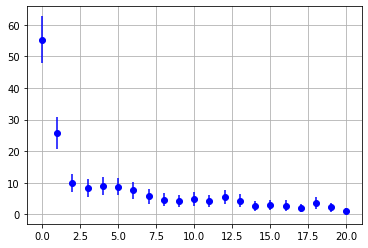

In [199]:
plt.errorbar(x, arr_mse_x.reshape(n,), arr_std_x.reshape(n,), linestyle='None', marker='o', color='b', label='x error')
plt.grid(True)

<ErrorbarContainer object of 3 artists>

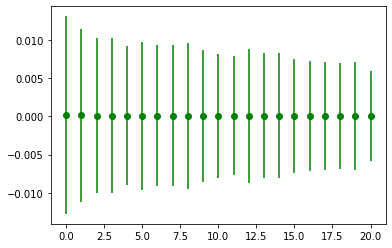

In [200]:
plt.errorbar(x, arr_mse_t.reshape(n,), arr_std_t.reshape(n,), linestyle='None', marker='o', color='g', label='t error')

<ErrorbarContainer object of 3 artists>

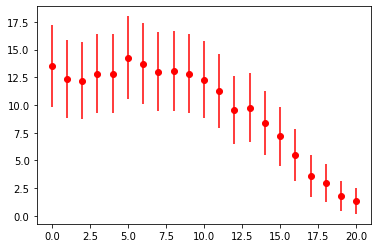

In [201]:
plt.errorbar(x, arr_mse_z.reshape(n,), arr_std_z.reshape(n,), linestyle='None', marker='o', color='r', label='z error')

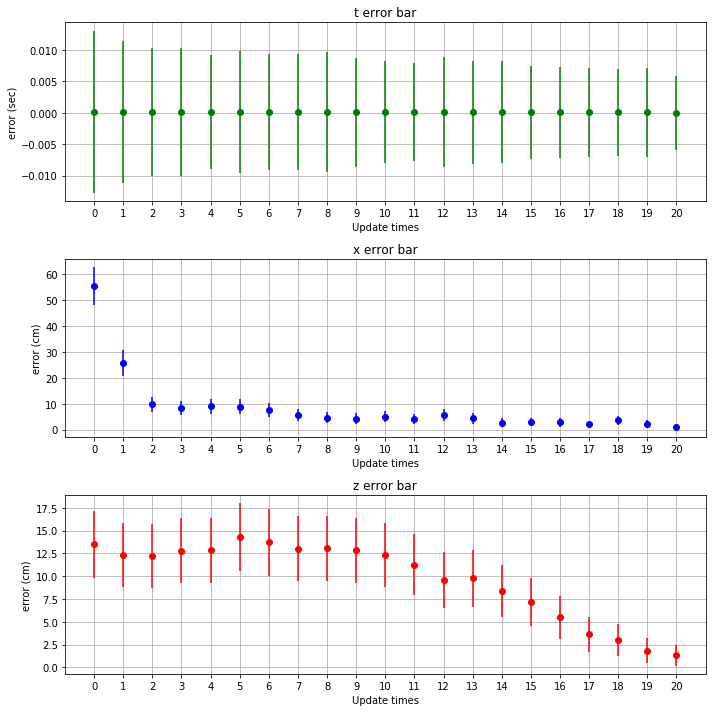

In [202]:
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.errorbar(x, arr_mse_t.reshape(n,), arr_std_t.reshape(n,), linestyle='None', marker='o', color='g', label='t error')
plt.title('t error bar')
plt.xlabel('Update times')
plt.ylabel('error (sec)')
#plt.xlim(0.5,20)
plt.xticks(np.arange(0,21))
plt.grid(True)

plt.subplot(3,1,2)
plt.errorbar(x, arr_mse_x.reshape(n,), arr_std_x.reshape(n,), linestyle='None', marker='o', color='b', label='x error')
plt.title('x error bar')
plt.xlabel('Update times')
plt.ylabel('error (cm)')
plt.xticks(np.arange(0,21))
plt.grid(True)

plt.subplot(3,1,3)
plt.errorbar(x, arr_mse_z.reshape(n,), arr_std_z.reshape(n,), linestyle='None', marker='o', color='r', label='z error')
plt.title('z error bar')
plt.xlabel('Update times')
plt.ylabel('error (cm)')
plt.xticks(np.arange(0,21))
plt.grid(True)

plt.tight_layout()
#plt.savefig('./fig/without classification/'+name+'_test_res.png')
#plt.savefig('./fig/without classification/'+name+'_test_res.svg')

#plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/without classification/'+name+'_test_res.png')
#plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/without classification/'+name+'_test_res.svg')

plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/png/'+name+'_test_res.png')
plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/svg/'+name+'_test_res.svg')

In [203]:
arr_for_err_x

array([[ 1.47970632, -0.07716235,  1.40219731, ...,  1.20892424,
         0.13565676, -0.45011295],
       [ 0.85070471, -0.5474244 ,  0.49681438, ..., -1.28328117,
        -1.06811078, -0.40393442],
       [-1.37266028, -0.35687265, -0.0854342 , ..., -0.29015197,
         0.30149473, -0.24919584],
       ...,
       [-3.36954506, -2.18556747, -2.88467322, ...,  2.25918464,
         1.05923721, -0.09630097],
       [-6.30901724, -0.93410721, -1.58762495, ...,  1.16423728,
         1.04617594,  0.35729135],
       [ 0.87921257,  0.99655971,  0.75346401, ..., -0.77821766,
        -0.45715357,  0.37582075]])

238 247
accuray = 96.35627530364373%


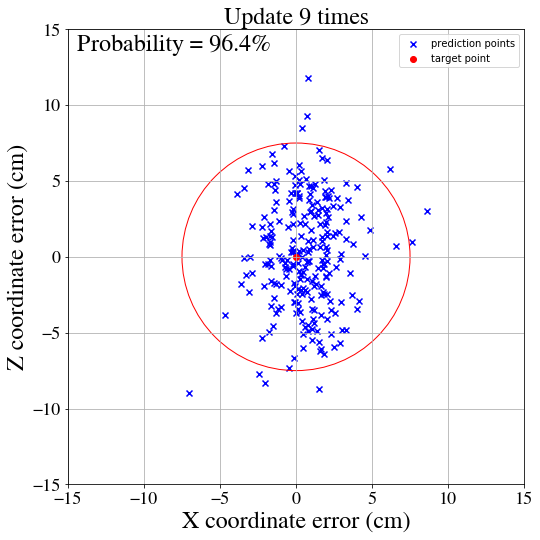

In [204]:
k = 10
up_times = k - 1

correct = 0
for i in range(arr_for_err_x.shape[0]):
    if arr_for_err_x[i,up_times] < 7.5 and arr_for_err_x[i,up_times] > -7.5 and arr_for_err_z[i,up_times] < 7.5 and arr_for_err_z[i,up_times] > -7.5:
        correct += 1
print(correct, arr_for_err_x.shape[0])
print("accuray = {}%".format(correct/arr_for_err_x.shape[0]*100))
aa = np.round_(correct/arr_for_err_x.shape[0]*100, 1)
text = str("Probability = {}%".format(aa))

plt.figure(figsize=(8,8))

x = y = np.arange(-7.5, 7.5, 0.005)
x, y = np.meshgrid(x,y)
#plt.contour(x, y, x**2 + y**2, [15*15])
circle2 = plt.Circle((0, 0), 7.5, color='r', fill=False, label='paddle edge')

ax = plt.gca()
ax.add_artist(circle2)
ax.set_xlim((-15, 15))
ax.set_ylim((-15, 15))

plt.scatter(cp.asnumpy(arr_for_err_x[:,up_times]), cp.asnumpy(arr_for_err_z[:,up_times]), edgecolors='b', label='prediction points', marker='x', color='b')
plt.scatter(0,0, color='r', marker='o', label='target point')
plt.Circle((0,0), 7.5, color='r', fill=False)

plt.xlabel('X coordinate error (cm)', fontsize=24, fontname='FreeSerif')
plt.ylabel('Z coordinate error (cm)', fontsize=24, fontname='FreeSerif')
plt.xticks(fontsize=18, fontname='FreeSerif')
plt.yticks(fontsize=18, fontname='FreeSerif')

title_name = 'Update ' + str(up_times) + ' times'
plt.title(title_name, fontsize=24, fontname='FreeSerif')
plt.text(-8,14,text, fontsize=24, fontname='FreeSerif', horizontalalignment='center', verticalalignment='center')

plt.tight_layout(pad=2.5)
plt.grid(True)
plt.legend(loc='upper right')
#plt.savefig('./fig/update_' + str(up_times) + '_times.png')

223 247
accuray = 90.2834008097166%
224 247
accuray = 90.68825910931174%
232 247
accuray = 93.92712550607287%
231 247
accuray = 93.52226720647774%
229 247
accuray = 92.71255060728745%
227 247
accuray = 91.90283400809717%
231 247
accuray = 93.52226720647774%
232 247
accuray = 93.92712550607287%
235 247
accuray = 95.1417004048583%
237 247
accuray = 95.95141700404858%
237 247
accuray = 95.95141700404858%
238 247
accuray = 96.35627530364373%
237 247
accuray = 95.95141700404858%
234 247
accuray = 94.73684210526315%
240 247
accuray = 97.16599190283401%
239 247
accuray = 96.76113360323887%
241 247
accuray = 97.57085020242914%
244 247
accuray = 98.78542510121457%
244 247
accuray = 98.78542510121457%
244 247
accuray = 98.78542510121457%
247 247
accuray = 100.0%


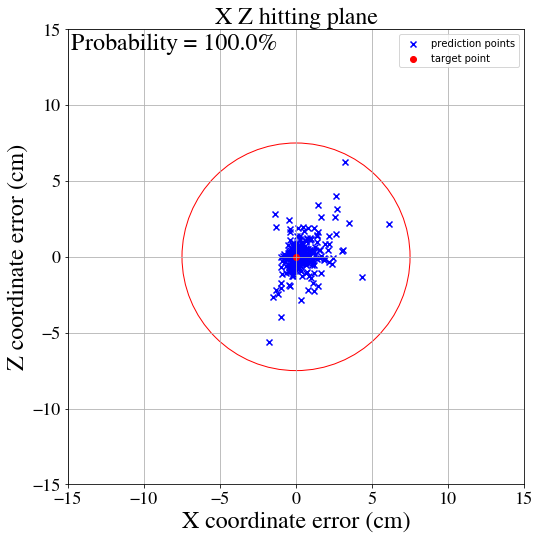

In [205]:
import math
up_times = 0

correct = 0
for i in range(arr_for_err_x.shape[0]):
    if arr_for_err_x[i,up_times] < 7.5 and arr_for_err_x[i,up_times] > -7.5 and arr_for_err_z[i,up_times] < 7.5 and arr_for_err_z[i,up_times] > -7.5:
        correct += 1
print(correct, arr_for_err_x.shape[0])
print("accuray = {}%".format(correct/arr_for_err_x.shape[0]*100))
aa = np.round_(correct/arr_for_err_x.shape[0]*100, 1)
text = str("Probability = {}%".format(aa))

plt.figure(figsize=(8,8))

x = y = np.arange(-7.5, 7.5, 0.005)
x, y = np.meshgrid(x,y)
#plt.contour(x, y, x**2 + y**2, [15*15])
circle2 = plt.Circle((0, 0), 7.5, color='r', fill=False, label='paddle edge')

ax = plt.gca()
ax.add_artist(circle2)
ax.set_xlim((-15, 15))
ax.set_ylim((-15, 15))

plt.scatter(cp.asnumpy(arr_for_err_x[:,up_times]), cp.asnumpy(arr_for_err_z[:,up_times]), edgecolors='b', label='prediction points', marker='x', color='b')
plt.scatter(0,0, color='r', marker='o', label='target point')
plt.Circle((0,0), 7.5, color='r', fill=False)

plt.xlabel('X coordinate error (cm)', fontsize=24, fontname='FreeSerif')
plt.ylabel('Z coordinate error (cm)', fontsize=24, fontname='FreeSerif')
plt.xticks(fontsize=18, fontname='FreeSerif')
plt.yticks(fontsize=18, fontname='FreeSerif')
plt.title('X Z hitting plane', fontsize=24, fontname='FreeSerif')
plt.text(-8,14,text, fontsize=24, fontname='FreeSerif', horizontalalignment='center', verticalalignment='center')

plt.tight_layout(pad=2.5)
plt.grid(True)
plt.legend(loc='upper right')
#plt.savefig('./fig/without classification/update_' + str(up_times) + '_times_without_classification.png')
#plt.savefig('./fig/without classification/update_' + str(up_times) + '_times_without_classification.svg')

for up_times in range(1,n,1):
    plt.clf()
    #plt.figure(figsize=(8,8))
    '''
    ax = plt.gca()
    ax.add_artist(circle2)
    ax.set_xlim((-15, 15))
    ax.set_ylim((-15, 15))
    '''
    
    circle2 = plt.Circle((0, 0), 7.5, color='r', fill=False, label='paddle edge')
    ax = plt.gca()
    ax.add_artist(circle2)
    
    correct = 0
    for i in range(arr_for_err_x.shape[0]):
        d = math.sqrt(arr_for_err_x[i,up_times]**2+arr_for_err_z[i,up_times]**2)
        if d <= 7.5:
            correct += 1
    print(correct, arr_for_err_x.shape[0])
    print("accuray = {}%".format(correct/arr_for_err_x.shape[0]*100))
    aa = np.round_(correct/arr_for_err_x.shape[0]*100, 1)
    text = str("Probability = {}%".format(aa))
    
    plt.scatter(cp.asnumpy(arr_for_err_x[:,up_times]), cp.asnumpy(arr_for_err_z[:,up_times]), edgecolors='b', label='prediction points', marker='x', color='b')
    plt.scatter(0,0, color='r', marker='o', label='target point')
    plt.Circle((0,0), 7.5, color='r', fill=False)

    plt.xlabel('X coordinate error (cm)', fontsize=24, fontname='FreeSerif')
    plt.ylabel('Z coordinate error (cm)', fontsize=24, fontname='FreeSerif')
    plt.xticks(fontsize=18, fontname='FreeSerif')
    plt.yticks(fontsize=18, fontname='FreeSerif')
    plt.title('X Z hitting plane', fontsize=24, fontname='FreeSerif')
    plt.text(-8,14,text, fontsize=24, fontname='FreeSerif', horizontalalignment='center', verticalalignment='center')

    plt.xlim(-15,15)
    plt.ylim(-15,15)
    
    plt.tight_layout(pad=2.5)
    plt.grid(True)
    plt.legend(loc='upper right')
    #plt.savefig('./fig/without classification/update_' + str(up_times) + '_times_without_classification.png')
    #plt.savefig('./fig/without classification/update_' + str(up_times) + '_times_without_classification.svg')
    
    #plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/without classification/update_'+str(up_times) + '_times_without_classification.png')
    #plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/without classification/update_'+str(up_times) + '_times_without_classification.svg')
    
    plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/png/update_'+str(up_times) + '_times_without_classification.png')
    plt.savefig('/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/svg/update_'+str(up_times) + '_times_without_classification.svg')
    

In [206]:
errbar = [arr_mse_t, arr_mse_x, arr_mse_z, arr_std_t, arr_std_x, arr_std_z]
errbar = np.array(errbar)
errbar

array([[[ 0.00017125,  0.00013191,  0.00010937,  0.0001104 ,
          0.00009575,  0.00010558,  0.00009544,  0.00009166,
          0.00009844,  0.00008238,  0.00007237,  0.00006706,
          0.00008662,  0.00007613,  0.0000786 ,  0.00006132,
          0.00005656,  0.00005477,  0.00005317,  0.00005712,
          0.00004049]],

       [[55.27960188, 25.78807522,  9.82539669,  8.39928361,
          8.97197364,  8.82599531,  7.59369307,  5.66875186,
          4.66570333,  4.26573917,  4.91770984,  4.20204148,
          5.60641063,  4.35234661,  2.73837873,  2.9363542 ,
          2.77194621,  2.05318178,  3.58654832,  2.23631543,
          1.136319  ]],

       [[13.49930919, 12.3190984 , 12.19803672, 12.80253361,
         12.82716375, 14.26769901, 13.72550784, 13.01756149,
         13.05293194, 12.8237516 , 12.29160697, 11.2363031 ,
          9.54036856,  9.77032112,  8.36792921,  7.17597866,
          5.47190762,  3.60664344,  2.98985362,  1.83829412,
          1.33332694]],

       [[ 

In [207]:
errbar = errbar.reshape(6,21)
errbar

array([[ 0.00017125,  0.00013191,  0.00010937,  0.0001104 ,  0.00009575,
         0.00010558,  0.00009544,  0.00009166,  0.00009844,  0.00008238,
         0.00007237,  0.00006706,  0.00008662,  0.00007613,  0.0000786 ,
         0.00006132,  0.00005656,  0.00005477,  0.00005317,  0.00005712,
         0.00004049],
       [55.27960188, 25.78807522,  9.82539669,  8.39928361,  8.97197364,
         8.82599531,  7.59369307,  5.66875186,  4.66570333,  4.26573917,
         4.91770984,  4.20204148,  5.60641063,  4.35234661,  2.73837873,
         2.9363542 ,  2.77194621,  2.05318178,  3.58654832,  2.23631543,
         1.136319  ],
       [13.49930919, 12.3190984 , 12.19803672, 12.80253361, 12.82716375,
        14.26769901, 13.72550784, 13.01756149, 13.05293194, 12.8237516 ,
        12.29160697, 11.2363031 ,  9.54036856,  9.77032112,  8.36792921,
         7.17597866,  5.47190762,  3.60664344,  2.98985362,  1.83829412,
         1.33332694],
       [ 0.01293823,  0.01130238,  0.01020117,  0.01014123

In [208]:
#errbar = errbar.reshape(21,6)
df = pd.DataFrame(data=errbar)
#df.to_csv('/home/lab606a/Documents/comp/without classification/ideal.csv', index=False)

#p = '/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/without classification/without_classification.csv'
p = '/home/lab606a/Documents/4Journal_20200629/result/not fixed/'+name+'/ideal/ideal.csv'

df.to_csv(p, index=False)

In [209]:
errbar = errbar.reshape(6,21)
errbar

array([[ 0.00017125,  0.00013191,  0.00010937,  0.0001104 ,  0.00009575,
         0.00010558,  0.00009544,  0.00009166,  0.00009844,  0.00008238,
         0.00007237,  0.00006706,  0.00008662,  0.00007613,  0.0000786 ,
         0.00006132,  0.00005656,  0.00005477,  0.00005317,  0.00005712,
         0.00004049],
       [55.27960188, 25.78807522,  9.82539669,  8.39928361,  8.97197364,
         8.82599531,  7.59369307,  5.66875186,  4.66570333,  4.26573917,
         4.91770984,  4.20204148,  5.60641063,  4.35234661,  2.73837873,
         2.9363542 ,  2.77194621,  2.05318178,  3.58654832,  2.23631543,
         1.136319  ],
       [13.49930919, 12.3190984 , 12.19803672, 12.80253361, 12.82716375,
        14.26769901, 13.72550784, 13.01756149, 13.05293194, 12.8237516 ,
        12.29160697, 11.2363031 ,  9.54036856,  9.77032112,  8.36792921,
         7.17597866,  5.47190762,  3.60664344,  2.98985362,  1.83829412,
         1.33332694],
       [ 0.01293823,  0.01130238,  0.01020117,  0.01014123